In [1]:
# abilita l'uilizzo di tqdm all'interno del notebook
!pip install ipywidgets==8.0.4
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
import torch
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer, MinMaxScaler
import wandb

## DataLoader


In [3]:
class CustomDataset(Dataset):
    TARGET_MASK_ID = 1
    FEATURES_MASK_ID = 0
    DAY_IN_MINUTES = 287
    __DAYS_IN_MONTH = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    EXCLUDE_FEATURES = [
        "Failure", "Frequency", "Status", "Others",
        "Code", "name", "deviceid", "serial",
        "SB0", "Phase", "NV10P", "TotalEnergy_QuotControl", 
        #"INV01_TotalEnergy", "INV02_TotalEnergy", "INV03_TotalEnergy",
        #"cos",
        #"sin",
        "state", "SOL", "NA16", 'soil_moisture_7_to_28cm (m³/m³)',
    ]
    
    def __init__(self, dataset_path, window=1, target_size=1, verbose=False):
        self.df = pd.read_csv(dataset_path, delimiter = ";")
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'], yearfirst=True)
        cols_to_remove = [column  for column in self.df.columns if len([elem for elem in self.EXCLUDE_FEATURES if elem in column]) > 0]
        self.df = self.df.drop(columns=cols_to_remove)
        
        # filtro per le date contenute nel range start_date < x < end_date
        #self.df = self.df[self.df['timestamp'] > pd.to_datetime(start_date)]
        #self.df = self.df[self.df['timestamp'] < pd.to_datetime(end_date)]
        
        # aggiunta encoding ciclico minuti, giorni
        self.__ciclic_time_encoder()
        
        # trasformo la target series in Non Cumulativa
        self.df['target'] = self.df['Cont_TotalEnergy(kWh)'].diff().fillna(0)
        
        # inizializzo lo scaler ed effettuo la normalizzazione dei dati
        self.scaler = MinMaxScaler().fit(self.df.drop(columns=['timestamp'])) # ignoro la colonna del timestamp
        self.df.loc[:, self.df.columns != 'timestamp'] = self.scaler.transform(self.df.loc[:, self.df.columns != 'timestamp'])
        
        self.window = window
        self.target_size = target_size # numero di giorni da interpolare
        self.shape = self.df.shape
        self.verbose = verbose
        
        # if self.verbose:
            # controllo se le colonne hanno dei NaN
        #    print("Padre:", self.df.isna().any())
            
    def __ciclic_time_encoder(self, col_name='timestamp'):
        tmp_datetime_serie = pd.to_datetime(arg=self.df[col_name], yearfirst=True)
        
        #month = tmp_datetime_serie.dt.month - 1
        #day = tmp_datetime_serie.dt.day - 1
        #display(day)
        
        self.df["minute_sin"] = np.sin(2 * np.pi * tmp_datetime_serie.dt.minute / 60.0)
        self.df["minute_cos"] = np.cos(2 * np.pi * tmp_datetime_serie.dt.minute / 60.0)
        
        # ci può piacere così ??
        self.df["day_sin"] = np.sin(2 * np.pi * tmp_datetime_serie.dt.day / 31.0)
        self.df["day_cos"] = np.cos(2 * np.pi * tmp_datetime_serie.dt.day / 31.0)
        
        # va fatto con il -1 ???
        #self.df["month_sin"] = np.sin(2 * np.pi * tmp_datetime_serie.dt.month/12.0)
        #self.df["month_cos"] = np.cos(2 * np.pi * tmp_datetime_serie.dt.month/12.0)

        #df["hour_sin"] = np.sin(2 * np.pi * tmp_datetime_serie.dt.hour/24.0)
        #df["hour_cos"] = np.cos(2 * np.pi * tmp_datetime_serie.dt.hour/24.0)

    def __len__(self):
        temp= (self.df.shape[0]/self.DAY_IN_MINUTES)-(2*(self.window) + (self.target_size))-1
        #print("TEMP:", temp)
        #print("DF ROWS:", self.df.shape[0])
        #print("PRE DIFF", (2*(self.window*self.DAY_IN_MINUTES) + (self.target_size*self.DAY_IN_MINUTES)))
        #print((2*(self.window*self.DAY_IN_MINUTES) + (self.target_size*self.DAY_IN_MINUTES)))
        return int(temp)
        #return len(self.df)
    
    def __getitem__(self, idx):
        days = self.df.iloc[0+(idx*self.DAY_IN_MINUTES): self.DAY_IN_MINUTES*(self.window+self.target_size+self.window)+(idx*self.DAY_IN_MINUTES), ~self.df.columns.str.contains('^Unnamed')]
        days = days.drop(columns=['Cont_TotalEnergy(kWh)']) # rimuovo la T.S. cumulativa

        if self.verbose:
            display("Target from dataframe")
            display(days)
                
        days = days[days.columns.drop(list(days.filter(regex='^.*_name.*$')))]
        days = days[days.columns.drop(list(days.filter(regex='^Unnamed')))]
        days['timestamp'] = pd.to_numeric(days['timestamp']) # si potrebbe rimuovere
        
        if self.verbose:
            display("Target after processing")
            display(days)
        
        target = days[self.DAY_IN_MINUTES*self.window:self.DAY_IN_MINUTES*(self.window+self.target_size)]
        target = target['target']
        # target = target['Cont_TotalEnergy(kWh)']
        
        data_left = days[0:self.DAY_IN_MINUTES*self.window]
        data_right = days[self.DAY_IN_MINUTES*(self.window+self.target_size):]
        data = pd.concat([data_left, data_right])
        
        tensor_type = torch.float64 # forza il tipo in double (serve per il testing timestamp)
        
        # la rimozione del timestamp viene fatta solo se verbose==False,
        # sta ad indicare che non siamo più nella fase di tesing
        if self.verbose == False:
            # rimuovo il tiemestamp dato che la ciclicità è stata modellata con sin e cos
            #    N.B.: target non ha timestamp, ma solo i valori della corrente !
            data = data.drop(columns=['timestamp'])
            tensor_type = torch.float32 # forza il tipo in float (si potrebbe anche scendere)

        # mask = [self.FEATURES_MASK_ID]*(self.window*self.DAY_IN_MINUTES) + [self.TARGET_MASK_ID]*(self.target_size*self.DAY_IN_MINUTES) + [self.FEATURES_MASK_ID]*(self.window*self.DAY_IN_MINUTES)
        
        #if self.verbose:
        #    display("Mask")
        #    display(mask)
        
        tensor_target = torch.tensor(target.values, dtype=tensor_type)
        tensor_target = torch.reshape(tensor_target, (self.target_size*self.DAY_IN_MINUTES, 1))
        tensor_features = torch.tensor(data.values, dtype=tensor_type)
        tensor_features = tensor_features[None, :]
        return tensor_target, tensor_features
    
    def set_verbose(self, value: bool):
        self.verbose = value
    
    def summary(self):
        print("Are NaN inside ??")
        print(self.df.isna().any())
        display(self.df['timestamp'])

In [4]:
class TrainingDataset(CustomDataset):
    
    def __init__(self, dataset_path, window=1, target_size=1, start_date='2022-06-01', end_date='2023-02-01', verbose=False):
        super().__init__(dataset_path, window=window, target_size=target_size, verbose=verbose)
        # filtro per le date contenute nel range start_date < x < end_date
        self.df = self.df[self.df['timestamp'] > pd.to_datetime(start_date)]
        self.df = self.df[self.df['timestamp'] < pd.to_datetime(end_date)]
        
        
        if self.verbose:
            self.summary()
            # controllo se le colonne hanno dei NaN
            #print("Are NaN inside ??")
            #print(self.df.isna().any())
            #display()
            
    def __len__(self):
        return 240 # TODO: SISTEMARE !!

In [5]:
class ValidationDataset(CustomDataset):
    
    def __init__(self, dataset_path, window=1, target_size=1, start_date='2023-02-01', end_date='2023-03-01', verbose=False):
        super().__init__(dataset_path, window=window, target_size=target_size, verbose=verbose)
        # filtro per le date contenute nel range start_date < x < end_date
        self.df = self.df[self.df['timestamp'] > pd.to_datetime(start_date)]
        self.df = self.df[self.df['timestamp'] < pd.to_datetime(end_date)]
        
        
        if self.verbose:
            self.summary()
            # controllo se le colonne hanno dei NaN
            #print("Are NaN inside ??")
            #print(self.df.isna().any())

### Tests

In [3]:
run = wandb.init(
    # set the wandb project where this run will be logged
    project="interpolation",
    #name="Ultra Fully Connected Network",
    # track hyperparameters and run metadata
    config={
        "learning_rate": 0.01,
        #"architecture": "UFC", # Ultra Fully Connected 🚀
        "dataset": "RofiloAnnuale-FullCyclingEncoding",
        "epochs": 100,
        "batch_size": 10,
        "window_size": 1,
        "target_size": 1,
    }
)

wandb: Currently logged in as: nicolo-vescera (rofilopd). Use `wandb login --relogin` to force relogin


In [7]:
train_dataset = TrainingDataset(
    "merged_annuale_meteo.csv", 
    window=run.config['window_size'], target_size=run.config['target_size'], 
    verbose=True
)

Are NaN inside ??
timestamp                          False
INV01_CurrentDC(A)                 False
INV01_CurrentAC(A)                 False
INV01_TotalEnergy(kWh)             False
INV01_PowerAC(kW)                  False
INV01_PowerDC(kW)                  False
INV01_InternalTemperature(C)       False
INV01_HeatSinkTemperature(C)       False
INV01_VoltageDC(V)                 False
INV01_VoltageAC(V)                 False
INV02_CurrentDC(A)                 False
INV02_CurrentAC(A)                 False
INV02_TotalEnergy(kWh)             False
INV02_PowerAC(kW)                  False
INV02_PowerDC(kW)                  False
INV02_InternalTemperature(C)       False
INV02_HeatSinkTemperature(C)       False
INV02_VoltageDC(V)                 False
INV02_VoltageAC(V)                 False
INV03_CurrentDC(A)                 False
INV03_CurrentAC(A)                 False
INV03_TotalEnergy(kWh)             False
INV03_PowerAC(kW)                  False
INV03_PowerDC(kW)                  Fals

34153    2022-06-01 00:05:00
34154    2022-06-01 00:10:00
34155    2022-06-01 00:15:00
34156    2022-06-01 00:20:00
34157    2022-06-01 00:25:00
                 ...        
104463   2023-01-31 23:35:00
104464   2023-01-31 23:40:00
104465   2023-01-31 23:45:00
104466   2023-01-31 23:50:00
104467   2023-01-31 23:55:00
Name: timestamp, Length: 70315, dtype: datetime64[ns]

In [8]:
validation_dataset = ValidationDataset(
    "merged_annuale_meteo.csv", 
    window=run.config['window_size'], target_size=run.config['target_size'], 
    verbose=True
)

Are NaN inside ??
timestamp                          False
INV01_CurrentDC(A)                 False
INV01_CurrentAC(A)                 False
INV01_TotalEnergy(kWh)             False
INV01_PowerAC(kW)                  False
INV01_PowerDC(kW)                  False
INV01_InternalTemperature(C)       False
INV01_HeatSinkTemperature(C)       False
INV01_VoltageDC(V)                 False
INV01_VoltageAC(V)                 False
INV02_CurrentDC(A)                 False
INV02_CurrentAC(A)                 False
INV02_TotalEnergy(kWh)             False
INV02_PowerAC(kW)                  False
INV02_PowerDC(kW)                  False
INV02_InternalTemperature(C)       False
INV02_HeatSinkTemperature(C)       False
INV02_VoltageDC(V)                 False
INV02_VoltageAC(V)                 False
INV03_CurrentDC(A)                 False
INV03_CurrentAC(A)                 False
INV03_TotalEnergy(kWh)             False
INV03_PowerAC(kW)                  False
INV03_PowerDC(kW)                  Fals

104468   2023-02-01 00:05:00
104469   2023-02-01 00:10:00
104470   2023-02-01 00:15:00
104471   2023-02-01 00:20:00
104472   2023-02-01 00:25:00
                 ...        
112499   2023-02-28 23:35:00
112500   2023-02-28 23:40:00
112501   2023-02-28 23:45:00
112502   2023-02-28 23:50:00
112503   2023-02-28 23:55:00
Name: timestamp, Length: 8036, dtype: datetime64[ns]

In [9]:
print(len(train_dataset))
print(len(validation_dataset))

240
24


In [10]:
a, b = train_dataset[10]

print(a.shape)
print(b.shape)

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
37023 2022-06-11 00:05:00                 0.0                 0.0   
37024 2022-06-11 00:10:00                 0.0                 0.0   
37025 2022-06-11 00:15:00                 0.0                 0.0   
37026 2022-06-11 00:20:00                 0.0                 0.0   
37027 2022-06-11 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
37879 2022-06-13 23:35:00                 0.0                 0.0   
37880 2022-06-13 23:40:00                 0.0                 0.0   
37881 2022-06-13 23:45:00                 0.0                 0.0   
37882 2022-06-13 23:50:00                 0.0                 0.0   
37883 2022-06-13 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
37023                0.032137                0.0                0.0   
37024                0.032137                0.0                0.0   
37025                0.032137                0.0                0.0   
37026                0.032137                0.0                0.0   
37027                0.032137                0.0                0.0   
...                       ...                ...                ...   
37879                0.032801                0.0                0.0   
37880                0.032801                0.0                0.0   
37881                0.032801                0.0                0.0   
37882                0.032801                0.0                0.0   
37883                0.032801                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
37023                           0.0                           0.0   
37024                           0.0                           0.0   
37025                           0.0                           0.0   
37026                           0.0                           0.0   
37027                           0.0                           0.0   
...                             ...                           ...   
37879                           0.0                           0.0   
37880                           0.0                           0.0   
37881                           0.0                           0.0   
37882                           0.0                           0.0   
37883                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
37023                 0.0                 0.0  ...                 0.681159   
37024                 0.0                 0.0  ...                 0.681159   
37025                 0.0                 0.0  ...                 0.681159   
37026                 0.0                 0.0  ...                 0.681159   
37027                 0.0                 0.0  ...                 0.681159   
...                   ...                 ...  ...                      ...   
37879                 0.0                 0.0  ...                 0.608696   
37880                 0.0                 0.0  ...                 0.608696   
37881                 0.0                 0.0  ...                 0.608696   
37882                 0.0                 0.0  ...                 0.608696   
37883                 0.0                 0.0  ...                 0.608696   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
37023          0.813880        0.0             0.4   
37024          0.813880        0.0             0.4   
37025          0.813880        0.0             0.4   
37026          0.813880        0.0             0.4   
37027          0.813880        0.0             0.4   
...                 ...        ...             ...   
37879          0.741325        0.0             0.0   
37880          0.741325        0.0             0.0   
37881          0.741325        0.0             0.0   
37882          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
37023  1654905900000000000                 0.0                 0.0   
37024  1654906200000000000                 0.0                 0.0   
37025  1654906500000000000                 0.0                 0.0   
37026  1654906800000000000                 0.0                 0.0   
37027  1654907100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
37879  1655163300000000000                 0.0                 0.0   
37880  1655163600000000000                 0.0                 0.0   
37881  1655163900000000000                 0.0                 0.0   
37882  1655164200000000000                 0.0                 0.0   
37883  1655164500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
37023                0.032137                0.0                0.0   
37024                0.032137                0.0                0.0   
37025                0.032137                0.0                0.0   
37026                0.032137                0.0                0.0   
37027                0.032137                0.0                0.0   
...                       ...                ...                ...   
37879                0.032801                0.0                0.0   
37880                0.032801                0.0                0.0   
37881                0.032801                0.0                0.0   
37882                0.032801                0.0                0.0   
37883                0.032801                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
37023                           0.0                           0.0   
37024                           0.0                           0.0   
37025                           0.0                           0.0   
37026                           0.0                           0.0   
37027                           0.0                           0.0   
...                             ...                           ...   
37879                           0.0                           0.0   
37880                           0.0                           0.0   
37881                           0.0                           0.0   
37882                           0.0                           0.0   
37883                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
37023                 0.0                 0.0  ...                 0.681159   
37024                 0.0                 0.0  ...                 0.681159   
37025                 0.0                 0.0  ...                 0.681159   
37026                 0.0                 0.0  ...                 0.681159   
37027                 0.0                 0.0  ...                 0.681159   
...                   ...                 ...  ...                      ...   
37879                 0.0                 0.0  ...                 0.608696   
37880                 0.0                 0.0  ...                 0.608696   
37881                 0.0                 0.0  ...                 0.608696   
37882                 0.0                 0.0  ...                 0.608696   
37883                 0.0                 0.0  ...                 0.608696   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
37023          0.813880        0.0             0.4   
37024          0.813880        0.0             0.4   
37025          0.813880        0.0             0.4   
37026          0.813880        0.0             0.4   
37027          0.813880        0.0             0.4   
...                 ...        ...             ...   
37879          0.741325        0.0             0.0   
37880          0.741325        0.0             0.0   
37881          0.741325        0.0             0.0   
37882

torch.Size([287, 1])
torch.Size([1, 574, 46])


In [11]:
#train_dataset.set_verbose(False)

In [12]:
target, features = train_dataset[10]

print(target.shape, features.shape)
print(target)
print(features)

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
37023 2022-06-11 00:05:00                 0.0                 0.0   
37024 2022-06-11 00:10:00                 0.0                 0.0   
37025 2022-06-11 00:15:00                 0.0                 0.0   
37026 2022-06-11 00:20:00                 0.0                 0.0   
37027 2022-06-11 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
37879 2022-06-13 23:35:00                 0.0                 0.0   
37880 2022-06-13 23:40:00                 0.0                 0.0   
37881 2022-06-13 23:45:00                 0.0                 0.0   
37882 2022-06-13 23:50:00                 0.0                 0.0   
37883 2022-06-13 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
37023                0.032137                0.0                0.0   
37024                0.032137                0.0                0.0   
37025                0.032137                0.0                0.0   
37026                0.032137                0.0                0.0   
37027                0.032137                0.0                0.0   
...                       ...                ...                ...   
37879                0.032801                0.0                0.0   
37880                0.032801                0.0                0.0   
37881                0.032801                0.0                0.0   
37882                0.032801                0.0                0.0   
37883                0.032801                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
37023                           0.0                           0.0   
37024                           0.0                           0.0   
37025                           0.0                           0.0   
37026                           0.0                           0.0   
37027                           0.0                           0.0   
...                             ...                           ...   
37879                           0.0                           0.0   
37880                           0.0                           0.0   
37881                           0.0                           0.0   
37882                           0.0                           0.0   
37883                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
37023                 0.0                 0.0  ...                 0.681159   
37024                 0.0                 0.0  ...                 0.681159   
37025                 0.0                 0.0  ...                 0.681159   
37026                 0.0                 0.0  ...                 0.681159   
37027                 0.0                 0.0  ...                 0.681159   
...                   ...                 ...  ...                      ...   
37879                 0.0                 0.0  ...                 0.608696   
37880                 0.0                 0.0  ...                 0.608696   
37881                 0.0                 0.0  ...                 0.608696   
37882                 0.0                 0.0  ...                 0.608696   
37883                 0.0                 0.0  ...                 0.608696   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
37023          0.813880        0.0             0.4   
37024          0.813880        0.0             0.4   
37025          0.813880        0.0             0.4   
37026          0.813880        0.0             0.4   
37027          0.813880        0.0             0.4   
...                 ...        ...             ...   
37879          0.741325        0.0             0.0   
37880          0.741325        0.0             0.0   
37881          0.741325        0.0             0.0   
37882          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
37023  1654905900000000000                 0.0                 0.0   
37024  1654906200000000000                 0.0                 0.0   
37025  1654906500000000000                 0.0                 0.0   
37026  1654906800000000000                 0.0                 0.0   
37027  1654907100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
37879  1655163300000000000                 0.0                 0.0   
37880  1655163600000000000                 0.0                 0.0   
37881  1655163900000000000                 0.0                 0.0   
37882  1655164200000000000                 0.0                 0.0   
37883  1655164500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
37023                0.032137                0.0                0.0   
37024                0.032137                0.0                0.0   
37025                0.032137                0.0                0.0   
37026                0.032137                0.0                0.0   
37027                0.032137                0.0                0.0   
...                       ...                ...                ...   
37879                0.032801                0.0                0.0   
37880                0.032801                0.0                0.0   
37881                0.032801                0.0                0.0   
37882                0.032801                0.0                0.0   
37883                0.032801                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
37023                           0.0                           0.0   
37024                           0.0                           0.0   
37025                           0.0                           0.0   
37026                           0.0                           0.0   
37027                           0.0                           0.0   
...                             ...                           ...   
37879                           0.0                           0.0   
37880                           0.0                           0.0   
37881                           0.0                           0.0   
37882                           0.0                           0.0   
37883                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
37023                 0.0                 0.0  ...                 0.681159   
37024                 0.0                 0.0  ...                 0.681159   
37025                 0.0                 0.0  ...                 0.681159   
37026                 0.0                 0.0  ...                 0.681159   
37027                 0.0                 0.0  ...                 0.681159   
...                   ...                 ...  ...                      ...   
37879                 0.0                 0.0  ...                 0.608696   
37880                 0.0                 0.0  ...                 0.608696   
37881                 0.0                 0.0  ...                 0.608696   
37882                 0.0                 0.0  ...                 0.608696   
37883                 0.0                 0.0  ...                 0.608696   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
37023          0.813880        0.0             0.4   
37024          0.813880        0.0             0.4   
37025          0.813880        0.0             0.4   
37026          0.813880        0.0             0.4   
37027          0.813880        0.0             0.4   
...                 ...        ...             ...   
37879          0.741325        0.0             0.0   
37880          0.741325        0.0             0.0   
37881          0.741325        0.0             0.0   
37882

torch.Size([287, 1]) torch.Size([1, 574, 46])
tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],


In [13]:
#sempler = SequentialSampler(train_dataset)
train_sempler = RandomSampler(train_dataset)
run.config['train_sampler'] = train_sempler

validation_sempler = RandomSampler(validation_dataset)
run.config['validation_sempler'] = validation_sempler

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=run.config['batch_size'], sampler=train_sempler)

In [15]:
train_target, train_features = next(iter(train_dataloader))

print("Shape Target: ", train_target.shape)
print("Shape Features: ", train_features.shape)
print("Timestamp start:", pd.to_datetime(train_features[0][0][0][0]))
print("Timestamp end:", pd.to_datetime(train_features[0][0][-1][0]))
print()
print(train_target)
print(train_features)

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
65149 2022-09-17 00:05:00                 0.0                 0.0   
65150 2022-09-17 00:10:00                 0.0                 0.0   
65151 2022-09-17 00:15:00                 0.0                 0.0   
65152 2022-09-17 00:20:00                 0.0                 0.0   
65153 2022-09-17 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
66005 2022-09-19 23:35:00                 0.0                 0.0   
66006 2022-09-19 23:40:00                 0.0                 0.0   
66007 2022-09-19 23:45:00                 0.0                 0.0   
66008 2022-09-19 23:50:00                 0.0                 0.0   
66009 2022-09-19 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
65149                0.062720                0.0                0.0   
65150                0.062720                0.0                0.0   
65151                0.062720                0.0                0.0   
65152                0.062720                0.0                0.0   
65153                0.062720                0.0                0.0   
...                       ...                ...                ...   
66005                0.063636                0.0                0.0   
66006                0.063636                0.0                0.0   
66007                0.063636                0.0                0.0   
66008                0.063636                0.0                0.0   
66009                0.063636                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
65149                           0.0                           0.0   
65150                           0.0                           0.0   
65151                           0.0                           0.0   
65152                           0.0                           0.0   
65153                           0.0                           0.0   
...                             ...                           ...   
66005                           0.0                           0.0   
66006                           0.0                           0.0   
66007                           0.0                           0.0   
66008                           0.0                           0.0   
66009                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
65149                 0.0                 0.0  ...                 0.347826   
65150                 0.0                 0.0  ...                 0.347826   
65151                 0.0                 0.0  ...                 0.347826   
65152                 0.0                 0.0  ...                 0.347826   
65153                 0.0                 0.0  ...                 0.347826   
...                   ...                 ...  ...                      ...   
66005                 0.0                 0.0  ...                 0.492754   
66006                 0.0                 0.0  ...                 0.492754   
66007                 0.0                 0.0  ...                 0.492754   
66008                 0.0                 0.0  ...                 0.492754   
66009                 0.0                 0.0  ...                 0.492754   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
65149          0.747634        0.0            0.50   
65150          0.747634        0.0            0.50   
65151          0.747634        0.0            0.50   
65152          0.747634        0.0            0.50   
65153          0.747634        0.0            0.50   
...                 ...        ...             ...   
66005          0.583596        0.0            0.09   
66006          0.583596        0.0            0.09   
66007          0.583596        0.0            0.09   
66008          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
65149  1663373100000000000                 0.0                 0.0   
65150  1663373400000000000                 0.0                 0.0   
65151  1663373700000000000                 0.0                 0.0   
65152  1663374000000000000                 0.0                 0.0   
65153  1663374300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
66005  1663630500000000000                 0.0                 0.0   
66006  1663630800000000000                 0.0                 0.0   
66007  1663631100000000000                 0.0                 0.0   
66008  1663631400000000000                 0.0                 0.0   
66009  1663631700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
65149                0.062720                0.0                0.0   
65150                0.062720                0.0                0.0   
65151                0.062720                0.0                0.0   
65152                0.062720                0.0                0.0   
65153                0.062720                0.0                0.0   
...                       ...                ...                ...   
66005                0.063636                0.0                0.0   
66006                0.063636                0.0                0.0   
66007                0.063636                0.0                0.0   
66008                0.063636                0.0                0.0   
66009                0.063636                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
65149                           0.0                           0.0   
65150                           0.0                           0.0   
65151                           0.0                           0.0   
65152                           0.0                           0.0   
65153                           0.0                           0.0   
...                             ...                           ...   
66005                           0.0                           0.0   
66006                           0.0                           0.0   
66007                           0.0                           0.0   
66008                           0.0                           0.0   
66009                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
65149                 0.0                 0.0  ...                 0.347826   
65150                 0.0                 0.0  ...                 0.347826   
65151                 0.0                 0.0  ...                 0.347826   
65152                 0.0                 0.0  ...                 0.347826   
65153                 0.0                 0.0  ...                 0.347826   
...                   ...                 ...  ...                      ...   
66005                 0.0                 0.0  ...                 0.492754   
66006                 0.0                 0.0  ...                 0.492754   
66007                 0.0                 0.0  ...                 0.492754   
66008                 0.0                 0.0  ...                 0.492754   
66009                 0.0                 0.0  ...                 0.492754   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
65149          0.747634        0.0            0.50   
65150          0.747634        0.0            0.50   
65151          0.747634        0.0            0.50   
65152          0.747634        0.0            0.50   
65153          0.747634        0.0            0.50   
...                 ...        ...             ...   
66005          0.583596        0.0            0.09   
66006          0.583596        0.0            0.09   
66007          0.583596        0.0            0.09   
66008

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
59696 2022-08-29 00:05:00                 0.0                 0.0   
59697 2022-08-29 00:10:00                 0.0                 0.0   
59698 2022-08-29 00:15:00                 0.0                 0.0   
59699 2022-08-29 00:20:00                 0.0                 0.0   
59700 2022-08-29 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
60552 2022-08-31 23:35:00                 0.0                 0.0   
60553 2022-08-31 23:40:00                 0.0                 0.0   
60554 2022-08-31 23:45:00                 0.0                 0.0   
60555 2022-08-31 23:50:00                 0.0                 0.0   
60556 2022-08-31 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
59696                0.057398                0.0                0.0   
59697                0.057398                0.0                0.0   
59698                0.057398                0.0                0.0   
59699                0.057398                0.0                0.0   
59700                0.057398                0.0                0.0   
...                       ...                ...                ...   
60552                0.058351                0.0                0.0   
60553                0.058351                0.0                0.0   
60554                0.058351                0.0                0.0   
60555                0.058351                0.0                0.0   
60556                0.058351                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
59696                           0.0                           0.0   
59697                           0.0                           0.0   
59698                           0.0                           0.0   
59699                           0.0                           0.0   
59700                           0.0                           0.0   
...                             ...                           ...   
60552                           0.0                           0.0   
60553                           0.0                           0.0   
60554                           0.0                           0.0   
60555                           0.0                           0.0   
60556                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
59696                 0.0                 0.0  ...                 0.811594   
59697                 0.0                 0.0  ...                 0.811594   
59698                 0.0                 0.0  ...                 0.811594   
59699                 0.0                 0.0  ...                 0.811594   
59700                 0.0                 0.0  ...                 0.811594   
...                   ...                 ...  ...                      ...   
60552                 0.0                 0.0  ...                 0.811594   
60553                 0.0                 0.0  ...                 0.811594   
60554                 0.0                 0.0  ...                 0.811594   
60555                 0.0                 0.0  ...                 0.811594   
60556                 0.0                 0.0  ...                 0.811594   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
59696          0.902208        0.0            0.23   
59697          0.902208        0.0            0.23   
59698          0.902208        0.0            0.23   
59699          0.902208        0.0            0.23   
59700          0.902208        0.0            0.23   
...                 ...        ...             ...   
60552          0.889590        0.0            0.19   
60553          0.889590        0.0            0.19   
60554          0.889590        0.0            0.19   
60555          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
59696  1661731500000000000                 0.0                 0.0   
59697  1661731800000000000                 0.0                 0.0   
59698  1661732100000000000                 0.0                 0.0   
59699  1661732400000000000                 0.0                 0.0   
59700  1661732700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
60552  1661988900000000000                 0.0                 0.0   
60553  1661989200000000000                 0.0                 0.0   
60554  1661989500000000000                 0.0                 0.0   
60555  1661989800000000000                 0.0                 0.0   
60556  1661990100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
59696                0.057398                0.0                0.0   
59697                0.057398                0.0                0.0   
59698                0.057398                0.0                0.0   
59699                0.057398                0.0                0.0   
59700                0.057398                0.0                0.0   
...                       ...                ...                ...   
60552                0.058351                0.0                0.0   
60553                0.058351                0.0                0.0   
60554                0.058351                0.0                0.0   
60555                0.058351                0.0                0.0   
60556                0.058351                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
59696                           0.0                           0.0   
59697                           0.0                           0.0   
59698                           0.0                           0.0   
59699                           0.0                           0.0   
59700                           0.0                           0.0   
...                             ...                           ...   
60552                           0.0                           0.0   
60553                           0.0                           0.0   
60554                           0.0                           0.0   
60555                           0.0                           0.0   
60556                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
59696                 0.0                 0.0  ...                 0.811594   
59697                 0.0                 0.0  ...                 0.811594   
59698                 0.0                 0.0  ...                 0.811594   
59699                 0.0                 0.0  ...                 0.811594   
59700                 0.0                 0.0  ...                 0.811594   
...                   ...                 ...  ...                      ...   
60552                 0.0                 0.0  ...                 0.811594   
60553                 0.0                 0.0  ...                 0.811594   
60554                 0.0                 0.0  ...                 0.811594   
60555                 0.0                 0.0  ...                 0.811594   
60556                 0.0                 0.0  ...                 0.811594   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
59696          0.902208        0.0            0.23   
59697          0.902208        0.0            0.23   
59698          0.902208        0.0            0.23   
59699          0.902208        0.0            0.23   
59700          0.902208        0.0            0.23   
...                 ...        ...             ...   
60552          0.889590        0.0            0.19   
60553          0.889590        0.0            0.19   
60554          0.889590        0.0            0.19   
60555

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
68880 2022-09-30 00:05:00                 0.0                 0.0   
68881 2022-09-30 00:10:00                 0.0                 0.0   
68882 2022-09-30 00:15:00                 0.0                 0.0   
68883 2022-09-30 00:20:00                 0.0                 0.0   
68884 2022-09-30 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
69736 2022-10-02 23:35:00                 0.0                 0.0   
69737 2022-10-02 23:40:00                 0.0                 0.0   
69738 2022-10-02 23:45:00                 0.0                 0.0   
69739 2022-10-02 23:50:00                 0.0                 0.0   
69740 2022-10-02 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
68880                0.066401                0.0                0.0   
68881                0.066401                0.0                0.0   
68882                0.066401                0.0                0.0   
68883                0.066401                0.0                0.0   
68884                0.066401                0.0                0.0   
...                       ...                ...                ...   
69736                0.067178                0.0                0.0   
69737                0.067178                0.0                0.0   
69738                0.067178                0.0                0.0   
69739                0.067178                0.0                0.0   
69740                0.067178                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
68880                           0.0                           0.0   
68881                           0.0                           0.0   
68882                           0.0                           0.0   
68883                           0.0                           0.0   
68884                           0.0                           0.0   
...                             ...                           ...   
69736                           0.0                           0.0   
69737                           0.0                           0.0   
69738                           0.0                           0.0   
69739                           0.0                           0.0   
69740                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
68880                 0.0                 0.0  ...                 0.507246   
68881                 0.0                 0.0  ...                 0.507246   
68882                 0.0                 0.0  ...                 0.507246   
68883                 0.0                 0.0  ...                 0.507246   
68884                 0.0                 0.0  ...                 0.507246   
...                   ...                 ...  ...                      ...   
69736                 0.0                 0.0  ...                 0.840580   
69737                 0.0                 0.0  ...                 0.840580   
69738                 0.0                 0.0  ...                 0.840580   
69739                 0.0                 0.0  ...                 0.840580   
69740                 0.0                 0.0  ...                 0.840580   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
68880          0.687697        0.0            0.35   
68881          0.687697        0.0            0.35   
68882          0.687697        0.0            0.35   
68883          0.687697        0.0            0.35   
68884          0.687697        0.0            0.35   
...                 ...        ...             ...   
69736          0.706625        0.0            0.05   
69737          0.706625        0.0            0.05   
69738          0.706625        0.0            0.05   
69739          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
68880  1664496300000000000                 0.0                 0.0   
68881  1664496600000000000                 0.0                 0.0   
68882  1664496900000000000                 0.0                 0.0   
68883  1664497200000000000                 0.0                 0.0   
68884  1664497500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
69736  1664753700000000000                 0.0                 0.0   
69737  1664754000000000000                 0.0                 0.0   
69738  1664754300000000000                 0.0                 0.0   
69739  1664754600000000000                 0.0                 0.0   
69740  1664754900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
68880                0.066401                0.0                0.0   
68881                0.066401                0.0                0.0   
68882                0.066401                0.0                0.0   
68883                0.066401                0.0                0.0   
68884                0.066401                0.0                0.0   
...                       ...                ...                ...   
69736                0.067178                0.0                0.0   
69737                0.067178                0.0                0.0   
69738                0.067178                0.0                0.0   
69739                0.067178                0.0                0.0   
69740                0.067178                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
68880                           0.0                           0.0   
68881                           0.0                           0.0   
68882                           0.0                           0.0   
68883                           0.0                           0.0   
68884                           0.0                           0.0   
...                             ...                           ...   
69736                           0.0                           0.0   
69737                           0.0                           0.0   
69738                           0.0                           0.0   
69739                           0.0                           0.0   
69740                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
68880                 0.0                 0.0  ...                 0.507246   
68881                 0.0                 0.0  ...                 0.507246   
68882                 0.0                 0.0  ...                 0.507246   
68883                 0.0                 0.0  ...                 0.507246   
68884                 0.0                 0.0  ...                 0.507246   
...                   ...                 ...  ...                      ...   
69736                 0.0                 0.0  ...                 0.840580   
69737                 0.0                 0.0  ...                 0.840580   
69738                 0.0                 0.0  ...                 0.840580   
69739                 0.0                 0.0  ...                 0.840580   
69740                 0.0                 0.0  ...                 0.840580   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
68880          0.687697        0.0            0.35   
68881          0.687697        0.0            0.35   
68882          0.687697        0.0            0.35   
68883          0.687697        0.0            0.35   
68884          0.687697        0.0            0.35   
...                 ...        ...             ...   
69736          0.706625        0.0            0.05   
69737          0.706625        0.0            0.05   
69738          0.706625        0.0            0.05   
69739

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
39893 2022-06-21 00:05:00                 0.0                 0.0   
39894 2022-06-21 00:10:00                 0.0                 0.0   
39895 2022-06-21 00:15:00                 0.0                 0.0   
39896 2022-06-21 00:20:00                 0.0                 0.0   
39897 2022-06-21 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
40749 2022-06-23 23:35:00                 0.0                 0.0   
40750 2022-06-23 23:40:00                 0.0                 0.0   
40751 2022-06-23 23:45:00                 0.0                 0.0   
40752 2022-06-23 23:50:00                 0.0                 0.0   
40753 2022-06-23 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
39893                0.035368                0.0                0.0   
39894                0.035368                0.0                0.0   
39895                0.035368                0.0                0.0   
39896                0.035368                0.0                0.0   
39897                0.035368                0.0                0.0   
...                       ...                ...                ...   
40749                0.036326                0.0                0.0   
40750                0.036326                0.0                0.0   
40751                0.036326                0.0                0.0   
40752                0.036326                0.0                0.0   
40753                0.036326                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
39893                           0.0                           0.0   
39894                           0.0                           0.0   
39895                           0.0                           0.0   
39896                           0.0                           0.0   
39897                           0.0                           0.0   
...                             ...                           ...   
40749                           0.0                           0.0   
40750                           0.0                           0.0   
40751                           0.0                           0.0   
40752                           0.0                           0.0   
40753                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
39893                 0.0                 0.0  ...                 0.753623   
39894                 0.0                 0.0  ...                 0.753623   
39895                 0.0                 0.0  ...                 0.753623   
39896                 0.0                 0.0  ...                 0.753623   
39897                 0.0                 0.0  ...                 0.753623   
...                   ...                 ...  ...                      ...   
40749                 0.0                 0.0  ...                 0.594203   
40750                 0.0                 0.0  ...                 0.594203   
40751                 0.0                 0.0  ...                 0.594203   
40752                 0.0                 0.0  ...                 0.594203   
40753                 0.0                 0.0  ...                 0.594203   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
39893          0.829653        0.0            0.00   
39894          0.829653        0.0            0.00   
39895          0.829653        0.0            0.00   
39896          0.829653        0.0            0.00   
39897          0.829653        0.0            0.00   
...                 ...        ...             ...   
40749          0.845426        0.0            0.01   
40750          0.845426        0.0            0.01   
40751          0.845426        0.0            0.01   
40752          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
39893  1655769900000000000                 0.0                 0.0   
39894  1655770200000000000                 0.0                 0.0   
39895  1655770500000000000                 0.0                 0.0   
39896  1655770800000000000                 0.0                 0.0   
39897  1655771100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
40749  1656027300000000000                 0.0                 0.0   
40750  1656027600000000000                 0.0                 0.0   
40751  1656027900000000000                 0.0                 0.0   
40752  1656028200000000000                 0.0                 0.0   
40753  1656028500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
39893                0.035368                0.0                0.0   
39894                0.035368                0.0                0.0   
39895                0.035368                0.0                0.0   
39896                0.035368                0.0                0.0   
39897                0.035368                0.0                0.0   
...                       ...                ...                ...   
40749                0.036326                0.0                0.0   
40750                0.036326                0.0                0.0   
40751                0.036326                0.0                0.0   
40752                0.036326                0.0                0.0   
40753                0.036326                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
39893                           0.0                           0.0   
39894                           0.0                           0.0   
39895                           0.0                           0.0   
39896                           0.0                           0.0   
39897                           0.0                           0.0   
...                             ...                           ...   
40749                           0.0                           0.0   
40750                           0.0                           0.0   
40751                           0.0                           0.0   
40752                           0.0                           0.0   
40753                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
39893                 0.0                 0.0  ...                 0.753623   
39894                 0.0                 0.0  ...                 0.753623   
39895                 0.0                 0.0  ...                 0.753623   
39896                 0.0                 0.0  ...                 0.753623   
39897                 0.0                 0.0  ...                 0.753623   
...                   ...                 ...  ...                      ...   
40749                 0.0                 0.0  ...                 0.594203   
40750                 0.0                 0.0  ...                 0.594203   
40751                 0.0                 0.0  ...                 0.594203   
40752                 0.0                 0.0  ...                 0.594203   
40753                 0.0                 0.0  ...                 0.594203   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
39893          0.829653        0.0            0.00   
39894          0.829653        0.0            0.00   
39895          0.829653        0.0            0.00   
39896          0.829653        0.0            0.00   
39897          0.829653        0.0            0.00   
...                 ...        ...             ...   
40749          0.845426        0.0            0.01   
40750          0.845426        0.0            0.01   
40751          0.845426        0.0            0.01   
40752

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
49364 2022-07-24 00:05:00                 0.0                 0.0   
49365 2022-07-24 00:10:00                 0.0                 0.0   
49366 2022-07-24 00:15:00                 0.0                 0.0   
49367 2022-07-24 00:20:00                 0.0                 0.0   
49368 2022-07-24 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
50220 2022-07-26 23:35:00                 0.0                 0.0   
50221 2022-07-26 23:40:00                 0.0                 0.0   
50222 2022-07-26 23:45:00                 0.0                 0.0   
50223 2022-07-26 23:50:00                 0.0                 0.0   
50224 2022-07-26 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
49364                0.046272                0.0                0.0   
49365                0.046272                0.0                0.0   
49366                0.046272                0.0                0.0   
49367                0.046272                0.0                0.0   
49368                0.046272                0.0                0.0   
...                       ...                ...                ...   
50220                0.047275                0.0                0.0   
50221                0.047275                0.0                0.0   
50222                0.047275                0.0                0.0   
50223                0.047275                0.0                0.0   
50224                0.047275                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
49364                           0.0                           0.0   
49365                           0.0                           0.0   
49366                           0.0                           0.0   
49367                           0.0                           0.0   
49368                           0.0                           0.0   
...                             ...                           ...   
50220                           0.0                           0.0   
50221                           0.0                           0.0   
50222                           0.0                           0.0   
50223                           0.0                           0.0   
50224                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
49364                 0.0                 0.0  ...                 0.376812   
49365                 0.0                 0.0  ...                 0.376812   
49366                 0.0                 0.0  ...                 0.376812   
49367                 0.0                 0.0  ...                 0.376812   
49368                 0.0                 0.0  ...                 0.376812   
...                   ...                 ...  ...                      ...   
50220                 0.0                 0.0  ...                 0.782609   
50221                 0.0                 0.0  ...                 0.782609   
50222                 0.0                 0.0  ...                 0.782609   
50223                 0.0                 0.0  ...                 0.782609   
50224                 0.0                 0.0  ...                 0.782609   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
49364          0.798107        0.0            0.01   
49365          0.798107        0.0            0.01   
49366          0.798107        0.0            0.01   
49367          0.798107        0.0            0.01   
49368          0.798107        0.0            0.01   
...                 ...        ...             ...   
50220          0.996845        0.0            0.01   
50221          0.996845        0.0            0.01   
50222          0.996845        0.0            0.01   
50223          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
49364  1658621100000000000                 0.0                 0.0   
49365  1658621400000000000                 0.0                 0.0   
49366  1658621700000000000                 0.0                 0.0   
49367  1658622000000000000                 0.0                 0.0   
49368  1658622300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
50220  1658878500000000000                 0.0                 0.0   
50221  1658878800000000000                 0.0                 0.0   
50222  1658879100000000000                 0.0                 0.0   
50223  1658879400000000000                 0.0                 0.0   
50224  1658879700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
49364                0.046272                0.0                0.0   
49365                0.046272                0.0                0.0   
49366                0.046272                0.0                0.0   
49367                0.046272                0.0                0.0   
49368                0.046272                0.0                0.0   
...                       ...                ...                ...   
50220                0.047275                0.0                0.0   
50221                0.047275                0.0                0.0   
50222                0.047275                0.0                0.0   
50223                0.047275                0.0                0.0   
50224                0.047275                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
49364                           0.0                           0.0   
49365                           0.0                           0.0   
49366                           0.0                           0.0   
49367                           0.0                           0.0   
49368                           0.0                           0.0   
...                             ...                           ...   
50220                           0.0                           0.0   
50221                           0.0                           0.0   
50222                           0.0                           0.0   
50223                           0.0                           0.0   
50224                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
49364                 0.0                 0.0  ...                 0.376812   
49365                 0.0                 0.0  ...                 0.376812   
49366                 0.0                 0.0  ...                 0.376812   
49367                 0.0                 0.0  ...                 0.376812   
49368                 0.0                 0.0  ...                 0.376812   
...                   ...                 ...  ...                      ...   
50220                 0.0                 0.0  ...                 0.782609   
50221                 0.0                 0.0  ...                 0.782609   
50222                 0.0                 0.0  ...                 0.782609   
50223                 0.0                 0.0  ...                 0.782609   
50224                 0.0                 0.0  ...                 0.782609   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
49364          0.798107        0.0            0.01   
49365          0.798107        0.0            0.01   
49366          0.798107        0.0            0.01   
49367          0.798107        0.0            0.01   
49368          0.798107        0.0            0.01   
...                 ...        ...             ...   
50220          0.996845        0.0            0.01   
50221          0.996845        0.0            0.01   
50222          0.996845        0.0            0.01   
50223

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
53956 2022-08-09 00:05:00                 0.0                 0.0   
53957 2022-08-09 00:10:00                 0.0                 0.0   
53958 2022-08-09 00:15:00                 0.0                 0.0   
53959 2022-08-09 00:20:00                 0.0                 0.0   
53960 2022-08-09 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
54812 2022-08-11 23:35:00                 0.0                 0.0   
54813 2022-08-11 23:40:00                 0.0                 0.0   
54814 2022-08-11 23:45:00                 0.0                 0.0   
54815 2022-08-11 23:50:00                 0.0                 0.0   
54816 2022-08-11 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
53956                0.051747                0.0                0.0   
53957                0.051747                0.0                0.0   
53958                0.051747                0.0                0.0   
53959                0.051747                0.0                0.0   
53960                0.051747                0.0                0.0   
...                       ...                ...                ...   
54812                0.052608                0.0                0.0   
54813                0.052608                0.0                0.0   
54814                0.052608                0.0                0.0   
54815                0.052608                0.0                0.0   
54816                0.052608                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
53956                           0.0                           0.0   
53957                           0.0                           0.0   
53958                           0.0                           0.0   
53959                           0.0                           0.0   
53960                           0.0                           0.0   
...                             ...                           ...   
54812                           0.0                           0.0   
54813                           0.0                           0.0   
54814                           0.0                           0.0   
54815                           0.0                           0.0   
54816                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
53956                 0.0                 0.0  ...                 0.797101   
53957                 0.0                 0.0  ...                 0.797101   
53958                 0.0                 0.0  ...                 0.797101   
53959                 0.0                 0.0  ...                 0.797101   
53960                 0.0                 0.0  ...                 0.797101   
...                   ...                 ...  ...                      ...   
54812                 0.0                 0.0  ...                 0.594203   
54813                 0.0                 0.0  ...                 0.594203   
54814                 0.0                 0.0  ...                 0.594203   
54815                 0.0                 0.0  ...                 0.594203   
54816                 0.0                 0.0  ...                 0.594203   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
53956          0.949527        0.0            0.27   
53957          0.949527        0.0            0.27   
53958          0.949527        0.0            0.27   
53959          0.949527        0.0            0.27   
53960          0.949527        0.0            0.27   
...                 ...        ...             ...   
54812          0.839117        0.0            0.54   
54813          0.839117        0.0            0.54   
54814          0.839117        0.0            0.54   
54815          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
53956  1660003500000000000                 0.0                 0.0   
53957  1660003800000000000                 0.0                 0.0   
53958  1660004100000000000                 0.0                 0.0   
53959  1660004400000000000                 0.0                 0.0   
53960  1660004700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
54812  1660260900000000000                 0.0                 0.0   
54813  1660261200000000000                 0.0                 0.0   
54814  1660261500000000000                 0.0                 0.0   
54815  1660261800000000000                 0.0                 0.0   
54816  1660262100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
53956                0.051747                0.0                0.0   
53957                0.051747                0.0                0.0   
53958                0.051747                0.0                0.0   
53959                0.051747                0.0                0.0   
53960                0.051747                0.0                0.0   
...                       ...                ...                ...   
54812                0.052608                0.0                0.0   
54813                0.052608                0.0                0.0   
54814                0.052608                0.0                0.0   
54815                0.052608                0.0                0.0   
54816                0.052608                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
53956                           0.0                           0.0   
53957                           0.0                           0.0   
53958                           0.0                           0.0   
53959                           0.0                           0.0   
53960                           0.0                           0.0   
...                             ...                           ...   
54812                           0.0                           0.0   
54813                           0.0                           0.0   
54814                           0.0                           0.0   
54815                           0.0                           0.0   
54816                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
53956                 0.0                 0.0  ...                 0.797101   
53957                 0.0                 0.0  ...                 0.797101   
53958                 0.0                 0.0  ...                 0.797101   
53959                 0.0                 0.0  ...                 0.797101   
53960                 0.0                 0.0  ...                 0.797101   
...                   ...                 ...  ...                      ...   
54812                 0.0                 0.0  ...                 0.594203   
54813                 0.0                 0.0  ...                 0.594203   
54814                 0.0                 0.0  ...                 0.594203   
54815                 0.0                 0.0  ...                 0.594203   
54816                 0.0                 0.0  ...                 0.594203   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
53956          0.949527        0.0            0.27   
53957          0.949527        0.0            0.27   
53958          0.949527        0.0            0.27   
53959          0.949527        0.0            0.27   
53960          0.949527        0.0            0.27   
...                 ...        ...             ...   
54812          0.839117        0.0            0.54   
54813          0.839117        0.0            0.54   
54814          0.839117        0.0            0.54   
54815

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
36449 2022-06-09 00:05:00            0.000000            0.000000   
36450 2022-06-09 00:10:00            0.000000            0.000000   
36451 2022-06-09 00:15:00            0.000000            0.000000   
36452 2022-06-09 00:20:00            0.000000            0.000000   
36453 2022-06-09 00:25:00            0.000000            0.000000   
...                   ...                 ...                 ...   
37305 2022-06-11 23:35:00            0.341997            0.380573   
37306 2022-06-11 23:40:00            0.341997            0.380573   
37307 2022-06-11 23:45:00            0.341997            0.380573   
37308 2022-06-11 23:50:00            0.341997            0.380573   
37309 2022-06-11 23:55:00            0.341997            0.380573   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
36449                0.031880           0.000000           0.000000   
36450                0.031880           0.000000           0.000000   
36451                0.031880           0.000000           0.000000   
36452                0.031880           0.000000           0.000000   
36453                0.031880           0.000000           0.000000   
...                       ...                ...                ...   
37305                0.032495           0.370453           0.368905   
37306                0.032495           0.370453           0.368905   
37307                0.032495           0.370453           0.368905   
37308                0.032495           0.370453           0.368905   
37309                0.032495           0.370453           0.368905   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
36449                      0.000000                      0.000000   
36450                      0.000000                      0.000000   
36451                      0.000000                      0.000000   
36452                      0.000000                      0.000000   
36453                      0.000000                      0.000000   
...                             ...                           ...   
37305                      0.092349                      0.093081   
37306                      0.092349                      0.093081   
37307                      0.092349                      0.093081   
37308                      0.092349                      0.093081   
37309                      0.092349                      0.093081   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
36449            0.000000            0.000000  ...                 0.753623   
36450            0.000000            0.000000  ...                 0.753623   
36451            0.000000            0.000000  ...                 0.753623   
36452            0.000000            0.000000  ...                 0.753623   
36453            0.000000            0.000000  ...                 0.753623   
...                   ...                 ...  ...                      ...   
37305            0.821283            0.960943  ...                 0.637681   
37306            0.821283            0.960943  ...                 0.637681   
37307            0.821283            0.960943  ...                 0.637681   
37308            0.821283            0.960943  ...                 0.637681   
37309            0.821283            0.960943  ...                 0.637681   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
36449          0.813880        0.0            0.20   
36450          0.813880        0.0            0.20   
36451          0.813880        0.0            0.20   
36452          0.813880        0.0            0.20   
36453          0.813880        0.0            0.20   
...                 ...        ...             ...   
37305          0.782334        0.0            0.01   
37306          0.782334        0.0            0.01   
37307          0.782334        0.0            0.01   
37308          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
36449  1654733100000000000            0.000000            0.000000   
36450  1654733400000000000            0.000000            0.000000   
36451  1654733700000000000            0.000000            0.000000   
36452  1654734000000000000            0.000000            0.000000   
36453  1654734300000000000            0.000000            0.000000   
...                    ...                 ...                 ...   
37305  1654990500000000000            0.341997            0.380573   
37306  1654990800000000000            0.341997            0.380573   
37307  1654991100000000000            0.341997            0.380573   
37308  1654991400000000000            0.341997            0.380573   
37309  1654991700000000000            0.341997            0.380573   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
36449                0.031880           0.000000           0.000000   
36450                0.031880           0.000000           0.000000   
36451                0.031880           0.000000           0.000000   
36452                0.031880           0.000000           0.000000   
36453                0.031880           0.000000           0.000000   
...                       ...                ...                ...   
37305                0.032495           0.370453           0.368905   
37306                0.032495           0.370453           0.368905   
37307                0.032495           0.370453           0.368905   
37308                0.032495           0.370453           0.368905   
37309                0.032495           0.370453           0.368905   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
36449                      0.000000                      0.000000   
36450                      0.000000                      0.000000   
36451                      0.000000                      0.000000   
36452                      0.000000                      0.000000   
36453                      0.000000                      0.000000   
...                             ...                           ...   
37305                      0.092349                      0.093081   
37306                      0.092349                      0.093081   
37307                      0.092349                      0.093081   
37308                      0.092349                      0.093081   
37309                      0.092349                      0.093081   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
36449            0.000000            0.000000  ...                 0.753623   
36450            0.000000            0.000000  ...                 0.753623   
36451            0.000000            0.000000  ...                 0.753623   
36452            0.000000            0.000000  ...                 0.753623   
36453            0.000000            0.000000  ...                 0.753623   
...                   ...                 ...  ...                      ...   
37305            0.821283            0.960943  ...                 0.637681   
37306            0.821283            0.960943  ...                 0.637681   
37307            0.821283            0.960943  ...                 0.637681   
37308            0.821283            0.960943  ...                 0.637681   
37309            0.821283            0.960943  ...                 0.637681   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
36449          0.813880        0.0            0.20   
36450          0.813880        0.0            0.20   
36451          0.813880        0.0            0.20   
36452          0.813880        0.0            0.20   
36453          0.813880        0.0            0.20   
...                 ...        ...             ...   
37305          0.782334        0.0            0.01   
37306          0.782334        0.0            0.01   
37307          0.782334        0.0            0.01   
37308

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
69454 2022-10-02 00:05:00                 0.0                 0.0   
69455 2022-10-02 00:10:00                 0.0                 0.0   
69456 2022-10-02 00:15:00                 0.0                 0.0   
69457 2022-10-02 00:20:00                 0.0                 0.0   
69458 2022-10-02 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
70310 2022-10-04 23:35:00                 0.0                 0.0   
70311 2022-10-04 23:40:00                 0.0                 0.0   
70312 2022-10-04 23:45:00                 0.0                 0.0   
70313 2022-10-04 23:50:00                 0.0                 0.0   
70314 2022-10-04 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
69454                 0.06684                0.0                0.0   
69455                 0.06684                0.0                0.0   
69456                 0.06684                0.0                0.0   
69457                 0.06684                0.0                0.0   
69458                 0.06684                0.0                0.0   
...                       ...                ...                ...   
70310                 0.06783                0.0                0.0   
70311                 0.06783                0.0                0.0   
70312                 0.06783                0.0                0.0   
70313                 0.06783                0.0                0.0   
70314                 0.06783                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
69454                           0.0                           0.0   
69455                           0.0                           0.0   
69456                           0.0                           0.0   
69457                           0.0                           0.0   
69458                           0.0                           0.0   
...                             ...                           ...   
70310                           0.0                           0.0   
70311                           0.0                           0.0   
70312                           0.0                           0.0   
70313                           0.0                           0.0   
70314                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
69454                 0.0                 0.0  ...                 0.420290   
69455                 0.0                 0.0  ...                 0.420290   
69456                 0.0                 0.0  ...                 0.420290   
69457                 0.0                 0.0  ...                 0.420290   
69458                 0.0                 0.0  ...                 0.420290   
...                   ...                 ...  ...                      ...   
70310                 0.0                 0.0  ...                 0.478261   
70311                 0.0                 0.0  ...                 0.478261   
70312                 0.0                 0.0  ...                 0.478261   
70313                 0.0                 0.0  ...                 0.478261   
70314                 0.0                 0.0  ...                 0.478261   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
69454          0.567823        0.0             0.0   
69455          0.567823        0.0             0.0   
69456          0.567823        0.0             0.0   
69457          0.567823        0.0             0.0   
69458          0.567823        0.0             0.0   
...                 ...        ...             ...   
70310          0.574132        0.0             0.0   
70311          0.574132        0.0             0.0   
70312          0.574132        0.0             0.0   
70313          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
69454  1664669100000000000                 0.0                 0.0   
69455  1664669400000000000                 0.0                 0.0   
69456  1664669700000000000                 0.0                 0.0   
69457  1664670000000000000                 0.0                 0.0   
69458  1664670300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
70310  1664926500000000000                 0.0                 0.0   
70311  1664926800000000000                 0.0                 0.0   
70312  1664927100000000000                 0.0                 0.0   
70313  1664927400000000000                 0.0                 0.0   
70314  1664927700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
69454                 0.06684                0.0                0.0   
69455                 0.06684                0.0                0.0   
69456                 0.06684                0.0                0.0   
69457                 0.06684                0.0                0.0   
69458                 0.06684                0.0                0.0   
...                       ...                ...                ...   
70310                 0.06783                0.0                0.0   
70311                 0.06783                0.0                0.0   
70312                 0.06783                0.0                0.0   
70313                 0.06783                0.0                0.0   
70314                 0.06783                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
69454                           0.0                           0.0   
69455                           0.0                           0.0   
69456                           0.0                           0.0   
69457                           0.0                           0.0   
69458                           0.0                           0.0   
...                             ...                           ...   
70310                           0.0                           0.0   
70311                           0.0                           0.0   
70312                           0.0                           0.0   
70313                           0.0                           0.0   
70314                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
69454                 0.0                 0.0  ...                 0.420290   
69455                 0.0                 0.0  ...                 0.420290   
69456                 0.0                 0.0  ...                 0.420290   
69457                 0.0                 0.0  ...                 0.420290   
69458                 0.0                 0.0  ...                 0.420290   
...                   ...                 ...  ...                      ...   
70310                 0.0                 0.0  ...                 0.478261   
70311                 0.0                 0.0  ...                 0.478261   
70312                 0.0                 0.0  ...                 0.478261   
70313                 0.0                 0.0  ...                 0.478261   
70314                 0.0                 0.0  ...                 0.478261   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
69454          0.567823        0.0             0.0   
69455          0.567823        0.0             0.0   
69456          0.567823        0.0             0.0   
69457          0.567823        0.0             0.0   
69458          0.567823        0.0             0.0   
...                 ...        ...             ...   
70310          0.574132        0.0             0.0   
70311          0.574132        0.0             0.0   
70312          0.574132        0.0             0.0   
70313

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
39319 2022-06-19 00:05:00                 0.0                 0.0   
39320 2022-06-19 00:10:00                 0.0                 0.0   
39321 2022-06-19 00:15:00                 0.0                 0.0   
39322 2022-06-19 00:20:00                 0.0                 0.0   
39323 2022-06-19 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
40175 2022-06-21 23:35:00                 0.0                 0.0   
40176 2022-06-21 23:40:00                 0.0                 0.0   
40177 2022-06-21 23:45:00                 0.0                 0.0   
40178 2022-06-21 23:50:00                 0.0                 0.0   
40179 2022-06-21 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
39319                0.034634                0.0                0.0   
39320                0.034634                0.0                0.0   
39321                0.034634                0.0                0.0   
39322                0.034634                0.0                0.0   
39323                0.034634                0.0                0.0   
...                       ...                ...                ...   
40175                0.035722                0.0                0.0   
40176                0.035722                0.0                0.0   
40177                0.035722                0.0                0.0   
40178                0.035722                0.0                0.0   
40179                0.035722                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
39319                           0.0                           0.0   
39320                           0.0                           0.0   
39321                           0.0                           0.0   
39322                           0.0                           0.0   
39323                           0.0                           0.0   
...                             ...                           ...   
40175                           0.0                           0.0   
40176                           0.0                           0.0   
40177                           0.0                           0.0   
40178                           0.0                           0.0   
40179                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
39319                 0.0                 0.0  ...                 0.637681   
39320                 0.0                 0.0  ...                 0.637681   
39321                 0.0                 0.0  ...                 0.637681   
39322                 0.0                 0.0  ...                 0.637681   
39323                 0.0                 0.0  ...                 0.637681   
...                   ...                 ...  ...                      ...   
40175                 0.0                 0.0  ...                 0.623188   
40176                 0.0                 0.0  ...                 0.623188   
40177                 0.0                 0.0  ...                 0.623188   
40178                 0.0                 0.0  ...                 0.623188   
40179                 0.0                 0.0  ...                 0.623188   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
39319          0.769716        0.0            0.20   
39320          0.769716        0.0            0.20   
39321          0.769716        0.0            0.20   
39322          0.769716        0.0            0.20   
39323          0.769716        0.0            0.20   
...                 ...        ...             ...   
40175          0.779180        0.0            0.15   
40176          0.779180        0.0            0.15   
40177          0.779180        0.0            0.15   
40178          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
39319  1655597100000000000                 0.0                 0.0   
39320  1655597400000000000                 0.0                 0.0   
39321  1655597700000000000                 0.0                 0.0   
39322  1655598000000000000                 0.0                 0.0   
39323  1655598300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
40175  1655854500000000000                 0.0                 0.0   
40176  1655854800000000000                 0.0                 0.0   
40177  1655855100000000000                 0.0                 0.0   
40178  1655855400000000000                 0.0                 0.0   
40179  1655855700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
39319                0.034634                0.0                0.0   
39320                0.034634                0.0                0.0   
39321                0.034634                0.0                0.0   
39322                0.034634                0.0                0.0   
39323                0.034634                0.0                0.0   
...                       ...                ...                ...   
40175                0.035722                0.0                0.0   
40176                0.035722                0.0                0.0   
40177                0.035722                0.0                0.0   
40178                0.035722                0.0                0.0   
40179                0.035722                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
39319                           0.0                           0.0   
39320                           0.0                           0.0   
39321                           0.0                           0.0   
39322                           0.0                           0.0   
39323                           0.0                           0.0   
...                             ...                           ...   
40175                           0.0                           0.0   
40176                           0.0                           0.0   
40177                           0.0                           0.0   
40178                           0.0                           0.0   
40179                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
39319                 0.0                 0.0  ...                 0.637681   
39320                 0.0                 0.0  ...                 0.637681   
39321                 0.0                 0.0  ...                 0.637681   
39322                 0.0                 0.0  ...                 0.637681   
39323                 0.0                 0.0  ...                 0.637681   
...                   ...                 ...  ...                      ...   
40175                 0.0                 0.0  ...                 0.623188   
40176                 0.0                 0.0  ...                 0.623188   
40177                 0.0                 0.0  ...                 0.623188   
40178                 0.0                 0.0  ...                 0.623188   
40179                 0.0                 0.0  ...                 0.623188   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
39319          0.769716        0.0            0.20   
39320          0.769716        0.0            0.20   
39321          0.769716        0.0            0.20   
39322          0.769716        0.0            0.20   
39323          0.769716        0.0            0.20   
...                 ...        ...             ...   
40175          0.779180        0.0            0.15   
40176          0.779180        0.0            0.15   
40177          0.779180        0.0            0.15   
40178

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
55391 2022-08-14 00:05:00                 0.0                 0.0   
55392 2022-08-14 00:10:00                 0.0                 0.0   
55393 2022-08-14 00:15:00                 0.0                 0.0   
55394 2022-08-14 00:20:00                 0.0                 0.0   
55395 2022-08-14 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
56247 2022-08-16 23:35:00                 0.0                 0.0   
56248 2022-08-16 23:40:00                 0.0                 0.0   
56249 2022-08-16 23:45:00                 0.0                 0.0   
56250 2022-08-16 23:50:00                 0.0                 0.0   
56251 2022-08-16 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
55391                0.053056                0.0                0.0   
55392                0.053056                0.0                0.0   
55393                0.053056                0.0                0.0   
55394                0.053056                0.0                0.0   
55395                0.053056                0.0                0.0   
...                       ...                ...                ...   
56247                0.053977                0.0                0.0   
56248                0.053977                0.0                0.0   
56249                0.053977                0.0                0.0   
56250                0.053977                0.0                0.0   
56251                0.053977                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
55391                           0.0                           0.0   
55392                           0.0                           0.0   
55393                           0.0                           0.0   
55394                           0.0                           0.0   
55395                           0.0                           0.0   
...                             ...                           ...   
56247                           0.0                           0.0   
56248                           0.0                           0.0   
56249                           0.0                           0.0   
56250                           0.0                           0.0   
56251                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
55391                 0.0                 0.0  ...                 0.782609   
55392                 0.0                 0.0  ...                 0.782609   
55393                 0.0                 0.0  ...                 0.782609   
55394                 0.0                 0.0  ...                 0.782609   
55395                 0.0                 0.0  ...                 0.782609   
...                   ...                 ...  ...                      ...   
56247                 0.0                 0.0  ...                 0.666667   
56248                 0.0                 0.0  ...                 0.666667   
56249                 0.0                 0.0  ...                 0.666667   
56250                 0.0                 0.0  ...                 0.666667   
56251                 0.0                 0.0  ...                 0.666667   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
55391          0.801262        0.0            0.17   
55392          0.801262        0.0            0.17   
55393          0.801262        0.0            0.17   
55394          0.801262        0.0            0.17   
55395          0.801262        0.0            0.17   
...                 ...        ...             ...   
56247          0.867508        0.0            0.02   
56248          0.867508        0.0            0.02   
56249          0.867508        0.0            0.02   
56250          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
55391  1660435500000000000                 0.0                 0.0   
55392  1660435800000000000                 0.0                 0.0   
55393  1660436100000000000                 0.0                 0.0   
55394  1660436400000000000                 0.0                 0.0   
55395  1660436700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
56247  1660692900000000000                 0.0                 0.0   
56248  1660693200000000000                 0.0                 0.0   
56249  1660693500000000000                 0.0                 0.0   
56250  1660693800000000000                 0.0                 0.0   
56251  1660694100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
55391                0.053056                0.0                0.0   
55392                0.053056                0.0                0.0   
55393                0.053056                0.0                0.0   
55394                0.053056                0.0                0.0   
55395                0.053056                0.0                0.0   
...                       ...                ...                ...   
56247                0.053977                0.0                0.0   
56248                0.053977                0.0                0.0   
56249                0.053977                0.0                0.0   
56250                0.053977                0.0                0.0   
56251                0.053977                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
55391                           0.0                           0.0   
55392                           0.0                           0.0   
55393                           0.0                           0.0   
55394                           0.0                           0.0   
55395                           0.0                           0.0   
...                             ...                           ...   
56247                           0.0                           0.0   
56248                           0.0                           0.0   
56249                           0.0                           0.0   
56250                           0.0                           0.0   
56251                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
55391                 0.0                 0.0  ...                 0.782609   
55392                 0.0                 0.0  ...                 0.782609   
55393                 0.0                 0.0  ...                 0.782609   
55394                 0.0                 0.0  ...                 0.782609   
55395                 0.0                 0.0  ...                 0.782609   
...                   ...                 ...  ...                      ...   
56247                 0.0                 0.0  ...                 0.666667   
56248                 0.0                 0.0  ...                 0.666667   
56249                 0.0                 0.0  ...                 0.666667   
56250                 0.0                 0.0  ...                 0.666667   
56251                 0.0                 0.0  ...                 0.666667   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
55391          0.801262        0.0            0.17   
55392          0.801262        0.0            0.17   
55393          0.801262        0.0            0.17   
55394          0.801262        0.0            0.17   
55395          0.801262        0.0            0.17   
...                 ...        ...             ...   
56247          0.867508        0.0            0.02   
56248          0.867508        0.0            0.02   
56249          0.867508        0.0            0.02   
56250

Shape Target:  torch.Size([10, 287, 1])
Shape Features:  torch.Size([10, 1, 574, 46])
Timestamp start: 2022-09-17 00:05:00
Timestamp end: 2022-09-19 23:55:00

tensor([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]], dtype=torch.float64)
tensor([[[[1.6634e+18, 0.0000e+00, 0.0000e+00,  ..., 3.5013e-01,
           2.0417e-02, 0.0000e+00],
          [1.6634e+18, 0.0000e+00, 0.0000e+00,  ..., 3.5013e-01,
    

In [16]:
validation_dataloader = DataLoader(validation_dataset, batch_size=run.config['batch_size'], sampler=validation_sempler)

In [17]:
validation_target, validation_features = next(iter(validation_dataloader))

print("Shape Target: ", validation_target.shape)
print("Shape Features: ", validation_features.shape)
print("Timestamp start:", pd.to_datetime(validation_features[0][0][0][0]))
print("Timestamp end:", pd.to_datetime(validation_features[0][0][-1][0]))
print()
print(validation_target)
print(validation_features)

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
104755 2023-02-02 00:05:00                 0.0                 0.0   
104756 2023-02-02 00:10:00                 0.0                 0.0   
104757 2023-02-02 00:15:00                 0.0                 0.0   
104758 2023-02-02 00:20:00                 0.0                 0.0   
104759 2023-02-02 00:25:00                 0.0                 0.0   
...                    ...                 ...                 ...   
105611 2023-02-04 23:35:00                 0.0                 0.0   
105612 2023-02-04 23:40:00                 0.0                 0.0   
105613 2023-02-04 23:45:00                 0.0                 0.0   
105614 2023-02-04 23:50:00                 0.0                 0.0   
105615 2023-02-04 23:55:00                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
104755                0.086682                0.0                0.0   
104756                0.086682                0.0                0.0   
104757                0.086682                0.0                0.0   
104758                0.086682                0.0                0.0   
104759                0.086682                0.0                0.0   
...                        ...                ...                ...   
105611                0.087315                0.0                0.0   
105612                0.087315                0.0                0.0   
105613                0.087315                0.0                0.0   
105614                0.087315                0.0                0.0   
105615                0.087315                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
104755                           0.0                           0.0   
104756                           0.0                           0.0   
104757                           0.0                           0.0   
104758                           0.0                           0.0   
104759                           0.0                           0.0   
...                              ...                           ...   
105611                           0.0                           0.0   
105612                           0.0                           0.0   
105613                           0.0                           0.0   
105614                           0.0                           0.0   
105615                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
104755                 0.0                 0.0  ...                 0.565217   
104756                 0.0                 0.0  ...                 0.565217   
104757                 0.0                 0.0  ...                 0.565217   
104758                 0.0                 0.0  ...                 0.565217   
104759                 0.0                 0.0  ...                 0.565217   
...                    ...                 ...  ...                      ...   
105611                 0.0                 0.0  ...                 0.333333   
105612                 0.0                 0.0  ...                 0.333333   
105613                 0.0                 0.0  ...                 0.333333   
105614                 0.0                 0.0  ...                 0.333333   
105615                 0.0                 0.0  ...                 0.333333   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
104755          0.328076        0.0            0.00   
104756          0.328076        0.0            0.00   
104757          0.328076        0.0            0.00   
104758          0.328076        0.0            0.00   
104759          0.328076        0.0            0.00   
...                  ...        ...             ...   
105611          0.160883        0.0            0.24   
105612          0.160883        0.0            0.24   
105613        

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
104755  1675296300000000000                 0.0                 0.0   
104756  1675296600000000000                 0.0                 0.0   
104757  1675296900000000000                 0.0                 0.0   
104758  1675297200000000000                 0.0                 0.0   
104759  1675297500000000000                 0.0                 0.0   
...                     ...                 ...                 ...   
105611  1675553700000000000                 0.0                 0.0   
105612  1675554000000000000                 0.0                 0.0   
105613  1675554300000000000                 0.0                 0.0   
105614  1675554600000000000                 0.0                 0.0   
105615  1675554900000000000                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
104755                0.086682                0.0                0.0   
104756                0.086682                0.0                0.0   
104757                0.086682                0.0                0.0   
104758                0.086682                0.0                0.0   
104759                0.086682                0.0                0.0   
...                        ...                ...                ...   
105611                0.087315                0.0                0.0   
105612                0.087315                0.0                0.0   
105613                0.087315                0.0                0.0   
105614                0.087315                0.0                0.0   
105615                0.087315                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
104755                           0.0                           0.0   
104756                           0.0                           0.0   
104757                           0.0                           0.0   
104758                           0.0                           0.0   
104759                           0.0                           0.0   
...                              ...                           ...   
105611                           0.0                           0.0   
105612                           0.0                           0.0   
105613                           0.0                           0.0   
105614                           0.0                           0.0   
105615                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
104755                 0.0                 0.0  ...                 0.565217   
104756                 0.0                 0.0  ...                 0.565217   
104757                 0.0                 0.0  ...                 0.565217   
104758                 0.0                 0.0  ...                 0.565217   
104759                 0.0                 0.0  ...                 0.565217   
...                    ...                 ...  ...                      ...   
105611                 0.0                 0.0  ...                 0.333333   
105612                 0.0                 0.0  ...                 0.333333   
105613                 0.0                 0.0  ...                 0.333333   
105614                 0.0                 0.0  ...                 0.333333   
105615                 0.0                 0.0  ...                 0.333333   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
104755          0.328076        0.0            0.00   
104756          0.328076        0.0            0.00   
104757          0.328076        0.0            0.00   
104758          0.328076        0.0            0.00   
104759          0.328076        0.0            0.00   
...                  ...        ...             ...   
105611          0.160883        0.0            0.24   
105612          0.160883        0.0            0.24   
105

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
105616 2023-02-05 00:05:00                 0.0                 0.0   
105617 2023-02-05 00:10:00                 0.0                 0.0   
105618 2023-02-05 00:15:00                 0.0                 0.0   
105619 2023-02-05 00:20:00                 0.0                 0.0   
105620 2023-02-05 00:25:00                 0.0                 0.0   
...                    ...                 ...                 ...   
106472 2023-02-07 23:35:00                 0.0                 0.0   
106473 2023-02-07 23:40:00                 0.0                 0.0   
106474 2023-02-07 23:45:00                 0.0                 0.0   
106475 2023-02-07 23:50:00                 0.0                 0.0   
106476 2023-02-07 23:55:00                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
105616                0.087315                0.0                0.0   
105617                0.087315                0.0                0.0   
105618                0.087315                0.0                0.0   
105619                0.087315                0.0                0.0   
105620                0.087315                0.0                0.0   
...                        ...                ...                ...   
106472                0.087555                0.0                0.0   
106473                0.087555                0.0                0.0   
106474                0.087555                0.0                0.0   
106475                0.087555                0.0                0.0   
106476                0.087555                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
105616                           0.0                           0.0   
105617                           0.0                           0.0   
105618                           0.0                           0.0   
105619                           0.0                           0.0   
105620                           0.0                           0.0   
...                              ...                           ...   
106472                           0.0                           0.0   
106473                           0.0                           0.0   
106474                           0.0                           0.0   
106475                           0.0                           0.0   
106476                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
105616                 0.0                 0.0  ...                 0.333333   
105617                 0.0                 0.0  ...                 0.333333   
105618                 0.0                 0.0  ...                 0.333333   
105619                 0.0                 0.0  ...                 0.333333   
105620                 0.0                 0.0  ...                 0.333333   
...                    ...                 ...  ...                      ...   
106472                 0.0                 0.0  ...                 0.246377   
106473                 0.0                 0.0  ...                 0.246377   
106474                 0.0                 0.0  ...                 0.246377   
106475                 0.0                 0.0  ...                 0.246377   
106476                 0.0                 0.0  ...                 0.246377   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
105616          0.160883   0.000000            0.24   
105617          0.160883   0.000000            0.24   
105618          0.160883   0.000000            0.24   
105619          0.160883   0.000000            0.24   
105620          0.160883   0.000000            0.24   
...                  ...        ...             ...   
106472          0.069401   0.013699            0.54   
106473          0.069401   0.013699            0.54   
106474        

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
105616  1675555500000000000                 0.0                 0.0   
105617  1675555800000000000                 0.0                 0.0   
105618  1675556100000000000                 0.0                 0.0   
105619  1675556400000000000                 0.0                 0.0   
105620  1675556700000000000                 0.0                 0.0   
...                     ...                 ...                 ...   
106472  1675812900000000000                 0.0                 0.0   
106473  1675813200000000000                 0.0                 0.0   
106474  1675813500000000000                 0.0                 0.0   
106475  1675813800000000000                 0.0                 0.0   
106476  1675814100000000000                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
105616                0.087315                0.0                0.0   
105617                0.087315                0.0                0.0   
105618                0.087315                0.0                0.0   
105619                0.087315                0.0                0.0   
105620                0.087315                0.0                0.0   
...                        ...                ...                ...   
106472                0.087555                0.0                0.0   
106473                0.087555                0.0                0.0   
106474                0.087555                0.0                0.0   
106475                0.087555                0.0                0.0   
106476                0.087555                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
105616                           0.0                           0.0   
105617                           0.0                           0.0   
105618                           0.0                           0.0   
105619                           0.0                           0.0   
105620                           0.0                           0.0   
...                              ...                           ...   
106472                           0.0                           0.0   
106473                           0.0                           0.0   
106474                           0.0                           0.0   
106475                           0.0                           0.0   
106476                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
105616                 0.0                 0.0  ...                 0.333333   
105617                 0.0                 0.0  ...                 0.333333   
105618                 0.0                 0.0  ...                 0.333333   
105619                 0.0                 0.0  ...                 0.333333   
105620                 0.0                 0.0  ...                 0.333333   
...                    ...                 ...  ...                      ...   
106472                 0.0                 0.0  ...                 0.246377   
106473                 0.0                 0.0  ...                 0.246377   
106474                 0.0                 0.0  ...                 0.246377   
106475                 0.0                 0.0  ...                 0.246377   
106476                 0.0                 0.0  ...                 0.246377   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
105616          0.160883   0.000000            0.24   
105617          0.160883   0.000000            0.24   
105618          0.160883   0.000000            0.24   
105619          0.160883   0.000000            0.24   
105620          0.160883   0.000000            0.24   
...                  ...        ...             ...   
106472          0.069401   0.013699            0.54   
106473          0.069401   0.013699            0.54   
106

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
110782 2023-02-23 00:05:00                 0.0                 0.0   
110783 2023-02-23 00:10:00                 0.0                 0.0   
110784 2023-02-23 00:15:00                 0.0                 0.0   
110785 2023-02-23 00:20:00                 0.0                 0.0   
110786 2023-02-23 00:25:00                 0.0                 0.0   
...                    ...                 ...                 ...   
111638 2023-02-25 23:35:00                 0.0                 0.0   
111639 2023-02-25 23:40:00                 0.0                 0.0   
111640 2023-02-25 23:45:00                 0.0                 0.0   
111641 2023-02-25 23:50:00                 0.0                 0.0   
111642 2023-02-25 23:55:00                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
110782                0.090736                0.0                0.0   
110783                0.090736                0.0                0.0   
110784                0.090736                0.0                0.0   
110785                0.090736                0.0                0.0   
110786                0.090736                0.0                0.0   
...                        ...                ...                ...   
111638                0.091330                0.0                0.0   
111639                0.091330                0.0                0.0   
111640                0.091330                0.0                0.0   
111641                0.091330                0.0                0.0   
111642                0.091330                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
110782                           0.0                           0.0   
110783                           0.0                           0.0   
110784                           0.0                           0.0   
110785                           0.0                           0.0   
110786                           0.0                           0.0   
...                              ...                           ...   
111638                           0.0                           0.0   
111639                           0.0                           0.0   
111640                           0.0                           0.0   
111641                           0.0                           0.0   
111642                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
110782                 0.0                 0.0  ...                 0.956522   
110783                 0.0                 0.0  ...                 0.956522   
110784                 0.0                 0.0  ...                 0.956522   
110785                 0.0                 0.0  ...                 0.956522   
110786                 0.0                 0.0  ...                 0.956522   
...                    ...                 ...  ...                      ...   
111638                 0.0                 0.0  ...                 0.652174   
111639                 0.0                 0.0  ...                 0.652174   
111640                 0.0                 0.0  ...                 0.652174   
111641                 0.0                 0.0  ...                 0.652174   
111642                 0.0                 0.0  ...                 0.652174   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
110782          0.479495        0.0            0.87   
110783          0.479495        0.0            0.87   
110784          0.479495        0.0            0.87   
110785          0.479495        0.0            0.87   
110786          0.479495        0.0            0.87   
...                  ...        ...             ...   
111638          0.529968        0.0            0.48   
111639          0.529968        0.0            0.48   
111640        

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
110782  1677110700000000000                 0.0                 0.0   
110783  1677111000000000000                 0.0                 0.0   
110784  1677111300000000000                 0.0                 0.0   
110785  1677111600000000000                 0.0                 0.0   
110786  1677111900000000000                 0.0                 0.0   
...                     ...                 ...                 ...   
111638  1677368100000000000                 0.0                 0.0   
111639  1677368400000000000                 0.0                 0.0   
111640  1677368700000000000                 0.0                 0.0   
111641  1677369000000000000                 0.0                 0.0   
111642  1677369300000000000                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
110782                0.090736                0.0                0.0   
110783                0.090736                0.0                0.0   
110784                0.090736                0.0                0.0   
110785                0.090736                0.0                0.0   
110786                0.090736                0.0                0.0   
...                        ...                ...                ...   
111638                0.091330                0.0                0.0   
111639                0.091330                0.0                0.0   
111640                0.091330                0.0                0.0   
111641                0.091330                0.0                0.0   
111642                0.091330                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
110782                           0.0                           0.0   
110783                           0.0                           0.0   
110784                           0.0                           0.0   
110785                           0.0                           0.0   
110786                           0.0                           0.0   
...                              ...                           ...   
111638                           0.0                           0.0   
111639                           0.0                           0.0   
111640                           0.0                           0.0   
111641                           0.0                           0.0   
111642                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
110782                 0.0                 0.0  ...                 0.956522   
110783                 0.0                 0.0  ...                 0.956522   
110784                 0.0                 0.0  ...                 0.956522   
110785                 0.0                 0.0  ...                 0.956522   
110786                 0.0                 0.0  ...                 0.956522   
...                    ...                 ...  ...                      ...   
111638                 0.0                 0.0  ...                 0.652174   
111639                 0.0                 0.0  ...                 0.652174   
111640                 0.0                 0.0  ...                 0.652174   
111641                 0.0                 0.0  ...                 0.652174   
111642                 0.0                 0.0  ...                 0.652174   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
110782          0.479495        0.0            0.87   
110783          0.479495        0.0            0.87   
110784          0.479495        0.0            0.87   
110785          0.479495        0.0            0.87   
110786          0.479495        0.0            0.87   
...                  ...        ...             ...   
111638          0.529968        0.0            0.48   
111639          0.529968        0.0            0.48   
111

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
105042 2023-02-03 00:05:00                 0.0                 0.0   
105043 2023-02-03 00:10:00                 0.0                 0.0   
105044 2023-02-03 00:15:00                 0.0                 0.0   
105045 2023-02-03 00:20:00                 0.0                 0.0   
105046 2023-02-03 00:25:00                 0.0                 0.0   
...                    ...                 ...                 ...   
105898 2023-02-05 23:35:00                 0.0                 0.0   
105899 2023-02-05 23:40:00                 0.0                 0.0   
105900 2023-02-05 23:45:00                 0.0                 0.0   
105901 2023-02-05 23:50:00                 0.0                 0.0   
105902 2023-02-05 23:55:00                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
105042                0.086956                0.0                0.0   
105043                0.086956                0.0                0.0   
105044                0.086956                0.0                0.0   
105045                0.086956                0.0                0.0   
105046                0.086956                0.0                0.0   
...                        ...                ...                ...   
105898                0.087426                0.0                0.0   
105899                0.087426                0.0                0.0   
105900                0.087426                0.0                0.0   
105901                0.087426                0.0                0.0   
105902                0.087426                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
105042                           0.0                           0.0   
105043                           0.0                           0.0   
105044                           0.0                           0.0   
105045                           0.0                           0.0   
105046                           0.0                           0.0   
...                              ...                           ...   
105898                           0.0                           0.0   
105899                           0.0                           0.0   
105900                           0.0                           0.0   
105901                           0.0                           0.0   
105902                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
105042                 0.0                 0.0  ...                 0.521739   
105043                 0.0                 0.0  ...                 0.521739   
105044                 0.0                 0.0  ...                 0.521739   
105045                 0.0                 0.0  ...                 0.521739   
105046                 0.0                 0.0  ...                 0.521739   
...                    ...                 ...  ...                      ...   
105898                 0.0                 0.0  ...                 0.405797   
105899                 0.0                 0.0  ...                 0.405797   
105900                 0.0                 0.0  ...                 0.405797   
105901                 0.0                 0.0  ...                 0.405797   
105902                 0.0                 0.0  ...                 0.405797   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
105042          0.337539        0.0            0.00   
105043          0.337539        0.0            0.00   
105044          0.337539        0.0            0.00   
105045          0.337539        0.0            0.00   
105046          0.337539        0.0            0.00   
...                  ...        ...             ...   
105898          0.107256        0.0            0.34   
105899          0.107256        0.0            0.34   
105900        

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
105042  1675382700000000000                 0.0                 0.0   
105043  1675383000000000000                 0.0                 0.0   
105044  1675383300000000000                 0.0                 0.0   
105045  1675383600000000000                 0.0                 0.0   
105046  1675383900000000000                 0.0                 0.0   
...                     ...                 ...                 ...   
105898  1675640100000000000                 0.0                 0.0   
105899  1675640400000000000                 0.0                 0.0   
105900  1675640700000000000                 0.0                 0.0   
105901  1675641000000000000                 0.0                 0.0   
105902  1675641300000000000                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
105042                0.086956                0.0                0.0   
105043                0.086956                0.0                0.0   
105044                0.086956                0.0                0.0   
105045                0.086956                0.0                0.0   
105046                0.086956                0.0                0.0   
...                        ...                ...                ...   
105898                0.087426                0.0                0.0   
105899                0.087426                0.0                0.0   
105900                0.087426                0.0                0.0   
105901                0.087426                0.0                0.0   
105902                0.087426                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
105042                           0.0                           0.0   
105043                           0.0                           0.0   
105044                           0.0                           0.0   
105045                           0.0                           0.0   
105046                           0.0                           0.0   
...                              ...                           ...   
105898                           0.0                           0.0   
105899                           0.0                           0.0   
105900                           0.0                           0.0   
105901                           0.0                           0.0   
105902                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
105042                 0.0                 0.0  ...                 0.521739   
105043                 0.0                 0.0  ...                 0.521739   
105044                 0.0                 0.0  ...                 0.521739   
105045                 0.0                 0.0  ...                 0.521739   
105046                 0.0                 0.0  ...                 0.521739   
...                    ...                 ...  ...                      ...   
105898                 0.0                 0.0  ...                 0.405797   
105899                 0.0                 0.0  ...                 0.405797   
105900                 0.0                 0.0  ...                 0.405797   
105901                 0.0                 0.0  ...                 0.405797   
105902                 0.0                 0.0  ...                 0.405797   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
105042          0.337539        0.0            0.00   
105043          0.337539        0.0            0.00   
105044          0.337539        0.0            0.00   
105045          0.337539        0.0            0.00   
105046          0.337539        0.0            0.00   
...                  ...        ...             ...   
105898          0.107256        0.0            0.34   
105899          0.107256        0.0            0.34   
105

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
108773 2023-02-16 00:05:00            0.598409            0.666959   
108774 2023-02-16 00:10:00            0.598409            0.666959   
108775 2023-02-16 00:15:00            0.598409            0.666959   
108776 2023-02-16 00:20:00            0.598409            0.666959   
108777 2023-02-16 00:25:00            0.598409            0.666959   
...                    ...                 ...                 ...   
109629 2023-02-18 23:35:00            0.000000            0.000000   
109630 2023-02-18 23:40:00            0.000000            0.000000   
109631 2023-02-18 23:45:00            0.000000            0.000000   
109632 2023-02-18 23:50:00            0.000000            0.000000   
109633 2023-02-18 23:55:00            0.000000            0.000000   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
108773                0.089074           0.646362           0.645948   
108774                0.089074           0.646362           0.645948   
108775                0.089074           0.646362           0.645948   
108776                0.089074           0.646362           0.645948   
108777                0.089074           0.646362           0.645948   
...                        ...                ...                ...   
109629                0.089872           0.000000           0.000000   
109630                0.089872           0.000000           0.000000   
109631                0.089872           0.000000           0.000000   
109632                0.089872           0.000000           0.000000   
109633                0.089872           0.000000           0.000000   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
108773                      0.046022                      0.092929   
108774                      0.046022                      0.092929   
108775                      0.046022                      0.092929   
108776                      0.046022                      0.092929   
108777                      0.046022                      0.092929   
...                              ...                           ...   
109629                      0.000000                      0.000000   
109630                      0.000000                      0.000000   
109631                      0.000000                      0.000000   
109632                      0.000000                      0.000000   
109633                      0.000000                      0.000000   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
108773            0.721982            0.960389  ...                 0.942029   
108774            0.721982            0.960389  ...                 0.942029   
108775            0.721982            0.960389  ...                 0.942029   
108776            0.721982            0.960389  ...                 0.942029   
108777            0.721982            0.960389  ...                 0.942029   
...                    ...                 ...  ...                      ...   
109629            0.000000            0.000000  ...                 0.942029   
109630            0.000000            0.000000  ...                 0.942029   
109631            0.000000            0.000000  ...                 0.942029   
109632            0.000000            0.000000  ...                 0.942029   
109633            0.000000            0.000000  ...                 0.942029   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
108773          0.369085        0.0            0.00   
108774          0.369085        0.0            0.00   
108775          0.369085        0.0            0.00   
108776          0.369085        0.0            0.00   
108777          0.369085        0.0            0.00   
...                  ...        ...             ...   
109629          0.429022        0.0            0.12   
109630          0.429022        0.0            0.12   
109631        

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
108773  1676505900000000000            0.598409            0.666959   
108774  1676506200000000000            0.598409            0.666959   
108775  1676506500000000000            0.598409            0.666959   
108776  1676506800000000000            0.598409            0.666959   
108777  1676507100000000000            0.598409            0.666959   
...                     ...                 ...                 ...   
109629  1676763300000000000            0.000000            0.000000   
109630  1676763600000000000            0.000000            0.000000   
109631  1676763900000000000            0.000000            0.000000   
109632  1676764200000000000            0.000000            0.000000   
109633  1676764500000000000            0.000000            0.000000   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
108773                0.089074           0.646362           0.645948   
108774                0.089074           0.646362           0.645948   
108775                0.089074           0.646362           0.645948   
108776                0.089074           0.646362           0.645948   
108777                0.089074           0.646362           0.645948   
...                        ...                ...                ...   
109629                0.089872           0.000000           0.000000   
109630                0.089872           0.000000           0.000000   
109631                0.089872           0.000000           0.000000   
109632                0.089872           0.000000           0.000000   
109633                0.089872           0.000000           0.000000   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
108773                      0.046022                      0.092929   
108774                      0.046022                      0.092929   
108775                      0.046022                      0.092929   
108776                      0.046022                      0.092929   
108777                      0.046022                      0.092929   
...                              ...                           ...   
109629                      0.000000                      0.000000   
109630                      0.000000                      0.000000   
109631                      0.000000                      0.000000   
109632                      0.000000                      0.000000   
109633                      0.000000                      0.000000   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
108773            0.721982            0.960389  ...                 0.942029   
108774            0.721982            0.960389  ...                 0.942029   
108775            0.721982            0.960389  ...                 0.942029   
108776            0.721982            0.960389  ...                 0.942029   
108777            0.721982            0.960389  ...                 0.942029   
...                    ...                 ...  ...                      ...   
109629            0.000000            0.000000  ...                 0.942029   
109630            0.000000            0.000000  ...                 0.942029   
109631            0.000000            0.000000  ...                 0.942029   
109632            0.000000            0.000000  ...                 0.942029   
109633            0.000000            0.000000  ...                 0.942029   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
108773          0.369085        0.0            0.00   
108774          0.369085        0.0            0.00   
108775          0.369085        0.0            0.00   
108776          0.369085        0.0            0.00   
108777          0.369085        0.0            0.00   
...                  ...        ...             ...   
109629          0.429022        0.0            0.12   
109630          0.429022        0.0            0.12   
109

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
109921 2023-02-20 00:05:00                 0.0                 0.0   
109922 2023-02-20 00:10:00                 0.0                 0.0   
109923 2023-02-20 00:15:00                 0.0                 0.0   
109924 2023-02-20 00:20:00                 0.0                 0.0   
109925 2023-02-20 00:25:00                 0.0                 0.0   
...                    ...                 ...                 ...   
110777 2023-02-22 23:35:00                 0.0                 0.0   
110778 2023-02-22 23:40:00                 0.0                 0.0   
110779 2023-02-22 23:45:00                 0.0                 0.0   
110780 2023-02-22 23:50:00                 0.0                 0.0   
110781 2023-02-22 23:55:00                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
109921                0.090073                0.0                0.0   
109922                0.090073                0.0                0.0   
109923                0.090073                0.0                0.0   
109924                0.090073                0.0                0.0   
109925                0.090073                0.0                0.0   
...                        ...                ...                ...   
110777                0.090736                0.0                0.0   
110778                0.090736                0.0                0.0   
110779                0.090736                0.0                0.0   
110780                0.090736                0.0                0.0   
110781                0.090736                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
109921                           0.0                           0.0   
109922                           0.0                           0.0   
109923                           0.0                           0.0   
109924                           0.0                           0.0   
109925                           0.0                           0.0   
...                              ...                           ...   
110777                           0.0                           0.0   
110778                           0.0                           0.0   
110779                           0.0                           0.0   
110780                           0.0                           0.0   
110781                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
109921                 0.0                 0.0  ...                 0.797101   
109922                 0.0                 0.0  ...                 0.797101   
109923                 0.0                 0.0  ...                 0.797101   
109924                 0.0                 0.0  ...                 0.797101   
109925                 0.0                 0.0  ...                 0.797101   
...                    ...                 ...  ...                      ...   
110777                 0.0                 0.0  ...                 0.956522   
110778                 0.0                 0.0  ...                 0.956522   
110779                 0.0                 0.0  ...                 0.956522   
110780                 0.0                 0.0  ...                 0.956522   
110781                 0.0                 0.0  ...                 0.956522   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
109921          0.482650        0.0            0.05   
109922          0.482650        0.0            0.05   
109923          0.482650        0.0            0.05   
109924          0.482650        0.0            0.05   
109925          0.482650        0.0            0.05   
...                  ...        ...             ...   
110777          0.479495        0.0            0.87   
110778          0.479495        0.0            0.87   
110779        

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
109921  1676851500000000000                 0.0                 0.0   
109922  1676851800000000000                 0.0                 0.0   
109923  1676852100000000000                 0.0                 0.0   
109924  1676852400000000000                 0.0                 0.0   
109925  1676852700000000000                 0.0                 0.0   
...                     ...                 ...                 ...   
110777  1677108900000000000                 0.0                 0.0   
110778  1677109200000000000                 0.0                 0.0   
110779  1677109500000000000                 0.0                 0.0   
110780  1677109800000000000                 0.0                 0.0   
110781  1677110100000000000                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
109921                0.090073                0.0                0.0   
109922                0.090073                0.0                0.0   
109923                0.090073                0.0                0.0   
109924                0.090073                0.0                0.0   
109925                0.090073                0.0                0.0   
...                        ...                ...                ...   
110777                0.090736                0.0                0.0   
110778                0.090736                0.0                0.0   
110779                0.090736                0.0                0.0   
110780                0.090736                0.0                0.0   
110781                0.090736                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
109921                           0.0                           0.0   
109922                           0.0                           0.0   
109923                           0.0                           0.0   
109924                           0.0                           0.0   
109925                           0.0                           0.0   
...                              ...                           ...   
110777                           0.0                           0.0   
110778                           0.0                           0.0   
110779                           0.0                           0.0   
110780                           0.0                           0.0   
110781                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
109921                 0.0                 0.0  ...                 0.797101   
109922                 0.0                 0.0  ...                 0.797101   
109923                 0.0                 0.0  ...                 0.797101   
109924                 0.0                 0.0  ...                 0.797101   
109925                 0.0                 0.0  ...                 0.797101   
...                    ...                 ...  ...                      ...   
110777                 0.0                 0.0  ...                 0.956522   
110778                 0.0                 0.0  ...                 0.956522   
110779                 0.0                 0.0  ...                 0.956522   
110780                 0.0                 0.0  ...                 0.956522   
110781                 0.0                 0.0  ...                 0.956522   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
109921          0.482650        0.0            0.05   
109922          0.482650        0.0            0.05   
109923          0.482650        0.0            0.05   
109924          0.482650        0.0            0.05   
109925          0.482650        0.0            0.05   
...                  ...        ...             ...   
110777          0.479495        0.0            0.87   
110778          0.479495        0.0            0.87   
110

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
109060 2023-02-17 00:05:00                 0.0                 0.0   
109061 2023-02-17 00:10:00                 0.0                 0.0   
109062 2023-02-17 00:15:00                 0.0                 0.0   
109063 2023-02-17 00:20:00                 0.0                 0.0   
109064 2023-02-17 00:25:00                 0.0                 0.0   
...                    ...                 ...                 ...   
109916 2023-02-19 23:35:00                 0.0                 0.0   
109917 2023-02-19 23:40:00                 0.0                 0.0   
109918 2023-02-19 23:45:00                 0.0                 0.0   
109919 2023-02-19 23:50:00                 0.0                 0.0   
109920 2023-02-19 23:55:00                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
109060                0.089320                0.0                0.0   
109061                0.089320                0.0                0.0   
109062                0.089320                0.0                0.0   
109063                0.089320                0.0                0.0   
109064                0.089320                0.0                0.0   
...                        ...                ...                ...   
109916                0.090073                0.0                0.0   
109917                0.090073                0.0                0.0   
109918                0.090073                0.0                0.0   
109919                0.090073                0.0                0.0   
109920                0.090073                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
109060                           0.0                           0.0   
109061                           0.0                           0.0   
109062                           0.0                           0.0   
109063                           0.0                           0.0   
109064                           0.0                           0.0   
...                              ...                           ...   
109916                           0.0                           0.0   
109917                           0.0                           0.0   
109918                           0.0                           0.0   
109919                           0.0                           0.0   
109920                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
109060                 0.0                 0.0  ...                 0.898551   
109061                 0.0                 0.0  ...                 0.898551   
109062                 0.0                 0.0  ...                 0.898551   
109063                 0.0                 0.0  ...                 0.898551   
109064                 0.0                 0.0  ...                 0.898551   
...                    ...                 ...  ...                      ...   
109916                 0.0                 0.0  ...                 0.797101   
109917                 0.0                 0.0  ...                 0.797101   
109918                 0.0                 0.0  ...                 0.797101   
109919                 0.0                 0.0  ...                 0.797101   
109920                 0.0                 0.0  ...                 0.797101   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
109060          0.466877        0.0            0.23   
109061          0.466877        0.0            0.23   
109062          0.466877        0.0            0.23   
109063          0.466877        0.0            0.23   
109064          0.466877        0.0            0.23   
...                  ...        ...             ...   
109916          0.482650        0.0            0.05   
109917          0.482650        0.0            0.05   
109918        

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
109060  1676592300000000000                 0.0                 0.0   
109061  1676592600000000000                 0.0                 0.0   
109062  1676592900000000000                 0.0                 0.0   
109063  1676593200000000000                 0.0                 0.0   
109064  1676593500000000000                 0.0                 0.0   
...                     ...                 ...                 ...   
109916  1676849700000000000                 0.0                 0.0   
109917  1676850000000000000                 0.0                 0.0   
109918  1676850300000000000                 0.0                 0.0   
109919  1676850600000000000                 0.0                 0.0   
109920  1676850900000000000                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
109060                0.089320                0.0                0.0   
109061                0.089320                0.0                0.0   
109062                0.089320                0.0                0.0   
109063                0.089320                0.0                0.0   
109064                0.089320                0.0                0.0   
...                        ...                ...                ...   
109916                0.090073                0.0                0.0   
109917                0.090073                0.0                0.0   
109918                0.090073                0.0                0.0   
109919                0.090073                0.0                0.0   
109920                0.090073                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
109060                           0.0                           0.0   
109061                           0.0                           0.0   
109062                           0.0                           0.0   
109063                           0.0                           0.0   
109064                           0.0                           0.0   
...                              ...                           ...   
109916                           0.0                           0.0   
109917                           0.0                           0.0   
109918                           0.0                           0.0   
109919                           0.0                           0.0   
109920                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
109060                 0.0                 0.0  ...                 0.898551   
109061                 0.0                 0.0  ...                 0.898551   
109062                 0.0                 0.0  ...                 0.898551   
109063                 0.0                 0.0  ...                 0.898551   
109064                 0.0                 0.0  ...                 0.898551   
...                    ...                 ...  ...                      ...   
109916                 0.0                 0.0  ...                 0.797101   
109917                 0.0                 0.0  ...                 0.797101   
109918                 0.0                 0.0  ...                 0.797101   
109919                 0.0                 0.0  ...                 0.797101   
109920                 0.0                 0.0  ...                 0.797101   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
109060          0.466877        0.0            0.23   
109061          0.466877        0.0            0.23   
109062          0.466877        0.0            0.23   
109063          0.466877        0.0            0.23   
109064          0.466877        0.0            0.23   
...                  ...        ...             ...   
109916          0.482650        0.0            0.05   
109917          0.482650        0.0            0.05   
109

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
108486 2023-02-15 00:05:00                 0.0                 0.0   
108487 2023-02-15 00:10:00                 0.0                 0.0   
108488 2023-02-15 00:15:00                 0.0                 0.0   
108489 2023-02-15 00:20:00                 0.0                 0.0   
108490 2023-02-15 00:25:00                 0.0                 0.0   
...                    ...                 ...                 ...   
109342 2023-02-17 23:35:00                 0.0                 0.0   
109343 2023-02-17 23:40:00                 0.0                 0.0   
109344 2023-02-17 23:45:00                 0.0                 0.0   
109345 2023-02-17 23:50:00                 0.0                 0.0   
109346 2023-02-17 23:55:00                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
108486                0.088883                0.0                0.0   
108487                0.088883                0.0                0.0   
108488                0.088883                0.0                0.0   
108489                0.088883                0.0                0.0   
108490                0.088883                0.0                0.0   
...                        ...                ...                ...   
109342                0.089591                0.0                0.0   
109343                0.089591                0.0                0.0   
109344                0.089591                0.0                0.0   
109345                0.089591                0.0                0.0   
109346                0.089591                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
108486                           0.0                           0.0   
108487                           0.0                           0.0   
108488                           0.0                           0.0   
108489                           0.0                           0.0   
108490                           0.0                           0.0   
...                              ...                           ...   
109342                           0.0                           0.0   
109343                           0.0                           0.0   
109344                           0.0                           0.0   
109345                           0.0                           0.0   
109346                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
108486                 0.0                 0.0  ...                 0.753623   
108487                 0.0                 0.0  ...                 0.753623   
108488                 0.0                 0.0  ...                 0.753623   
108489                 0.0                 0.0  ...                 0.753623   
108490                 0.0                 0.0  ...                 0.753623   
...                    ...                 ...  ...                      ...   
109342                 0.0                 0.0  ...                 0.913043   
109343                 0.0                 0.0  ...                 0.913043   
109344                 0.0                 0.0  ...                 0.913043   
109345                 0.0                 0.0  ...                 0.913043   
109346                 0.0                 0.0  ...                 0.913043   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
108486          0.435331        0.0            0.05   
108487          0.435331        0.0            0.05   
108488          0.435331        0.0            0.05   
108489          0.435331        0.0            0.05   
108490          0.435331        0.0            0.05   
...                  ...        ...             ...   
109342          0.400631        0.0            0.53   
109343          0.400631        0.0            0.53   
109344        

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
108486  1676419500000000000                 0.0                 0.0   
108487  1676419800000000000                 0.0                 0.0   
108488  1676420100000000000                 0.0                 0.0   
108489  1676420400000000000                 0.0                 0.0   
108490  1676420700000000000                 0.0                 0.0   
...                     ...                 ...                 ...   
109342  1676676900000000000                 0.0                 0.0   
109343  1676677200000000000                 0.0                 0.0   
109344  1676677500000000000                 0.0                 0.0   
109345  1676677800000000000                 0.0                 0.0   
109346  1676678100000000000                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
108486                0.088883                0.0                0.0   
108487                0.088883                0.0                0.0   
108488                0.088883                0.0                0.0   
108489                0.088883                0.0                0.0   
108490                0.088883                0.0                0.0   
...                        ...                ...                ...   
109342                0.089591                0.0                0.0   
109343                0.089591                0.0                0.0   
109344                0.089591                0.0                0.0   
109345                0.089591                0.0                0.0   
109346                0.089591                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
108486                           0.0                           0.0   
108487                           0.0                           0.0   
108488                           0.0                           0.0   
108489                           0.0                           0.0   
108490                           0.0                           0.0   
...                              ...                           ...   
109342                           0.0                           0.0   
109343                           0.0                           0.0   
109344                           0.0                           0.0   
109345                           0.0                           0.0   
109346                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
108486                 0.0                 0.0  ...                 0.753623   
108487                 0.0                 0.0  ...                 0.753623   
108488                 0.0                 0.0  ...                 0.753623   
108489                 0.0                 0.0  ...                 0.753623   
108490                 0.0                 0.0  ...                 0.753623   
...                    ...                 ...  ...                      ...   
109342                 0.0                 0.0  ...                 0.913043   
109343                 0.0                 0.0  ...                 0.913043   
109344                 0.0                 0.0  ...                 0.913043   
109345                 0.0                 0.0  ...                 0.913043   
109346                 0.0                 0.0  ...                 0.913043   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
108486          0.435331        0.0            0.05   
108487          0.435331        0.0            0.05   
108488          0.435331        0.0            0.05   
108489          0.435331        0.0            0.05   
108490          0.435331        0.0            0.05   
...                  ...        ...             ...   
109342          0.400631        0.0            0.53   
109343          0.400631        0.0            0.53   
109

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
107625 2023-02-12 00:05:00                 0.0                 0.0   
107626 2023-02-12 00:10:00                 0.0                 0.0   
107627 2023-02-12 00:15:00                 0.0                 0.0   
107628 2023-02-12 00:20:00                 0.0                 0.0   
107629 2023-02-12 00:25:00                 0.0                 0.0   
...                    ...                 ...                 ...   
108481 2023-02-14 23:35:00                 0.0                 0.0   
108482 2023-02-14 23:40:00                 0.0                 0.0   
108483 2023-02-14 23:45:00                 0.0                 0.0   
108484 2023-02-14 23:50:00                 0.0                 0.0   
108485 2023-02-14 23:55:00                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
107625                0.088272                0.0                0.0   
107626                0.088272                0.0                0.0   
107627                0.088272                0.0                0.0   
107628                0.088272                0.0                0.0   
107629                0.088272                0.0                0.0   
...                        ...                ...                ...   
108481                0.088883                0.0                0.0   
108482                0.088883                0.0                0.0   
108483                0.088883                0.0                0.0   
108484                0.088883                0.0                0.0   
108485                0.088883                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
107625                           0.0                           0.0   
107626                           0.0                           0.0   
107627                           0.0                           0.0   
107628                           0.0                           0.0   
107629                           0.0                           0.0   
...                              ...                           ...   
108481                           0.0                           0.0   
108482                           0.0                           0.0   
108483                           0.0                           0.0   
108484                           0.0                           0.0   
108485                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
107625                 0.0                 0.0  ...                 0.666667   
107626                 0.0                 0.0  ...                 0.666667   
107627                 0.0                 0.0  ...                 0.666667   
107628                 0.0                 0.0  ...                 0.666667   
107629                 0.0                 0.0  ...                 0.666667   
...                    ...                 ...  ...                      ...   
108481                 0.0                 0.0  ...                 0.753623   
108482                 0.0                 0.0  ...                 0.753623   
108483                 0.0                 0.0  ...                 0.753623   
108484                 0.0                 0.0  ...                 0.753623   
108485                 0.0                 0.0  ...                 0.753623   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
107625          0.343849        0.0            0.23   
107626          0.343849        0.0            0.23   
107627          0.343849        0.0            0.23   
107628          0.343849        0.0            0.23   
107629          0.343849        0.0            0.23   
...                  ...        ...             ...   
108481          0.435331        0.0            0.05   
108482          0.435331        0.0            0.05   
108483        

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
107625  1676160300000000000                 0.0                 0.0   
107626  1676160600000000000                 0.0                 0.0   
107627  1676160900000000000                 0.0                 0.0   
107628  1676161200000000000                 0.0                 0.0   
107629  1676161500000000000                 0.0                 0.0   
...                     ...                 ...                 ...   
108481  1676417700000000000                 0.0                 0.0   
108482  1676418000000000000                 0.0                 0.0   
108483  1676418300000000000                 0.0                 0.0   
108484  1676418600000000000                 0.0                 0.0   
108485  1676418900000000000                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
107625                0.088272                0.0                0.0   
107626                0.088272                0.0                0.0   
107627                0.088272                0.0                0.0   
107628                0.088272                0.0                0.0   
107629                0.088272                0.0                0.0   
...                        ...                ...                ...   
108481                0.088883                0.0                0.0   
108482                0.088883                0.0                0.0   
108483                0.088883                0.0                0.0   
108484                0.088883                0.0                0.0   
108485                0.088883                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
107625                           0.0                           0.0   
107626                           0.0                           0.0   
107627                           0.0                           0.0   
107628                           0.0                           0.0   
107629                           0.0                           0.0   
...                              ...                           ...   
108481                           0.0                           0.0   
108482                           0.0                           0.0   
108483                           0.0                           0.0   
108484                           0.0                           0.0   
108485                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
107625                 0.0                 0.0  ...                 0.666667   
107626                 0.0                 0.0  ...                 0.666667   
107627                 0.0                 0.0  ...                 0.666667   
107628                 0.0                 0.0  ...                 0.666667   
107629                 0.0                 0.0  ...                 0.666667   
...                    ...                 ...  ...                      ...   
108481                 0.0                 0.0  ...                 0.753623   
108482                 0.0                 0.0  ...                 0.753623   
108483                 0.0                 0.0  ...                 0.753623   
108484                 0.0                 0.0  ...                 0.753623   
108485                 0.0                 0.0  ...                 0.753623   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
107625          0.343849        0.0            0.23   
107626          0.343849        0.0            0.23   
107627          0.343849        0.0            0.23   
107628          0.343849        0.0            0.23   
107629          0.343849        0.0            0.23   
...                  ...        ...             ...   
108481          0.435331        0.0            0.05   
108482          0.435331        0.0            0.05   
108

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
105329 2023-02-04 00:05:00                 0.0                 0.0   
105330 2023-02-04 00:10:00                 0.0                 0.0   
105331 2023-02-04 00:15:00                 0.0                 0.0   
105332 2023-02-04 00:20:00                 0.0                 0.0   
105333 2023-02-04 00:25:00                 0.0                 0.0   
...                    ...                 ...                 ...   
106185 2023-02-06 23:35:00                 0.0                 0.0   
106186 2023-02-06 23:40:00                 0.0                 0.0   
106187 2023-02-06 23:45:00                 0.0                 0.0   
106188 2023-02-06 23:50:00                 0.0                 0.0   
106189 2023-02-06 23:55:00                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
105329                0.087126                0.0                0.0   
105330                0.087126                0.0                0.0   
105331                0.087126                0.0                0.0   
105332                0.087126                0.0                0.0   
105333                0.087126                0.0                0.0   
...                        ...                ...                ...   
106185                0.087480                0.0                0.0   
106186                0.087480                0.0                0.0   
106187                0.087480                0.0                0.0   
106188                0.087480                0.0                0.0   
106189                0.087480                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
105329                           0.0                           0.0   
105330                           0.0                           0.0   
105331                           0.0                           0.0   
105332                           0.0                           0.0   
105333                           0.0                           0.0   
...                              ...                           ...   
106185                           0.0                           0.0   
106186                           0.0                           0.0   
106187                           0.0                           0.0   
106188                           0.0                           0.0   
106189                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
105329                 0.0                 0.0  ...                 0.710145   
105330                 0.0                 0.0  ...                 0.710145   
105331                 0.0                 0.0  ...                 0.710145   
105332                 0.0                 0.0  ...                 0.710145   
105333                 0.0                 0.0  ...                 0.710145   
...                    ...                 ...  ...                      ...   
106185                 0.0                 0.0  ...                 0.318841   
106186                 0.0                 0.0  ...                 0.318841   
106187                 0.0                 0.0  ...                 0.318841   
106188                 0.0                 0.0  ...                 0.318841   
106189                 0.0                 0.0  ...                 0.318841   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
105329          0.394322   0.000000            0.26   
105330          0.394322   0.000000            0.26   
105331          0.394322   0.000000            0.26   
105332          0.394322   0.000000            0.26   
105333          0.394322   0.000000            0.26   
...                  ...        ...             ...   
106185          0.075710   0.013699            0.56   
106186          0.075710   0.013699            0.56   
106187        

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
105329  1675469100000000000                 0.0                 0.0   
105330  1675469400000000000                 0.0                 0.0   
105331  1675469700000000000                 0.0                 0.0   
105332  1675470000000000000                 0.0                 0.0   
105333  1675470300000000000                 0.0                 0.0   
...                     ...                 ...                 ...   
106185  1675726500000000000                 0.0                 0.0   
106186  1675726800000000000                 0.0                 0.0   
106187  1675727100000000000                 0.0                 0.0   
106188  1675727400000000000                 0.0                 0.0   
106189  1675727700000000000                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
105329                0.087126                0.0                0.0   
105330                0.087126                0.0                0.0   
105331                0.087126                0.0                0.0   
105332                0.087126                0.0                0.0   
105333                0.087126                0.0                0.0   
...                        ...                ...                ...   
106185                0.087480                0.0                0.0   
106186                0.087480                0.0                0.0   
106187                0.087480                0.0                0.0   
106188                0.087480                0.0                0.0   
106189                0.087480                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
105329                           0.0                           0.0   
105330                           0.0                           0.0   
105331                           0.0                           0.0   
105332                           0.0                           0.0   
105333                           0.0                           0.0   
...                              ...                           ...   
106185                           0.0                           0.0   
106186                           0.0                           0.0   
106187                           0.0                           0.0   
106188                           0.0                           0.0   
106189                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
105329                 0.0                 0.0  ...                 0.710145   
105330                 0.0                 0.0  ...                 0.710145   
105331                 0.0                 0.0  ...                 0.710145   
105332                 0.0                 0.0  ...                 0.710145   
105333                 0.0                 0.0  ...                 0.710145   
...                    ...                 ...  ...                      ...   
106185                 0.0                 0.0  ...                 0.318841   
106186                 0.0                 0.0  ...                 0.318841   
106187                 0.0                 0.0  ...                 0.318841   
106188                 0.0                 0.0  ...                 0.318841   
106189                 0.0                 0.0  ...                 0.318841   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
105329          0.394322   0.000000            0.26   
105330          0.394322   0.000000            0.26   
105331          0.394322   0.000000            0.26   
105332          0.394322   0.000000            0.26   
105333          0.394322   0.000000            0.26   
...                  ...        ...             ...   
106185          0.075710   0.013699            0.56   
106186          0.075710   0.013699            0.56   
106

Shape Target:  torch.Size([10, 287, 1])
Shape Features:  torch.Size([10, 1, 574, 46])
Timestamp start: 2023-02-02 00:05:00
Timestamp end: 2023-02-04 23:55:00

tensor([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]], dtype=torch.float64)
tensor([[[[1.6753e+18, 0.0000e+00, 0.0000e+00,  ..., 6.9743e-01,
           9.5937e-01, 0.0000e+00],
          [1.6753e+18, 0.0000e+00, 0.0000e+00,  ..., 6.9743e-01,
    

In [18]:
for batch_idx, (target, features) in enumerate(train_dataloader):
    print(batch_idx, target.shape, features.shape)

#batch_index, (data, mask) = next(next(next(next(enumerate(train_dataloader)))))

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
100450 2023-01-18 00:05:00                 0.0                 0.0   
100451 2023-01-18 00:10:00                 0.0                 0.0   
100452 2023-01-18 00:15:00                 0.0                 0.0   
100453 2023-01-18 00:20:00                 0.0                 0.0   
100454 2023-01-18 00:25:00                 0.0                 0.0   
...                    ...                 ...                 ...   
101306 2023-01-20 23:35:00                 0.0                 0.0   
101307 2023-01-20 23:40:00                 0.0                 0.0   
101308 2023-01-20 23:45:00                 0.0                 0.0   
101309 2023-01-20 23:50:00                 0.0                 0.0   
101310 2023-01-20 23:55:00                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
100450                0.084378                0.0                0.0   
100451                0.084378                0.0                0.0   
100452                0.084378                0.0                0.0   
100453                0.084378                0.0                0.0   
100454                0.084378                0.0                0.0   
...                        ...                ...                ...   
101306                0.084893                0.0                0.0   
101307                0.084893                0.0                0.0   
101308                0.084893                0.0                0.0   
101309                0.084893                0.0                0.0   
101310                0.084893                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
100450                           0.0                           0.0   
100451                           0.0                           0.0   
100452                           0.0                           0.0   
100453                           0.0                           0.0   
100454                           0.0                           0.0   
...                              ...                           ...   
101306                           0.0                           0.0   
101307                           0.0                           0.0   
101308                           0.0                           0.0   
101309                           0.0                           0.0   
101310                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
100450                 0.0                 0.0  ...                 0.695652   
100451                 0.0                 0.0  ...                 0.695652   
100452                 0.0                 0.0  ...                 0.695652   
100453                 0.0                 0.0  ...                 0.695652   
100454                 0.0                 0.0  ...                 0.695652   
...                    ...                 ...  ...                      ...   
101306                 0.0                 0.0  ...                 0.637681   
101307                 0.0                 0.0  ...                 0.637681   
101308                 0.0                 0.0  ...                 0.637681   
101309                 0.0                 0.0  ...                 0.637681   
101310                 0.0                 0.0  ...                 0.637681   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
100450          0.545741        0.0            0.10   
100451          0.545741        0.0            0.10   
100452          0.545741        0.0            0.10   
100453          0.545741        0.0            0.10   
100454          0.545741        0.0            0.10   
...                  ...        ...             ...   
101306          0.432177        0.0            0.67   
101307          0.432177        0.0            0.67   
101308        

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
100450  1674000300000000000                 0.0                 0.0   
100451  1674000600000000000                 0.0                 0.0   
100452  1674000900000000000                 0.0                 0.0   
100453  1674001200000000000                 0.0                 0.0   
100454  1674001500000000000                 0.0                 0.0   
...                     ...                 ...                 ...   
101306  1674257700000000000                 0.0                 0.0   
101307  1674258000000000000                 0.0                 0.0   
101308  1674258300000000000                 0.0                 0.0   
101309  1674258600000000000                 0.0                 0.0   
101310  1674258900000000000                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
100450                0.084378                0.0                0.0   
100451                0.084378                0.0                0.0   
100452                0.084378                0.0                0.0   
100453                0.084378                0.0                0.0   
100454                0.084378                0.0                0.0   
...                        ...                ...                ...   
101306                0.084893                0.0                0.0   
101307                0.084893                0.0                0.0   
101308                0.084893                0.0                0.0   
101309                0.084893                0.0                0.0   
101310                0.084893                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
100450                           0.0                           0.0   
100451                           0.0                           0.0   
100452                           0.0                           0.0   
100453                           0.0                           0.0   
100454                           0.0                           0.0   
...                              ...                           ...   
101306                           0.0                           0.0   
101307                           0.0                           0.0   
101308                           0.0                           0.0   
101309                           0.0                           0.0   
101310                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
100450                 0.0                 0.0  ...                 0.695652   
100451                 0.0                 0.0  ...                 0.695652   
100452                 0.0                 0.0  ...                 0.695652   
100453                 0.0                 0.0  ...                 0.695652   
100454                 0.0                 0.0  ...                 0.695652   
...                    ...                 ...  ...                      ...   
101306                 0.0                 0.0  ...                 0.637681   
101307                 0.0                 0.0  ...                 0.637681   
101308                 0.0                 0.0  ...                 0.637681   
101309                 0.0                 0.0  ...                 0.637681   
101310                 0.0                 0.0  ...                 0.637681   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
100450          0.545741        0.0            0.10   
100451          0.545741        0.0            0.10   
100452          0.545741        0.0            0.10   
100453          0.545741        0.0            0.10   
100454          0.545741        0.0            0.10   
...                  ...        ...             ...   
101306          0.432177        0.0            0.67   
101307          0.432177        0.0            0.67   
101

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
34727 2022-06-03 00:05:00                 0.0                 0.0   
34728 2022-06-03 00:10:00                 0.0                 0.0   
34729 2022-06-03 00:15:00                 0.0                 0.0   
34730 2022-06-03 00:20:00                 0.0                 0.0   
34731 2022-06-03 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
35583 2022-06-05 23:35:00                 0.0                 0.0   
35584 2022-06-05 23:40:00                 0.0                 0.0   
35585 2022-06-05 23:45:00                 0.0                 0.0   
35586 2022-06-05 23:50:00                 0.0                 0.0   
35587 2022-06-05 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
34727                0.029869                0.0                0.0   
34728                0.029869                0.0                0.0   
34729                0.029869                0.0                0.0   
34730                0.029869                0.0                0.0   
34731                0.029869                0.0                0.0   
...                       ...                ...                ...   
35583                0.030837                0.0                0.0   
35584                0.030837                0.0                0.0   
35585                0.030837                0.0                0.0   
35586                0.030837                0.0                0.0   
35587                0.030837                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
34727                           0.0                           0.0   
34728                           0.0                           0.0   
34729                           0.0                           0.0   
34730                           0.0                           0.0   
34731                           0.0                           0.0   
...                             ...                           ...   
35583                           0.0                           0.0   
35584                           0.0                           0.0   
35585                           0.0                           0.0   
35586                           0.0                           0.0   
35587                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
34727                 0.0                 0.0  ...                 0.492754   
34728                 0.0                 0.0  ...                 0.492754   
34729                 0.0                 0.0  ...                 0.492754   
34730                 0.0                 0.0  ...                 0.492754   
34731                 0.0                 0.0  ...                 0.492754   
...                   ...                 ...  ...                      ...   
35583                 0.0                 0.0  ...                 0.391304   
35584                 0.0                 0.0  ...                 0.391304   
35585                 0.0                 0.0  ...                 0.391304   
35586                 0.0                 0.0  ...                 0.391304   
35587                 0.0                 0.0  ...                 0.391304   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
34727          0.690852        0.0            0.00   
34728          0.690852        0.0            0.00   
34729          0.690852        0.0            0.00   
34730          0.690852        0.0            0.00   
34731          0.690852        0.0            0.00   
...                 ...        ...             ...   
35583          0.753943        0.0            0.44   
35584          0.753943        0.0            0.44   
35585          0.753943        0.0            0.44   
35586          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
34727  1654214700000000000                 0.0                 0.0   
34728  1654215000000000000                 0.0                 0.0   
34729  1654215300000000000                 0.0                 0.0   
34730  1654215600000000000                 0.0                 0.0   
34731  1654215900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
35583  1654472100000000000                 0.0                 0.0   
35584  1654472400000000000                 0.0                 0.0   
35585  1654472700000000000                 0.0                 0.0   
35586  1654473000000000000                 0.0                 0.0   
35587  1654473300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
34727                0.029869                0.0                0.0   
34728                0.029869                0.0                0.0   
34729                0.029869                0.0                0.0   
34730                0.029869                0.0                0.0   
34731                0.029869                0.0                0.0   
...                       ...                ...                ...   
35583                0.030837                0.0                0.0   
35584                0.030837                0.0                0.0   
35585                0.030837                0.0                0.0   
35586                0.030837                0.0                0.0   
35587                0.030837                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
34727                           0.0                           0.0   
34728                           0.0                           0.0   
34729                           0.0                           0.0   
34730                           0.0                           0.0   
34731                           0.0                           0.0   
...                             ...                           ...   
35583                           0.0                           0.0   
35584                           0.0                           0.0   
35585                           0.0                           0.0   
35586                           0.0                           0.0   
35587                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
34727                 0.0                 0.0  ...                 0.492754   
34728                 0.0                 0.0  ...                 0.492754   
34729                 0.0                 0.0  ...                 0.492754   
34730                 0.0                 0.0  ...                 0.492754   
34731                 0.0                 0.0  ...                 0.492754   
...                   ...                 ...  ...                      ...   
35583                 0.0                 0.0  ...                 0.391304   
35584                 0.0                 0.0  ...                 0.391304   
35585                 0.0                 0.0  ...                 0.391304   
35586                 0.0                 0.0  ...                 0.391304   
35587                 0.0                 0.0  ...                 0.391304   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
34727          0.690852        0.0            0.00   
34728          0.690852        0.0            0.00   
34729          0.690852        0.0            0.00   
34730          0.690852        0.0            0.00   
34731          0.690852        0.0            0.00   
...                 ...        ...             ...   
35583          0.753943        0.0            0.44   
35584          0.753943        0.0            0.44   
35585          0.753943        0.0            0.44   
35586

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
87535 2022-12-04 00:05:00                 0.0                 0.0   
87536 2022-12-04 00:10:00                 0.0                 0.0   
87537 2022-12-04 00:15:00                 0.0                 0.0   
87538 2022-12-04 00:20:00                 0.0                 0.0   
87539 2022-12-04 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
88391 2022-12-06 23:35:00                 0.0                 0.0   
88392 2022-12-06 23:40:00                 0.0                 0.0   
88393 2022-12-06 23:45:00                 0.0                 0.0   
88394 2022-12-06 23:50:00                 0.0                 0.0   
88395 2022-12-06 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
87535                0.078296                0.0                0.0   
87536                0.078296                0.0                0.0   
87537                0.078296                0.0                0.0   
87538                0.078296                0.0                0.0   
87539                0.078296                0.0                0.0   
...                       ...                ...                ...   
88391                0.078844                0.0                0.0   
88392                0.078844                0.0                0.0   
88393                0.078844                0.0                0.0   
88394                0.078844                0.0                0.0   
88395                0.078844                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
87535                           0.0                           0.0   
87536                           0.0                           0.0   
87537                           0.0                           0.0   
87538                           0.0                           0.0   
87539                           0.0                           0.0   
...                             ...                           ...   
88391                           0.0                           0.0   
88392                           0.0                           0.0   
88393                           0.0                           0.0   
88394                           0.0                           0.0   
88395                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
87535                 0.0                 0.0  ...                 0.927536   
87536                 0.0                 0.0  ...                 0.927536   
87537                 0.0                 0.0  ...                 0.927536   
87538                 0.0                 0.0  ...                 0.927536   
87539                 0.0                 0.0  ...                 0.927536   
...                   ...                 ...  ...                      ...   
88391                 0.0                 0.0  ...                 0.927536   
88392                 0.0                 0.0  ...                 0.927536   
88393                 0.0                 0.0  ...                 0.927536   
88394                 0.0                 0.0  ...                 0.927536   
88395                 0.0                 0.0  ...                 0.927536   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
87535          0.649842   0.013699            1.00   
87536          0.649842   0.013699            1.00   
87537          0.649842   0.013699            1.00   
87538          0.649842   0.013699            1.00   
87539          0.649842   0.013699            1.00   
...                 ...        ...             ...   
88391          0.580442   0.000000            0.04   
88392          0.580442   0.000000            0.04   
88393          0.580442   0.000000            0.04   
88394          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
87535  1670112300000000000                 0.0                 0.0   
87536  1670112600000000000                 0.0                 0.0   
87537  1670112900000000000                 0.0                 0.0   
87538  1670113200000000000                 0.0                 0.0   
87539  1670113500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
88391  1670369700000000000                 0.0                 0.0   
88392  1670370000000000000                 0.0                 0.0   
88393  1670370300000000000                 0.0                 0.0   
88394  1670370600000000000                 0.0                 0.0   
88395  1670370900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
87535                0.078296                0.0                0.0   
87536                0.078296                0.0                0.0   
87537                0.078296                0.0                0.0   
87538                0.078296                0.0                0.0   
87539                0.078296                0.0                0.0   
...                       ...                ...                ...   
88391                0.078844                0.0                0.0   
88392                0.078844                0.0                0.0   
88393                0.078844                0.0                0.0   
88394                0.078844                0.0                0.0   
88395                0.078844                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
87535                           0.0                           0.0   
87536                           0.0                           0.0   
87537                           0.0                           0.0   
87538                           0.0                           0.0   
87539                           0.0                           0.0   
...                             ...                           ...   
88391                           0.0                           0.0   
88392                           0.0                           0.0   
88393                           0.0                           0.0   
88394                           0.0                           0.0   
88395                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
87535                 0.0                 0.0  ...                 0.927536   
87536                 0.0                 0.0  ...                 0.927536   
87537                 0.0                 0.0  ...                 0.927536   
87538                 0.0                 0.0  ...                 0.927536   
87539                 0.0                 0.0  ...                 0.927536   
...                   ...                 ...  ...                      ...   
88391                 0.0                 0.0  ...                 0.927536   
88392                 0.0                 0.0  ...                 0.927536   
88393                 0.0                 0.0  ...                 0.927536   
88394                 0.0                 0.0  ...                 0.927536   
88395                 0.0                 0.0  ...                 0.927536   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
87535          0.649842   0.013699            1.00   
87536          0.649842   0.013699            1.00   
87537          0.649842   0.013699            1.00   
87538          0.649842   0.013699            1.00   
87539          0.649842   0.013699            1.00   
...                 ...        ...             ...   
88391          0.580442   0.000000            0.04   
88392          0.580442   0.000000            0.04   
88393          0.580442   0.000000            0.04   
88394

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
77777 2022-10-31 00:05:00                 0.0                 0.0   
77778 2022-10-31 00:10:00                 0.0                 0.0   
77779 2022-10-31 00:15:00                 0.0                 0.0   
77780 2022-10-31 00:20:00                 0.0                 0.0   
77781 2022-10-31 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
78633 2022-11-02 23:35:00                 0.0                 0.0   
78634 2022-11-02 23:40:00                 0.0                 0.0   
78635 2022-11-02 23:45:00                 0.0                 0.0   
78636 2022-11-02 23:50:00                 0.0                 0.0   
78637 2022-11-02 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
77777                0.073479                0.0                0.0   
77778                0.073479                0.0                0.0   
77779                0.073479                0.0                0.0   
77780                0.073479                0.0                0.0   
77781                0.073479                0.0                0.0   
...                       ...                ...                ...   
78633                0.074218                0.0                0.0   
78634                0.074218                0.0                0.0   
78635                0.074218                0.0                0.0   
78636                0.074218                0.0                0.0   
78637                0.074218                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
77777                           0.0                           0.0   
77778                           0.0                           0.0   
77779                           0.0                           0.0   
77780                           0.0                           0.0   
77781                           0.0                           0.0   
...                             ...                           ...   
78633                           0.0                           0.0   
78634                           0.0                           0.0   
78635                           0.0                           0.0   
78636                           0.0                           0.0   
78637                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
77777                 0.0                 0.0  ...                 0.768116   
77778                 0.0                 0.0  ...                 0.768116   
77779                 0.0                 0.0  ...                 0.768116   
77780                 0.0                 0.0  ...                 0.768116   
77781                 0.0                 0.0  ...                 0.768116   
...                   ...                 ...  ...                      ...   
78633                 0.0                 0.0  ...                 0.840580   
78634                 0.0                 0.0  ...                 0.840580   
78635                 0.0                 0.0  ...                 0.840580   
78636                 0.0                 0.0  ...                 0.840580   
78637                 0.0                 0.0  ...                 0.840580   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
77777          0.687697        0.0            0.00   
77778          0.687697        0.0            0.00   
77779          0.687697        0.0            0.00   
77780          0.687697        0.0            0.00   
77781          0.687697        0.0            0.00   
...                 ...        ...             ...   
78633          0.690852        0.0            0.03   
78634          0.690852        0.0            0.03   
78635          0.690852        0.0            0.03   
78636          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
77777  1667174700000000000                 0.0                 0.0   
77778  1667175000000000000                 0.0                 0.0   
77779  1667175300000000000                 0.0                 0.0   
77780  1667175600000000000                 0.0                 0.0   
77781  1667175900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
78633  1667432100000000000                 0.0                 0.0   
78634  1667432400000000000                 0.0                 0.0   
78635  1667432700000000000                 0.0                 0.0   
78636  1667433000000000000                 0.0                 0.0   
78637  1667433300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
77777                0.073479                0.0                0.0   
77778                0.073479                0.0                0.0   
77779                0.073479                0.0                0.0   
77780                0.073479                0.0                0.0   
77781                0.073479                0.0                0.0   
...                       ...                ...                ...   
78633                0.074218                0.0                0.0   
78634                0.074218                0.0                0.0   
78635                0.074218                0.0                0.0   
78636                0.074218                0.0                0.0   
78637                0.074218                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
77777                           0.0                           0.0   
77778                           0.0                           0.0   
77779                           0.0                           0.0   
77780                           0.0                           0.0   
77781                           0.0                           0.0   
...                             ...                           ...   
78633                           0.0                           0.0   
78634                           0.0                           0.0   
78635                           0.0                           0.0   
78636                           0.0                           0.0   
78637                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
77777                 0.0                 0.0  ...                 0.768116   
77778                 0.0                 0.0  ...                 0.768116   
77779                 0.0                 0.0  ...                 0.768116   
77780                 0.0                 0.0  ...                 0.768116   
77781                 0.0                 0.0  ...                 0.768116   
...                   ...                 ...  ...                      ...   
78633                 0.0                 0.0  ...                 0.840580   
78634                 0.0                 0.0  ...                 0.840580   
78635                 0.0                 0.0  ...                 0.840580   
78636                 0.0                 0.0  ...                 0.840580   
78637                 0.0                 0.0  ...                 0.840580   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
77777          0.687697        0.0            0.00   
77778          0.687697        0.0            0.00   
77779          0.687697        0.0            0.00   
77780          0.687697        0.0            0.00   
77781          0.687697        0.0            0.00   
...                 ...        ...             ...   
78633          0.690852        0.0            0.03   
78634          0.690852        0.0            0.03   
78635          0.690852        0.0            0.03   
78636

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
54243 2022-08-10 00:05:00                 0.0                 0.0   
54244 2022-08-10 00:10:00                 0.0                 0.0   
54245 2022-08-10 00:15:00                 0.0                 0.0   
54246 2022-08-10 00:20:00                 0.0                 0.0   
54247 2022-08-10 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
55099 2022-08-12 23:35:00                 0.0                 0.0   
55100 2022-08-12 23:40:00                 0.0                 0.0   
55101 2022-08-12 23:45:00                 0.0                 0.0   
55102 2022-08-12 23:50:00                 0.0                 0.0   
55103 2022-08-12 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
54243                0.052006                0.0                0.0   
54244                0.052006                0.0                0.0   
54245                0.052006                0.0                0.0   
54246                0.052006                0.0                0.0   
54247                0.052006                0.0                0.0   
...                       ...                ...                ...   
55099                0.052795                0.0                0.0   
55100                0.052795                0.0                0.0   
55101                0.052795                0.0                0.0   
55102                0.052795                0.0                0.0   
55103                0.052795                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
54243                           0.0                           0.0   
54244                           0.0                           0.0   
54245                           0.0                           0.0   
54246                           0.0                           0.0   
54247                           0.0                           0.0   
...                             ...                           ...   
55099                           0.0                           0.0   
55100                           0.0                           0.0   
55101                           0.0                           0.0   
55102                           0.0                           0.0   
55103                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
54243                 0.0                 0.0  ...                 0.652174   
54244                 0.0                 0.0  ...                 0.652174   
54245                 0.0                 0.0  ...                 0.652174   
54246                 0.0                 0.0  ...                 0.652174   
54247                 0.0                 0.0  ...                 0.652174   
...                   ...                 ...  ...                      ...   
55099                 0.0                 0.0  ...                 0.695652   
55100                 0.0                 0.0  ...                 0.695652   
55101                 0.0                 0.0  ...                 0.695652   
55102                 0.0                 0.0  ...                 0.695652   
55103                 0.0                 0.0  ...                 0.695652   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
54243          0.867508        0.0            0.05   
54244          0.867508        0.0            0.05   
54245          0.867508        0.0            0.05   
54246          0.867508        0.0            0.05   
54247          0.867508        0.0            0.05   
...                 ...        ...             ...   
55099          0.810726        0.0            0.57   
55100          0.810726        0.0            0.57   
55101          0.810726        0.0            0.57   
55102          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
54243  1660089900000000000                 0.0                 0.0   
54244  1660090200000000000                 0.0                 0.0   
54245  1660090500000000000                 0.0                 0.0   
54246  1660090800000000000                 0.0                 0.0   
54247  1660091100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
55099  1660347300000000000                 0.0                 0.0   
55100  1660347600000000000                 0.0                 0.0   
55101  1660347900000000000                 0.0                 0.0   
55102  1660348200000000000                 0.0                 0.0   
55103  1660348500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
54243                0.052006                0.0                0.0   
54244                0.052006                0.0                0.0   
54245                0.052006                0.0                0.0   
54246                0.052006                0.0                0.0   
54247                0.052006                0.0                0.0   
...                       ...                ...                ...   
55099                0.052795                0.0                0.0   
55100                0.052795                0.0                0.0   
55101                0.052795                0.0                0.0   
55102                0.052795                0.0                0.0   
55103                0.052795                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
54243                           0.0                           0.0   
54244                           0.0                           0.0   
54245                           0.0                           0.0   
54246                           0.0                           0.0   
54247                           0.0                           0.0   
...                             ...                           ...   
55099                           0.0                           0.0   
55100                           0.0                           0.0   
55101                           0.0                           0.0   
55102                           0.0                           0.0   
55103                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
54243                 0.0                 0.0  ...                 0.652174   
54244                 0.0                 0.0  ...                 0.652174   
54245                 0.0                 0.0  ...                 0.652174   
54246                 0.0                 0.0  ...                 0.652174   
54247                 0.0                 0.0  ...                 0.652174   
...                   ...                 ...  ...                      ...   
55099                 0.0                 0.0  ...                 0.695652   
55100                 0.0                 0.0  ...                 0.695652   
55101                 0.0                 0.0  ...                 0.695652   
55102                 0.0                 0.0  ...                 0.695652   
55103                 0.0                 0.0  ...                 0.695652   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
54243          0.867508        0.0            0.05   
54244          0.867508        0.0            0.05   
54245          0.867508        0.0            0.05   
54246          0.867508        0.0            0.05   
54247          0.867508        0.0            0.05   
...                 ...        ...             ...   
55099          0.810726        0.0            0.57   
55100          0.810726        0.0            0.57   
55101          0.810726        0.0            0.57   
55102

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
59696 2022-08-29 00:05:00                 0.0                 0.0   
59697 2022-08-29 00:10:00                 0.0                 0.0   
59698 2022-08-29 00:15:00                 0.0                 0.0   
59699 2022-08-29 00:20:00                 0.0                 0.0   
59700 2022-08-29 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
60552 2022-08-31 23:35:00                 0.0                 0.0   
60553 2022-08-31 23:40:00                 0.0                 0.0   
60554 2022-08-31 23:45:00                 0.0                 0.0   
60555 2022-08-31 23:50:00                 0.0                 0.0   
60556 2022-08-31 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
59696                0.057398                0.0                0.0   
59697                0.057398                0.0                0.0   
59698                0.057398                0.0                0.0   
59699                0.057398                0.0                0.0   
59700                0.057398                0.0                0.0   
...                       ...                ...                ...   
60552                0.058351                0.0                0.0   
60553                0.058351                0.0                0.0   
60554                0.058351                0.0                0.0   
60555                0.058351                0.0                0.0   
60556                0.058351                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
59696                           0.0                           0.0   
59697                           0.0                           0.0   
59698                           0.0                           0.0   
59699                           0.0                           0.0   
59700                           0.0                           0.0   
...                             ...                           ...   
60552                           0.0                           0.0   
60553                           0.0                           0.0   
60554                           0.0                           0.0   
60555                           0.0                           0.0   
60556                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
59696                 0.0                 0.0  ...                 0.811594   
59697                 0.0                 0.0  ...                 0.811594   
59698                 0.0                 0.0  ...                 0.811594   
59699                 0.0                 0.0  ...                 0.811594   
59700                 0.0                 0.0  ...                 0.811594   
...                   ...                 ...  ...                      ...   
60552                 0.0                 0.0  ...                 0.811594   
60553                 0.0                 0.0  ...                 0.811594   
60554                 0.0                 0.0  ...                 0.811594   
60555                 0.0                 0.0  ...                 0.811594   
60556                 0.0                 0.0  ...                 0.811594   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
59696          0.902208        0.0            0.23   
59697          0.902208        0.0            0.23   
59698          0.902208        0.0            0.23   
59699          0.902208        0.0            0.23   
59700          0.902208        0.0            0.23   
...                 ...        ...             ...   
60552          0.889590        0.0            0.19   
60553          0.889590        0.0            0.19   
60554          0.889590        0.0            0.19   
60555          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
59696  1661731500000000000                 0.0                 0.0   
59697  1661731800000000000                 0.0                 0.0   
59698  1661732100000000000                 0.0                 0.0   
59699  1661732400000000000                 0.0                 0.0   
59700  1661732700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
60552  1661988900000000000                 0.0                 0.0   
60553  1661989200000000000                 0.0                 0.0   
60554  1661989500000000000                 0.0                 0.0   
60555  1661989800000000000                 0.0                 0.0   
60556  1661990100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
59696                0.057398                0.0                0.0   
59697                0.057398                0.0                0.0   
59698                0.057398                0.0                0.0   
59699                0.057398                0.0                0.0   
59700                0.057398                0.0                0.0   
...                       ...                ...                ...   
60552                0.058351                0.0                0.0   
60553                0.058351                0.0                0.0   
60554                0.058351                0.0                0.0   
60555                0.058351                0.0                0.0   
60556                0.058351                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
59696                           0.0                           0.0   
59697                           0.0                           0.0   
59698                           0.0                           0.0   
59699                           0.0                           0.0   
59700                           0.0                           0.0   
...                             ...                           ...   
60552                           0.0                           0.0   
60553                           0.0                           0.0   
60554                           0.0                           0.0   
60555                           0.0                           0.0   
60556                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
59696                 0.0                 0.0  ...                 0.811594   
59697                 0.0                 0.0  ...                 0.811594   
59698                 0.0                 0.0  ...                 0.811594   
59699                 0.0                 0.0  ...                 0.811594   
59700                 0.0                 0.0  ...                 0.811594   
...                   ...                 ...  ...                      ...   
60552                 0.0                 0.0  ...                 0.811594   
60553                 0.0                 0.0  ...                 0.811594   
60554                 0.0                 0.0  ...                 0.811594   
60555                 0.0                 0.0  ...                 0.811594   
60556                 0.0                 0.0  ...                 0.811594   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
59696          0.902208        0.0            0.23   
59697          0.902208        0.0            0.23   
59698          0.902208        0.0            0.23   
59699          0.902208        0.0            0.23   
59700          0.902208        0.0            0.23   
...                 ...        ...             ...   
60552          0.889590        0.0            0.19   
60553          0.889590        0.0            0.19   
60554          0.889590        0.0            0.19   
60555

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
82082 2022-11-15 00:05:00                 0.0                 0.0   
82083 2022-11-15 00:10:00                 0.0                 0.0   
82084 2022-11-15 00:15:00                 0.0                 0.0   
82085 2022-11-15 00:20:00                 0.0                 0.0   
82086 2022-11-15 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
82938 2022-11-17 23:35:00                 0.0                 0.0   
82939 2022-11-17 23:40:00                 0.0                 0.0   
82940 2022-11-17 23:45:00                 0.0                 0.0   
82941 2022-11-17 23:50:00                 0.0                 0.0   
82942 2022-11-17 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
82082                0.076323                0.0                0.0   
82083                0.076323                0.0                0.0   
82084                0.076323                0.0                0.0   
82085                0.076323                0.0                0.0   
82086                0.076323                0.0                0.0   
...                       ...                ...                ...   
82938                0.076772                0.0                0.0   
82939                0.076772                0.0                0.0   
82940                0.076772                0.0                0.0   
82941                0.076772                0.0                0.0   
82942                0.076772                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
82082                           0.0                           0.0   
82083                           0.0                           0.0   
82084                           0.0                           0.0   
82085                           0.0                           0.0   
82086                           0.0                           0.0   
...                             ...                           ...   
82938                           0.0                           0.0   
82939                           0.0                           0.0   
82940                           0.0                           0.0   
82941                           0.0                           0.0   
82942                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
82082                 0.0                 0.0  ...                 0.898551   
82083                 0.0                 0.0  ...                 0.898551   
82084                 0.0                 0.0  ...                 0.898551   
82085                 0.0                 0.0  ...                 0.898551   
82086                 0.0                 0.0  ...                 0.898551   
...                   ...                 ...  ...                      ...   
82938                 0.0                 0.0  ...                 0.927536   
82939                 0.0                 0.0  ...                 0.927536   
82940                 0.0                 0.0  ...                 0.927536   
82941                 0.0                 0.0  ...                 0.927536   
82942                 0.0                 0.0  ...                 0.927536   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
82082          0.649842        0.0            0.05   
82083          0.649842        0.0            0.05   
82084          0.649842        0.0            0.05   
82085          0.649842        0.0            0.05   
82086          0.649842        0.0            0.05   
...                 ...        ...             ...   
82938          0.690852        0.0            0.03   
82939          0.690852        0.0            0.03   
82940          0.690852        0.0            0.03   
82941          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
82082  1668470700000000000                 0.0                 0.0   
82083  1668471000000000000                 0.0                 0.0   
82084  1668471300000000000                 0.0                 0.0   
82085  1668471600000000000                 0.0                 0.0   
82086  1668471900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
82938  1668728100000000000                 0.0                 0.0   
82939  1668728400000000000                 0.0                 0.0   
82940  1668728700000000000                 0.0                 0.0   
82941  1668729000000000000                 0.0                 0.0   
82942  1668729300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
82082                0.076323                0.0                0.0   
82083                0.076323                0.0                0.0   
82084                0.076323                0.0                0.0   
82085                0.076323                0.0                0.0   
82086                0.076323                0.0                0.0   
...                       ...                ...                ...   
82938                0.076772                0.0                0.0   
82939                0.076772                0.0                0.0   
82940                0.076772                0.0                0.0   
82941                0.076772                0.0                0.0   
82942                0.076772                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
82082                           0.0                           0.0   
82083                           0.0                           0.0   
82084                           0.0                           0.0   
82085                           0.0                           0.0   
82086                           0.0                           0.0   
...                             ...                           ...   
82938                           0.0                           0.0   
82939                           0.0                           0.0   
82940                           0.0                           0.0   
82941                           0.0                           0.0   
82942                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
82082                 0.0                 0.0  ...                 0.898551   
82083                 0.0                 0.0  ...                 0.898551   
82084                 0.0                 0.0  ...                 0.898551   
82085                 0.0                 0.0  ...                 0.898551   
82086                 0.0                 0.0  ...                 0.898551   
...                   ...                 ...  ...                      ...   
82938                 0.0                 0.0  ...                 0.927536   
82939                 0.0                 0.0  ...                 0.927536   
82940                 0.0                 0.0  ...                 0.927536   
82941                 0.0                 0.0  ...                 0.927536   
82942                 0.0                 0.0  ...                 0.927536   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
82082          0.649842        0.0            0.05   
82083          0.649842        0.0            0.05   
82084          0.649842        0.0            0.05   
82085          0.649842        0.0            0.05   
82086          0.649842        0.0            0.05   
...                 ...        ...             ...   
82938          0.690852        0.0            0.03   
82939          0.690852        0.0            0.03   
82940          0.690852        0.0            0.03   
82941

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
54530 2022-08-11 00:05:00                 0.0                 0.0   
54531 2022-08-11 00:10:00                 0.0                 0.0   
54532 2022-08-11 00:15:00                 0.0                 0.0   
54533 2022-08-11 00:20:00                 0.0                 0.0   
54534 2022-08-11 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
55386 2022-08-13 23:35:00                 0.0                 0.0   
55387 2022-08-13 23:40:00                 0.0                 0.0   
55388 2022-08-13 23:45:00                 0.0                 0.0   
55389 2022-08-13 23:50:00                 0.0                 0.0   
55390 2022-08-13 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
54530                0.052335                0.0                0.0   
54531                0.052335                0.0                0.0   
54532                0.052335                0.0                0.0   
54533                0.052335                0.0                0.0   
54534                0.052335                0.0                0.0   
...                       ...                ...                ...   
55386                0.053056                0.0                0.0   
55387                0.053056                0.0                0.0   
55388                0.053056                0.0                0.0   
55389                0.053056                0.0                0.0   
55390                0.053056                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
54530                           0.0                           0.0   
54531                           0.0                           0.0   
54532                           0.0                           0.0   
54533                           0.0                           0.0   
54534                           0.0                           0.0   
...                             ...                           ...   
55386                           0.0                           0.0   
55387                           0.0                           0.0   
55388                           0.0                           0.0   
55389                           0.0                           0.0   
55390                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
54530                 0.0                 0.0  ...                 0.637681   
54531                 0.0                 0.0  ...                 0.637681   
54532                 0.0                 0.0  ...                 0.637681   
54533                 0.0                 0.0  ...                 0.637681   
54534                 0.0                 0.0  ...                 0.637681   
...                   ...                 ...  ...                      ...   
55386                 0.0                 0.0  ...                 0.782609   
55387                 0.0                 0.0  ...                 0.782609   
55388                 0.0                 0.0  ...                 0.782609   
55389                 0.0                 0.0  ...                 0.782609   
55390                 0.0                 0.0  ...                 0.782609   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
54530          0.870662        0.0            0.32   
54531          0.870662        0.0            0.32   
54532          0.870662        0.0            0.32   
54533          0.870662        0.0            0.32   
54534          0.870662        0.0            0.32   
...                 ...        ...             ...   
55386          0.801262        0.0            0.17   
55387          0.801262        0.0            0.17   
55388          0.801262        0.0            0.17   
55389          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
54530  1660176300000000000                 0.0                 0.0   
54531  1660176600000000000                 0.0                 0.0   
54532  1660176900000000000                 0.0                 0.0   
54533  1660177200000000000                 0.0                 0.0   
54534  1660177500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
55386  1660433700000000000                 0.0                 0.0   
55387  1660434000000000000                 0.0                 0.0   
55388  1660434300000000000                 0.0                 0.0   
55389  1660434600000000000                 0.0                 0.0   
55390  1660434900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
54530                0.052335                0.0                0.0   
54531                0.052335                0.0                0.0   
54532                0.052335                0.0                0.0   
54533                0.052335                0.0                0.0   
54534                0.052335                0.0                0.0   
...                       ...                ...                ...   
55386                0.053056                0.0                0.0   
55387                0.053056                0.0                0.0   
55388                0.053056                0.0                0.0   
55389                0.053056                0.0                0.0   
55390                0.053056                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
54530                           0.0                           0.0   
54531                           0.0                           0.0   
54532                           0.0                           0.0   
54533                           0.0                           0.0   
54534                           0.0                           0.0   
...                             ...                           ...   
55386                           0.0                           0.0   
55387                           0.0                           0.0   
55388                           0.0                           0.0   
55389                           0.0                           0.0   
55390                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
54530                 0.0                 0.0  ...                 0.637681   
54531                 0.0                 0.0  ...                 0.637681   
54532                 0.0                 0.0  ...                 0.637681   
54533                 0.0                 0.0  ...                 0.637681   
54534                 0.0                 0.0  ...                 0.637681   
...                   ...                 ...  ...                      ...   
55386                 0.0                 0.0  ...                 0.782609   
55387                 0.0                 0.0  ...                 0.782609   
55388                 0.0                 0.0  ...                 0.782609   
55389                 0.0                 0.0  ...                 0.782609   
55390                 0.0                 0.0  ...                 0.782609   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
54530          0.870662        0.0            0.32   
54531          0.870662        0.0            0.32   
54532          0.870662        0.0            0.32   
54533          0.870662        0.0            0.32   
54534          0.870662        0.0            0.32   
...                 ...        ...             ...   
55386          0.801262        0.0            0.17   
55387          0.801262        0.0            0.17   
55388          0.801262        0.0            0.17   
55389

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
68306 2022-09-28 00:05:00                 0.0                 0.0   
68307 2022-09-28 00:10:00                 0.0                 0.0   
68308 2022-09-28 00:15:00                 0.0                 0.0   
68309 2022-09-28 00:20:00                 0.0                 0.0   
68310 2022-09-28 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
69162 2022-09-30 23:35:00                 0.0                 0.0   
69163 2022-09-30 23:40:00                 0.0                 0.0   
69164 2022-09-30 23:45:00                 0.0                 0.0   
69165 2022-09-30 23:50:00                 0.0                 0.0   
69166 2022-09-30 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
68306                0.065885                0.0                0.0   
68307                0.065885                0.0                0.0   
68308                0.065885                0.0                0.0   
68309                0.065885                0.0                0.0   
68310                0.065885                0.0                0.0   
...                       ...                ...                ...   
69162                0.066680                0.0                0.0   
69163                0.066680                0.0                0.0   
69164                0.066680                0.0                0.0   
69165                0.066680                0.0                0.0   
69166                0.066680                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
68306                           0.0                           0.0   
68307                           0.0                           0.0   
68308                           0.0                           0.0   
68309                           0.0                           0.0   
68310                           0.0                           0.0   
...                             ...                           ...   
69162                           0.0                           0.0   
69163                           0.0                           0.0   
69164                           0.0                           0.0   
69165                           0.0                           0.0   
69166                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
68306                 0.0                 0.0  ...                 0.521739   
68307                 0.0                 0.0  ...                 0.521739   
68308                 0.0                 0.0  ...                 0.521739   
68309                 0.0                 0.0  ...                 0.521739   
68310                 0.0                 0.0  ...                 0.521739   
...                   ...                 ...  ...                      ...   
69162                 0.0                 0.0  ...                 0.710145   
69163                 0.0                 0.0  ...                 0.710145   
69164                 0.0                 0.0  ...                 0.710145   
69165                 0.0                 0.0  ...                 0.710145   
69166                 0.0                 0.0  ...                 0.710145   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
68306          0.656151        0.0             0.1   
68307          0.656151        0.0             0.1   
68308          0.656151        0.0             0.1   
68309          0.656151        0.0             0.1   
68310          0.656151        0.0             0.1   
...                 ...        ...             ...   
69162          0.810726        0.0             0.7   
69163          0.810726        0.0             0.7   
69164          0.810726        0.0             0.7   
69165          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
68306  1664323500000000000                 0.0                 0.0   
68307  1664323800000000000                 0.0                 0.0   
68308  1664324100000000000                 0.0                 0.0   
68309  1664324400000000000                 0.0                 0.0   
68310  1664324700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
69162  1664580900000000000                 0.0                 0.0   
69163  1664581200000000000                 0.0                 0.0   
69164  1664581500000000000                 0.0                 0.0   
69165  1664581800000000000                 0.0                 0.0   
69166  1664582100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
68306                0.065885                0.0                0.0   
68307                0.065885                0.0                0.0   
68308                0.065885                0.0                0.0   
68309                0.065885                0.0                0.0   
68310                0.065885                0.0                0.0   
...                       ...                ...                ...   
69162                0.066680                0.0                0.0   
69163                0.066680                0.0                0.0   
69164                0.066680                0.0                0.0   
69165                0.066680                0.0                0.0   
69166                0.066680                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
68306                           0.0                           0.0   
68307                           0.0                           0.0   
68308                           0.0                           0.0   
68309                           0.0                           0.0   
68310                           0.0                           0.0   
...                             ...                           ...   
69162                           0.0                           0.0   
69163                           0.0                           0.0   
69164                           0.0                           0.0   
69165                           0.0                           0.0   
69166                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
68306                 0.0                 0.0  ...                 0.521739   
68307                 0.0                 0.0  ...                 0.521739   
68308                 0.0                 0.0  ...                 0.521739   
68309                 0.0                 0.0  ...                 0.521739   
68310                 0.0                 0.0  ...                 0.521739   
...                   ...                 ...  ...                      ...   
69162                 0.0                 0.0  ...                 0.710145   
69163                 0.0                 0.0  ...                 0.710145   
69164                 0.0                 0.0  ...                 0.710145   
69165                 0.0                 0.0  ...                 0.710145   
69166                 0.0                 0.0  ...                 0.710145   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
68306          0.656151        0.0             0.1   
68307          0.656151        0.0             0.1   
68308          0.656151        0.0             0.1   
68309          0.656151        0.0             0.1   
68310          0.656151        0.0             0.1   
...                 ...        ...             ...   
69162          0.810726        0.0             0.7   
69163          0.810726        0.0             0.7   
69164          0.810726        0.0             0.7   
69165

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
66871 2022-09-23 00:05:00                 0.0                 0.0   
66872 2022-09-23 00:10:00                 0.0                 0.0   
66873 2022-09-23 00:15:00                 0.0                 0.0   
66874 2022-09-23 00:20:00                 0.0                 0.0   
66875 2022-09-23 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
67727 2022-09-25 23:35:00                 0.0                 0.0   
67728 2022-09-25 23:40:00                 0.0                 0.0   
67729 2022-09-25 23:45:00                 0.0                 0.0   
67730 2022-09-25 23:50:00                 0.0                 0.0   
67731 2022-09-25 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
66871                0.064603                0.0                0.0   
66872                0.064603                0.0                0.0   
66873                0.064603                0.0                0.0   
66874                0.064603                0.0                0.0   
66875                0.064603                0.0                0.0   
...                       ...                ...                ...   
67727                0.065534                0.0                0.0   
67728                0.065534                0.0                0.0   
67729                0.065534                0.0                0.0   
67730                0.065534                0.0                0.0   
67731                0.065534                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
66871                           0.0                           0.0   
66872                           0.0                           0.0   
66873                           0.0                           0.0   
66874                           0.0                           0.0   
66875                           0.0                           0.0   
...                             ...                           ...   
67727                           0.0                           0.0   
67728                           0.0                           0.0   
67729                           0.0                           0.0   
67730                           0.0                           0.0   
67731                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
66871                 0.0                 0.0  ...                 0.318841   
66872                 0.0                 0.0  ...                 0.318841   
66873                 0.0                 0.0  ...                 0.318841   
66874                 0.0                 0.0  ...                 0.318841   
66875                 0.0                 0.0  ...                 0.318841   
...                   ...                 ...  ...                      ...   
67727                 0.0                 0.0  ...                 0.594203   
67728                 0.0                 0.0  ...                 0.594203   
67729                 0.0                 0.0  ...                 0.594203   
67730                 0.0                 0.0  ...                 0.594203   
67731                 0.0                 0.0  ...                 0.594203   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
66871          0.451104        0.0            0.03   
66872          0.451104        0.0            0.03   
66873          0.451104        0.0            0.03   
66874          0.451104        0.0            0.03   
66875          0.451104        0.0            0.03   
...                 ...        ...             ...   
67727          0.744479        0.0            0.52   
67728          0.744479        0.0            0.52   
67729          0.744479        0.0            0.52   
67730          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
66871  1663891500000000000                 0.0                 0.0   
66872  1663891800000000000                 0.0                 0.0   
66873  1663892100000000000                 0.0                 0.0   
66874  1663892400000000000                 0.0                 0.0   
66875  1663892700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
67727  1664148900000000000                 0.0                 0.0   
67728  1664149200000000000                 0.0                 0.0   
67729  1664149500000000000                 0.0                 0.0   
67730  1664149800000000000                 0.0                 0.0   
67731  1664150100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
66871                0.064603                0.0                0.0   
66872                0.064603                0.0                0.0   
66873                0.064603                0.0                0.0   
66874                0.064603                0.0                0.0   
66875                0.064603                0.0                0.0   
...                       ...                ...                ...   
67727                0.065534                0.0                0.0   
67728                0.065534                0.0                0.0   
67729                0.065534                0.0                0.0   
67730                0.065534                0.0                0.0   
67731                0.065534                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
66871                           0.0                           0.0   
66872                           0.0                           0.0   
66873                           0.0                           0.0   
66874                           0.0                           0.0   
66875                           0.0                           0.0   
...                             ...                           ...   
67727                           0.0                           0.0   
67728                           0.0                           0.0   
67729                           0.0                           0.0   
67730                           0.0                           0.0   
67731                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
66871                 0.0                 0.0  ...                 0.318841   
66872                 0.0                 0.0  ...                 0.318841   
66873                 0.0                 0.0  ...                 0.318841   
66874                 0.0                 0.0  ...                 0.318841   
66875                 0.0                 0.0  ...                 0.318841   
...                   ...                 ...  ...                      ...   
67727                 0.0                 0.0  ...                 0.594203   
67728                 0.0                 0.0  ...                 0.594203   
67729                 0.0                 0.0  ...                 0.594203   
67730                 0.0                 0.0  ...                 0.594203   
67731                 0.0                 0.0  ...                 0.594203   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
66871          0.451104        0.0            0.03   
66872          0.451104        0.0            0.03   
66873          0.451104        0.0            0.03   
66874          0.451104        0.0            0.03   
66875          0.451104        0.0            0.03   
...                 ...        ...             ...   
67727          0.744479        0.0            0.52   
67728          0.744479        0.0            0.52   
67729          0.744479        0.0            0.52   
67730

0 torch.Size([10, 287, 1]) torch.Size([10, 1, 574, 46])


'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
102746 2023-01-26 00:05:00                 0.0                 0.0   
102747 2023-01-26 00:10:00                 0.0                 0.0   
102748 2023-01-26 00:15:00                 0.0                 0.0   
102749 2023-01-26 00:20:00                 0.0                 0.0   
102750 2023-01-26 00:25:00                 0.0                 0.0   
...                    ...                 ...                 ...   
103602 2023-01-28 23:35:00                 0.0                 0.0   
103603 2023-01-28 23:40:00                 0.0                 0.0   
103604 2023-01-28 23:45:00                 0.0                 0.0   
103605 2023-01-28 23:50:00                 0.0                 0.0   
103606 2023-01-28 23:55:00                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
102746                0.085618                0.0                0.0   
102747                0.085618                0.0                0.0   
102748                0.085618                0.0                0.0   
102749                0.085618                0.0                0.0   
102750                0.085618                0.0                0.0   
...                        ...                ...                ...   
103602                0.085994                0.0                0.0   
103603                0.085994                0.0                0.0   
103604                0.085994                0.0                0.0   
103605                0.085994                0.0                0.0   
103606                0.085994                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
102746                           0.0                           0.0   
102747                           0.0                           0.0   
102748                           0.0                           0.0   
102749                           0.0                           0.0   
102750                           0.0                           0.0   
...                              ...                           ...   
103602                           0.0                           0.0   
103603                           0.0                           0.0   
103604                           0.0                           0.0   
103605                           0.0                           0.0   
103606                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
102746                 0.0                 0.0  ...                 0.927536   
102747                 0.0                 0.0  ...                 0.927536   
102748                 0.0                 0.0  ...                 0.927536   
102749                 0.0                 0.0  ...                 0.927536   
102750                 0.0                 0.0  ...                 0.927536   
...                    ...                 ...  ...                      ...   
103602                 0.0                 0.0  ...                 0.710145   
103603                 0.0                 0.0  ...                 0.710145   
103604                 0.0                 0.0  ...                 0.710145   
103605                 0.0                 0.0  ...                 0.710145   
103606                 0.0                 0.0  ...                 0.710145   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
102746          0.504732   0.068493            0.97   
102747          0.504732   0.068493            0.97   
102748          0.504732   0.068493            0.97   
102749          0.504732   0.068493            0.97   
102750          0.504732   0.068493            0.97   
...                  ...        ...             ...   
103602          0.369085   0.000000            0.34   
103603          0.369085   0.000000            0.34   
103604        

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
102746  1674691500000000000                 0.0                 0.0   
102747  1674691800000000000                 0.0                 0.0   
102748  1674692100000000000                 0.0                 0.0   
102749  1674692400000000000                 0.0                 0.0   
102750  1674692700000000000                 0.0                 0.0   
...                     ...                 ...                 ...   
103602  1674948900000000000                 0.0                 0.0   
103603  1674949200000000000                 0.0                 0.0   
103604  1674949500000000000                 0.0                 0.0   
103605  1674949800000000000                 0.0                 0.0   
103606  1674950100000000000                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
102746                0.085618                0.0                0.0   
102747                0.085618                0.0                0.0   
102748                0.085618                0.0                0.0   
102749                0.085618                0.0                0.0   
102750                0.085618                0.0                0.0   
...                        ...                ...                ...   
103602                0.085994                0.0                0.0   
103603                0.085994                0.0                0.0   
103604                0.085994                0.0                0.0   
103605                0.085994                0.0                0.0   
103606                0.085994                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
102746                           0.0                           0.0   
102747                           0.0                           0.0   
102748                           0.0                           0.0   
102749                           0.0                           0.0   
102750                           0.0                           0.0   
...                              ...                           ...   
103602                           0.0                           0.0   
103603                           0.0                           0.0   
103604                           0.0                           0.0   
103605                           0.0                           0.0   
103606                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
102746                 0.0                 0.0  ...                 0.927536   
102747                 0.0                 0.0  ...                 0.927536   
102748                 0.0                 0.0  ...                 0.927536   
102749                 0.0                 0.0  ...                 0.927536   
102750                 0.0                 0.0  ...                 0.927536   
...                    ...                 ...  ...                      ...   
103602                 0.0                 0.0  ...                 0.710145   
103603                 0.0                 0.0  ...                 0.710145   
103604                 0.0                 0.0  ...                 0.710145   
103605                 0.0                 0.0  ...                 0.710145   
103606                 0.0                 0.0  ...                 0.710145   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
102746          0.504732   0.068493            0.97   
102747          0.504732   0.068493            0.97   
102748          0.504732   0.068493            0.97   
102749          0.504732   0.068493            0.97   
102750          0.504732   0.068493            0.97   
...                  ...        ...             ...   
103602          0.369085   0.000000            0.34   
103603          0.369085   0.000000            0.34   
103

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
54817 2022-08-12 00:05:00                 0.0                 0.0   
54818 2022-08-12 00:10:00                 0.0                 0.0   
54819 2022-08-12 00:15:00                 0.0                 0.0   
54820 2022-08-12 00:20:00                 0.0                 0.0   
54821 2022-08-12 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
55673 2022-08-14 23:35:00                 0.0                 0.0   
55674 2022-08-14 23:40:00                 0.0                 0.0   
55675 2022-08-14 23:45:00                 0.0                 0.0   
55676 2022-08-14 23:50:00                 0.0                 0.0   
55677 2022-08-14 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
54817                0.052608                0.0                0.0   
54818                0.052608                0.0                0.0   
54819                0.052608                0.0                0.0   
54820                0.052608                0.0                0.0   
54821                0.052608                0.0                0.0   
...                       ...                ...                ...   
55673                0.053276                0.0                0.0   
55674                0.053276                0.0                0.0   
55675                0.053276                0.0                0.0   
55676                0.053276                0.0                0.0   
55677                0.053276                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
54817                           0.0                           0.0   
54818                           0.0                           0.0   
54819                           0.0                           0.0   
54820                           0.0                           0.0   
54821                           0.0                           0.0   
...                             ...                           ...   
55673                           0.0                           0.0   
55674                           0.0                           0.0   
55675                           0.0                           0.0   
55676                           0.0                           0.0   
55677                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
54817                 0.0                 0.0  ...                 0.594203   
54818                 0.0                 0.0  ...                 0.594203   
54819                 0.0                 0.0  ...                 0.594203   
54820                 0.0                 0.0  ...                 0.594203   
54821                 0.0                 0.0  ...                 0.594203   
...                   ...                 ...  ...                      ...   
55673                 0.0                 0.0  ...                 0.753623   
55674                 0.0                 0.0  ...                 0.753623   
55675                 0.0                 0.0  ...                 0.753623   
55676                 0.0                 0.0  ...                 0.753623   
55677                 0.0                 0.0  ...                 0.753623   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
54817          0.839117        0.0            0.54   
54818          0.839117        0.0            0.54   
54819          0.839117        0.0            0.54   
54820          0.839117        0.0            0.54   
54821          0.839117        0.0            0.54   
...                 ...        ...             ...   
55673          0.820189        0.0            0.00   
55674          0.820189        0.0            0.00   
55675          0.820189        0.0            0.00   
55676          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
54817  1660262700000000000                 0.0                 0.0   
54818  1660263000000000000                 0.0                 0.0   
54819  1660263300000000000                 0.0                 0.0   
54820  1660263600000000000                 0.0                 0.0   
54821  1660263900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
55673  1660520100000000000                 0.0                 0.0   
55674  1660520400000000000                 0.0                 0.0   
55675  1660520700000000000                 0.0                 0.0   
55676  1660521000000000000                 0.0                 0.0   
55677  1660521300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
54817                0.052608                0.0                0.0   
54818                0.052608                0.0                0.0   
54819                0.052608                0.0                0.0   
54820                0.052608                0.0                0.0   
54821                0.052608                0.0                0.0   
...                       ...                ...                ...   
55673                0.053276                0.0                0.0   
55674                0.053276                0.0                0.0   
55675                0.053276                0.0                0.0   
55676                0.053276                0.0                0.0   
55677                0.053276                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
54817                           0.0                           0.0   
54818                           0.0                           0.0   
54819                           0.0                           0.0   
54820                           0.0                           0.0   
54821                           0.0                           0.0   
...                             ...                           ...   
55673                           0.0                           0.0   
55674                           0.0                           0.0   
55675                           0.0                           0.0   
55676                           0.0                           0.0   
55677                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
54817                 0.0                 0.0  ...                 0.594203   
54818                 0.0                 0.0  ...                 0.594203   
54819                 0.0                 0.0  ...                 0.594203   
54820                 0.0                 0.0  ...                 0.594203   
54821                 0.0                 0.0  ...                 0.594203   
...                   ...                 ...  ...                      ...   
55673                 0.0                 0.0  ...                 0.753623   
55674                 0.0                 0.0  ...                 0.753623   
55675                 0.0                 0.0  ...                 0.753623   
55676                 0.0                 0.0  ...                 0.753623   
55677                 0.0                 0.0  ...                 0.753623   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
54817          0.839117        0.0            0.54   
54818          0.839117        0.0            0.54   
54819          0.839117        0.0            0.54   
54820          0.839117        0.0            0.54   
54821          0.839117        0.0            0.54   
...                 ...        ...             ...   
55673          0.820189        0.0            0.00   
55674          0.820189        0.0            0.00   
55675          0.820189        0.0            0.00   
55676

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
37884 2022-06-14 00:05:00                 0.0                 0.0   
37885 2022-06-14 00:10:00                 0.0                 0.0   
37886 2022-06-14 00:15:00                 0.0                 0.0   
37887 2022-06-14 00:20:00                 0.0                 0.0   
37888 2022-06-14 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
38740 2022-06-16 23:35:00                 0.0                 0.0   
38741 2022-06-16 23:40:00                 0.0                 0.0   
38742 2022-06-16 23:45:00                 0.0                 0.0   
38743 2022-06-16 23:50:00                 0.0                 0.0   
38744 2022-06-16 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
37884                0.032801                0.0                0.0   
37885                0.032801                0.0                0.0   
37886                0.032801                0.0                0.0   
37887                0.032801                0.0                0.0   
37888                0.032801                0.0                0.0   
...                       ...                ...                ...   
38740                0.033907                0.0                0.0   
38741                0.033907                0.0                0.0   
38742                0.033907                0.0                0.0   
38743                0.033907                0.0                0.0   
38744                0.033907                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
37884                           0.0                           0.0   
37885                           0.0                           0.0   
37886                           0.0                           0.0   
37887                           0.0                           0.0   
37888                           0.0                           0.0   
...                             ...                           ...   
38740                           0.0                           0.0   
38741                           0.0                           0.0   
38742                           0.0                           0.0   
38743                           0.0                           0.0   
38744                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
37884                 0.0                 0.0  ...                 0.608696   
37885                 0.0                 0.0  ...                 0.608696   
37886                 0.0                 0.0  ...                 0.608696   
37887                 0.0                 0.0  ...                 0.608696   
37888                 0.0                 0.0  ...                 0.608696   
...                   ...                 ...  ...                      ...   
38740                 0.0                 0.0  ...                 0.666667   
38741                 0.0                 0.0  ...                 0.666667   
38742                 0.0                 0.0  ...                 0.666667   
38743                 0.0                 0.0  ...                 0.666667   
38744                 0.0                 0.0  ...                 0.666667   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
37884          0.741325        0.0            0.00   
37885          0.741325        0.0            0.00   
37886          0.741325        0.0            0.00   
37887          0.741325        0.0            0.00   
37888          0.741325        0.0            0.00   
...                 ...        ...             ...   
38740          0.735016        0.0            0.16   
38741          0.735016        0.0            0.16   
38742          0.735016        0.0            0.16   
38743          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
37884  1655165100000000000                 0.0                 0.0   
37885  1655165400000000000                 0.0                 0.0   
37886  1655165700000000000                 0.0                 0.0   
37887  1655166000000000000                 0.0                 0.0   
37888  1655166300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
38740  1655422500000000000                 0.0                 0.0   
38741  1655422800000000000                 0.0                 0.0   
38742  1655423100000000000                 0.0                 0.0   
38743  1655423400000000000                 0.0                 0.0   
38744  1655423700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
37884                0.032801                0.0                0.0   
37885                0.032801                0.0                0.0   
37886                0.032801                0.0                0.0   
37887                0.032801                0.0                0.0   
37888                0.032801                0.0                0.0   
...                       ...                ...                ...   
38740                0.033907                0.0                0.0   
38741                0.033907                0.0                0.0   
38742                0.033907                0.0                0.0   
38743                0.033907                0.0                0.0   
38744                0.033907                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
37884                           0.0                           0.0   
37885                           0.0                           0.0   
37886                           0.0                           0.0   
37887                           0.0                           0.0   
37888                           0.0                           0.0   
...                             ...                           ...   
38740                           0.0                           0.0   
38741                           0.0                           0.0   
38742                           0.0                           0.0   
38743                           0.0                           0.0   
38744                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
37884                 0.0                 0.0  ...                 0.608696   
37885                 0.0                 0.0  ...                 0.608696   
37886                 0.0                 0.0  ...                 0.608696   
37887                 0.0                 0.0  ...                 0.608696   
37888                 0.0                 0.0  ...                 0.608696   
...                   ...                 ...  ...                      ...   
38740                 0.0                 0.0  ...                 0.666667   
38741                 0.0                 0.0  ...                 0.666667   
38742                 0.0                 0.0  ...                 0.666667   
38743                 0.0                 0.0  ...                 0.666667   
38744                 0.0                 0.0  ...                 0.666667   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
37884          0.741325        0.0            0.00   
37885          0.741325        0.0            0.00   
37886          0.741325        0.0            0.00   
37887          0.741325        0.0            0.00   
37888          0.741325        0.0            0.00   
...                 ...        ...             ...   
38740          0.735016        0.0            0.16   
38741          0.735016        0.0            0.16   
38742          0.735016        0.0            0.16   
38743

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
49364 2022-07-24 00:05:00                 0.0                 0.0   
49365 2022-07-24 00:10:00                 0.0                 0.0   
49366 2022-07-24 00:15:00                 0.0                 0.0   
49367 2022-07-24 00:20:00                 0.0                 0.0   
49368 2022-07-24 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
50220 2022-07-26 23:35:00                 0.0                 0.0   
50221 2022-07-26 23:40:00                 0.0                 0.0   
50222 2022-07-26 23:45:00                 0.0                 0.0   
50223 2022-07-26 23:50:00                 0.0                 0.0   
50224 2022-07-26 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
49364                0.046272                0.0                0.0   
49365                0.046272                0.0                0.0   
49366                0.046272                0.0                0.0   
49367                0.046272                0.0                0.0   
49368                0.046272                0.0                0.0   
...                       ...                ...                ...   
50220                0.047275                0.0                0.0   
50221                0.047275                0.0                0.0   
50222                0.047275                0.0                0.0   
50223                0.047275                0.0                0.0   
50224                0.047275                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
49364                           0.0                           0.0   
49365                           0.0                           0.0   
49366                           0.0                           0.0   
49367                           0.0                           0.0   
49368                           0.0                           0.0   
...                             ...                           ...   
50220                           0.0                           0.0   
50221                           0.0                           0.0   
50222                           0.0                           0.0   
50223                           0.0                           0.0   
50224                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
49364                 0.0                 0.0  ...                 0.376812   
49365                 0.0                 0.0  ...                 0.376812   
49366                 0.0                 0.0  ...                 0.376812   
49367                 0.0                 0.0  ...                 0.376812   
49368                 0.0                 0.0  ...                 0.376812   
...                   ...                 ...  ...                      ...   
50220                 0.0                 0.0  ...                 0.782609   
50221                 0.0                 0.0  ...                 0.782609   
50222                 0.0                 0.0  ...                 0.782609   
50223                 0.0                 0.0  ...                 0.782609   
50224                 0.0                 0.0  ...                 0.782609   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
49364          0.798107        0.0            0.01   
49365          0.798107        0.0            0.01   
49366          0.798107        0.0            0.01   
49367          0.798107        0.0            0.01   
49368          0.798107        0.0            0.01   
...                 ...        ...             ...   
50220          0.996845        0.0            0.01   
50221          0.996845        0.0            0.01   
50222          0.996845        0.0            0.01   
50223          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
49364  1658621100000000000                 0.0                 0.0   
49365  1658621400000000000                 0.0                 0.0   
49366  1658621700000000000                 0.0                 0.0   
49367  1658622000000000000                 0.0                 0.0   
49368  1658622300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
50220  1658878500000000000                 0.0                 0.0   
50221  1658878800000000000                 0.0                 0.0   
50222  1658879100000000000                 0.0                 0.0   
50223  1658879400000000000                 0.0                 0.0   
50224  1658879700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
49364                0.046272                0.0                0.0   
49365                0.046272                0.0                0.0   
49366                0.046272                0.0                0.0   
49367                0.046272                0.0                0.0   
49368                0.046272                0.0                0.0   
...                       ...                ...                ...   
50220                0.047275                0.0                0.0   
50221                0.047275                0.0                0.0   
50222                0.047275                0.0                0.0   
50223                0.047275                0.0                0.0   
50224                0.047275                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
49364                           0.0                           0.0   
49365                           0.0                           0.0   
49366                           0.0                           0.0   
49367                           0.0                           0.0   
49368                           0.0                           0.0   
...                             ...                           ...   
50220                           0.0                           0.0   
50221                           0.0                           0.0   
50222                           0.0                           0.0   
50223                           0.0                           0.0   
50224                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
49364                 0.0                 0.0  ...                 0.376812   
49365                 0.0                 0.0  ...                 0.376812   
49366                 0.0                 0.0  ...                 0.376812   
49367                 0.0                 0.0  ...                 0.376812   
49368                 0.0                 0.0  ...                 0.376812   
...                   ...                 ...  ...                      ...   
50220                 0.0                 0.0  ...                 0.782609   
50221                 0.0                 0.0  ...                 0.782609   
50222                 0.0                 0.0  ...                 0.782609   
50223                 0.0                 0.0  ...                 0.782609   
50224                 0.0                 0.0  ...                 0.782609   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
49364          0.798107        0.0            0.01   
49365          0.798107        0.0            0.01   
49366          0.798107        0.0            0.01   
49367          0.798107        0.0            0.01   
49368          0.798107        0.0            0.01   
...                 ...        ...             ...   
50220          0.996845        0.0            0.01   
50221          0.996845        0.0            0.01   
50222          0.996845        0.0            0.01   
50223

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
74907 2022-10-21 00:05:00                 0.0                 0.0   
74908 2022-10-21 00:10:00                 0.0                 0.0   
74909 2022-10-21 00:15:00                 0.0                 0.0   
74910 2022-10-21 00:20:00                 0.0                 0.0   
74911 2022-10-21 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
75763 2022-10-23 23:35:00                 0.0                 0.0   
75764 2022-10-23 23:40:00                 0.0                 0.0   
75765 2022-10-23 23:45:00                 0.0                 0.0   
75766 2022-10-23 23:50:00                 0.0                 0.0   
75767 2022-10-23 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
74907                0.071050                0.0                0.0   
74908                0.071050                0.0                0.0   
74909                0.071050                0.0                0.0   
74910                0.071050                0.0                0.0   
74911                0.071050                0.0                0.0   
...                       ...                ...                ...   
75763                0.071806                0.0                0.0   
75764                0.071806                0.0                0.0   
75765                0.071806                0.0                0.0   
75766                0.071806                0.0                0.0   
75767                0.071806                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
74907                           0.0                           0.0   
74908                           0.0                           0.0   
74909                           0.0                           0.0   
74910                           0.0                           0.0   
74911                           0.0                           0.0   
...                             ...                           ...   
75763                           0.0                           0.0   
75764                           0.0                           0.0   
75765                           0.0                           0.0   
75766                           0.0                           0.0   
75767                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
74907                 0.0                 0.0  ...                 0.840580   
74908                 0.0                 0.0  ...                 0.840580   
74909                 0.0                 0.0  ...                 0.840580   
74910                 0.0                 0.0  ...                 0.840580   
74911                 0.0                 0.0  ...                 0.840580   
...                   ...                 ...  ...                      ...   
75763                 0.0                 0.0  ...                 0.913043   
75764                 0.0                 0.0  ...                 0.913043   
75765                 0.0                 0.0  ...                 0.913043   
75766                 0.0                 0.0  ...                 0.913043   
75767                 0.0                 0.0  ...                 0.913043   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
74907          0.602524        0.0             0.0   
74908          0.602524        0.0             0.0   
74909          0.602524        0.0             0.0   
74910          0.602524        0.0             0.0   
74911          0.602524        0.0             0.0   
...                 ...        ...             ...   
75763          0.760252        0.0             0.0   
75764          0.760252        0.0             0.0   
75765          0.760252        0.0             0.0   
75766          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
74907  1666310700000000000                 0.0                 0.0   
74908  1666311000000000000                 0.0                 0.0   
74909  1666311300000000000                 0.0                 0.0   
74910  1666311600000000000                 0.0                 0.0   
74911  1666311900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
75763  1666568100000000000                 0.0                 0.0   
75764  1666568400000000000                 0.0                 0.0   
75765  1666568700000000000                 0.0                 0.0   
75766  1666569000000000000                 0.0                 0.0   
75767  1666569300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
74907                0.071050                0.0                0.0   
74908                0.071050                0.0                0.0   
74909                0.071050                0.0                0.0   
74910                0.071050                0.0                0.0   
74911                0.071050                0.0                0.0   
...                       ...                ...                ...   
75763                0.071806                0.0                0.0   
75764                0.071806                0.0                0.0   
75765                0.071806                0.0                0.0   
75766                0.071806                0.0                0.0   
75767                0.071806                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
74907                           0.0                           0.0   
74908                           0.0                           0.0   
74909                           0.0                           0.0   
74910                           0.0                           0.0   
74911                           0.0                           0.0   
...                             ...                           ...   
75763                           0.0                           0.0   
75764                           0.0                           0.0   
75765                           0.0                           0.0   
75766                           0.0                           0.0   
75767                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
74907                 0.0                 0.0  ...                 0.840580   
74908                 0.0                 0.0  ...                 0.840580   
74909                 0.0                 0.0  ...                 0.840580   
74910                 0.0                 0.0  ...                 0.840580   
74911                 0.0                 0.0  ...                 0.840580   
...                   ...                 ...  ...                      ...   
75763                 0.0                 0.0  ...                 0.913043   
75764                 0.0                 0.0  ...                 0.913043   
75765                 0.0                 0.0  ...                 0.913043   
75766                 0.0                 0.0  ...                 0.913043   
75767                 0.0                 0.0  ...                 0.913043   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
74907          0.602524        0.0             0.0   
74908          0.602524        0.0             0.0   
74909          0.602524        0.0             0.0   
74910          0.602524        0.0             0.0   
74911          0.602524        0.0             0.0   
...                 ...        ...             ...   
75763          0.760252        0.0             0.0   
75764          0.760252        0.0             0.0   
75765          0.760252        0.0             0.0   
75766

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
92127 2022-12-20 00:05:00                 0.0                 0.0   
92128 2022-12-20 00:10:00                 0.0                 0.0   
92129 2022-12-20 00:15:00                 0.0                 0.0   
92130 2022-12-20 00:20:00                 0.0                 0.0   
92131 2022-12-20 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
92983 2022-12-22 23:35:00                 0.0                 0.0   
92984 2022-12-22 23:40:00                 0.0                 0.0   
92985 2022-12-22 23:45:00                 0.0                 0.0   
92986 2022-12-22 23:50:00                 0.0                 0.0   
92987 2022-12-22 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
92127                0.080180                0.0                0.0   
92128                0.080180                0.0                0.0   
92129                0.080180                0.0                0.0   
92130                0.080180                0.0                0.0   
92131                0.080180                0.0                0.0   
...                       ...                ...                ...   
92983                0.080623                0.0                0.0   
92984                0.080623                0.0                0.0   
92985                0.080623                0.0                0.0   
92986                0.080623                0.0                0.0   
92987                0.080623                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
92127                           0.0                           0.0   
92128                           0.0                           0.0   
92129                           0.0                           0.0   
92130                           0.0                           0.0   
92131                           0.0                           0.0   
...                             ...                           ...   
92983                           0.0                           0.0   
92984                           0.0                           0.0   
92985                           0.0                           0.0   
92986                           0.0                           0.0   
92987                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
92127                 0.0                 0.0  ...                 0.695652   
92128                 0.0                 0.0  ...                 0.695652   
92129                 0.0                 0.0  ...                 0.695652   
92130                 0.0                 0.0  ...                 0.695652   
92131                 0.0                 0.0  ...                 0.695652   
...                   ...                 ...  ...                      ...   
92983                 0.0                 0.0  ...                 0.913043   
92984                 0.0                 0.0  ...                 0.913043   
92985                 0.0                 0.0  ...                 0.913043   
92986                 0.0                 0.0  ...                 0.913043   
92987                 0.0                 0.0  ...                 0.913043   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
92127          0.451104        0.0            0.34   
92128          0.451104        0.0            0.34   
92129          0.451104        0.0            0.34   
92130          0.451104        0.0            0.34   
92131          0.451104        0.0            0.34   
...                 ...        ...             ...   
92983          0.416404        0.0            0.02   
92984          0.416404        0.0            0.02   
92985          0.416404        0.0            0.02   
92986          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
92127  1671494700000000000                 0.0                 0.0   
92128  1671495000000000000                 0.0                 0.0   
92129  1671495300000000000                 0.0                 0.0   
92130  1671495600000000000                 0.0                 0.0   
92131  1671495900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
92983  1671752100000000000                 0.0                 0.0   
92984  1671752400000000000                 0.0                 0.0   
92985  1671752700000000000                 0.0                 0.0   
92986  1671753000000000000                 0.0                 0.0   
92987  1671753300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
92127                0.080180                0.0                0.0   
92128                0.080180                0.0                0.0   
92129                0.080180                0.0                0.0   
92130                0.080180                0.0                0.0   
92131                0.080180                0.0                0.0   
...                       ...                ...                ...   
92983                0.080623                0.0                0.0   
92984                0.080623                0.0                0.0   
92985                0.080623                0.0                0.0   
92986                0.080623                0.0                0.0   
92987                0.080623                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
92127                           0.0                           0.0   
92128                           0.0                           0.0   
92129                           0.0                           0.0   
92130                           0.0                           0.0   
92131                           0.0                           0.0   
...                             ...                           ...   
92983                           0.0                           0.0   
92984                           0.0                           0.0   
92985                           0.0                           0.0   
92986                           0.0                           0.0   
92987                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
92127                 0.0                 0.0  ...                 0.695652   
92128                 0.0                 0.0  ...                 0.695652   
92129                 0.0                 0.0  ...                 0.695652   
92130                 0.0                 0.0  ...                 0.695652   
92131                 0.0                 0.0  ...                 0.695652   
...                   ...                 ...  ...                      ...   
92983                 0.0                 0.0  ...                 0.913043   
92984                 0.0                 0.0  ...                 0.913043   
92985                 0.0                 0.0  ...                 0.913043   
92986                 0.0                 0.0  ...                 0.913043   
92987                 0.0                 0.0  ...                 0.913043   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
92127          0.451104        0.0            0.34   
92128          0.451104        0.0            0.34   
92129          0.451104        0.0            0.34   
92130          0.451104        0.0            0.34   
92131          0.451104        0.0            0.34   
...                 ...        ...             ...   
92983          0.416404        0.0            0.02   
92984          0.416404        0.0            0.02   
92985          0.416404        0.0            0.02   
92986

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
42476 2022-06-30 00:05:00            0.198025            0.223217   
42477 2022-06-30 00:10:00            0.198025            0.223217   
42478 2022-06-30 00:15:00            0.198025            0.223217   
42479 2022-06-30 00:20:00            0.198025            0.223217   
42480 2022-06-30 00:25:00            0.198025            0.223217   
...                   ...                 ...                 ...   
43332 2022-07-02 23:35:00            0.000000            0.000000   
43333 2022-07-02 23:40:00            0.000000            0.000000   
43334 2022-07-02 23:45:00            0.000000            0.000000   
43335 2022-07-02 23:50:00            0.000000            0.000000   
43336 2022-07-02 23:55:00            0.000000            0.000000   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
42476                0.037913           0.210776            0.21143   
42477                0.037913           0.210776            0.21143   
42478                0.037913           0.210776            0.21143   
42479                0.037913           0.210776            0.21143   
42480                0.037913           0.210776            0.21143   
...                       ...                ...                ...   
43332                0.038912           0.000000            0.00000   
43333                0.038912           0.000000            0.00000   
43334                0.038912           0.000000            0.00000   
43335                0.038912           0.000000            0.00000   
43336                0.038912           0.000000            0.00000   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
42476                      0.093417                      0.102237   
42477                      0.093417                      0.102237   
42478                      0.093417                      0.102237   
42479                      0.093417                      0.102237   
42480                      0.093417                      0.102237   
...                             ...                           ...   
43332                      0.000000                      0.000000   
43333                      0.000000                      0.000000   
43334                      0.000000                      0.000000   
43335                      0.000000                      0.000000   
43336                      0.000000                      0.000000   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
42476             0.79169            0.931696  ...                 0.623188   
42477             0.79169            0.931696  ...                 0.623188   
42478             0.79169            0.931696  ...                 0.623188   
42479             0.79169            0.931696  ...                 0.623188   
42480             0.79169            0.931696  ...                 0.623188   
...                   ...                 ...  ...                      ...   
43332             0.00000            0.000000  ...                 0.724638   
43333             0.00000            0.000000  ...                 0.724638   
43334             0.00000            0.000000  ...                 0.724638   
43335             0.00000            0.000000  ...                 0.724638   
43336             0.00000            0.000000  ...                 0.724638   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
42476          0.892744        0.0            0.04   
42477          0.892744        0.0            0.04   
42478          0.892744        0.0            0.04   
42479          0.892744        0.0            0.04   
42480          0.892744        0.0            0.04   
...                 ...        ...             ...   
43332          0.933754        0.0            0.01   
43333          0.933754        0.0            0.01   
43334          0.933754        0.0            0.01   
43335          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
42476  1656547500000000000            0.198025            0.223217   
42477  1656547800000000000            0.198025            0.223217   
42478  1656548100000000000            0.198025            0.223217   
42479  1656548400000000000            0.198025            0.223217   
42480  1656548700000000000            0.198025            0.223217   
...                    ...                 ...                 ...   
43332  1656804900000000000            0.000000            0.000000   
43333  1656805200000000000            0.000000            0.000000   
43334  1656805500000000000            0.000000            0.000000   
43335  1656805800000000000            0.000000            0.000000   
43336  1656806100000000000            0.000000            0.000000   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
42476                0.037913           0.210776            0.21143   
42477                0.037913           0.210776            0.21143   
42478                0.037913           0.210776            0.21143   
42479                0.037913           0.210776            0.21143   
42480                0.037913           0.210776            0.21143   
...                       ...                ...                ...   
43332                0.038912           0.000000            0.00000   
43333                0.038912           0.000000            0.00000   
43334                0.038912           0.000000            0.00000   
43335                0.038912           0.000000            0.00000   
43336                0.038912           0.000000            0.00000   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
42476                      0.093417                      0.102237   
42477                      0.093417                      0.102237   
42478                      0.093417                      0.102237   
42479                      0.093417                      0.102237   
42480                      0.093417                      0.102237   
...                             ...                           ...   
43332                      0.000000                      0.000000   
43333                      0.000000                      0.000000   
43334                      0.000000                      0.000000   
43335                      0.000000                      0.000000   
43336                      0.000000                      0.000000   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
42476             0.79169            0.931696  ...                 0.623188   
42477             0.79169            0.931696  ...                 0.623188   
42478             0.79169            0.931696  ...                 0.623188   
42479             0.79169            0.931696  ...                 0.623188   
42480             0.79169            0.931696  ...                 0.623188   
...                   ...                 ...  ...                      ...   
43332             0.00000            0.000000  ...                 0.724638   
43333             0.00000            0.000000  ...                 0.724638   
43334             0.00000            0.000000  ...                 0.724638   
43335             0.00000            0.000000  ...                 0.724638   
43336             0.00000            0.000000  ...                 0.724638   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
42476          0.892744        0.0            0.04   
42477          0.892744        0.0            0.04   
42478          0.892744        0.0            0.04   
42479          0.892744        0.0            0.04   
42480          0.892744        0.0            0.04   
...                 ...        ...             ...   
43332          0.933754        0.0            0.01   
43333          0.933754        0.0            0.01   
43334          0.933754        0.0            0.01   
43335

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
98728 2023-01-12 00:05:00                 0.0                 0.0   
98729 2023-01-12 00:10:00                 0.0                 0.0   
98730 2023-01-12 00:15:00                 0.0                 0.0   
98731 2023-01-12 00:20:00                 0.0                 0.0   
98732 2023-01-12 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
99584 2023-01-14 23:35:00                 0.0                 0.0   
99585 2023-01-14 23:40:00                 0.0                 0.0   
99586 2023-01-14 23:45:00                 0.0                 0.0   
99587 2023-01-14 23:50:00                 0.0                 0.0   
99588 2023-01-14 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
98728                0.083709                0.0                0.0   
98729                0.083709                0.0                0.0   
98730                0.083709                0.0                0.0   
98731                0.083709                0.0                0.0   
98732                0.083709                0.0                0.0   
...                       ...                ...                ...   
99584                0.084003                0.0                0.0   
99585                0.084003                0.0                0.0   
99586                0.084003                0.0                0.0   
99587                0.084003                0.0                0.0   
99588                0.084003                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
98728                           0.0                           0.0   
98729                           0.0                           0.0   
98730                           0.0                           0.0   
98731                           0.0                           0.0   
98732                           0.0                           0.0   
...                             ...                           ...   
99584                           0.0                           0.0   
99585                           0.0                           0.0   
99586                           0.0                           0.0   
99587                           0.0                           0.0   
99588                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
98728                 0.0                 0.0  ...                 0.492754   
98729                 0.0                 0.0  ...                 0.492754   
98730                 0.0                 0.0  ...                 0.492754   
98731                 0.0                 0.0  ...                 0.492754   
98732                 0.0                 0.0  ...                 0.492754   
...                   ...                 ...  ...                      ...   
99584                 0.0                 0.0  ...                 0.608696   
99585                 0.0                 0.0  ...                 0.608696   
99586                 0.0                 0.0  ...                 0.608696   
99587                 0.0                 0.0  ...                 0.608696   
99588                 0.0                 0.0  ...                 0.608696   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
98728          0.343849        0.0            0.24   
98729          0.343849        0.0            0.24   
98730          0.343849        0.0            0.24   
98731          0.343849        0.0            0.24   
98732          0.343849        0.0            0.24   
...                 ...        ...             ...   
99584          0.406940        0.0            0.15   
99585          0.406940        0.0            0.15   
99586          0.406940        0.0            0.15   
99587          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
98728  1673481900000000000                 0.0                 0.0   
98729  1673482200000000000                 0.0                 0.0   
98730  1673482500000000000                 0.0                 0.0   
98731  1673482800000000000                 0.0                 0.0   
98732  1673483100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
99584  1673739300000000000                 0.0                 0.0   
99585  1673739600000000000                 0.0                 0.0   
99586  1673739900000000000                 0.0                 0.0   
99587  1673740200000000000                 0.0                 0.0   
99588  1673740500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
98728                0.083709                0.0                0.0   
98729                0.083709                0.0                0.0   
98730                0.083709                0.0                0.0   
98731                0.083709                0.0                0.0   
98732                0.083709                0.0                0.0   
...                       ...                ...                ...   
99584                0.084003                0.0                0.0   
99585                0.084003                0.0                0.0   
99586                0.084003                0.0                0.0   
99587                0.084003                0.0                0.0   
99588                0.084003                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
98728                           0.0                           0.0   
98729                           0.0                           0.0   
98730                           0.0                           0.0   
98731                           0.0                           0.0   
98732                           0.0                           0.0   
...                             ...                           ...   
99584                           0.0                           0.0   
99585                           0.0                           0.0   
99586                           0.0                           0.0   
99587                           0.0                           0.0   
99588                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
98728                 0.0                 0.0  ...                 0.492754   
98729                 0.0                 0.0  ...                 0.492754   
98730                 0.0                 0.0  ...                 0.492754   
98731                 0.0                 0.0  ...                 0.492754   
98732                 0.0                 0.0  ...                 0.492754   
...                   ...                 ...  ...                      ...   
99584                 0.0                 0.0  ...                 0.608696   
99585                 0.0                 0.0  ...                 0.608696   
99586                 0.0                 0.0  ...                 0.608696   
99587                 0.0                 0.0  ...                 0.608696   
99588                 0.0                 0.0  ...                 0.608696   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
98728          0.343849        0.0            0.24   
98729          0.343849        0.0            0.24   
98730          0.343849        0.0            0.24   
98731          0.343849        0.0            0.24   
98732          0.343849        0.0            0.24   
...                 ...        ...             ...   
99584          0.406940        0.0            0.15   
99585          0.406940        0.0            0.15   
99586          0.406940        0.0            0.15   
99587

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
69167 2022-10-01 00:05:00                 0.0                 0.0   
69168 2022-10-01 00:10:00                 0.0                 0.0   
69169 2022-10-01 00:15:00                 0.0                 0.0   
69170 2022-10-01 00:20:00                 0.0                 0.0   
69171 2022-10-01 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
70023 2022-10-03 23:35:00                 0.0                 0.0   
70024 2022-10-03 23:40:00                 0.0                 0.0   
70025 2022-10-03 23:45:00                 0.0                 0.0   
70026 2022-10-03 23:50:00                 0.0                 0.0   
70027 2022-10-03 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
69167                0.066680                0.0                0.0   
69168                0.066680                0.0                0.0   
69169                0.066680                0.0                0.0   
69170                0.066680                0.0                0.0   
69171                0.066680                0.0                0.0   
...                       ...                ...                ...   
70023                0.067485                0.0                0.0   
70024                0.067485                0.0                0.0   
70025                0.067485                0.0                0.0   
70026                0.067485                0.0                0.0   
70027                0.067485                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
69167                           0.0                           0.0   
69168                           0.0                           0.0   
69169                           0.0                           0.0   
69170                           0.0                           0.0   
69171                           0.0                           0.0   
...                             ...                           ...   
70023                           0.0                           0.0   
70024                           0.0                           0.0   
70025                           0.0                           0.0   
70026                           0.0                           0.0   
70027                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
69167                 0.0                 0.0  ...                 0.710145   
69168                 0.0                 0.0  ...                 0.710145   
69169                 0.0                 0.0  ...                 0.710145   
69170                 0.0                 0.0  ...                 0.710145   
69171                 0.0                 0.0  ...                 0.710145   
...                   ...                 ...  ...                      ...   
70023                 0.0                 0.0  ...                 0.434783   
70024                 0.0                 0.0  ...                 0.434783   
70025                 0.0                 0.0  ...                 0.434783   
70026                 0.0                 0.0  ...                 0.434783   
70027                 0.0                 0.0  ...                 0.434783   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
69167          0.810726        0.0            0.70   
69168          0.810726        0.0            0.70   
69169          0.810726        0.0            0.70   
69170          0.810726        0.0            0.70   
69171          0.810726        0.0            0.70   
...                 ...        ...             ...   
70023          0.583596        0.0            0.02   
70024          0.583596        0.0            0.02   
70025          0.583596        0.0            0.02   
70026          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
69167  1664582700000000000                 0.0                 0.0   
69168  1664583000000000000                 0.0                 0.0   
69169  1664583300000000000                 0.0                 0.0   
69170  1664583600000000000                 0.0                 0.0   
69171  1664583900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
70023  1664840100000000000                 0.0                 0.0   
70024  1664840400000000000                 0.0                 0.0   
70025  1664840700000000000                 0.0                 0.0   
70026  1664841000000000000                 0.0                 0.0   
70027  1664841300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
69167                0.066680                0.0                0.0   
69168                0.066680                0.0                0.0   
69169                0.066680                0.0                0.0   
69170                0.066680                0.0                0.0   
69171                0.066680                0.0                0.0   
...                       ...                ...                ...   
70023                0.067485                0.0                0.0   
70024                0.067485                0.0                0.0   
70025                0.067485                0.0                0.0   
70026                0.067485                0.0                0.0   
70027                0.067485                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
69167                           0.0                           0.0   
69168                           0.0                           0.0   
69169                           0.0                           0.0   
69170                           0.0                           0.0   
69171                           0.0                           0.0   
...                             ...                           ...   
70023                           0.0                           0.0   
70024                           0.0                           0.0   
70025                           0.0                           0.0   
70026                           0.0                           0.0   
70027                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
69167                 0.0                 0.0  ...                 0.710145   
69168                 0.0                 0.0  ...                 0.710145   
69169                 0.0                 0.0  ...                 0.710145   
69170                 0.0                 0.0  ...                 0.710145   
69171                 0.0                 0.0  ...                 0.710145   
...                   ...                 ...  ...                      ...   
70023                 0.0                 0.0  ...                 0.434783   
70024                 0.0                 0.0  ...                 0.434783   
70025                 0.0                 0.0  ...                 0.434783   
70026                 0.0                 0.0  ...                 0.434783   
70027                 0.0                 0.0  ...                 0.434783   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
69167          0.810726        0.0            0.70   
69168          0.810726        0.0            0.70   
69169          0.810726        0.0            0.70   
69170          0.810726        0.0            0.70   
69171          0.810726        0.0            0.70   
...                 ...        ...             ...   
70023          0.583596        0.0            0.02   
70024          0.583596        0.0            0.02   
70025          0.583596        0.0            0.02   
70026

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
63714 2022-09-12 00:05:00                 0.0                 0.0   
63715 2022-09-12 00:10:00                 0.0                 0.0   
63716 2022-09-12 00:15:00                 0.0                 0.0   
63717 2022-09-12 00:20:00                 0.0                 0.0   
63718 2022-09-12 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
64570 2022-09-14 23:35:00                 0.0                 0.0   
64571 2022-09-14 23:40:00                 0.0                 0.0   
64572 2022-09-14 23:45:00                 0.0                 0.0   
64573 2022-09-14 23:50:00                 0.0                 0.0   
64574 2022-09-14 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
63714                0.061353                0.0                0.0   
63715                0.061353                0.0                0.0   
63716                0.061353                0.0                0.0   
63717                0.061353                0.0                0.0   
63718                0.061353                0.0                0.0   
...                       ...                ...                ...   
64570                0.062391                0.0                0.0   
64571                0.062391                0.0                0.0   
64572                0.062391                0.0                0.0   
64573                0.062391                0.0                0.0   
64574                0.062391                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
63714                           0.0                           0.0   
63715                           0.0                           0.0   
63716                           0.0                           0.0   
63717                           0.0                           0.0   
63718                           0.0                           0.0   
...                             ...                           ...   
64570                           0.0                           0.0   
64571                           0.0                           0.0   
64572                           0.0                           0.0   
64573                           0.0                           0.0   
64574                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
63714                 0.0                 0.0  ...                 0.666667   
63715                 0.0                 0.0  ...                 0.666667   
63716                 0.0                 0.0  ...                 0.666667   
63717                 0.0                 0.0  ...                 0.666667   
63718                 0.0                 0.0  ...                 0.666667   
...                   ...                 ...  ...                      ...   
64570                 0.0                 0.0  ...                 0.681159   
64571                 0.0                 0.0  ...                 0.681159   
64572                 0.0                 0.0  ...                 0.681159   
64573                 0.0                 0.0  ...                 0.681159   
64574                 0.0                 0.0  ...                 0.681159   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
63714          0.788644        0.0            0.05   
63715          0.788644        0.0            0.05   
63716          0.788644        0.0            0.05   
63717          0.788644        0.0            0.05   
63718          0.788644        0.0            0.05   
...                 ...        ...             ...   
64570          0.817035        0.0            0.30   
64571          0.817035        0.0            0.30   
64572          0.817035        0.0            0.30   
64573          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
63714  1662941100000000000                 0.0                 0.0   
63715  1662941400000000000                 0.0                 0.0   
63716  1662941700000000000                 0.0                 0.0   
63717  1662942000000000000                 0.0                 0.0   
63718  1662942300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
64570  1663198500000000000                 0.0                 0.0   
64571  1663198800000000000                 0.0                 0.0   
64572  1663199100000000000                 0.0                 0.0   
64573  1663199400000000000                 0.0                 0.0   
64574  1663199700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
63714                0.061353                0.0                0.0   
63715                0.061353                0.0                0.0   
63716                0.061353                0.0                0.0   
63717                0.061353                0.0                0.0   
63718                0.061353                0.0                0.0   
...                       ...                ...                ...   
64570                0.062391                0.0                0.0   
64571                0.062391                0.0                0.0   
64572                0.062391                0.0                0.0   
64573                0.062391                0.0                0.0   
64574                0.062391                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
63714                           0.0                           0.0   
63715                           0.0                           0.0   
63716                           0.0                           0.0   
63717                           0.0                           0.0   
63718                           0.0                           0.0   
...                             ...                           ...   
64570                           0.0                           0.0   
64571                           0.0                           0.0   
64572                           0.0                           0.0   
64573                           0.0                           0.0   
64574                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
63714                 0.0                 0.0  ...                 0.666667   
63715                 0.0                 0.0  ...                 0.666667   
63716                 0.0                 0.0  ...                 0.666667   
63717                 0.0                 0.0  ...                 0.666667   
63718                 0.0                 0.0  ...                 0.666667   
...                   ...                 ...  ...                      ...   
64570                 0.0                 0.0  ...                 0.681159   
64571                 0.0                 0.0  ...                 0.681159   
64572                 0.0                 0.0  ...                 0.681159   
64573                 0.0                 0.0  ...                 0.681159   
64574                 0.0                 0.0  ...                 0.681159   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
63714          0.788644        0.0            0.05   
63715          0.788644        0.0            0.05   
63716          0.788644        0.0            0.05   
63717          0.788644        0.0            0.05   
63718          0.788644        0.0            0.05   
...                 ...        ...             ...   
64570          0.817035        0.0            0.30   
64571          0.817035        0.0            0.30   
64572          0.817035        0.0            0.30   
64573

1 torch.Size([10, 287, 1]) torch.Size([10, 1, 574, 46])


'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
35588 2022-06-06 00:05:00                 0.0                 0.0   
35589 2022-06-06 00:10:00                 0.0                 0.0   
35590 2022-06-06 00:15:00                 0.0                 0.0   
35591 2022-06-06 00:20:00                 0.0                 0.0   
35592 2022-06-06 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
36444 2022-06-08 23:35:00                 0.0                 0.0   
36445 2022-06-08 23:40:00                 0.0                 0.0   
36446 2022-06-08 23:45:00                 0.0                 0.0   
36447 2022-06-08 23:50:00                 0.0                 0.0   
36448 2022-06-08 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
35588                0.030837                0.0                0.0   
35589                0.030837                0.0                0.0   
35590                0.030837                0.0                0.0   
35591                0.030837                0.0                0.0   
35592                0.030837                0.0                0.0   
...                       ...                ...                ...   
36444                0.031880                0.0                0.0   
36445                0.031880                0.0                0.0   
36446                0.031880                0.0                0.0   
36447                0.031880                0.0                0.0   
36448                0.031880                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
35588                           0.0                           0.0   
35589                           0.0                           0.0   
35590                           0.0                           0.0   
35591                           0.0                           0.0   
35592                           0.0                           0.0   
...                             ...                           ...   
36444                           0.0                           0.0   
36445                           0.0                           0.0   
36446                           0.0                           0.0   
36447                           0.0                           0.0   
36448                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
35588                 0.0                 0.0  ...                 0.391304   
35589                 0.0                 0.0  ...                 0.391304   
35590                 0.0                 0.0  ...                 0.391304   
35591                 0.0                 0.0  ...                 0.391304   
35592                 0.0                 0.0  ...                 0.391304   
...                   ...                 ...  ...                      ...   
36444                 0.0                 0.0  ...                 0.753623   
36445                 0.0                 0.0  ...                 0.753623   
36446                 0.0                 0.0  ...                 0.753623   
36447                 0.0                 0.0  ...                 0.753623   
36448                 0.0                 0.0  ...                 0.753623   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
35588          0.753943        0.0            0.44   
35589          0.753943        0.0            0.44   
35590          0.753943        0.0            0.44   
35591          0.753943        0.0            0.44   
35592          0.753943        0.0            0.44   
...                 ...        ...             ...   
36444          0.813880        0.0            0.20   
36445          0.813880        0.0            0.20   
36446          0.813880        0.0            0.20   
36447          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
35588  1654473900000000000                 0.0                 0.0   
35589  1654474200000000000                 0.0                 0.0   
35590  1654474500000000000                 0.0                 0.0   
35591  1654474800000000000                 0.0                 0.0   
35592  1654475100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
36444  1654731300000000000                 0.0                 0.0   
36445  1654731600000000000                 0.0                 0.0   
36446  1654731900000000000                 0.0                 0.0   
36447  1654732200000000000                 0.0                 0.0   
36448  1654732500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
35588                0.030837                0.0                0.0   
35589                0.030837                0.0                0.0   
35590                0.030837                0.0                0.0   
35591                0.030837                0.0                0.0   
35592                0.030837                0.0                0.0   
...                       ...                ...                ...   
36444                0.031880                0.0                0.0   
36445                0.031880                0.0                0.0   
36446                0.031880                0.0                0.0   
36447                0.031880                0.0                0.0   
36448                0.031880                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
35588                           0.0                           0.0   
35589                           0.0                           0.0   
35590                           0.0                           0.0   
35591                           0.0                           0.0   
35592                           0.0                           0.0   
...                             ...                           ...   
36444                           0.0                           0.0   
36445                           0.0                           0.0   
36446                           0.0                           0.0   
36447                           0.0                           0.0   
36448                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
35588                 0.0                 0.0  ...                 0.391304   
35589                 0.0                 0.0  ...                 0.391304   
35590                 0.0                 0.0  ...                 0.391304   
35591                 0.0                 0.0  ...                 0.391304   
35592                 0.0                 0.0  ...                 0.391304   
...                   ...                 ...  ...                      ...   
36444                 0.0                 0.0  ...                 0.753623   
36445                 0.0                 0.0  ...                 0.753623   
36446                 0.0                 0.0  ...                 0.753623   
36447                 0.0                 0.0  ...                 0.753623   
36448                 0.0                 0.0  ...                 0.753623   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
35588          0.753943        0.0            0.44   
35589          0.753943        0.0            0.44   
35590          0.753943        0.0            0.44   
35591          0.753943        0.0            0.44   
35592          0.753943        0.0            0.44   
...                 ...        ...             ...   
36444          0.813880        0.0            0.20   
36445          0.813880        0.0            0.20   
36446          0.813880        0.0            0.20   
36447

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
44485 2022-07-07 00:05:00                 0.0                 0.0   
44486 2022-07-07 00:10:00                 0.0                 0.0   
44487 2022-07-07 00:15:00                 0.0                 0.0   
44488 2022-07-07 00:20:00                 0.0                 0.0   
44489 2022-07-07 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
45341 2022-07-09 23:35:00                 0.0                 0.0   
45342 2022-07-09 23:40:00                 0.0                 0.0   
45343 2022-07-09 23:45:00                 0.0                 0.0   
45344 2022-07-09 23:50:00                 0.0                 0.0   
45345 2022-07-09 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
44485                0.040295                0.0                0.0   
44486                0.040295                0.0                0.0   
44487                0.040295                0.0                0.0   
44488                0.040295                0.0                0.0   
44489                0.040295                0.0                0.0   
...                       ...                ...                ...   
45341                0.041186                0.0                0.0   
45342                0.041186                0.0                0.0   
45343                0.041186                0.0                0.0   
45344                0.041186                0.0                0.0   
45345                0.041186                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
44485                           0.0                           0.0   
44486                           0.0                           0.0   
44487                           0.0                           0.0   
44488                           0.0                           0.0   
44489                           0.0                           0.0   
...                             ...                           ...   
45341                           0.0                           0.0   
45342                           0.0                           0.0   
45343                           0.0                           0.0   
45344                           0.0                           0.0   
45345                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
44485                 0.0                 0.0  ...                 0.550725   
44486                 0.0                 0.0  ...                 0.550725   
44487                 0.0                 0.0  ...                 0.550725   
44488                 0.0                 0.0  ...                 0.550725   
44489                 0.0                 0.0  ...                 0.550725   
...                   ...                 ...  ...                      ...   
45341                 0.0                 0.0  ...                 0.492754   
45342                 0.0                 0.0  ...                 0.492754   
45343                 0.0                 0.0  ...                 0.492754   
45344                 0.0                 0.0  ...                 0.492754   
45345                 0.0                 0.0  ...                 0.492754   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
44485          0.851735        0.0            0.01   
44486          0.851735        0.0            0.01   
44487          0.851735        0.0            0.01   
44488          0.851735        0.0            0.01   
44489          0.851735        0.0            0.01   
...                 ...        ...             ...   
45341          0.725552        0.0            0.03   
45342          0.725552        0.0            0.03   
45343          0.725552        0.0            0.03   
45344          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
44485  1657152300000000000                 0.0                 0.0   
44486  1657152600000000000                 0.0                 0.0   
44487  1657152900000000000                 0.0                 0.0   
44488  1657153200000000000                 0.0                 0.0   
44489  1657153500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
45341  1657409700000000000                 0.0                 0.0   
45342  1657410000000000000                 0.0                 0.0   
45343  1657410300000000000                 0.0                 0.0   
45344  1657410600000000000                 0.0                 0.0   
45345  1657410900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
44485                0.040295                0.0                0.0   
44486                0.040295                0.0                0.0   
44487                0.040295                0.0                0.0   
44488                0.040295                0.0                0.0   
44489                0.040295                0.0                0.0   
...                       ...                ...                ...   
45341                0.041186                0.0                0.0   
45342                0.041186                0.0                0.0   
45343                0.041186                0.0                0.0   
45344                0.041186                0.0                0.0   
45345                0.041186                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
44485                           0.0                           0.0   
44486                           0.0                           0.0   
44487                           0.0                           0.0   
44488                           0.0                           0.0   
44489                           0.0                           0.0   
...                             ...                           ...   
45341                           0.0                           0.0   
45342                           0.0                           0.0   
45343                           0.0                           0.0   
45344                           0.0                           0.0   
45345                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
44485                 0.0                 0.0  ...                 0.550725   
44486                 0.0                 0.0  ...                 0.550725   
44487                 0.0                 0.0  ...                 0.550725   
44488                 0.0                 0.0  ...                 0.550725   
44489                 0.0                 0.0  ...                 0.550725   
...                   ...                 ...  ...                      ...   
45341                 0.0                 0.0  ...                 0.492754   
45342                 0.0                 0.0  ...                 0.492754   
45343                 0.0                 0.0  ...                 0.492754   
45344                 0.0                 0.0  ...                 0.492754   
45345                 0.0                 0.0  ...                 0.492754   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
44485          0.851735        0.0            0.01   
44486          0.851735        0.0            0.01   
44487          0.851735        0.0            0.01   
44488          0.851735        0.0            0.01   
44489          0.851735        0.0            0.01   
...                 ...        ...             ...   
45341          0.725552        0.0            0.03   
45342          0.725552        0.0            0.03   
45343          0.725552        0.0            0.03   
45344

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
76342 2022-10-26 00:05:00                 0.0                 0.0   
76343 2022-10-26 00:10:00                 0.0                 0.0   
76344 2022-10-26 00:15:00                 0.0                 0.0   
76345 2022-10-26 00:20:00                 0.0                 0.0   
76346 2022-10-26 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
77198 2022-10-28 23:35:00                 0.0                 0.0   
77199 2022-10-28 23:40:00                 0.0                 0.0   
77200 2022-10-28 23:45:00                 0.0                 0.0   
77201 2022-10-28 23:50:00                 0.0                 0.0   
77202 2022-10-28 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
76342                0.072342                0.0                0.0   
76343                0.072342                0.0                0.0   
76344                0.072342                0.0                0.0   
76345                0.072342                0.0                0.0   
76346                0.072342                0.0                0.0   
...                       ...                ...                ...   
77198                0.073014                0.0                0.0   
77199                0.073014                0.0                0.0   
77200                0.073014                0.0                0.0   
77201                0.073014                0.0                0.0   
77202                0.073014                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
76342                           0.0                           0.0   
76343                           0.0                           0.0   
76344                           0.0                           0.0   
76345                           0.0                           0.0   
76346                           0.0                           0.0   
...                             ...                           ...   
77198                           0.0                           0.0   
77199                           0.0                           0.0   
77200                           0.0                           0.0   
77201                           0.0                           0.0   
77202                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
76342                 0.0                 0.0  ...                 0.710145   
76343                 0.0                 0.0  ...                 0.710145   
76344                 0.0                 0.0  ...                 0.710145   
76345                 0.0                 0.0  ...                 0.710145   
76346                 0.0                 0.0  ...                 0.710145   
...                   ...                 ...  ...                      ...   
77198                 0.0                 0.0  ...                 0.971014   
77199                 0.0                 0.0  ...                 0.971014   
77200                 0.0                 0.0  ...                 0.971014   
77201                 0.0                 0.0  ...                 0.971014   
77202                 0.0                 0.0  ...                 0.971014   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
76342          0.719243        0.0            0.03   
76343          0.719243        0.0            0.03   
76344          0.719243        0.0            0.03   
76345          0.719243        0.0            0.03   
76346          0.719243        0.0            0.03   
...                 ...        ...             ...   
77198          0.779180        0.0            0.68   
77199          0.779180        0.0            0.68   
77200          0.779180        0.0            0.68   
77201          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
76342  1666742700000000000                 0.0                 0.0   
76343  1666743000000000000                 0.0                 0.0   
76344  1666743300000000000                 0.0                 0.0   
76345  1666743600000000000                 0.0                 0.0   
76346  1666743900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
77198  1667000100000000000                 0.0                 0.0   
77199  1667000400000000000                 0.0                 0.0   
77200  1667000700000000000                 0.0                 0.0   
77201  1667001000000000000                 0.0                 0.0   
77202  1667001300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
76342                0.072342                0.0                0.0   
76343                0.072342                0.0                0.0   
76344                0.072342                0.0                0.0   
76345                0.072342                0.0                0.0   
76346                0.072342                0.0                0.0   
...                       ...                ...                ...   
77198                0.073014                0.0                0.0   
77199                0.073014                0.0                0.0   
77200                0.073014                0.0                0.0   
77201                0.073014                0.0                0.0   
77202                0.073014                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
76342                           0.0                           0.0   
76343                           0.0                           0.0   
76344                           0.0                           0.0   
76345                           0.0                           0.0   
76346                           0.0                           0.0   
...                             ...                           ...   
77198                           0.0                           0.0   
77199                           0.0                           0.0   
77200                           0.0                           0.0   
77201                           0.0                           0.0   
77202                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
76342                 0.0                 0.0  ...                 0.710145   
76343                 0.0                 0.0  ...                 0.710145   
76344                 0.0                 0.0  ...                 0.710145   
76345                 0.0                 0.0  ...                 0.710145   
76346                 0.0                 0.0  ...                 0.710145   
...                   ...                 ...  ...                      ...   
77198                 0.0                 0.0  ...                 0.971014   
77199                 0.0                 0.0  ...                 0.971014   
77200                 0.0                 0.0  ...                 0.971014   
77201                 0.0                 0.0  ...                 0.971014   
77202                 0.0                 0.0  ...                 0.971014   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
76342          0.719243        0.0            0.03   
76343          0.719243        0.0            0.03   
76344          0.719243        0.0            0.03   
76345          0.719243        0.0            0.03   
76346          0.719243        0.0            0.03   
...                 ...        ...             ...   
77198          0.779180        0.0            0.68   
77199          0.779180        0.0            0.68   
77200          0.779180        0.0            0.68   
77201

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
81221 2022-11-12 00:05:00                 0.0                 0.0   
81222 2022-11-12 00:10:00                 0.0                 0.0   
81223 2022-11-12 00:15:00                 0.0                 0.0   
81224 2022-11-12 00:20:00                 0.0                 0.0   
81225 2022-11-12 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
82077 2022-11-14 23:35:00                 0.0                 0.0   
82078 2022-11-14 23:40:00                 0.0                 0.0   
82079 2022-11-14 23:45:00                 0.0                 0.0   
82080 2022-11-14 23:50:00                 0.0                 0.0   
82081 2022-11-14 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
81221                0.075842                0.0                0.0   
81222                0.075842                0.0                0.0   
81223                0.075842                0.0                0.0   
81224                0.075842                0.0                0.0   
81225                0.075842                0.0                0.0   
...                       ...                ...                ...   
82077                0.076323                0.0                0.0   
82078                0.076323                0.0                0.0   
82079                0.076323                0.0                0.0   
82080                0.076323                0.0                0.0   
82081                0.076323                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
81221                           0.0                           0.0   
81222                           0.0                           0.0   
81223                           0.0                           0.0   
81224                           0.0                           0.0   
81225                           0.0                           0.0   
...                             ...                           ...   
82077                           0.0                           0.0   
82078                           0.0                           0.0   
82079                           0.0                           0.0   
82080                           0.0                           0.0   
82081                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
81221                 0.0                 0.0  ...                 0.695652   
81222                 0.0                 0.0  ...                 0.695652   
81223                 0.0                 0.0  ...                 0.695652   
81224                 0.0                 0.0  ...                 0.695652   
81225                 0.0                 0.0  ...                 0.695652   
...                   ...                 ...  ...                      ...   
82077                 0.0                 0.0  ...                 0.898551   
82078                 0.0                 0.0  ...                 0.898551   
82079                 0.0                 0.0  ...                 0.898551   
82080                 0.0                 0.0  ...                 0.898551   
82081                 0.0                 0.0  ...                 0.898551   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
81221          0.618297        0.0            0.53   
81222          0.618297        0.0            0.53   
81223          0.618297        0.0            0.53   
81224          0.618297        0.0            0.53   
81225          0.618297        0.0            0.53   
...                 ...        ...             ...   
82077          0.649842        0.0            0.05   
82078          0.649842        0.0            0.05   
82079          0.649842        0.0            0.05   
82080          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
81221  1668211500000000000                 0.0                 0.0   
81222  1668211800000000000                 0.0                 0.0   
81223  1668212100000000000                 0.0                 0.0   
81224  1668212400000000000                 0.0                 0.0   
81225  1668212700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
82077  1668468900000000000                 0.0                 0.0   
82078  1668469200000000000                 0.0                 0.0   
82079  1668469500000000000                 0.0                 0.0   
82080  1668469800000000000                 0.0                 0.0   
82081  1668470100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
81221                0.075842                0.0                0.0   
81222                0.075842                0.0                0.0   
81223                0.075842                0.0                0.0   
81224                0.075842                0.0                0.0   
81225                0.075842                0.0                0.0   
...                       ...                ...                ...   
82077                0.076323                0.0                0.0   
82078                0.076323                0.0                0.0   
82079                0.076323                0.0                0.0   
82080                0.076323                0.0                0.0   
82081                0.076323                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
81221                           0.0                           0.0   
81222                           0.0                           0.0   
81223                           0.0                           0.0   
81224                           0.0                           0.0   
81225                           0.0                           0.0   
...                             ...                           ...   
82077                           0.0                           0.0   
82078                           0.0                           0.0   
82079                           0.0                           0.0   
82080                           0.0                           0.0   
82081                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
81221                 0.0                 0.0  ...                 0.695652   
81222                 0.0                 0.0  ...                 0.695652   
81223                 0.0                 0.0  ...                 0.695652   
81224                 0.0                 0.0  ...                 0.695652   
81225                 0.0                 0.0  ...                 0.695652   
...                   ...                 ...  ...                      ...   
82077                 0.0                 0.0  ...                 0.898551   
82078                 0.0                 0.0  ...                 0.898551   
82079                 0.0                 0.0  ...                 0.898551   
82080                 0.0                 0.0  ...                 0.898551   
82081                 0.0                 0.0  ...                 0.898551   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
81221          0.618297        0.0            0.53   
81222          0.618297        0.0            0.53   
81223          0.618297        0.0            0.53   
81224          0.618297        0.0            0.53   
81225          0.618297        0.0            0.53   
...                 ...        ...             ...   
82077          0.649842        0.0            0.05   
82078          0.649842        0.0            0.05   
82079          0.649842        0.0            0.05   
82080

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
38745 2022-06-17 00:05:00                 0.0                 0.0   
38746 2022-06-17 00:10:00                 0.0                 0.0   
38747 2022-06-17 00:15:00                 0.0                 0.0   
38748 2022-06-17 00:20:00                 0.0                 0.0   
38749 2022-06-17 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
39601 2022-06-19 23:35:00                 0.0                 0.0   
39602 2022-06-19 23:40:00                 0.0                 0.0   
39603 2022-06-19 23:45:00                 0.0                 0.0   
39604 2022-06-19 23:50:00                 0.0                 0.0   
39605 2022-06-19 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
38745                0.033907                0.0                0.0   
38746                0.033907                0.0                0.0   
38747                0.033907                0.0                0.0   
38748                0.033907                0.0                0.0   
38749                0.033907                0.0                0.0   
...                       ...                ...                ...   
39601                0.035003                0.0                0.0   
39602                0.035003                0.0                0.0   
39603                0.035003                0.0                0.0   
39604                0.035003                0.0                0.0   
39605                0.035003                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
38745                           0.0                           0.0   
38746                           0.0                           0.0   
38747                           0.0                           0.0   
38748                           0.0                           0.0   
38749                           0.0                           0.0   
...                             ...                           ...   
39601                           0.0                           0.0   
39602                           0.0                           0.0   
39603                           0.0                           0.0   
39604                           0.0                           0.0   
39605                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
38745                 0.0                 0.0  ...                 0.666667   
38746                 0.0                 0.0  ...                 0.666667   
38747                 0.0                 0.0  ...                 0.666667   
38748                 0.0                 0.0  ...                 0.666667   
38749                 0.0                 0.0  ...                 0.666667   
...                   ...                 ...  ...                      ...   
39601                 0.0                 0.0  ...                 0.797101   
39602                 0.0                 0.0  ...                 0.797101   
39603                 0.0                 0.0  ...                 0.797101   
39604                 0.0                 0.0  ...                 0.797101   
39605                 0.0                 0.0  ...                 0.797101   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
38745          0.735016        0.0            0.16   
38746          0.735016        0.0            0.16   
38747          0.735016        0.0            0.16   
38748          0.735016        0.0            0.16   
38749          0.735016        0.0            0.16   
...                 ...        ...             ...   
39601          0.791798        0.0            0.00   
39602          0.791798        0.0            0.00   
39603          0.791798        0.0            0.00   
39604          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
38745  1655424300000000000                 0.0                 0.0   
38746  1655424600000000000                 0.0                 0.0   
38747  1655424900000000000                 0.0                 0.0   
38748  1655425200000000000                 0.0                 0.0   
38749  1655425500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
39601  1655681700000000000                 0.0                 0.0   
39602  1655682000000000000                 0.0                 0.0   
39603  1655682300000000000                 0.0                 0.0   
39604  1655682600000000000                 0.0                 0.0   
39605  1655682900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
38745                0.033907                0.0                0.0   
38746                0.033907                0.0                0.0   
38747                0.033907                0.0                0.0   
38748                0.033907                0.0                0.0   
38749                0.033907                0.0                0.0   
...                       ...                ...                ...   
39601                0.035003                0.0                0.0   
39602                0.035003                0.0                0.0   
39603                0.035003                0.0                0.0   
39604                0.035003                0.0                0.0   
39605                0.035003                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
38745                           0.0                           0.0   
38746                           0.0                           0.0   
38747                           0.0                           0.0   
38748                           0.0                           0.0   
38749                           0.0                           0.0   
...                             ...                           ...   
39601                           0.0                           0.0   
39602                           0.0                           0.0   
39603                           0.0                           0.0   
39604                           0.0                           0.0   
39605                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
38745                 0.0                 0.0  ...                 0.666667   
38746                 0.0                 0.0  ...                 0.666667   
38747                 0.0                 0.0  ...                 0.666667   
38748                 0.0                 0.0  ...                 0.666667   
38749                 0.0                 0.0  ...                 0.666667   
...                   ...                 ...  ...                      ...   
39601                 0.0                 0.0  ...                 0.797101   
39602                 0.0                 0.0  ...                 0.797101   
39603                 0.0                 0.0  ...                 0.797101   
39604                 0.0                 0.0  ...                 0.797101   
39605                 0.0                 0.0  ...                 0.797101   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
38745          0.735016        0.0            0.16   
38746          0.735016        0.0            0.16   
38747          0.735016        0.0            0.16   
38748          0.735016        0.0            0.16   
38749          0.735016        0.0            0.16   
...                 ...        ...             ...   
39601          0.791798        0.0            0.00   
39602          0.791798        0.0            0.00   
39603          0.791798        0.0            0.00   
39604

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
79786 2022-11-07 00:05:00                 0.0                 0.0   
79787 2022-11-07 00:10:00                 0.0                 0.0   
79788 2022-11-07 00:15:00                 0.0                 0.0   
79789 2022-11-07 00:20:00                 0.0                 0.0   
79790 2022-11-07 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
80642 2022-11-09 23:35:00                 0.0                 0.0   
80643 2022-11-09 23:40:00                 0.0                 0.0   
80644 2022-11-09 23:45:00                 0.0                 0.0   
80645 2022-11-09 23:50:00                 0.0                 0.0   
80646 2022-11-09 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
79786                0.074629                0.0                0.0   
79787                0.074629                0.0                0.0   
79788                0.074629                0.0                0.0   
79789                0.074629                0.0                0.0   
79790                0.074629                0.0                0.0   
...                       ...                ...                ...   
80642                0.075399                0.0                0.0   
80643                0.075399                0.0                0.0   
80644                0.075399                0.0                0.0   
80645                0.075399                0.0                0.0   
80646                0.075399                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
79786                           0.0                           0.0   
79787                           0.0                           0.0   
79788                           0.0                           0.0   
79789                           0.0                           0.0   
79790                           0.0                           0.0   
...                             ...                           ...   
80642                           0.0                           0.0   
80643                           0.0                           0.0   
80644                           0.0                           0.0   
80645                           0.0                           0.0   
80646                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
79786                 0.0                 0.0  ...                 0.666667   
79787                 0.0                 0.0  ...                 0.666667   
79788                 0.0                 0.0  ...                 0.666667   
79789                 0.0                 0.0  ...                 0.666667   
79790                 0.0                 0.0  ...                 0.666667   
...                   ...                 ...  ...                      ...   
80642                 0.0                 0.0  ...                 0.884058   
80643                 0.0                 0.0  ...                 0.884058   
80644                 0.0                 0.0  ...                 0.884058   
80645                 0.0                 0.0  ...                 0.884058   
80646                 0.0                 0.0  ...                 0.884058   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
79786          0.583596        0.0            0.05   
79787          0.583596        0.0            0.05   
79788          0.583596        0.0            0.05   
79789          0.583596        0.0            0.05   
79790          0.583596        0.0            0.05   
...                 ...        ...             ...   
80642          0.634069        0.0            0.17   
80643          0.634069        0.0            0.17   
80644          0.634069        0.0            0.17   
80645          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
79786  1667779500000000000                 0.0                 0.0   
79787  1667779800000000000                 0.0                 0.0   
79788  1667780100000000000                 0.0                 0.0   
79789  1667780400000000000                 0.0                 0.0   
79790  1667780700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
80642  1668036900000000000                 0.0                 0.0   
80643  1668037200000000000                 0.0                 0.0   
80644  1668037500000000000                 0.0                 0.0   
80645  1668037800000000000                 0.0                 0.0   
80646  1668038100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
79786                0.074629                0.0                0.0   
79787                0.074629                0.0                0.0   
79788                0.074629                0.0                0.0   
79789                0.074629                0.0                0.0   
79790                0.074629                0.0                0.0   
...                       ...                ...                ...   
80642                0.075399                0.0                0.0   
80643                0.075399                0.0                0.0   
80644                0.075399                0.0                0.0   
80645                0.075399                0.0                0.0   
80646                0.075399                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
79786                           0.0                           0.0   
79787                           0.0                           0.0   
79788                           0.0                           0.0   
79789                           0.0                           0.0   
79790                           0.0                           0.0   
...                             ...                           ...   
80642                           0.0                           0.0   
80643                           0.0                           0.0   
80644                           0.0                           0.0   
80645                           0.0                           0.0   
80646                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
79786                 0.0                 0.0  ...                 0.666667   
79787                 0.0                 0.0  ...                 0.666667   
79788                 0.0                 0.0  ...                 0.666667   
79789                 0.0                 0.0  ...                 0.666667   
79790                 0.0                 0.0  ...                 0.666667   
...                   ...                 ...  ...                      ...   
80642                 0.0                 0.0  ...                 0.884058   
80643                 0.0                 0.0  ...                 0.884058   
80644                 0.0                 0.0  ...                 0.884058   
80645                 0.0                 0.0  ...                 0.884058   
80646                 0.0                 0.0  ...                 0.884058   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
79786          0.583596        0.0            0.05   
79787          0.583596        0.0            0.05   
79788          0.583596        0.0            0.05   
79789          0.583596        0.0            0.05   
79790          0.583596        0.0            0.05   
...                 ...        ...             ...   
80642          0.634069        0.0            0.17   
80643          0.634069        0.0            0.17   
80644          0.634069        0.0            0.17   
80645

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
82369 2022-11-16 00:05:00                 0.0                 0.0   
82370 2022-11-16 00:10:00                 0.0                 0.0   
82371 2022-11-16 00:15:00                 0.0                 0.0   
82372 2022-11-16 00:20:00                 0.0                 0.0   
82373 2022-11-16 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
83225 2022-11-18 23:35:00                 0.0                 0.0   
83226 2022-11-18 23:40:00                 0.0                 0.0   
83227 2022-11-18 23:45:00                 0.0                 0.0   
83228 2022-11-18 23:50:00                 0.0                 0.0   
83229 2022-11-18 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
82369                0.076500                0.0                0.0   
82370                0.076500                0.0                0.0   
82371                0.076500                0.0                0.0   
82372                0.076500                0.0                0.0   
82373                0.076500                0.0                0.0   
...                       ...                ...                ...   
83225                0.076861                0.0                0.0   
83226                0.076861                0.0                0.0   
83227                0.076861                0.0                0.0   
83228                0.076861                0.0                0.0   
83229                0.076861                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
82369                           0.0                           0.0   
82370                           0.0                           0.0   
82371                           0.0                           0.0   
82372                           0.0                           0.0   
82373                           0.0                           0.0   
...                             ...                           ...   
83225                           0.0                           0.0   
83226                           0.0                           0.0   
83227                           0.0                           0.0   
83228                           0.0                           0.0   
83229                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
82369                 0.0                 0.0  ...                 0.840580   
82370                 0.0                 0.0  ...                 0.840580   
82371                 0.0                 0.0  ...                 0.840580   
82372                 0.0                 0.0  ...                 0.840580   
82373                 0.0                 0.0  ...                 0.840580   
...                   ...                 ...  ...                      ...   
83225                 0.0                 0.0  ...                 0.724638   
83226                 0.0                 0.0  ...                 0.724638   
83227                 0.0                 0.0  ...                 0.724638   
83228                 0.0                 0.0  ...                 0.724638   
83229                 0.0                 0.0  ...                 0.724638   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
82369          0.627760        0.0            0.15   
82370          0.627760        0.0            0.15   
82371          0.627760        0.0            0.15   
82372          0.627760        0.0            0.15   
82373          0.627760        0.0            0.15   
...                 ...        ...             ...   
83225          0.605678        0.0            0.18   
83226          0.605678        0.0            0.18   
83227          0.605678        0.0            0.18   
83228          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
82369  1668557100000000000                 0.0                 0.0   
82370  1668557400000000000                 0.0                 0.0   
82371  1668557700000000000                 0.0                 0.0   
82372  1668558000000000000                 0.0                 0.0   
82373  1668558300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
83225  1668814500000000000                 0.0                 0.0   
83226  1668814800000000000                 0.0                 0.0   
83227  1668815100000000000                 0.0                 0.0   
83228  1668815400000000000                 0.0                 0.0   
83229  1668815700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
82369                0.076500                0.0                0.0   
82370                0.076500                0.0                0.0   
82371                0.076500                0.0                0.0   
82372                0.076500                0.0                0.0   
82373                0.076500                0.0                0.0   
...                       ...                ...                ...   
83225                0.076861                0.0                0.0   
83226                0.076861                0.0                0.0   
83227                0.076861                0.0                0.0   
83228                0.076861                0.0                0.0   
83229                0.076861                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
82369                           0.0                           0.0   
82370                           0.0                           0.0   
82371                           0.0                           0.0   
82372                           0.0                           0.0   
82373                           0.0                           0.0   
...                             ...                           ...   
83225                           0.0                           0.0   
83226                           0.0                           0.0   
83227                           0.0                           0.0   
83228                           0.0                           0.0   
83229                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
82369                 0.0                 0.0  ...                 0.840580   
82370                 0.0                 0.0  ...                 0.840580   
82371                 0.0                 0.0  ...                 0.840580   
82372                 0.0                 0.0  ...                 0.840580   
82373                 0.0                 0.0  ...                 0.840580   
...                   ...                 ...  ...                      ...   
83225                 0.0                 0.0  ...                 0.724638   
83226                 0.0                 0.0  ...                 0.724638   
83227                 0.0                 0.0  ...                 0.724638   
83228                 0.0                 0.0  ...                 0.724638   
83229                 0.0                 0.0  ...                 0.724638   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
82369          0.627760        0.0            0.15   
82370          0.627760        0.0            0.15   
82371          0.627760        0.0            0.15   
82372          0.627760        0.0            0.15   
82373          0.627760        0.0            0.15   
...                 ...        ...             ...   
83225          0.605678        0.0            0.18   
83226          0.605678        0.0            0.18   
83227          0.605678        0.0            0.18   
83228

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
40754 2022-06-24 00:05:00                 0.0                 0.0   
40755 2022-06-24 00:10:00                 0.0                 0.0   
40756 2022-06-24 00:15:00                 0.0                 0.0   
40757 2022-06-24 00:20:00                 0.0                 0.0   
40758 2022-06-24 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
41610 2022-06-26 23:35:00                 0.0                 0.0   
41611 2022-06-26 23:40:00                 0.0                 0.0   
41612 2022-06-26 23:45:00                 0.0                 0.0   
41613 2022-06-26 23:50:00                 0.0                 0.0   
41614 2022-06-26 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
40754                0.036326                0.0                0.0   
40755                0.036326                0.0                0.0   
40756                0.036326                0.0                0.0   
40757                0.036326                0.0                0.0   
40758                0.036326                0.0                0.0   
...                       ...                ...                ...   
41610                0.037306                0.0                0.0   
41611                0.037306                0.0                0.0   
41612                0.037306                0.0                0.0   
41613                0.037306                0.0                0.0   
41614                0.037306                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
40754                           0.0                           0.0   
40755                           0.0                           0.0   
40756                           0.0                           0.0   
40757                           0.0                           0.0   
40758                           0.0                           0.0   
...                             ...                           ...   
41610                           0.0                           0.0   
41611                           0.0                           0.0   
41612                           0.0                           0.0   
41613                           0.0                           0.0   
41614                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
40754                 0.0                 0.0  ...                 0.594203   
40755                 0.0                 0.0  ...                 0.594203   
40756                 0.0                 0.0  ...                 0.594203   
40757                 0.0                 0.0  ...                 0.594203   
40758                 0.0                 0.0  ...                 0.594203   
...                   ...                 ...  ...                      ...   
41610                 0.0                 0.0  ...                 0.550725   
41611                 0.0                 0.0  ...                 0.550725   
41612                 0.0                 0.0  ...                 0.550725   
41613                 0.0                 0.0  ...                 0.550725   
41614                 0.0                 0.0  ...                 0.550725   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
40754          0.845426        0.0            0.01   
40755          0.845426        0.0            0.01   
40756          0.845426        0.0            0.01   
40757          0.845426        0.0            0.01   
40758          0.845426        0.0            0.01   
...                 ...        ...             ...   
41610          0.810726        0.0            0.02   
41611          0.810726        0.0            0.02   
41612          0.810726        0.0            0.02   
41613          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
40754  1656029100000000000                 0.0                 0.0   
40755  1656029400000000000                 0.0                 0.0   
40756  1656029700000000000                 0.0                 0.0   
40757  1656030000000000000                 0.0                 0.0   
40758  1656030300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
41610  1656286500000000000                 0.0                 0.0   
41611  1656286800000000000                 0.0                 0.0   
41612  1656287100000000000                 0.0                 0.0   
41613  1656287400000000000                 0.0                 0.0   
41614  1656287700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
40754                0.036326                0.0                0.0   
40755                0.036326                0.0                0.0   
40756                0.036326                0.0                0.0   
40757                0.036326                0.0                0.0   
40758                0.036326                0.0                0.0   
...                       ...                ...                ...   
41610                0.037306                0.0                0.0   
41611                0.037306                0.0                0.0   
41612                0.037306                0.0                0.0   
41613                0.037306                0.0                0.0   
41614                0.037306                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
40754                           0.0                           0.0   
40755                           0.0                           0.0   
40756                           0.0                           0.0   
40757                           0.0                           0.0   
40758                           0.0                           0.0   
...                             ...                           ...   
41610                           0.0                           0.0   
41611                           0.0                           0.0   
41612                           0.0                           0.0   
41613                           0.0                           0.0   
41614                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
40754                 0.0                 0.0  ...                 0.594203   
40755                 0.0                 0.0  ...                 0.594203   
40756                 0.0                 0.0  ...                 0.594203   
40757                 0.0                 0.0  ...                 0.594203   
40758                 0.0                 0.0  ...                 0.594203   
...                   ...                 ...  ...                      ...   
41610                 0.0                 0.0  ...                 0.550725   
41611                 0.0                 0.0  ...                 0.550725   
41612                 0.0                 0.0  ...                 0.550725   
41613                 0.0                 0.0  ...                 0.550725   
41614                 0.0                 0.0  ...                 0.550725   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
40754          0.845426        0.0            0.01   
40755          0.845426        0.0            0.01   
40756          0.845426        0.0            0.01   
40757          0.845426        0.0            0.01   
40758          0.845426        0.0            0.01   
...                 ...        ...             ...   
41610          0.810726        0.0            0.02   
41611          0.810726        0.0            0.02   
41612          0.810726        0.0            0.02   
41613

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
66584 2022-09-22 00:05:00                 0.0                 0.0   
66585 2022-09-22 00:10:00                 0.0                 0.0   
66586 2022-09-22 00:15:00                 0.0                 0.0   
66587 2022-09-22 00:20:00                 0.0                 0.0   
66588 2022-09-22 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
67440 2022-09-24 23:35:00                 0.0                 0.0   
67441 2022-09-24 23:40:00                 0.0                 0.0   
67442 2022-09-24 23:45:00                 0.0                 0.0   
67443 2022-09-24 23:50:00                 0.0                 0.0   
67444 2022-09-24 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
66584                0.064255                0.0                0.0   
66585                0.064255                0.0                0.0   
66586                0.064255                0.0                0.0   
66587                0.064255                0.0                0.0   
66588                0.064255                0.0                0.0   
...                       ...                ...                ...   
67440                0.065276                0.0                0.0   
67441                0.065276                0.0                0.0   
67442                0.065276                0.0                0.0   
67443                0.065276                0.0                0.0   
67444                0.065276                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
66584                           0.0                           0.0   
66585                           0.0                           0.0   
66586                           0.0                           0.0   
66587                           0.0                           0.0   
66588                           0.0                           0.0   
...                             ...                           ...   
67440                           0.0                           0.0   
67441                           0.0                           0.0   
67442                           0.0                           0.0   
67443                           0.0                           0.0   
67444                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
66584                 0.0                 0.0  ...                  0.26087   
66585                 0.0                 0.0  ...                  0.26087   
66586                 0.0                 0.0  ...                  0.26087   
66587                 0.0                 0.0  ...                  0.26087   
66588                 0.0                 0.0  ...                  0.26087   
...                   ...                 ...  ...                      ...   
67440                 0.0                 0.0  ...                  0.57971   
67441                 0.0                 0.0  ...                  0.57971   
67442                 0.0                 0.0  ...                  0.57971   
67443                 0.0                 0.0  ...                  0.57971   
67444                 0.0                 0.0  ...                  0.57971   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
66584          0.438486        0.0            0.22   
66585          0.438486        0.0            0.22   
66586          0.438486        0.0            0.22   
66587          0.438486        0.0            0.22   
66588          0.438486        0.0            0.22   
...                 ...        ...             ...   
67440          0.665615        0.0            0.22   
67441          0.665615        0.0            0.22   
67442          0.665615        0.0            0.22   
67443          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
66584  1663805100000000000                 0.0                 0.0   
66585  1663805400000000000                 0.0                 0.0   
66586  1663805700000000000                 0.0                 0.0   
66587  1663806000000000000                 0.0                 0.0   
66588  1663806300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
67440  1664062500000000000                 0.0                 0.0   
67441  1664062800000000000                 0.0                 0.0   
67442  1664063100000000000                 0.0                 0.0   
67443  1664063400000000000                 0.0                 0.0   
67444  1664063700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
66584                0.064255                0.0                0.0   
66585                0.064255                0.0                0.0   
66586                0.064255                0.0                0.0   
66587                0.064255                0.0                0.0   
66588                0.064255                0.0                0.0   
...                       ...                ...                ...   
67440                0.065276                0.0                0.0   
67441                0.065276                0.0                0.0   
67442                0.065276                0.0                0.0   
67443                0.065276                0.0                0.0   
67444                0.065276                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
66584                           0.0                           0.0   
66585                           0.0                           0.0   
66586                           0.0                           0.0   
66587                           0.0                           0.0   
66588                           0.0                           0.0   
...                             ...                           ...   
67440                           0.0                           0.0   
67441                           0.0                           0.0   
67442                           0.0                           0.0   
67443                           0.0                           0.0   
67444                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
66584                 0.0                 0.0  ...                  0.26087   
66585                 0.0                 0.0  ...                  0.26087   
66586                 0.0                 0.0  ...                  0.26087   
66587                 0.0                 0.0  ...                  0.26087   
66588                 0.0                 0.0  ...                  0.26087   
...                   ...                 ...  ...                      ...   
67440                 0.0                 0.0  ...                  0.57971   
67441                 0.0                 0.0  ...                  0.57971   
67442                 0.0                 0.0  ...                  0.57971   
67443                 0.0                 0.0  ...                  0.57971   
67444                 0.0                 0.0  ...                  0.57971   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
66584          0.438486        0.0            0.22   
66585          0.438486        0.0            0.22   
66586          0.438486        0.0            0.22   
66587          0.438486        0.0            0.22   
66588          0.438486        0.0            0.22   
...                 ...        ...             ...   
67440          0.665615        0.0            0.22   
67441          0.665615        0.0            0.22   
67442          0.665615        0.0            0.22   
67443

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
102459 2023-01-25 00:05:00                 0.0                 0.0   
102460 2023-01-25 00:10:00                 0.0                 0.0   
102461 2023-01-25 00:15:00                 0.0                 0.0   
102462 2023-01-25 00:20:00                 0.0                 0.0   
102463 2023-01-25 00:25:00                 0.0                 0.0   
...                    ...                 ...                 ...   
103315 2023-01-27 23:35:00                 0.0                 0.0   
103316 2023-01-27 23:40:00                 0.0                 0.0   
103317 2023-01-27 23:45:00                 0.0                 0.0   
103318 2023-01-27 23:50:00                 0.0                 0.0   
103319 2023-01-27 23:55:00                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
102459                0.085594                0.0                0.0   
102460                0.085594                0.0                0.0   
102461                0.085594                0.0                0.0   
102462                0.085594                0.0                0.0   
102463                0.085594                0.0                0.0   
...                        ...                ...                ...   
103315                0.085816                0.0                0.0   
103316                0.085816                0.0                0.0   
103317                0.085816                0.0                0.0   
103318                0.085816                0.0                0.0   
103319                0.085816                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
102459                           0.0                           0.0   
102460                           0.0                           0.0   
102461                           0.0                           0.0   
102462                           0.0                           0.0   
102463                           0.0                           0.0   
...                              ...                           ...   
103315                           0.0                           0.0   
103316                           0.0                           0.0   
103317                           0.0                           0.0   
103318                           0.0                           0.0   
103319                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
102459                 0.0                 0.0  ...                 0.826087   
102460                 0.0                 0.0  ...                 0.826087   
102461                 0.0                 0.0  ...                 0.826087   
102462                 0.0                 0.0  ...                 0.826087   
102463                 0.0                 0.0  ...                 0.826087   
...                    ...                 ...  ...                      ...   
103315                 0.0                 0.0  ...                 0.753623   
103316                 0.0                 0.0  ...                 0.753623   
103317                 0.0                 0.0  ...                 0.753623   
103318                 0.0                 0.0  ...                 0.753623   
103319                 0.0                 0.0  ...                 0.753623   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
102459          0.406940   0.000000            0.64   
102460          0.406940   0.000000            0.64   
102461          0.406940   0.000000            0.64   
102462          0.406940   0.000000            0.64   
102463          0.406940   0.000000            0.64   
...                  ...        ...             ...   
103315          0.394322   0.027397            1.00   
103316          0.394322   0.027397            1.00   
103317        

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
102459  1674605100000000000                 0.0                 0.0   
102460  1674605400000000000                 0.0                 0.0   
102461  1674605700000000000                 0.0                 0.0   
102462  1674606000000000000                 0.0                 0.0   
102463  1674606300000000000                 0.0                 0.0   
...                     ...                 ...                 ...   
103315  1674862500000000000                 0.0                 0.0   
103316  1674862800000000000                 0.0                 0.0   
103317  1674863100000000000                 0.0                 0.0   
103318  1674863400000000000                 0.0                 0.0   
103319  1674863700000000000                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
102459                0.085594                0.0                0.0   
102460                0.085594                0.0                0.0   
102461                0.085594                0.0                0.0   
102462                0.085594                0.0                0.0   
102463                0.085594                0.0                0.0   
...                        ...                ...                ...   
103315                0.085816                0.0                0.0   
103316                0.085816                0.0                0.0   
103317                0.085816                0.0                0.0   
103318                0.085816                0.0                0.0   
103319                0.085816                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
102459                           0.0                           0.0   
102460                           0.0                           0.0   
102461                           0.0                           0.0   
102462                           0.0                           0.0   
102463                           0.0                           0.0   
...                              ...                           ...   
103315                           0.0                           0.0   
103316                           0.0                           0.0   
103317                           0.0                           0.0   
103318                           0.0                           0.0   
103319                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
102459                 0.0                 0.0  ...                 0.826087   
102460                 0.0                 0.0  ...                 0.826087   
102461                 0.0                 0.0  ...                 0.826087   
102462                 0.0                 0.0  ...                 0.826087   
102463                 0.0                 0.0  ...                 0.826087   
...                    ...                 ...  ...                      ...   
103315                 0.0                 0.0  ...                 0.753623   
103316                 0.0                 0.0  ...                 0.753623   
103317                 0.0                 0.0  ...                 0.753623   
103318                 0.0                 0.0  ...                 0.753623   
103319                 0.0                 0.0  ...                 0.753623   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
102459          0.406940   0.000000            0.64   
102460          0.406940   0.000000            0.64   
102461          0.406940   0.000000            0.64   
102462          0.406940   0.000000            0.64   
102463          0.406940   0.000000            0.64   
...                  ...        ...             ...   
103315          0.394322   0.027397            1.00   
103316          0.394322   0.027397            1.00   
103

2 torch.Size([10, 287, 1]) torch.Size([10, 1, 574, 46])


'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
91840 2022-12-19 00:05:00                 0.0                 0.0   
91841 2022-12-19 00:10:00                 0.0                 0.0   
91842 2022-12-19 00:15:00                 0.0                 0.0   
91843 2022-12-19 00:20:00                 0.0                 0.0   
91844 2022-12-19 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
92696 2022-12-21 23:35:00                 0.0                 0.0   
92697 2022-12-21 23:40:00                 0.0                 0.0   
92698 2022-12-21 23:45:00                 0.0                 0.0   
92699 2022-12-21 23:50:00                 0.0                 0.0   
92700 2022-12-21 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
91840                0.080133                0.0                0.0   
91841                0.080133                0.0                0.0   
91842                0.080133                0.0                0.0   
91843                0.080133                0.0                0.0   
91844                0.080133                0.0                0.0   
...                       ...                ...                ...   
92696                0.080461                0.0                0.0   
92697                0.080461                0.0                0.0   
92698                0.080461                0.0                0.0   
92699                0.080461                0.0                0.0   
92700                0.080461                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
91840                           0.0                           0.0   
91841                           0.0                           0.0   
91842                           0.0                           0.0   
91843                           0.0                           0.0   
91844                           0.0                           0.0   
...                             ...                           ...   
92696                           0.0                           0.0   
92697                           0.0                           0.0   
92698                           0.0                           0.0   
92699                           0.0                           0.0   
92700                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
91840                 0.0                 0.0  ...                 0.666667   
91841                 0.0                 0.0  ...                 0.666667   
91842                 0.0                 0.0  ...                 0.666667   
91843                 0.0                 0.0  ...                 0.666667   
91844                 0.0                 0.0  ...                 0.666667   
...                   ...                 ...  ...                      ...   
92696                 0.0                 0.0  ...                 0.927536   
92697                 0.0                 0.0  ...                 0.927536   
92698                 0.0                 0.0  ...                 0.927536   
92699                 0.0                 0.0  ...                 0.927536   
92700                 0.0                 0.0  ...                 0.927536   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
91840          0.473186        0.0            0.17   
91841          0.473186        0.0            0.17   
91842          0.473186        0.0            0.17   
91843          0.473186        0.0            0.17   
91844          0.473186        0.0            0.17   
...                 ...        ...             ...   
92696          0.425868        0.0            0.05   
92697          0.425868        0.0            0.05   
92698          0.425868        0.0            0.05   
92699          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
91840  1671408300000000000                 0.0                 0.0   
91841  1671408600000000000                 0.0                 0.0   
91842  1671408900000000000                 0.0                 0.0   
91843  1671409200000000000                 0.0                 0.0   
91844  1671409500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
92696  1671665700000000000                 0.0                 0.0   
92697  1671666000000000000                 0.0                 0.0   
92698  1671666300000000000                 0.0                 0.0   
92699  1671666600000000000                 0.0                 0.0   
92700  1671666900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
91840                0.080133                0.0                0.0   
91841                0.080133                0.0                0.0   
91842                0.080133                0.0                0.0   
91843                0.080133                0.0                0.0   
91844                0.080133                0.0                0.0   
...                       ...                ...                ...   
92696                0.080461                0.0                0.0   
92697                0.080461                0.0                0.0   
92698                0.080461                0.0                0.0   
92699                0.080461                0.0                0.0   
92700                0.080461                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
91840                           0.0                           0.0   
91841                           0.0                           0.0   
91842                           0.0                           0.0   
91843                           0.0                           0.0   
91844                           0.0                           0.0   
...                             ...                           ...   
92696                           0.0                           0.0   
92697                           0.0                           0.0   
92698                           0.0                           0.0   
92699                           0.0                           0.0   
92700                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
91840                 0.0                 0.0  ...                 0.666667   
91841                 0.0                 0.0  ...                 0.666667   
91842                 0.0                 0.0  ...                 0.666667   
91843                 0.0                 0.0  ...                 0.666667   
91844                 0.0                 0.0  ...                 0.666667   
...                   ...                 ...  ...                      ...   
92696                 0.0                 0.0  ...                 0.927536   
92697                 0.0                 0.0  ...                 0.927536   
92698                 0.0                 0.0  ...                 0.927536   
92699                 0.0                 0.0  ...                 0.927536   
92700                 0.0                 0.0  ...                 0.927536   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
91840          0.473186        0.0            0.17   
91841          0.473186        0.0            0.17   
91842          0.473186        0.0            0.17   
91843          0.473186        0.0            0.17   
91844          0.473186        0.0            0.17   
...                 ...        ...             ...   
92696          0.425868        0.0            0.05   
92697          0.425868        0.0            0.05   
92698          0.425868        0.0            0.05   
92699

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
70028 2022-10-04 00:05:00                 0.0                 0.0   
70029 2022-10-04 00:10:00                 0.0                 0.0   
70030 2022-10-04 00:15:00                 0.0                 0.0   
70031 2022-10-04 00:20:00                 0.0                 0.0   
70032 2022-10-04 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
70884 2022-10-06 23:35:00                 0.0                 0.0   
70885 2022-10-06 23:40:00                 0.0                 0.0   
70886 2022-10-06 23:45:00                 0.0                 0.0   
70887 2022-10-06 23:50:00                 0.0                 0.0   
70888 2022-10-06 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
70028                0.067485                0.0                0.0   
70029                0.067485                0.0                0.0   
70030                0.067485                0.0                0.0   
70031                0.067485                0.0                0.0   
70032                0.067485                0.0                0.0   
...                       ...                ...                ...   
70884                0.068323                0.0                0.0   
70885                0.068323                0.0                0.0   
70886                0.068323                0.0                0.0   
70887                0.068323                0.0                0.0   
70888                0.068323                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
70028                           0.0                           0.0   
70029                           0.0                           0.0   
70030                           0.0                           0.0   
70031                           0.0                           0.0   
70032                           0.0                           0.0   
...                             ...                           ...   
70884                           0.0                           0.0   
70885                           0.0                           0.0   
70886                           0.0                           0.0   
70887                           0.0                           0.0   
70888                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
70028                 0.0                 0.0  ...                 0.434783   
70029                 0.0                 0.0  ...                 0.434783   
70030                 0.0                 0.0  ...                 0.434783   
70031                 0.0                 0.0  ...                 0.434783   
70032                 0.0                 0.0  ...                 0.434783   
...                   ...                 ...  ...                      ...   
70884                 0.0                 0.0  ...                 0.855072   
70885                 0.0                 0.0  ...                 0.855072   
70886                 0.0                 0.0  ...                 0.855072   
70887                 0.0                 0.0  ...                 0.855072   
70888                 0.0                 0.0  ...                 0.855072   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
70028          0.583596        0.0            0.02   
70029          0.583596        0.0            0.02   
70030          0.583596        0.0            0.02   
70031          0.583596        0.0            0.02   
70032          0.583596        0.0            0.02   
...                 ...        ...             ...   
70884          0.735016        0.0            0.34   
70885          0.735016        0.0            0.34   
70886          0.735016        0.0            0.34   
70887          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
70028  1664841900000000000                 0.0                 0.0   
70029  1664842200000000000                 0.0                 0.0   
70030  1664842500000000000                 0.0                 0.0   
70031  1664842800000000000                 0.0                 0.0   
70032  1664843100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
70884  1665099300000000000                 0.0                 0.0   
70885  1665099600000000000                 0.0                 0.0   
70886  1665099900000000000                 0.0                 0.0   
70887  1665100200000000000                 0.0                 0.0   
70888  1665100500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
70028                0.067485                0.0                0.0   
70029                0.067485                0.0                0.0   
70030                0.067485                0.0                0.0   
70031                0.067485                0.0                0.0   
70032                0.067485                0.0                0.0   
...                       ...                ...                ...   
70884                0.068323                0.0                0.0   
70885                0.068323                0.0                0.0   
70886                0.068323                0.0                0.0   
70887                0.068323                0.0                0.0   
70888                0.068323                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
70028                           0.0                           0.0   
70029                           0.0                           0.0   
70030                           0.0                           0.0   
70031                           0.0                           0.0   
70032                           0.0                           0.0   
...                             ...                           ...   
70884                           0.0                           0.0   
70885                           0.0                           0.0   
70886                           0.0                           0.0   
70887                           0.0                           0.0   
70888                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
70028                 0.0                 0.0  ...                 0.434783   
70029                 0.0                 0.0  ...                 0.434783   
70030                 0.0                 0.0  ...                 0.434783   
70031                 0.0                 0.0  ...                 0.434783   
70032                 0.0                 0.0  ...                 0.434783   
...                   ...                 ...  ...                      ...   
70884                 0.0                 0.0  ...                 0.855072   
70885                 0.0                 0.0  ...                 0.855072   
70886                 0.0                 0.0  ...                 0.855072   
70887                 0.0                 0.0  ...                 0.855072   
70888                 0.0                 0.0  ...                 0.855072   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
70028          0.583596        0.0            0.02   
70029          0.583596        0.0            0.02   
70030          0.583596        0.0            0.02   
70031          0.583596        0.0            0.02   
70032          0.583596        0.0            0.02   
...                 ...        ...             ...   
70884          0.735016        0.0            0.34   
70885          0.735016        0.0            0.34   
70886          0.735016        0.0            0.34   
70887

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
95284 2022-12-31 00:05:00                 0.0                 0.0   
95285 2022-12-31 00:10:00                 0.0                 0.0   
95286 2022-12-31 00:15:00                 0.0                 0.0   
95287 2022-12-31 00:20:00                 0.0                 0.0   
95288 2022-12-31 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
96140 2023-01-02 23:35:00                 0.0                 0.0   
96141 2023-01-02 23:40:00                 0.0                 0.0   
96142 2023-01-02 23:45:00                 0.0                 0.0   
96143 2023-01-02 23:50:00                 0.0                 0.0   
96144 2023-01-02 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
95284                0.082085                0.0                0.0   
95285                0.082085                0.0                0.0   
95286                0.082085                0.0                0.0   
95287                0.082085                0.0                0.0   
95288                0.082085                0.0                0.0   
...                       ...                ...                ...   
96140                0.082669                0.0                0.0   
96141                0.082669                0.0                0.0   
96142                0.082669                0.0                0.0   
96143                0.082669                0.0                0.0   
96144                0.082669                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
95284                           0.0                           0.0   
95285                           0.0                           0.0   
95286                           0.0                           0.0   
95287                           0.0                           0.0   
95288                           0.0                           0.0   
...                             ...                           ...   
96140                           0.0                           0.0   
96141                           0.0                           0.0   
96142                           0.0                           0.0   
96143                           0.0                           0.0   
96144                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
95284                 0.0                 0.0  ...                 0.898551   
95285                 0.0                 0.0  ...                 0.898551   
95286                 0.0                 0.0  ...                 0.898551   
95287                 0.0                 0.0  ...                 0.898551   
95288                 0.0                 0.0  ...                 0.898551   
...                   ...                 ...  ...                      ...   
96140                 0.0                 0.0  ...                 0.985507   
96141                 0.0                 0.0  ...                 0.985507   
96142                 0.0                 0.0  ...                 0.985507   
96143                 0.0                 0.0  ...                 0.985507   
96144                 0.0                 0.0  ...                 0.985507   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
95284          0.520505        0.0            0.21   
95285          0.520505        0.0            0.21   
95286          0.520505        0.0            0.21   
95287          0.520505        0.0            0.21   
95288          0.520505        0.0            0.21   
...                 ...        ...             ...   
96140          0.501577        0.0            0.57   
96141          0.501577        0.0            0.57   
96142          0.501577        0.0            0.57   
96143          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
95284  1672445100000000000                 0.0                 0.0   
95285  1672445400000000000                 0.0                 0.0   
95286  1672445700000000000                 0.0                 0.0   
95287  1672446000000000000                 0.0                 0.0   
95288  1672446300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
96140  1672702500000000000                 0.0                 0.0   
96141  1672702800000000000                 0.0                 0.0   
96142  1672703100000000000                 0.0                 0.0   
96143  1672703400000000000                 0.0                 0.0   
96144  1672703700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
95284                0.082085                0.0                0.0   
95285                0.082085                0.0                0.0   
95286                0.082085                0.0                0.0   
95287                0.082085                0.0                0.0   
95288                0.082085                0.0                0.0   
...                       ...                ...                ...   
96140                0.082669                0.0                0.0   
96141                0.082669                0.0                0.0   
96142                0.082669                0.0                0.0   
96143                0.082669                0.0                0.0   
96144                0.082669                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
95284                           0.0                           0.0   
95285                           0.0                           0.0   
95286                           0.0                           0.0   
95287                           0.0                           0.0   
95288                           0.0                           0.0   
...                             ...                           ...   
96140                           0.0                           0.0   
96141                           0.0                           0.0   
96142                           0.0                           0.0   
96143                           0.0                           0.0   
96144                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
95284                 0.0                 0.0  ...                 0.898551   
95285                 0.0                 0.0  ...                 0.898551   
95286                 0.0                 0.0  ...                 0.898551   
95287                 0.0                 0.0  ...                 0.898551   
95288                 0.0                 0.0  ...                 0.898551   
...                   ...                 ...  ...                      ...   
96140                 0.0                 0.0  ...                 0.985507   
96141                 0.0                 0.0  ...                 0.985507   
96142                 0.0                 0.0  ...                 0.985507   
96143                 0.0                 0.0  ...                 0.985507   
96144                 0.0                 0.0  ...                 0.985507   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
95284          0.520505        0.0            0.21   
95285          0.520505        0.0            0.21   
95286          0.520505        0.0            0.21   
95287          0.520505        0.0            0.21   
95288          0.520505        0.0            0.21   
...                 ...        ...             ...   
96140          0.501577        0.0            0.57   
96141          0.501577        0.0            0.57   
96142          0.501577        0.0            0.57   
96143

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
72898 2022-10-14 00:05:00                 0.0                 0.0   
72899 2022-10-14 00:10:00                 0.0                 0.0   
72900 2022-10-14 00:15:00                 0.0                 0.0   
72901 2022-10-14 00:20:00                 0.0                 0.0   
72902 2022-10-14 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
73754 2022-10-16 23:35:00                 0.0                 0.0   
73755 2022-10-16 23:40:00                 0.0                 0.0   
73756 2022-10-16 23:45:00                 0.0                 0.0   
73757 2022-10-16 23:50:00                 0.0                 0.0   
73758 2022-10-16 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
72898                0.069436                0.0                0.0   
72899                0.069436                0.0                0.0   
72900                0.069436                0.0                0.0   
72901                0.069436                0.0                0.0   
72902                0.069436                0.0                0.0   
...                       ...                ...                ...   
73754                0.070097                0.0                0.0   
73755                0.070097                0.0                0.0   
73756                0.070097                0.0                0.0   
73757                0.070097                0.0                0.0   
73758                0.070097                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
72898                           0.0                           0.0   
72899                           0.0                           0.0   
72900                           0.0                           0.0   
72901                           0.0                           0.0   
72902                           0.0                           0.0   
...                             ...                           ...   
73754                           0.0                           0.0   
73755                           0.0                           0.0   
73756                           0.0                           0.0   
73757                           0.0                           0.0   
73758                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
72898                 0.0                 0.0  ...                 0.826087   
72899                 0.0                 0.0  ...                 0.826087   
72900                 0.0                 0.0  ...                 0.826087   
72901                 0.0                 0.0  ...                 0.826087   
72902                 0.0                 0.0  ...                 0.826087   
...                   ...                 ...  ...                      ...   
73754                 0.0                 0.0  ...                 0.956522   
73755                 0.0                 0.0  ...                 0.956522   
73756                 0.0                 0.0  ...                 0.956522   
73757                 0.0                 0.0  ...                 0.956522   
73758                 0.0                 0.0  ...                 0.956522   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
72898          0.706625   0.123288            1.00   
72899          0.706625   0.123288            1.00   
72900          0.706625   0.123288            1.00   
72901          0.706625   0.123288            1.00   
72902          0.706625   0.123288            1.00   
...                 ...        ...             ...   
73754          0.659306   0.000000            0.01   
73755          0.659306   0.000000            0.01   
73756          0.659306   0.000000            0.01   
73757          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
72898  1665705900000000000                 0.0                 0.0   
72899  1665706200000000000                 0.0                 0.0   
72900  1665706500000000000                 0.0                 0.0   
72901  1665706800000000000                 0.0                 0.0   
72902  1665707100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
73754  1665963300000000000                 0.0                 0.0   
73755  1665963600000000000                 0.0                 0.0   
73756  1665963900000000000                 0.0                 0.0   
73757  1665964200000000000                 0.0                 0.0   
73758  1665964500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
72898                0.069436                0.0                0.0   
72899                0.069436                0.0                0.0   
72900                0.069436                0.0                0.0   
72901                0.069436                0.0                0.0   
72902                0.069436                0.0                0.0   
...                       ...                ...                ...   
73754                0.070097                0.0                0.0   
73755                0.070097                0.0                0.0   
73756                0.070097                0.0                0.0   
73757                0.070097                0.0                0.0   
73758                0.070097                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
72898                           0.0                           0.0   
72899                           0.0                           0.0   
72900                           0.0                           0.0   
72901                           0.0                           0.0   
72902                           0.0                           0.0   
...                             ...                           ...   
73754                           0.0                           0.0   
73755                           0.0                           0.0   
73756                           0.0                           0.0   
73757                           0.0                           0.0   
73758                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
72898                 0.0                 0.0  ...                 0.826087   
72899                 0.0                 0.0  ...                 0.826087   
72900                 0.0                 0.0  ...                 0.826087   
72901                 0.0                 0.0  ...                 0.826087   
72902                 0.0                 0.0  ...                 0.826087   
...                   ...                 ...  ...                      ...   
73754                 0.0                 0.0  ...                 0.956522   
73755                 0.0                 0.0  ...                 0.956522   
73756                 0.0                 0.0  ...                 0.956522   
73757                 0.0                 0.0  ...                 0.956522   
73758                 0.0                 0.0  ...                 0.956522   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
72898          0.706625   0.123288            1.00   
72899          0.706625   0.123288            1.00   
72900          0.706625   0.123288            1.00   
72901          0.706625   0.123288            1.00   
72902          0.706625   0.123288            1.00   
...                 ...        ...             ...   
73754          0.659306   0.000000            0.01   
73755          0.659306   0.000000            0.01   
73756          0.659306   0.000000            0.01   
73757

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
72324 2022-10-12 00:05:00                 0.0                 0.0   
72325 2022-10-12 00:10:00                 0.0                 0.0   
72326 2022-10-12 00:15:00                 0.0                 0.0   
72327 2022-10-12 00:20:00                 0.0                 0.0   
72328 2022-10-12 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
73180 2022-10-14 23:35:00                 0.0                 0.0   
73181 2022-10-14 23:40:00                 0.0                 0.0   
73182 2022-10-14 23:45:00                 0.0                 0.0   
73183 2022-10-14 23:50:00                 0.0                 0.0   
73184 2022-10-14 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
72324                0.069217                0.0                0.0   
72325                0.069217                0.0                0.0   
72326                0.069217                0.0                0.0   
72327                0.069217                0.0                0.0   
72328                0.069217                0.0                0.0   
...                       ...                ...                ...   
73180                0.069577                0.0                0.0   
73181                0.069577                0.0                0.0   
73182                0.069577                0.0                0.0   
73183                0.069577                0.0                0.0   
73184                0.069577                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
72324                           0.0                           0.0   
72325                           0.0                           0.0   
72326                           0.0                           0.0   
72327                           0.0                           0.0   
72328                           0.0                           0.0   
...                             ...                           ...   
73180                           0.0                           0.0   
73181                           0.0                           0.0   
73182                           0.0                           0.0   
73183                           0.0                           0.0   
73184                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
72324                 0.0                 0.0  ...                 0.811594   
72325                 0.0                 0.0  ...                 0.811594   
72326                 0.0                 0.0  ...                 0.811594   
72327                 0.0                 0.0  ...                 0.811594   
72328                 0.0                 0.0  ...                 0.811594   
...                   ...                 ...  ...                      ...   
73180                 0.0                 0.0  ...                 0.855072   
73181                 0.0                 0.0  ...                 0.855072   
73182                 0.0                 0.0  ...                 0.855072   
73183                 0.0                 0.0  ...                 0.855072   
73184                 0.0                 0.0  ...                 0.855072   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
72324          0.709779        0.0            0.08   
72325          0.709779        0.0            0.08   
72326          0.709779        0.0            0.08   
72327          0.709779        0.0            0.08   
72328          0.709779        0.0            0.08   
...                 ...        ...             ...   
73180          0.706625        0.0            0.57   
73181          0.706625        0.0            0.57   
73182          0.706625        0.0            0.57   
73183          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
72324  1665533100000000000                 0.0                 0.0   
72325  1665533400000000000                 0.0                 0.0   
72326  1665533700000000000                 0.0                 0.0   
72327  1665534000000000000                 0.0                 0.0   
72328  1665534300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
73180  1665790500000000000                 0.0                 0.0   
73181  1665790800000000000                 0.0                 0.0   
73182  1665791100000000000                 0.0                 0.0   
73183  1665791400000000000                 0.0                 0.0   
73184  1665791700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
72324                0.069217                0.0                0.0   
72325                0.069217                0.0                0.0   
72326                0.069217                0.0                0.0   
72327                0.069217                0.0                0.0   
72328                0.069217                0.0                0.0   
...                       ...                ...                ...   
73180                0.069577                0.0                0.0   
73181                0.069577                0.0                0.0   
73182                0.069577                0.0                0.0   
73183                0.069577                0.0                0.0   
73184                0.069577                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
72324                           0.0                           0.0   
72325                           0.0                           0.0   
72326                           0.0                           0.0   
72327                           0.0                           0.0   
72328                           0.0                           0.0   
...                             ...                           ...   
73180                           0.0                           0.0   
73181                           0.0                           0.0   
73182                           0.0                           0.0   
73183                           0.0                           0.0   
73184                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
72324                 0.0                 0.0  ...                 0.811594   
72325                 0.0                 0.0  ...                 0.811594   
72326                 0.0                 0.0  ...                 0.811594   
72327                 0.0                 0.0  ...                 0.811594   
72328                 0.0                 0.0  ...                 0.811594   
...                   ...                 ...  ...                      ...   
73180                 0.0                 0.0  ...                 0.855072   
73181                 0.0                 0.0  ...                 0.855072   
73182                 0.0                 0.0  ...                 0.855072   
73183                 0.0                 0.0  ...                 0.855072   
73184                 0.0                 0.0  ...                 0.855072   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
72324          0.709779        0.0            0.08   
72325          0.709779        0.0            0.08   
72326          0.709779        0.0            0.08   
72327          0.709779        0.0            0.08   
72328          0.709779        0.0            0.08   
...                 ...        ...             ...   
73180          0.706625        0.0            0.57   
73181          0.706625        0.0            0.57   
73182          0.706625        0.0            0.57   
73183

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
95571 2023-01-01 00:05:00                 0.0                 0.0   
95572 2023-01-01 00:10:00                 0.0                 0.0   
95573 2023-01-01 00:15:00                 0.0                 0.0   
95574 2023-01-01 00:20:00                 0.0                 0.0   
95575 2023-01-01 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
96427 2023-01-03 23:35:00                 0.0                 0.0   
96428 2023-01-03 23:40:00                 0.0                 0.0   
96429 2023-01-03 23:45:00                 0.0                 0.0   
96430 2023-01-03 23:50:00                 0.0                 0.0   
96431 2023-01-03 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
95571                0.082275                0.0                0.0   
95572                0.082275                0.0                0.0   
95573                0.082275                0.0                0.0   
95574                0.082275                0.0                0.0   
95575                0.082275                0.0                0.0   
...                       ...                ...                ...   
96427                0.082735                0.0                0.0   
96428                0.082735                0.0                0.0   
96429                0.082735                0.0                0.0   
96430                0.082735                0.0                0.0   
96431                0.082735                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
95571                           0.0                           0.0   
95572                           0.0                           0.0   
95573                           0.0                           0.0   
95574                           0.0                           0.0   
95575                           0.0                           0.0   
...                             ...                           ...   
96427                           0.0                           0.0   
96428                           0.0                           0.0   
96429                           0.0                           0.0   
96430                           0.0                           0.0   
96431                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
95571                 0.0                 0.0  ...                 0.956522   
95572                 0.0                 0.0  ...                 0.956522   
95573                 0.0                 0.0  ...                 0.956522   
95574                 0.0                 0.0  ...                 0.956522   
95575                 0.0                 0.0  ...                 0.956522   
...                   ...                 ...  ...                      ...   
96427                 0.0                 0.0  ...                 0.927536   
96428                 0.0                 0.0  ...                 0.927536   
96429                 0.0                 0.0  ...                 0.927536   
96430                 0.0                 0.0  ...                 0.927536   
96431                 0.0                 0.0  ...                 0.927536   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
95571          0.485804        0.0            0.00   
95572          0.485804        0.0            0.00   
95573          0.485804        0.0            0.00   
95574          0.485804        0.0            0.00   
95575          0.485804        0.0            0.00   
...                 ...        ...             ...   
96427          0.488959        0.0            0.87   
96428          0.488959        0.0            0.87   
96429          0.488959        0.0            0.87   
96430          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
95571  1672531500000000000                 0.0                 0.0   
95572  1672531800000000000                 0.0                 0.0   
95573  1672532100000000000                 0.0                 0.0   
95574  1672532400000000000                 0.0                 0.0   
95575  1672532700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
96427  1672788900000000000                 0.0                 0.0   
96428  1672789200000000000                 0.0                 0.0   
96429  1672789500000000000                 0.0                 0.0   
96430  1672789800000000000                 0.0                 0.0   
96431  1672790100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
95571                0.082275                0.0                0.0   
95572                0.082275                0.0                0.0   
95573                0.082275                0.0                0.0   
95574                0.082275                0.0                0.0   
95575                0.082275                0.0                0.0   
...                       ...                ...                ...   
96427                0.082735                0.0                0.0   
96428                0.082735                0.0                0.0   
96429                0.082735                0.0                0.0   
96430                0.082735                0.0                0.0   
96431                0.082735                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
95571                           0.0                           0.0   
95572                           0.0                           0.0   
95573                           0.0                           0.0   
95574                           0.0                           0.0   
95575                           0.0                           0.0   
...                             ...                           ...   
96427                           0.0                           0.0   
96428                           0.0                           0.0   
96429                           0.0                           0.0   
96430                           0.0                           0.0   
96431                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
95571                 0.0                 0.0  ...                 0.956522   
95572                 0.0                 0.0  ...                 0.956522   
95573                 0.0                 0.0  ...                 0.956522   
95574                 0.0                 0.0  ...                 0.956522   
95575                 0.0                 0.0  ...                 0.956522   
...                   ...                 ...  ...                      ...   
96427                 0.0                 0.0  ...                 0.927536   
96428                 0.0                 0.0  ...                 0.927536   
96429                 0.0                 0.0  ...                 0.927536   
96430                 0.0                 0.0  ...                 0.927536   
96431                 0.0                 0.0  ...                 0.927536   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
95571          0.485804        0.0            0.00   
95572          0.485804        0.0            0.00   
95573          0.485804        0.0            0.00   
95574          0.485804        0.0            0.00   
95575          0.485804        0.0            0.00   
...                 ...        ...             ...   
96427          0.488959        0.0            0.87   
96428          0.488959        0.0            0.87   
96429          0.488959        0.0            0.87   
96430

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
80934 2022-11-11 00:05:00                 0.0                 0.0   
80935 2022-11-11 00:10:00                 0.0                 0.0   
80936 2022-11-11 00:15:00                 0.0                 0.0   
80937 2022-11-11 00:20:00                 0.0                 0.0   
80938 2022-11-11 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
81790 2022-11-13 23:35:00                 0.0                 0.0   
81791 2022-11-13 23:40:00                 0.0                 0.0   
81792 2022-11-13 23:45:00                 0.0                 0.0   
81793 2022-11-13 23:50:00                 0.0                 0.0   
81794 2022-11-13 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
80934                0.075619                0.0                0.0   
80935                0.075619                0.0                0.0   
80936                0.075619                0.0                0.0   
80937                0.075619                0.0                0.0   
80938                0.075619                0.0                0.0   
...                       ...                ...                ...   
81790                0.076120                0.0                0.0   
81791                0.076120                0.0                0.0   
81792                0.076120                0.0                0.0   
81793                0.076120                0.0                0.0   
81794                0.076120                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
80934                           0.0                           0.0   
80935                           0.0                           0.0   
80936                           0.0                           0.0   
80937                           0.0                           0.0   
80938                           0.0                           0.0   
...                             ...                           ...   
81790                           0.0                           0.0   
81791                           0.0                           0.0   
81792                           0.0                           0.0   
81793                           0.0                           0.0   
81794                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
80934                 0.0                 0.0  ...                 0.826087   
80935                 0.0                 0.0  ...                 0.826087   
80936                 0.0                 0.0  ...                 0.826087   
80937                 0.0                 0.0  ...                 0.826087   
80938                 0.0                 0.0  ...                 0.826087   
...                   ...                 ...  ...                      ...   
81790                 0.0                 0.0  ...                 0.840580   
81791                 0.0                 0.0  ...                 0.840580   
81792                 0.0                 0.0  ...                 0.840580   
81793                 0.0                 0.0  ...                 0.840580   
81794                 0.0                 0.0  ...                 0.840580   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
80934          0.665615        0.0            0.56   
80935          0.665615        0.0            0.56   
80936          0.665615        0.0            0.56   
80937          0.665615        0.0            0.56   
80938          0.665615        0.0            0.56   
...                 ...        ...             ...   
81790          0.637224        0.0            0.78   
81791          0.637224        0.0            0.78   
81792          0.637224        0.0            0.78   
81793          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
80934  1668125100000000000                 0.0                 0.0   
80935  1668125400000000000                 0.0                 0.0   
80936  1668125700000000000                 0.0                 0.0   
80937  1668126000000000000                 0.0                 0.0   
80938  1668126300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
81790  1668382500000000000                 0.0                 0.0   
81791  1668382800000000000                 0.0                 0.0   
81792  1668383100000000000                 0.0                 0.0   
81793  1668383400000000000                 0.0                 0.0   
81794  1668383700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
80934                0.075619                0.0                0.0   
80935                0.075619                0.0                0.0   
80936                0.075619                0.0                0.0   
80937                0.075619                0.0                0.0   
80938                0.075619                0.0                0.0   
...                       ...                ...                ...   
81790                0.076120                0.0                0.0   
81791                0.076120                0.0                0.0   
81792                0.076120                0.0                0.0   
81793                0.076120                0.0                0.0   
81794                0.076120                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
80934                           0.0                           0.0   
80935                           0.0                           0.0   
80936                           0.0                           0.0   
80937                           0.0                           0.0   
80938                           0.0                           0.0   
...                             ...                           ...   
81790                           0.0                           0.0   
81791                           0.0                           0.0   
81792                           0.0                           0.0   
81793                           0.0                           0.0   
81794                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
80934                 0.0                 0.0  ...                 0.826087   
80935                 0.0                 0.0  ...                 0.826087   
80936                 0.0                 0.0  ...                 0.826087   
80937                 0.0                 0.0  ...                 0.826087   
80938                 0.0                 0.0  ...                 0.826087   
...                   ...                 ...  ...                      ...   
81790                 0.0                 0.0  ...                 0.840580   
81791                 0.0                 0.0  ...                 0.840580   
81792                 0.0                 0.0  ...                 0.840580   
81793                 0.0                 0.0  ...                 0.840580   
81794                 0.0                 0.0  ...                 0.840580   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
80934          0.665615        0.0            0.56   
80935          0.665615        0.0            0.56   
80936          0.665615        0.0            0.56   
80937          0.665615        0.0            0.56   
80938          0.665615        0.0            0.56   
...                 ...        ...             ...   
81790          0.637224        0.0            0.78   
81791          0.637224        0.0            0.78   
81792          0.637224        0.0            0.78   
81793

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
95858 2023-01-02 00:05:00                 0.0                 0.0   
95859 2023-01-02 00:10:00                 0.0                 0.0   
95860 2023-01-02 00:15:00                 0.0                 0.0   
95861 2023-01-02 00:20:00                 0.0                 0.0   
95862 2023-01-02 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
96714 2023-01-04 23:35:00                 0.0                 0.0   
96715 2023-01-04 23:40:00                 0.0                 0.0   
96716 2023-01-04 23:45:00                 0.0                 0.0   
96717 2023-01-04 23:50:00                 0.0                 0.0   
96718 2023-01-04 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
95858                0.082479                0.0                0.0   
95859                0.082479                0.0                0.0   
95860                0.082479                0.0                0.0   
95861                0.082479                0.0                0.0   
95862                0.082479                0.0                0.0   
...                       ...                ...                ...   
96714                0.082933                0.0                0.0   
96715                0.082933                0.0                0.0   
96716                0.082933                0.0                0.0   
96717                0.082933                0.0                0.0   
96718                0.082933                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
95858                           0.0                           0.0   
95859                           0.0                           0.0   
95860                           0.0                           0.0   
95861                           0.0                           0.0   
95862                           0.0                           0.0   
...                             ...                           ...   
96714                           0.0                           0.0   
96715                           0.0                           0.0   
96716                           0.0                           0.0   
96717                           0.0                           0.0   
96718                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
95858                 0.0                 0.0  ...                 0.985507   
95859                 0.0                 0.0  ...                 0.985507   
95860                 0.0                 0.0  ...                 0.985507   
95861                 0.0                 0.0  ...                 0.985507   
95862                 0.0                 0.0  ...                 0.985507   
...                   ...                 ...  ...                      ...   
96714                 0.0                 0.0  ...                 0.869565   
96715                 0.0                 0.0  ...                 0.869565   
96716                 0.0                 0.0  ...                 0.869565   
96717                 0.0                 0.0  ...                 0.869565   
96718                 0.0                 0.0  ...                 0.869565   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
95858          0.488959        0.0            0.01   
95859          0.488959        0.0            0.01   
95860          0.488959        0.0            0.01   
95861          0.488959        0.0            0.01   
95862          0.488959        0.0            0.01   
...                 ...        ...             ...   
96714          0.561514        0.0            0.51   
96715          0.561514        0.0            0.51   
96716          0.561514        0.0            0.51   
96717          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
95858  1672617900000000000                 0.0                 0.0   
95859  1672618200000000000                 0.0                 0.0   
95860  1672618500000000000                 0.0                 0.0   
95861  1672618800000000000                 0.0                 0.0   
95862  1672619100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
96714  1672875300000000000                 0.0                 0.0   
96715  1672875600000000000                 0.0                 0.0   
96716  1672875900000000000                 0.0                 0.0   
96717  1672876200000000000                 0.0                 0.0   
96718  1672876500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
95858                0.082479                0.0                0.0   
95859                0.082479                0.0                0.0   
95860                0.082479                0.0                0.0   
95861                0.082479                0.0                0.0   
95862                0.082479                0.0                0.0   
...                       ...                ...                ...   
96714                0.082933                0.0                0.0   
96715                0.082933                0.0                0.0   
96716                0.082933                0.0                0.0   
96717                0.082933                0.0                0.0   
96718                0.082933                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
95858                           0.0                           0.0   
95859                           0.0                           0.0   
95860                           0.0                           0.0   
95861                           0.0                           0.0   
95862                           0.0                           0.0   
...                             ...                           ...   
96714                           0.0                           0.0   
96715                           0.0                           0.0   
96716                           0.0                           0.0   
96717                           0.0                           0.0   
96718                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
95858                 0.0                 0.0  ...                 0.985507   
95859                 0.0                 0.0  ...                 0.985507   
95860                 0.0                 0.0  ...                 0.985507   
95861                 0.0                 0.0  ...                 0.985507   
95862                 0.0                 0.0  ...                 0.985507   
...                   ...                 ...  ...                      ...   
96714                 0.0                 0.0  ...                 0.869565   
96715                 0.0                 0.0  ...                 0.869565   
96716                 0.0                 0.0  ...                 0.869565   
96717                 0.0                 0.0  ...                 0.869565   
96718                 0.0                 0.0  ...                 0.869565   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
95858          0.488959        0.0            0.01   
95859          0.488959        0.0            0.01   
95860          0.488959        0.0            0.01   
95861          0.488959        0.0            0.01   
95862          0.488959        0.0            0.01   
...                 ...        ...             ...   
96714          0.561514        0.0            0.51   
96715          0.561514        0.0            0.51   
96716          0.561514        0.0            0.51   
96717

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
57687 2022-08-22 00:05:00                 0.0                 0.0   
57688 2022-08-22 00:10:00                 0.0                 0.0   
57689 2022-08-22 00:15:00                 0.0                 0.0   
57690 2022-08-22 00:20:00                 0.0                 0.0   
57691 2022-08-22 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
58543 2022-08-24 23:35:00                 0.0                 0.0   
58544 2022-08-24 23:40:00                 0.0                 0.0   
58545 2022-08-24 23:45:00                 0.0                 0.0   
58546 2022-08-24 23:50:00                 0.0                 0.0   
58547 2022-08-24 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
57687                0.055431                0.0                0.0   
57688                0.055431                0.0                0.0   
57689                0.055431                0.0                0.0   
57690                0.055431                0.0                0.0   
57691                0.055431                0.0                0.0   
...                       ...                ...                ...   
58543                0.056415                0.0                0.0   
58544                0.056415                0.0                0.0   
58545                0.056415                0.0                0.0   
58546                0.056415                0.0                0.0   
58547                0.056415                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
57687                           0.0                           0.0   
57688                           0.0                           0.0   
57689                           0.0                           0.0   
57690                           0.0                           0.0   
57691                           0.0                           0.0   
...                             ...                           ...   
58543                           0.0                           0.0   
58544                           0.0                           0.0   
58545                           0.0                           0.0   
58546                           0.0                           0.0   
58547                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
57687                 0.0                 0.0  ...                 0.550725   
57688                 0.0                 0.0  ...                 0.550725   
57689                 0.0                 0.0  ...                 0.550725   
57690                 0.0                 0.0  ...                 0.550725   
57691                 0.0                 0.0  ...                 0.550725   
...                   ...                 ...  ...                      ...   
58543                 0.0                 0.0  ...                 0.652174   
58544                 0.0                 0.0  ...                 0.652174   
58545                 0.0                 0.0  ...                 0.652174   
58546                 0.0                 0.0  ...                 0.652174   
58547                 0.0                 0.0  ...                 0.652174   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
57687          0.801262        0.0            0.28   
57688          0.801262        0.0            0.28   
57689          0.801262        0.0            0.28   
57690          0.801262        0.0            0.28   
57691          0.801262        0.0            0.28   
...                 ...        ...             ...   
58543          0.817035        0.0            0.17   
58544          0.817035        0.0            0.17   
58545          0.817035        0.0            0.17   
58546          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
57687  1661126700000000000                 0.0                 0.0   
57688  1661127000000000000                 0.0                 0.0   
57689  1661127300000000000                 0.0                 0.0   
57690  1661127600000000000                 0.0                 0.0   
57691  1661127900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
58543  1661384100000000000                 0.0                 0.0   
58544  1661384400000000000                 0.0                 0.0   
58545  1661384700000000000                 0.0                 0.0   
58546  1661385000000000000                 0.0                 0.0   
58547  1661385300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
57687                0.055431                0.0                0.0   
57688                0.055431                0.0                0.0   
57689                0.055431                0.0                0.0   
57690                0.055431                0.0                0.0   
57691                0.055431                0.0                0.0   
...                       ...                ...                ...   
58543                0.056415                0.0                0.0   
58544                0.056415                0.0                0.0   
58545                0.056415                0.0                0.0   
58546                0.056415                0.0                0.0   
58547                0.056415                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
57687                           0.0                           0.0   
57688                           0.0                           0.0   
57689                           0.0                           0.0   
57690                           0.0                           0.0   
57691                           0.0                           0.0   
...                             ...                           ...   
58543                           0.0                           0.0   
58544                           0.0                           0.0   
58545                           0.0                           0.0   
58546                           0.0                           0.0   
58547                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
57687                 0.0                 0.0  ...                 0.550725   
57688                 0.0                 0.0  ...                 0.550725   
57689                 0.0                 0.0  ...                 0.550725   
57690                 0.0                 0.0  ...                 0.550725   
57691                 0.0                 0.0  ...                 0.550725   
...                   ...                 ...  ...                      ...   
58543                 0.0                 0.0  ...                 0.652174   
58544                 0.0                 0.0  ...                 0.652174   
58545                 0.0                 0.0  ...                 0.652174   
58546                 0.0                 0.0  ...                 0.652174   
58547                 0.0                 0.0  ...                 0.652174   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
57687          0.801262        0.0            0.28   
57688          0.801262        0.0            0.28   
57689          0.801262        0.0            0.28   
57690          0.801262        0.0            0.28   
57691          0.801262        0.0            0.28   
...                 ...        ...             ...   
58543          0.817035        0.0            0.17   
58544          0.817035        0.0            0.17   
58545          0.817035        0.0            0.17   
58546

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
53095 2022-08-06 00:05:00                 0.0                 0.0   
53096 2022-08-06 00:10:00                 0.0                 0.0   
53097 2022-08-06 00:15:00                 0.0                 0.0   
53098 2022-08-06 00:20:00                 0.0                 0.0   
53099 2022-08-06 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
53951 2022-08-08 23:35:00                 0.0                 0.0   
53952 2022-08-08 23:40:00                 0.0                 0.0   
53953 2022-08-08 23:45:00                 0.0                 0.0   
53954 2022-08-08 23:50:00                 0.0                 0.0   
53955 2022-08-08 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
53095                0.050723                0.0                0.0   
53096                0.050723                0.0                0.0   
53097                0.050723                0.0                0.0   
53098                0.050723                0.0                0.0   
53099                0.050723                0.0                0.0   
...                       ...                ...                ...   
53951                0.051747                0.0                0.0   
53952                0.051747                0.0                0.0   
53953                0.051747                0.0                0.0   
53954                0.051747                0.0                0.0   
53955                0.051747                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
53095                           0.0                           0.0   
53096                           0.0                           0.0   
53097                           0.0                           0.0   
53098                           0.0                           0.0   
53099                           0.0                           0.0   
...                             ...                           ...   
53951                           0.0                           0.0   
53952                           0.0                           0.0   
53953                           0.0                           0.0   
53954                           0.0                           0.0   
53955                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
53095                 0.0                 0.0  ...                 0.579710   
53096                 0.0                 0.0  ...                 0.579710   
53097                 0.0                 0.0  ...                 0.579710   
53098                 0.0                 0.0  ...                 0.579710   
53099                 0.0                 0.0  ...                 0.579710   
...                   ...                 ...  ...                      ...   
53951                 0.0                 0.0  ...                 0.797101   
53952                 0.0                 0.0  ...                 0.797101   
53953                 0.0                 0.0  ...                 0.797101   
53954                 0.0                 0.0  ...                 0.797101   
53955                 0.0                 0.0  ...                 0.797101   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
53095          0.839117        0.0            0.00   
53096          0.839117        0.0            0.00   
53097          0.839117        0.0            0.00   
53098          0.839117        0.0            0.00   
53099          0.839117        0.0            0.00   
...                 ...        ...             ...   
53951          0.949527        0.0            0.27   
53952          0.949527        0.0            0.27   
53953          0.949527        0.0            0.27   
53954          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
53095  1659744300000000000                 0.0                 0.0   
53096  1659744600000000000                 0.0                 0.0   
53097  1659744900000000000                 0.0                 0.0   
53098  1659745200000000000                 0.0                 0.0   
53099  1659745500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
53951  1660001700000000000                 0.0                 0.0   
53952  1660002000000000000                 0.0                 0.0   
53953  1660002300000000000                 0.0                 0.0   
53954  1660002600000000000                 0.0                 0.0   
53955  1660002900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
53095                0.050723                0.0                0.0   
53096                0.050723                0.0                0.0   
53097                0.050723                0.0                0.0   
53098                0.050723                0.0                0.0   
53099                0.050723                0.0                0.0   
...                       ...                ...                ...   
53951                0.051747                0.0                0.0   
53952                0.051747                0.0                0.0   
53953                0.051747                0.0                0.0   
53954                0.051747                0.0                0.0   
53955                0.051747                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
53095                           0.0                           0.0   
53096                           0.0                           0.0   
53097                           0.0                           0.0   
53098                           0.0                           0.0   
53099                           0.0                           0.0   
...                             ...                           ...   
53951                           0.0                           0.0   
53952                           0.0                           0.0   
53953                           0.0                           0.0   
53954                           0.0                           0.0   
53955                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
53095                 0.0                 0.0  ...                 0.579710   
53096                 0.0                 0.0  ...                 0.579710   
53097                 0.0                 0.0  ...                 0.579710   
53098                 0.0                 0.0  ...                 0.579710   
53099                 0.0                 0.0  ...                 0.579710   
...                   ...                 ...  ...                      ...   
53951                 0.0                 0.0  ...                 0.797101   
53952                 0.0                 0.0  ...                 0.797101   
53953                 0.0                 0.0  ...                 0.797101   
53954                 0.0                 0.0  ...                 0.797101   
53955                 0.0                 0.0  ...                 0.797101   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
53095          0.839117        0.0            0.00   
53096          0.839117        0.0            0.00   
53097          0.839117        0.0            0.00   
53098          0.839117        0.0            0.00   
53099          0.839117        0.0            0.00   
...                 ...        ...             ...   
53951          0.949527        0.0            0.27   
53952          0.949527        0.0            0.27   
53953          0.949527        0.0            0.27   
53954

3 torch.Size([10, 287, 1]) torch.Size([10, 1, 574, 46])


'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
84665 2022-11-24 00:05:00                 0.0                 0.0   
84666 2022-11-24 00:10:00                 0.0                 0.0   
84667 2022-11-24 00:15:00                 0.0                 0.0   
84668 2022-11-24 00:20:00                 0.0                 0.0   
84669 2022-11-24 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
85521 2022-11-26 23:35:00                 0.0                 0.0   
85522 2022-11-26 23:40:00                 0.0                 0.0   
85523 2022-11-26 23:45:00                 0.0                 0.0   
85524 2022-11-26 23:50:00                 0.0                 0.0   
85525 2022-11-26 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
84665                0.077474                0.0                0.0   
84666                0.077474                0.0                0.0   
84667                0.077474                0.0                0.0   
84668                0.077474                0.0                0.0   
84669                0.077474                0.0                0.0   
...                       ...                ...                ...   
85521                0.077880                0.0                0.0   
85522                0.077880                0.0                0.0   
85523                0.077880                0.0                0.0   
85524                0.077880                0.0                0.0   
85525                0.077880                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
84665                           0.0                           0.0   
84666                           0.0                           0.0   
84667                           0.0                           0.0   
84668                           0.0                           0.0   
84669                           0.0                           0.0   
...                             ...                           ...   
85521                           0.0                           0.0   
85522                           0.0                           0.0   
85523                           0.0                           0.0   
85524                           0.0                           0.0   
85525                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
84665                 0.0                 0.0  ...                 0.666667   
84666                 0.0                 0.0  ...                 0.666667   
84667                 0.0                 0.0  ...                 0.666667   
84668                 0.0                 0.0  ...                 0.666667   
84669                 0.0                 0.0  ...                 0.666667   
...                   ...                 ...  ...                      ...   
85521                 0.0                 0.0  ...                 0.521739   
85522                 0.0                 0.0  ...                 0.521739   
85523                 0.0                 0.0  ...                 0.521739   
85524                 0.0                 0.0  ...                 0.521739   
85525                 0.0                 0.0  ...                 0.521739   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
84665          0.466877   0.000000            0.07   
84666          0.466877   0.000000            0.07   
84667          0.466877   0.000000            0.07   
84668          0.466877   0.000000            0.07   
84669          0.466877   0.000000            0.07   
...                 ...        ...             ...   
85521          0.460568   0.013699            1.00   
85522          0.460568   0.013699            1.00   
85523          0.460568   0.013699            1.00   
85524          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
84665  1669248300000000000                 0.0                 0.0   
84666  1669248600000000000                 0.0                 0.0   
84667  1669248900000000000                 0.0                 0.0   
84668  1669249200000000000                 0.0                 0.0   
84669  1669249500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
85521  1669505700000000000                 0.0                 0.0   
85522  1669506000000000000                 0.0                 0.0   
85523  1669506300000000000                 0.0                 0.0   
85524  1669506600000000000                 0.0                 0.0   
85525  1669506900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
84665                0.077474                0.0                0.0   
84666                0.077474                0.0                0.0   
84667                0.077474                0.0                0.0   
84668                0.077474                0.0                0.0   
84669                0.077474                0.0                0.0   
...                       ...                ...                ...   
85521                0.077880                0.0                0.0   
85522                0.077880                0.0                0.0   
85523                0.077880                0.0                0.0   
85524                0.077880                0.0                0.0   
85525                0.077880                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
84665                           0.0                           0.0   
84666                           0.0                           0.0   
84667                           0.0                           0.0   
84668                           0.0                           0.0   
84669                           0.0                           0.0   
...                             ...                           ...   
85521                           0.0                           0.0   
85522                           0.0                           0.0   
85523                           0.0                           0.0   
85524                           0.0                           0.0   
85525                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
84665                 0.0                 0.0  ...                 0.666667   
84666                 0.0                 0.0  ...                 0.666667   
84667                 0.0                 0.0  ...                 0.666667   
84668                 0.0                 0.0  ...                 0.666667   
84669                 0.0                 0.0  ...                 0.666667   
...                   ...                 ...  ...                      ...   
85521                 0.0                 0.0  ...                 0.521739   
85522                 0.0                 0.0  ...                 0.521739   
85523                 0.0                 0.0  ...                 0.521739   
85524                 0.0                 0.0  ...                 0.521739   
85525                 0.0                 0.0  ...                 0.521739   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
84665          0.466877   0.000000            0.07   
84666          0.466877   0.000000            0.07   
84667          0.466877   0.000000            0.07   
84668          0.466877   0.000000            0.07   
84669          0.466877   0.000000            0.07   
...                 ...        ...             ...   
85521          0.460568   0.013699            1.00   
85522          0.460568   0.013699            1.00   
85523          0.460568   0.013699            1.00   
85524

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
38171 2022-06-15 00:05:00                 0.0                 0.0   
38172 2022-06-15 00:10:00                 0.0                 0.0   
38173 2022-06-15 00:15:00                 0.0                 0.0   
38174 2022-06-15 00:20:00                 0.0                 0.0   
38175 2022-06-15 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
39027 2022-06-17 23:35:00                 0.0                 0.0   
39028 2022-06-17 23:40:00                 0.0                 0.0   
39029 2022-06-17 23:45:00                 0.0                 0.0   
39030 2022-06-17 23:50:00                 0.0                 0.0   
39031 2022-06-17 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
38171                0.033167                0.0                0.0   
38172                0.033167                0.0                0.0   
38173                0.033167                0.0                0.0   
38174                0.033167                0.0                0.0   
38175                0.033167                0.0                0.0   
...                       ...                ...                ...   
39027                0.034258                0.0                0.0   
39028                0.034258                0.0                0.0   
39029                0.034258                0.0                0.0   
39030                0.034258                0.0                0.0   
39031                0.034258                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
38171                           0.0                           0.0   
38172                           0.0                           0.0   
38173                           0.0                           0.0   
38174                           0.0                           0.0   
38175                           0.0                           0.0   
...                             ...                           ...   
39027                           0.0                           0.0   
39028                           0.0                           0.0   
39029                           0.0                           0.0   
39030                           0.0                           0.0   
39031                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
38171                 0.0                 0.0  ...                 0.579710   
38172                 0.0                 0.0  ...                 0.579710   
38173                 0.0                 0.0  ...                 0.579710   
38174                 0.0                 0.0  ...                 0.579710   
38175                 0.0                 0.0  ...                 0.579710   
...                   ...                 ...  ...                      ...   
39027                 0.0                 0.0  ...                 0.855072   
39028                 0.0                 0.0  ...                 0.855072   
39029                 0.0                 0.0  ...                 0.855072   
39030                 0.0                 0.0  ...                 0.855072   
39031                 0.0                 0.0  ...                 0.855072   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
38171          0.766562        0.0            0.00   
38172          0.766562        0.0            0.00   
38173          0.766562        0.0            0.00   
38174          0.766562        0.0            0.00   
38175          0.766562        0.0            0.00   
...                 ...        ...             ...   
39027          0.870662        0.0            0.23   
39028          0.870662        0.0            0.23   
39029          0.870662        0.0            0.23   
39030          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
38171  1655251500000000000                 0.0                 0.0   
38172  1655251800000000000                 0.0                 0.0   
38173  1655252100000000000                 0.0                 0.0   
38174  1655252400000000000                 0.0                 0.0   
38175  1655252700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
39027  1655508900000000000                 0.0                 0.0   
39028  1655509200000000000                 0.0                 0.0   
39029  1655509500000000000                 0.0                 0.0   
39030  1655509800000000000                 0.0                 0.0   
39031  1655510100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
38171                0.033167                0.0                0.0   
38172                0.033167                0.0                0.0   
38173                0.033167                0.0                0.0   
38174                0.033167                0.0                0.0   
38175                0.033167                0.0                0.0   
...                       ...                ...                ...   
39027                0.034258                0.0                0.0   
39028                0.034258                0.0                0.0   
39029                0.034258                0.0                0.0   
39030                0.034258                0.0                0.0   
39031                0.034258                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
38171                           0.0                           0.0   
38172                           0.0                           0.0   
38173                           0.0                           0.0   
38174                           0.0                           0.0   
38175                           0.0                           0.0   
...                             ...                           ...   
39027                           0.0                           0.0   
39028                           0.0                           0.0   
39029                           0.0                           0.0   
39030                           0.0                           0.0   
39031                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
38171                 0.0                 0.0  ...                 0.579710   
38172                 0.0                 0.0  ...                 0.579710   
38173                 0.0                 0.0  ...                 0.579710   
38174                 0.0                 0.0  ...                 0.579710   
38175                 0.0                 0.0  ...                 0.579710   
...                   ...                 ...  ...                      ...   
39027                 0.0                 0.0  ...                 0.855072   
39028                 0.0                 0.0  ...                 0.855072   
39029                 0.0                 0.0  ...                 0.855072   
39030                 0.0                 0.0  ...                 0.855072   
39031                 0.0                 0.0  ...                 0.855072   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
38171          0.766562        0.0            0.00   
38172          0.766562        0.0            0.00   
38173          0.766562        0.0            0.00   
38174          0.766562        0.0            0.00   
38175          0.766562        0.0            0.00   
...                 ...        ...             ...   
39027          0.870662        0.0            0.23   
39028          0.870662        0.0            0.23   
39029          0.870662        0.0            0.23   
39030

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
74333 2022-10-19 00:05:00                 0.0                 0.0   
74334 2022-10-19 00:10:00                 0.0                 0.0   
74335 2022-10-19 00:15:00                 0.0                 0.0   
74336 2022-10-19 00:20:00                 0.0                 0.0   
74337 2022-10-19 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
75189 2022-10-21 23:35:00                 0.0                 0.0   
75190 2022-10-21 23:40:00                 0.0                 0.0   
75191 2022-10-21 23:45:00                 0.0                 0.0   
75192 2022-10-21 23:50:00                 0.0                 0.0   
75193 2022-10-21 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
74333                0.070565                0.0                0.0   
74334                0.070565                0.0                0.0   
74335                0.070565                0.0                0.0   
74336                0.070565                0.0                0.0   
74337                0.070565                0.0                0.0   
...                       ...                ...                ...   
75189                0.071283                0.0                0.0   
75190                0.071283                0.0                0.0   
75191                0.071283                0.0                0.0   
75192                0.071283                0.0                0.0   
75193                0.071283                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
74333                           0.0                           0.0   
74334                           0.0                           0.0   
74335                           0.0                           0.0   
74336                           0.0                           0.0   
74337                           0.0                           0.0   
...                             ...                           ...   
75189                           0.0                           0.0   
75190                           0.0                           0.0   
75191                           0.0                           0.0   
75192                           0.0                           0.0   
75193                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
74333                 0.0                 0.0  ...                 0.971014   
74334                 0.0                 0.0  ...                 0.971014   
74335                 0.0                 0.0  ...                 0.971014   
74336                 0.0                 0.0  ...                 0.971014   
74337                 0.0                 0.0  ...                 0.971014   
...                   ...                 ...  ...                      ...   
75189                 0.0                 0.0  ...                 0.840580   
75190                 0.0                 0.0  ...                 0.840580   
75191                 0.0                 0.0  ...                 0.840580   
75192                 0.0                 0.0  ...                 0.840580   
75193                 0.0                 0.0  ...                 0.840580   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
74333          0.744479        0.0            0.71   
74334          0.744479        0.0            0.71   
74335          0.744479        0.0            0.71   
74336          0.744479        0.0            0.71   
74337          0.744479        0.0            0.71   
...                 ...        ...             ...   
75189          0.709779        0.0            0.34   
75190          0.709779        0.0            0.34   
75191          0.709779        0.0            0.34   
75192          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
74333  1666137900000000000                 0.0                 0.0   
74334  1666138200000000000                 0.0                 0.0   
74335  1666138500000000000                 0.0                 0.0   
74336  1666138800000000000                 0.0                 0.0   
74337  1666139100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
75189  1666395300000000000                 0.0                 0.0   
75190  1666395600000000000                 0.0                 0.0   
75191  1666395900000000000                 0.0                 0.0   
75192  1666396200000000000                 0.0                 0.0   
75193  1666396500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
74333                0.070565                0.0                0.0   
74334                0.070565                0.0                0.0   
74335                0.070565                0.0                0.0   
74336                0.070565                0.0                0.0   
74337                0.070565                0.0                0.0   
...                       ...                ...                ...   
75189                0.071283                0.0                0.0   
75190                0.071283                0.0                0.0   
75191                0.071283                0.0                0.0   
75192                0.071283                0.0                0.0   
75193                0.071283                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
74333                           0.0                           0.0   
74334                           0.0                           0.0   
74335                           0.0                           0.0   
74336                           0.0                           0.0   
74337                           0.0                           0.0   
...                             ...                           ...   
75189                           0.0                           0.0   
75190                           0.0                           0.0   
75191                           0.0                           0.0   
75192                           0.0                           0.0   
75193                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
74333                 0.0                 0.0  ...                 0.971014   
74334                 0.0                 0.0  ...                 0.971014   
74335                 0.0                 0.0  ...                 0.971014   
74336                 0.0                 0.0  ...                 0.971014   
74337                 0.0                 0.0  ...                 0.971014   
...                   ...                 ...  ...                      ...   
75189                 0.0                 0.0  ...                 0.840580   
75190                 0.0                 0.0  ...                 0.840580   
75191                 0.0                 0.0  ...                 0.840580   
75192                 0.0                 0.0  ...                 0.840580   
75193                 0.0                 0.0  ...                 0.840580   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
74333          0.744479        0.0            0.71   
74334          0.744479        0.0            0.71   
74335          0.744479        0.0            0.71   
74336          0.744479        0.0            0.71   
74337          0.744479        0.0            0.71   
...                 ...        ...             ...   
75189          0.709779        0.0            0.34   
75190          0.709779        0.0            0.34   
75191          0.709779        0.0            0.34   
75192

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
43911 2022-07-05 00:05:00                 0.0                 0.0   
43912 2022-07-05 00:10:00                 0.0                 0.0   
43913 2022-07-05 00:15:00                 0.0                 0.0   
43914 2022-07-05 00:20:00                 0.0                 0.0   
43915 2022-07-05 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
44767 2022-07-07 23:35:00                 0.0                 0.0   
44768 2022-07-07 23:40:00                 0.0                 0.0   
44769 2022-07-07 23:45:00                 0.0                 0.0   
44770 2022-07-07 23:50:00                 0.0                 0.0   
44771 2022-07-07 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
43911                0.039621                0.0                0.0   
43912                0.039621                0.0                0.0   
43913                0.039621                0.0                0.0   
43914                0.039621                0.0                0.0   
43915                0.039621                0.0                0.0   
...                       ...                ...                ...   
44767                0.040615                0.0                0.0   
44768                0.040615                0.0                0.0   
44769                0.040615                0.0                0.0   
44770                0.040615                0.0                0.0   
44771                0.040615                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
43911                           0.0                           0.0   
43912                           0.0                           0.0   
43913                           0.0                           0.0   
43914                           0.0                           0.0   
43915                           0.0                           0.0   
...                             ...                           ...   
44767                           0.0                           0.0   
44768                           0.0                           0.0   
44769                           0.0                           0.0   
44770                           0.0                           0.0   
44771                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
43911                 0.0                 0.0  ...                 0.478261   
43912                 0.0                 0.0  ...                 0.478261   
43913                 0.0                 0.0  ...                 0.478261   
43914                 0.0                 0.0  ...                 0.478261   
43915                 0.0                 0.0  ...                 0.478261   
...                   ...                 ...  ...                      ...   
44767                 0.0                 0.0  ...                 0.608696   
44768                 0.0                 0.0  ...                 0.608696   
44769                 0.0                 0.0  ...                 0.608696   
44770                 0.0                 0.0  ...                 0.608696   
44771                 0.0                 0.0  ...                 0.608696   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
43911          0.826498        0.0            0.00   
43912          0.826498        0.0            0.00   
43913          0.826498        0.0            0.00   
43914          0.826498        0.0            0.00   
43915          0.826498        0.0            0.00   
...                 ...        ...             ...   
44767          0.798107        0.0            0.39   
44768          0.798107        0.0            0.39   
44769          0.798107        0.0            0.39   
44770          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
43911  1656979500000000000                 0.0                 0.0   
43912  1656979800000000000                 0.0                 0.0   
43913  1656980100000000000                 0.0                 0.0   
43914  1656980400000000000                 0.0                 0.0   
43915  1656980700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
44767  1657236900000000000                 0.0                 0.0   
44768  1657237200000000000                 0.0                 0.0   
44769  1657237500000000000                 0.0                 0.0   
44770  1657237800000000000                 0.0                 0.0   
44771  1657238100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
43911                0.039621                0.0                0.0   
43912                0.039621                0.0                0.0   
43913                0.039621                0.0                0.0   
43914                0.039621                0.0                0.0   
43915                0.039621                0.0                0.0   
...                       ...                ...                ...   
44767                0.040615                0.0                0.0   
44768                0.040615                0.0                0.0   
44769                0.040615                0.0                0.0   
44770                0.040615                0.0                0.0   
44771                0.040615                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
43911                           0.0                           0.0   
43912                           0.0                           0.0   
43913                           0.0                           0.0   
43914                           0.0                           0.0   
43915                           0.0                           0.0   
...                             ...                           ...   
44767                           0.0                           0.0   
44768                           0.0                           0.0   
44769                           0.0                           0.0   
44770                           0.0                           0.0   
44771                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
43911                 0.0                 0.0  ...                 0.478261   
43912                 0.0                 0.0  ...                 0.478261   
43913                 0.0                 0.0  ...                 0.478261   
43914                 0.0                 0.0  ...                 0.478261   
43915                 0.0                 0.0  ...                 0.478261   
...                   ...                 ...  ...                      ...   
44767                 0.0                 0.0  ...                 0.608696   
44768                 0.0                 0.0  ...                 0.608696   
44769                 0.0                 0.0  ...                 0.608696   
44770                 0.0                 0.0  ...                 0.608696   
44771                 0.0                 0.0  ...                 0.608696   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
43911          0.826498        0.0            0.00   
43912          0.826498        0.0            0.00   
43913          0.826498        0.0            0.00   
43914          0.826498        0.0            0.00   
43915          0.826498        0.0            0.00   
...                 ...        ...             ...   
44767          0.798107        0.0            0.39   
44768          0.798107        0.0            0.39   
44769          0.798107        0.0            0.39   
44770

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
73759 2022-10-17 00:05:00                 0.0                 0.0   
73760 2022-10-17 00:10:00                 0.0                 0.0   
73761 2022-10-17 00:15:00                 0.0                 0.0   
73762 2022-10-17 00:20:00                 0.0                 0.0   
73763 2022-10-17 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
74615 2022-10-19 23:35:00                 0.0                 0.0   
74616 2022-10-19 23:40:00                 0.0                 0.0   
74617 2022-10-19 23:45:00                 0.0                 0.0   
74618 2022-10-19 23:50:00                 0.0                 0.0   
74619 2022-10-19 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
73759                0.070097                0.0                0.0   
73760                0.070097                0.0                0.0   
73761                0.070097                0.0                0.0   
73762                0.070097                0.0                0.0   
73763                0.070097                0.0                0.0   
...                       ...                ...                ...   
74615                0.070780                0.0                0.0   
74616                0.070780                0.0                0.0   
74617                0.070780                0.0                0.0   
74618                0.070780                0.0                0.0   
74619                0.070780                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
73759                           0.0                           0.0   
73760                           0.0                           0.0   
73761                           0.0                           0.0   
73762                           0.0                           0.0   
73763                           0.0                           0.0   
...                             ...                           ...   
74615                           0.0                           0.0   
74616                           0.0                           0.0   
74617                           0.0                           0.0   
74618                           0.0                           0.0   
74619                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
73759                 0.0                 0.0  ...                 0.956522   
73760                 0.0                 0.0  ...                 0.956522   
73761                 0.0                 0.0  ...                 0.956522   
73762                 0.0                 0.0  ...                 0.956522   
73763                 0.0                 0.0  ...                 0.956522   
...                   ...                 ...  ...                      ...   
74615                 0.0                 0.0  ...                 0.797101   
74616                 0.0                 0.0  ...                 0.797101   
74617                 0.0                 0.0  ...                 0.797101   
74618                 0.0                 0.0  ...                 0.797101   
74619                 0.0                 0.0  ...                 0.797101   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
73759          0.659306        0.0            0.01   
73760          0.659306        0.0            0.01   
73761          0.659306        0.0            0.01   
73762          0.659306        0.0            0.01   
73763          0.659306        0.0            0.01   
...                 ...        ...             ...   
74615          0.725552        0.0            0.00   
74616          0.725552        0.0            0.00   
74617          0.725552        0.0            0.00   
74618          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
73759  1665965100000000000                 0.0                 0.0   
73760  1665965400000000000                 0.0                 0.0   
73761  1665965700000000000                 0.0                 0.0   
73762  1665966000000000000                 0.0                 0.0   
73763  1665966300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
74615  1666222500000000000                 0.0                 0.0   
74616  1666222800000000000                 0.0                 0.0   
74617  1666223100000000000                 0.0                 0.0   
74618  1666223400000000000                 0.0                 0.0   
74619  1666223700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
73759                0.070097                0.0                0.0   
73760                0.070097                0.0                0.0   
73761                0.070097                0.0                0.0   
73762                0.070097                0.0                0.0   
73763                0.070097                0.0                0.0   
...                       ...                ...                ...   
74615                0.070780                0.0                0.0   
74616                0.070780                0.0                0.0   
74617                0.070780                0.0                0.0   
74618                0.070780                0.0                0.0   
74619                0.070780                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
73759                           0.0                           0.0   
73760                           0.0                           0.0   
73761                           0.0                           0.0   
73762                           0.0                           0.0   
73763                           0.0                           0.0   
...                             ...                           ...   
74615                           0.0                           0.0   
74616                           0.0                           0.0   
74617                           0.0                           0.0   
74618                           0.0                           0.0   
74619                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
73759                 0.0                 0.0  ...                 0.956522   
73760                 0.0                 0.0  ...                 0.956522   
73761                 0.0                 0.0  ...                 0.956522   
73762                 0.0                 0.0  ...                 0.956522   
73763                 0.0                 0.0  ...                 0.956522   
...                   ...                 ...  ...                      ...   
74615                 0.0                 0.0  ...                 0.797101   
74616                 0.0                 0.0  ...                 0.797101   
74617                 0.0                 0.0  ...                 0.797101   
74618                 0.0                 0.0  ...                 0.797101   
74619                 0.0                 0.0  ...                 0.797101   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
73759          0.659306        0.0            0.01   
73760          0.659306        0.0            0.01   
73761          0.659306        0.0            0.01   
73762          0.659306        0.0            0.01   
73763          0.659306        0.0            0.01   
...                 ...        ...             ...   
74615          0.725552        0.0            0.00   
74616          0.725552        0.0            0.00   
74617          0.725552        0.0            0.00   
74618

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
64001 2022-09-13 00:05:00                 0.0                 0.0   
64002 2022-09-13 00:10:00                 0.0                 0.0   
64003 2022-09-13 00:15:00                 0.0                 0.0   
64004 2022-09-13 00:20:00                 0.0                 0.0   
64005 2022-09-13 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
64857 2022-09-15 23:35:00                 0.0                 0.0   
64858 2022-09-15 23:40:00                 0.0                 0.0   
64859 2022-09-15 23:45:00                 0.0                 0.0   
64860 2022-09-15 23:50:00                 0.0                 0.0   
64861 2022-09-15 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
64001                0.061706                0.0                0.0   
64002                0.061706                0.0                0.0   
64003                0.061706                0.0                0.0   
64004                0.061706                0.0                0.0   
64005                0.061706                0.0                0.0   
...                       ...                ...                ...   
64857                0.062637                0.0                0.0   
64858                0.062637                0.0                0.0   
64859                0.062637                0.0                0.0   
64860                0.062637                0.0                0.0   
64861                0.062637                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
64001                           0.0                           0.0   
64002                           0.0                           0.0   
64003                           0.0                           0.0   
64004                           0.0                           0.0   
64005                           0.0                           0.0   
...                             ...                           ...   
64857                           0.0                           0.0   
64858                           0.0                           0.0   
64859                           0.0                           0.0   
64860                           0.0                           0.0   
64861                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
64001                 0.0                 0.0  ...                 0.536232   
64002                 0.0                 0.0  ...                 0.536232   
64003                 0.0                 0.0  ...                 0.536232   
64004                 0.0                 0.0  ...                 0.536232   
64005                 0.0                 0.0  ...                 0.536232   
...                   ...                 ...  ...                      ...   
64857                 0.0                 0.0  ...                 0.521739   
64858                 0.0                 0.0  ...                 0.521739   
64859                 0.0                 0.0  ...                 0.521739   
64860                 0.0                 0.0  ...                 0.521739   
64861                 0.0                 0.0  ...                 0.521739   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
64001          0.709779        0.0             0.0   
64002          0.709779        0.0             0.0   
64003          0.709779        0.0             0.0   
64004          0.709779        0.0             0.0   
64005          0.709779        0.0             0.0   
...                 ...        ...             ...   
64857          0.820189        0.0             0.4   
64858          0.820189        0.0             0.4   
64859          0.820189        0.0             0.4   
64860          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
64001  1663027500000000000                 0.0                 0.0   
64002  1663027800000000000                 0.0                 0.0   
64003  1663028100000000000                 0.0                 0.0   
64004  1663028400000000000                 0.0                 0.0   
64005  1663028700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
64857  1663284900000000000                 0.0                 0.0   
64858  1663285200000000000                 0.0                 0.0   
64859  1663285500000000000                 0.0                 0.0   
64860  1663285800000000000                 0.0                 0.0   
64861  1663286100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
64001                0.061706                0.0                0.0   
64002                0.061706                0.0                0.0   
64003                0.061706                0.0                0.0   
64004                0.061706                0.0                0.0   
64005                0.061706                0.0                0.0   
...                       ...                ...                ...   
64857                0.062637                0.0                0.0   
64858                0.062637                0.0                0.0   
64859                0.062637                0.0                0.0   
64860                0.062637                0.0                0.0   
64861                0.062637                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
64001                           0.0                           0.0   
64002                           0.0                           0.0   
64003                           0.0                           0.0   
64004                           0.0                           0.0   
64005                           0.0                           0.0   
...                             ...                           ...   
64857                           0.0                           0.0   
64858                           0.0                           0.0   
64859                           0.0                           0.0   
64860                           0.0                           0.0   
64861                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
64001                 0.0                 0.0  ...                 0.536232   
64002                 0.0                 0.0  ...                 0.536232   
64003                 0.0                 0.0  ...                 0.536232   
64004                 0.0                 0.0  ...                 0.536232   
64005                 0.0                 0.0  ...                 0.536232   
...                   ...                 ...  ...                      ...   
64857                 0.0                 0.0  ...                 0.521739   
64858                 0.0                 0.0  ...                 0.521739   
64859                 0.0                 0.0  ...                 0.521739   
64860                 0.0                 0.0  ...                 0.521739   
64861                 0.0                 0.0  ...                 0.521739   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
64001          0.709779        0.0             0.0   
64002          0.709779        0.0             0.0   
64003          0.709779        0.0             0.0   
64004          0.709779        0.0             0.0   
64005          0.709779        0.0             0.0   
...                 ...        ...             ...   
64857          0.820189        0.0             0.4   
64858          0.820189        0.0             0.4   
64859          0.820189        0.0             0.4   
64860

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
86961 2022-12-02 00:05:00                 0.0                 0.0   
86962 2022-12-02 00:10:00                 0.0                 0.0   
86963 2022-12-02 00:15:00                 0.0                 0.0   
86964 2022-12-02 00:20:00                 0.0                 0.0   
86965 2022-12-02 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
87817 2022-12-04 23:35:00                 0.0                 0.0   
87818 2022-12-04 23:40:00                 0.0                 0.0   
87819 2022-12-04 23:45:00                 0.0                 0.0   
87820 2022-12-04 23:50:00                 0.0                 0.0   
87821 2022-12-04 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
86961                0.078143                0.0                0.0   
86962                0.078143                0.0                0.0   
86963                0.078143                0.0                0.0   
86964                0.078143                0.0                0.0   
86965                0.078143                0.0                0.0   
...                       ...                ...                ...   
87817                0.078453                0.0                0.0   
87818                0.078453                0.0                0.0   
87819                0.078453                0.0                0.0   
87820                0.078453                0.0                0.0   
87821                0.078453                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
86961                           0.0                           0.0   
86962                           0.0                           0.0   
86963                           0.0                           0.0   
86964                           0.0                           0.0   
86965                           0.0                           0.0   
...                             ...                           ...   
87817                           0.0                           0.0   
87818                           0.0                           0.0   
87819                           0.0                           0.0   
87820                           0.0                           0.0   
87821                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
86961                 0.0                 0.0  ...                 0.797101   
86962                 0.0                 0.0  ...                 0.797101   
86963                 0.0                 0.0  ...                 0.797101   
86964                 0.0                 0.0  ...                 0.797101   
86965                 0.0                 0.0  ...                 0.797101   
...                   ...                 ...  ...                      ...   
87817                 0.0                 0.0  ...                 0.985507   
87818                 0.0                 0.0  ...                 0.985507   
87819                 0.0                 0.0  ...                 0.985507   
87820                 0.0                 0.0  ...                 0.985507   
87821                 0.0                 0.0  ...                 0.985507   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
86961          0.476341        0.0            0.14   
86962          0.476341        0.0            0.14   
86963          0.476341        0.0            0.14   
86964          0.476341        0.0            0.14   
86965          0.476341        0.0            0.14   
...                 ...        ...             ...   
87817          0.627760        0.0            0.56   
87818          0.627760        0.0            0.56   
87819          0.627760        0.0            0.56   
87820          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
86961  1669939500000000000                 0.0                 0.0   
86962  1669939800000000000                 0.0                 0.0   
86963  1669940100000000000                 0.0                 0.0   
86964  1669940400000000000                 0.0                 0.0   
86965  1669940700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
87817  1670196900000000000                 0.0                 0.0   
87818  1670197200000000000                 0.0                 0.0   
87819  1670197500000000000                 0.0                 0.0   
87820  1670197800000000000                 0.0                 0.0   
87821  1670198100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
86961                0.078143                0.0                0.0   
86962                0.078143                0.0                0.0   
86963                0.078143                0.0                0.0   
86964                0.078143                0.0                0.0   
86965                0.078143                0.0                0.0   
...                       ...                ...                ...   
87817                0.078453                0.0                0.0   
87818                0.078453                0.0                0.0   
87819                0.078453                0.0                0.0   
87820                0.078453                0.0                0.0   
87821                0.078453                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
86961                           0.0                           0.0   
86962                           0.0                           0.0   
86963                           0.0                           0.0   
86964                           0.0                           0.0   
86965                           0.0                           0.0   
...                             ...                           ...   
87817                           0.0                           0.0   
87818                           0.0                           0.0   
87819                           0.0                           0.0   
87820                           0.0                           0.0   
87821                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
86961                 0.0                 0.0  ...                 0.797101   
86962                 0.0                 0.0  ...                 0.797101   
86963                 0.0                 0.0  ...                 0.797101   
86964                 0.0                 0.0  ...                 0.797101   
86965                 0.0                 0.0  ...                 0.797101   
...                   ...                 ...  ...                      ...   
87817                 0.0                 0.0  ...                 0.985507   
87818                 0.0                 0.0  ...                 0.985507   
87819                 0.0                 0.0  ...                 0.985507   
87820                 0.0                 0.0  ...                 0.985507   
87821                 0.0                 0.0  ...                 0.985507   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
86961          0.476341        0.0            0.14   
86962          0.476341        0.0            0.14   
86963          0.476341        0.0            0.14   
86964          0.476341        0.0            0.14   
86965          0.476341        0.0            0.14   
...                 ...        ...             ...   
87817          0.627760        0.0            0.56   
87818          0.627760        0.0            0.56   
87819          0.627760        0.0            0.56   
87820

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
53956 2022-08-09 00:05:00                 0.0                 0.0   
53957 2022-08-09 00:10:00                 0.0                 0.0   
53958 2022-08-09 00:15:00                 0.0                 0.0   
53959 2022-08-09 00:20:00                 0.0                 0.0   
53960 2022-08-09 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
54812 2022-08-11 23:35:00                 0.0                 0.0   
54813 2022-08-11 23:40:00                 0.0                 0.0   
54814 2022-08-11 23:45:00                 0.0                 0.0   
54815 2022-08-11 23:50:00                 0.0                 0.0   
54816 2022-08-11 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
53956                0.051747                0.0                0.0   
53957                0.051747                0.0                0.0   
53958                0.051747                0.0                0.0   
53959                0.051747                0.0                0.0   
53960                0.051747                0.0                0.0   
...                       ...                ...                ...   
54812                0.052608                0.0                0.0   
54813                0.052608                0.0                0.0   
54814                0.052608                0.0                0.0   
54815                0.052608                0.0                0.0   
54816                0.052608                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
53956                           0.0                           0.0   
53957                           0.0                           0.0   
53958                           0.0                           0.0   
53959                           0.0                           0.0   
53960                           0.0                           0.0   
...                             ...                           ...   
54812                           0.0                           0.0   
54813                           0.0                           0.0   
54814                           0.0                           0.0   
54815                           0.0                           0.0   
54816                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
53956                 0.0                 0.0  ...                 0.797101   
53957                 0.0                 0.0  ...                 0.797101   
53958                 0.0                 0.0  ...                 0.797101   
53959                 0.0                 0.0  ...                 0.797101   
53960                 0.0                 0.0  ...                 0.797101   
...                   ...                 ...  ...                      ...   
54812                 0.0                 0.0  ...                 0.594203   
54813                 0.0                 0.0  ...                 0.594203   
54814                 0.0                 0.0  ...                 0.594203   
54815                 0.0                 0.0  ...                 0.594203   
54816                 0.0                 0.0  ...                 0.594203   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
53956          0.949527        0.0            0.27   
53957          0.949527        0.0            0.27   
53958          0.949527        0.0            0.27   
53959          0.949527        0.0            0.27   
53960          0.949527        0.0            0.27   
...                 ...        ...             ...   
54812          0.839117        0.0            0.54   
54813          0.839117        0.0            0.54   
54814          0.839117        0.0            0.54   
54815          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
53956  1660003500000000000                 0.0                 0.0   
53957  1660003800000000000                 0.0                 0.0   
53958  1660004100000000000                 0.0                 0.0   
53959  1660004400000000000                 0.0                 0.0   
53960  1660004700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
54812  1660260900000000000                 0.0                 0.0   
54813  1660261200000000000                 0.0                 0.0   
54814  1660261500000000000                 0.0                 0.0   
54815  1660261800000000000                 0.0                 0.0   
54816  1660262100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
53956                0.051747                0.0                0.0   
53957                0.051747                0.0                0.0   
53958                0.051747                0.0                0.0   
53959                0.051747                0.0                0.0   
53960                0.051747                0.0                0.0   
...                       ...                ...                ...   
54812                0.052608                0.0                0.0   
54813                0.052608                0.0                0.0   
54814                0.052608                0.0                0.0   
54815                0.052608                0.0                0.0   
54816                0.052608                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
53956                           0.0                           0.0   
53957                           0.0                           0.0   
53958                           0.0                           0.0   
53959                           0.0                           0.0   
53960                           0.0                           0.0   
...                             ...                           ...   
54812                           0.0                           0.0   
54813                           0.0                           0.0   
54814                           0.0                           0.0   
54815                           0.0                           0.0   
54816                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
53956                 0.0                 0.0  ...                 0.797101   
53957                 0.0                 0.0  ...                 0.797101   
53958                 0.0                 0.0  ...                 0.797101   
53959                 0.0                 0.0  ...                 0.797101   
53960                 0.0                 0.0  ...                 0.797101   
...                   ...                 ...  ...                      ...   
54812                 0.0                 0.0  ...                 0.594203   
54813                 0.0                 0.0  ...                 0.594203   
54814                 0.0                 0.0  ...                 0.594203   
54815                 0.0                 0.0  ...                 0.594203   
54816                 0.0                 0.0  ...                 0.594203   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
53956          0.949527        0.0            0.27   
53957          0.949527        0.0            0.27   
53958          0.949527        0.0            0.27   
53959          0.949527        0.0            0.27   
53960          0.949527        0.0            0.27   
...                 ...        ...             ...   
54812          0.839117        0.0            0.54   
54813          0.839117        0.0            0.54   
54814          0.839117        0.0            0.54   
54815

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
69741 2022-10-03 00:05:00                 0.0                 0.0   
69742 2022-10-03 00:10:00                 0.0                 0.0   
69743 2022-10-03 00:15:00                 0.0                 0.0   
69744 2022-10-03 00:20:00                 0.0                 0.0   
69745 2022-10-03 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
70597 2022-10-05 23:35:00                 0.0                 0.0   
70598 2022-10-05 23:40:00                 0.0                 0.0   
70599 2022-10-05 23:45:00                 0.0                 0.0   
70600 2022-10-05 23:50:00                 0.0                 0.0   
70601 2022-10-05 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
69741                0.067178                0.0                0.0   
69742                0.067178                0.0                0.0   
69743                0.067178                0.0                0.0   
69744                0.067178                0.0                0.0   
69745                0.067178                0.0                0.0   
...                       ...                ...                ...   
70597                0.068157                0.0                0.0   
70598                0.068157                0.0                0.0   
70599                0.068157                0.0                0.0   
70600                0.068157                0.0                0.0   
70601                0.068157                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
69741                           0.0                           0.0   
69742                           0.0                           0.0   
69743                           0.0                           0.0   
69744                           0.0                           0.0   
69745                           0.0                           0.0   
...                             ...                           ...   
70597                           0.0                           0.0   
70598                           0.0                           0.0   
70599                           0.0                           0.0   
70600                           0.0                           0.0   
70601                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
69741                 0.0                 0.0  ...                 0.840580   
69742                 0.0                 0.0  ...                 0.840580   
69743                 0.0                 0.0  ...                 0.840580   
69744                 0.0                 0.0  ...                 0.840580   
69745                 0.0                 0.0  ...                 0.840580   
...                   ...                 ...  ...                      ...   
70597                 0.0                 0.0  ...                 0.652174   
70598                 0.0                 0.0  ...                 0.652174   
70599                 0.0                 0.0  ...                 0.652174   
70600                 0.0                 0.0  ...                 0.652174   
70601                 0.0                 0.0  ...                 0.652174   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
69741          0.706625        0.0            0.05   
69742          0.706625        0.0            0.05   
69743          0.706625        0.0            0.05   
69744          0.706625        0.0            0.05   
69745          0.706625        0.0            0.05   
...                 ...        ...             ...   
70597          0.545741        0.0            0.29   
70598          0.545741        0.0            0.29   
70599          0.545741        0.0            0.29   
70600          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
69741  1664755500000000000                 0.0                 0.0   
69742  1664755800000000000                 0.0                 0.0   
69743  1664756100000000000                 0.0                 0.0   
69744  1664756400000000000                 0.0                 0.0   
69745  1664756700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
70597  1665012900000000000                 0.0                 0.0   
70598  1665013200000000000                 0.0                 0.0   
70599  1665013500000000000                 0.0                 0.0   
70600  1665013800000000000                 0.0                 0.0   
70601  1665014100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
69741                0.067178                0.0                0.0   
69742                0.067178                0.0                0.0   
69743                0.067178                0.0                0.0   
69744                0.067178                0.0                0.0   
69745                0.067178                0.0                0.0   
...                       ...                ...                ...   
70597                0.068157                0.0                0.0   
70598                0.068157                0.0                0.0   
70599                0.068157                0.0                0.0   
70600                0.068157                0.0                0.0   
70601                0.068157                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
69741                           0.0                           0.0   
69742                           0.0                           0.0   
69743                           0.0                           0.0   
69744                           0.0                           0.0   
69745                           0.0                           0.0   
...                             ...                           ...   
70597                           0.0                           0.0   
70598                           0.0                           0.0   
70599                           0.0                           0.0   
70600                           0.0                           0.0   
70601                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
69741                 0.0                 0.0  ...                 0.840580   
69742                 0.0                 0.0  ...                 0.840580   
69743                 0.0                 0.0  ...                 0.840580   
69744                 0.0                 0.0  ...                 0.840580   
69745                 0.0                 0.0  ...                 0.840580   
...                   ...                 ...  ...                      ...   
70597                 0.0                 0.0  ...                 0.652174   
70598                 0.0                 0.0  ...                 0.652174   
70599                 0.0                 0.0  ...                 0.652174   
70600                 0.0                 0.0  ...                 0.652174   
70601                 0.0                 0.0  ...                 0.652174   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
69741          0.706625        0.0            0.05   
69742          0.706625        0.0            0.05   
69743          0.706625        0.0            0.05   
69744          0.706625        0.0            0.05   
69745          0.706625        0.0            0.05   
...                 ...        ...             ...   
70597          0.545741        0.0            0.29   
70598          0.545741        0.0            0.29   
70599          0.545741        0.0            0.29   
70600

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
49938 2022-07-26 00:05:00                 0.0                 0.0   
49939 2022-07-26 00:10:00                 0.0                 0.0   
49940 2022-07-26 00:15:00                 0.0                 0.0   
49941 2022-07-26 00:20:00                 0.0                 0.0   
49942 2022-07-26 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
50794 2022-07-28 23:35:00                 0.0                 0.0   
50795 2022-07-28 23:40:00                 0.0                 0.0   
50796 2022-07-28 23:45:00                 0.0                 0.0   
50797 2022-07-28 23:50:00                 0.0                 0.0   
50798 2022-07-28 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
49938                0.046970                0.0                0.0   
49939                0.046970                0.0                0.0   
49940                0.046970                0.0                0.0   
49941                0.046970                0.0                0.0   
49942                0.046970                0.0                0.0   
...                       ...                ...                ...   
50794                0.047916                0.0                0.0   
50795                0.047916                0.0                0.0   
50796                0.047916                0.0                0.0   
50797                0.047916                0.0                0.0   
50798                0.047916                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
49938                           0.0                           0.0   
49939                           0.0                           0.0   
49940                           0.0                           0.0   
49941                           0.0                           0.0   
49942                           0.0                           0.0   
...                             ...                           ...   
50794                           0.0                           0.0   
50795                           0.0                           0.0   
50796                           0.0                           0.0   
50797                           0.0                           0.0   
50798                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
49938                 0.0                 0.0  ...                 0.550725   
49939                 0.0                 0.0  ...                 0.550725   
49940                 0.0                 0.0  ...                 0.550725   
49941                 0.0                 0.0  ...                 0.550725   
49942                 0.0                 0.0  ...                 0.550725   
...                   ...                 ...  ...                      ...   
50794                 0.0                 0.0  ...                 0.811594   
50795                 0.0                 0.0  ...                 0.811594   
50796                 0.0                 0.0  ...                 0.811594   
50797                 0.0                 0.0  ...                 0.811594   
50798                 0.0                 0.0  ...                 0.811594   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
49938          0.870662        0.0            0.03   
49939          0.870662        0.0            0.03   
49940          0.870662        0.0            0.03   
49941          0.870662        0.0            0.03   
49942          0.870662        0.0            0.03   
...                 ...        ...             ...   
50794          0.917981        0.0            0.00   
50795          0.917981        0.0            0.00   
50796          0.917981        0.0            0.00   
50797          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
49938  1658793900000000000                 0.0                 0.0   
49939  1658794200000000000                 0.0                 0.0   
49940  1658794500000000000                 0.0                 0.0   
49941  1658794800000000000                 0.0                 0.0   
49942  1658795100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
50794  1659051300000000000                 0.0                 0.0   
50795  1659051600000000000                 0.0                 0.0   
50796  1659051900000000000                 0.0                 0.0   
50797  1659052200000000000                 0.0                 0.0   
50798  1659052500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
49938                0.046970                0.0                0.0   
49939                0.046970                0.0                0.0   
49940                0.046970                0.0                0.0   
49941                0.046970                0.0                0.0   
49942                0.046970                0.0                0.0   
...                       ...                ...                ...   
50794                0.047916                0.0                0.0   
50795                0.047916                0.0                0.0   
50796                0.047916                0.0                0.0   
50797                0.047916                0.0                0.0   
50798                0.047916                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
49938                           0.0                           0.0   
49939                           0.0                           0.0   
49940                           0.0                           0.0   
49941                           0.0                           0.0   
49942                           0.0                           0.0   
...                             ...                           ...   
50794                           0.0                           0.0   
50795                           0.0                           0.0   
50796                           0.0                           0.0   
50797                           0.0                           0.0   
50798                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
49938                 0.0                 0.0  ...                 0.550725   
49939                 0.0                 0.0  ...                 0.550725   
49940                 0.0                 0.0  ...                 0.550725   
49941                 0.0                 0.0  ...                 0.550725   
49942                 0.0                 0.0  ...                 0.550725   
...                   ...                 ...  ...                      ...   
50794                 0.0                 0.0  ...                 0.811594   
50795                 0.0                 0.0  ...                 0.811594   
50796                 0.0                 0.0  ...                 0.811594   
50797                 0.0                 0.0  ...                 0.811594   
50798                 0.0                 0.0  ...                 0.811594   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
49938          0.870662        0.0            0.03   
49939          0.870662        0.0            0.03   
49940          0.870662        0.0            0.03   
49941          0.870662        0.0            0.03   
49942          0.870662        0.0            0.03   
...                 ...        ...             ...   
50794          0.917981        0.0            0.00   
50795          0.917981        0.0            0.00   
50796          0.917981        0.0            0.00   
50797

4 torch.Size([10, 287, 1]) torch.Size([10, 1, 574, 46])


'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
41328 2022-06-26 00:05:00            0.000000            0.000000   
41329 2022-06-26 00:10:00            0.000000            0.000000   
41330 2022-06-26 00:15:00            0.000000            0.000000   
41331 2022-06-26 00:20:00            0.000000            0.000000   
41332 2022-06-26 00:25:00            0.000000            0.000000   
...                   ...                 ...                 ...   
42184 2022-06-28 23:35:00            0.198025            0.223217   
42185 2022-06-28 23:40:00            0.198025            0.223217   
42186 2022-06-28 23:45:00            0.198025            0.223217   
42187 2022-06-28 23:50:00            0.198025            0.223217   
42188 2022-06-28 23:55:00            0.198025            0.223217   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
41328                0.036954           0.000000            0.00000   
41329                0.036954           0.000000            0.00000   
41330                0.036954           0.000000            0.00000   
41331                0.036954           0.000000            0.00000   
41332                0.036954           0.000000            0.00000   
...                       ...                ...                ...   
42184                0.037913           0.210776            0.21143   
42185                0.037913           0.210776            0.21143   
42186                0.037913           0.210776            0.21143   
42187                0.037913           0.210776            0.21143   
42188                0.037913           0.210776            0.21143   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
41328                      0.000000                      0.000000   
41329                      0.000000                      0.000000   
41330                      0.000000                      0.000000   
41331                      0.000000                      0.000000   
41332                      0.000000                      0.000000   
...                             ...                           ...   
42184                      0.093417                      0.102237   
42185                      0.093417                      0.102237   
42186                      0.093417                      0.102237   
42187                      0.093417                      0.102237   
42188                      0.093417                      0.102237   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
41328             0.00000            0.000000  ...                 0.797101   
41329             0.00000            0.000000  ...                 0.797101   
41330             0.00000            0.000000  ...                 0.797101   
41331             0.00000            0.000000  ...                 0.797101   
41332             0.00000            0.000000  ...                 0.797101   
...                   ...                 ...  ...                      ...   
42184             0.79169            0.931696  ...                 0.289855   
42185             0.79169            0.931696  ...                 0.289855   
42186             0.79169            0.931696  ...                 0.289855   
42187             0.79169            0.931696  ...                 0.289855   
42188             0.79169            0.931696  ...                 0.289855   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
41328          0.873817        0.0            0.00   
41329          0.873817        0.0            0.00   
41330          0.873817        0.0            0.00   
41331          0.873817        0.0            0.00   
41332          0.873817        0.0            0.00   
...                 ...        ...             ...   
42184          0.791798        0.0            0.19   
42185          0.791798        0.0            0.19   
42186          0.791798        0.0            0.19   
42187          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
41328  1656201900000000000            0.000000            0.000000   
41329  1656202200000000000            0.000000            0.000000   
41330  1656202500000000000            0.000000            0.000000   
41331  1656202800000000000            0.000000            0.000000   
41332  1656203100000000000            0.000000            0.000000   
...                    ...                 ...                 ...   
42184  1656459300000000000            0.198025            0.223217   
42185  1656459600000000000            0.198025            0.223217   
42186  1656459900000000000            0.198025            0.223217   
42187  1656460200000000000            0.198025            0.223217   
42188  1656460500000000000            0.198025            0.223217   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
41328                0.036954           0.000000            0.00000   
41329                0.036954           0.000000            0.00000   
41330                0.036954           0.000000            0.00000   
41331                0.036954           0.000000            0.00000   
41332                0.036954           0.000000            0.00000   
...                       ...                ...                ...   
42184                0.037913           0.210776            0.21143   
42185                0.037913           0.210776            0.21143   
42186                0.037913           0.210776            0.21143   
42187                0.037913           0.210776            0.21143   
42188                0.037913           0.210776            0.21143   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
41328                      0.000000                      0.000000   
41329                      0.000000                      0.000000   
41330                      0.000000                      0.000000   
41331                      0.000000                      0.000000   
41332                      0.000000                      0.000000   
...                             ...                           ...   
42184                      0.093417                      0.102237   
42185                      0.093417                      0.102237   
42186                      0.093417                      0.102237   
42187                      0.093417                      0.102237   
42188                      0.093417                      0.102237   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
41328             0.00000            0.000000  ...                 0.797101   
41329             0.00000            0.000000  ...                 0.797101   
41330             0.00000            0.000000  ...                 0.797101   
41331             0.00000            0.000000  ...                 0.797101   
41332             0.00000            0.000000  ...                 0.797101   
...                   ...                 ...  ...                      ...   
42184             0.79169            0.931696  ...                 0.289855   
42185             0.79169            0.931696  ...                 0.289855   
42186             0.79169            0.931696  ...                 0.289855   
42187             0.79169            0.931696  ...                 0.289855   
42188             0.79169            0.931696  ...                 0.289855   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
41328          0.873817        0.0            0.00   
41329          0.873817        0.0            0.00   
41330          0.873817        0.0            0.00   
41331          0.873817        0.0            0.00   
41332          0.873817        0.0            0.00   
...                 ...        ...             ...   
42184          0.791798        0.0            0.19   
42185          0.791798        0.0            0.19   
42186          0.791798        0.0            0.19   
42187

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
81508 2022-11-13 00:05:00                 0.0                 0.0   
81509 2022-11-13 00:10:00                 0.0                 0.0   
81510 2022-11-13 00:15:00                 0.0                 0.0   
81511 2022-11-13 00:20:00                 0.0                 0.0   
81512 2022-11-13 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
82364 2022-11-15 23:35:00                 0.0                 0.0   
82365 2022-11-15 23:40:00                 0.0                 0.0   
82366 2022-11-15 23:45:00                 0.0                 0.0   
82367 2022-11-15 23:50:00                 0.0                 0.0   
82368 2022-11-15 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
81508                0.075934                0.0                0.0   
81509                0.075934                0.0                0.0   
81510                0.075934                0.0                0.0   
81511                0.075934                0.0                0.0   
81512                0.075934                0.0                0.0   
...                       ...                ...                ...   
82364                0.076500                0.0                0.0   
82365                0.076500                0.0                0.0   
82366                0.076500                0.0                0.0   
82367                0.076500                0.0                0.0   
82368                0.076500                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
81508                           0.0                           0.0   
81509                           0.0                           0.0   
81510                           0.0                           0.0   
81511                           0.0                           0.0   
81512                           0.0                           0.0   
...                             ...                           ...   
82364                           0.0                           0.0   
82365                           0.0                           0.0   
82366                           0.0                           0.0   
82367                           0.0                           0.0   
82368                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
81508                 0.0                 0.0  ...                 0.797101   
81509                 0.0                 0.0  ...                 0.797101   
81510                 0.0                 0.0  ...                 0.797101   
81511                 0.0                 0.0  ...                 0.797101   
81512                 0.0                 0.0  ...                 0.797101   
...                   ...                 ...  ...                      ...   
82364                 0.0                 0.0  ...                 0.840580   
82365                 0.0                 0.0  ...                 0.840580   
82366                 0.0                 0.0  ...                 0.840580   
82367                 0.0                 0.0  ...                 0.840580   
82368                 0.0                 0.0  ...                 0.840580   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
81508          0.545741   0.041096            1.00   
81509          0.545741   0.041096            1.00   
81510          0.545741   0.041096            1.00   
81511          0.545741   0.041096            1.00   
81512          0.545741   0.041096            1.00   
...                 ...        ...             ...   
82364          0.627760   0.000000            0.15   
82365          0.627760   0.000000            0.15   
82366          0.627760   0.000000            0.15   
82367          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
81508  1668297900000000000                 0.0                 0.0   
81509  1668298200000000000                 0.0                 0.0   
81510  1668298500000000000                 0.0                 0.0   
81511  1668298800000000000                 0.0                 0.0   
81512  1668299100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
82364  1668555300000000000                 0.0                 0.0   
82365  1668555600000000000                 0.0                 0.0   
82366  1668555900000000000                 0.0                 0.0   
82367  1668556200000000000                 0.0                 0.0   
82368  1668556500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
81508                0.075934                0.0                0.0   
81509                0.075934                0.0                0.0   
81510                0.075934                0.0                0.0   
81511                0.075934                0.0                0.0   
81512                0.075934                0.0                0.0   
...                       ...                ...                ...   
82364                0.076500                0.0                0.0   
82365                0.076500                0.0                0.0   
82366                0.076500                0.0                0.0   
82367                0.076500                0.0                0.0   
82368                0.076500                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
81508                           0.0                           0.0   
81509                           0.0                           0.0   
81510                           0.0                           0.0   
81511                           0.0                           0.0   
81512                           0.0                           0.0   
...                             ...                           ...   
82364                           0.0                           0.0   
82365                           0.0                           0.0   
82366                           0.0                           0.0   
82367                           0.0                           0.0   
82368                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
81508                 0.0                 0.0  ...                 0.797101   
81509                 0.0                 0.0  ...                 0.797101   
81510                 0.0                 0.0  ...                 0.797101   
81511                 0.0                 0.0  ...                 0.797101   
81512                 0.0                 0.0  ...                 0.797101   
...                   ...                 ...  ...                      ...   
82364                 0.0                 0.0  ...                 0.840580   
82365                 0.0                 0.0  ...                 0.840580   
82366                 0.0                 0.0  ...                 0.840580   
82367                 0.0                 0.0  ...                 0.840580   
82368                 0.0                 0.0  ...                 0.840580   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
81508          0.545741   0.041096            1.00   
81509          0.545741   0.041096            1.00   
81510          0.545741   0.041096            1.00   
81511          0.545741   0.041096            1.00   
81512          0.545741   0.041096            1.00   
...                 ...        ...             ...   
82364          0.627760   0.000000            0.15   
82365          0.627760   0.000000            0.15   
82366          0.627760   0.000000            0.15   
82367

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
58261 2022-08-24 00:05:00                 0.0                 0.0   
58262 2022-08-24 00:10:00                 0.0                 0.0   
58263 2022-08-24 00:15:00                 0.0                 0.0   
58264 2022-08-24 00:20:00                 0.0                 0.0   
58265 2022-08-24 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
59117 2022-08-26 23:35:00                 0.0                 0.0   
59118 2022-08-26 23:40:00                 0.0                 0.0   
59119 2022-08-26 23:45:00                 0.0                 0.0   
59120 2022-08-26 23:50:00                 0.0                 0.0   
59121 2022-08-26 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
58261                0.056066                0.0                0.0   
58262                0.056066                0.0                0.0   
58263                0.056066                0.0                0.0   
58264                0.056066                0.0                0.0   
58265                0.056066                0.0                0.0   
...                       ...                ...                ...   
59117                0.056939                0.0                0.0   
59118                0.056939                0.0                0.0   
59119                0.056939                0.0                0.0   
59120                0.056939                0.0                0.0   
59121                0.056939                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
58261                           0.0                           0.0   
58262                           0.0                           0.0   
58263                           0.0                           0.0   
58264                           0.0                           0.0   
58265                           0.0                           0.0   
...                             ...                           ...   
59117                           0.0                           0.0   
59118                           0.0                           0.0   
59119                           0.0                           0.0   
59120                           0.0                           0.0   
59121                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
58261                 0.0                 0.0  ...                 0.695652   
58262                 0.0                 0.0  ...                 0.695652   
58263                 0.0                 0.0  ...                 0.695652   
58264                 0.0                 0.0  ...                 0.695652   
58265                 0.0                 0.0  ...                 0.695652   
...                   ...                 ...  ...                      ...   
59117                 0.0                 0.0  ...                 0.869565   
59118                 0.0                 0.0  ...                 0.869565   
59119                 0.0                 0.0  ...                 0.869565   
59120                 0.0                 0.0  ...                 0.869565   
59121                 0.0                 0.0  ...                 0.869565   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
58261          0.817035   0.013699            0.25   
58262          0.817035   0.013699            0.25   
58263          0.817035   0.013699            0.25   
58264          0.817035   0.013699            0.25   
58265          0.817035   0.013699            0.25   
...                 ...        ...             ...   
59117          0.895899   0.000000            0.01   
59118          0.895899   0.000000            0.01   
59119          0.895899   0.000000            0.01   
59120          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
58261  1661299500000000000                 0.0                 0.0   
58262  1661299800000000000                 0.0                 0.0   
58263  1661300100000000000                 0.0                 0.0   
58264  1661300400000000000                 0.0                 0.0   
58265  1661300700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
59117  1661556900000000000                 0.0                 0.0   
59118  1661557200000000000                 0.0                 0.0   
59119  1661557500000000000                 0.0                 0.0   
59120  1661557800000000000                 0.0                 0.0   
59121  1661558100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
58261                0.056066                0.0                0.0   
58262                0.056066                0.0                0.0   
58263                0.056066                0.0                0.0   
58264                0.056066                0.0                0.0   
58265                0.056066                0.0                0.0   
...                       ...                ...                ...   
59117                0.056939                0.0                0.0   
59118                0.056939                0.0                0.0   
59119                0.056939                0.0                0.0   
59120                0.056939                0.0                0.0   
59121                0.056939                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
58261                           0.0                           0.0   
58262                           0.0                           0.0   
58263                           0.0                           0.0   
58264                           0.0                           0.0   
58265                           0.0                           0.0   
...                             ...                           ...   
59117                           0.0                           0.0   
59118                           0.0                           0.0   
59119                           0.0                           0.0   
59120                           0.0                           0.0   
59121                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
58261                 0.0                 0.0  ...                 0.695652   
58262                 0.0                 0.0  ...                 0.695652   
58263                 0.0                 0.0  ...                 0.695652   
58264                 0.0                 0.0  ...                 0.695652   
58265                 0.0                 0.0  ...                 0.695652   
...                   ...                 ...  ...                      ...   
59117                 0.0                 0.0  ...                 0.869565   
59118                 0.0                 0.0  ...                 0.869565   
59119                 0.0                 0.0  ...                 0.869565   
59120                 0.0                 0.0  ...                 0.869565   
59121                 0.0                 0.0  ...                 0.869565   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
58261          0.817035   0.013699            0.25   
58262          0.817035   0.013699            0.25   
58263          0.817035   0.013699            0.25   
58264          0.817035   0.013699            0.25   
58265          0.817035   0.013699            0.25   
...                 ...        ...             ...   
59117          0.895899   0.000000            0.01   
59118          0.895899   0.000000            0.01   
59119          0.895899   0.000000            0.01   
59120

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
94423 2022-12-28 00:05:00                 0.0                 0.0   
94424 2022-12-28 00:10:00                 0.0                 0.0   
94425 2022-12-28 00:15:00                 0.0                 0.0   
94426 2022-12-28 00:20:00                 0.0                 0.0   
94427 2022-12-28 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
95279 2022-12-30 23:35:00                 0.0                 0.0   
95280 2022-12-30 23:40:00                 0.0                 0.0   
95281 2022-12-30 23:45:00                 0.0                 0.0   
95282 2022-12-30 23:50:00                 0.0                 0.0   
95283 2022-12-30 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
94423                0.081576                0.0                0.0   
94424                0.081576                0.0                0.0   
94425                0.081576                0.0                0.0   
94426                0.081576                0.0                0.0   
94427                0.081576                0.0                0.0   
...                       ...                ...                ...   
95279                0.082085                0.0                0.0   
95280                0.082085                0.0                0.0   
95281                0.082085                0.0                0.0   
95282                0.082085                0.0                0.0   
95283                0.082085                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
94423                           0.0                           0.0   
94424                           0.0                           0.0   
94425                           0.0                           0.0   
94426                           0.0                           0.0   
94427                           0.0                           0.0   
...                             ...                           ...   
95279                           0.0                           0.0   
95280                           0.0                           0.0   
95281                           0.0                           0.0   
95282                           0.0                           0.0   
95283                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
94423                 0.0                 0.0  ...                 0.927536   
94424                 0.0                 0.0  ...                 0.927536   
94425                 0.0                 0.0  ...                 0.927536   
94426                 0.0                 0.0  ...                 0.927536   
94427                 0.0                 0.0  ...                 0.927536   
...                   ...                 ...  ...                      ...   
95279                 0.0                 0.0  ...                 0.898551   
95280                 0.0                 0.0  ...                 0.898551   
95281                 0.0                 0.0  ...                 0.898551   
95282                 0.0                 0.0  ...                 0.898551   
95283                 0.0                 0.0  ...                 0.898551   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
94423          0.479495        0.0            0.03   
94424          0.479495        0.0            0.03   
94425          0.479495        0.0            0.03   
94426          0.479495        0.0            0.03   
94427          0.479495        0.0            0.03   
...                 ...        ...             ...   
95279          0.520505        0.0            0.21   
95280          0.520505        0.0            0.21   
95281          0.520505        0.0            0.21   
95282          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
94423  1672185900000000000                 0.0                 0.0   
94424  1672186200000000000                 0.0                 0.0   
94425  1672186500000000000                 0.0                 0.0   
94426  1672186800000000000                 0.0                 0.0   
94427  1672187100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
95279  1672443300000000000                 0.0                 0.0   
95280  1672443600000000000                 0.0                 0.0   
95281  1672443900000000000                 0.0                 0.0   
95282  1672444200000000000                 0.0                 0.0   
95283  1672444500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
94423                0.081576                0.0                0.0   
94424                0.081576                0.0                0.0   
94425                0.081576                0.0                0.0   
94426                0.081576                0.0                0.0   
94427                0.081576                0.0                0.0   
...                       ...                ...                ...   
95279                0.082085                0.0                0.0   
95280                0.082085                0.0                0.0   
95281                0.082085                0.0                0.0   
95282                0.082085                0.0                0.0   
95283                0.082085                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
94423                           0.0                           0.0   
94424                           0.0                           0.0   
94425                           0.0                           0.0   
94426                           0.0                           0.0   
94427                           0.0                           0.0   
...                             ...                           ...   
95279                           0.0                           0.0   
95280                           0.0                           0.0   
95281                           0.0                           0.0   
95282                           0.0                           0.0   
95283                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
94423                 0.0                 0.0  ...                 0.927536   
94424                 0.0                 0.0  ...                 0.927536   
94425                 0.0                 0.0  ...                 0.927536   
94426                 0.0                 0.0  ...                 0.927536   
94427                 0.0                 0.0  ...                 0.927536   
...                   ...                 ...  ...                      ...   
95279                 0.0                 0.0  ...                 0.898551   
95280                 0.0                 0.0  ...                 0.898551   
95281                 0.0                 0.0  ...                 0.898551   
95282                 0.0                 0.0  ...                 0.898551   
95283                 0.0                 0.0  ...                 0.898551   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
94423          0.479495        0.0            0.03   
94424          0.479495        0.0            0.03   
94425          0.479495        0.0            0.03   
94426          0.479495        0.0            0.03   
94427          0.479495        0.0            0.03   
...                 ...        ...             ...   
95279          0.520505        0.0            0.21   
95280          0.520505        0.0            0.21   
95281          0.520505        0.0            0.21   
95282

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
86100 2022-11-29 00:05:00                 0.0                 0.0   
86101 2022-11-29 00:10:00                 0.0                 0.0   
86102 2022-11-29 00:15:00                 0.0                 0.0   
86103 2022-11-29 00:20:00                 0.0                 0.0   
86104 2022-11-29 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
86956 2022-12-01 23:35:00                 0.0                 0.0   
86957 2022-12-01 23:40:00                 0.0                 0.0   
86958 2022-12-01 23:45:00                 0.0                 0.0   
86959 2022-12-01 23:50:00                 0.0                 0.0   
86960 2022-12-01 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
86100                0.077967                0.0                0.0   
86101                0.077967                0.0                0.0   
86102                0.077967                0.0                0.0   
86103                0.077967                0.0                0.0   
86104                0.077967                0.0                0.0   
...                       ...                ...                ...   
86956                0.078143                0.0                0.0   
86957                0.078143                0.0                0.0   
86958                0.078143                0.0                0.0   
86959                0.078143                0.0                0.0   
86960                0.078143                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
86100                           0.0                           0.0   
86101                           0.0                           0.0   
86102                           0.0                           0.0   
86103                           0.0                           0.0   
86104                           0.0                           0.0   
...                             ...                           ...   
86956                           0.0                           0.0   
86957                           0.0                           0.0   
86958                           0.0                           0.0   
86959                           0.0                           0.0   
86960                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
86100                 0.0                 0.0  ...                 0.768116   
86101                 0.0                 0.0  ...                 0.768116   
86102                 0.0                 0.0  ...                 0.768116   
86103                 0.0                 0.0  ...                 0.768116   
86104                 0.0                 0.0  ...                 0.768116   
...                   ...                 ...  ...                      ...   
86956                 0.0                 0.0  ...                 0.797101   
86957                 0.0                 0.0  ...                 0.797101   
86958                 0.0                 0.0  ...                 0.797101   
86959                 0.0                 0.0  ...                 0.797101   
86960                 0.0                 0.0  ...                 0.797101   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
86100          0.410095        0.0            0.54   
86101          0.410095        0.0            0.54   
86102          0.410095        0.0            0.54   
86103          0.410095        0.0            0.54   
86104          0.410095        0.0            0.54   
...                 ...        ...             ...   
86956          0.476341        0.0            0.14   
86957          0.476341        0.0            0.14   
86958          0.476341        0.0            0.14   
86959          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
86100  1669680300000000000                 0.0                 0.0   
86101  1669680600000000000                 0.0                 0.0   
86102  1669680900000000000                 0.0                 0.0   
86103  1669681200000000000                 0.0                 0.0   
86104  1669681500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
86956  1669937700000000000                 0.0                 0.0   
86957  1669938000000000000                 0.0                 0.0   
86958  1669938300000000000                 0.0                 0.0   
86959  1669938600000000000                 0.0                 0.0   
86960  1669938900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
86100                0.077967                0.0                0.0   
86101                0.077967                0.0                0.0   
86102                0.077967                0.0                0.0   
86103                0.077967                0.0                0.0   
86104                0.077967                0.0                0.0   
...                       ...                ...                ...   
86956                0.078143                0.0                0.0   
86957                0.078143                0.0                0.0   
86958                0.078143                0.0                0.0   
86959                0.078143                0.0                0.0   
86960                0.078143                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
86100                           0.0                           0.0   
86101                           0.0                           0.0   
86102                           0.0                           0.0   
86103                           0.0                           0.0   
86104                           0.0                           0.0   
...                             ...                           ...   
86956                           0.0                           0.0   
86957                           0.0                           0.0   
86958                           0.0                           0.0   
86959                           0.0                           0.0   
86960                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
86100                 0.0                 0.0  ...                 0.768116   
86101                 0.0                 0.0  ...                 0.768116   
86102                 0.0                 0.0  ...                 0.768116   
86103                 0.0                 0.0  ...                 0.768116   
86104                 0.0                 0.0  ...                 0.768116   
...                   ...                 ...  ...                      ...   
86956                 0.0                 0.0  ...                 0.797101   
86957                 0.0                 0.0  ...                 0.797101   
86958                 0.0                 0.0  ...                 0.797101   
86959                 0.0                 0.0  ...                 0.797101   
86960                 0.0                 0.0  ...                 0.797101   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
86100          0.410095        0.0            0.54   
86101          0.410095        0.0            0.54   
86102          0.410095        0.0            0.54   
86103          0.410095        0.0            0.54   
86104          0.410095        0.0            0.54   
...                 ...        ...             ...   
86956          0.476341        0.0            0.14   
86957          0.476341        0.0            0.14   
86958          0.476341        0.0            0.14   
86959

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
97293 2023-01-07 00:05:00                 0.0                 0.0   
97294 2023-01-07 00:10:00                 0.0                 0.0   
97295 2023-01-07 00:15:00                 0.0                 0.0   
97296 2023-01-07 00:20:00                 0.0                 0.0   
97297 2023-01-07 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
98149 2023-01-09 23:35:00                 0.0                 0.0   
98150 2023-01-09 23:40:00                 0.0                 0.0   
98151 2023-01-09 23:45:00                 0.0                 0.0   
98152 2023-01-09 23:50:00                 0.0                 0.0   
98153 2023-01-09 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
97293                0.083223                0.0                0.0   
97294                0.083223                0.0                0.0   
97295                0.083223                0.0                0.0   
97296                0.083223                0.0                0.0   
97297                0.083223                0.0                0.0   
...                       ...                ...                ...   
98149                0.083573                0.0                0.0   
98150                0.083573                0.0                0.0   
98151                0.083573                0.0                0.0   
98152                0.083573                0.0                0.0   
98153                0.083573                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
97293                           0.0                           0.0   
97294                           0.0                           0.0   
97295                           0.0                           0.0   
97296                           0.0                           0.0   
97297                           0.0                           0.0   
...                             ...                           ...   
98149                           0.0                           0.0   
98150                           0.0                           0.0   
98151                           0.0                           0.0   
98152                           0.0                           0.0   
98153                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
97293                 0.0                 0.0  ...                 0.869565   
97294                 0.0                 0.0  ...                 0.869565   
97295                 0.0                 0.0  ...                 0.869565   
97296                 0.0                 0.0  ...                 0.869565   
97297                 0.0                 0.0  ...                 0.869565   
...                   ...                 ...  ...                      ...   
98149                 0.0                 0.0  ...                 0.623188   
98150                 0.0                 0.0  ...                 0.623188   
98151                 0.0                 0.0  ...                 0.623188   
98152                 0.0                 0.0  ...                 0.623188   
98153                 0.0                 0.0  ...                 0.623188   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
97293          0.514196        0.0            0.00   
97294          0.514196        0.0            0.00   
97295          0.514196        0.0            0.00   
97296          0.514196        0.0            0.00   
97297          0.514196        0.0            0.00   
...                 ...        ...             ...   
98149          0.460568        0.0            0.32   
98150          0.460568        0.0            0.32   
98151          0.460568        0.0            0.32   
98152          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
97293  1673049900000000000                 0.0                 0.0   
97294  1673050200000000000                 0.0                 0.0   
97295  1673050500000000000                 0.0                 0.0   
97296  1673050800000000000                 0.0                 0.0   
97297  1673051100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
98149  1673307300000000000                 0.0                 0.0   
98150  1673307600000000000                 0.0                 0.0   
98151  1673307900000000000                 0.0                 0.0   
98152  1673308200000000000                 0.0                 0.0   
98153  1673308500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
97293                0.083223                0.0                0.0   
97294                0.083223                0.0                0.0   
97295                0.083223                0.0                0.0   
97296                0.083223                0.0                0.0   
97297                0.083223                0.0                0.0   
...                       ...                ...                ...   
98149                0.083573                0.0                0.0   
98150                0.083573                0.0                0.0   
98151                0.083573                0.0                0.0   
98152                0.083573                0.0                0.0   
98153                0.083573                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
97293                           0.0                           0.0   
97294                           0.0                           0.0   
97295                           0.0                           0.0   
97296                           0.0                           0.0   
97297                           0.0                           0.0   
...                             ...                           ...   
98149                           0.0                           0.0   
98150                           0.0                           0.0   
98151                           0.0                           0.0   
98152                           0.0                           0.0   
98153                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
97293                 0.0                 0.0  ...                 0.869565   
97294                 0.0                 0.0  ...                 0.869565   
97295                 0.0                 0.0  ...                 0.869565   
97296                 0.0                 0.0  ...                 0.869565   
97297                 0.0                 0.0  ...                 0.869565   
...                   ...                 ...  ...                      ...   
98149                 0.0                 0.0  ...                 0.623188   
98150                 0.0                 0.0  ...                 0.623188   
98151                 0.0                 0.0  ...                 0.623188   
98152                 0.0                 0.0  ...                 0.623188   
98153                 0.0                 0.0  ...                 0.623188   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
97293          0.514196        0.0            0.00   
97294          0.514196        0.0            0.00   
97295          0.514196        0.0            0.00   
97296          0.514196        0.0            0.00   
97297          0.514196        0.0            0.00   
...                 ...        ...             ...   
98149          0.460568        0.0            0.32   
98150          0.460568        0.0            0.32   
98151          0.460568        0.0            0.32   
98152

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
35301 2022-06-05 00:05:00                 0.0                 0.0   
35302 2022-06-05 00:10:00                 0.0                 0.0   
35303 2022-06-05 00:15:00                 0.0                 0.0   
35304 2022-06-05 00:20:00                 0.0                 0.0   
35305 2022-06-05 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
36157 2022-06-07 23:35:00                 0.0                 0.0   
36158 2022-06-07 23:40:00                 0.0                 0.0   
36159 2022-06-07 23:45:00                 0.0                 0.0   
36160 2022-06-07 23:50:00                 0.0                 0.0   
36161 2022-06-07 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
35301                0.030524                0.0                0.0   
35302                0.030524                0.0                0.0   
35303                0.030524                0.0                0.0   
35304                0.030524                0.0                0.0   
35305                0.030524                0.0                0.0   
...                       ...                ...                ...   
36157                0.031538                0.0                0.0   
36158                0.031538                0.0                0.0   
36159                0.031538                0.0                0.0   
36160                0.031538                0.0                0.0   
36161                0.031538                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
35301                           0.0                           0.0   
35302                           0.0                           0.0   
35303                           0.0                           0.0   
35304                           0.0                           0.0   
35305                           0.0                           0.0   
...                             ...                           ...   
36157                           0.0                           0.0   
36158                           0.0                           0.0   
36159                           0.0                           0.0   
36160                           0.0                           0.0   
36161                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
35301                 0.0                 0.0  ...                 0.492754   
35302                 0.0                 0.0  ...                 0.492754   
35303                 0.0                 0.0  ...                 0.492754   
35304                 0.0                 0.0  ...                 0.492754   
35305                 0.0                 0.0  ...                 0.492754   
...                   ...                 ...  ...                      ...   
36157                 0.0                 0.0  ...                 0.608696   
36158                 0.0                 0.0  ...                 0.608696   
36159                 0.0                 0.0  ...                 0.608696   
36160                 0.0                 0.0  ...                 0.608696   
36161                 0.0                 0.0  ...                 0.608696   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
35301          0.750789        0.0            0.00   
35302          0.750789        0.0            0.00   
35303          0.750789        0.0            0.00   
35304          0.750789        0.0            0.00   
35305          0.750789        0.0            0.00   
...                 ...        ...             ...   
36157          0.798107        0.0            0.15   
36158          0.798107        0.0            0.15   
36159          0.798107        0.0            0.15   
36160          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
35301  1654387500000000000                 0.0                 0.0   
35302  1654387800000000000                 0.0                 0.0   
35303  1654388100000000000                 0.0                 0.0   
35304  1654388400000000000                 0.0                 0.0   
35305  1654388700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
36157  1654644900000000000                 0.0                 0.0   
36158  1654645200000000000                 0.0                 0.0   
36159  1654645500000000000                 0.0                 0.0   
36160  1654645800000000000                 0.0                 0.0   
36161  1654646100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
35301                0.030524                0.0                0.0   
35302                0.030524                0.0                0.0   
35303                0.030524                0.0                0.0   
35304                0.030524                0.0                0.0   
35305                0.030524                0.0                0.0   
...                       ...                ...                ...   
36157                0.031538                0.0                0.0   
36158                0.031538                0.0                0.0   
36159                0.031538                0.0                0.0   
36160                0.031538                0.0                0.0   
36161                0.031538                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
35301                           0.0                           0.0   
35302                           0.0                           0.0   
35303                           0.0                           0.0   
35304                           0.0                           0.0   
35305                           0.0                           0.0   
...                             ...                           ...   
36157                           0.0                           0.0   
36158                           0.0                           0.0   
36159                           0.0                           0.0   
36160                           0.0                           0.0   
36161                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
35301                 0.0                 0.0  ...                 0.492754   
35302                 0.0                 0.0  ...                 0.492754   
35303                 0.0                 0.0  ...                 0.492754   
35304                 0.0                 0.0  ...                 0.492754   
35305                 0.0                 0.0  ...                 0.492754   
...                   ...                 ...  ...                      ...   
36157                 0.0                 0.0  ...                 0.608696   
36158                 0.0                 0.0  ...                 0.608696   
36159                 0.0                 0.0  ...                 0.608696   
36160                 0.0                 0.0  ...                 0.608696   
36161                 0.0                 0.0  ...                 0.608696   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
35301          0.750789        0.0            0.00   
35302          0.750789        0.0            0.00   
35303          0.750789        0.0            0.00   
35304          0.750789        0.0            0.00   
35305          0.750789        0.0            0.00   
...                 ...        ...             ...   
36157          0.798107        0.0            0.15   
36158          0.798107        0.0            0.15   
36159          0.798107        0.0            0.15   
36160

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
61131 2022-09-03 00:05:00                 0.0                 0.0   
61132 2022-09-03 00:10:00                 0.0                 0.0   
61133 2022-09-03 00:15:00                 0.0                 0.0   
61134 2022-09-03 00:20:00                 0.0                 0.0   
61135 2022-09-03 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
61987 2022-09-05 23:35:00                 0.0                 0.0   
61988 2022-09-05 23:40:00                 0.0                 0.0   
61989 2022-09-05 23:45:00                 0.0                 0.0   
61990 2022-09-05 23:50:00                 0.0                 0.0   
61991 2022-09-05 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
61131                0.058718                0.0                0.0   
61132                0.058718                0.0                0.0   
61133                0.058718                0.0                0.0   
61134                0.058718                0.0                0.0   
61135                0.058718                0.0                0.0   
...                       ...                ...                ...   
61987                0.059458                0.0                0.0   
61988                0.059458                0.0                0.0   
61989                0.059458                0.0                0.0   
61990                0.059458                0.0                0.0   
61991                0.059458                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
61131                           0.0                           0.0   
61132                           0.0                           0.0   
61133                           0.0                           0.0   
61134                           0.0                           0.0   
61135                           0.0                           0.0   
...                             ...                           ...   
61987                           0.0                           0.0   
61988                           0.0                           0.0   
61989                           0.0                           0.0   
61990                           0.0                           0.0   
61991                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
61131                 0.0                 0.0  ...                 0.666667   
61132                 0.0                 0.0  ...                 0.666667   
61133                 0.0                 0.0  ...                 0.666667   
61134                 0.0                 0.0  ...                 0.666667   
61135                 0.0                 0.0  ...                 0.666667   
...                   ...                 ...  ...                      ...   
61987                 0.0                 0.0  ...                 0.782609   
61988                 0.0                 0.0  ...                 0.782609   
61989                 0.0                 0.0  ...                 0.782609   
61990                 0.0                 0.0  ...                 0.782609   
61991                 0.0                 0.0  ...                 0.782609   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
61131          0.772871        0.0            0.01   
61132          0.772871        0.0            0.01   
61133          0.772871        0.0            0.01   
61134          0.772871        0.0            0.01   
61135          0.772871        0.0            0.01   
...                 ...        ...             ...   
61987          0.832808        0.0            0.20   
61988          0.832808        0.0            0.20   
61989          0.832808        0.0            0.20   
61990          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
61131  1662163500000000000                 0.0                 0.0   
61132  1662163800000000000                 0.0                 0.0   
61133  1662164100000000000                 0.0                 0.0   
61134  1662164400000000000                 0.0                 0.0   
61135  1662164700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
61987  1662420900000000000                 0.0                 0.0   
61988  1662421200000000000                 0.0                 0.0   
61989  1662421500000000000                 0.0                 0.0   
61990  1662421800000000000                 0.0                 0.0   
61991  1662422100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
61131                0.058718                0.0                0.0   
61132                0.058718                0.0                0.0   
61133                0.058718                0.0                0.0   
61134                0.058718                0.0                0.0   
61135                0.058718                0.0                0.0   
...                       ...                ...                ...   
61987                0.059458                0.0                0.0   
61988                0.059458                0.0                0.0   
61989                0.059458                0.0                0.0   
61990                0.059458                0.0                0.0   
61991                0.059458                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
61131                           0.0                           0.0   
61132                           0.0                           0.0   
61133                           0.0                           0.0   
61134                           0.0                           0.0   
61135                           0.0                           0.0   
...                             ...                           ...   
61987                           0.0                           0.0   
61988                           0.0                           0.0   
61989                           0.0                           0.0   
61990                           0.0                           0.0   
61991                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
61131                 0.0                 0.0  ...                 0.666667   
61132                 0.0                 0.0  ...                 0.666667   
61133                 0.0                 0.0  ...                 0.666667   
61134                 0.0                 0.0  ...                 0.666667   
61135                 0.0                 0.0  ...                 0.666667   
...                   ...                 ...  ...                      ...   
61987                 0.0                 0.0  ...                 0.782609   
61988                 0.0                 0.0  ...                 0.782609   
61989                 0.0                 0.0  ...                 0.782609   
61990                 0.0                 0.0  ...                 0.782609   
61991                 0.0                 0.0  ...                 0.782609   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
61131          0.772871        0.0            0.01   
61132          0.772871        0.0            0.01   
61133          0.772871        0.0            0.01   
61134          0.772871        0.0            0.01   
61135          0.772871        0.0            0.01   
...                 ...        ...             ...   
61987          0.832808        0.0            0.20   
61988          0.832808        0.0            0.20   
61989          0.832808        0.0            0.20   
61990

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
51373 2022-07-31 00:05:00                 0.0                 0.0   
51374 2022-07-31 00:10:00                 0.0                 0.0   
51375 2022-07-31 00:15:00                 0.0                 0.0   
51376 2022-07-31 00:20:00                 0.0                 0.0   
51377 2022-07-31 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
52229 2022-08-02 23:35:00                 0.0                 0.0   
52230 2022-08-02 23:40:00                 0.0                 0.0   
52231 2022-08-02 23:45:00                 0.0                 0.0   
52232 2022-08-02 23:50:00                 0.0                 0.0   
52233 2022-08-02 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
51373                0.048571                0.0                0.0   
51374                0.048571                0.0                0.0   
51375                0.048571                0.0                0.0   
51376                0.048571                0.0                0.0   
51377                0.048571                0.0                0.0   
...                       ...                ...                ...   
52229                0.049659                0.0                0.0   
52230                0.049659                0.0                0.0   
52231                0.049659                0.0                0.0   
52232                0.049659                0.0                0.0   
52233                0.049659                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
51373                           0.0                           0.0   
51374                           0.0                           0.0   
51375                           0.0                           0.0   
51376                           0.0                           0.0   
51377                           0.0                           0.0   
...                             ...                           ...   
52229                           0.0                           0.0   
52230                           0.0                           0.0   
52231                           0.0                           0.0   
52232                           0.0                           0.0   
52233                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
51373                 0.0                 0.0  ...                 0.855072   
51374                 0.0                 0.0  ...                 0.855072   
51375                 0.0                 0.0  ...                 0.855072   
51376                 0.0                 0.0  ...                 0.855072   
51377                 0.0                 0.0  ...                 0.855072   
...                   ...                 ...  ...                      ...   
52229                 0.0                 0.0  ...                 0.536232   
52230                 0.0                 0.0  ...                 0.536232   
52231                 0.0                 0.0  ...                 0.536232   
52232                 0.0                 0.0  ...                 0.536232   
52233                 0.0                 0.0  ...                 0.536232   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
51373          0.933754   0.219178            0.50   
51374          0.933754   0.219178            0.50   
51375          0.933754   0.219178            0.50   
51376          0.933754   0.219178            0.50   
51377          0.933754   0.219178            0.50   
...                 ...        ...             ...   
52229          0.835962   0.000000            0.05   
52230          0.835962   0.000000            0.05   
52231          0.835962   0.000000            0.05   
52232          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
51373  1659225900000000000                 0.0                 0.0   
51374  1659226200000000000                 0.0                 0.0   
51375  1659226500000000000                 0.0                 0.0   
51376  1659226800000000000                 0.0                 0.0   
51377  1659227100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
52229  1659483300000000000                 0.0                 0.0   
52230  1659483600000000000                 0.0                 0.0   
52231  1659483900000000000                 0.0                 0.0   
52232  1659484200000000000                 0.0                 0.0   
52233  1659484500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
51373                0.048571                0.0                0.0   
51374                0.048571                0.0                0.0   
51375                0.048571                0.0                0.0   
51376                0.048571                0.0                0.0   
51377                0.048571                0.0                0.0   
...                       ...                ...                ...   
52229                0.049659                0.0                0.0   
52230                0.049659                0.0                0.0   
52231                0.049659                0.0                0.0   
52232                0.049659                0.0                0.0   
52233                0.049659                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
51373                           0.0                           0.0   
51374                           0.0                           0.0   
51375                           0.0                           0.0   
51376                           0.0                           0.0   
51377                           0.0                           0.0   
...                             ...                           ...   
52229                           0.0                           0.0   
52230                           0.0                           0.0   
52231                           0.0                           0.0   
52232                           0.0                           0.0   
52233                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
51373                 0.0                 0.0  ...                 0.855072   
51374                 0.0                 0.0  ...                 0.855072   
51375                 0.0                 0.0  ...                 0.855072   
51376                 0.0                 0.0  ...                 0.855072   
51377                 0.0                 0.0  ...                 0.855072   
...                   ...                 ...  ...                      ...   
52229                 0.0                 0.0  ...                 0.536232   
52230                 0.0                 0.0  ...                 0.536232   
52231                 0.0                 0.0  ...                 0.536232   
52232                 0.0                 0.0  ...                 0.536232   
52233                 0.0                 0.0  ...                 0.536232   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
51373          0.933754   0.219178            0.50   
51374          0.933754   0.219178            0.50   
51375          0.933754   0.219178            0.50   
51376          0.933754   0.219178            0.50   
51377          0.933754   0.219178            0.50   
...                 ...        ...             ...   
52229          0.835962   0.000000            0.05   
52230          0.835962   0.000000            0.05   
52231          0.835962   0.000000            0.05   
52232

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
48216 2022-07-20 00:05:00                 0.0                 0.0   
48217 2022-07-20 00:10:00                 0.0                 0.0   
48218 2022-07-20 00:15:00                 0.0                 0.0   
48219 2022-07-20 00:20:00                 0.0                 0.0   
48220 2022-07-20 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
49072 2022-07-22 23:35:00                 0.0                 0.0   
49073 2022-07-22 23:40:00                 0.0                 0.0   
49074 2022-07-22 23:45:00                 0.0                 0.0   
49075 2022-07-22 23:50:00                 0.0                 0.0   
49076 2022-07-22 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
48216                0.044843                0.0                0.0   
48217                0.044843                0.0                0.0   
48218                0.044843                0.0                0.0   
48219                0.044843                0.0                0.0   
48220                0.044843                0.0                0.0   
...                       ...                ...                ...   
49072                0.045922                0.0                0.0   
49073                0.045922                0.0                0.0   
49074                0.045922                0.0                0.0   
49075                0.045922                0.0                0.0   
49076                0.045922                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
48216                           0.0                           0.0   
48217                           0.0                           0.0   
48218                           0.0                           0.0   
48219                           0.0                           0.0   
48220                           0.0                           0.0   
...                             ...                           ...   
49072                           0.0                           0.0   
49073                           0.0                           0.0   
49074                           0.0                           0.0   
49075                           0.0                           0.0   
49076                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
48216                 0.0                 0.0  ...                 0.710145   
48217                 0.0                 0.0  ...                 0.710145   
48218                 0.0                 0.0  ...                 0.710145   
48219                 0.0                 0.0  ...                 0.710145   
48220                 0.0                 0.0  ...                 0.710145   
...                   ...                 ...  ...                      ...   
49072                 0.0                 0.0  ...                 0.405797   
49073                 0.0                 0.0  ...                 0.405797   
49074                 0.0                 0.0  ...                 0.405797   
49075                 0.0                 0.0  ...                 0.405797   
49076                 0.0                 0.0  ...                 0.405797   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
48216          0.829653        0.0             0.0   
48217          0.829653        0.0             0.0   
48218          0.829653        0.0             0.0   
48219          0.829653        0.0             0.0   
48220          0.829653        0.0             0.0   
...                 ...        ...             ...   
49072          0.782334        0.0             0.0   
49073          0.782334        0.0             0.0   
49074          0.782334        0.0             0.0   
49075          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
48216  1658275500000000000                 0.0                 0.0   
48217  1658275800000000000                 0.0                 0.0   
48218  1658276100000000000                 0.0                 0.0   
48219  1658276400000000000                 0.0                 0.0   
48220  1658276700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
49072  1658532900000000000                 0.0                 0.0   
49073  1658533200000000000                 0.0                 0.0   
49074  1658533500000000000                 0.0                 0.0   
49075  1658533800000000000                 0.0                 0.0   
49076  1658534100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
48216                0.044843                0.0                0.0   
48217                0.044843                0.0                0.0   
48218                0.044843                0.0                0.0   
48219                0.044843                0.0                0.0   
48220                0.044843                0.0                0.0   
...                       ...                ...                ...   
49072                0.045922                0.0                0.0   
49073                0.045922                0.0                0.0   
49074                0.045922                0.0                0.0   
49075                0.045922                0.0                0.0   
49076                0.045922                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
48216                           0.0                           0.0   
48217                           0.0                           0.0   
48218                           0.0                           0.0   
48219                           0.0                           0.0   
48220                           0.0                           0.0   
...                             ...                           ...   
49072                           0.0                           0.0   
49073                           0.0                           0.0   
49074                           0.0                           0.0   
49075                           0.0                           0.0   
49076                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
48216                 0.0                 0.0  ...                 0.710145   
48217                 0.0                 0.0  ...                 0.710145   
48218                 0.0                 0.0  ...                 0.710145   
48219                 0.0                 0.0  ...                 0.710145   
48220                 0.0                 0.0  ...                 0.710145   
...                   ...                 ...  ...                      ...   
49072                 0.0                 0.0  ...                 0.405797   
49073                 0.0                 0.0  ...                 0.405797   
49074                 0.0                 0.0  ...                 0.405797   
49075                 0.0                 0.0  ...                 0.405797   
49076                 0.0                 0.0  ...                 0.405797   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
48216          0.829653        0.0             0.0   
48217          0.829653        0.0             0.0   
48218          0.829653        0.0             0.0   
48219          0.829653        0.0             0.0   
48220          0.829653        0.0             0.0   
...                 ...        ...             ...   
49072          0.782334        0.0             0.0   
49073          0.782334        0.0             0.0   
49074          0.782334        0.0             0.0   
49075

5 torch.Size([10, 287, 1]) torch.Size([10, 1, 574, 46])


'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
40180 2022-06-22 00:05:00                 0.0                 0.0   
40181 2022-06-22 00:10:00                 0.0                 0.0   
40182 2022-06-22 00:15:00                 0.0                 0.0   
40183 2022-06-22 00:20:00                 0.0                 0.0   
40184 2022-06-22 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
41036 2022-06-24 23:35:00                 0.0                 0.0   
41037 2022-06-24 23:40:00                 0.0                 0.0   
41038 2022-06-24 23:45:00                 0.0                 0.0   
41039 2022-06-24 23:50:00                 0.0                 0.0   
41040 2022-06-24 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
40180                0.035722                0.0                0.0   
40181                0.035722                0.0                0.0   
40182                0.035722                0.0                0.0   
40183                0.035722                0.0                0.0   
40184                0.035722                0.0                0.0   
...                       ...                ...                ...   
41036                0.036659                0.0                0.0   
41037                0.036659                0.0                0.0   
41038                0.036659                0.0                0.0   
41039                0.036659                0.0                0.0   
41040                0.036659                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
40180                           0.0                           0.0   
40181                           0.0                           0.0   
40182                           0.0                           0.0   
40183                           0.0                           0.0   
40184                           0.0                           0.0   
...                             ...                           ...   
41036                           0.0                           0.0   
41037                           0.0                           0.0   
41038                           0.0                           0.0   
41039                           0.0                           0.0   
41040                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
40180                 0.0                 0.0  ...                 0.623188   
40181                 0.0                 0.0  ...                 0.623188   
40182                 0.0                 0.0  ...                 0.623188   
40183                 0.0                 0.0  ...                 0.623188   
40184                 0.0                 0.0  ...                 0.623188   
...                   ...                 ...  ...                      ...   
41036                 0.0                 0.0  ...                 0.202899   
41037                 0.0                 0.0  ...                 0.202899   
41038                 0.0                 0.0  ...                 0.202899   
41039                 0.0                 0.0  ...                 0.202899   
41040                 0.0                 0.0  ...                 0.202899   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
40180          0.779180        0.0            0.15   
40181          0.779180        0.0            0.15   
40182          0.779180        0.0            0.15   
40183          0.779180        0.0            0.15   
40184          0.779180        0.0            0.15   
...                 ...        ...             ...   
41036          0.684543        0.0            0.00   
41037          0.684543        0.0            0.00   
41038          0.684543        0.0            0.00   
41039          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
40180  1655856300000000000                 0.0                 0.0   
40181  1655856600000000000                 0.0                 0.0   
40182  1655856900000000000                 0.0                 0.0   
40183  1655857200000000000                 0.0                 0.0   
40184  1655857500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
41036  1656113700000000000                 0.0                 0.0   
41037  1656114000000000000                 0.0                 0.0   
41038  1656114300000000000                 0.0                 0.0   
41039  1656114600000000000                 0.0                 0.0   
41040  1656114900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
40180                0.035722                0.0                0.0   
40181                0.035722                0.0                0.0   
40182                0.035722                0.0                0.0   
40183                0.035722                0.0                0.0   
40184                0.035722                0.0                0.0   
...                       ...                ...                ...   
41036                0.036659                0.0                0.0   
41037                0.036659                0.0                0.0   
41038                0.036659                0.0                0.0   
41039                0.036659                0.0                0.0   
41040                0.036659                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
40180                           0.0                           0.0   
40181                           0.0                           0.0   
40182                           0.0                           0.0   
40183                           0.0                           0.0   
40184                           0.0                           0.0   
...                             ...                           ...   
41036                           0.0                           0.0   
41037                           0.0                           0.0   
41038                           0.0                           0.0   
41039                           0.0                           0.0   
41040                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
40180                 0.0                 0.0  ...                 0.623188   
40181                 0.0                 0.0  ...                 0.623188   
40182                 0.0                 0.0  ...                 0.623188   
40183                 0.0                 0.0  ...                 0.623188   
40184                 0.0                 0.0  ...                 0.623188   
...                   ...                 ...  ...                      ...   
41036                 0.0                 0.0  ...                 0.202899   
41037                 0.0                 0.0  ...                 0.202899   
41038                 0.0                 0.0  ...                 0.202899   
41039                 0.0                 0.0  ...                 0.202899   
41040                 0.0                 0.0  ...                 0.202899   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
40180          0.779180        0.0            0.15   
40181          0.779180        0.0            0.15   
40182          0.779180        0.0            0.15   
40183          0.779180        0.0            0.15   
40184          0.779180        0.0            0.15   
...                 ...        ...             ...   
41036          0.684543        0.0            0.00   
41037          0.684543        0.0            0.00   
41038          0.684543        0.0            0.00   
41039

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
44198 2022-07-06 00:05:00                 0.0                 0.0   
44199 2022-07-06 00:10:00                 0.0                 0.0   
44200 2022-07-06 00:15:00                 0.0                 0.0   
44201 2022-07-06 00:20:00                 0.0                 0.0   
44202 2022-07-06 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
45054 2022-07-08 23:35:00                 0.0                 0.0   
45055 2022-07-08 23:40:00                 0.0                 0.0   
45056 2022-07-08 23:45:00                 0.0                 0.0   
45057 2022-07-08 23:50:00                 0.0                 0.0   
45058 2022-07-08 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
44198                0.039947                0.0                0.0   
44199                0.039947                0.0                0.0   
44200                0.039947                0.0                0.0   
44201                0.039947                0.0                0.0   
44202                0.039947                0.0                0.0   
...                       ...                ...                ...   
45054                0.040814                0.0                0.0   
45055                0.040814                0.0                0.0   
45056                0.040814                0.0                0.0   
45057                0.040814                0.0                0.0   
45058                0.040814                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
44198                           0.0                           0.0   
44199                           0.0                           0.0   
44200                           0.0                           0.0   
44201                           0.0                           0.0   
44202                           0.0                           0.0   
...                             ...                           ...   
45054                           0.0                           0.0   
45055                           0.0                           0.0   
45056                           0.0                           0.0   
45057                           0.0                           0.0   
45058                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
44198                 0.0                 0.0  ...                 0.608696   
44199                 0.0                 0.0  ...                 0.608696   
44200                 0.0                 0.0  ...                 0.608696   
44201                 0.0                 0.0  ...                 0.608696   
44202                 0.0                 0.0  ...                 0.608696   
...                   ...                 ...  ...                      ...   
45054                 0.0                 0.0  ...                 0.507246   
45055                 0.0                 0.0  ...                 0.507246   
45056                 0.0                 0.0  ...                 0.507246   
45057                 0.0                 0.0  ...                 0.507246   
45058                 0.0                 0.0  ...                 0.507246   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
44198          0.902208        0.0            0.07   
44199          0.902208        0.0            0.07   
44200          0.902208        0.0            0.07   
44201          0.902208        0.0            0.07   
44202          0.902208        0.0            0.07   
...                 ...        ...             ...   
45054          0.725552        0.0            0.30   
45055          0.725552        0.0            0.30   
45056          0.725552        0.0            0.30   
45057          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
44198  1657065900000000000                 0.0                 0.0   
44199  1657066200000000000                 0.0                 0.0   
44200  1657066500000000000                 0.0                 0.0   
44201  1657066800000000000                 0.0                 0.0   
44202  1657067100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
45054  1657323300000000000                 0.0                 0.0   
45055  1657323600000000000                 0.0                 0.0   
45056  1657323900000000000                 0.0                 0.0   
45057  1657324200000000000                 0.0                 0.0   
45058  1657324500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
44198                0.039947                0.0                0.0   
44199                0.039947                0.0                0.0   
44200                0.039947                0.0                0.0   
44201                0.039947                0.0                0.0   
44202                0.039947                0.0                0.0   
...                       ...                ...                ...   
45054                0.040814                0.0                0.0   
45055                0.040814                0.0                0.0   
45056                0.040814                0.0                0.0   
45057                0.040814                0.0                0.0   
45058                0.040814                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
44198                           0.0                           0.0   
44199                           0.0                           0.0   
44200                           0.0                           0.0   
44201                           0.0                           0.0   
44202                           0.0                           0.0   
...                             ...                           ...   
45054                           0.0                           0.0   
45055                           0.0                           0.0   
45056                           0.0                           0.0   
45057                           0.0                           0.0   
45058                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
44198                 0.0                 0.0  ...                 0.608696   
44199                 0.0                 0.0  ...                 0.608696   
44200                 0.0                 0.0  ...                 0.608696   
44201                 0.0                 0.0  ...                 0.608696   
44202                 0.0                 0.0  ...                 0.608696   
...                   ...                 ...  ...                      ...   
45054                 0.0                 0.0  ...                 0.507246   
45055                 0.0                 0.0  ...                 0.507246   
45056                 0.0                 0.0  ...                 0.507246   
45057                 0.0                 0.0  ...                 0.507246   
45058                 0.0                 0.0  ...                 0.507246   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
44198          0.902208        0.0            0.07   
44199          0.902208        0.0            0.07   
44200          0.902208        0.0            0.07   
44201          0.902208        0.0            0.07   
44202          0.902208        0.0            0.07   
...                 ...        ...             ...   
45054          0.725552        0.0            0.30   
45055          0.725552        0.0            0.30   
45056          0.725552        0.0            0.30   
45057

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
46207 2022-07-13 00:05:00                 0.0                 0.0   
46208 2022-07-13 00:10:00                 0.0                 0.0   
46209 2022-07-13 00:15:00                 0.0                 0.0   
46210 2022-07-13 00:20:00                 0.0                 0.0   
46211 2022-07-13 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
47063 2022-07-15 23:35:00                 0.0                 0.0   
47064 2022-07-15 23:40:00                 0.0                 0.0   
47065 2022-07-15 23:45:00                 0.0                 0.0   
47066 2022-07-15 23:50:00                 0.0                 0.0   
47067 2022-07-15 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
46207                0.042303                0.0                0.0   
46208                0.042303                0.0                0.0   
46209                0.042303                0.0                0.0   
46210                0.042303                0.0                0.0   
46211                0.042303                0.0                0.0   
...                       ...                ...                ...   
47063                0.043401                0.0                0.0   
47064                0.043401                0.0                0.0   
47065                0.043401                0.0                0.0   
47066                0.043401                0.0                0.0   
47067                0.043401                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
46207                           0.0                           0.0   
46208                           0.0                           0.0   
46209                           0.0                           0.0   
46210                           0.0                           0.0   
46211                           0.0                           0.0   
...                             ...                           ...   
47063                           0.0                           0.0   
47064                           0.0                           0.0   
47065                           0.0                           0.0   
47066                           0.0                           0.0   
47067                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
46207                 0.0                 0.0  ...                 0.391304   
46208                 0.0                 0.0  ...                 0.391304   
46209                 0.0                 0.0  ...                 0.391304   
46210                 0.0                 0.0  ...                 0.391304   
46211                 0.0                 0.0  ...                 0.391304   
...                   ...                 ...  ...                      ...   
47063                 0.0                 0.0  ...                 0.391304   
47064                 0.0                 0.0  ...                 0.391304   
47065                 0.0                 0.0  ...                 0.391304   
47066                 0.0                 0.0  ...                 0.391304   
47067                 0.0                 0.0  ...                 0.391304   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
46207          0.671924        0.0            0.61   
46208          0.671924        0.0            0.61   
46209          0.671924        0.0            0.61   
46210          0.671924        0.0            0.61   
46211          0.671924        0.0            0.61   
...                 ...        ...             ...   
47063          0.675079        0.0            0.00   
47064          0.675079        0.0            0.00   
47065          0.675079        0.0            0.00   
47066          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
46207  1657670700000000000                 0.0                 0.0   
46208  1657671000000000000                 0.0                 0.0   
46209  1657671300000000000                 0.0                 0.0   
46210  1657671600000000000                 0.0                 0.0   
46211  1657671900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
47063  1657928100000000000                 0.0                 0.0   
47064  1657928400000000000                 0.0                 0.0   
47065  1657928700000000000                 0.0                 0.0   
47066  1657929000000000000                 0.0                 0.0   
47067  1657929300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
46207                0.042303                0.0                0.0   
46208                0.042303                0.0                0.0   
46209                0.042303                0.0                0.0   
46210                0.042303                0.0                0.0   
46211                0.042303                0.0                0.0   
...                       ...                ...                ...   
47063                0.043401                0.0                0.0   
47064                0.043401                0.0                0.0   
47065                0.043401                0.0                0.0   
47066                0.043401                0.0                0.0   
47067                0.043401                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
46207                           0.0                           0.0   
46208                           0.0                           0.0   
46209                           0.0                           0.0   
46210                           0.0                           0.0   
46211                           0.0                           0.0   
...                             ...                           ...   
47063                           0.0                           0.0   
47064                           0.0                           0.0   
47065                           0.0                           0.0   
47066                           0.0                           0.0   
47067                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
46207                 0.0                 0.0  ...                 0.391304   
46208                 0.0                 0.0  ...                 0.391304   
46209                 0.0                 0.0  ...                 0.391304   
46210                 0.0                 0.0  ...                 0.391304   
46211                 0.0                 0.0  ...                 0.391304   
...                   ...                 ...  ...                      ...   
47063                 0.0                 0.0  ...                 0.391304   
47064                 0.0                 0.0  ...                 0.391304   
47065                 0.0                 0.0  ...                 0.391304   
47066                 0.0                 0.0  ...                 0.391304   
47067                 0.0                 0.0  ...                 0.391304   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
46207          0.671924        0.0            0.61   
46208          0.671924        0.0            0.61   
46209          0.671924        0.0            0.61   
46210          0.671924        0.0            0.61   
46211          0.671924        0.0            0.61   
...                 ...        ...             ...   
47063          0.675079        0.0            0.00   
47064          0.675079        0.0            0.00   
47065          0.675079        0.0            0.00   
47066

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
37023 2022-06-11 00:05:00                 0.0                 0.0   
37024 2022-06-11 00:10:00                 0.0                 0.0   
37025 2022-06-11 00:15:00                 0.0                 0.0   
37026 2022-06-11 00:20:00                 0.0                 0.0   
37027 2022-06-11 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
37879 2022-06-13 23:35:00                 0.0                 0.0   
37880 2022-06-13 23:40:00                 0.0                 0.0   
37881 2022-06-13 23:45:00                 0.0                 0.0   
37882 2022-06-13 23:50:00                 0.0                 0.0   
37883 2022-06-13 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
37023                0.032137                0.0                0.0   
37024                0.032137                0.0                0.0   
37025                0.032137                0.0                0.0   
37026                0.032137                0.0                0.0   
37027                0.032137                0.0                0.0   
...                       ...                ...                ...   
37879                0.032801                0.0                0.0   
37880                0.032801                0.0                0.0   
37881                0.032801                0.0                0.0   
37882                0.032801                0.0                0.0   
37883                0.032801                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
37023                           0.0                           0.0   
37024                           0.0                           0.0   
37025                           0.0                           0.0   
37026                           0.0                           0.0   
37027                           0.0                           0.0   
...                             ...                           ...   
37879                           0.0                           0.0   
37880                           0.0                           0.0   
37881                           0.0                           0.0   
37882                           0.0                           0.0   
37883                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
37023                 0.0                 0.0  ...                 0.681159   
37024                 0.0                 0.0  ...                 0.681159   
37025                 0.0                 0.0  ...                 0.681159   
37026                 0.0                 0.0  ...                 0.681159   
37027                 0.0                 0.0  ...                 0.681159   
...                   ...                 ...  ...                      ...   
37879                 0.0                 0.0  ...                 0.608696   
37880                 0.0                 0.0  ...                 0.608696   
37881                 0.0                 0.0  ...                 0.608696   
37882                 0.0                 0.0  ...                 0.608696   
37883                 0.0                 0.0  ...                 0.608696   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
37023          0.813880        0.0             0.4   
37024          0.813880        0.0             0.4   
37025          0.813880        0.0             0.4   
37026          0.813880        0.0             0.4   
37027          0.813880        0.0             0.4   
...                 ...        ...             ...   
37879          0.741325        0.0             0.0   
37880          0.741325        0.0             0.0   
37881          0.741325        0.0             0.0   
37882          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
37023  1654905900000000000                 0.0                 0.0   
37024  1654906200000000000                 0.0                 0.0   
37025  1654906500000000000                 0.0                 0.0   
37026  1654906800000000000                 0.0                 0.0   
37027  1654907100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
37879  1655163300000000000                 0.0                 0.0   
37880  1655163600000000000                 0.0                 0.0   
37881  1655163900000000000                 0.0                 0.0   
37882  1655164200000000000                 0.0                 0.0   
37883  1655164500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
37023                0.032137                0.0                0.0   
37024                0.032137                0.0                0.0   
37025                0.032137                0.0                0.0   
37026                0.032137                0.0                0.0   
37027                0.032137                0.0                0.0   
...                       ...                ...                ...   
37879                0.032801                0.0                0.0   
37880                0.032801                0.0                0.0   
37881                0.032801                0.0                0.0   
37882                0.032801                0.0                0.0   
37883                0.032801                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
37023                           0.0                           0.0   
37024                           0.0                           0.0   
37025                           0.0                           0.0   
37026                           0.0                           0.0   
37027                           0.0                           0.0   
...                             ...                           ...   
37879                           0.0                           0.0   
37880                           0.0                           0.0   
37881                           0.0                           0.0   
37882                           0.0                           0.0   
37883                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
37023                 0.0                 0.0  ...                 0.681159   
37024                 0.0                 0.0  ...                 0.681159   
37025                 0.0                 0.0  ...                 0.681159   
37026                 0.0                 0.0  ...                 0.681159   
37027                 0.0                 0.0  ...                 0.681159   
...                   ...                 ...  ...                      ...   
37879                 0.0                 0.0  ...                 0.608696   
37880                 0.0                 0.0  ...                 0.608696   
37881                 0.0                 0.0  ...                 0.608696   
37882                 0.0                 0.0  ...                 0.608696   
37883                 0.0                 0.0  ...                 0.608696   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
37023          0.813880        0.0             0.4   
37024          0.813880        0.0             0.4   
37025          0.813880        0.0             0.4   
37026          0.813880        0.0             0.4   
37027          0.813880        0.0             0.4   
...                 ...        ...             ...   
37879          0.741325        0.0             0.0   
37880          0.741325        0.0             0.0   
37881          0.741325        0.0             0.0   
37882

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
99015 2023-01-13 00:05:00                 0.0                 0.0   
99016 2023-01-13 00:10:00                 0.0                 0.0   
99017 2023-01-13 00:15:00                 0.0                 0.0   
99018 2023-01-13 00:20:00                 0.0                 0.0   
99019 2023-01-13 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
99871 2023-01-15 23:35:00                 0.0                 0.0   
99872 2023-01-15 23:40:00                 0.0                 0.0   
99873 2023-01-15 23:45:00                 0.0                 0.0   
99874 2023-01-15 23:50:00                 0.0                 0.0   
99875 2023-01-15 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
99015                0.083809                0.0                0.0   
99016                0.083809                0.0                0.0   
99017                0.083809                0.0                0.0   
99018                0.083809                0.0                0.0   
99019                0.083809                0.0                0.0   
...                       ...                ...                ...   
99871                0.084241                0.0                0.0   
99872                0.084241                0.0                0.0   
99873                0.084241                0.0                0.0   
99874                0.084241                0.0                0.0   
99875                0.084241                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
99015                           0.0                           0.0   
99016                           0.0                           0.0   
99017                           0.0                           0.0   
99018                           0.0                           0.0   
99019                           0.0                           0.0   
...                             ...                           ...   
99871                           0.0                           0.0   
99872                           0.0                           0.0   
99873                           0.0                           0.0   
99874                           0.0                           0.0   
99875                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
99015                 0.0                 0.0  ...                 0.695652   
99016                 0.0                 0.0  ...                 0.695652   
99017                 0.0                 0.0  ...                 0.695652   
99018                 0.0                 0.0  ...                 0.695652   
99019                 0.0                 0.0  ...                 0.695652   
...                   ...                 ...  ...                      ...   
99871                 0.0                 0.0  ...                 0.797101   
99872                 0.0                 0.0  ...                 0.797101   
99873                 0.0                 0.0  ...                 0.797101   
99874                 0.0                 0.0  ...                 0.797101   
99875                 0.0                 0.0  ...                 0.797101   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
99015           0.44795        0.0            0.45   
99016           0.44795        0.0            0.45   
99017           0.44795        0.0            0.45   
99018           0.44795        0.0            0.45   
99019           0.44795        0.0            0.45   
...                 ...        ...             ...   
99871           0.48265        0.0            0.37   
99872           0.48265        0.0            0.37   
99873           0.48265        0.0            0.37   
99874           

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
99015  1673568300000000000                 0.0                 0.0   
99016  1673568600000000000                 0.0                 0.0   
99017  1673568900000000000                 0.0                 0.0   
99018  1673569200000000000                 0.0                 0.0   
99019  1673569500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
99871  1673825700000000000                 0.0                 0.0   
99872  1673826000000000000                 0.0                 0.0   
99873  1673826300000000000                 0.0                 0.0   
99874  1673826600000000000                 0.0                 0.0   
99875  1673826900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
99015                0.083809                0.0                0.0   
99016                0.083809                0.0                0.0   
99017                0.083809                0.0                0.0   
99018                0.083809                0.0                0.0   
99019                0.083809                0.0                0.0   
...                       ...                ...                ...   
99871                0.084241                0.0                0.0   
99872                0.084241                0.0                0.0   
99873                0.084241                0.0                0.0   
99874                0.084241                0.0                0.0   
99875                0.084241                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
99015                           0.0                           0.0   
99016                           0.0                           0.0   
99017                           0.0                           0.0   
99018                           0.0                           0.0   
99019                           0.0                           0.0   
...                             ...                           ...   
99871                           0.0                           0.0   
99872                           0.0                           0.0   
99873                           0.0                           0.0   
99874                           0.0                           0.0   
99875                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
99015                 0.0                 0.0  ...                 0.695652   
99016                 0.0                 0.0  ...                 0.695652   
99017                 0.0                 0.0  ...                 0.695652   
99018                 0.0                 0.0  ...                 0.695652   
99019                 0.0                 0.0  ...                 0.695652   
...                   ...                 ...  ...                      ...   
99871                 0.0                 0.0  ...                 0.797101   
99872                 0.0                 0.0  ...                 0.797101   
99873                 0.0                 0.0  ...                 0.797101   
99874                 0.0                 0.0  ...                 0.797101   
99875                 0.0                 0.0  ...                 0.797101   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
99015           0.44795        0.0            0.45   
99016           0.44795        0.0            0.45   
99017           0.44795        0.0            0.45   
99018           0.44795        0.0            0.45   
99019           0.44795        0.0            0.45   
...                 ...        ...             ...   
99871           0.48265        0.0            0.37   
99872           0.48265        0.0            0.37   
99873           0.48265        0.0            0.37   
99874

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
45346 2022-07-10 00:05:00                 0.0                 0.0   
45347 2022-07-10 00:10:00                 0.0                 0.0   
45348 2022-07-10 00:15:00                 0.0                 0.0   
45349 2022-07-10 00:20:00                 0.0                 0.0   
45350 2022-07-10 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
46202 2022-07-12 23:35:00                 0.0                 0.0   
46203 2022-07-12 23:40:00                 0.0                 0.0   
46204 2022-07-12 23:45:00                 0.0                 0.0   
46205 2022-07-12 23:50:00                 0.0                 0.0   
46206 2022-07-12 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
45346                0.041186                0.0                0.0   
45347                0.041186                0.0                0.0   
45348                0.041186                0.0                0.0   
45349                0.041186                0.0                0.0   
45350                0.041186                0.0                0.0   
...                       ...                ...                ...   
46202                0.042303                0.0                0.0   
46203                0.042303                0.0                0.0   
46204                0.042303                0.0                0.0   
46205                0.042303                0.0                0.0   
46206                0.042303                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
45346                           0.0                           0.0   
45347                           0.0                           0.0   
45348                           0.0                           0.0   
45349                           0.0                           0.0   
45350                           0.0                           0.0   
...                             ...                           ...   
46202                           0.0                           0.0   
46203                           0.0                           0.0   
46204                           0.0                           0.0   
46205                           0.0                           0.0   
46206                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
45346                 0.0                 0.0  ...                 0.492754   
45347                 0.0                 0.0  ...                 0.492754   
45348                 0.0                 0.0  ...                 0.492754   
45349                 0.0                 0.0  ...                 0.492754   
45350                 0.0                 0.0  ...                 0.492754   
...                   ...                 ...  ...                      ...   
46202                 0.0                 0.0  ...                 0.391304   
46203                 0.0                 0.0  ...                 0.391304   
46204                 0.0                 0.0  ...                 0.391304   
46205                 0.0                 0.0  ...                 0.391304   
46206                 0.0                 0.0  ...                 0.391304   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
45346          0.725552        0.0            0.03   
45347          0.725552        0.0            0.03   
45348          0.725552        0.0            0.03   
45349          0.725552        0.0            0.03   
45350          0.725552        0.0            0.03   
...                 ...        ...             ...   
46202          0.671924        0.0            0.61   
46203          0.671924        0.0            0.61   
46204          0.671924        0.0            0.61   
46205          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
45346  1657411500000000000                 0.0                 0.0   
45347  1657411800000000000                 0.0                 0.0   
45348  1657412100000000000                 0.0                 0.0   
45349  1657412400000000000                 0.0                 0.0   
45350  1657412700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
46202  1657668900000000000                 0.0                 0.0   
46203  1657669200000000000                 0.0                 0.0   
46204  1657669500000000000                 0.0                 0.0   
46205  1657669800000000000                 0.0                 0.0   
46206  1657670100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
45346                0.041186                0.0                0.0   
45347                0.041186                0.0                0.0   
45348                0.041186                0.0                0.0   
45349                0.041186                0.0                0.0   
45350                0.041186                0.0                0.0   
...                       ...                ...                ...   
46202                0.042303                0.0                0.0   
46203                0.042303                0.0                0.0   
46204                0.042303                0.0                0.0   
46205                0.042303                0.0                0.0   
46206                0.042303                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
45346                           0.0                           0.0   
45347                           0.0                           0.0   
45348                           0.0                           0.0   
45349                           0.0                           0.0   
45350                           0.0                           0.0   
...                             ...                           ...   
46202                           0.0                           0.0   
46203                           0.0                           0.0   
46204                           0.0                           0.0   
46205                           0.0                           0.0   
46206                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
45346                 0.0                 0.0  ...                 0.492754   
45347                 0.0                 0.0  ...                 0.492754   
45348                 0.0                 0.0  ...                 0.492754   
45349                 0.0                 0.0  ...                 0.492754   
45350                 0.0                 0.0  ...                 0.492754   
...                   ...                 ...  ...                      ...   
46202                 0.0                 0.0  ...                 0.391304   
46203                 0.0                 0.0  ...                 0.391304   
46204                 0.0                 0.0  ...                 0.391304   
46205                 0.0                 0.0  ...                 0.391304   
46206                 0.0                 0.0  ...                 0.391304   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
45346          0.725552        0.0            0.03   
45347          0.725552        0.0            0.03   
45348          0.725552        0.0            0.03   
45349          0.725552        0.0            0.03   
45350          0.725552        0.0            0.03   
...                 ...        ...             ...   
46202          0.671924        0.0            0.61   
46203          0.671924        0.0            0.61   
46204          0.671924        0.0            0.61   
46205

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
51086 2022-07-30 00:05:00                 0.0                 0.0   
51087 2022-07-30 00:10:00                 0.0                 0.0   
51088 2022-07-30 00:15:00                 0.0                 0.0   
51089 2022-07-30 00:20:00                 0.0                 0.0   
51090 2022-07-30 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
51942 2022-08-01 23:35:00                 0.0                 0.0   
51943 2022-08-01 23:40:00                 0.0                 0.0   
51944 2022-08-01 23:45:00                 0.0                 0.0   
51945 2022-08-01 23:50:00                 0.0                 0.0   
51946 2022-08-01 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
51086                0.048266                0.0                0.0   
51087                0.048266                0.0                0.0   
51088                0.048266                0.0                0.0   
51089                0.048266                0.0                0.0   
51090                0.048266                0.0                0.0   
...                       ...                ...                ...   
51942                0.049297                0.0                0.0   
51943                0.049297                0.0                0.0   
51944                0.049297                0.0                0.0   
51945                0.049297                0.0                0.0   
51946                0.049297                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
51086                           0.0                           0.0   
51087                           0.0                           0.0   
51088                           0.0                           0.0   
51089                           0.0                           0.0   
51090                           0.0                           0.0   
...                             ...                           ...   
51942                           0.0                           0.0   
51943                           0.0                           0.0   
51944                           0.0                           0.0   
51945                           0.0                           0.0   
51946                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
51086                 0.0                 0.0  ...                 0.768116   
51087                 0.0                 0.0  ...                 0.768116   
51088                 0.0                 0.0  ...                 0.768116   
51089                 0.0                 0.0  ...                 0.768116   
51090                 0.0                 0.0  ...                 0.768116   
...                   ...                 ...  ...                      ...   
51942                 0.0                 0.0  ...                 0.550725   
51943                 0.0                 0.0  ...                 0.550725   
51944                 0.0                 0.0  ...                 0.550725   
51945                 0.0                 0.0  ...                 0.550725   
51946                 0.0                 0.0  ...                 0.550725   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
51086          0.911672        0.0            0.08   
51087          0.911672        0.0            0.08   
51088          0.911672        0.0            0.08   
51089          0.911672        0.0            0.08   
51090          0.911672        0.0            0.08   
...                 ...        ...             ...   
51942          0.842271        0.0            0.00   
51943          0.842271        0.0            0.00   
51944          0.842271        0.0            0.00   
51945          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
51086  1659139500000000000                 0.0                 0.0   
51087  1659139800000000000                 0.0                 0.0   
51088  1659140100000000000                 0.0                 0.0   
51089  1659140400000000000                 0.0                 0.0   
51090  1659140700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
51942  1659396900000000000                 0.0                 0.0   
51943  1659397200000000000                 0.0                 0.0   
51944  1659397500000000000                 0.0                 0.0   
51945  1659397800000000000                 0.0                 0.0   
51946  1659398100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
51086                0.048266                0.0                0.0   
51087                0.048266                0.0                0.0   
51088                0.048266                0.0                0.0   
51089                0.048266                0.0                0.0   
51090                0.048266                0.0                0.0   
...                       ...                ...                ...   
51942                0.049297                0.0                0.0   
51943                0.049297                0.0                0.0   
51944                0.049297                0.0                0.0   
51945                0.049297                0.0                0.0   
51946                0.049297                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
51086                           0.0                           0.0   
51087                           0.0                           0.0   
51088                           0.0                           0.0   
51089                           0.0                           0.0   
51090                           0.0                           0.0   
...                             ...                           ...   
51942                           0.0                           0.0   
51943                           0.0                           0.0   
51944                           0.0                           0.0   
51945                           0.0                           0.0   
51946                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
51086                 0.0                 0.0  ...                 0.768116   
51087                 0.0                 0.0  ...                 0.768116   
51088                 0.0                 0.0  ...                 0.768116   
51089                 0.0                 0.0  ...                 0.768116   
51090                 0.0                 0.0  ...                 0.768116   
...                   ...                 ...  ...                      ...   
51942                 0.0                 0.0  ...                 0.550725   
51943                 0.0                 0.0  ...                 0.550725   
51944                 0.0                 0.0  ...                 0.550725   
51945                 0.0                 0.0  ...                 0.550725   
51946                 0.0                 0.0  ...                 0.550725   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
51086          0.911672        0.0            0.08   
51087          0.911672        0.0            0.08   
51088          0.911672        0.0            0.08   
51089          0.911672        0.0            0.08   
51090          0.911672        0.0            0.08   
...                 ...        ...             ...   
51942          0.842271        0.0            0.00   
51943          0.842271        0.0            0.00   
51944          0.842271        0.0            0.00   
51945

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
90405 2022-12-14 00:05:00                 0.0                 0.0   
90406 2022-12-14 00:10:00                 0.0                 0.0   
90407 2022-12-14 00:15:00                 0.0                 0.0   
90408 2022-12-14 00:20:00                 0.0                 0.0   
90409 2022-12-14 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
91261 2022-12-16 23:35:00                 0.0                 0.0   
91262 2022-12-16 23:40:00                 0.0                 0.0   
91263 2022-12-16 23:45:00                 0.0                 0.0   
91264 2022-12-16 23:50:00                 0.0                 0.0   
91265 2022-12-16 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
90405                0.079507                0.0                0.0   
90406                0.079507                0.0                0.0   
90407                0.079507                0.0                0.0   
90408                0.079507                0.0                0.0   
90409                0.079507                0.0                0.0   
...                       ...                ...                ...   
91261                0.079835                0.0                0.0   
91262                0.079835                0.0                0.0   
91263                0.079835                0.0                0.0   
91264                0.079835                0.0                0.0   
91265                0.079835                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
90405                           0.0                           0.0   
90406                           0.0                           0.0   
90407                           0.0                           0.0   
90408                           0.0                           0.0   
90409                           0.0                           0.0   
...                             ...                           ...   
91261                           0.0                           0.0   
91262                           0.0                           0.0   
91263                           0.0                           0.0   
91264                           0.0                           0.0   
91265                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
90405                 0.0                 0.0  ...                 0.884058   
90406                 0.0                 0.0  ...                 0.884058   
90407                 0.0                 0.0  ...                 0.884058   
90408                 0.0                 0.0  ...                 0.884058   
90409                 0.0                 0.0  ...                 0.884058   
...                   ...                 ...  ...                      ...   
91261                 0.0                 0.0  ...                 0.956522   
91262                 0.0                 0.0  ...                 0.956522   
91263                 0.0                 0.0  ...                 0.956522   
91264                 0.0                 0.0  ...                 0.956522   
91265                 0.0                 0.0  ...                 0.956522   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
90405          0.529968   0.000000            0.87   
90406          0.529968   0.000000            0.87   
90407          0.529968   0.000000            0.87   
90408          0.529968   0.000000            0.87   
90409          0.529968   0.000000            0.87   
...                 ...        ...             ...   
91261          0.678233   0.013699            1.00   
91262          0.678233   0.013699            1.00   
91263          0.678233   0.013699            1.00   
91264          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
90405  1670976300000000000                 0.0                 0.0   
90406  1670976600000000000                 0.0                 0.0   
90407  1670976900000000000                 0.0                 0.0   
90408  1670977200000000000                 0.0                 0.0   
90409  1670977500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
91261  1671233700000000000                 0.0                 0.0   
91262  1671234000000000000                 0.0                 0.0   
91263  1671234300000000000                 0.0                 0.0   
91264  1671234600000000000                 0.0                 0.0   
91265  1671234900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
90405                0.079507                0.0                0.0   
90406                0.079507                0.0                0.0   
90407                0.079507                0.0                0.0   
90408                0.079507                0.0                0.0   
90409                0.079507                0.0                0.0   
...                       ...                ...                ...   
91261                0.079835                0.0                0.0   
91262                0.079835                0.0                0.0   
91263                0.079835                0.0                0.0   
91264                0.079835                0.0                0.0   
91265                0.079835                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
90405                           0.0                           0.0   
90406                           0.0                           0.0   
90407                           0.0                           0.0   
90408                           0.0                           0.0   
90409                           0.0                           0.0   
...                             ...                           ...   
91261                           0.0                           0.0   
91262                           0.0                           0.0   
91263                           0.0                           0.0   
91264                           0.0                           0.0   
91265                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
90405                 0.0                 0.0  ...                 0.884058   
90406                 0.0                 0.0  ...                 0.884058   
90407                 0.0                 0.0  ...                 0.884058   
90408                 0.0                 0.0  ...                 0.884058   
90409                 0.0                 0.0  ...                 0.884058   
...                   ...                 ...  ...                      ...   
91261                 0.0                 0.0  ...                 0.956522   
91262                 0.0                 0.0  ...                 0.956522   
91263                 0.0                 0.0  ...                 0.956522   
91264                 0.0                 0.0  ...                 0.956522   
91265                 0.0                 0.0  ...                 0.956522   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
90405          0.529968   0.000000            0.87   
90406          0.529968   0.000000            0.87   
90407          0.529968   0.000000            0.87   
90408          0.529968   0.000000            0.87   
90409          0.529968   0.000000            0.87   
...                 ...        ...             ...   
91261          0.678233   0.013699            1.00   
91262          0.678233   0.013699            1.00   
91263          0.678233   0.013699            1.00   
91264

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
56252 2022-08-17 00:05:00                 0.0                 0.0   
56253 2022-08-17 00:10:00                 0.0                 0.0   
56254 2022-08-17 00:15:00                 0.0                 0.0   
56255 2022-08-17 00:20:00                 0.0                 0.0   
56256 2022-08-17 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
57108 2022-08-19 23:35:00                 0.0                 0.0   
57109 2022-08-19 23:40:00                 0.0                 0.0   
57110 2022-08-19 23:45:00                 0.0                 0.0   
57111 2022-08-19 23:50:00                 0.0                 0.0   
57112 2022-08-19 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
56252                0.053977                0.0                0.0   
56253                0.053977                0.0                0.0   
56254                0.053977                0.0                0.0   
56255                0.053977                0.0                0.0   
56256                0.053977                0.0                0.0   
...                       ...                ...                ...   
57108                0.054766                0.0                0.0   
57109                0.054766                0.0                0.0   
57110                0.054766                0.0                0.0   
57111                0.054766                0.0                0.0   
57112                0.054766                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
56252                           0.0                           0.0   
56253                           0.0                           0.0   
56254                           0.0                           0.0   
56255                           0.0                           0.0   
56256                           0.0                           0.0   
...                             ...                           ...   
57108                           0.0                           0.0   
57109                           0.0                           0.0   
57110                           0.0                           0.0   
57111                           0.0                           0.0   
57112                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
56252                 0.0                 0.0  ...                 0.666667   
56253                 0.0                 0.0  ...                 0.666667   
56254                 0.0                 0.0  ...                 0.666667   
56255                 0.0                 0.0  ...                 0.666667   
56256                 0.0                 0.0  ...                 0.666667   
...                   ...                 ...  ...                      ...   
57108                 0.0                 0.0  ...                 0.333333   
57109                 0.0                 0.0  ...                 0.333333   
57110                 0.0                 0.0  ...                 0.333333   
57111                 0.0                 0.0  ...                 0.333333   
57112                 0.0                 0.0  ...                 0.333333   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
56252          0.867508        0.0            0.02   
56253          0.867508        0.0            0.02   
56254          0.867508        0.0            0.02   
56255          0.867508        0.0            0.02   
56256          0.867508        0.0            0.02   
...                 ...        ...             ...   
57108          0.722397        0.0            0.05   
57109          0.722397        0.0            0.05   
57110          0.722397        0.0            0.05   
57111          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
56252  1660694700000000000                 0.0                 0.0   
56253  1660695000000000000                 0.0                 0.0   
56254  1660695300000000000                 0.0                 0.0   
56255  1660695600000000000                 0.0                 0.0   
56256  1660695900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
57108  1660952100000000000                 0.0                 0.0   
57109  1660952400000000000                 0.0                 0.0   
57110  1660952700000000000                 0.0                 0.0   
57111  1660953000000000000                 0.0                 0.0   
57112  1660953300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
56252                0.053977                0.0                0.0   
56253                0.053977                0.0                0.0   
56254                0.053977                0.0                0.0   
56255                0.053977                0.0                0.0   
56256                0.053977                0.0                0.0   
...                       ...                ...                ...   
57108                0.054766                0.0                0.0   
57109                0.054766                0.0                0.0   
57110                0.054766                0.0                0.0   
57111                0.054766                0.0                0.0   
57112                0.054766                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
56252                           0.0                           0.0   
56253                           0.0                           0.0   
56254                           0.0                           0.0   
56255                           0.0                           0.0   
56256                           0.0                           0.0   
...                             ...                           ...   
57108                           0.0                           0.0   
57109                           0.0                           0.0   
57110                           0.0                           0.0   
57111                           0.0                           0.0   
57112                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
56252                 0.0                 0.0  ...                 0.666667   
56253                 0.0                 0.0  ...                 0.666667   
56254                 0.0                 0.0  ...                 0.666667   
56255                 0.0                 0.0  ...                 0.666667   
56256                 0.0                 0.0  ...                 0.666667   
...                   ...                 ...  ...                      ...   
57108                 0.0                 0.0  ...                 0.333333   
57109                 0.0                 0.0  ...                 0.333333   
57110                 0.0                 0.0  ...                 0.333333   
57111                 0.0                 0.0  ...                 0.333333   
57112                 0.0                 0.0  ...                 0.333333   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
56252          0.867508        0.0            0.02   
56253          0.867508        0.0            0.02   
56254          0.867508        0.0            0.02   
56255          0.867508        0.0            0.02   
56256          0.867508        0.0            0.02   
...                 ...        ...             ...   
57108          0.722397        0.0            0.05   
57109          0.722397        0.0            0.05   
57110          0.722397        0.0            0.05   
57111

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
51947 2022-08-02 00:05:00                 0.0                 0.0   
51948 2022-08-02 00:10:00                 0.0                 0.0   
51949 2022-08-02 00:15:00                 0.0                 0.0   
51950 2022-08-02 00:20:00                 0.0                 0.0   
51951 2022-08-02 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
52803 2022-08-04 23:35:00                 0.0                 0.0   
52804 2022-08-04 23:40:00                 0.0                 0.0   
52805 2022-08-04 23:45:00                 0.0                 0.0   
52806 2022-08-04 23:50:00                 0.0                 0.0   
52807 2022-08-04 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
51947                0.049297                0.0                0.0   
51948                0.049297                0.0                0.0   
51949                0.049297                0.0                0.0   
51950                0.049297                0.0                0.0   
51951                0.049297                0.0                0.0   
...                       ...                ...                ...   
52803                0.050364                0.0                0.0   
52804                0.050364                0.0                0.0   
52805                0.050364                0.0                0.0   
52806                0.050364                0.0                0.0   
52807                0.050364                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
51947                           0.0                           0.0   
51948                           0.0                           0.0   
51949                           0.0                           0.0   
51950                           0.0                           0.0   
51951                           0.0                           0.0   
...                             ...                           ...   
52803                           0.0                           0.0   
52804                           0.0                           0.0   
52805                           0.0                           0.0   
52806                           0.0                           0.0   
52807                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
51947                 0.0                 0.0  ...                 0.550725   
51948                 0.0                 0.0  ...                 0.550725   
51949                 0.0                 0.0  ...                 0.550725   
51950                 0.0                 0.0  ...                 0.550725   
51951                 0.0                 0.0  ...                 0.550725   
...                   ...                 ...  ...                      ...   
52803                 0.0                 0.0  ...                 0.710145   
52804                 0.0                 0.0  ...                 0.710145   
52805                 0.0                 0.0  ...                 0.710145   
52806                 0.0                 0.0  ...                 0.710145   
52807                 0.0                 0.0  ...                 0.710145   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
51947          0.842271        0.0             0.0   
51948          0.842271        0.0             0.0   
51949          0.842271        0.0             0.0   
51950          0.842271        0.0             0.0   
51951          0.842271        0.0             0.0   
...                 ...        ...             ...   
52803          0.851735        0.0             0.0   
52804          0.851735        0.0             0.0   
52805          0.851735        0.0             0.0   
52806          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
51947  1659398700000000000                 0.0                 0.0   
51948  1659399000000000000                 0.0                 0.0   
51949  1659399300000000000                 0.0                 0.0   
51950  1659399600000000000                 0.0                 0.0   
51951  1659399900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
52803  1659656100000000000                 0.0                 0.0   
52804  1659656400000000000                 0.0                 0.0   
52805  1659656700000000000                 0.0                 0.0   
52806  1659657000000000000                 0.0                 0.0   
52807  1659657300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
51947                0.049297                0.0                0.0   
51948                0.049297                0.0                0.0   
51949                0.049297                0.0                0.0   
51950                0.049297                0.0                0.0   
51951                0.049297                0.0                0.0   
...                       ...                ...                ...   
52803                0.050364                0.0                0.0   
52804                0.050364                0.0                0.0   
52805                0.050364                0.0                0.0   
52806                0.050364                0.0                0.0   
52807                0.050364                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
51947                           0.0                           0.0   
51948                           0.0                           0.0   
51949                           0.0                           0.0   
51950                           0.0                           0.0   
51951                           0.0                           0.0   
...                             ...                           ...   
52803                           0.0                           0.0   
52804                           0.0                           0.0   
52805                           0.0                           0.0   
52806                           0.0                           0.0   
52807                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
51947                 0.0                 0.0  ...                 0.550725   
51948                 0.0                 0.0  ...                 0.550725   
51949                 0.0                 0.0  ...                 0.550725   
51950                 0.0                 0.0  ...                 0.550725   
51951                 0.0                 0.0  ...                 0.550725   
...                   ...                 ...  ...                      ...   
52803                 0.0                 0.0  ...                 0.710145   
52804                 0.0                 0.0  ...                 0.710145   
52805                 0.0                 0.0  ...                 0.710145   
52806                 0.0                 0.0  ...                 0.710145   
52807                 0.0                 0.0  ...                 0.710145   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
51947          0.842271        0.0             0.0   
51948          0.842271        0.0             0.0   
51949          0.842271        0.0             0.0   
51950          0.842271        0.0             0.0   
51951          0.842271        0.0             0.0   
...                 ...        ...             ...   
52803          0.851735        0.0             0.0   
52804          0.851735        0.0             0.0   
52805          0.851735        0.0             0.0   
52806

6 torch.Size([10, 287, 1]) torch.Size([10, 1, 574, 46])


'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
41041 2022-06-25 00:05:00                 0.0                 0.0   
41042 2022-06-25 00:10:00                 0.0                 0.0   
41043 2022-06-25 00:15:00                 0.0                 0.0   
41044 2022-06-25 00:20:00                 0.0                 0.0   
41045 2022-06-25 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
41897 2022-06-27 23:35:00                 0.0                 0.0   
41898 2022-06-27 23:40:00                 0.0                 0.0   
41899 2022-06-27 23:45:00                 0.0                 0.0   
41900 2022-06-27 23:50:00                 0.0                 0.0   
41901 2022-06-27 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
41041                0.036659                0.0                0.0   
41042                0.036659                0.0                0.0   
41043                0.036659                0.0                0.0   
41044                0.036659                0.0                0.0   
41045                0.036659                0.0                0.0   
...                       ...                ...                ...   
41897                0.037649                0.0                0.0   
41898                0.037649                0.0                0.0   
41899                0.037649                0.0                0.0   
41900                0.037649                0.0                0.0   
41901                0.037649                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
41041                           0.0                           0.0   
41042                           0.0                           0.0   
41043                           0.0                           0.0   
41044                           0.0                           0.0   
41045                           0.0                           0.0   
...                             ...                           ...   
41897                           0.0                           0.0   
41898                           0.0                           0.0   
41899                           0.0                           0.0   
41900                           0.0                           0.0   
41901                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
41041                 0.0                 0.0  ...                 0.202899   
41042                 0.0                 0.0  ...                 0.202899   
41043                 0.0                 0.0  ...                 0.202899   
41044                 0.0                 0.0  ...                 0.202899   
41045                 0.0                 0.0  ...                 0.202899   
...                   ...                 ...  ...                      ...   
41897                 0.0                 0.0  ...                 0.565217   
41898                 0.0                 0.0  ...                 0.565217   
41899                 0.0                 0.0  ...                 0.565217   
41900                 0.0                 0.0  ...                 0.565217   
41901                 0.0                 0.0  ...                 0.565217   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
41041          0.684543        0.0            0.00   
41042          0.684543        0.0            0.00   
41043          0.684543        0.0            0.00   
41044          0.684543        0.0            0.00   
41045          0.684543        0.0            0.00   
...                 ...        ...             ...   
41897          0.839117        0.0            0.07   
41898          0.839117        0.0            0.07   
41899          0.839117        0.0            0.07   
41900          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
41041  1656115500000000000                 0.0                 0.0   
41042  1656115800000000000                 0.0                 0.0   
41043  1656116100000000000                 0.0                 0.0   
41044  1656116400000000000                 0.0                 0.0   
41045  1656116700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
41897  1656372900000000000                 0.0                 0.0   
41898  1656373200000000000                 0.0                 0.0   
41899  1656373500000000000                 0.0                 0.0   
41900  1656373800000000000                 0.0                 0.0   
41901  1656374100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
41041                0.036659                0.0                0.0   
41042                0.036659                0.0                0.0   
41043                0.036659                0.0                0.0   
41044                0.036659                0.0                0.0   
41045                0.036659                0.0                0.0   
...                       ...                ...                ...   
41897                0.037649                0.0                0.0   
41898                0.037649                0.0                0.0   
41899                0.037649                0.0                0.0   
41900                0.037649                0.0                0.0   
41901                0.037649                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
41041                           0.0                           0.0   
41042                           0.0                           0.0   
41043                           0.0                           0.0   
41044                           0.0                           0.0   
41045                           0.0                           0.0   
...                             ...                           ...   
41897                           0.0                           0.0   
41898                           0.0                           0.0   
41899                           0.0                           0.0   
41900                           0.0                           0.0   
41901                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
41041                 0.0                 0.0  ...                 0.202899   
41042                 0.0                 0.0  ...                 0.202899   
41043                 0.0                 0.0  ...                 0.202899   
41044                 0.0                 0.0  ...                 0.202899   
41045                 0.0                 0.0  ...                 0.202899   
...                   ...                 ...  ...                      ...   
41897                 0.0                 0.0  ...                 0.565217   
41898                 0.0                 0.0  ...                 0.565217   
41899                 0.0                 0.0  ...                 0.565217   
41900                 0.0                 0.0  ...                 0.565217   
41901                 0.0                 0.0  ...                 0.565217   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
41041          0.684543        0.0            0.00   
41042          0.684543        0.0            0.00   
41043          0.684543        0.0            0.00   
41044          0.684543        0.0            0.00   
41045          0.684543        0.0            0.00   
...                 ...        ...             ...   
41897          0.839117        0.0            0.07   
41898          0.839117        0.0            0.07   
41899          0.839117        0.0            0.07   
41900

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
91266 2022-12-17 00:05:00                 0.0                 0.0   
91267 2022-12-17 00:10:00                 0.0                 0.0   
91268 2022-12-17 00:15:00                 0.0                 0.0   
91269 2022-12-17 00:20:00                 0.0                 0.0   
91270 2022-12-17 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
92122 2022-12-19 23:35:00                 0.0                 0.0   
92123 2022-12-19 23:40:00                 0.0                 0.0   
92124 2022-12-19 23:45:00                 0.0                 0.0   
92125 2022-12-19 23:50:00                 0.0                 0.0   
92126 2022-12-19 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
91266                0.079835                0.0                0.0   
91267                0.079835                0.0                0.0   
91268                0.079835                0.0                0.0   
91269                0.079835                0.0                0.0   
91270                0.079835                0.0                0.0   
...                       ...                ...                ...   
92122                0.080180                0.0                0.0   
92123                0.080180                0.0                0.0   
92124                0.080180                0.0                0.0   
92125                0.080180                0.0                0.0   
92126                0.080180                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
91266                           0.0                           0.0   
91267                           0.0                           0.0   
91268                           0.0                           0.0   
91269                           0.0                           0.0   
91270                           0.0                           0.0   
...                             ...                           ...   
92122                           0.0                           0.0   
92123                           0.0                           0.0   
92124                           0.0                           0.0   
92125                           0.0                           0.0   
92126                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
91266                 0.0                 0.0  ...                 0.956522   
91267                 0.0                 0.0  ...                 0.956522   
91268                 0.0                 0.0  ...                 0.956522   
91269                 0.0                 0.0  ...                 0.956522   
91270                 0.0                 0.0  ...                 0.956522   
...                   ...                 ...  ...                      ...   
92122                 0.0                 0.0  ...                 0.695652   
92123                 0.0                 0.0  ...                 0.695652   
92124                 0.0                 0.0  ...                 0.695652   
92125                 0.0                 0.0  ...                 0.695652   
92126                 0.0                 0.0  ...                 0.695652   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
91266          0.678233   0.013699            1.00   
91267          0.678233   0.013699            1.00   
91268          0.678233   0.013699            1.00   
91269          0.678233   0.013699            1.00   
91270          0.678233   0.013699            1.00   
...                 ...        ...             ...   
92122          0.451104   0.000000            0.34   
92123          0.451104   0.000000            0.34   
92124          0.451104   0.000000            0.34   
92125          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
91266  1671235500000000000                 0.0                 0.0   
91267  1671235800000000000                 0.0                 0.0   
91268  1671236100000000000                 0.0                 0.0   
91269  1671236400000000000                 0.0                 0.0   
91270  1671236700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
92122  1671492900000000000                 0.0                 0.0   
92123  1671493200000000000                 0.0                 0.0   
92124  1671493500000000000                 0.0                 0.0   
92125  1671493800000000000                 0.0                 0.0   
92126  1671494100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
91266                0.079835                0.0                0.0   
91267                0.079835                0.0                0.0   
91268                0.079835                0.0                0.0   
91269                0.079835                0.0                0.0   
91270                0.079835                0.0                0.0   
...                       ...                ...                ...   
92122                0.080180                0.0                0.0   
92123                0.080180                0.0                0.0   
92124                0.080180                0.0                0.0   
92125                0.080180                0.0                0.0   
92126                0.080180                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
91266                           0.0                           0.0   
91267                           0.0                           0.0   
91268                           0.0                           0.0   
91269                           0.0                           0.0   
91270                           0.0                           0.0   
...                             ...                           ...   
92122                           0.0                           0.0   
92123                           0.0                           0.0   
92124                           0.0                           0.0   
92125                           0.0                           0.0   
92126                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
91266                 0.0                 0.0  ...                 0.956522   
91267                 0.0                 0.0  ...                 0.956522   
91268                 0.0                 0.0  ...                 0.956522   
91269                 0.0                 0.0  ...                 0.956522   
91270                 0.0                 0.0  ...                 0.956522   
...                   ...                 ...  ...                      ...   
92122                 0.0                 0.0  ...                 0.695652   
92123                 0.0                 0.0  ...                 0.695652   
92124                 0.0                 0.0  ...                 0.695652   
92125                 0.0                 0.0  ...                 0.695652   
92126                 0.0                 0.0  ...                 0.695652   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
91266          0.678233   0.013699            1.00   
91267          0.678233   0.013699            1.00   
91268          0.678233   0.013699            1.00   
91269          0.678233   0.013699            1.00   
91270          0.678233   0.013699            1.00   
...                 ...        ...             ...   
92122          0.451104   0.000000            0.34   
92123          0.451104   0.000000            0.34   
92124          0.451104   0.000000            0.34   
92125

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
66010 2022-09-20 00:05:00                 0.0                 0.0   
66011 2022-09-20 00:10:00                 0.0                 0.0   
66012 2022-09-20 00:15:00                 0.0                 0.0   
66013 2022-09-20 00:20:00                 0.0                 0.0   
66014 2022-09-20 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
66866 2022-09-22 23:35:00                 0.0                 0.0   
66867 2022-09-22 23:40:00                 0.0                 0.0   
66868 2022-09-22 23:45:00                 0.0                 0.0   
66869 2022-09-22 23:50:00                 0.0                 0.0   
66870 2022-09-22 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
66010                0.063636                0.0                0.0   
66011                0.063636                0.0                0.0   
66012                0.063636                0.0                0.0   
66013                0.063636                0.0                0.0   
66014                0.063636                0.0                0.0   
...                       ...                ...                ...   
66866                0.064603                0.0                0.0   
66867                0.064603                0.0                0.0   
66868                0.064603                0.0                0.0   
66869                0.064603                0.0                0.0   
66870                0.064603                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
66010                           0.0                           0.0   
66011                           0.0                           0.0   
66012                           0.0                           0.0   
66013                           0.0                           0.0   
66014                           0.0                           0.0   
...                             ...                           ...   
66866                           0.0                           0.0   
66867                           0.0                           0.0   
66868                           0.0                           0.0   
66869                           0.0                           0.0   
66870                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
66010                 0.0                 0.0  ...                 0.492754   
66011                 0.0                 0.0  ...                 0.492754   
66012                 0.0                 0.0  ...                 0.492754   
66013                 0.0                 0.0  ...                 0.492754   
66014                 0.0                 0.0  ...                 0.492754   
...                   ...                 ...  ...                      ...   
66866                 0.0                 0.0  ...                 0.318841   
66867                 0.0                 0.0  ...                 0.318841   
66868                 0.0                 0.0  ...                 0.318841   
66869                 0.0                 0.0  ...                 0.318841   
66870                 0.0                 0.0  ...                 0.318841   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
66010          0.583596        0.0            0.09   
66011          0.583596        0.0            0.09   
66012          0.583596        0.0            0.09   
66013          0.583596        0.0            0.09   
66014          0.583596        0.0            0.09   
...                 ...        ...             ...   
66866          0.451104        0.0            0.03   
66867          0.451104        0.0            0.03   
66868          0.451104        0.0            0.03   
66869          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
66010  1663632300000000000                 0.0                 0.0   
66011  1663632600000000000                 0.0                 0.0   
66012  1663632900000000000                 0.0                 0.0   
66013  1663633200000000000                 0.0                 0.0   
66014  1663633500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
66866  1663889700000000000                 0.0                 0.0   
66867  1663890000000000000                 0.0                 0.0   
66868  1663890300000000000                 0.0                 0.0   
66869  1663890600000000000                 0.0                 0.0   
66870  1663890900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
66010                0.063636                0.0                0.0   
66011                0.063636                0.0                0.0   
66012                0.063636                0.0                0.0   
66013                0.063636                0.0                0.0   
66014                0.063636                0.0                0.0   
...                       ...                ...                ...   
66866                0.064603                0.0                0.0   
66867                0.064603                0.0                0.0   
66868                0.064603                0.0                0.0   
66869                0.064603                0.0                0.0   
66870                0.064603                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
66010                           0.0                           0.0   
66011                           0.0                           0.0   
66012                           0.0                           0.0   
66013                           0.0                           0.0   
66014                           0.0                           0.0   
...                             ...                           ...   
66866                           0.0                           0.0   
66867                           0.0                           0.0   
66868                           0.0                           0.0   
66869                           0.0                           0.0   
66870                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
66010                 0.0                 0.0  ...                 0.492754   
66011                 0.0                 0.0  ...                 0.492754   
66012                 0.0                 0.0  ...                 0.492754   
66013                 0.0                 0.0  ...                 0.492754   
66014                 0.0                 0.0  ...                 0.492754   
...                   ...                 ...  ...                      ...   
66866                 0.0                 0.0  ...                 0.318841   
66867                 0.0                 0.0  ...                 0.318841   
66868                 0.0                 0.0  ...                 0.318841   
66869                 0.0                 0.0  ...                 0.318841   
66870                 0.0                 0.0  ...                 0.318841   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
66010          0.583596        0.0            0.09   
66011          0.583596        0.0            0.09   
66012          0.583596        0.0            0.09   
66013          0.583596        0.0            0.09   
66014          0.583596        0.0            0.09   
...                 ...        ...             ...   
66866          0.451104        0.0            0.03   
66867          0.451104        0.0            0.03   
66868          0.451104        0.0            0.03   
66869

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
65723 2022-09-19 00:05:00                 0.0                 0.0   
65724 2022-09-19 00:10:00                 0.0                 0.0   
65725 2022-09-19 00:15:00                 0.0                 0.0   
65726 2022-09-19 00:20:00                 0.0                 0.0   
65727 2022-09-19 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
66579 2022-09-21 23:35:00                 0.0                 0.0   
66580 2022-09-21 23:40:00                 0.0                 0.0   
66581 2022-09-21 23:45:00                 0.0                 0.0   
66582 2022-09-21 23:50:00                 0.0                 0.0   
66583 2022-09-21 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
65723                0.063298                0.0                0.0   
65724                0.063298                0.0                0.0   
65725                0.063298                0.0                0.0   
65726                0.063298                0.0                0.0   
65727                0.063298                0.0                0.0   
...                       ...                ...                ...   
66579                0.064255                0.0                0.0   
66580                0.064255                0.0                0.0   
66581                0.064255                0.0                0.0   
66582                0.064255                0.0                0.0   
66583                0.064255                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
65723                           0.0                           0.0   
65724                           0.0                           0.0   
65725                           0.0                           0.0   
65726                           0.0                           0.0   
65727                           0.0                           0.0   
...                             ...                           ...   
66579                           0.0                           0.0   
66580                           0.0                           0.0   
66581                           0.0                           0.0   
66582                           0.0                           0.0   
66583                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
65723                 0.0                 0.0  ...                 0.492754   
65724                 0.0                 0.0  ...                 0.492754   
65725                 0.0                 0.0  ...                 0.492754   
65726                 0.0                 0.0  ...                 0.492754   
65727                 0.0                 0.0  ...                 0.492754   
...                   ...                 ...  ...                      ...   
66579                 0.0                 0.0  ...                 0.260870   
66580                 0.0                 0.0  ...                 0.260870   
66581                 0.0                 0.0  ...                 0.260870   
66582                 0.0                 0.0  ...                 0.260870   
66583                 0.0                 0.0  ...                 0.260870   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
65723          0.523659        0.0            0.00   
65724          0.523659        0.0            0.00   
65725          0.523659        0.0            0.00   
65726          0.523659        0.0            0.00   
65727          0.523659        0.0            0.00   
...                 ...        ...             ...   
66579          0.438486        0.0            0.22   
66580          0.438486        0.0            0.22   
66581          0.438486        0.0            0.22   
66582          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
65723  1663545900000000000                 0.0                 0.0   
65724  1663546200000000000                 0.0                 0.0   
65725  1663546500000000000                 0.0                 0.0   
65726  1663546800000000000                 0.0                 0.0   
65727  1663547100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
66579  1663803300000000000                 0.0                 0.0   
66580  1663803600000000000                 0.0                 0.0   
66581  1663803900000000000                 0.0                 0.0   
66582  1663804200000000000                 0.0                 0.0   
66583  1663804500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
65723                0.063298                0.0                0.0   
65724                0.063298                0.0                0.0   
65725                0.063298                0.0                0.0   
65726                0.063298                0.0                0.0   
65727                0.063298                0.0                0.0   
...                       ...                ...                ...   
66579                0.064255                0.0                0.0   
66580                0.064255                0.0                0.0   
66581                0.064255                0.0                0.0   
66582                0.064255                0.0                0.0   
66583                0.064255                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
65723                           0.0                           0.0   
65724                           0.0                           0.0   
65725                           0.0                           0.0   
65726                           0.0                           0.0   
65727                           0.0                           0.0   
...                             ...                           ...   
66579                           0.0                           0.0   
66580                           0.0                           0.0   
66581                           0.0                           0.0   
66582                           0.0                           0.0   
66583                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
65723                 0.0                 0.0  ...                 0.492754   
65724                 0.0                 0.0  ...                 0.492754   
65725                 0.0                 0.0  ...                 0.492754   
65726                 0.0                 0.0  ...                 0.492754   
65727                 0.0                 0.0  ...                 0.492754   
...                   ...                 ...  ...                      ...   
66579                 0.0                 0.0  ...                 0.260870   
66580                 0.0                 0.0  ...                 0.260870   
66581                 0.0                 0.0  ...                 0.260870   
66582                 0.0                 0.0  ...                 0.260870   
66583                 0.0                 0.0  ...                 0.260870   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
65723          0.523659        0.0            0.00   
65724          0.523659        0.0            0.00   
65725          0.523659        0.0            0.00   
65726          0.523659        0.0            0.00   
65727          0.523659        0.0            0.00   
...                 ...        ...             ...   
66579          0.438486        0.0            0.22   
66580          0.438486        0.0            0.22   
66581          0.438486        0.0            0.22   
66582

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
53382 2022-08-07 00:05:00                 0.0                 0.0   
53383 2022-08-07 00:10:00                 0.0                 0.0   
53384 2022-08-07 00:15:00                 0.0                 0.0   
53385 2022-08-07 00:20:00                 0.0                 0.0   
53386 2022-08-07 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
54238 2022-08-09 23:35:00                 0.0                 0.0   
54239 2022-08-09 23:40:00                 0.0                 0.0   
54240 2022-08-09 23:45:00                 0.0                 0.0   
54241 2022-08-09 23:50:00                 0.0                 0.0   
54242 2022-08-09 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
53382                0.051075                0.0                0.0   
53383                0.051075                0.0                0.0   
53384                0.051075                0.0                0.0   
53385                0.051075                0.0                0.0   
53386                0.051075                0.0                0.0   
...                       ...                ...                ...   
54238                0.052006                0.0                0.0   
54239                0.052006                0.0                0.0   
54240                0.052006                0.0                0.0   
54241                0.052006                0.0                0.0   
54242                0.052006                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
53382                           0.0                           0.0   
53383                           0.0                           0.0   
53384                           0.0                           0.0   
53385                           0.0                           0.0   
53386                           0.0                           0.0   
...                             ...                           ...   
54238                           0.0                           0.0   
54239                           0.0                           0.0   
54240                           0.0                           0.0   
54241                           0.0                           0.0   
54242                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
53382                 0.0                 0.0  ...                 0.608696   
53383                 0.0                 0.0  ...                 0.608696   
53384                 0.0                 0.0  ...                 0.608696   
53385                 0.0                 0.0  ...                 0.608696   
53386                 0.0                 0.0  ...                 0.608696   
...                   ...                 ...  ...                      ...   
54238                 0.0                 0.0  ...                 0.652174   
54239                 0.0                 0.0  ...                 0.652174   
54240                 0.0                 0.0  ...                 0.652174   
54241                 0.0                 0.0  ...                 0.652174   
54242                 0.0                 0.0  ...                 0.652174   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
53382          0.905363        0.0            0.08   
53383          0.905363        0.0            0.08   
53384          0.905363        0.0            0.08   
53385          0.905363        0.0            0.08   
53386          0.905363        0.0            0.08   
...                 ...        ...             ...   
54238          0.867508        0.0            0.05   
54239          0.867508        0.0            0.05   
54240          0.867508        0.0            0.05   
54241          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
53382  1659830700000000000                 0.0                 0.0   
53383  1659831000000000000                 0.0                 0.0   
53384  1659831300000000000                 0.0                 0.0   
53385  1659831600000000000                 0.0                 0.0   
53386  1659831900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
54238  1660088100000000000                 0.0                 0.0   
54239  1660088400000000000                 0.0                 0.0   
54240  1660088700000000000                 0.0                 0.0   
54241  1660089000000000000                 0.0                 0.0   
54242  1660089300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
53382                0.051075                0.0                0.0   
53383                0.051075                0.0                0.0   
53384                0.051075                0.0                0.0   
53385                0.051075                0.0                0.0   
53386                0.051075                0.0                0.0   
...                       ...                ...                ...   
54238                0.052006                0.0                0.0   
54239                0.052006                0.0                0.0   
54240                0.052006                0.0                0.0   
54241                0.052006                0.0                0.0   
54242                0.052006                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
53382                           0.0                           0.0   
53383                           0.0                           0.0   
53384                           0.0                           0.0   
53385                           0.0                           0.0   
53386                           0.0                           0.0   
...                             ...                           ...   
54238                           0.0                           0.0   
54239                           0.0                           0.0   
54240                           0.0                           0.0   
54241                           0.0                           0.0   
54242                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
53382                 0.0                 0.0  ...                 0.608696   
53383                 0.0                 0.0  ...                 0.608696   
53384                 0.0                 0.0  ...                 0.608696   
53385                 0.0                 0.0  ...                 0.608696   
53386                 0.0                 0.0  ...                 0.608696   
...                   ...                 ...  ...                      ...   
54238                 0.0                 0.0  ...                 0.652174   
54239                 0.0                 0.0  ...                 0.652174   
54240                 0.0                 0.0  ...                 0.652174   
54241                 0.0                 0.0  ...                 0.652174   
54242                 0.0                 0.0  ...                 0.652174   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
53382          0.905363        0.0            0.08   
53383          0.905363        0.0            0.08   
53384          0.905363        0.0            0.08   
53385          0.905363        0.0            0.08   
53386          0.905363        0.0            0.08   
...                 ...        ...             ...   
54238          0.867508        0.0            0.05   
54239          0.867508        0.0            0.05   
54240          0.867508        0.0            0.05   
54241

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
97580 2023-01-08 00:05:00                 0.0                 0.0   
97581 2023-01-08 00:10:00                 0.0                 0.0   
97582 2023-01-08 00:15:00                 0.0                 0.0   
97583 2023-01-08 00:20:00                 0.0                 0.0   
97584 2023-01-08 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
98436 2023-01-10 23:35:00                 0.0                 0.0   
98437 2023-01-10 23:40:00                 0.0                 0.0   
98438 2023-01-10 23:45:00                 0.0                 0.0   
98439 2023-01-10 23:50:00                 0.0                 0.0   
98440 2023-01-10 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
97580                0.083375                0.0                0.0   
97581                0.083375                0.0                0.0   
97582                0.083375                0.0                0.0   
97583                0.083375                0.0                0.0   
97584                0.083375                0.0                0.0   
...                       ...                ...                ...   
98436                0.083643                0.0                0.0   
98437                0.083643                0.0                0.0   
98438                0.083643                0.0                0.0   
98439                0.083643                0.0                0.0   
98440                0.083643                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
97580                           0.0                           0.0   
97581                           0.0                           0.0   
97582                           0.0                           0.0   
97583                           0.0                           0.0   
97584                           0.0                           0.0   
...                             ...                           ...   
98436                           0.0                           0.0   
98437                           0.0                           0.0   
98438                           0.0                           0.0   
98439                           0.0                           0.0   
98440                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
97580                 0.0                 0.0  ...                 1.000000   
97581                 0.0                 0.0  ...                 1.000000   
97582                 0.0                 0.0  ...                 1.000000   
97583                 0.0                 0.0  ...                 1.000000   
97584                 0.0                 0.0  ...                 1.000000   
...                   ...                 ...  ...                      ...   
98436                 0.0                 0.0  ...                 0.550725   
98437                 0.0                 0.0  ...                 0.550725   
98438                 0.0                 0.0  ...                 0.550725   
98439                 0.0                 0.0  ...                 0.550725   
98440                 0.0                 0.0  ...                 0.550725   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
97580          0.479495   0.000000            0.91   
97581          0.479495   0.000000            0.91   
97582          0.479495   0.000000            0.91   
97583          0.479495   0.000000            0.91   
97584          0.479495   0.000000            0.91   
...                 ...        ...             ...   
98436          0.384858   0.013699            0.59   
98437          0.384858   0.013699            0.59   
98438          0.384858   0.013699            0.59   
98439          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
97580  1673136300000000000                 0.0                 0.0   
97581  1673136600000000000                 0.0                 0.0   
97582  1673136900000000000                 0.0                 0.0   
97583  1673137200000000000                 0.0                 0.0   
97584  1673137500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
98436  1673393700000000000                 0.0                 0.0   
98437  1673394000000000000                 0.0                 0.0   
98438  1673394300000000000                 0.0                 0.0   
98439  1673394600000000000                 0.0                 0.0   
98440  1673394900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
97580                0.083375                0.0                0.0   
97581                0.083375                0.0                0.0   
97582                0.083375                0.0                0.0   
97583                0.083375                0.0                0.0   
97584                0.083375                0.0                0.0   
...                       ...                ...                ...   
98436                0.083643                0.0                0.0   
98437                0.083643                0.0                0.0   
98438                0.083643                0.0                0.0   
98439                0.083643                0.0                0.0   
98440                0.083643                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
97580                           0.0                           0.0   
97581                           0.0                           0.0   
97582                           0.0                           0.0   
97583                           0.0                           0.0   
97584                           0.0                           0.0   
...                             ...                           ...   
98436                           0.0                           0.0   
98437                           0.0                           0.0   
98438                           0.0                           0.0   
98439                           0.0                           0.0   
98440                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
97580                 0.0                 0.0  ...                 1.000000   
97581                 0.0                 0.0  ...                 1.000000   
97582                 0.0                 0.0  ...                 1.000000   
97583                 0.0                 0.0  ...                 1.000000   
97584                 0.0                 0.0  ...                 1.000000   
...                   ...                 ...  ...                      ...   
98436                 0.0                 0.0  ...                 0.550725   
98437                 0.0                 0.0  ...                 0.550725   
98438                 0.0                 0.0  ...                 0.550725   
98439                 0.0                 0.0  ...                 0.550725   
98440                 0.0                 0.0  ...                 0.550725   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
97580          0.479495   0.000000            0.91   
97581          0.479495   0.000000            0.91   
97582          0.479495   0.000000            0.91   
97583          0.479495   0.000000            0.91   
97584          0.479495   0.000000            0.91   
...                 ...        ...             ...   
98436          0.384858   0.013699            0.59   
98437          0.384858   0.013699            0.59   
98438          0.384858   0.013699            0.59   
98439

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
58835 2022-08-26 00:05:00                 0.0                 0.0   
58836 2022-08-26 00:10:00                 0.0                 0.0   
58837 2022-08-26 00:15:00                 0.0                 0.0   
58838 2022-08-26 00:20:00                 0.0                 0.0   
58839 2022-08-26 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
59691 2022-08-28 23:35:00                 0.0                 0.0   
59692 2022-08-28 23:40:00                 0.0                 0.0   
59693 2022-08-28 23:45:00                 0.0                 0.0   
59694 2022-08-28 23:50:00                 0.0                 0.0   
59695 2022-08-28 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
58835                0.056650                0.0                0.0   
58836                0.056650                0.0                0.0   
58837                0.056650                0.0                0.0   
58838                0.056650                0.0                0.0   
58839                0.056650                0.0                0.0   
...                       ...                ...                ...   
59691                0.057398                0.0                0.0   
59692                0.057398                0.0                0.0   
59693                0.057398                0.0                0.0   
59694                0.057398                0.0                0.0   
59695                0.057398                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
58835                           0.0                           0.0   
58836                           0.0                           0.0   
58837                           0.0                           0.0   
58838                           0.0                           0.0   
58839                           0.0                           0.0   
...                             ...                           ...   
59691                           0.0                           0.0   
59692                           0.0                           0.0   
59693                           0.0                           0.0   
59694                           0.0                           0.0   
59695                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
58835                 0.0                 0.0  ...                 0.739130   
58836                 0.0                 0.0  ...                 0.739130   
58837                 0.0                 0.0  ...                 0.739130   
58838                 0.0                 0.0  ...                 0.739130   
58839                 0.0                 0.0  ...                 0.739130   
...                   ...                 ...  ...                      ...   
59691                 0.0                 0.0  ...                 0.811594   
59692                 0.0                 0.0  ...                 0.811594   
59693                 0.0                 0.0  ...                 0.811594   
59694                 0.0                 0.0  ...                 0.811594   
59695                 0.0                 0.0  ...                 0.811594   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
58835          0.861199        0.0            0.21   
58836          0.861199        0.0            0.21   
58837          0.861199        0.0            0.21   
58838          0.861199        0.0            0.21   
58839          0.861199        0.0            0.21   
...                 ...        ...             ...   
59691          0.902208        0.0            0.23   
59692          0.902208        0.0            0.23   
59693          0.902208        0.0            0.23   
59694          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
58835  1661472300000000000                 0.0                 0.0   
58836  1661472600000000000                 0.0                 0.0   
58837  1661472900000000000                 0.0                 0.0   
58838  1661473200000000000                 0.0                 0.0   
58839  1661473500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
59691  1661729700000000000                 0.0                 0.0   
59692  1661730000000000000                 0.0                 0.0   
59693  1661730300000000000                 0.0                 0.0   
59694  1661730600000000000                 0.0                 0.0   
59695  1661730900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
58835                0.056650                0.0                0.0   
58836                0.056650                0.0                0.0   
58837                0.056650                0.0                0.0   
58838                0.056650                0.0                0.0   
58839                0.056650                0.0                0.0   
...                       ...                ...                ...   
59691                0.057398                0.0                0.0   
59692                0.057398                0.0                0.0   
59693                0.057398                0.0                0.0   
59694                0.057398                0.0                0.0   
59695                0.057398                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
58835                           0.0                           0.0   
58836                           0.0                           0.0   
58837                           0.0                           0.0   
58838                           0.0                           0.0   
58839                           0.0                           0.0   
...                             ...                           ...   
59691                           0.0                           0.0   
59692                           0.0                           0.0   
59693                           0.0                           0.0   
59694                           0.0                           0.0   
59695                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
58835                 0.0                 0.0  ...                 0.739130   
58836                 0.0                 0.0  ...                 0.739130   
58837                 0.0                 0.0  ...                 0.739130   
58838                 0.0                 0.0  ...                 0.739130   
58839                 0.0                 0.0  ...                 0.739130   
...                   ...                 ...  ...                      ...   
59691                 0.0                 0.0  ...                 0.811594   
59692                 0.0                 0.0  ...                 0.811594   
59693                 0.0                 0.0  ...                 0.811594   
59694                 0.0                 0.0  ...                 0.811594   
59695                 0.0                 0.0  ...                 0.811594   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
58835          0.861199        0.0            0.21   
58836          0.861199        0.0            0.21   
58837          0.861199        0.0            0.21   
58838          0.861199        0.0            0.21   
58839          0.861199        0.0            0.21   
...                 ...        ...             ...   
59691          0.902208        0.0            0.23   
59692          0.902208        0.0            0.23   
59693          0.902208        0.0            0.23   
59694

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
48790 2022-07-22 00:05:00                 0.0                 0.0   
48791 2022-07-22 00:10:00                 0.0                 0.0   
48792 2022-07-22 00:15:00                 0.0                 0.0   
48793 2022-07-22 00:20:00                 0.0                 0.0   
48794 2022-07-22 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
49646 2022-07-24 23:35:00                 0.0                 0.0   
49647 2022-07-24 23:40:00                 0.0                 0.0   
49648 2022-07-24 23:45:00                 0.0                 0.0   
49649 2022-07-24 23:50:00                 0.0                 0.0   
49650 2022-07-24 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
48790                0.045565                0.0                0.0   
48791                0.045565                0.0                0.0   
48792                0.045565                0.0                0.0   
48793                0.045565                0.0                0.0   
48794                0.045565                0.0                0.0   
...                       ...                ...                ...   
49646                0.046620                0.0                0.0   
49647                0.046620                0.0                0.0   
49648                0.046620                0.0                0.0   
49649                0.046620                0.0                0.0   
49650                0.046620                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
48790                           0.0                           0.0   
48791                           0.0                           0.0   
48792                           0.0                           0.0   
48793                           0.0                           0.0   
48794                           0.0                           0.0   
...                             ...                           ...   
49646                           0.0                           0.0   
49647                           0.0                           0.0   
49648                           0.0                           0.0   
49649                           0.0                           0.0   
49650                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
48790                 0.0                 0.0  ...                 0.623188   
48791                 0.0                 0.0  ...                 0.623188   
48792                 0.0                 0.0  ...                 0.623188   
48793                 0.0                 0.0  ...                 0.623188   
48794                 0.0                 0.0  ...                 0.623188   
...                   ...                 ...  ...                      ...   
49646                 0.0                 0.0  ...                 0.420290   
49647                 0.0                 0.0  ...                 0.420290   
49648                 0.0                 0.0  ...                 0.420290   
49649                 0.0                 0.0  ...                 0.420290   
49650                 0.0                 0.0  ...                 0.420290   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
48790          0.794953        0.0             0.0   
48791          0.794953        0.0             0.0   
48792          0.794953        0.0             0.0   
48793          0.794953        0.0             0.0   
48794          0.794953        0.0             0.0   
...                 ...        ...             ...   
49646          0.823344        0.0             0.0   
49647          0.823344        0.0             0.0   
49648          0.823344        0.0             0.0   
49649          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
48790  1658448300000000000                 0.0                 0.0   
48791  1658448600000000000                 0.0                 0.0   
48792  1658448900000000000                 0.0                 0.0   
48793  1658449200000000000                 0.0                 0.0   
48794  1658449500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
49646  1658705700000000000                 0.0                 0.0   
49647  1658706000000000000                 0.0                 0.0   
49648  1658706300000000000                 0.0                 0.0   
49649  1658706600000000000                 0.0                 0.0   
49650  1658706900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
48790                0.045565                0.0                0.0   
48791                0.045565                0.0                0.0   
48792                0.045565                0.0                0.0   
48793                0.045565                0.0                0.0   
48794                0.045565                0.0                0.0   
...                       ...                ...                ...   
49646                0.046620                0.0                0.0   
49647                0.046620                0.0                0.0   
49648                0.046620                0.0                0.0   
49649                0.046620                0.0                0.0   
49650                0.046620                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
48790                           0.0                           0.0   
48791                           0.0                           0.0   
48792                           0.0                           0.0   
48793                           0.0                           0.0   
48794                           0.0                           0.0   
...                             ...                           ...   
49646                           0.0                           0.0   
49647                           0.0                           0.0   
49648                           0.0                           0.0   
49649                           0.0                           0.0   
49650                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
48790                 0.0                 0.0  ...                 0.623188   
48791                 0.0                 0.0  ...                 0.623188   
48792                 0.0                 0.0  ...                 0.623188   
48793                 0.0                 0.0  ...                 0.623188   
48794                 0.0                 0.0  ...                 0.623188   
...                   ...                 ...  ...                      ...   
49646                 0.0                 0.0  ...                 0.420290   
49647                 0.0                 0.0  ...                 0.420290   
49648                 0.0                 0.0  ...                 0.420290   
49649                 0.0                 0.0  ...                 0.420290   
49650                 0.0                 0.0  ...                 0.420290   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
48790          0.794953        0.0             0.0   
48791          0.794953        0.0             0.0   
48792          0.794953        0.0             0.0   
48793          0.794953        0.0             0.0   
48794          0.794953        0.0             0.0   
...                 ...        ...             ...   
49646          0.823344        0.0             0.0   
49647          0.823344        0.0             0.0   
49648          0.823344        0.0             0.0   
49649

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
65149 2022-09-17 00:05:00                 0.0                 0.0   
65150 2022-09-17 00:10:00                 0.0                 0.0   
65151 2022-09-17 00:15:00                 0.0                 0.0   
65152 2022-09-17 00:20:00                 0.0                 0.0   
65153 2022-09-17 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
66005 2022-09-19 23:35:00                 0.0                 0.0   
66006 2022-09-19 23:40:00                 0.0                 0.0   
66007 2022-09-19 23:45:00                 0.0                 0.0   
66008 2022-09-19 23:50:00                 0.0                 0.0   
66009 2022-09-19 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
65149                0.062720                0.0                0.0   
65150                0.062720                0.0                0.0   
65151                0.062720                0.0                0.0   
65152                0.062720                0.0                0.0   
65153                0.062720                0.0                0.0   
...                       ...                ...                ...   
66005                0.063636                0.0                0.0   
66006                0.063636                0.0                0.0   
66007                0.063636                0.0                0.0   
66008                0.063636                0.0                0.0   
66009                0.063636                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
65149                           0.0                           0.0   
65150                           0.0                           0.0   
65151                           0.0                           0.0   
65152                           0.0                           0.0   
65153                           0.0                           0.0   
...                             ...                           ...   
66005                           0.0                           0.0   
66006                           0.0                           0.0   
66007                           0.0                           0.0   
66008                           0.0                           0.0   
66009                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
65149                 0.0                 0.0  ...                 0.347826   
65150                 0.0                 0.0  ...                 0.347826   
65151                 0.0                 0.0  ...                 0.347826   
65152                 0.0                 0.0  ...                 0.347826   
65153                 0.0                 0.0  ...                 0.347826   
...                   ...                 ...  ...                      ...   
66005                 0.0                 0.0  ...                 0.492754   
66006                 0.0                 0.0  ...                 0.492754   
66007                 0.0                 0.0  ...                 0.492754   
66008                 0.0                 0.0  ...                 0.492754   
66009                 0.0                 0.0  ...                 0.492754   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
65149          0.747634        0.0            0.50   
65150          0.747634        0.0            0.50   
65151          0.747634        0.0            0.50   
65152          0.747634        0.0            0.50   
65153          0.747634        0.0            0.50   
...                 ...        ...             ...   
66005          0.583596        0.0            0.09   
66006          0.583596        0.0            0.09   
66007          0.583596        0.0            0.09   
66008          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
65149  1663373100000000000                 0.0                 0.0   
65150  1663373400000000000                 0.0                 0.0   
65151  1663373700000000000                 0.0                 0.0   
65152  1663374000000000000                 0.0                 0.0   
65153  1663374300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
66005  1663630500000000000                 0.0                 0.0   
66006  1663630800000000000                 0.0                 0.0   
66007  1663631100000000000                 0.0                 0.0   
66008  1663631400000000000                 0.0                 0.0   
66009  1663631700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
65149                0.062720                0.0                0.0   
65150                0.062720                0.0                0.0   
65151                0.062720                0.0                0.0   
65152                0.062720                0.0                0.0   
65153                0.062720                0.0                0.0   
...                       ...                ...                ...   
66005                0.063636                0.0                0.0   
66006                0.063636                0.0                0.0   
66007                0.063636                0.0                0.0   
66008                0.063636                0.0                0.0   
66009                0.063636                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
65149                           0.0                           0.0   
65150                           0.0                           0.0   
65151                           0.0                           0.0   
65152                           0.0                           0.0   
65153                           0.0                           0.0   
...                             ...                           ...   
66005                           0.0                           0.0   
66006                           0.0                           0.0   
66007                           0.0                           0.0   
66008                           0.0                           0.0   
66009                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
65149                 0.0                 0.0  ...                 0.347826   
65150                 0.0                 0.0  ...                 0.347826   
65151                 0.0                 0.0  ...                 0.347826   
65152                 0.0                 0.0  ...                 0.347826   
65153                 0.0                 0.0  ...                 0.347826   
...                   ...                 ...  ...                      ...   
66005                 0.0                 0.0  ...                 0.492754   
66006                 0.0                 0.0  ...                 0.492754   
66007                 0.0                 0.0  ...                 0.492754   
66008                 0.0                 0.0  ...                 0.492754   
66009                 0.0                 0.0  ...                 0.492754   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
65149          0.747634        0.0            0.50   
65150          0.747634        0.0            0.50   
65151          0.747634        0.0            0.50   
65152          0.747634        0.0            0.50   
65153          0.747634        0.0            0.50   
...                 ...        ...             ...   
66005          0.583596        0.0            0.09   
66006          0.583596        0.0            0.09   
66007          0.583596        0.0            0.09   
66008

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
83230 2022-11-19 00:05:00                 0.0                 0.0   
83231 2022-11-19 00:10:00                 0.0                 0.0   
83232 2022-11-19 00:15:00                 0.0                 0.0   
83233 2022-11-19 00:20:00                 0.0                 0.0   
83234 2022-11-19 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
84086 2022-11-21 23:35:00                 0.0                 0.0   
84087 2022-11-21 23:40:00                 0.0                 0.0   
84088 2022-11-21 23:45:00                 0.0                 0.0   
84089 2022-11-21 23:50:00                 0.0                 0.0   
84090 2022-11-21 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
83230                0.076861                0.0                0.0   
83231                0.076861                0.0                0.0   
83232                0.076861                0.0                0.0   
83233                0.076861                0.0                0.0   
83234                0.076861                0.0                0.0   
...                       ...                ...                ...   
84086                0.077211                0.0                0.0   
84087                0.077211                0.0                0.0   
84088                0.077211                0.0                0.0   
84089                0.077211                0.0                0.0   
84090                0.077211                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
83230                           0.0                           0.0   
83231                           0.0                           0.0   
83232                           0.0                           0.0   
83233                           0.0                           0.0   
83234                           0.0                           0.0   
...                             ...                           ...   
84086                           0.0                           0.0   
84087                           0.0                           0.0   
84088                           0.0                           0.0   
84089                           0.0                           0.0   
84090                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
83230                 0.0                 0.0  ...                 0.724638   
83231                 0.0                 0.0  ...                 0.724638   
83232                 0.0                 0.0  ...                 0.724638   
83233                 0.0                 0.0  ...                 0.724638   
83234                 0.0                 0.0  ...                 0.724638   
...                   ...                 ...  ...                      ...   
84086                 0.0                 0.0  ...                 0.492754   
84087                 0.0                 0.0  ...                 0.492754   
84088                 0.0                 0.0  ...                 0.492754   
84089                 0.0                 0.0  ...                 0.492754   
84090                 0.0                 0.0  ...                 0.492754   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
83230          0.605678        0.0            0.18   
83231          0.605678        0.0            0.18   
83232          0.605678        0.0            0.18   
83233          0.605678        0.0            0.18   
83234          0.605678        0.0            0.18   
...                 ...        ...             ...   
84086          0.419558        0.0            0.52   
84087          0.419558        0.0            0.52   
84088          0.419558        0.0            0.52   
84089          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
83230  1668816300000000000                 0.0                 0.0   
83231  1668816600000000000                 0.0                 0.0   
83232  1668816900000000000                 0.0                 0.0   
83233  1668817200000000000                 0.0                 0.0   
83234  1668817500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
84086  1669073700000000000                 0.0                 0.0   
84087  1669074000000000000                 0.0                 0.0   
84088  1669074300000000000                 0.0                 0.0   
84089  1669074600000000000                 0.0                 0.0   
84090  1669074900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
83230                0.076861                0.0                0.0   
83231                0.076861                0.0                0.0   
83232                0.076861                0.0                0.0   
83233                0.076861                0.0                0.0   
83234                0.076861                0.0                0.0   
...                       ...                ...                ...   
84086                0.077211                0.0                0.0   
84087                0.077211                0.0                0.0   
84088                0.077211                0.0                0.0   
84089                0.077211                0.0                0.0   
84090                0.077211                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
83230                           0.0                           0.0   
83231                           0.0                           0.0   
83232                           0.0                           0.0   
83233                           0.0                           0.0   
83234                           0.0                           0.0   
...                             ...                           ...   
84086                           0.0                           0.0   
84087                           0.0                           0.0   
84088                           0.0                           0.0   
84089                           0.0                           0.0   
84090                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
83230                 0.0                 0.0  ...                 0.724638   
83231                 0.0                 0.0  ...                 0.724638   
83232                 0.0                 0.0  ...                 0.724638   
83233                 0.0                 0.0  ...                 0.724638   
83234                 0.0                 0.0  ...                 0.724638   
...                   ...                 ...  ...                      ...   
84086                 0.0                 0.0  ...                 0.492754   
84087                 0.0                 0.0  ...                 0.492754   
84088                 0.0                 0.0  ...                 0.492754   
84089                 0.0                 0.0  ...                 0.492754   
84090                 0.0                 0.0  ...                 0.492754   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
83230          0.605678        0.0            0.18   
83231          0.605678        0.0            0.18   
83232          0.605678        0.0            0.18   
83233          0.605678        0.0            0.18   
83234          0.605678        0.0            0.18   
...                 ...        ...             ...   
84086          0.419558        0.0            0.52   
84087          0.419558        0.0            0.52   
84088          0.419558        0.0            0.52   
84089

7 torch.Size([10, 287, 1]) torch.Size([10, 1, 574, 46])


'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
101885 2023-01-23 00:05:00                 0.0                 0.0   
101886 2023-01-23 00:10:00                 0.0                 0.0   
101887 2023-01-23 00:15:00                 0.0                 0.0   
101888 2023-01-23 00:20:00                 0.0                 0.0   
101889 2023-01-23 00:25:00                 0.0                 0.0   
...                    ...                 ...                 ...   
102741 2023-01-25 23:35:00                 0.0                 0.0   
102742 2023-01-25 23:40:00                 0.0                 0.0   
102743 2023-01-25 23:45:00                 0.0                 0.0   
102744 2023-01-25 23:50:00                 0.0                 0.0   
102745 2023-01-25 23:55:00                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
101885                0.085070                0.0                0.0   
101886                0.085070                0.0                0.0   
101887                0.085070                0.0                0.0   
101888                0.085070                0.0                0.0   
101889                0.085070                0.0                0.0   
...                        ...                ...                ...   
102741                0.085618                0.0                0.0   
102742                0.085618                0.0                0.0   
102743                0.085618                0.0                0.0   
102744                0.085618                0.0                0.0   
102745                0.085618                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
101885                           0.0                           0.0   
101886                           0.0                           0.0   
101887                           0.0                           0.0   
101888                           0.0                           0.0   
101889                           0.0                           0.0   
...                              ...                           ...   
102741                           0.0                           0.0   
102742                           0.0                           0.0   
102743                           0.0                           0.0   
102744                           0.0                           0.0   
102745                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
101885                 0.0                 0.0  ...                 0.884058   
101886                 0.0                 0.0  ...                 0.884058   
101887                 0.0                 0.0  ...                 0.884058   
101888                 0.0                 0.0  ...                 0.884058   
101889                 0.0                 0.0  ...                 0.884058   
...                    ...                 ...  ...                      ...   
102741                 0.0                 0.0  ...                 0.927536   
102742                 0.0                 0.0  ...                 0.927536   
102743                 0.0                 0.0  ...                 0.927536   
102744                 0.0                 0.0  ...                 0.927536   
102745                 0.0                 0.0  ...                 0.927536   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
101885          0.479495   0.082192            1.00   
101886          0.479495   0.082192            1.00   
101887          0.479495   0.082192            1.00   
101888          0.479495   0.082192            1.00   
101889          0.479495   0.082192            1.00   
...                  ...        ...             ...   
102741          0.504732   0.068493            0.97   
102742          0.504732   0.068493            0.97   
102743        

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
101885  1674432300000000000                 0.0                 0.0   
101886  1674432600000000000                 0.0                 0.0   
101887  1674432900000000000                 0.0                 0.0   
101888  1674433200000000000                 0.0                 0.0   
101889  1674433500000000000                 0.0                 0.0   
...                     ...                 ...                 ...   
102741  1674689700000000000                 0.0                 0.0   
102742  1674690000000000000                 0.0                 0.0   
102743  1674690300000000000                 0.0                 0.0   
102744  1674690600000000000                 0.0                 0.0   
102745  1674690900000000000                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
101885                0.085070                0.0                0.0   
101886                0.085070                0.0                0.0   
101887                0.085070                0.0                0.0   
101888                0.085070                0.0                0.0   
101889                0.085070                0.0                0.0   
...                        ...                ...                ...   
102741                0.085618                0.0                0.0   
102742                0.085618                0.0                0.0   
102743                0.085618                0.0                0.0   
102744                0.085618                0.0                0.0   
102745                0.085618                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
101885                           0.0                           0.0   
101886                           0.0                           0.0   
101887                           0.0                           0.0   
101888                           0.0                           0.0   
101889                           0.0                           0.0   
...                              ...                           ...   
102741                           0.0                           0.0   
102742                           0.0                           0.0   
102743                           0.0                           0.0   
102744                           0.0                           0.0   
102745                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
101885                 0.0                 0.0  ...                 0.884058   
101886                 0.0                 0.0  ...                 0.884058   
101887                 0.0                 0.0  ...                 0.884058   
101888                 0.0                 0.0  ...                 0.884058   
101889                 0.0                 0.0  ...                 0.884058   
...                    ...                 ...  ...                      ...   
102741                 0.0                 0.0  ...                 0.927536   
102742                 0.0                 0.0  ...                 0.927536   
102743                 0.0                 0.0  ...                 0.927536   
102744                 0.0                 0.0  ...                 0.927536   
102745                 0.0                 0.0  ...                 0.927536   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
101885          0.479495   0.082192            1.00   
101886          0.479495   0.082192            1.00   
101887          0.479495   0.082192            1.00   
101888          0.479495   0.082192            1.00   
101889          0.479495   0.082192            1.00   
...                  ...        ...             ...   
102741          0.504732   0.068493            0.97   
102742          0.504732   0.068493            0.97   
102

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
48503 2022-07-21 00:05:00                 0.0                 0.0   
48504 2022-07-21 00:10:00                 0.0                 0.0   
48505 2022-07-21 00:15:00                 0.0                 0.0   
48506 2022-07-21 00:20:00                 0.0                 0.0   
48507 2022-07-21 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
49359 2022-07-23 23:35:00                 0.0                 0.0   
49360 2022-07-23 23:40:00                 0.0                 0.0   
49361 2022-07-23 23:45:00                 0.0                 0.0   
49362 2022-07-23 23:50:00                 0.0                 0.0   
49363 2022-07-23 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
48503                0.045205                0.0                0.0   
48504                0.045205                0.0                0.0   
48505                0.045205                0.0                0.0   
48506                0.045205                0.0                0.0   
48507                0.045205                0.0                0.0   
...                       ...                ...                ...   
49359                0.046272                0.0                0.0   
49360                0.046272                0.0                0.0   
49361                0.046272                0.0                0.0   
49362                0.046272                0.0                0.0   
49363                0.046272                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
48503                           0.0                           0.0   
48504                           0.0                           0.0   
48505                           0.0                           0.0   
48506                           0.0                           0.0   
48507                           0.0                           0.0   
...                             ...                           ...   
49359                           0.0                           0.0   
49360                           0.0                           0.0   
49361                           0.0                           0.0   
49362                           0.0                           0.0   
49363                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
48503                 0.0                 0.0  ...                 0.637681   
48504                 0.0                 0.0  ...                 0.637681   
48505                 0.0                 0.0  ...                 0.637681   
48506                 0.0                 0.0  ...                 0.637681   
48507                 0.0                 0.0  ...                 0.637681   
...                   ...                 ...  ...                      ...   
49359                 0.0                 0.0  ...                 0.376812   
49360                 0.0                 0.0  ...                 0.376812   
49361                 0.0                 0.0  ...                 0.376812   
49362                 0.0                 0.0  ...                 0.376812   
49363                 0.0                 0.0  ...                 0.376812   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
48503          0.769716        0.0            0.00   
48504          0.769716        0.0            0.00   
48505          0.769716        0.0            0.00   
48506          0.769716        0.0            0.00   
48507          0.769716        0.0            0.00   
...                 ...        ...             ...   
49359          0.798107        0.0            0.01   
49360          0.798107        0.0            0.01   
49361          0.798107        0.0            0.01   
49362          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
48503  1658361900000000000                 0.0                 0.0   
48504  1658362200000000000                 0.0                 0.0   
48505  1658362500000000000                 0.0                 0.0   
48506  1658362800000000000                 0.0                 0.0   
48507  1658363100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
49359  1658619300000000000                 0.0                 0.0   
49360  1658619600000000000                 0.0                 0.0   
49361  1658619900000000000                 0.0                 0.0   
49362  1658620200000000000                 0.0                 0.0   
49363  1658620500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
48503                0.045205                0.0                0.0   
48504                0.045205                0.0                0.0   
48505                0.045205                0.0                0.0   
48506                0.045205                0.0                0.0   
48507                0.045205                0.0                0.0   
...                       ...                ...                ...   
49359                0.046272                0.0                0.0   
49360                0.046272                0.0                0.0   
49361                0.046272                0.0                0.0   
49362                0.046272                0.0                0.0   
49363                0.046272                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
48503                           0.0                           0.0   
48504                           0.0                           0.0   
48505                           0.0                           0.0   
48506                           0.0                           0.0   
48507                           0.0                           0.0   
...                             ...                           ...   
49359                           0.0                           0.0   
49360                           0.0                           0.0   
49361                           0.0                           0.0   
49362                           0.0                           0.0   
49363                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
48503                 0.0                 0.0  ...                 0.637681   
48504                 0.0                 0.0  ...                 0.637681   
48505                 0.0                 0.0  ...                 0.637681   
48506                 0.0                 0.0  ...                 0.637681   
48507                 0.0                 0.0  ...                 0.637681   
...                   ...                 ...  ...                      ...   
49359                 0.0                 0.0  ...                 0.376812   
49360                 0.0                 0.0  ...                 0.376812   
49361                 0.0                 0.0  ...                 0.376812   
49362                 0.0                 0.0  ...                 0.376812   
49363                 0.0                 0.0  ...                 0.376812   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
48503          0.769716        0.0            0.00   
48504          0.769716        0.0            0.00   
48505          0.769716        0.0            0.00   
48506          0.769716        0.0            0.00   
48507          0.769716        0.0            0.00   
...                 ...        ...             ...   
49359          0.798107        0.0            0.01   
49360          0.798107        0.0            0.01   
49361          0.798107        0.0            0.01   
49362

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
61992 2022-09-06 00:05:00                 0.0                 0.0   
61993 2022-09-06 00:10:00                 0.0                 0.0   
61994 2022-09-06 00:15:00                 0.0                 0.0   
61995 2022-09-06 00:20:00                 0.0                 0.0   
61996 2022-09-06 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
62848 2022-09-08 23:35:00                 0.0                 0.0   
62849 2022-09-08 23:40:00                 0.0                 0.0   
62850 2022-09-08 23:45:00                 0.0                 0.0   
62851 2022-09-08 23:50:00                 0.0                 0.0   
62852 2022-09-08 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
61992                0.059458                0.0                0.0   
61993                0.059458                0.0                0.0   
61994                0.059458                0.0                0.0   
61995                0.059458                0.0                0.0   
61996                0.059458                0.0                0.0   
...                       ...                ...                ...   
62848                0.060436                0.0                0.0   
62849                0.060436                0.0                0.0   
62850                0.060436                0.0                0.0   
62851                0.060436                0.0                0.0   
62852                0.060436                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
61992                           0.0                           0.0   
61993                           0.0                           0.0   
61994                           0.0                           0.0   
61995                           0.0                           0.0   
61996                           0.0                           0.0   
...                             ...                           ...   
62848                           0.0                           0.0   
62849                           0.0                           0.0   
62850                           0.0                           0.0   
62851                           0.0                           0.0   
62852                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
61992                 0.0                 0.0  ...                 0.782609   
61993                 0.0                 0.0  ...                 0.782609   
61994                 0.0                 0.0  ...                 0.782609   
61995                 0.0                 0.0  ...                 0.782609   
61996                 0.0                 0.0  ...                 0.782609   
...                   ...                 ...  ...                      ...   
62848                 0.0                 0.0  ...                 0.898551   
62849                 0.0                 0.0  ...                 0.898551   
62850                 0.0                 0.0  ...                 0.898551   
62851                 0.0                 0.0  ...                 0.898551   
62852                 0.0                 0.0  ...                 0.898551   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
61992          0.832808        0.0            0.20   
61993          0.832808        0.0            0.20   
61994          0.832808        0.0            0.20   
61995          0.832808        0.0            0.20   
61996          0.832808        0.0            0.20   
...                 ...        ...             ...   
62848          0.955836        0.0            0.38   
62849          0.955836        0.0            0.38   
62850          0.955836        0.0            0.38   
62851          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
61992  1662422700000000000                 0.0                 0.0   
61993  1662423000000000000                 0.0                 0.0   
61994  1662423300000000000                 0.0                 0.0   
61995  1662423600000000000                 0.0                 0.0   
61996  1662423900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
62848  1662680100000000000                 0.0                 0.0   
62849  1662680400000000000                 0.0                 0.0   
62850  1662680700000000000                 0.0                 0.0   
62851  1662681000000000000                 0.0                 0.0   
62852  1662681300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
61992                0.059458                0.0                0.0   
61993                0.059458                0.0                0.0   
61994                0.059458                0.0                0.0   
61995                0.059458                0.0                0.0   
61996                0.059458                0.0                0.0   
...                       ...                ...                ...   
62848                0.060436                0.0                0.0   
62849                0.060436                0.0                0.0   
62850                0.060436                0.0                0.0   
62851                0.060436                0.0                0.0   
62852                0.060436                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
61992                           0.0                           0.0   
61993                           0.0                           0.0   
61994                           0.0                           0.0   
61995                           0.0                           0.0   
61996                           0.0                           0.0   
...                             ...                           ...   
62848                           0.0                           0.0   
62849                           0.0                           0.0   
62850                           0.0                           0.0   
62851                           0.0                           0.0   
62852                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
61992                 0.0                 0.0  ...                 0.782609   
61993                 0.0                 0.0  ...                 0.782609   
61994                 0.0                 0.0  ...                 0.782609   
61995                 0.0                 0.0  ...                 0.782609   
61996                 0.0                 0.0  ...                 0.782609   
...                   ...                 ...  ...                      ...   
62848                 0.0                 0.0  ...                 0.898551   
62849                 0.0                 0.0  ...                 0.898551   
62850                 0.0                 0.0  ...                 0.898551   
62851                 0.0                 0.0  ...                 0.898551   
62852                 0.0                 0.0  ...                 0.898551   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
61992          0.832808        0.0            0.20   
61993          0.832808        0.0            0.20   
61994          0.832808        0.0            0.20   
61995          0.832808        0.0            0.20   
61996          0.832808        0.0            0.20   
...                 ...        ...             ...   
62848          0.955836        0.0            0.38   
62849          0.955836        0.0            0.38   
62850          0.955836        0.0            0.38   
62851

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
39032 2022-06-18 00:05:00                 0.0                 0.0   
39033 2022-06-18 00:10:00                 0.0                 0.0   
39034 2022-06-18 00:15:00                 0.0                 0.0   
39035 2022-06-18 00:20:00                 0.0                 0.0   
39036 2022-06-18 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
39888 2022-06-20 23:35:00                 0.0                 0.0   
39889 2022-06-20 23:40:00                 0.0                 0.0   
39890 2022-06-20 23:45:00                 0.0                 0.0   
39891 2022-06-20 23:50:00                 0.0                 0.0   
39892 2022-06-20 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
39032                0.034258                0.0                0.0   
39033                0.034258                0.0                0.0   
39034                0.034258                0.0                0.0   
39035                0.034258                0.0                0.0   
39036                0.034258                0.0                0.0   
...                       ...                ...                ...   
39888                0.035368                0.0                0.0   
39889                0.035368                0.0                0.0   
39890                0.035368                0.0                0.0   
39891                0.035368                0.0                0.0   
39892                0.035368                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
39032                           0.0                           0.0   
39033                           0.0                           0.0   
39034                           0.0                           0.0   
39035                           0.0                           0.0   
39036                           0.0                           0.0   
...                             ...                           ...   
39888                           0.0                           0.0   
39889                           0.0                           0.0   
39890                           0.0                           0.0   
39891                           0.0                           0.0   
39892                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
39032                 0.0                 0.0  ...                 0.855072   
39033                 0.0                 0.0  ...                 0.855072   
39034                 0.0                 0.0  ...                 0.855072   
39035                 0.0                 0.0  ...                 0.855072   
39036                 0.0                 0.0  ...                 0.855072   
...                   ...                 ...  ...                      ...   
39888                 0.0                 0.0  ...                 0.753623   
39889                 0.0                 0.0  ...                 0.753623   
39890                 0.0                 0.0  ...                 0.753623   
39891                 0.0                 0.0  ...                 0.753623   
39892                 0.0                 0.0  ...                 0.753623   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
39032          0.870662        0.0            0.23   
39033          0.870662        0.0            0.23   
39034          0.870662        0.0            0.23   
39035          0.870662        0.0            0.23   
39036          0.870662        0.0            0.23   
...                 ...        ...             ...   
39888          0.829653        0.0            0.00   
39889          0.829653        0.0            0.00   
39890          0.829653        0.0            0.00   
39891          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
39032  1655510700000000000                 0.0                 0.0   
39033  1655511000000000000                 0.0                 0.0   
39034  1655511300000000000                 0.0                 0.0   
39035  1655511600000000000                 0.0                 0.0   
39036  1655511900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
39888  1655768100000000000                 0.0                 0.0   
39889  1655768400000000000                 0.0                 0.0   
39890  1655768700000000000                 0.0                 0.0   
39891  1655769000000000000                 0.0                 0.0   
39892  1655769300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
39032                0.034258                0.0                0.0   
39033                0.034258                0.0                0.0   
39034                0.034258                0.0                0.0   
39035                0.034258                0.0                0.0   
39036                0.034258                0.0                0.0   
...                       ...                ...                ...   
39888                0.035368                0.0                0.0   
39889                0.035368                0.0                0.0   
39890                0.035368                0.0                0.0   
39891                0.035368                0.0                0.0   
39892                0.035368                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
39032                           0.0                           0.0   
39033                           0.0                           0.0   
39034                           0.0                           0.0   
39035                           0.0                           0.0   
39036                           0.0                           0.0   
...                             ...                           ...   
39888                           0.0                           0.0   
39889                           0.0                           0.0   
39890                           0.0                           0.0   
39891                           0.0                           0.0   
39892                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
39032                 0.0                 0.0  ...                 0.855072   
39033                 0.0                 0.0  ...                 0.855072   
39034                 0.0                 0.0  ...                 0.855072   
39035                 0.0                 0.0  ...                 0.855072   
39036                 0.0                 0.0  ...                 0.855072   
...                   ...                 ...  ...                      ...   
39888                 0.0                 0.0  ...                 0.753623   
39889                 0.0                 0.0  ...                 0.753623   
39890                 0.0                 0.0  ...                 0.753623   
39891                 0.0                 0.0  ...                 0.753623   
39892                 0.0                 0.0  ...                 0.753623   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
39032          0.870662        0.0            0.23   
39033          0.870662        0.0            0.23   
39034          0.870662        0.0            0.23   
39035          0.870662        0.0            0.23   
39036          0.870662        0.0            0.23   
...                 ...        ...             ...   
39888          0.829653        0.0            0.00   
39889          0.829653        0.0            0.00   
39890          0.829653        0.0            0.00   
39891

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
94136 2022-12-27 00:05:00                 0.0                 0.0   
94137 2022-12-27 00:10:00                 0.0                 0.0   
94138 2022-12-27 00:15:00                 0.0                 0.0   
94139 2022-12-27 00:20:00                 0.0                 0.0   
94140 2022-12-27 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
94992 2022-12-29 23:35:00                 0.0                 0.0   
94993 2022-12-29 23:40:00                 0.0                 0.0   
94994 2022-12-29 23:45:00                 0.0                 0.0   
94995 2022-12-29 23:50:00                 0.0                 0.0   
94996 2022-12-29 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
94136                0.081373                0.0                0.0   
94137                0.081373                0.0                0.0   
94138                0.081373                0.0                0.0   
94139                0.081373                0.0                0.0   
94140                0.081373                0.0                0.0   
...                       ...                ...                ...   
94992                0.081887                0.0                0.0   
94993                0.081887                0.0                0.0   
94994                0.081887                0.0                0.0   
94995                0.081887                0.0                0.0   
94996                0.081887                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
94136                           0.0                           0.0   
94137                           0.0                           0.0   
94138                           0.0                           0.0   
94139                           0.0                           0.0   
94140                           0.0                           0.0   
...                             ...                           ...   
94992                           0.0                           0.0   
94993                           0.0                           0.0   
94994                           0.0                           0.0   
94995                           0.0                           0.0   
94996                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
94136                 0.0                 0.0  ...                 0.985507   
94137                 0.0                 0.0  ...                 0.985507   
94138                 0.0                 0.0  ...                 0.985507   
94139                 0.0                 0.0  ...                 0.985507   
94140                 0.0                 0.0  ...                 0.985507   
...                   ...                 ...  ...                      ...   
94992                 0.0                 0.0  ...                 0.956522   
94993                 0.0                 0.0  ...                 0.956522   
94994                 0.0                 0.0  ...                 0.956522   
94995                 0.0                 0.0  ...                 0.956522   
94996                 0.0                 0.0  ...                 0.956522   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
94136           0.59306        0.0            0.58   
94137           0.59306        0.0            0.58   
94138           0.59306        0.0            0.58   
94139           0.59306        0.0            0.58   
94140           0.59306        0.0            0.58   
...                 ...        ...             ...   
94992           0.55205        0.0            0.12   
94993           0.55205        0.0            0.12   
94994           0.55205        0.0            0.12   
94995           

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
94136  1672099500000000000                 0.0                 0.0   
94137  1672099800000000000                 0.0                 0.0   
94138  1672100100000000000                 0.0                 0.0   
94139  1672100400000000000                 0.0                 0.0   
94140  1672100700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
94992  1672356900000000000                 0.0                 0.0   
94993  1672357200000000000                 0.0                 0.0   
94994  1672357500000000000                 0.0                 0.0   
94995  1672357800000000000                 0.0                 0.0   
94996  1672358100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
94136                0.081373                0.0                0.0   
94137                0.081373                0.0                0.0   
94138                0.081373                0.0                0.0   
94139                0.081373                0.0                0.0   
94140                0.081373                0.0                0.0   
...                       ...                ...                ...   
94992                0.081887                0.0                0.0   
94993                0.081887                0.0                0.0   
94994                0.081887                0.0                0.0   
94995                0.081887                0.0                0.0   
94996                0.081887                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
94136                           0.0                           0.0   
94137                           0.0                           0.0   
94138                           0.0                           0.0   
94139                           0.0                           0.0   
94140                           0.0                           0.0   
...                             ...                           ...   
94992                           0.0                           0.0   
94993                           0.0                           0.0   
94994                           0.0                           0.0   
94995                           0.0                           0.0   
94996                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
94136                 0.0                 0.0  ...                 0.985507   
94137                 0.0                 0.0  ...                 0.985507   
94138                 0.0                 0.0  ...                 0.985507   
94139                 0.0                 0.0  ...                 0.985507   
94140                 0.0                 0.0  ...                 0.985507   
...                   ...                 ...  ...                      ...   
94992                 0.0                 0.0  ...                 0.956522   
94993                 0.0                 0.0  ...                 0.956522   
94994                 0.0                 0.0  ...                 0.956522   
94995                 0.0                 0.0  ...                 0.956522   
94996                 0.0                 0.0  ...                 0.956522   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
94136           0.59306        0.0            0.58   
94137           0.59306        0.0            0.58   
94138           0.59306        0.0            0.58   
94139           0.59306        0.0            0.58   
94140           0.59306        0.0            0.58   
...                 ...        ...             ...   
94992           0.55205        0.0            0.12   
94993           0.55205        0.0            0.12   
94994           0.55205        0.0            0.12   
94995

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
51660 2022-08-01 00:05:00                 0.0                 0.0   
51661 2022-08-01 00:10:00                 0.0                 0.0   
51662 2022-08-01 00:15:00                 0.0                 0.0   
51663 2022-08-01 00:20:00                 0.0                 0.0   
51664 2022-08-01 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
52516 2022-08-03 23:35:00                 0.0                 0.0   
52517 2022-08-03 23:40:00                 0.0                 0.0   
52518 2022-08-03 23:45:00                 0.0                 0.0   
52519 2022-08-03 23:50:00                 0.0                 0.0   
52520 2022-08-03 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
51660                0.048926                0.0                0.0   
51661                0.048926                0.0                0.0   
51662                0.048926                0.0                0.0   
51663                0.048926                0.0                0.0   
51664                0.048926                0.0                0.0   
...                       ...                ...                ...   
52516                0.050009                0.0                0.0   
52517                0.050009                0.0                0.0   
52518                0.050009                0.0                0.0   
52519                0.050009                0.0                0.0   
52520                0.050009                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
51660                           0.0                           0.0   
51661                           0.0                           0.0   
51662                           0.0                           0.0   
51663                           0.0                           0.0   
51664                           0.0                           0.0   
...                             ...                           ...   
52516                           0.0                           0.0   
52517                           0.0                           0.0   
52518                           0.0                           0.0   
52519                           0.0                           0.0   
52520                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
51660                 0.0                 0.0  ...                 0.507246   
51661                 0.0                 0.0  ...                 0.507246   
51662                 0.0                 0.0  ...                 0.507246   
51663                 0.0                 0.0  ...                 0.507246   
51664                 0.0                 0.0  ...                 0.507246   
...                   ...                 ...  ...                      ...   
52516                 0.0                 0.0  ...                 0.623188   
52517                 0.0                 0.0  ...                 0.623188   
52518                 0.0                 0.0  ...                 0.623188   
52519                 0.0                 0.0  ...                 0.623188   
52520                 0.0                 0.0  ...                 0.623188   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
51660          0.823344        0.0             0.0   
51661          0.823344        0.0             0.0   
51662          0.823344        0.0             0.0   
51663          0.823344        0.0             0.0   
51664          0.823344        0.0             0.0   
...                 ...        ...             ...   
52516          0.861199        0.0             0.0   
52517          0.861199        0.0             0.0   
52518          0.861199        0.0             0.0   
52519          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
51660  1659312300000000000                 0.0                 0.0   
51661  1659312600000000000                 0.0                 0.0   
51662  1659312900000000000                 0.0                 0.0   
51663  1659313200000000000                 0.0                 0.0   
51664  1659313500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
52516  1659569700000000000                 0.0                 0.0   
52517  1659570000000000000                 0.0                 0.0   
52518  1659570300000000000                 0.0                 0.0   
52519  1659570600000000000                 0.0                 0.0   
52520  1659570900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
51660                0.048926                0.0                0.0   
51661                0.048926                0.0                0.0   
51662                0.048926                0.0                0.0   
51663                0.048926                0.0                0.0   
51664                0.048926                0.0                0.0   
...                       ...                ...                ...   
52516                0.050009                0.0                0.0   
52517                0.050009                0.0                0.0   
52518                0.050009                0.0                0.0   
52519                0.050009                0.0                0.0   
52520                0.050009                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
51660                           0.0                           0.0   
51661                           0.0                           0.0   
51662                           0.0                           0.0   
51663                           0.0                           0.0   
51664                           0.0                           0.0   
...                             ...                           ...   
52516                           0.0                           0.0   
52517                           0.0                           0.0   
52518                           0.0                           0.0   
52519                           0.0                           0.0   
52520                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
51660                 0.0                 0.0  ...                 0.507246   
51661                 0.0                 0.0  ...                 0.507246   
51662                 0.0                 0.0  ...                 0.507246   
51663                 0.0                 0.0  ...                 0.507246   
51664                 0.0                 0.0  ...                 0.507246   
...                   ...                 ...  ...                      ...   
52516                 0.0                 0.0  ...                 0.623188   
52517                 0.0                 0.0  ...                 0.623188   
52518                 0.0                 0.0  ...                 0.623188   
52519                 0.0                 0.0  ...                 0.623188   
52520                 0.0                 0.0  ...                 0.623188   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
51660          0.823344        0.0             0.0   
51661          0.823344        0.0             0.0   
51662          0.823344        0.0             0.0   
51663          0.823344        0.0             0.0   
51664          0.823344        0.0             0.0   
...                 ...        ...             ...   
52516          0.861199        0.0             0.0   
52517          0.861199        0.0             0.0   
52518          0.861199        0.0             0.0   
52519

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
59122 2022-08-27 00:05:00                 0.0                 0.0   
59123 2022-08-27 00:10:00                 0.0                 0.0   
59124 2022-08-27 00:15:00                 0.0                 0.0   
59125 2022-08-27 00:20:00                 0.0                 0.0   
59126 2022-08-27 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
59978 2022-08-29 23:35:00                 0.0                 0.0   
59979 2022-08-29 23:40:00                 0.0                 0.0   
59980 2022-08-29 23:45:00                 0.0                 0.0   
59981 2022-08-29 23:50:00                 0.0                 0.0   
59982 2022-08-29 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
59122                0.056939                0.0                0.0   
59123                0.056939                0.0                0.0   
59124                0.056939                0.0                0.0   
59125                0.056939                0.0                0.0   
59126                0.056939                0.0                0.0   
...                       ...                ...                ...   
59978                0.057685                0.0                0.0   
59979                0.057685                0.0                0.0   
59980                0.057685                0.0                0.0   
59981                0.057685                0.0                0.0   
59982                0.057685                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
59122                           0.0                           0.0   
59123                           0.0                           0.0   
59124                           0.0                           0.0   
59125                           0.0                           0.0   
59126                           0.0                           0.0   
...                             ...                           ...   
59978                           0.0                           0.0   
59979                           0.0                           0.0   
59980                           0.0                           0.0   
59981                           0.0                           0.0   
59982                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
59122                 0.0                 0.0  ...                 0.869565   
59123                 0.0                 0.0  ...                 0.869565   
59124                 0.0                 0.0  ...                 0.869565   
59125                 0.0                 0.0  ...                 0.869565   
59126                 0.0                 0.0  ...                 0.869565   
...                   ...                 ...  ...                      ...   
59978                 0.0                 0.0  ...                 0.782609   
59979                 0.0                 0.0  ...                 0.782609   
59980                 0.0                 0.0  ...                 0.782609   
59981                 0.0                 0.0  ...                 0.782609   
59982                 0.0                 0.0  ...                 0.782609   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
59122          0.895899        0.0            0.01   
59123          0.895899        0.0            0.01   
59124          0.895899        0.0            0.01   
59125          0.895899        0.0            0.01   
59126          0.895899        0.0            0.01   
...                 ...        ...             ...   
59978          0.867508        0.0            0.15   
59979          0.867508        0.0            0.15   
59980          0.867508        0.0            0.15   
59981          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
59122  1661558700000000000                 0.0                 0.0   
59123  1661559000000000000                 0.0                 0.0   
59124  1661559300000000000                 0.0                 0.0   
59125  1661559600000000000                 0.0                 0.0   
59126  1661559900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
59978  1661816100000000000                 0.0                 0.0   
59979  1661816400000000000                 0.0                 0.0   
59980  1661816700000000000                 0.0                 0.0   
59981  1661817000000000000                 0.0                 0.0   
59982  1661817300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
59122                0.056939                0.0                0.0   
59123                0.056939                0.0                0.0   
59124                0.056939                0.0                0.0   
59125                0.056939                0.0                0.0   
59126                0.056939                0.0                0.0   
...                       ...                ...                ...   
59978                0.057685                0.0                0.0   
59979                0.057685                0.0                0.0   
59980                0.057685                0.0                0.0   
59981                0.057685                0.0                0.0   
59982                0.057685                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
59122                           0.0                           0.0   
59123                           0.0                           0.0   
59124                           0.0                           0.0   
59125                           0.0                           0.0   
59126                           0.0                           0.0   
...                             ...                           ...   
59978                           0.0                           0.0   
59979                           0.0                           0.0   
59980                           0.0                           0.0   
59981                           0.0                           0.0   
59982                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
59122                 0.0                 0.0  ...                 0.869565   
59123                 0.0                 0.0  ...                 0.869565   
59124                 0.0                 0.0  ...                 0.869565   
59125                 0.0                 0.0  ...                 0.869565   
59126                 0.0                 0.0  ...                 0.869565   
...                   ...                 ...  ...                      ...   
59978                 0.0                 0.0  ...                 0.782609   
59979                 0.0                 0.0  ...                 0.782609   
59980                 0.0                 0.0  ...                 0.782609   
59981                 0.0                 0.0  ...                 0.782609   
59982                 0.0                 0.0  ...                 0.782609   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
59122          0.895899        0.0            0.01   
59123          0.895899        0.0            0.01   
59124          0.895899        0.0            0.01   
59125          0.895899        0.0            0.01   
59126          0.895899        0.0            0.01   
...                 ...        ...             ...   
59978          0.867508        0.0            0.15   
59979          0.867508        0.0            0.15   
59980          0.867508        0.0            0.15   
59981

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
83804 2022-11-21 00:05:00                 0.0                 0.0   
83805 2022-11-21 00:10:00                 0.0                 0.0   
83806 2022-11-21 00:15:00                 0.0                 0.0   
83807 2022-11-21 00:20:00                 0.0                 0.0   
83808 2022-11-21 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
84660 2022-11-23 23:35:00                 0.0                 0.0   
84661 2022-11-23 23:40:00                 0.0                 0.0   
84662 2022-11-23 23:45:00                 0.0                 0.0   
84663 2022-11-23 23:50:00                 0.0                 0.0   
84664 2022-11-23 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
83804                0.076963                0.0                0.0   
83805                0.076963                0.0                0.0   
83806                0.076963                0.0                0.0   
83807                0.076963                0.0                0.0   
83808                0.076963                0.0                0.0   
...                       ...                ...                ...   
84660                0.077474                0.0                0.0   
84661                0.077474                0.0                0.0   
84662                0.077474                0.0                0.0   
84663                0.077474                0.0                0.0   
84664                0.077474                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
83804                           0.0                           0.0   
83805                           0.0                           0.0   
83806                           0.0                           0.0   
83807                           0.0                           0.0   
83808                           0.0                           0.0   
...                             ...                           ...   
84660                           0.0                           0.0   
84661                           0.0                           0.0   
84662                           0.0                           0.0   
84663                           0.0                           0.0   
84664                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
83804                 0.0                 0.0  ...                 0.681159   
83805                 0.0                 0.0  ...                 0.681159   
83806                 0.0                 0.0  ...                 0.681159   
83807                 0.0                 0.0  ...                 0.681159   
83808                 0.0                 0.0  ...                 0.681159   
...                   ...                 ...  ...                      ...   
84660                 0.0                 0.0  ...                 0.666667   
84661                 0.0                 0.0  ...                 0.666667   
84662                 0.0                 0.0  ...                 0.666667   
84663                 0.0                 0.0  ...                 0.666667   
84664                 0.0                 0.0  ...                 0.666667   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
83804          0.492114        0.0            0.53   
83805          0.492114        0.0            0.53   
83806          0.492114        0.0            0.53   
83807          0.492114        0.0            0.53   
83808          0.492114        0.0            0.53   
...                 ...        ...             ...   
84660          0.466877        0.0            0.07   
84661          0.466877        0.0            0.07   
84662          0.466877        0.0            0.07   
84663          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
83804  1668989100000000000                 0.0                 0.0   
83805  1668989400000000000                 0.0                 0.0   
83806  1668989700000000000                 0.0                 0.0   
83807  1668990000000000000                 0.0                 0.0   
83808  1668990300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
84660  1669246500000000000                 0.0                 0.0   
84661  1669246800000000000                 0.0                 0.0   
84662  1669247100000000000                 0.0                 0.0   
84663  1669247400000000000                 0.0                 0.0   
84664  1669247700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
83804                0.076963                0.0                0.0   
83805                0.076963                0.0                0.0   
83806                0.076963                0.0                0.0   
83807                0.076963                0.0                0.0   
83808                0.076963                0.0                0.0   
...                       ...                ...                ...   
84660                0.077474                0.0                0.0   
84661                0.077474                0.0                0.0   
84662                0.077474                0.0                0.0   
84663                0.077474                0.0                0.0   
84664                0.077474                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
83804                           0.0                           0.0   
83805                           0.0                           0.0   
83806                           0.0                           0.0   
83807                           0.0                           0.0   
83808                           0.0                           0.0   
...                             ...                           ...   
84660                           0.0                           0.0   
84661                           0.0                           0.0   
84662                           0.0                           0.0   
84663                           0.0                           0.0   
84664                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
83804                 0.0                 0.0  ...                 0.681159   
83805                 0.0                 0.0  ...                 0.681159   
83806                 0.0                 0.0  ...                 0.681159   
83807                 0.0                 0.0  ...                 0.681159   
83808                 0.0                 0.0  ...                 0.681159   
...                   ...                 ...  ...                      ...   
84660                 0.0                 0.0  ...                 0.666667   
84661                 0.0                 0.0  ...                 0.666667   
84662                 0.0                 0.0  ...                 0.666667   
84663                 0.0                 0.0  ...                 0.666667   
84664                 0.0                 0.0  ...                 0.666667   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
83804          0.492114        0.0            0.53   
83805          0.492114        0.0            0.53   
83806          0.492114        0.0            0.53   
83807          0.492114        0.0            0.53   
83808          0.492114        0.0            0.53   
...                 ...        ...             ...   
84660          0.466877        0.0            0.07   
84661          0.466877        0.0            0.07   
84662          0.466877        0.0            0.07   
84663

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
80647 2022-11-10 00:05:00                 0.0                 0.0   
80648 2022-11-10 00:10:00                 0.0                 0.0   
80649 2022-11-10 00:15:00                 0.0                 0.0   
80650 2022-11-10 00:20:00                 0.0                 0.0   
80651 2022-11-10 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
81503 2022-11-12 23:35:00                 0.0                 0.0   
81504 2022-11-12 23:40:00                 0.0                 0.0   
81505 2022-11-12 23:45:00                 0.0                 0.0   
81506 2022-11-12 23:50:00                 0.0                 0.0   
81507 2022-11-12 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
80647                0.075399                0.0                0.0   
80648                0.075399                0.0                0.0   
80649                0.075399                0.0                0.0   
80650                0.075399                0.0                0.0   
80651                0.075399                0.0                0.0   
...                       ...                ...                ...   
81503                0.075934                0.0                0.0   
81504                0.075934                0.0                0.0   
81505                0.075934                0.0                0.0   
81506                0.075934                0.0                0.0   
81507                0.075934                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
80647                           0.0                           0.0   
80648                           0.0                           0.0   
80649                           0.0                           0.0   
80650                           0.0                           0.0   
80651                           0.0                           0.0   
...                             ...                           ...   
81503                           0.0                           0.0   
81504                           0.0                           0.0   
81505                           0.0                           0.0   
81506                           0.0                           0.0   
81507                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
80647                 0.0                 0.0  ...                 0.884058   
80648                 0.0                 0.0  ...                 0.884058   
80649                 0.0                 0.0  ...                 0.884058   
80650                 0.0                 0.0  ...                 0.884058   
80651                 0.0                 0.0  ...                 0.884058   
...                   ...                 ...  ...                      ...   
81503                 0.0                 0.0  ...                 0.797101   
81504                 0.0                 0.0  ...                 0.797101   
81505                 0.0                 0.0  ...                 0.797101   
81506                 0.0                 0.0  ...                 0.797101   
81507                 0.0                 0.0  ...                 0.797101   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
80647          0.634069   0.000000            0.17   
80648          0.634069   0.000000            0.17   
80649          0.634069   0.000000            0.17   
80650          0.634069   0.000000            0.17   
80651          0.634069   0.000000            0.17   
...                 ...        ...             ...   
81503          0.545741   0.041096            1.00   
81504          0.545741   0.041096            1.00   
81505          0.545741   0.041096            1.00   
81506          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
80647  1668038700000000000                 0.0                 0.0   
80648  1668039000000000000                 0.0                 0.0   
80649  1668039300000000000                 0.0                 0.0   
80650  1668039600000000000                 0.0                 0.0   
80651  1668039900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
81503  1668296100000000000                 0.0                 0.0   
81504  1668296400000000000                 0.0                 0.0   
81505  1668296700000000000                 0.0                 0.0   
81506  1668297000000000000                 0.0                 0.0   
81507  1668297300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
80647                0.075399                0.0                0.0   
80648                0.075399                0.0                0.0   
80649                0.075399                0.0                0.0   
80650                0.075399                0.0                0.0   
80651                0.075399                0.0                0.0   
...                       ...                ...                ...   
81503                0.075934                0.0                0.0   
81504                0.075934                0.0                0.0   
81505                0.075934                0.0                0.0   
81506                0.075934                0.0                0.0   
81507                0.075934                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
80647                           0.0                           0.0   
80648                           0.0                           0.0   
80649                           0.0                           0.0   
80650                           0.0                           0.0   
80651                           0.0                           0.0   
...                             ...                           ...   
81503                           0.0                           0.0   
81504                           0.0                           0.0   
81505                           0.0                           0.0   
81506                           0.0                           0.0   
81507                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
80647                 0.0                 0.0  ...                 0.884058   
80648                 0.0                 0.0  ...                 0.884058   
80649                 0.0                 0.0  ...                 0.884058   
80650                 0.0                 0.0  ...                 0.884058   
80651                 0.0                 0.0  ...                 0.884058   
...                   ...                 ...  ...                      ...   
81503                 0.0                 0.0  ...                 0.797101   
81504                 0.0                 0.0  ...                 0.797101   
81505                 0.0                 0.0  ...                 0.797101   
81506                 0.0                 0.0  ...                 0.797101   
81507                 0.0                 0.0  ...                 0.797101   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
80647          0.634069   0.000000            0.17   
80648          0.634069   0.000000            0.17   
80649          0.634069   0.000000            0.17   
80650          0.634069   0.000000            0.17   
80651          0.634069   0.000000            0.17   
...                 ...        ...             ...   
81503          0.545741   0.041096            1.00   
81504          0.545741   0.041096            1.00   
81505          0.545741   0.041096            1.00   
81506

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
76629 2022-10-27 00:05:00                 0.0                 0.0   
76630 2022-10-27 00:10:00                 0.0                 0.0   
76631 2022-10-27 00:15:00                 0.0                 0.0   
76632 2022-10-27 00:20:00                 0.0                 0.0   
76633 2022-10-27 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
77485 2022-10-29 23:35:00                 0.0                 0.0   
77486 2022-10-29 23:40:00                 0.0                 0.0   
77487 2022-10-29 23:45:00                 0.0                 0.0   
77488 2022-10-29 23:50:00                 0.0                 0.0   
77489 2022-10-29 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
76629                0.072599                0.0                0.0   
76630                0.072599                0.0                0.0   
76631                0.072599                0.0                0.0   
76632                0.072599                0.0                0.0   
76633                0.072599                0.0                0.0   
...                       ...                ...                ...   
77485                0.073206                0.0                0.0   
77486                0.073206                0.0                0.0   
77487                0.073206                0.0                0.0   
77488                0.073206                0.0                0.0   
77489                0.073206                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
76629                           0.0                           0.0   
76630                           0.0                           0.0   
76631                           0.0                           0.0   
76632                           0.0                           0.0   
76633                           0.0                           0.0   
...                             ...                           ...   
77485                           0.0                           0.0   
77486                           0.0                           0.0   
77487                           0.0                           0.0   
77488                           0.0                           0.0   
77489                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
76629                 0.0                 0.0  ...                 0.753623   
76630                 0.0                 0.0  ...                 0.753623   
76631                 0.0                 0.0  ...                 0.753623   
76632                 0.0                 0.0  ...                 0.753623   
76633                 0.0                 0.0  ...                 0.753623   
...                   ...                 ...  ...                      ...   
77485                 0.0                 0.0  ...                 0.927536   
77486                 0.0                 0.0  ...                 0.927536   
77487                 0.0                 0.0  ...                 0.927536   
77488                 0.0                 0.0  ...                 0.927536   
77489                 0.0                 0.0  ...                 0.927536   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
76629          0.719243        0.0            0.00   
76630          0.719243        0.0            0.00   
76631          0.719243        0.0            0.00   
76632          0.719243        0.0            0.00   
76633          0.719243        0.0            0.00   
...                 ...        ...             ...   
77485          0.738170        0.0            0.06   
77486          0.738170        0.0            0.06   
77487          0.738170        0.0            0.06   
77488          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
76629  1666829100000000000                 0.0                 0.0   
76630  1666829400000000000                 0.0                 0.0   
76631  1666829700000000000                 0.0                 0.0   
76632  1666830000000000000                 0.0                 0.0   
76633  1666830300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
77485  1667086500000000000                 0.0                 0.0   
77486  1667086800000000000                 0.0                 0.0   
77487  1667087100000000000                 0.0                 0.0   
77488  1667087400000000000                 0.0                 0.0   
77489  1667087700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
76629                0.072599                0.0                0.0   
76630                0.072599                0.0                0.0   
76631                0.072599                0.0                0.0   
76632                0.072599                0.0                0.0   
76633                0.072599                0.0                0.0   
...                       ...                ...                ...   
77485                0.073206                0.0                0.0   
77486                0.073206                0.0                0.0   
77487                0.073206                0.0                0.0   
77488                0.073206                0.0                0.0   
77489                0.073206                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
76629                           0.0                           0.0   
76630                           0.0                           0.0   
76631                           0.0                           0.0   
76632                           0.0                           0.0   
76633                           0.0                           0.0   
...                             ...                           ...   
77485                           0.0                           0.0   
77486                           0.0                           0.0   
77487                           0.0                           0.0   
77488                           0.0                           0.0   
77489                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
76629                 0.0                 0.0  ...                 0.753623   
76630                 0.0                 0.0  ...                 0.753623   
76631                 0.0                 0.0  ...                 0.753623   
76632                 0.0                 0.0  ...                 0.753623   
76633                 0.0                 0.0  ...                 0.753623   
...                   ...                 ...  ...                      ...   
77485                 0.0                 0.0  ...                 0.927536   
77486                 0.0                 0.0  ...                 0.927536   
77487                 0.0                 0.0  ...                 0.927536   
77488                 0.0                 0.0  ...                 0.927536   
77489                 0.0                 0.0  ...                 0.927536   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
76629          0.719243        0.0            0.00   
76630          0.719243        0.0            0.00   
76631          0.719243        0.0            0.00   
76632          0.719243        0.0            0.00   
76633          0.719243        0.0            0.00   
...                 ...        ...             ...   
77485          0.738170        0.0            0.06   
77486          0.738170        0.0            0.06   
77487          0.738170        0.0            0.06   
77488

8 torch.Size([10, 287, 1]) torch.Size([10, 1, 574, 46])


'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
36736 2022-06-10 00:05:00                 0.0                 0.0   
36737 2022-06-10 00:10:00                 0.0                 0.0   
36738 2022-06-10 00:15:00                 0.0                 0.0   
36739 2022-06-10 00:20:00                 0.0                 0.0   
36740 2022-06-10 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
37592 2022-06-12 23:35:00                 0.0                 0.0   
37593 2022-06-12 23:40:00                 0.0                 0.0   
37594 2022-06-12 23:45:00                 0.0                 0.0   
37595 2022-06-12 23:50:00                 0.0                 0.0   
37596 2022-06-12 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
36736                0.031978                0.0                0.0   
36737                0.031978                0.0                0.0   
36738                0.031978                0.0                0.0   
36739                0.031978                0.0                0.0   
36740                0.031978                0.0                0.0   
...                       ...                ...                ...   
37592                0.032635                0.0                0.0   
37593                0.032635                0.0                0.0   
37594                0.032635                0.0                0.0   
37595                0.032635                0.0                0.0   
37596                0.032635                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
36736                           0.0                           0.0   
36737                           0.0                           0.0   
36738                           0.0                           0.0   
36739                           0.0                           0.0   
36740                           0.0                           0.0   
...                             ...                           ...   
37592                           0.0                           0.0   
37593                           0.0                           0.0   
37594                           0.0                           0.0   
37595                           0.0                           0.0   
37596                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
36736                 0.0                 0.0  ...                 0.898551   
36737                 0.0                 0.0  ...                 0.898551   
36738                 0.0                 0.0  ...                 0.898551   
36739                 0.0                 0.0  ...                 0.898551   
36740                 0.0                 0.0  ...                 0.898551   
...                   ...                 ...  ...                      ...   
37592                 0.0                 0.0  ...                 0.550725   
37593                 0.0                 0.0  ...                 0.550725   
37594                 0.0                 0.0  ...                 0.550725   
37595                 0.0                 0.0  ...                 0.550725   
37596                 0.0                 0.0  ...                 0.550725   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
36736          0.760252   0.041096            0.76   
36737          0.760252   0.041096            0.76   
36738          0.760252   0.041096            0.76   
36739          0.760252   0.041096            0.76   
36740          0.760252   0.041096            0.76   
...                 ...        ...             ...   
37592          0.731861   0.000000            0.00   
37593          0.731861   0.000000            0.00   
37594          0.731861   0.000000            0.00   
37595          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
36736  1654819500000000000                 0.0                 0.0   
36737  1654819800000000000                 0.0                 0.0   
36738  1654820100000000000                 0.0                 0.0   
36739  1654820400000000000                 0.0                 0.0   
36740  1654820700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
37592  1655076900000000000                 0.0                 0.0   
37593  1655077200000000000                 0.0                 0.0   
37594  1655077500000000000                 0.0                 0.0   
37595  1655077800000000000                 0.0                 0.0   
37596  1655078100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
36736                0.031978                0.0                0.0   
36737                0.031978                0.0                0.0   
36738                0.031978                0.0                0.0   
36739                0.031978                0.0                0.0   
36740                0.031978                0.0                0.0   
...                       ...                ...                ...   
37592                0.032635                0.0                0.0   
37593                0.032635                0.0                0.0   
37594                0.032635                0.0                0.0   
37595                0.032635                0.0                0.0   
37596                0.032635                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
36736                           0.0                           0.0   
36737                           0.0                           0.0   
36738                           0.0                           0.0   
36739                           0.0                           0.0   
36740                           0.0                           0.0   
...                             ...                           ...   
37592                           0.0                           0.0   
37593                           0.0                           0.0   
37594                           0.0                           0.0   
37595                           0.0                           0.0   
37596                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
36736                 0.0                 0.0  ...                 0.898551   
36737                 0.0                 0.0  ...                 0.898551   
36738                 0.0                 0.0  ...                 0.898551   
36739                 0.0                 0.0  ...                 0.898551   
36740                 0.0                 0.0  ...                 0.898551   
...                   ...                 ...  ...                      ...   
37592                 0.0                 0.0  ...                 0.550725   
37593                 0.0                 0.0  ...                 0.550725   
37594                 0.0                 0.0  ...                 0.550725   
37595                 0.0                 0.0  ...                 0.550725   
37596                 0.0                 0.0  ...                 0.550725   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
36736          0.760252   0.041096            0.76   
36737          0.760252   0.041096            0.76   
36738          0.760252   0.041096            0.76   
36739          0.760252   0.041096            0.76   
36740          0.760252   0.041096            0.76   
...                 ...        ...             ...   
37592          0.731861   0.000000            0.00   
37593          0.731861   0.000000            0.00   
37594          0.731861   0.000000            0.00   
37595

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
68593 2022-09-29 00:05:00                 0.0                 0.0   
68594 2022-09-29 00:10:00                 0.0                 0.0   
68595 2022-09-29 00:15:00                 0.0                 0.0   
68596 2022-09-29 00:20:00                 0.0                 0.0   
68597 2022-09-29 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
69449 2022-10-01 23:35:00                 0.0                 0.0   
69450 2022-10-01 23:40:00                 0.0                 0.0   
69451 2022-10-01 23:45:00                 0.0                 0.0   
69452 2022-10-01 23:50:00                 0.0                 0.0   
69453 2022-10-01 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
68593                0.066159                0.0                0.0   
68594                0.066159                0.0                0.0   
68595                0.066159                0.0                0.0   
68596                0.066159                0.0                0.0   
68597                0.066159                0.0                0.0   
...                       ...                ...                ...   
69449                0.066840                0.0                0.0   
69450                0.066840                0.0                0.0   
69451                0.066840                0.0                0.0   
69452                0.066840                0.0                0.0   
69453                0.066840                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
68593                           0.0                           0.0   
68594                           0.0                           0.0   
68595                           0.0                           0.0   
68596                           0.0                           0.0   
68597                           0.0                           0.0   
...                             ...                           ...   
69449                           0.0                           0.0   
69450                           0.0                           0.0   
69451                           0.0                           0.0   
69452                           0.0                           0.0   
69453                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
68593                 0.0                 0.0  ...                 0.608696   
68594                 0.0                 0.0  ...                 0.608696   
68595                 0.0                 0.0  ...                 0.608696   
68596                 0.0                 0.0  ...                 0.608696   
68597                 0.0                 0.0  ...                 0.608696   
...                   ...                 ...  ...                      ...   
69449                 0.0                 0.0  ...                 0.420290   
69450                 0.0                 0.0  ...                 0.420290   
69451                 0.0                 0.0  ...                 0.420290   
69452                 0.0                 0.0  ...                 0.420290   
69453                 0.0                 0.0  ...                 0.420290   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
68593          0.694006        0.0            0.79   
68594          0.694006        0.0            0.79   
68595          0.694006        0.0            0.79   
68596          0.694006        0.0            0.79   
68597          0.694006        0.0            0.79   
...                 ...        ...             ...   
69449          0.567823        0.0            0.00   
69450          0.567823        0.0            0.00   
69451          0.567823        0.0            0.00   
69452          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
68593  1664409900000000000                 0.0                 0.0   
68594  1664410200000000000                 0.0                 0.0   
68595  1664410500000000000                 0.0                 0.0   
68596  1664410800000000000                 0.0                 0.0   
68597  1664411100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
69449  1664667300000000000                 0.0                 0.0   
69450  1664667600000000000                 0.0                 0.0   
69451  1664667900000000000                 0.0                 0.0   
69452  1664668200000000000                 0.0                 0.0   
69453  1664668500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
68593                0.066159                0.0                0.0   
68594                0.066159                0.0                0.0   
68595                0.066159                0.0                0.0   
68596                0.066159                0.0                0.0   
68597                0.066159                0.0                0.0   
...                       ...                ...                ...   
69449                0.066840                0.0                0.0   
69450                0.066840                0.0                0.0   
69451                0.066840                0.0                0.0   
69452                0.066840                0.0                0.0   
69453                0.066840                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
68593                           0.0                           0.0   
68594                           0.0                           0.0   
68595                           0.0                           0.0   
68596                           0.0                           0.0   
68597                           0.0                           0.0   
...                             ...                           ...   
69449                           0.0                           0.0   
69450                           0.0                           0.0   
69451                           0.0                           0.0   
69452                           0.0                           0.0   
69453                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
68593                 0.0                 0.0  ...                 0.608696   
68594                 0.0                 0.0  ...                 0.608696   
68595                 0.0                 0.0  ...                 0.608696   
68596                 0.0                 0.0  ...                 0.608696   
68597                 0.0                 0.0  ...                 0.608696   
...                   ...                 ...  ...                      ...   
69449                 0.0                 0.0  ...                 0.420290   
69450                 0.0                 0.0  ...                 0.420290   
69451                 0.0                 0.0  ...                 0.420290   
69452                 0.0                 0.0  ...                 0.420290   
69453                 0.0                 0.0  ...                 0.420290   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
68593          0.694006        0.0            0.79   
68594          0.694006        0.0            0.79   
68595          0.694006        0.0            0.79   
68596          0.694006        0.0            0.79   
68597          0.694006        0.0            0.79   
...                 ...        ...             ...   
69449          0.567823        0.0            0.00   
69450          0.567823        0.0            0.00   
69451          0.567823        0.0            0.00   
69452

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
71463 2022-10-09 00:05:00                 0.0                 0.0   
71464 2022-10-09 00:10:00                 0.0                 0.0   
71465 2022-10-09 00:15:00                 0.0                 0.0   
71466 2022-10-09 00:20:00                 0.0                 0.0   
71467 2022-10-09 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
72319 2022-10-11 23:35:00                 0.0                 0.0   
72320 2022-10-11 23:40:00                 0.0                 0.0   
72321 2022-10-11 23:45:00                 0.0                 0.0   
72322 2022-10-11 23:50:00                 0.0                 0.0   
72323 2022-10-11 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
71463                0.068855                0.0                0.0   
71464                0.068855                0.0                0.0   
71465                0.068855                0.0                0.0   
71466                0.068855                0.0                0.0   
71467                0.068855                0.0                0.0   
...                       ...                ...                ...   
72319                0.069217                0.0                0.0   
72320                0.069217                0.0                0.0   
72321                0.069217                0.0                0.0   
72322                0.069217                0.0                0.0   
72323                0.069217                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
71463                           0.0                           0.0   
71464                           0.0                           0.0   
71465                           0.0                           0.0   
71466                           0.0                           0.0   
71467                           0.0                           0.0   
...                             ...                           ...   
72319                           0.0                           0.0   
72320                           0.0                           0.0   
72321                           0.0                           0.0   
72322                           0.0                           0.0   
72323                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
71463                 0.0                 0.0  ...                 0.913043   
71464                 0.0                 0.0  ...                 0.913043   
71465                 0.0                 0.0  ...                 0.913043   
71466                 0.0                 0.0  ...                 0.913043   
71467                 0.0                 0.0  ...                 0.913043   
...                   ...                 ...  ...                      ...   
72319                 0.0                 0.0  ...                 0.811594   
72320                 0.0                 0.0  ...                 0.811594   
72321                 0.0                 0.0  ...                 0.811594   
72322                 0.0                 0.0  ...                 0.811594   
72323                 0.0                 0.0  ...                 0.811594   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
71463          0.722397        0.0            0.05   
71464          0.722397        0.0            0.05   
71465          0.722397        0.0            0.05   
71466          0.722397        0.0            0.05   
71467          0.722397        0.0            0.05   
...                 ...        ...             ...   
72319          0.709779        0.0            0.08   
72320          0.709779        0.0            0.08   
72321          0.709779        0.0            0.08   
72322          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
71463  1665273900000000000                 0.0                 0.0   
71464  1665274200000000000                 0.0                 0.0   
71465  1665274500000000000                 0.0                 0.0   
71466  1665274800000000000                 0.0                 0.0   
71467  1665275100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
72319  1665531300000000000                 0.0                 0.0   
72320  1665531600000000000                 0.0                 0.0   
72321  1665531900000000000                 0.0                 0.0   
72322  1665532200000000000                 0.0                 0.0   
72323  1665532500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
71463                0.068855                0.0                0.0   
71464                0.068855                0.0                0.0   
71465                0.068855                0.0                0.0   
71466                0.068855                0.0                0.0   
71467                0.068855                0.0                0.0   
...                       ...                ...                ...   
72319                0.069217                0.0                0.0   
72320                0.069217                0.0                0.0   
72321                0.069217                0.0                0.0   
72322                0.069217                0.0                0.0   
72323                0.069217                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
71463                           0.0                           0.0   
71464                           0.0                           0.0   
71465                           0.0                           0.0   
71466                           0.0                           0.0   
71467                           0.0                           0.0   
...                             ...                           ...   
72319                           0.0                           0.0   
72320                           0.0                           0.0   
72321                           0.0                           0.0   
72322                           0.0                           0.0   
72323                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
71463                 0.0                 0.0  ...                 0.913043   
71464                 0.0                 0.0  ...                 0.913043   
71465                 0.0                 0.0  ...                 0.913043   
71466                 0.0                 0.0  ...                 0.913043   
71467                 0.0                 0.0  ...                 0.913043   
...                   ...                 ...  ...                      ...   
72319                 0.0                 0.0  ...                 0.811594   
72320                 0.0                 0.0  ...                 0.811594   
72321                 0.0                 0.0  ...                 0.811594   
72322                 0.0                 0.0  ...                 0.811594   
72323                 0.0                 0.0  ...                 0.811594   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
71463          0.722397        0.0            0.05   
71464          0.722397        0.0            0.05   
71465          0.722397        0.0            0.05   
71466          0.722397        0.0            0.05   
71467          0.722397        0.0            0.05   
...                 ...        ...             ...   
72319          0.709779        0.0            0.08   
72320          0.709779        0.0            0.08   
72321          0.709779        0.0            0.08   
72322

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
34153 2022-06-01 00:05:00                 0.0                 0.0   
34154 2022-06-01 00:10:00                 0.0                 0.0   
34155 2022-06-01 00:15:00                 0.0                 0.0   
34156 2022-06-01 00:20:00                 0.0                 0.0   
34157 2022-06-01 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
35009 2022-06-03 23:35:00                 0.0                 0.0   
35010 2022-06-03 23:40:00                 0.0                 0.0   
35011 2022-06-03 23:45:00                 0.0                 0.0   
35012 2022-06-03 23:50:00                 0.0                 0.0   
35013 2022-06-03 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
34153                0.029149                0.0                0.0   
34154                0.029149                0.0                0.0   
34155                0.029149                0.0                0.0   
34156                0.029149                0.0                0.0   
34157                0.029149                0.0                0.0   
...                       ...                ...                ...   
35009                0.030218                0.0                0.0   
35010                0.030218                0.0                0.0   
35011                0.030218                0.0                0.0   
35012                0.030218                0.0                0.0   
35013                0.030218                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
34153                           0.0                           0.0   
34154                           0.0                           0.0   
34155                           0.0                           0.0   
34156                           0.0                           0.0   
34157                           0.0                           0.0   
...                             ...                           ...   
35009                           0.0                           0.0   
35010                           0.0                           0.0   
35011                           0.0                           0.0   
35012                           0.0                           0.0   
35013                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
34153                 0.0                 0.0  ...                 0.797101   
34154                 0.0                 0.0  ...                 0.797101   
34155                 0.0                 0.0  ...                 0.797101   
34156                 0.0                 0.0  ...                 0.797101   
34157                 0.0                 0.0  ...                 0.797101   
...                   ...                 ...  ...                      ...   
35009                 0.0                 0.0  ...                 0.420290   
35010                 0.0                 0.0  ...                 0.420290   
35011                 0.0                 0.0  ...                 0.420290   
35012                 0.0                 0.0  ...                 0.420290   
35013                 0.0                 0.0  ...                 0.420290   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
34153          0.791798        0.0            0.10   
34154          0.791798        0.0            0.10   
34155          0.791798        0.0            0.10   
34156          0.791798        0.0            0.10   
34157          0.791798        0.0            0.10   
...                 ...        ...             ...   
35009          0.678233        0.0            0.27   
35010          0.678233        0.0            0.27   
35011          0.678233        0.0            0.27   
35012          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
34153  1654041900000000000                 0.0                 0.0   
34154  1654042200000000000                 0.0                 0.0   
34155  1654042500000000000                 0.0                 0.0   
34156  1654042800000000000                 0.0                 0.0   
34157  1654043100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
35009  1654299300000000000                 0.0                 0.0   
35010  1654299600000000000                 0.0                 0.0   
35011  1654299900000000000                 0.0                 0.0   
35012  1654300200000000000                 0.0                 0.0   
35013  1654300500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
34153                0.029149                0.0                0.0   
34154                0.029149                0.0                0.0   
34155                0.029149                0.0                0.0   
34156                0.029149                0.0                0.0   
34157                0.029149                0.0                0.0   
...                       ...                ...                ...   
35009                0.030218                0.0                0.0   
35010                0.030218                0.0                0.0   
35011                0.030218                0.0                0.0   
35012                0.030218                0.0                0.0   
35013                0.030218                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
34153                           0.0                           0.0   
34154                           0.0                           0.0   
34155                           0.0                           0.0   
34156                           0.0                           0.0   
34157                           0.0                           0.0   
...                             ...                           ...   
35009                           0.0                           0.0   
35010                           0.0                           0.0   
35011                           0.0                           0.0   
35012                           0.0                           0.0   
35013                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
34153                 0.0                 0.0  ...                 0.797101   
34154                 0.0                 0.0  ...                 0.797101   
34155                 0.0                 0.0  ...                 0.797101   
34156                 0.0                 0.0  ...                 0.797101   
34157                 0.0                 0.0  ...                 0.797101   
...                   ...                 ...  ...                      ...   
35009                 0.0                 0.0  ...                 0.420290   
35010                 0.0                 0.0  ...                 0.420290   
35011                 0.0                 0.0  ...                 0.420290   
35012                 0.0                 0.0  ...                 0.420290   
35013                 0.0                 0.0  ...                 0.420290   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
34153          0.791798        0.0            0.10   
34154          0.791798        0.0            0.10   
34155          0.791798        0.0            0.10   
34156          0.791798        0.0            0.10   
34157          0.791798        0.0            0.10   
...                 ...        ...             ...   
35009          0.678233        0.0            0.27   
35010          0.678233        0.0            0.27   
35011          0.678233        0.0            0.27   
35012

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
92414 2022-12-21 00:05:00                 0.0                 0.0   
92415 2022-12-21 00:10:00                 0.0                 0.0   
92416 2022-12-21 00:15:00                 0.0                 0.0   
92417 2022-12-21 00:20:00                 0.0                 0.0   
92418 2022-12-21 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
93270 2022-12-23 23:35:00                 0.0                 0.0   
93271 2022-12-23 23:40:00                 0.0                 0.0   
93272 2022-12-23 23:45:00                 0.0                 0.0   
93273 2022-12-23 23:50:00                 0.0                 0.0   
93274 2022-12-23 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
92414                0.080276                0.0                0.0   
92415                0.080276                0.0                0.0   
92416                0.080276                0.0                0.0   
92417                0.080276                0.0                0.0   
92418                0.080276                0.0                0.0   
...                       ...                ...                ...   
93270                0.080819                0.0                0.0   
93271                0.080819                0.0                0.0   
93272                0.080819                0.0                0.0   
93273                0.080819                0.0                0.0   
93274                0.080819                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
92414                           0.0                           0.0   
92415                           0.0                           0.0   
92416                           0.0                           0.0   
92417                           0.0                           0.0   
92418                           0.0                           0.0   
...                             ...                           ...   
93270                           0.0                           0.0   
93271                           0.0                           0.0   
93272                           0.0                           0.0   
93273                           0.0                           0.0   
93274                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
92414                 0.0                 0.0  ...                 0.869565   
92415                 0.0                 0.0  ...                 0.869565   
92416                 0.0                 0.0  ...                 0.869565   
92417                 0.0                 0.0  ...                 0.869565   
92418                 0.0                 0.0  ...                 0.869565   
...                   ...                 ...  ...                      ...   
93270                 0.0                 0.0  ...                 0.971014   
93271                 0.0                 0.0  ...                 0.971014   
93272                 0.0                 0.0  ...                 0.971014   
93273                 0.0                 0.0  ...                 0.971014   
93274                 0.0                 0.0  ...                 0.971014   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
92414          0.429022        0.0            0.60   
92415          0.429022        0.0            0.60   
92416          0.429022        0.0            0.60   
92417          0.429022        0.0            0.60   
92418          0.429022        0.0            0.60   
...                 ...        ...             ...   
93270          0.479495        0.0            0.02   
93271          0.479495        0.0            0.02   
93272          0.479495        0.0            0.02   
93273          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
92414  1671581100000000000                 0.0                 0.0   
92415  1671581400000000000                 0.0                 0.0   
92416  1671581700000000000                 0.0                 0.0   
92417  1671582000000000000                 0.0                 0.0   
92418  1671582300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
93270  1671838500000000000                 0.0                 0.0   
93271  1671838800000000000                 0.0                 0.0   
93272  1671839100000000000                 0.0                 0.0   
93273  1671839400000000000                 0.0                 0.0   
93274  1671839700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
92414                0.080276                0.0                0.0   
92415                0.080276                0.0                0.0   
92416                0.080276                0.0                0.0   
92417                0.080276                0.0                0.0   
92418                0.080276                0.0                0.0   
...                       ...                ...                ...   
93270                0.080819                0.0                0.0   
93271                0.080819                0.0                0.0   
93272                0.080819                0.0                0.0   
93273                0.080819                0.0                0.0   
93274                0.080819                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
92414                           0.0                           0.0   
92415                           0.0                           0.0   
92416                           0.0                           0.0   
92417                           0.0                           0.0   
92418                           0.0                           0.0   
...                             ...                           ...   
93270                           0.0                           0.0   
93271                           0.0                           0.0   
93272                           0.0                           0.0   
93273                           0.0                           0.0   
93274                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
92414                 0.0                 0.0  ...                 0.869565   
92415                 0.0                 0.0  ...                 0.869565   
92416                 0.0                 0.0  ...                 0.869565   
92417                 0.0                 0.0  ...                 0.869565   
92418                 0.0                 0.0  ...                 0.869565   
...                   ...                 ...  ...                      ...   
93270                 0.0                 0.0  ...                 0.971014   
93271                 0.0                 0.0  ...                 0.971014   
93272                 0.0                 0.0  ...                 0.971014   
93273                 0.0                 0.0  ...                 0.971014   
93274                 0.0                 0.0  ...                 0.971014   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
92414          0.429022        0.0            0.60   
92415          0.429022        0.0            0.60   
92416          0.429022        0.0            0.60   
92417          0.429022        0.0            0.60   
92418          0.429022        0.0            0.60   
...                 ...        ...             ...   
93270          0.479495        0.0            0.02   
93271          0.479495        0.0            0.02   
93272          0.479495        0.0            0.02   
93273

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
80360 2022-11-09 00:05:00                 0.0                 0.0   
80361 2022-11-09 00:10:00                 0.0                 0.0   
80362 2022-11-09 00:15:00                 0.0                 0.0   
80363 2022-11-09 00:20:00                 0.0                 0.0   
80364 2022-11-09 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
81216 2022-11-11 23:35:00                 0.0                 0.0   
81217 2022-11-11 23:40:00                 0.0                 0.0   
81218 2022-11-11 23:45:00                 0.0                 0.0   
81219 2022-11-11 23:50:00                 0.0                 0.0   
81220 2022-11-11 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
80360                0.075130                0.0                0.0   
80361                0.075130                0.0                0.0   
80362                0.075130                0.0                0.0   
80363                0.075130                0.0                0.0   
80364                0.075130                0.0                0.0   
...                       ...                ...                ...   
81216                0.075842                0.0                0.0   
81217                0.075842                0.0                0.0   
81218                0.075842                0.0                0.0   
81219                0.075842                0.0                0.0   
81220                0.075842                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
80360                           0.0                           0.0   
80361                           0.0                           0.0   
80362                           0.0                           0.0   
80363                           0.0                           0.0   
80364                           0.0                           0.0   
...                             ...                           ...   
81216                           0.0                           0.0   
81217                           0.0                           0.0   
81218                           0.0                           0.0   
81219                           0.0                           0.0   
81220                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
80360                 0.0                 0.0  ...                 0.927536   
80361                 0.0                 0.0  ...                 0.927536   
80362                 0.0                 0.0  ...                 0.927536   
80363                 0.0                 0.0  ...                 0.927536   
80364                 0.0                 0.0  ...                 0.927536   
...                   ...                 ...  ...                      ...   
81216                 0.0                 0.0  ...                 0.695652   
81217                 0.0                 0.0  ...                 0.695652   
81218                 0.0                 0.0  ...                 0.695652   
81219                 0.0                 0.0  ...                 0.695652   
81220                 0.0                 0.0  ...                 0.695652   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
80360          0.561514        0.0            0.63   
80361          0.561514        0.0            0.63   
80362          0.561514        0.0            0.63   
80363          0.561514        0.0            0.63   
80364          0.561514        0.0            0.63   
...                 ...        ...             ...   
81216          0.618297        0.0            0.53   
81217          0.618297        0.0            0.53   
81218          0.618297        0.0            0.53   
81219          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
80360  1667952300000000000                 0.0                 0.0   
80361  1667952600000000000                 0.0                 0.0   
80362  1667952900000000000                 0.0                 0.0   
80363  1667953200000000000                 0.0                 0.0   
80364  1667953500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
81216  1668209700000000000                 0.0                 0.0   
81217  1668210000000000000                 0.0                 0.0   
81218  1668210300000000000                 0.0                 0.0   
81219  1668210600000000000                 0.0                 0.0   
81220  1668210900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
80360                0.075130                0.0                0.0   
80361                0.075130                0.0                0.0   
80362                0.075130                0.0                0.0   
80363                0.075130                0.0                0.0   
80364                0.075130                0.0                0.0   
...                       ...                ...                ...   
81216                0.075842                0.0                0.0   
81217                0.075842                0.0                0.0   
81218                0.075842                0.0                0.0   
81219                0.075842                0.0                0.0   
81220                0.075842                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
80360                           0.0                           0.0   
80361                           0.0                           0.0   
80362                           0.0                           0.0   
80363                           0.0                           0.0   
80364                           0.0                           0.0   
...                             ...                           ...   
81216                           0.0                           0.0   
81217                           0.0                           0.0   
81218                           0.0                           0.0   
81219                           0.0                           0.0   
81220                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
80360                 0.0                 0.0  ...                 0.927536   
80361                 0.0                 0.0  ...                 0.927536   
80362                 0.0                 0.0  ...                 0.927536   
80363                 0.0                 0.0  ...                 0.927536   
80364                 0.0                 0.0  ...                 0.927536   
...                   ...                 ...  ...                      ...   
81216                 0.0                 0.0  ...                 0.695652   
81217                 0.0                 0.0  ...                 0.695652   
81218                 0.0                 0.0  ...                 0.695652   
81219                 0.0                 0.0  ...                 0.695652   
81220                 0.0                 0.0  ...                 0.695652   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
80360          0.561514        0.0            0.63   
80361          0.561514        0.0            0.63   
80362          0.561514        0.0            0.63   
80363          0.561514        0.0            0.63   
80364          0.561514        0.0            0.63   
...                 ...        ...             ...   
81216          0.618297        0.0            0.53   
81217          0.618297        0.0            0.53   
81218          0.618297        0.0            0.53   
81219

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
86674 2022-12-01 00:05:00                 0.0                 0.0   
86675 2022-12-01 00:10:00                 0.0                 0.0   
86676 2022-12-01 00:15:00                 0.0                 0.0   
86677 2022-12-01 00:20:00                 0.0                 0.0   
86678 2022-12-01 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
87530 2022-12-03 23:35:00                 0.0                 0.0   
87531 2022-12-03 23:40:00                 0.0                 0.0   
87532 2022-12-03 23:45:00                 0.0                 0.0   
87533 2022-12-03 23:50:00                 0.0                 0.0   
87534 2022-12-03 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
86674                0.078117                0.0                0.0   
86675                0.078117                0.0                0.0   
86676                0.078117                0.0                0.0   
86677                0.078117                0.0                0.0   
86678                0.078117                0.0                0.0   
...                       ...                ...                ...   
87530                0.078296                0.0                0.0   
87531                0.078296                0.0                0.0   
87532                0.078296                0.0                0.0   
87533                0.078296                0.0                0.0   
87534                0.078296                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
86674                           0.0                           0.0   
86675                           0.0                           0.0   
86676                           0.0                           0.0   
86677                           0.0                           0.0   
86678                           0.0                           0.0   
...                             ...                           ...   
87530                           0.0                           0.0   
87531                           0.0                           0.0   
87532                           0.0                           0.0   
87533                           0.0                           0.0   
87534                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
86674                 0.0                 0.0  ...                 0.855072   
86675                 0.0                 0.0  ...                 0.855072   
86676                 0.0                 0.0  ...                 0.855072   
86677                 0.0                 0.0  ...                 0.855072   
86678                 0.0                 0.0  ...                 0.855072   
...                   ...                 ...  ...                      ...   
87530                 0.0                 0.0  ...                 0.927536   
87531                 0.0                 0.0  ...                 0.927536   
87532                 0.0                 0.0  ...                 0.927536   
87533                 0.0                 0.0  ...                 0.927536   
87534                 0.0                 0.0  ...                 0.927536   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
86674          0.552050   0.260274             1.0   
86675          0.552050   0.260274             1.0   
86676          0.552050   0.260274             1.0   
86677          0.552050   0.260274             1.0   
86678          0.552050   0.260274             1.0   
...                 ...        ...             ...   
87530          0.649842   0.013699             1.0   
87531          0.649842   0.013699             1.0   
87532          0.649842   0.013699             1.0   
87533          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
86674  1669853100000000000                 0.0                 0.0   
86675  1669853400000000000                 0.0                 0.0   
86676  1669853700000000000                 0.0                 0.0   
86677  1669854000000000000                 0.0                 0.0   
86678  1669854300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
87530  1670110500000000000                 0.0                 0.0   
87531  1670110800000000000                 0.0                 0.0   
87532  1670111100000000000                 0.0                 0.0   
87533  1670111400000000000                 0.0                 0.0   
87534  1670111700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
86674                0.078117                0.0                0.0   
86675                0.078117                0.0                0.0   
86676                0.078117                0.0                0.0   
86677                0.078117                0.0                0.0   
86678                0.078117                0.0                0.0   
...                       ...                ...                ...   
87530                0.078296                0.0                0.0   
87531                0.078296                0.0                0.0   
87532                0.078296                0.0                0.0   
87533                0.078296                0.0                0.0   
87534                0.078296                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
86674                           0.0                           0.0   
86675                           0.0                           0.0   
86676                           0.0                           0.0   
86677                           0.0                           0.0   
86678                           0.0                           0.0   
...                             ...                           ...   
87530                           0.0                           0.0   
87531                           0.0                           0.0   
87532                           0.0                           0.0   
87533                           0.0                           0.0   
87534                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
86674                 0.0                 0.0  ...                 0.855072   
86675                 0.0                 0.0  ...                 0.855072   
86676                 0.0                 0.0  ...                 0.855072   
86677                 0.0                 0.0  ...                 0.855072   
86678                 0.0                 0.0  ...                 0.855072   
...                   ...                 ...  ...                      ...   
87530                 0.0                 0.0  ...                 0.927536   
87531                 0.0                 0.0  ...                 0.927536   
87532                 0.0                 0.0  ...                 0.927536   
87533                 0.0                 0.0  ...                 0.927536   
87534                 0.0                 0.0  ...                 0.927536   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
86674          0.552050   0.260274             1.0   
86675          0.552050   0.260274             1.0   
86676          0.552050   0.260274             1.0   
86677          0.552050   0.260274             1.0   
86678          0.552050   0.260274             1.0   
...                 ...        ...             ...   
87530          0.649842   0.013699             1.0   
87531          0.649842   0.013699             1.0   
87532          0.649842   0.013699             1.0   
87533

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
75768 2022-10-24 00:05:00                 0.0                 0.0   
75769 2022-10-24 00:10:00                 0.0                 0.0   
75770 2022-10-24 00:15:00                 0.0                 0.0   
75771 2022-10-24 00:20:00                 0.0                 0.0   
75772 2022-10-24 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
76624 2022-10-26 23:35:00                 0.0                 0.0   
76625 2022-10-26 23:40:00                 0.0                 0.0   
76626 2022-10-26 23:45:00                 0.0                 0.0   
76627 2022-10-26 23:50:00                 0.0                 0.0   
76628 2022-10-26 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
75768                0.071806                0.0                0.0   
75769                0.071806                0.0                0.0   
75770                0.071806                0.0                0.0   
75771                0.071806                0.0                0.0   
75772                0.071806                0.0                0.0   
...                       ...                ...                ...   
76624                0.072599                0.0                0.0   
76625                0.072599                0.0                0.0   
76626                0.072599                0.0                0.0   
76627                0.072599                0.0                0.0   
76628                0.072599                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
75768                           0.0                           0.0   
75769                           0.0                           0.0   
75770                           0.0                           0.0   
75771                           0.0                           0.0   
75772                           0.0                           0.0   
...                             ...                           ...   
76624                           0.0                           0.0   
76625                           0.0                           0.0   
76626                           0.0                           0.0   
76627                           0.0                           0.0   
76628                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
75768                 0.0                 0.0  ...                 0.913043   
75769                 0.0                 0.0  ...                 0.913043   
75770                 0.0                 0.0  ...                 0.913043   
75771                 0.0                 0.0  ...                 0.913043   
75772                 0.0                 0.0  ...                 0.913043   
...                   ...                 ...  ...                      ...   
76624                 0.0                 0.0  ...                 0.753623   
76625                 0.0                 0.0  ...                 0.753623   
76626                 0.0                 0.0  ...                 0.753623   
76627                 0.0                 0.0  ...                 0.753623   
76628                 0.0                 0.0  ...                 0.753623   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
75768          0.760252        0.0             0.0   
75769          0.760252        0.0             0.0   
75770          0.760252        0.0             0.0   
75771          0.760252        0.0             0.0   
75772          0.760252        0.0             0.0   
...                 ...        ...             ...   
76624          0.719243        0.0             0.0   
76625          0.719243        0.0             0.0   
76626          0.719243        0.0             0.0   
76627          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
75768  1666569900000000000                 0.0                 0.0   
75769  1666570200000000000                 0.0                 0.0   
75770  1666570500000000000                 0.0                 0.0   
75771  1666570800000000000                 0.0                 0.0   
75772  1666571100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
76624  1666827300000000000                 0.0                 0.0   
76625  1666827600000000000                 0.0                 0.0   
76626  1666827900000000000                 0.0                 0.0   
76627  1666828200000000000                 0.0                 0.0   
76628  1666828500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
75768                0.071806                0.0                0.0   
75769                0.071806                0.0                0.0   
75770                0.071806                0.0                0.0   
75771                0.071806                0.0                0.0   
75772                0.071806                0.0                0.0   
...                       ...                ...                ...   
76624                0.072599                0.0                0.0   
76625                0.072599                0.0                0.0   
76626                0.072599                0.0                0.0   
76627                0.072599                0.0                0.0   
76628                0.072599                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
75768                           0.0                           0.0   
75769                           0.0                           0.0   
75770                           0.0                           0.0   
75771                           0.0                           0.0   
75772                           0.0                           0.0   
...                             ...                           ...   
76624                           0.0                           0.0   
76625                           0.0                           0.0   
76626                           0.0                           0.0   
76627                           0.0                           0.0   
76628                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
75768                 0.0                 0.0  ...                 0.913043   
75769                 0.0                 0.0  ...                 0.913043   
75770                 0.0                 0.0  ...                 0.913043   
75771                 0.0                 0.0  ...                 0.913043   
75772                 0.0                 0.0  ...                 0.913043   
...                   ...                 ...  ...                      ...   
76624                 0.0                 0.0  ...                 0.753623   
76625                 0.0                 0.0  ...                 0.753623   
76626                 0.0                 0.0  ...                 0.753623   
76627                 0.0                 0.0  ...                 0.753623   
76628                 0.0                 0.0  ...                 0.753623   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
75768          0.760252        0.0             0.0   
75769          0.760252        0.0             0.0   
75770          0.760252        0.0             0.0   
75771          0.760252        0.0             0.0   
75772          0.760252        0.0             0.0   
...                 ...        ...             ...   
76624          0.719243        0.0             0.0   
76625          0.719243        0.0             0.0   
76626          0.719243        0.0             0.0   
76627

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
71750 2022-10-10 00:05:00                 0.0                 0.0   
71751 2022-10-10 00:10:00                 0.0                 0.0   
71752 2022-10-10 00:15:00                 0.0                 0.0   
71753 2022-10-10 00:20:00                 0.0                 0.0   
71754 2022-10-10 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
72606 2022-10-12 23:35:00                 0.0                 0.0   
72607 2022-10-12 23:40:00                 0.0                 0.0   
72608 2022-10-12 23:45:00                 0.0                 0.0   
72609 2022-10-12 23:50:00                 0.0                 0.0   
72610 2022-10-12 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
71750                0.069096                0.0                0.0   
71751                0.069096                0.0                0.0   
71752                0.069096                0.0                0.0   
71753                0.069096                0.0                0.0   
71754                0.069096                0.0                0.0   
...                       ...                ...                ...   
72606                0.069391                0.0                0.0   
72607                0.069391                0.0                0.0   
72608                0.069391                0.0                0.0   
72609                0.069391                0.0                0.0   
72610                0.069391                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
71750                           0.0                           0.0   
71751                           0.0                           0.0   
71752                           0.0                           0.0   
71753                           0.0                           0.0   
71754                           0.0                           0.0   
...                             ...                           ...   
72606                           0.0                           0.0   
72607                           0.0                           0.0   
72608                           0.0                           0.0   
72609                           0.0                           0.0   
72610                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
71750                 0.0                 0.0  ...                 0.840580   
71751                 0.0                 0.0  ...                 0.840580   
71752                 0.0                 0.0  ...                 0.840580   
71753                 0.0                 0.0  ...                 0.840580   
71754                 0.0                 0.0  ...                 0.840580   
...                   ...                 ...  ...                      ...   
72606                 0.0                 0.0  ...                 0.942029   
72607                 0.0                 0.0  ...                 0.942029   
72608                 0.0                 0.0  ...                 0.942029   
72609                 0.0                 0.0  ...                 0.942029   
72610                 0.0                 0.0  ...                 0.942029   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
71750          0.744479        0.0            0.33   
71751          0.744479        0.0            0.33   
71752          0.744479        0.0            0.33   
71753          0.744479        0.0            0.33   
71754          0.744479        0.0            0.33   
...                 ...        ...             ...   
72606          0.716088        0.0            0.88   
72607          0.716088        0.0            0.88   
72608          0.716088        0.0            0.88   
72609          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
71750  1665360300000000000                 0.0                 0.0   
71751  1665360600000000000                 0.0                 0.0   
71752  1665360900000000000                 0.0                 0.0   
71753  1665361200000000000                 0.0                 0.0   
71754  1665361500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
72606  1665617700000000000                 0.0                 0.0   
72607  1665618000000000000                 0.0                 0.0   
72608  1665618300000000000                 0.0                 0.0   
72609  1665618600000000000                 0.0                 0.0   
72610  1665618900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
71750                0.069096                0.0                0.0   
71751                0.069096                0.0                0.0   
71752                0.069096                0.0                0.0   
71753                0.069096                0.0                0.0   
71754                0.069096                0.0                0.0   
...                       ...                ...                ...   
72606                0.069391                0.0                0.0   
72607                0.069391                0.0                0.0   
72608                0.069391                0.0                0.0   
72609                0.069391                0.0                0.0   
72610                0.069391                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
71750                           0.0                           0.0   
71751                           0.0                           0.0   
71752                           0.0                           0.0   
71753                           0.0                           0.0   
71754                           0.0                           0.0   
...                             ...                           ...   
72606                           0.0                           0.0   
72607                           0.0                           0.0   
72608                           0.0                           0.0   
72609                           0.0                           0.0   
72610                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
71750                 0.0                 0.0  ...                 0.840580   
71751                 0.0                 0.0  ...                 0.840580   
71752                 0.0                 0.0  ...                 0.840580   
71753                 0.0                 0.0  ...                 0.840580   
71754                 0.0                 0.0  ...                 0.840580   
...                   ...                 ...  ...                      ...   
72606                 0.0                 0.0  ...                 0.942029   
72607                 0.0                 0.0  ...                 0.942029   
72608                 0.0                 0.0  ...                 0.942029   
72609                 0.0                 0.0  ...                 0.942029   
72610                 0.0                 0.0  ...                 0.942029   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
71750          0.744479        0.0            0.33   
71751          0.744479        0.0            0.33   
71752          0.744479        0.0            0.33   
71753          0.744479        0.0            0.33   
71754          0.744479        0.0            0.33   
...                 ...        ...             ...   
72606          0.716088        0.0            0.88   
72607          0.716088        0.0            0.88   
72608          0.716088        0.0            0.88   
72609

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
52234 2022-08-03 00:05:00                 0.0                 0.0   
52235 2022-08-03 00:10:00                 0.0                 0.0   
52236 2022-08-03 00:15:00                 0.0                 0.0   
52237 2022-08-03 00:20:00                 0.0                 0.0   
52238 2022-08-03 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
53090 2022-08-05 23:35:00                 0.0                 0.0   
53091 2022-08-05 23:40:00                 0.0                 0.0   
53092 2022-08-05 23:45:00                 0.0                 0.0   
53093 2022-08-05 23:50:00                 0.0                 0.0   
53094 2022-08-05 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
52234                0.049659                0.0                0.0   
52235                0.049659                0.0                0.0   
52236                0.049659                0.0                0.0   
52237                0.049659                0.0                0.0   
52238                0.049659                0.0                0.0   
...                       ...                ...                ...   
53090                0.050723                0.0                0.0   
53091                0.050723                0.0                0.0   
53092                0.050723                0.0                0.0   
53093                0.050723                0.0                0.0   
53094                0.050723                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
52234                           0.0                           0.0   
52235                           0.0                           0.0   
52236                           0.0                           0.0   
52237                           0.0                           0.0   
52238                           0.0                           0.0   
...                             ...                           ...   
53090                           0.0                           0.0   
53091                           0.0                           0.0   
53092                           0.0                           0.0   
53093                           0.0                           0.0   
53094                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
52234                 0.0                 0.0  ...                 0.536232   
52235                 0.0                 0.0  ...                 0.536232   
52236                 0.0                 0.0  ...                 0.536232   
52237                 0.0                 0.0  ...                 0.536232   
52238                 0.0                 0.0  ...                 0.536232   
...                   ...                 ...  ...                      ...   
53090                 0.0                 0.0  ...                 0.579710   
53091                 0.0                 0.0  ...                 0.579710   
53092                 0.0                 0.0  ...                 0.579710   
53093                 0.0                 0.0  ...                 0.579710   
53094                 0.0                 0.0  ...                 0.579710   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
52234          0.835962        0.0            0.05   
52235          0.835962        0.0            0.05   
52236          0.835962        0.0            0.05   
52237          0.835962        0.0            0.05   
52238          0.835962        0.0            0.05   
...                 ...        ...             ...   
53090          0.839117        0.0            0.00   
53091          0.839117        0.0            0.00   
53092          0.839117        0.0            0.00   
53093          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
52234  1659485100000000000                 0.0                 0.0   
52235  1659485400000000000                 0.0                 0.0   
52236  1659485700000000000                 0.0                 0.0   
52237  1659486000000000000                 0.0                 0.0   
52238  1659486300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
53090  1659742500000000000                 0.0                 0.0   
53091  1659742800000000000                 0.0                 0.0   
53092  1659743100000000000                 0.0                 0.0   
53093  1659743400000000000                 0.0                 0.0   
53094  1659743700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
52234                0.049659                0.0                0.0   
52235                0.049659                0.0                0.0   
52236                0.049659                0.0                0.0   
52237                0.049659                0.0                0.0   
52238                0.049659                0.0                0.0   
...                       ...                ...                ...   
53090                0.050723                0.0                0.0   
53091                0.050723                0.0                0.0   
53092                0.050723                0.0                0.0   
53093                0.050723                0.0                0.0   
53094                0.050723                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
52234                           0.0                           0.0   
52235                           0.0                           0.0   
52236                           0.0                           0.0   
52237                           0.0                           0.0   
52238                           0.0                           0.0   
...                             ...                           ...   
53090                           0.0                           0.0   
53091                           0.0                           0.0   
53092                           0.0                           0.0   
53093                           0.0                           0.0   
53094                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
52234                 0.0                 0.0  ...                 0.536232   
52235                 0.0                 0.0  ...                 0.536232   
52236                 0.0                 0.0  ...                 0.536232   
52237                 0.0                 0.0  ...                 0.536232   
52238                 0.0                 0.0  ...                 0.536232   
...                   ...                 ...  ...                      ...   
53090                 0.0                 0.0  ...                 0.579710   
53091                 0.0                 0.0  ...                 0.579710   
53092                 0.0                 0.0  ...                 0.579710   
53093                 0.0                 0.0  ...                 0.579710   
53094                 0.0                 0.0  ...                 0.579710   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
52234          0.835962        0.0            0.05   
52235          0.835962        0.0            0.05   
52236          0.835962        0.0            0.05   
52237          0.835962        0.0            0.05   
52238          0.835962        0.0            0.05   
...                 ...        ...             ...   
53090          0.839117        0.0            0.00   
53091          0.839117        0.0            0.00   
53092          0.839117        0.0            0.00   
53093

9 torch.Size([10, 287, 1]) torch.Size([10, 1, 574, 46])


'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
47068 2022-07-16 00:05:00                 0.0                 0.0   
47069 2022-07-16 00:10:00                 0.0                 0.0   
47070 2022-07-16 00:15:00                 0.0                 0.0   
47071 2022-07-16 00:20:00                 0.0                 0.0   
47072 2022-07-16 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
47924 2022-07-18 23:35:00                 0.0                 0.0   
47925 2022-07-18 23:40:00                 0.0                 0.0   
47926 2022-07-18 23:45:00                 0.0                 0.0   
47927 2022-07-18 23:50:00                 0.0                 0.0   
47928 2022-07-18 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
47068                0.043401                0.0                0.0   
47069                0.043401                0.0                0.0   
47070                0.043401                0.0                0.0   
47071                0.043401                0.0                0.0   
47072                0.043401                0.0                0.0   
...                       ...                ...                ...   
47924                0.044474                0.0                0.0   
47925                0.044474                0.0                0.0   
47926                0.044474                0.0                0.0   
47927                0.044474                0.0                0.0   
47928                0.044474                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
47068                           0.0                           0.0   
47069                           0.0                           0.0   
47070                           0.0                           0.0   
47071                           0.0                           0.0   
47072                           0.0                           0.0   
...                             ...                           ...   
47924                           0.0                           0.0   
47925                           0.0                           0.0   
47926                           0.0                           0.0   
47927                           0.0                           0.0   
47928                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
47068                 0.0                 0.0  ...                 0.391304   
47069                 0.0                 0.0  ...                 0.391304   
47070                 0.0                 0.0  ...                 0.391304   
47071                 0.0                 0.0  ...                 0.391304   
47072                 0.0                 0.0  ...                 0.391304   
...                   ...                 ...  ...                      ...   
47924                 0.0                 0.0  ...                 0.652174   
47925                 0.0                 0.0  ...                 0.652174   
47926                 0.0                 0.0  ...                 0.652174   
47927                 0.0                 0.0  ...                 0.652174   
47928                 0.0                 0.0  ...                 0.652174   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
47068          0.675079        0.0             0.0   
47069          0.675079        0.0             0.0   
47070          0.675079        0.0             0.0   
47071          0.675079        0.0             0.0   
47072          0.675079        0.0             0.0   
...                 ...        ...             ...   
47924          0.848580        0.0             0.0   
47925          0.848580        0.0             0.0   
47926          0.848580        0.0             0.0   
47927          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
47068  1657929900000000000                 0.0                 0.0   
47069  1657930200000000000                 0.0                 0.0   
47070  1657930500000000000                 0.0                 0.0   
47071  1657930800000000000                 0.0                 0.0   
47072  1657931100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
47924  1658187300000000000                 0.0                 0.0   
47925  1658187600000000000                 0.0                 0.0   
47926  1658187900000000000                 0.0                 0.0   
47927  1658188200000000000                 0.0                 0.0   
47928  1658188500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
47068                0.043401                0.0                0.0   
47069                0.043401                0.0                0.0   
47070                0.043401                0.0                0.0   
47071                0.043401                0.0                0.0   
47072                0.043401                0.0                0.0   
...                       ...                ...                ...   
47924                0.044474                0.0                0.0   
47925                0.044474                0.0                0.0   
47926                0.044474                0.0                0.0   
47927                0.044474                0.0                0.0   
47928                0.044474                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
47068                           0.0                           0.0   
47069                           0.0                           0.0   
47070                           0.0                           0.0   
47071                           0.0                           0.0   
47072                           0.0                           0.0   
...                             ...                           ...   
47924                           0.0                           0.0   
47925                           0.0                           0.0   
47926                           0.0                           0.0   
47927                           0.0                           0.0   
47928                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
47068                 0.0                 0.0  ...                 0.391304   
47069                 0.0                 0.0  ...                 0.391304   
47070                 0.0                 0.0  ...                 0.391304   
47071                 0.0                 0.0  ...                 0.391304   
47072                 0.0                 0.0  ...                 0.391304   
...                   ...                 ...  ...                      ...   
47924                 0.0                 0.0  ...                 0.652174   
47925                 0.0                 0.0  ...                 0.652174   
47926                 0.0                 0.0  ...                 0.652174   
47927                 0.0                 0.0  ...                 0.652174   
47928                 0.0                 0.0  ...                 0.652174   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
47068          0.675079        0.0             0.0   
47069          0.675079        0.0             0.0   
47070          0.675079        0.0             0.0   
47071          0.675079        0.0             0.0   
47072          0.675079        0.0             0.0   
...                 ...        ...             ...   
47924          0.848580        0.0             0.0   
47925          0.848580        0.0             0.0   
47926          0.848580        0.0             0.0   
47927

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
77490 2022-10-30 00:05:00                 0.0                 0.0   
77491 2022-10-30 00:10:00                 0.0                 0.0   
77492 2022-10-30 00:15:00                 0.0                 0.0   
77493 2022-10-30 00:20:00                 0.0                 0.0   
77494 2022-10-30 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
78346 2022-11-01 23:35:00                 0.0                 0.0   
78347 2022-11-01 23:40:00                 0.0                 0.0   
78348 2022-11-01 23:45:00                 0.0                 0.0   
78349 2022-11-01 23:50:00                 0.0                 0.0   
78350 2022-11-01 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
77490                0.073206                0.0                0.0   
77491                0.073206                0.0                0.0   
77492                0.073206                0.0                0.0   
77493                0.073206                0.0                0.0   
77494                0.073206                0.0                0.0   
...                       ...                ...                ...   
78346                0.074005                0.0                0.0   
78347                0.074005                0.0                0.0   
78348                0.074005                0.0                0.0   
78349                0.074005                0.0                0.0   
78350                0.074005                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
77490                           0.0                           0.0   
77491                           0.0                           0.0   
77492                           0.0                           0.0   
77493                           0.0                           0.0   
77494                           0.0                           0.0   
...                             ...                           ...   
78346                           0.0                           0.0   
78347                           0.0                           0.0   
78348                           0.0                           0.0   
78349                           0.0                           0.0   
78350                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
77490                 0.0                 0.0  ...                 0.927536   
77491                 0.0                 0.0  ...                 0.927536   
77492                 0.0                 0.0  ...                 0.927536   
77493                 0.0                 0.0  ...                 0.927536   
77494                 0.0                 0.0  ...                 0.927536   
...                   ...                 ...  ...                      ...   
78346                 0.0                 0.0  ...                 0.884058   
78347                 0.0                 0.0  ...                 0.884058   
78348                 0.0                 0.0  ...                 0.884058   
78349                 0.0                 0.0  ...                 0.884058   
78350                 0.0                 0.0  ...                 0.884058   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
77490          0.738170        0.0            0.06   
77491          0.738170        0.0            0.06   
77492          0.738170        0.0            0.06   
77493          0.738170        0.0            0.06   
77494          0.738170        0.0            0.06   
...                 ...        ...             ...   
78346          0.665615        0.0            0.03   
78347          0.665615        0.0            0.03   
78348          0.665615        0.0            0.03   
78349          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
77490  1667088300000000000                 0.0                 0.0   
77491  1667088600000000000                 0.0                 0.0   
77492  1667088900000000000                 0.0                 0.0   
77493  1667089200000000000                 0.0                 0.0   
77494  1667089500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
78346  1667345700000000000                 0.0                 0.0   
78347  1667346000000000000                 0.0                 0.0   
78348  1667346300000000000                 0.0                 0.0   
78349  1667346600000000000                 0.0                 0.0   
78350  1667346900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
77490                0.073206                0.0                0.0   
77491                0.073206                0.0                0.0   
77492                0.073206                0.0                0.0   
77493                0.073206                0.0                0.0   
77494                0.073206                0.0                0.0   
...                       ...                ...                ...   
78346                0.074005                0.0                0.0   
78347                0.074005                0.0                0.0   
78348                0.074005                0.0                0.0   
78349                0.074005                0.0                0.0   
78350                0.074005                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
77490                           0.0                           0.0   
77491                           0.0                           0.0   
77492                           0.0                           0.0   
77493                           0.0                           0.0   
77494                           0.0                           0.0   
...                             ...                           ...   
78346                           0.0                           0.0   
78347                           0.0                           0.0   
78348                           0.0                           0.0   
78349                           0.0                           0.0   
78350                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
77490                 0.0                 0.0  ...                 0.927536   
77491                 0.0                 0.0  ...                 0.927536   
77492                 0.0                 0.0  ...                 0.927536   
77493                 0.0                 0.0  ...                 0.927536   
77494                 0.0                 0.0  ...                 0.927536   
...                   ...                 ...  ...                      ...   
78346                 0.0                 0.0  ...                 0.884058   
78347                 0.0                 0.0  ...                 0.884058   
78348                 0.0                 0.0  ...                 0.884058   
78349                 0.0                 0.0  ...                 0.884058   
78350                 0.0                 0.0  ...                 0.884058   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
77490          0.738170        0.0            0.06   
77491          0.738170        0.0            0.06   
77492          0.738170        0.0            0.06   
77493          0.738170        0.0            0.06   
77494          0.738170        0.0            0.06   
...                 ...        ...             ...   
78346          0.665615        0.0            0.03   
78347          0.665615        0.0            0.03   
78348          0.665615        0.0            0.03   
78349

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
46494 2022-07-14 00:05:00                 0.0                 0.0   
46495 2022-07-14 00:10:00                 0.0                 0.0   
46496 2022-07-14 00:15:00                 0.0                 0.0   
46497 2022-07-14 00:20:00                 0.0                 0.0   
46498 2022-07-14 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
47350 2022-07-16 23:35:00                 0.0                 0.0   
47351 2022-07-16 23:40:00                 0.0                 0.0   
47352 2022-07-16 23:45:00                 0.0                 0.0   
47353 2022-07-16 23:50:00                 0.0                 0.0   
47354 2022-07-16 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
46494                0.042668                0.0                0.0   
46495                0.042668                0.0                0.0   
46496                0.042668                0.0                0.0   
46497                0.042668                0.0                0.0   
46498                0.042668                0.0                0.0   
...                       ...                ...                ...   
47350                0.043762                0.0                0.0   
47351                0.043762                0.0                0.0   
47352                0.043762                0.0                0.0   
47353                0.043762                0.0                0.0   
47354                0.043762                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
46494                           0.0                           0.0   
46495                           0.0                           0.0   
46496                           0.0                           0.0   
46497                           0.0                           0.0   
46498                           0.0                           0.0   
...                             ...                           ...   
47350                           0.0                           0.0   
47351                           0.0                           0.0   
47352                           0.0                           0.0   
47353                           0.0                           0.0   
47354                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
46494                 0.0                 0.0  ...                 0.536232   
46495                 0.0                 0.0  ...                 0.536232   
46496                 0.0                 0.0  ...                 0.536232   
46497                 0.0                 0.0  ...                 0.536232   
46498                 0.0                 0.0  ...                 0.536232   
...                   ...                 ...  ...                      ...   
47350                 0.0                 0.0  ...                 0.376812   
47351                 0.0                 0.0  ...                 0.376812   
47352                 0.0                 0.0  ...                 0.376812   
47353                 0.0                 0.0  ...                 0.376812   
47354                 0.0                 0.0  ...                 0.376812   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
46494          0.738170        0.0             0.0   
46495          0.738170        0.0             0.0   
46496          0.738170        0.0             0.0   
46497          0.738170        0.0             0.0   
46498          0.738170        0.0             0.0   
...                 ...        ...             ...   
47350          0.782334        0.0             0.0   
47351          0.782334        0.0             0.0   
47352          0.782334        0.0             0.0   
47353          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
46494  1657757100000000000                 0.0                 0.0   
46495  1657757400000000000                 0.0                 0.0   
46496  1657757700000000000                 0.0                 0.0   
46497  1657758000000000000                 0.0                 0.0   
46498  1657758300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
47350  1658014500000000000                 0.0                 0.0   
47351  1658014800000000000                 0.0                 0.0   
47352  1658015100000000000                 0.0                 0.0   
47353  1658015400000000000                 0.0                 0.0   
47354  1658015700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
46494                0.042668                0.0                0.0   
46495                0.042668                0.0                0.0   
46496                0.042668                0.0                0.0   
46497                0.042668                0.0                0.0   
46498                0.042668                0.0                0.0   
...                       ...                ...                ...   
47350                0.043762                0.0                0.0   
47351                0.043762                0.0                0.0   
47352                0.043762                0.0                0.0   
47353                0.043762                0.0                0.0   
47354                0.043762                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
46494                           0.0                           0.0   
46495                           0.0                           0.0   
46496                           0.0                           0.0   
46497                           0.0                           0.0   
46498                           0.0                           0.0   
...                             ...                           ...   
47350                           0.0                           0.0   
47351                           0.0                           0.0   
47352                           0.0                           0.0   
47353                           0.0                           0.0   
47354                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
46494                 0.0                 0.0  ...                 0.536232   
46495                 0.0                 0.0  ...                 0.536232   
46496                 0.0                 0.0  ...                 0.536232   
46497                 0.0                 0.0  ...                 0.536232   
46498                 0.0                 0.0  ...                 0.536232   
...                   ...                 ...  ...                      ...   
47350                 0.0                 0.0  ...                 0.376812   
47351                 0.0                 0.0  ...                 0.376812   
47352                 0.0                 0.0  ...                 0.376812   
47353                 0.0                 0.0  ...                 0.376812   
47354                 0.0                 0.0  ...                 0.376812   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
46494          0.738170        0.0             0.0   
46495          0.738170        0.0             0.0   
46496          0.738170        0.0             0.0   
46497          0.738170        0.0             0.0   
46498          0.738170        0.0             0.0   
...                 ...        ...             ...   
47350          0.782334        0.0             0.0   
47351          0.782334        0.0             0.0   
47352          0.782334        0.0             0.0   
47353

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
42763 2022-07-01 00:05:00                 0.0                 0.0   
42764 2022-07-01 00:10:00                 0.0                 0.0   
42765 2022-07-01 00:15:00                 0.0                 0.0   
42766 2022-07-01 00:20:00                 0.0                 0.0   
42767 2022-07-01 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
43619 2022-07-03 23:35:00                 0.0                 0.0   
43620 2022-07-03 23:40:00                 0.0                 0.0   
43621 2022-07-03 23:45:00                 0.0                 0.0   
43622 2022-07-03 23:50:00                 0.0                 0.0   
43623 2022-07-03 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
42763                0.038232                0.0                0.0   
42764                0.038232                0.0                0.0   
42765                0.038232                0.0                0.0   
42766                0.038232                0.0                0.0   
42767                0.038232                0.0                0.0   
...                       ...                ...                ...   
43619                0.039263                0.0                0.0   
43620                0.039263                0.0                0.0   
43621                0.039263                0.0                0.0   
43622                0.039263                0.0                0.0   
43623                0.039263                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
42763                           0.0                           0.0   
42764                           0.0                           0.0   
42765                           0.0                           0.0   
42766                           0.0                           0.0   
42767                           0.0                           0.0   
...                             ...                           ...   
43619                           0.0                           0.0   
43620                           0.0                           0.0   
43621                           0.0                           0.0   
43622                           0.0                           0.0   
43623                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
42763                 0.0                 0.0  ...                 0.913043   
42764                 0.0                 0.0  ...                 0.913043   
42765                 0.0                 0.0  ...                 0.913043   
42766                 0.0                 0.0  ...                 0.913043   
42767                 0.0                 0.0  ...                 0.913043   
...                   ...                 ...  ...                      ...   
43619                 0.0                 0.0  ...                 0.637681   
43620                 0.0                 0.0  ...                 0.637681   
43621                 0.0                 0.0  ...                 0.637681   
43622                 0.0                 0.0  ...                 0.637681   
43623                 0.0                 0.0  ...                 0.637681   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
42763          0.981073        0.0             0.0   
42764          0.981073        0.0             0.0   
42765          0.981073        0.0             0.0   
42766          0.981073        0.0             0.0   
42767          0.981073        0.0             0.0   
...                 ...        ...             ...   
43619          0.889590        0.0             0.0   
43620          0.889590        0.0             0.0   
43621          0.889590        0.0             0.0   
43622          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
42763  1656633900000000000                 0.0                 0.0   
42764  1656634200000000000                 0.0                 0.0   
42765  1656634500000000000                 0.0                 0.0   
42766  1656634800000000000                 0.0                 0.0   
42767  1656635100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
43619  1656891300000000000                 0.0                 0.0   
43620  1656891600000000000                 0.0                 0.0   
43621  1656891900000000000                 0.0                 0.0   
43622  1656892200000000000                 0.0                 0.0   
43623  1656892500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
42763                0.038232                0.0                0.0   
42764                0.038232                0.0                0.0   
42765                0.038232                0.0                0.0   
42766                0.038232                0.0                0.0   
42767                0.038232                0.0                0.0   
...                       ...                ...                ...   
43619                0.039263                0.0                0.0   
43620                0.039263                0.0                0.0   
43621                0.039263                0.0                0.0   
43622                0.039263                0.0                0.0   
43623                0.039263                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
42763                           0.0                           0.0   
42764                           0.0                           0.0   
42765                           0.0                           0.0   
42766                           0.0                           0.0   
42767                           0.0                           0.0   
...                             ...                           ...   
43619                           0.0                           0.0   
43620                           0.0                           0.0   
43621                           0.0                           0.0   
43622                           0.0                           0.0   
43623                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
42763                 0.0                 0.0  ...                 0.913043   
42764                 0.0                 0.0  ...                 0.913043   
42765                 0.0                 0.0  ...                 0.913043   
42766                 0.0                 0.0  ...                 0.913043   
42767                 0.0                 0.0  ...                 0.913043   
...                   ...                 ...  ...                      ...   
43619                 0.0                 0.0  ...                 0.637681   
43620                 0.0                 0.0  ...                 0.637681   
43621                 0.0                 0.0  ...                 0.637681   
43622                 0.0                 0.0  ...                 0.637681   
43623                 0.0                 0.0  ...                 0.637681   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
42763          0.981073        0.0             0.0   
42764          0.981073        0.0             0.0   
42765          0.981073        0.0             0.0   
42766          0.981073        0.0             0.0   
42767          0.981073        0.0             0.0   
...                 ...        ...             ...   
43619          0.889590        0.0             0.0   
43620          0.889590        0.0             0.0   
43621          0.889590        0.0             0.0   
43622

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
57400 2022-08-21 00:05:00                 0.0                 0.0   
57401 2022-08-21 00:10:00                 0.0                 0.0   
57402 2022-08-21 00:15:00                 0.0                 0.0   
57403 2022-08-21 00:20:00                 0.0                 0.0   
57404 2022-08-21 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
58256 2022-08-23 23:35:00                 0.0                 0.0   
58257 2022-08-23 23:40:00                 0.0                 0.0   
58258 2022-08-23 23:45:00                 0.0                 0.0   
58259 2022-08-23 23:50:00                 0.0                 0.0   
58260 2022-08-23 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
57400                0.055074                0.0                0.0   
57401                0.055074                0.0                0.0   
57402                0.055074                0.0                0.0   
57403                0.055074                0.0                0.0   
57404                0.055074                0.0                0.0   
...                       ...                ...                ...   
58256                0.056066                0.0                0.0   
58257                0.056066                0.0                0.0   
58258                0.056066                0.0                0.0   
58259                0.056066                0.0                0.0   
58260                0.056066                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
57400                           0.0                           0.0   
57401                           0.0                           0.0   
57402                           0.0                           0.0   
57403                           0.0                           0.0   
57404                           0.0                           0.0   
...                             ...                           ...   
58256                           0.0                           0.0   
58257                           0.0                           0.0   
58258                           0.0                           0.0   
58259                           0.0                           0.0   
58260                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
57400                 0.0                 0.0  ...                 0.434783   
57401                 0.0                 0.0  ...                 0.434783   
57402                 0.0                 0.0  ...                 0.434783   
57403                 0.0                 0.0  ...                 0.434783   
57404                 0.0                 0.0  ...                 0.434783   
...                   ...                 ...  ...                      ...   
58256                 0.0                 0.0  ...                 0.695652   
58257                 0.0                 0.0  ...                 0.695652   
58258                 0.0                 0.0  ...                 0.695652   
58259                 0.0                 0.0  ...                 0.695652   
58260                 0.0                 0.0  ...                 0.695652   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
57400          0.750789   0.000000            0.02   
57401          0.750789   0.000000            0.02   
57402          0.750789   0.000000            0.02   
57403          0.750789   0.000000            0.02   
57404          0.750789   0.000000            0.02   
...                 ...        ...             ...   
58256          0.817035   0.013699            0.25   
58257          0.817035   0.013699            0.25   
58258          0.817035   0.013699            0.25   
58259          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
57400  1661040300000000000                 0.0                 0.0   
57401  1661040600000000000                 0.0                 0.0   
57402  1661040900000000000                 0.0                 0.0   
57403  1661041200000000000                 0.0                 0.0   
57404  1661041500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
58256  1661297700000000000                 0.0                 0.0   
58257  1661298000000000000                 0.0                 0.0   
58258  1661298300000000000                 0.0                 0.0   
58259  1661298600000000000                 0.0                 0.0   
58260  1661298900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
57400                0.055074                0.0                0.0   
57401                0.055074                0.0                0.0   
57402                0.055074                0.0                0.0   
57403                0.055074                0.0                0.0   
57404                0.055074                0.0                0.0   
...                       ...                ...                ...   
58256                0.056066                0.0                0.0   
58257                0.056066                0.0                0.0   
58258                0.056066                0.0                0.0   
58259                0.056066                0.0                0.0   
58260                0.056066                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
57400                           0.0                           0.0   
57401                           0.0                           0.0   
57402                           0.0                           0.0   
57403                           0.0                           0.0   
57404                           0.0                           0.0   
...                             ...                           ...   
58256                           0.0                           0.0   
58257                           0.0                           0.0   
58258                           0.0                           0.0   
58259                           0.0                           0.0   
58260                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
57400                 0.0                 0.0  ...                 0.434783   
57401                 0.0                 0.0  ...                 0.434783   
57402                 0.0                 0.0  ...                 0.434783   
57403                 0.0                 0.0  ...                 0.434783   
57404                 0.0                 0.0  ...                 0.434783   
...                   ...                 ...  ...                      ...   
58256                 0.0                 0.0  ...                 0.695652   
58257                 0.0                 0.0  ...                 0.695652   
58258                 0.0                 0.0  ...                 0.695652   
58259                 0.0                 0.0  ...                 0.695652   
58260                 0.0                 0.0  ...                 0.695652   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
57400          0.750789   0.000000            0.02   
57401          0.750789   0.000000            0.02   
57402          0.750789   0.000000            0.02   
57403          0.750789   0.000000            0.02   
57404          0.750789   0.000000            0.02   
...                 ...        ...             ...   
58256          0.817035   0.013699            0.25   
58257          0.817035   0.013699            0.25   
58258          0.817035   0.013699            0.25   
58259

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
87822 2022-12-05 00:05:00                 0.0                 0.0   
87823 2022-12-05 00:10:00                 0.0                 0.0   
87824 2022-12-05 00:15:00                 0.0                 0.0   
87825 2022-12-05 00:20:00                 0.0                 0.0   
87826 2022-12-05 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
88678 2022-12-07 23:35:00                 0.0                 0.0   
88679 2022-12-07 23:40:00                 0.0                 0.0   
88680 2022-12-07 23:45:00                 0.0                 0.0   
88681 2022-12-07 23:50:00                 0.0                 0.0   
88682 2022-12-07 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
87822                0.078453                0.0                0.0   
87823                0.078453                0.0                0.0   
87824                0.078453                0.0                0.0   
87825                0.078453                0.0                0.0   
87826                0.078453                0.0                0.0   
...                       ...                ...                ...   
88678                0.079041                0.0                0.0   
88679                0.079041                0.0                0.0   
88680                0.079041                0.0                0.0   
88681                0.079041                0.0                0.0   
88682                0.079041                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
87822                           0.0                           0.0   
87823                           0.0                           0.0   
87824                           0.0                           0.0   
87825                           0.0                           0.0   
87826                           0.0                           0.0   
...                             ...                           ...   
88678                           0.0                           0.0   
88679                           0.0                           0.0   
88680                           0.0                           0.0   
88681                           0.0                           0.0   
88682                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
87822                 0.0                 0.0  ...                 0.985507   
87823                 0.0                 0.0  ...                 0.985507   
87824                 0.0                 0.0  ...                 0.985507   
87825                 0.0                 0.0  ...                 0.985507   
87826                 0.0                 0.0  ...                 0.985507   
...                   ...                 ...  ...                      ...   
88678                 0.0                 0.0  ...                 0.942029   
88679                 0.0                 0.0  ...                 0.942029   
88680                 0.0                 0.0  ...                 0.942029   
88681                 0.0                 0.0  ...                 0.942029   
88682                 0.0                 0.0  ...                 0.942029   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
87822          0.627760        0.0            0.56   
87823          0.627760        0.0            0.56   
87824          0.627760        0.0            0.56   
87825          0.627760        0.0            0.56   
87826          0.627760        0.0            0.56   
...                 ...        ...             ...   
88678          0.574132        0.0            0.23   
88679          0.574132        0.0            0.23   
88680          0.574132        0.0            0.23   
88681          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
87822  1670198700000000000                 0.0                 0.0   
87823  1670199000000000000                 0.0                 0.0   
87824  1670199300000000000                 0.0                 0.0   
87825  1670199600000000000                 0.0                 0.0   
87826  1670199900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
88678  1670456100000000000                 0.0                 0.0   
88679  1670456400000000000                 0.0                 0.0   
88680  1670456700000000000                 0.0                 0.0   
88681  1670457000000000000                 0.0                 0.0   
88682  1670457300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
87822                0.078453                0.0                0.0   
87823                0.078453                0.0                0.0   
87824                0.078453                0.0                0.0   
87825                0.078453                0.0                0.0   
87826                0.078453                0.0                0.0   
...                       ...                ...                ...   
88678                0.079041                0.0                0.0   
88679                0.079041                0.0                0.0   
88680                0.079041                0.0                0.0   
88681                0.079041                0.0                0.0   
88682                0.079041                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
87822                           0.0                           0.0   
87823                           0.0                           0.0   
87824                           0.0                           0.0   
87825                           0.0                           0.0   
87826                           0.0                           0.0   
...                             ...                           ...   
88678                           0.0                           0.0   
88679                           0.0                           0.0   
88680                           0.0                           0.0   
88681                           0.0                           0.0   
88682                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
87822                 0.0                 0.0  ...                 0.985507   
87823                 0.0                 0.0  ...                 0.985507   
87824                 0.0                 0.0  ...                 0.985507   
87825                 0.0                 0.0  ...                 0.985507   
87826                 0.0                 0.0  ...                 0.985507   
...                   ...                 ...  ...                      ...   
88678                 0.0                 0.0  ...                 0.942029   
88679                 0.0                 0.0  ...                 0.942029   
88680                 0.0                 0.0  ...                 0.942029   
88681                 0.0                 0.0  ...                 0.942029   
88682                 0.0                 0.0  ...                 0.942029   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
87822          0.627760        0.0            0.56   
87823          0.627760        0.0            0.56   
87824          0.627760        0.0            0.56   
87825          0.627760        0.0            0.56   
87826          0.627760        0.0            0.56   
...                 ...        ...             ...   
88678          0.574132        0.0            0.23   
88679          0.574132        0.0            0.23   
88680          0.574132        0.0            0.23   
88681

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
100737 2023-01-19 00:05:00                 0.0                 0.0   
100738 2023-01-19 00:10:00                 0.0                 0.0   
100739 2023-01-19 00:15:00                 0.0                 0.0   
100740 2023-01-19 00:20:00                 0.0                 0.0   
100741 2023-01-19 00:25:00                 0.0                 0.0   
...                    ...                 ...                 ...   
101593 2023-01-21 23:35:00                 0.0                 0.0   
101594 2023-01-21 23:40:00                 0.0                 0.0   
101595 2023-01-21 23:45:00                 0.0                 0.0   
101596 2023-01-21 23:50:00                 0.0                 0.0   
101597 2023-01-21 23:55:00                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
100737                0.084564                0.0                0.0   
100738                0.084564                0.0                0.0   
100739                0.084564                0.0                0.0   
100740                0.084564                0.0                0.0   
100741                0.084564                0.0                0.0   
...                        ...                ...                ...   
101593                0.084994                0.0                0.0   
101594                0.084994                0.0                0.0   
101595                0.084994                0.0                0.0   
101596                0.084994                0.0                0.0   
101597                0.084994                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
100737                           0.0                           0.0   
100738                           0.0                           0.0   
100739                           0.0                           0.0   
100740                           0.0                           0.0   
100741                           0.0                           0.0   
...                              ...                           ...   
101593                           0.0                           0.0   
101594                           0.0                           0.0   
101595                           0.0                           0.0   
101596                           0.0                           0.0   
101597                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
100737                 0.0                 0.0  ...                 0.637681   
100738                 0.0                 0.0  ...                 0.637681   
100739                 0.0                 0.0  ...                 0.637681   
100740                 0.0                 0.0  ...                 0.637681   
100741                 0.0                 0.0  ...                 0.637681   
...                    ...                 ...  ...                      ...   
101593                 0.0                 0.0  ...                 0.652174   
101594                 0.0                 0.0  ...                 0.652174   
101595                 0.0                 0.0  ...                 0.652174   
101596                 0.0                 0.0  ...                 0.652174   
101597                 0.0                 0.0  ...                 0.652174   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
100737          0.514196        0.0            0.34   
100738          0.514196        0.0            0.34   
100739          0.514196        0.0            0.34   
100740          0.514196        0.0            0.34   
100741          0.514196        0.0            0.34   
...                  ...        ...             ...   
101593          0.331230        0.0            0.43   
101594          0.331230        0.0            0.43   
101595        

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
100737  1674086700000000000                 0.0                 0.0   
100738  1674087000000000000                 0.0                 0.0   
100739  1674087300000000000                 0.0                 0.0   
100740  1674087600000000000                 0.0                 0.0   
100741  1674087900000000000                 0.0                 0.0   
...                     ...                 ...                 ...   
101593  1674344100000000000                 0.0                 0.0   
101594  1674344400000000000                 0.0                 0.0   
101595  1674344700000000000                 0.0                 0.0   
101596  1674345000000000000                 0.0                 0.0   
101597  1674345300000000000                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
100737                0.084564                0.0                0.0   
100738                0.084564                0.0                0.0   
100739                0.084564                0.0                0.0   
100740                0.084564                0.0                0.0   
100741                0.084564                0.0                0.0   
...                        ...                ...                ...   
101593                0.084994                0.0                0.0   
101594                0.084994                0.0                0.0   
101595                0.084994                0.0                0.0   
101596                0.084994                0.0                0.0   
101597                0.084994                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
100737                           0.0                           0.0   
100738                           0.0                           0.0   
100739                           0.0                           0.0   
100740                           0.0                           0.0   
100741                           0.0                           0.0   
...                              ...                           ...   
101593                           0.0                           0.0   
101594                           0.0                           0.0   
101595                           0.0                           0.0   
101596                           0.0                           0.0   
101597                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
100737                 0.0                 0.0  ...                 0.637681   
100738                 0.0                 0.0  ...                 0.637681   
100739                 0.0                 0.0  ...                 0.637681   
100740                 0.0                 0.0  ...                 0.637681   
100741                 0.0                 0.0  ...                 0.637681   
...                    ...                 ...  ...                      ...   
101593                 0.0                 0.0  ...                 0.652174   
101594                 0.0                 0.0  ...                 0.652174   
101595                 0.0                 0.0  ...                 0.652174   
101596                 0.0                 0.0  ...                 0.652174   
101597                 0.0                 0.0  ...                 0.652174   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
100737          0.514196        0.0            0.34   
100738          0.514196        0.0            0.34   
100739          0.514196        0.0            0.34   
100740          0.514196        0.0            0.34   
100741          0.514196        0.0            0.34   
...                  ...        ...             ...   
101593          0.331230        0.0            0.43   
101594          0.331230        0.0            0.43   
101

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
66297 2022-09-21 00:05:00                 0.0                 0.0   
66298 2022-09-21 00:10:00                 0.0                 0.0   
66299 2022-09-21 00:15:00                 0.0                 0.0   
66300 2022-09-21 00:20:00                 0.0                 0.0   
66301 2022-09-21 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
67153 2022-09-23 23:35:00                 0.0                 0.0   
67154 2022-09-23 23:40:00                 0.0                 0.0   
67155 2022-09-23 23:45:00                 0.0                 0.0   
67156 2022-09-23 23:50:00                 0.0                 0.0   
67157 2022-09-23 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
66297                0.063903                0.0                0.0   
66298                0.063903                0.0                0.0   
66299                0.063903                0.0                0.0   
66300                0.063903                0.0                0.0   
66301                0.063903                0.0                0.0   
...                       ...                ...                ...   
67153                0.064939                0.0                0.0   
67154                0.064939                0.0                0.0   
67155                0.064939                0.0                0.0   
67156                0.064939                0.0                0.0   
67157                0.064939                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
66297                           0.0                           0.0   
66298                           0.0                           0.0   
66299                           0.0                           0.0   
66300                           0.0                           0.0   
66301                           0.0                           0.0   
...                             ...                           ...   
67153                           0.0                           0.0   
67154                           0.0                           0.0   
67155                           0.0                           0.0   
67156                           0.0                           0.0   
67157                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
66297                 0.0                 0.0  ...                 0.275362   
66298                 0.0                 0.0  ...                 0.275362   
66299                 0.0                 0.0  ...                 0.275362   
66300                 0.0                 0.0  ...                 0.275362   
66301                 0.0                 0.0  ...                 0.275362   
...                   ...                 ...  ...                      ...   
67153                 0.0                 0.0  ...                 0.391304   
67154                 0.0                 0.0  ...                 0.391304   
67155                 0.0                 0.0  ...                 0.391304   
67156                 0.0                 0.0  ...                 0.391304   
67157                 0.0                 0.0  ...                 0.391304   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
66297          0.507886        0.0             0.4   
66298          0.507886        0.0             0.4   
66299          0.507886        0.0             0.4   
66300          0.507886        0.0             0.4   
66301          0.507886        0.0             0.4   
...                 ...        ...             ...   
67153          0.463722        0.0             0.0   
67154          0.463722        0.0             0.0   
67155          0.463722        0.0             0.0   
67156          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
66297  1663718700000000000                 0.0                 0.0   
66298  1663719000000000000                 0.0                 0.0   
66299  1663719300000000000                 0.0                 0.0   
66300  1663719600000000000                 0.0                 0.0   
66301  1663719900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
67153  1663976100000000000                 0.0                 0.0   
67154  1663976400000000000                 0.0                 0.0   
67155  1663976700000000000                 0.0                 0.0   
67156  1663977000000000000                 0.0                 0.0   
67157  1663977300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
66297                0.063903                0.0                0.0   
66298                0.063903                0.0                0.0   
66299                0.063903                0.0                0.0   
66300                0.063903                0.0                0.0   
66301                0.063903                0.0                0.0   
...                       ...                ...                ...   
67153                0.064939                0.0                0.0   
67154                0.064939                0.0                0.0   
67155                0.064939                0.0                0.0   
67156                0.064939                0.0                0.0   
67157                0.064939                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
66297                           0.0                           0.0   
66298                           0.0                           0.0   
66299                           0.0                           0.0   
66300                           0.0                           0.0   
66301                           0.0                           0.0   
...                             ...                           ...   
67153                           0.0                           0.0   
67154                           0.0                           0.0   
67155                           0.0                           0.0   
67156                           0.0                           0.0   
67157                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
66297                 0.0                 0.0  ...                 0.275362   
66298                 0.0                 0.0  ...                 0.275362   
66299                 0.0                 0.0  ...                 0.275362   
66300                 0.0                 0.0  ...                 0.275362   
66301                 0.0                 0.0  ...                 0.275362   
...                   ...                 ...  ...                      ...   
67153                 0.0                 0.0  ...                 0.391304   
67154                 0.0                 0.0  ...                 0.391304   
67155                 0.0                 0.0  ...                 0.391304   
67156                 0.0                 0.0  ...                 0.391304   
67157                 0.0                 0.0  ...                 0.391304   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
66297          0.507886        0.0             0.4   
66298          0.507886        0.0             0.4   
66299          0.507886        0.0             0.4   
66300          0.507886        0.0             0.4   
66301          0.507886        0.0             0.4   
...                 ...        ...             ...   
67153          0.463722        0.0             0.0   
67154          0.463722        0.0             0.0   
67155          0.463722        0.0             0.0   
67156

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
49077 2022-07-23 00:05:00                 0.0                 0.0   
49078 2022-07-23 00:10:00                 0.0                 0.0   
49079 2022-07-23 00:15:00                 0.0                 0.0   
49080 2022-07-23 00:20:00                 0.0                 0.0   
49081 2022-07-23 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
49933 2022-07-25 23:35:00                 0.0                 0.0   
49934 2022-07-25 23:40:00                 0.0                 0.0   
49935 2022-07-25 23:45:00                 0.0                 0.0   
49936 2022-07-25 23:50:00                 0.0                 0.0   
49937 2022-07-25 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
49077                0.045922                0.0                0.0   
49078                0.045922                0.0                0.0   
49079                0.045922                0.0                0.0   
49080                0.045922                0.0                0.0   
49081                0.045922                0.0                0.0   
...                       ...                ...                ...   
49933                0.046970                0.0                0.0   
49934                0.046970                0.0                0.0   
49935                0.046970                0.0                0.0   
49936                0.046970                0.0                0.0   
49937                0.046970                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
49077                           0.0                           0.0   
49078                           0.0                           0.0   
49079                           0.0                           0.0   
49080                           0.0                           0.0   
49081                           0.0                           0.0   
...                             ...                           ...   
49933                           0.0                           0.0   
49934                           0.0                           0.0   
49935                           0.0                           0.0   
49936                           0.0                           0.0   
49937                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
49077                 0.0                 0.0  ...                 0.405797   
49078                 0.0                 0.0  ...                 0.405797   
49079                 0.0                 0.0  ...                 0.405797   
49080                 0.0                 0.0  ...                 0.405797   
49081                 0.0                 0.0  ...                 0.405797   
...                   ...                 ...  ...                      ...   
49933                 0.0                 0.0  ...                 0.550725   
49934                 0.0                 0.0  ...                 0.550725   
49935                 0.0                 0.0  ...                 0.550725   
49936                 0.0                 0.0  ...                 0.550725   
49937                 0.0                 0.0  ...                 0.550725   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
49077          0.782334        0.0            0.00   
49078          0.782334        0.0            0.00   
49079          0.782334        0.0            0.00   
49080          0.782334        0.0            0.00   
49081          0.782334        0.0            0.00   
...                 ...        ...             ...   
49933          0.870662        0.0            0.03   
49934          0.870662        0.0            0.03   
49935          0.870662        0.0            0.03   
49936          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
49077  1658534700000000000                 0.0                 0.0   
49078  1658535000000000000                 0.0                 0.0   
49079  1658535300000000000                 0.0                 0.0   
49080  1658535600000000000                 0.0                 0.0   
49081  1658535900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
49933  1658792100000000000                 0.0                 0.0   
49934  1658792400000000000                 0.0                 0.0   
49935  1658792700000000000                 0.0                 0.0   
49936  1658793000000000000                 0.0                 0.0   
49937  1658793300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
49077                0.045922                0.0                0.0   
49078                0.045922                0.0                0.0   
49079                0.045922                0.0                0.0   
49080                0.045922                0.0                0.0   
49081                0.045922                0.0                0.0   
...                       ...                ...                ...   
49933                0.046970                0.0                0.0   
49934                0.046970                0.0                0.0   
49935                0.046970                0.0                0.0   
49936                0.046970                0.0                0.0   
49937                0.046970                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
49077                           0.0                           0.0   
49078                           0.0                           0.0   
49079                           0.0                           0.0   
49080                           0.0                           0.0   
49081                           0.0                           0.0   
...                             ...                           ...   
49933                           0.0                           0.0   
49934                           0.0                           0.0   
49935                           0.0                           0.0   
49936                           0.0                           0.0   
49937                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
49077                 0.0                 0.0  ...                 0.405797   
49078                 0.0                 0.0  ...                 0.405797   
49079                 0.0                 0.0  ...                 0.405797   
49080                 0.0                 0.0  ...                 0.405797   
49081                 0.0                 0.0  ...                 0.405797   
...                   ...                 ...  ...                      ...   
49933                 0.0                 0.0  ...                 0.550725   
49934                 0.0                 0.0  ...                 0.550725   
49935                 0.0                 0.0  ...                 0.550725   
49936                 0.0                 0.0  ...                 0.550725   
49937                 0.0                 0.0  ...                 0.550725   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
49077          0.782334        0.0            0.00   
49078          0.782334        0.0            0.00   
49079          0.782334        0.0            0.00   
49080          0.782334        0.0            0.00   
49081          0.782334        0.0            0.00   
...                 ...        ...             ...   
49933          0.870662        0.0            0.03   
49934          0.870662        0.0            0.03   
49935          0.870662        0.0            0.03   
49936

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
93562 2022-12-25 00:05:00                 0.0                 0.0   
93563 2022-12-25 00:10:00                 0.0                 0.0   
93564 2022-12-25 00:15:00                 0.0                 0.0   
93565 2022-12-25 00:20:00                 0.0                 0.0   
93566 2022-12-25 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
94418 2022-12-27 23:35:00                 0.0                 0.0   
94419 2022-12-27 23:40:00                 0.0                 0.0   
94420 2022-12-27 23:45:00                 0.0                 0.0   
94421 2022-12-27 23:50:00                 0.0                 0.0   
94422 2022-12-27 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
93562                0.080992                0.0                0.0   
93563                0.080992                0.0                0.0   
93564                0.080992                0.0                0.0   
93565                0.080992                0.0                0.0   
93566                0.080992                0.0                0.0   
...                       ...                ...                ...   
94418                0.081576                0.0                0.0   
94419                0.081576                0.0                0.0   
94420                0.081576                0.0                0.0   
94421                0.081576                0.0                0.0   
94422                0.081576                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
93562                           0.0                           0.0   
93563                           0.0                           0.0   
93564                           0.0                           0.0   
93565                           0.0                           0.0   
93566                           0.0                           0.0   
...                             ...                           ...   
94418                           0.0                           0.0   
94419                           0.0                           0.0   
94420                           0.0                           0.0   
94421                           0.0                           0.0   
94422                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
93562                 0.0                 0.0  ...                 0.942029   
93563                 0.0                 0.0  ...                 0.942029   
93564                 0.0                 0.0  ...                 0.942029   
93565                 0.0                 0.0  ...                 0.942029   
93566                 0.0                 0.0  ...                 0.942029   
...                   ...                 ...  ...                      ...   
94418                 0.0                 0.0  ...                 0.927536   
94419                 0.0                 0.0  ...                 0.927536   
94420                 0.0                 0.0  ...                 0.927536   
94421                 0.0                 0.0  ...                 0.927536   
94422                 0.0                 0.0  ...                 0.927536   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
93562          0.523659        0.0            0.10   
93563          0.523659        0.0            0.10   
93564          0.523659        0.0            0.10   
93565          0.523659        0.0            0.10   
93566          0.523659        0.0            0.10   
...                 ...        ...             ...   
94418          0.479495        0.0            0.03   
94419          0.479495        0.0            0.03   
94420          0.479495        0.0            0.03   
94421          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
93562  1671926700000000000                 0.0                 0.0   
93563  1671927000000000000                 0.0                 0.0   
93564  1671927300000000000                 0.0                 0.0   
93565  1671927600000000000                 0.0                 0.0   
93566  1671927900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
94418  1672184100000000000                 0.0                 0.0   
94419  1672184400000000000                 0.0                 0.0   
94420  1672184700000000000                 0.0                 0.0   
94421  1672185000000000000                 0.0                 0.0   
94422  1672185300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
93562                0.080992                0.0                0.0   
93563                0.080992                0.0                0.0   
93564                0.080992                0.0                0.0   
93565                0.080992                0.0                0.0   
93566                0.080992                0.0                0.0   
...                       ...                ...                ...   
94418                0.081576                0.0                0.0   
94419                0.081576                0.0                0.0   
94420                0.081576                0.0                0.0   
94421                0.081576                0.0                0.0   
94422                0.081576                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
93562                           0.0                           0.0   
93563                           0.0                           0.0   
93564                           0.0                           0.0   
93565                           0.0                           0.0   
93566                           0.0                           0.0   
...                             ...                           ...   
94418                           0.0                           0.0   
94419                           0.0                           0.0   
94420                           0.0                           0.0   
94421                           0.0                           0.0   
94422                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
93562                 0.0                 0.0  ...                 0.942029   
93563                 0.0                 0.0  ...                 0.942029   
93564                 0.0                 0.0  ...                 0.942029   
93565                 0.0                 0.0  ...                 0.942029   
93566                 0.0                 0.0  ...                 0.942029   
...                   ...                 ...  ...                      ...   
94418                 0.0                 0.0  ...                 0.927536   
94419                 0.0                 0.0  ...                 0.927536   
94420                 0.0                 0.0  ...                 0.927536   
94421                 0.0                 0.0  ...                 0.927536   
94422                 0.0                 0.0  ...                 0.927536   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
93562          0.523659        0.0            0.10   
93563          0.523659        0.0            0.10   
93564          0.523659        0.0            0.10   
93565          0.523659        0.0            0.10   
93566          0.523659        0.0            0.10   
...                 ...        ...             ...   
94418          0.479495        0.0            0.03   
94419          0.479495        0.0            0.03   
94420          0.479495        0.0            0.03   
94421

10 torch.Size([10, 287, 1]) torch.Size([10, 1, 574, 46])


'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
74620 2022-10-20 00:05:00                 0.0                 0.0   
74621 2022-10-20 00:10:00                 0.0                 0.0   
74622 2022-10-20 00:15:00                 0.0                 0.0   
74623 2022-10-20 00:20:00                 0.0                 0.0   
74624 2022-10-20 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
75476 2022-10-22 23:35:00                 0.0                 0.0   
75477 2022-10-22 23:40:00                 0.0                 0.0   
75478 2022-10-22 23:45:00                 0.0                 0.0   
75479 2022-10-22 23:50:00                 0.0                 0.0   
75480 2022-10-22 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
74620                0.070780                0.0                0.0   
74621                0.070780                0.0                0.0   
74622                0.070780                0.0                0.0   
74623                0.070780                0.0                0.0   
74624                0.070780                0.0                0.0   
...                       ...                ...                ...   
75476                0.071552                0.0                0.0   
75477                0.071552                0.0                0.0   
75478                0.071552                0.0                0.0   
75479                0.071552                0.0                0.0   
75480                0.071552                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
74620                           0.0                           0.0   
74621                           0.0                           0.0   
74622                           0.0                           0.0   
74623                           0.0                           0.0   
74624                           0.0                           0.0   
...                             ...                           ...   
75476                           0.0                           0.0   
75477                           0.0                           0.0   
75478                           0.0                           0.0   
75479                           0.0                           0.0   
75480                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
74620                 0.0                 0.0  ...                 0.797101   
74621                 0.0                 0.0  ...                 0.797101   
74622                 0.0                 0.0  ...                 0.797101   
74623                 0.0                 0.0  ...                 0.797101   
74624                 0.0                 0.0  ...                 0.797101   
...                   ...                 ...  ...                      ...   
75476                 0.0                 0.0  ...                 0.942029   
75477                 0.0                 0.0  ...                 0.942029   
75478                 0.0                 0.0  ...                 0.942029   
75479                 0.0                 0.0  ...                 0.942029   
75480                 0.0                 0.0  ...                 0.942029   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
74620          0.725552        0.0            0.00   
74621          0.725552        0.0            0.00   
74622          0.725552        0.0            0.00   
74623          0.725552        0.0            0.00   
74624          0.725552        0.0            0.00   
...                 ...        ...             ...   
75476          0.757098        0.0            0.07   
75477          0.757098        0.0            0.07   
75478          0.757098        0.0            0.07   
75479          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
74620  1666224300000000000                 0.0                 0.0   
74621  1666224600000000000                 0.0                 0.0   
74622  1666224900000000000                 0.0                 0.0   
74623  1666225200000000000                 0.0                 0.0   
74624  1666225500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
75476  1666481700000000000                 0.0                 0.0   
75477  1666482000000000000                 0.0                 0.0   
75478  1666482300000000000                 0.0                 0.0   
75479  1666482600000000000                 0.0                 0.0   
75480  1666482900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
74620                0.070780                0.0                0.0   
74621                0.070780                0.0                0.0   
74622                0.070780                0.0                0.0   
74623                0.070780                0.0                0.0   
74624                0.070780                0.0                0.0   
...                       ...                ...                ...   
75476                0.071552                0.0                0.0   
75477                0.071552                0.0                0.0   
75478                0.071552                0.0                0.0   
75479                0.071552                0.0                0.0   
75480                0.071552                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
74620                           0.0                           0.0   
74621                           0.0                           0.0   
74622                           0.0                           0.0   
74623                           0.0                           0.0   
74624                           0.0                           0.0   
...                             ...                           ...   
75476                           0.0                           0.0   
75477                           0.0                           0.0   
75478                           0.0                           0.0   
75479                           0.0                           0.0   
75480                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
74620                 0.0                 0.0  ...                 0.797101   
74621                 0.0                 0.0  ...                 0.797101   
74622                 0.0                 0.0  ...                 0.797101   
74623                 0.0                 0.0  ...                 0.797101   
74624                 0.0                 0.0  ...                 0.797101   
...                   ...                 ...  ...                      ...   
75476                 0.0                 0.0  ...                 0.942029   
75477                 0.0                 0.0  ...                 0.942029   
75478                 0.0                 0.0  ...                 0.942029   
75479                 0.0                 0.0  ...                 0.942029   
75480                 0.0                 0.0  ...                 0.942029   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
74620          0.725552        0.0            0.00   
74621          0.725552        0.0            0.00   
74622          0.725552        0.0            0.00   
74623          0.725552        0.0            0.00   
74624          0.725552        0.0            0.00   
...                 ...        ...             ...   
75476          0.757098        0.0            0.07   
75477          0.757098        0.0            0.07   
75478          0.757098        0.0            0.07   
75479

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
59409 2022-08-28 00:05:00                 0.0                 0.0   
59410 2022-08-28 00:10:00                 0.0                 0.0   
59411 2022-08-28 00:15:00                 0.0                 0.0   
59412 2022-08-28 00:20:00                 0.0                 0.0   
59413 2022-08-28 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
60265 2022-08-30 23:35:00                 0.0                 0.0   
60266 2022-08-30 23:40:00                 0.0                 0.0   
60267 2022-08-30 23:45:00                 0.0                 0.0   
60268 2022-08-30 23:50:00                 0.0                 0.0   
60269 2022-08-30 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
59409                0.057259                0.0                0.0   
59410                0.057259                0.0                0.0   
59411                0.057259                0.0                0.0   
59412                0.057259                0.0                0.0   
59413                0.057259                0.0                0.0   
...                       ...                ...                ...   
60265                0.058006                0.0                0.0   
60266                0.058006                0.0                0.0   
60267                0.058006                0.0                0.0   
60268                0.058006                0.0                0.0   
60269                0.058006                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
59409                           0.0                           0.0   
59410                           0.0                           0.0   
59411                           0.0                           0.0   
59412                           0.0                           0.0   
59413                           0.0                           0.0   
...                             ...                           ...   
60265                           0.0                           0.0   
60266                           0.0                           0.0   
60267                           0.0                           0.0   
60268                           0.0                           0.0   
60269                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
59409                 0.0                 0.0  ...                 0.739130   
59410                 0.0                 0.0  ...                 0.739130   
59411                 0.0                 0.0  ...                 0.739130   
59412                 0.0                 0.0  ...                 0.739130   
59413                 0.0                 0.0  ...                 0.739130   
...                   ...                 ...  ...                      ...   
60265                 0.0                 0.0  ...                 0.811594   
60266                 0.0                 0.0  ...                 0.811594   
60267                 0.0                 0.0  ...                 0.811594   
60268                 0.0                 0.0  ...                 0.811594   
60269                 0.0                 0.0  ...                 0.811594   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
59409          0.911672        0.0            0.27   
59410          0.911672        0.0            0.27   
59411          0.911672        0.0            0.27   
59412          0.911672        0.0            0.27   
59413          0.911672        0.0            0.27   
...                 ...        ...             ...   
60265          0.886435        0.0            0.00   
60266          0.886435        0.0            0.00   
60267          0.886435        0.0            0.00   
60268          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
59409  1661645100000000000                 0.0                 0.0   
59410  1661645400000000000                 0.0                 0.0   
59411  1661645700000000000                 0.0                 0.0   
59412  1661646000000000000                 0.0                 0.0   
59413  1661646300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
60265  1661902500000000000                 0.0                 0.0   
60266  1661902800000000000                 0.0                 0.0   
60267  1661903100000000000                 0.0                 0.0   
60268  1661903400000000000                 0.0                 0.0   
60269  1661903700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
59409                0.057259                0.0                0.0   
59410                0.057259                0.0                0.0   
59411                0.057259                0.0                0.0   
59412                0.057259                0.0                0.0   
59413                0.057259                0.0                0.0   
...                       ...                ...                ...   
60265                0.058006                0.0                0.0   
60266                0.058006                0.0                0.0   
60267                0.058006                0.0                0.0   
60268                0.058006                0.0                0.0   
60269                0.058006                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
59409                           0.0                           0.0   
59410                           0.0                           0.0   
59411                           0.0                           0.0   
59412                           0.0                           0.0   
59413                           0.0                           0.0   
...                             ...                           ...   
60265                           0.0                           0.0   
60266                           0.0                           0.0   
60267                           0.0                           0.0   
60268                           0.0                           0.0   
60269                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
59409                 0.0                 0.0  ...                 0.739130   
59410                 0.0                 0.0  ...                 0.739130   
59411                 0.0                 0.0  ...                 0.739130   
59412                 0.0                 0.0  ...                 0.739130   
59413                 0.0                 0.0  ...                 0.739130   
...                   ...                 ...  ...                      ...   
60265                 0.0                 0.0  ...                 0.811594   
60266                 0.0                 0.0  ...                 0.811594   
60267                 0.0                 0.0  ...                 0.811594   
60268                 0.0                 0.0  ...                 0.811594   
60269                 0.0                 0.0  ...                 0.811594   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
59409          0.911672        0.0            0.27   
59410          0.911672        0.0            0.27   
59411          0.911672        0.0            0.27   
59412          0.911672        0.0            0.27   
59413          0.911672        0.0            0.27   
...                 ...        ...             ...   
60265          0.886435        0.0            0.00   
60266          0.886435        0.0            0.00   
60267          0.886435        0.0            0.00   
60268

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
97867 2023-01-09 00:05:00                 0.0                 0.0   
97868 2023-01-09 00:10:00                 0.0                 0.0   
97869 2023-01-09 00:15:00                 0.0                 0.0   
97870 2023-01-09 00:20:00                 0.0                 0.0   
97871 2023-01-09 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
98723 2023-01-11 23:35:00                 0.0                 0.0   
98724 2023-01-11 23:40:00                 0.0                 0.0   
98725 2023-01-11 23:45:00                 0.0                 0.0   
98726 2023-01-11 23:50:00                 0.0                 0.0   
98727 2023-01-11 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
97867                0.083557                0.0                0.0   
97868                0.083557                0.0                0.0   
97869                0.083557                0.0                0.0   
97870                0.083557                0.0                0.0   
97871                0.083557                0.0                0.0   
...                       ...                ...                ...   
98723                0.083709                0.0                0.0   
98724                0.083709                0.0                0.0   
98725                0.083709                0.0                0.0   
98726                0.083709                0.0                0.0   
98727                0.083709                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
97867                           0.0                           0.0   
97868                           0.0                           0.0   
97869                           0.0                           0.0   
97870                           0.0                           0.0   
97871                           0.0                           0.0   
...                             ...                           ...   
98723                           0.0                           0.0   
98724                           0.0                           0.0   
98725                           0.0                           0.0   
98726                           0.0                           0.0   
98727                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
97867                 0.0                 0.0  ...                 0.797101   
97868                 0.0                 0.0  ...                 0.797101   
97869                 0.0                 0.0  ...                 0.797101   
97870                 0.0                 0.0  ...                 0.797101   
97871                 0.0                 0.0  ...                 0.797101   
...                   ...                 ...  ...                      ...   
98723                 0.0                 0.0  ...                 0.492754   
98724                 0.0                 0.0  ...                 0.492754   
98725                 0.0                 0.0  ...                 0.492754   
98726                 0.0                 0.0  ...                 0.492754   
98727                 0.0                 0.0  ...                 0.492754   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
97867          0.526814        0.0            0.14   
97868          0.526814        0.0            0.14   
97869          0.526814        0.0            0.14   
97870          0.526814        0.0            0.14   
97871          0.526814        0.0            0.14   
...                 ...        ...             ...   
98723          0.343849        0.0            0.24   
98724          0.343849        0.0            0.24   
98725          0.343849        0.0            0.24   
98726          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
97867  1673222700000000000                 0.0                 0.0   
97868  1673223000000000000                 0.0                 0.0   
97869  1673223300000000000                 0.0                 0.0   
97870  1673223600000000000                 0.0                 0.0   
97871  1673223900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
98723  1673480100000000000                 0.0                 0.0   
98724  1673480400000000000                 0.0                 0.0   
98725  1673480700000000000                 0.0                 0.0   
98726  1673481000000000000                 0.0                 0.0   
98727  1673481300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
97867                0.083557                0.0                0.0   
97868                0.083557                0.0                0.0   
97869                0.083557                0.0                0.0   
97870                0.083557                0.0                0.0   
97871                0.083557                0.0                0.0   
...                       ...                ...                ...   
98723                0.083709                0.0                0.0   
98724                0.083709                0.0                0.0   
98725                0.083709                0.0                0.0   
98726                0.083709                0.0                0.0   
98727                0.083709                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
97867                           0.0                           0.0   
97868                           0.0                           0.0   
97869                           0.0                           0.0   
97870                           0.0                           0.0   
97871                           0.0                           0.0   
...                             ...                           ...   
98723                           0.0                           0.0   
98724                           0.0                           0.0   
98725                           0.0                           0.0   
98726                           0.0                           0.0   
98727                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
97867                 0.0                 0.0  ...                 0.797101   
97868                 0.0                 0.0  ...                 0.797101   
97869                 0.0                 0.0  ...                 0.797101   
97870                 0.0                 0.0  ...                 0.797101   
97871                 0.0                 0.0  ...                 0.797101   
...                   ...                 ...  ...                      ...   
98723                 0.0                 0.0  ...                 0.492754   
98724                 0.0                 0.0  ...                 0.492754   
98725                 0.0                 0.0  ...                 0.492754   
98726                 0.0                 0.0  ...                 0.492754   
98727                 0.0                 0.0  ...                 0.492754   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
97867          0.526814        0.0            0.14   
97868          0.526814        0.0            0.14   
97869          0.526814        0.0            0.14   
97870          0.526814        0.0            0.14   
97871          0.526814        0.0            0.14   
...                 ...        ...             ...   
98723          0.343849        0.0            0.24   
98724          0.343849        0.0            0.24   
98725          0.343849        0.0            0.24   
98726

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
64862 2022-09-16 00:05:00                 0.0                 0.0   
64863 2022-09-16 00:10:00                 0.0                 0.0   
64864 2022-09-16 00:15:00                 0.0                 0.0   
64865 2022-09-16 00:20:00                 0.0                 0.0   
64866 2022-09-16 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
65718 2022-09-18 23:35:00                 0.0                 0.0   
65719 2022-09-18 23:40:00                 0.0                 0.0   
65720 2022-09-18 23:45:00                 0.0                 0.0   
65721 2022-09-18 23:50:00                 0.0                 0.0   
65722 2022-09-18 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
64862                0.062637                0.0                0.0   
64863                0.062637                0.0                0.0   
64864                0.062637                0.0                0.0   
64865                0.062637                0.0                0.0   
64866                0.062637                0.0                0.0   
...                       ...                ...                ...   
65718                0.063298                0.0                0.0   
65719                0.063298                0.0                0.0   
65720                0.063298                0.0                0.0   
65721                0.063298                0.0                0.0   
65722                0.063298                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
64862                           0.0                           0.0   
64863                           0.0                           0.0   
64864                           0.0                           0.0   
64865                           0.0                           0.0   
64866                           0.0                           0.0   
...                             ...                           ...   
65718                           0.0                           0.0   
65719                           0.0                           0.0   
65720                           0.0                           0.0   
65721                           0.0                           0.0   
65722                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
64862                 0.0                 0.0  ...                 0.521739   
64863                 0.0                 0.0  ...                 0.521739   
64864                 0.0                 0.0  ...                 0.521739   
64865                 0.0                 0.0  ...                 0.521739   
64866                 0.0                 0.0  ...                 0.521739   
...                   ...                 ...  ...                      ...   
65718                 0.0                 0.0  ...                 0.492754   
65719                 0.0                 0.0  ...                 0.492754   
65720                 0.0                 0.0  ...                 0.492754   
65721                 0.0                 0.0  ...                 0.492754   
65722                 0.0                 0.0  ...                 0.492754   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
64862          0.820189        0.0             0.4   
64863          0.820189        0.0             0.4   
64864          0.820189        0.0             0.4   
64865          0.820189        0.0             0.4   
64866          0.820189        0.0             0.4   
...                 ...        ...             ...   
65718          0.523659        0.0             0.0   
65719          0.523659        0.0             0.0   
65720          0.523659        0.0             0.0   
65721          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
64862  1663286700000000000                 0.0                 0.0   
64863  1663287000000000000                 0.0                 0.0   
64864  1663287300000000000                 0.0                 0.0   
64865  1663287600000000000                 0.0                 0.0   
64866  1663287900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
65718  1663544100000000000                 0.0                 0.0   
65719  1663544400000000000                 0.0                 0.0   
65720  1663544700000000000                 0.0                 0.0   
65721  1663545000000000000                 0.0                 0.0   
65722  1663545300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
64862                0.062637                0.0                0.0   
64863                0.062637                0.0                0.0   
64864                0.062637                0.0                0.0   
64865                0.062637                0.0                0.0   
64866                0.062637                0.0                0.0   
...                       ...                ...                ...   
65718                0.063298                0.0                0.0   
65719                0.063298                0.0                0.0   
65720                0.063298                0.0                0.0   
65721                0.063298                0.0                0.0   
65722                0.063298                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
64862                           0.0                           0.0   
64863                           0.0                           0.0   
64864                           0.0                           0.0   
64865                           0.0                           0.0   
64866                           0.0                           0.0   
...                             ...                           ...   
65718                           0.0                           0.0   
65719                           0.0                           0.0   
65720                           0.0                           0.0   
65721                           0.0                           0.0   
65722                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
64862                 0.0                 0.0  ...                 0.521739   
64863                 0.0                 0.0  ...                 0.521739   
64864                 0.0                 0.0  ...                 0.521739   
64865                 0.0                 0.0  ...                 0.521739   
64866                 0.0                 0.0  ...                 0.521739   
...                   ...                 ...  ...                      ...   
65718                 0.0                 0.0  ...                 0.492754   
65719                 0.0                 0.0  ...                 0.492754   
65720                 0.0                 0.0  ...                 0.492754   
65721                 0.0                 0.0  ...                 0.492754   
65722                 0.0                 0.0  ...                 0.492754   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
64862          0.820189        0.0             0.4   
64863          0.820189        0.0             0.4   
64864          0.820189        0.0             0.4   
64865          0.820189        0.0             0.4   
64866          0.820189        0.0             0.4   
...                 ...        ...             ...   
65718          0.523659        0.0             0.0   
65719          0.523659        0.0             0.0   
65720          0.523659        0.0             0.0   
65721

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
92988 2022-12-23 00:05:00                 0.0                 0.0   
92989 2022-12-23 00:10:00                 0.0                 0.0   
92990 2022-12-23 00:15:00                 0.0                 0.0   
92991 2022-12-23 00:20:00                 0.0                 0.0   
92992 2022-12-23 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
93844 2022-12-25 23:35:00                 0.0                 0.0   
93845 2022-12-25 23:40:00                 0.0                 0.0   
93846 2022-12-25 23:45:00                 0.0                 0.0   
93847 2022-12-25 23:50:00                 0.0                 0.0   
93848 2022-12-25 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
92988                0.080623                0.0                0.0   
92989                0.080623                0.0                0.0   
92990                0.080623                0.0                0.0   
92991                0.080623                0.0                0.0   
92992                0.080623                0.0                0.0   
...                       ...                ...                ...   
93844                0.081172                0.0                0.0   
93845                0.081172                0.0                0.0   
93846                0.081172                0.0                0.0   
93847                0.081172                0.0                0.0   
93848                0.081172                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
92988                           0.0                           0.0   
92989                           0.0                           0.0   
92990                           0.0                           0.0   
92991                           0.0                           0.0   
92992                           0.0                           0.0   
...                             ...                           ...   
93844                           0.0                           0.0   
93845                           0.0                           0.0   
93846                           0.0                           0.0   
93847                           0.0                           0.0   
93848                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
92988                 0.0                 0.0  ...                 0.913043   
92989                 0.0                 0.0  ...                 0.913043   
92990                 0.0                 0.0  ...                 0.913043   
92991                 0.0                 0.0  ...                 0.913043   
92992                 0.0                 0.0  ...                 0.913043   
...                   ...                 ...  ...                      ...   
93844                 0.0                 0.0  ...                 0.971014   
93845                 0.0                 0.0  ...                 0.971014   
93846                 0.0                 0.0  ...                 0.971014   
93847                 0.0                 0.0  ...                 0.971014   
93848                 0.0                 0.0  ...                 0.971014   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
92988          0.416404        0.0            0.02   
92989          0.416404        0.0            0.02   
92990          0.416404        0.0            0.02   
92991          0.416404        0.0            0.02   
92992          0.416404        0.0            0.02   
...                 ...        ...             ...   
93844          0.539432        0.0            0.04   
93845          0.539432        0.0            0.04   
93846          0.539432        0.0            0.04   
93847          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
92988  1671753900000000000                 0.0                 0.0   
92989  1671754200000000000                 0.0                 0.0   
92990  1671754500000000000                 0.0                 0.0   
92991  1671754800000000000                 0.0                 0.0   
92992  1671755100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
93844  1672011300000000000                 0.0                 0.0   
93845  1672011600000000000                 0.0                 0.0   
93846  1672011900000000000                 0.0                 0.0   
93847  1672012200000000000                 0.0                 0.0   
93848  1672012500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
92988                0.080623                0.0                0.0   
92989                0.080623                0.0                0.0   
92990                0.080623                0.0                0.0   
92991                0.080623                0.0                0.0   
92992                0.080623                0.0                0.0   
...                       ...                ...                ...   
93844                0.081172                0.0                0.0   
93845                0.081172                0.0                0.0   
93846                0.081172                0.0                0.0   
93847                0.081172                0.0                0.0   
93848                0.081172                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
92988                           0.0                           0.0   
92989                           0.0                           0.0   
92990                           0.0                           0.0   
92991                           0.0                           0.0   
92992                           0.0                           0.0   
...                             ...                           ...   
93844                           0.0                           0.0   
93845                           0.0                           0.0   
93846                           0.0                           0.0   
93847                           0.0                           0.0   
93848                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
92988                 0.0                 0.0  ...                 0.913043   
92989                 0.0                 0.0  ...                 0.913043   
92990                 0.0                 0.0  ...                 0.913043   
92991                 0.0                 0.0  ...                 0.913043   
92992                 0.0                 0.0  ...                 0.913043   
...                   ...                 ...  ...                      ...   
93844                 0.0                 0.0  ...                 0.971014   
93845                 0.0                 0.0  ...                 0.971014   
93846                 0.0                 0.0  ...                 0.971014   
93847                 0.0                 0.0  ...                 0.971014   
93848                 0.0                 0.0  ...                 0.971014   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
92988          0.416404        0.0            0.02   
92989          0.416404        0.0            0.02   
92990          0.416404        0.0            0.02   
92991          0.416404        0.0            0.02   
92992          0.416404        0.0            0.02   
...                 ...        ...             ...   
93844          0.539432        0.0            0.04   
93845          0.539432        0.0            0.04   
93846          0.539432        0.0            0.04   
93847

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
46781 2022-07-15 00:05:00                 0.0                 0.0   
46782 2022-07-15 00:10:00                 0.0                 0.0   
46783 2022-07-15 00:15:00                 0.0                 0.0   
46784 2022-07-15 00:20:00                 0.0                 0.0   
46785 2022-07-15 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
47637 2022-07-17 23:35:00                 0.0                 0.0   
47638 2022-07-17 23:40:00                 0.0                 0.0   
47639 2022-07-17 23:45:00                 0.0                 0.0   
47640 2022-07-17 23:50:00                 0.0                 0.0   
47641 2022-07-17 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
46781                0.043036                0.0                0.0   
46782                0.043036                0.0                0.0   
46783                0.043036                0.0                0.0   
46784                0.043036                0.0                0.0   
46785                0.043036                0.0                0.0   
...                       ...                ...                ...   
47637                0.044118                0.0                0.0   
47638                0.044118                0.0                0.0   
47639                0.044118                0.0                0.0   
47640                0.044118                0.0                0.0   
47641                0.044118                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
46781                           0.0                           0.0   
46782                           0.0                           0.0   
46783                           0.0                           0.0   
46784                           0.0                           0.0   
46785                           0.0                           0.0   
...                             ...                           ...   
47637                           0.0                           0.0   
47638                           0.0                           0.0   
47639                           0.0                           0.0   
47640                           0.0                           0.0   
47641                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
46781                 0.0                 0.0  ...                 0.666667   
46782                 0.0                 0.0  ...                 0.666667   
46783                 0.0                 0.0  ...                 0.666667   
46784                 0.0                 0.0  ...                 0.666667   
46785                 0.0                 0.0  ...                 0.666667   
...                   ...                 ...  ...                      ...   
47637                 0.0                 0.0  ...                 0.637681   
47638                 0.0                 0.0  ...                 0.637681   
47639                 0.0                 0.0  ...                 0.637681   
47640                 0.0                 0.0  ...                 0.637681   
47641                 0.0                 0.0  ...                 0.637681   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
46781          0.769716        0.0             0.0   
46782          0.769716        0.0             0.0   
46783          0.769716        0.0             0.0   
46784          0.769716        0.0             0.0   
46785          0.769716        0.0             0.0   
...                 ...        ...             ...   
47637          0.876972        0.0             0.0   
47638          0.876972        0.0             0.0   
47639          0.876972        0.0             0.0   
47640          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
46781  1657843500000000000                 0.0                 0.0   
46782  1657843800000000000                 0.0                 0.0   
46783  1657844100000000000                 0.0                 0.0   
46784  1657844400000000000                 0.0                 0.0   
46785  1657844700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
47637  1658100900000000000                 0.0                 0.0   
47638  1658101200000000000                 0.0                 0.0   
47639  1658101500000000000                 0.0                 0.0   
47640  1658101800000000000                 0.0                 0.0   
47641  1658102100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
46781                0.043036                0.0                0.0   
46782                0.043036                0.0                0.0   
46783                0.043036                0.0                0.0   
46784                0.043036                0.0                0.0   
46785                0.043036                0.0                0.0   
...                       ...                ...                ...   
47637                0.044118                0.0                0.0   
47638                0.044118                0.0                0.0   
47639                0.044118                0.0                0.0   
47640                0.044118                0.0                0.0   
47641                0.044118                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
46781                           0.0                           0.0   
46782                           0.0                           0.0   
46783                           0.0                           0.0   
46784                           0.0                           0.0   
46785                           0.0                           0.0   
...                             ...                           ...   
47637                           0.0                           0.0   
47638                           0.0                           0.0   
47639                           0.0                           0.0   
47640                           0.0                           0.0   
47641                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
46781                 0.0                 0.0  ...                 0.666667   
46782                 0.0                 0.0  ...                 0.666667   
46783                 0.0                 0.0  ...                 0.666667   
46784                 0.0                 0.0  ...                 0.666667   
46785                 0.0                 0.0  ...                 0.666667   
...                   ...                 ...  ...                      ...   
47637                 0.0                 0.0  ...                 0.637681   
47638                 0.0                 0.0  ...                 0.637681   
47639                 0.0                 0.0  ...                 0.637681   
47640                 0.0                 0.0  ...                 0.637681   
47641                 0.0                 0.0  ...                 0.637681   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
46781          0.769716        0.0             0.0   
46782          0.769716        0.0             0.0   
46783          0.769716        0.0             0.0   
46784          0.769716        0.0             0.0   
46785          0.769716        0.0             0.0   
...                 ...        ...             ...   
47637          0.876972        0.0             0.0   
47638          0.876972        0.0             0.0   
47639          0.876972        0.0             0.0   
47640

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
73185 2022-10-15 00:05:00                 0.0                 0.0   
73186 2022-10-15 00:10:00                 0.0                 0.0   
73187 2022-10-15 00:15:00                 0.0                 0.0   
73188 2022-10-15 00:20:00                 0.0                 0.0   
73189 2022-10-15 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
74041 2022-10-17 23:35:00                 0.0                 0.0   
74042 2022-10-17 23:40:00                 0.0                 0.0   
74043 2022-10-17 23:45:00                 0.0                 0.0   
74044 2022-10-17 23:50:00                 0.0                 0.0   
74045 2022-10-17 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
73185                0.069577                0.0                0.0   
73186                0.069577                0.0                0.0   
73187                0.069577                0.0                0.0   
73188                0.069577                0.0                0.0   
73189                0.069577                0.0                0.0   
...                       ...                ...                ...   
74041                0.070371                0.0                0.0   
74042                0.070371                0.0                0.0   
74043                0.070371                0.0                0.0   
74044                0.070371                0.0                0.0   
74045                0.070371                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
73185                           0.0                           0.0   
73186                           0.0                           0.0   
73187                           0.0                           0.0   
73188                           0.0                           0.0   
73189                           0.0                           0.0   
...                             ...                           ...   
74041                           0.0                           0.0   
74042                           0.0                           0.0   
74043                           0.0                           0.0   
74044                           0.0                           0.0   
74045                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
73185                 0.0                 0.0  ...                 0.855072   
73186                 0.0                 0.0  ...                 0.855072   
73187                 0.0                 0.0  ...                 0.855072   
73188                 0.0                 0.0  ...                 0.855072   
73189                 0.0                 0.0  ...                 0.855072   
...                   ...                 ...  ...                      ...   
74041                 0.0                 0.0  ...                 0.913043   
74042                 0.0                 0.0  ...                 0.913043   
74043                 0.0                 0.0  ...                 0.913043   
74044                 0.0                 0.0  ...                 0.913043   
74045                 0.0                 0.0  ...                 0.913043   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
73185          0.706625        0.0            0.57   
73186          0.706625        0.0            0.57   
73187          0.706625        0.0            0.57   
73188          0.706625        0.0            0.57   
73189          0.706625        0.0            0.57   
...                 ...        ...             ...   
74041          0.753943        0.0            0.02   
74042          0.753943        0.0            0.02   
74043          0.753943        0.0            0.02   
74044          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
73185  1665792300000000000                 0.0                 0.0   
73186  1665792600000000000                 0.0                 0.0   
73187  1665792900000000000                 0.0                 0.0   
73188  1665793200000000000                 0.0                 0.0   
73189  1665793500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
74041  1666049700000000000                 0.0                 0.0   
74042  1666050000000000000                 0.0                 0.0   
74043  1666050300000000000                 0.0                 0.0   
74044  1666050600000000000                 0.0                 0.0   
74045  1666050900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
73185                0.069577                0.0                0.0   
73186                0.069577                0.0                0.0   
73187                0.069577                0.0                0.0   
73188                0.069577                0.0                0.0   
73189                0.069577                0.0                0.0   
...                       ...                ...                ...   
74041                0.070371                0.0                0.0   
74042                0.070371                0.0                0.0   
74043                0.070371                0.0                0.0   
74044                0.070371                0.0                0.0   
74045                0.070371                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
73185                           0.0                           0.0   
73186                           0.0                           0.0   
73187                           0.0                           0.0   
73188                           0.0                           0.0   
73189                           0.0                           0.0   
...                             ...                           ...   
74041                           0.0                           0.0   
74042                           0.0                           0.0   
74043                           0.0                           0.0   
74044                           0.0                           0.0   
74045                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
73185                 0.0                 0.0  ...                 0.855072   
73186                 0.0                 0.0  ...                 0.855072   
73187                 0.0                 0.0  ...                 0.855072   
73188                 0.0                 0.0  ...                 0.855072   
73189                 0.0                 0.0  ...                 0.855072   
...                   ...                 ...  ...                      ...   
74041                 0.0                 0.0  ...                 0.913043   
74042                 0.0                 0.0  ...                 0.913043   
74043                 0.0                 0.0  ...                 0.913043   
74044                 0.0                 0.0  ...                 0.913043   
74045                 0.0                 0.0  ...                 0.913043   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
73185          0.706625        0.0            0.57   
73186          0.706625        0.0            0.57   
73187          0.706625        0.0            0.57   
73188          0.706625        0.0            0.57   
73189          0.706625        0.0            0.57   
...                 ...        ...             ...   
74041          0.753943        0.0            0.02   
74042          0.753943        0.0            0.02   
74043          0.753943        0.0            0.02   
74044

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
41615 2022-06-27 00:05:00            0.000000            0.000000   
41616 2022-06-27 00:10:00            0.000000            0.000000   
41617 2022-06-27 00:15:00            0.000000            0.000000   
41618 2022-06-27 00:20:00            0.000000            0.000000   
41619 2022-06-27 00:25:00            0.000000            0.000000   
...                   ...                 ...                 ...   
42471 2022-06-29 23:35:00            0.198025            0.223217   
42472 2022-06-29 23:40:00            0.198025            0.223217   
42473 2022-06-29 23:45:00            0.198025            0.223217   
42474 2022-06-29 23:50:00            0.198025            0.223217   
42475 2022-06-29 23:55:00            0.198025            0.223217   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
41615                0.037306           0.000000            0.00000   
41616                0.037306           0.000000            0.00000   
41617                0.037306           0.000000            0.00000   
41618                0.037306           0.000000            0.00000   
41619                0.037306           0.000000            0.00000   
...                       ...                ...                ...   
42471                0.037913           0.210776            0.21143   
42472                0.037913           0.210776            0.21143   
42473                0.037913           0.210776            0.21143   
42474                0.037913           0.210776            0.21143   
42475                0.037913           0.210776            0.21143   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
41615                      0.000000                      0.000000   
41616                      0.000000                      0.000000   
41617                      0.000000                      0.000000   
41618                      0.000000                      0.000000   
41619                      0.000000                      0.000000   
...                             ...                           ...   
42471                      0.093417                      0.102237   
42472                      0.093417                      0.102237   
42473                      0.093417                      0.102237   
42474                      0.093417                      0.102237   
42475                      0.093417                      0.102237   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
41615             0.00000            0.000000  ...                 0.550725   
41616             0.00000            0.000000  ...                 0.550725   
41617             0.00000            0.000000  ...                 0.550725   
41618             0.00000            0.000000  ...                 0.550725   
41619             0.00000            0.000000  ...                 0.550725   
...                   ...                 ...  ...                      ...   
42471             0.79169            0.931696  ...                 0.623188   
42472             0.79169            0.931696  ...                 0.623188   
42473             0.79169            0.931696  ...                 0.623188   
42474             0.79169            0.931696  ...                 0.623188   
42475             0.79169            0.931696  ...                 0.623188   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
41615          0.810726        0.0            0.02   
41616          0.810726        0.0            0.02   
41617          0.810726        0.0            0.02   
41618          0.810726        0.0            0.02   
41619          0.810726        0.0            0.02   
...                 ...        ...             ...   
42471          0.892744        0.0            0.04   
42472          0.892744        0.0            0.04   
42473          0.892744        0.0            0.04   
42474          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
41615  1656288300000000000            0.000000            0.000000   
41616  1656288600000000000            0.000000            0.000000   
41617  1656288900000000000            0.000000            0.000000   
41618  1656289200000000000            0.000000            0.000000   
41619  1656289500000000000            0.000000            0.000000   
...                    ...                 ...                 ...   
42471  1656545700000000000            0.198025            0.223217   
42472  1656546000000000000            0.198025            0.223217   
42473  1656546300000000000            0.198025            0.223217   
42474  1656546600000000000            0.198025            0.223217   
42475  1656546900000000000            0.198025            0.223217   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
41615                0.037306           0.000000            0.00000   
41616                0.037306           0.000000            0.00000   
41617                0.037306           0.000000            0.00000   
41618                0.037306           0.000000            0.00000   
41619                0.037306           0.000000            0.00000   
...                       ...                ...                ...   
42471                0.037913           0.210776            0.21143   
42472                0.037913           0.210776            0.21143   
42473                0.037913           0.210776            0.21143   
42474                0.037913           0.210776            0.21143   
42475                0.037913           0.210776            0.21143   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
41615                      0.000000                      0.000000   
41616                      0.000000                      0.000000   
41617                      0.000000                      0.000000   
41618                      0.000000                      0.000000   
41619                      0.000000                      0.000000   
...                             ...                           ...   
42471                      0.093417                      0.102237   
42472                      0.093417                      0.102237   
42473                      0.093417                      0.102237   
42474                      0.093417                      0.102237   
42475                      0.093417                      0.102237   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
41615             0.00000            0.000000  ...                 0.550725   
41616             0.00000            0.000000  ...                 0.550725   
41617             0.00000            0.000000  ...                 0.550725   
41618             0.00000            0.000000  ...                 0.550725   
41619             0.00000            0.000000  ...                 0.550725   
...                   ...                 ...  ...                      ...   
42471             0.79169            0.931696  ...                 0.623188   
42472             0.79169            0.931696  ...                 0.623188   
42473             0.79169            0.931696  ...                 0.623188   
42474             0.79169            0.931696  ...                 0.623188   
42475             0.79169            0.931696  ...                 0.623188   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
41615          0.810726        0.0            0.02   
41616          0.810726        0.0            0.02   
41617          0.810726        0.0            0.02   
41618          0.810726        0.0            0.02   
41619          0.810726        0.0            0.02   
...                 ...        ...             ...   
42471          0.892744        0.0            0.04   
42472          0.892744        0.0            0.04   
42473          0.892744        0.0            0.04   
42474

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
57974 2022-08-23 00:05:00                 0.0                 0.0   
57975 2022-08-23 00:10:00                 0.0                 0.0   
57976 2022-08-23 00:15:00                 0.0                 0.0   
57977 2022-08-23 00:20:00                 0.0                 0.0   
57978 2022-08-23 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
58830 2022-08-25 23:35:00                 0.0                 0.0   
58831 2022-08-25 23:40:00                 0.0                 0.0   
58832 2022-08-25 23:45:00                 0.0                 0.0   
58833 2022-08-25 23:50:00                 0.0                 0.0   
58834 2022-08-25 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
57974                 0.05578                0.0                0.0   
57975                 0.05578                0.0                0.0   
57976                 0.05578                0.0                0.0   
57977                 0.05578                0.0                0.0   
57978                 0.05578                0.0                0.0   
...                       ...                ...                ...   
58830                 0.05665                0.0                0.0   
58831                 0.05665                0.0                0.0   
58832                 0.05665                0.0                0.0   
58833                 0.05665                0.0                0.0   
58834                 0.05665                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
57974                           0.0                           0.0   
57975                           0.0                           0.0   
57976                           0.0                           0.0   
57977                           0.0                           0.0   
57978                           0.0                           0.0   
...                             ...                           ...   
58830                           0.0                           0.0   
58831                           0.0                           0.0   
58832                           0.0                           0.0   
58833                           0.0                           0.0   
58834                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
57974                 0.0                 0.0  ...                 0.623188   
57975                 0.0                 0.0  ...                 0.623188   
57976                 0.0                 0.0  ...                 0.623188   
57977                 0.0                 0.0  ...                 0.623188   
57978                 0.0                 0.0  ...                 0.623188   
...                   ...                 ...  ...                      ...   
58830                 0.0                 0.0  ...                 0.739130   
58831                 0.0                 0.0  ...                 0.739130   
58832                 0.0                 0.0  ...                 0.739130   
58833                 0.0                 0.0  ...                 0.739130   
58834                 0.0                 0.0  ...                 0.739130   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
57974          0.804416        0.0            0.00   
57975          0.804416        0.0            0.00   
57976          0.804416        0.0            0.00   
57977          0.804416        0.0            0.00   
57978          0.804416        0.0            0.00   
...                 ...        ...             ...   
58830          0.861199        0.0            0.21   
58831          0.861199        0.0            0.21   
58832          0.861199        0.0            0.21   
58833          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
57974  1661213100000000000                 0.0                 0.0   
57975  1661213400000000000                 0.0                 0.0   
57976  1661213700000000000                 0.0                 0.0   
57977  1661214000000000000                 0.0                 0.0   
57978  1661214300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
58830  1661470500000000000                 0.0                 0.0   
58831  1661470800000000000                 0.0                 0.0   
58832  1661471100000000000                 0.0                 0.0   
58833  1661471400000000000                 0.0                 0.0   
58834  1661471700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
57974                 0.05578                0.0                0.0   
57975                 0.05578                0.0                0.0   
57976                 0.05578                0.0                0.0   
57977                 0.05578                0.0                0.0   
57978                 0.05578                0.0                0.0   
...                       ...                ...                ...   
58830                 0.05665                0.0                0.0   
58831                 0.05665                0.0                0.0   
58832                 0.05665                0.0                0.0   
58833                 0.05665                0.0                0.0   
58834                 0.05665                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
57974                           0.0                           0.0   
57975                           0.0                           0.0   
57976                           0.0                           0.0   
57977                           0.0                           0.0   
57978                           0.0                           0.0   
...                             ...                           ...   
58830                           0.0                           0.0   
58831                           0.0                           0.0   
58832                           0.0                           0.0   
58833                           0.0                           0.0   
58834                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
57974                 0.0                 0.0  ...                 0.623188   
57975                 0.0                 0.0  ...                 0.623188   
57976                 0.0                 0.0  ...                 0.623188   
57977                 0.0                 0.0  ...                 0.623188   
57978                 0.0                 0.0  ...                 0.623188   
...                   ...                 ...  ...                      ...   
58830                 0.0                 0.0  ...                 0.739130   
58831                 0.0                 0.0  ...                 0.739130   
58832                 0.0                 0.0  ...                 0.739130   
58833                 0.0                 0.0  ...                 0.739130   
58834                 0.0                 0.0  ...                 0.739130   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
57974          0.804416        0.0            0.00   
57975          0.804416        0.0            0.00   
57976          0.804416        0.0            0.00   
57977          0.804416        0.0            0.00   
57978          0.804416        0.0            0.00   
...                 ...        ...             ...   
58830          0.861199        0.0            0.21   
58831          0.861199        0.0            0.21   
58832          0.861199        0.0            0.21   
58833

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
85813 2022-11-28 00:05:00                 0.0                 0.0   
85814 2022-11-28 00:10:00                 0.0                 0.0   
85815 2022-11-28 00:15:00                 0.0                 0.0   
85816 2022-11-28 00:20:00                 0.0                 0.0   
85817 2022-11-28 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
86669 2022-11-30 23:35:00                 0.0                 0.0   
86670 2022-11-30 23:40:00                 0.0                 0.0   
86671 2022-11-30 23:45:00                 0.0                 0.0   
86672 2022-11-30 23:50:00                 0.0                 0.0   
86673 2022-11-30 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
85813                0.077923                0.0                0.0   
85814                0.077923                0.0                0.0   
85815                0.077923                0.0                0.0   
85816                0.077923                0.0                0.0   
85817                0.077923                0.0                0.0   
...                       ...                ...                ...   
86669                0.078117                0.0                0.0   
86670                0.078117                0.0                0.0   
86671                0.078117                0.0                0.0   
86672                0.078117                0.0                0.0   
86673                0.078117                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
85813                           0.0                           0.0   
85814                           0.0                           0.0   
85815                           0.0                           0.0   
85816                           0.0                           0.0   
85817                           0.0                           0.0   
...                             ...                           ...   
86669                           0.0                           0.0   
86670                           0.0                           0.0   
86671                           0.0                           0.0   
86672                           0.0                           0.0   
86673                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
85813                 0.0                 0.0  ...                 0.579710   
85814                 0.0                 0.0  ...                 0.579710   
85815                 0.0                 0.0  ...                 0.579710   
85816                 0.0                 0.0  ...                 0.579710   
85817                 0.0                 0.0  ...                 0.579710   
...                   ...                 ...  ...                      ...   
86669                 0.0                 0.0  ...                 0.855072   
86670                 0.0                 0.0  ...                 0.855072   
86671                 0.0                 0.0  ...                 0.855072   
86672                 0.0                 0.0  ...                 0.855072   
86673                 0.0                 0.0  ...                 0.855072   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
85813          0.416404   0.000000            0.43   
85814          0.416404   0.000000            0.43   
85815          0.416404   0.000000            0.43   
85816          0.416404   0.000000            0.43   
85817          0.416404   0.000000            0.43   
...                 ...        ...             ...   
86669          0.552050   0.260274            1.00   
86670          0.552050   0.260274            1.00   
86671          0.552050   0.260274            1.00   
86672          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
85813  1669593900000000000                 0.0                 0.0   
85814  1669594200000000000                 0.0                 0.0   
85815  1669594500000000000                 0.0                 0.0   
85816  1669594800000000000                 0.0                 0.0   
85817  1669595100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
86669  1669851300000000000                 0.0                 0.0   
86670  1669851600000000000                 0.0                 0.0   
86671  1669851900000000000                 0.0                 0.0   
86672  1669852200000000000                 0.0                 0.0   
86673  1669852500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
85813                0.077923                0.0                0.0   
85814                0.077923                0.0                0.0   
85815                0.077923                0.0                0.0   
85816                0.077923                0.0                0.0   
85817                0.077923                0.0                0.0   
...                       ...                ...                ...   
86669                0.078117                0.0                0.0   
86670                0.078117                0.0                0.0   
86671                0.078117                0.0                0.0   
86672                0.078117                0.0                0.0   
86673                0.078117                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
85813                           0.0                           0.0   
85814                           0.0                           0.0   
85815                           0.0                           0.0   
85816                           0.0                           0.0   
85817                           0.0                           0.0   
...                             ...                           ...   
86669                           0.0                           0.0   
86670                           0.0                           0.0   
86671                           0.0                           0.0   
86672                           0.0                           0.0   
86673                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
85813                 0.0                 0.0  ...                 0.579710   
85814                 0.0                 0.0  ...                 0.579710   
85815                 0.0                 0.0  ...                 0.579710   
85816                 0.0                 0.0  ...                 0.579710   
85817                 0.0                 0.0  ...                 0.579710   
...                   ...                 ...  ...                      ...   
86669                 0.0                 0.0  ...                 0.855072   
86670                 0.0                 0.0  ...                 0.855072   
86671                 0.0                 0.0  ...                 0.855072   
86672                 0.0                 0.0  ...                 0.855072   
86673                 0.0                 0.0  ...                 0.855072   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
85813          0.416404   0.000000            0.43   
85814          0.416404   0.000000            0.43   
85815          0.416404   0.000000            0.43   
85816          0.416404   0.000000            0.43   
85817          0.416404   0.000000            0.43   
...                 ...        ...             ...   
86669          0.552050   0.260274            1.00   
86670          0.552050   0.260274            1.00   
86671          0.552050   0.260274            1.00   
86672

11 torch.Size([10, 287, 1]) torch.Size([10, 1, 574, 46])


'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
90979 2022-12-16 00:05:00                 0.0                 0.0   
90980 2022-12-16 00:10:00                 0.0                 0.0   
90981 2022-12-16 00:15:00                 0.0                 0.0   
90982 2022-12-16 00:20:00                 0.0                 0.0   
90983 2022-12-16 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
91835 2022-12-18 23:35:00                 0.0                 0.0   
91836 2022-12-18 23:40:00                 0.0                 0.0   
91837 2022-12-18 23:45:00                 0.0                 0.0   
91838 2022-12-18 23:50:00                 0.0                 0.0   
91839 2022-12-18 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
90979                0.079696                0.0                0.0   
90980                0.079696                0.0                0.0   
90981                0.079696                0.0                0.0   
90982                0.079696                0.0                0.0   
90983                0.079696                0.0                0.0   
...                       ...                ...                ...   
91835                0.080133                0.0                0.0   
91836                0.080133                0.0                0.0   
91837                0.080133                0.0                0.0   
91838                0.080133                0.0                0.0   
91839                0.080133                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
90979                           0.0                           0.0   
90980                           0.0                           0.0   
90981                           0.0                           0.0   
90982                           0.0                           0.0   
90983                           0.0                           0.0   
...                             ...                           ...   
91835                           0.0                           0.0   
91836                           0.0                           0.0   
91837                           0.0                           0.0   
91838                           0.0                           0.0   
91839                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
90979                 0.0                 0.0  ...                 0.826087   
90980                 0.0                 0.0  ...                 0.826087   
90981                 0.0                 0.0  ...                 0.826087   
90982                 0.0                 0.0  ...                 0.826087   
90983                 0.0                 0.0  ...                 0.826087   
...                   ...                 ...  ...                      ...   
91835                 0.0                 0.0  ...                 0.666667   
91836                 0.0                 0.0  ...                 0.666667   
91837                 0.0                 0.0  ...                 0.666667   
91838                 0.0                 0.0  ...                 0.666667   
91839                 0.0                 0.0  ...                 0.666667   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
90979          0.668770        0.0            0.46   
90980          0.668770        0.0            0.46   
90981          0.668770        0.0            0.46   
90982          0.668770        0.0            0.46   
90983          0.668770        0.0            0.46   
...                 ...        ...             ...   
91835          0.473186        0.0            0.17   
91836          0.473186        0.0            0.17   
91837          0.473186        0.0            0.17   
91838          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
90979  1671149100000000000                 0.0                 0.0   
90980  1671149400000000000                 0.0                 0.0   
90981  1671149700000000000                 0.0                 0.0   
90982  1671150000000000000                 0.0                 0.0   
90983  1671150300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
91835  1671406500000000000                 0.0                 0.0   
91836  1671406800000000000                 0.0                 0.0   
91837  1671407100000000000                 0.0                 0.0   
91838  1671407400000000000                 0.0                 0.0   
91839  1671407700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
90979                0.079696                0.0                0.0   
90980                0.079696                0.0                0.0   
90981                0.079696                0.0                0.0   
90982                0.079696                0.0                0.0   
90983                0.079696                0.0                0.0   
...                       ...                ...                ...   
91835                0.080133                0.0                0.0   
91836                0.080133                0.0                0.0   
91837                0.080133                0.0                0.0   
91838                0.080133                0.0                0.0   
91839                0.080133                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
90979                           0.0                           0.0   
90980                           0.0                           0.0   
90981                           0.0                           0.0   
90982                           0.0                           0.0   
90983                           0.0                           0.0   
...                             ...                           ...   
91835                           0.0                           0.0   
91836                           0.0                           0.0   
91837                           0.0                           0.0   
91838                           0.0                           0.0   
91839                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
90979                 0.0                 0.0  ...                 0.826087   
90980                 0.0                 0.0  ...                 0.826087   
90981                 0.0                 0.0  ...                 0.826087   
90982                 0.0                 0.0  ...                 0.826087   
90983                 0.0                 0.0  ...                 0.826087   
...                   ...                 ...  ...                      ...   
91835                 0.0                 0.0  ...                 0.666667   
91836                 0.0                 0.0  ...                 0.666667   
91837                 0.0                 0.0  ...                 0.666667   
91838                 0.0                 0.0  ...                 0.666667   
91839                 0.0                 0.0  ...                 0.666667   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
90979          0.668770        0.0            0.46   
90980          0.668770        0.0            0.46   
90981          0.668770        0.0            0.46   
90982          0.668770        0.0            0.46   
90983          0.668770        0.0            0.46   
...                 ...        ...             ...   
91835          0.473186        0.0            0.17   
91836          0.473186        0.0            0.17   
91837          0.473186        0.0            0.17   
91838

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
97006 2023-01-06 00:05:00                 0.0                 0.0   
97007 2023-01-06 00:10:00                 0.0                 0.0   
97008 2023-01-06 00:15:00                 0.0                 0.0   
97009 2023-01-06 00:20:00                 0.0                 0.0   
97010 2023-01-06 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
97862 2023-01-08 23:35:00                 0.0                 0.0   
97863 2023-01-08 23:40:00                 0.0                 0.0   
97864 2023-01-08 23:45:00                 0.0                 0.0   
97865 2023-01-08 23:50:00                 0.0                 0.0   
97866 2023-01-08 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
97006                0.083138                0.0                0.0   
97007                0.083138                0.0                0.0   
97008                0.083138                0.0                0.0   
97009                0.083138                0.0                0.0   
97010                0.083138                0.0                0.0   
...                       ...                ...                ...   
97862                0.083557                0.0                0.0   
97863                0.083557                0.0                0.0   
97864                0.083557                0.0                0.0   
97865                0.083557                0.0                0.0   
97866                0.083557                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
97006                           0.0                           0.0   
97007                           0.0                           0.0   
97008                           0.0                           0.0   
97009                           0.0                           0.0   
97010                           0.0                           0.0   
...                             ...                           ...   
97862                           0.0                           0.0   
97863                           0.0                           0.0   
97864                           0.0                           0.0   
97865                           0.0                           0.0   
97866                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
97006                 0.0                 0.0  ...                 0.956522   
97007                 0.0                 0.0  ...                 0.956522   
97008                 0.0                 0.0  ...                 0.956522   
97009                 0.0                 0.0  ...                 0.956522   
97010                 0.0                 0.0  ...                 0.956522   
...                   ...                 ...  ...                      ...   
97862                 0.0                 0.0  ...                 0.797101   
97863                 0.0                 0.0  ...                 0.797101   
97864                 0.0                 0.0  ...                 0.797101   
97865                 0.0                 0.0  ...                 0.797101   
97866                 0.0                 0.0  ...                 0.797101   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
97006          0.466877        0.0            0.55   
97007          0.466877        0.0            0.55   
97008          0.466877        0.0            0.55   
97009          0.466877        0.0            0.55   
97010          0.466877        0.0            0.55   
...                 ...        ...             ...   
97862          0.526814        0.0            0.14   
97863          0.526814        0.0            0.14   
97864          0.526814        0.0            0.14   
97865          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
97006  1672963500000000000                 0.0                 0.0   
97007  1672963800000000000                 0.0                 0.0   
97008  1672964100000000000                 0.0                 0.0   
97009  1672964400000000000                 0.0                 0.0   
97010  1672964700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
97862  1673220900000000000                 0.0                 0.0   
97863  1673221200000000000                 0.0                 0.0   
97864  1673221500000000000                 0.0                 0.0   
97865  1673221800000000000                 0.0                 0.0   
97866  1673222100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
97006                0.083138                0.0                0.0   
97007                0.083138                0.0                0.0   
97008                0.083138                0.0                0.0   
97009                0.083138                0.0                0.0   
97010                0.083138                0.0                0.0   
...                       ...                ...                ...   
97862                0.083557                0.0                0.0   
97863                0.083557                0.0                0.0   
97864                0.083557                0.0                0.0   
97865                0.083557                0.0                0.0   
97866                0.083557                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
97006                           0.0                           0.0   
97007                           0.0                           0.0   
97008                           0.0                           0.0   
97009                           0.0                           0.0   
97010                           0.0                           0.0   
...                             ...                           ...   
97862                           0.0                           0.0   
97863                           0.0                           0.0   
97864                           0.0                           0.0   
97865                           0.0                           0.0   
97866                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
97006                 0.0                 0.0  ...                 0.956522   
97007                 0.0                 0.0  ...                 0.956522   
97008                 0.0                 0.0  ...                 0.956522   
97009                 0.0                 0.0  ...                 0.956522   
97010                 0.0                 0.0  ...                 0.956522   
...                   ...                 ...  ...                      ...   
97862                 0.0                 0.0  ...                 0.797101   
97863                 0.0                 0.0  ...                 0.797101   
97864                 0.0                 0.0  ...                 0.797101   
97865                 0.0                 0.0  ...                 0.797101   
97866                 0.0                 0.0  ...                 0.797101   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
97006          0.466877        0.0            0.55   
97007          0.466877        0.0            0.55   
97008          0.466877        0.0            0.55   
97009          0.466877        0.0            0.55   
97010          0.466877        0.0            0.55   
...                 ...        ...             ...   
97862          0.526814        0.0            0.14   
97863          0.526814        0.0            0.14   
97864          0.526814        0.0            0.14   
97865

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
45920 2022-07-12 00:05:00                 0.0                 0.0   
45921 2022-07-12 00:10:00                 0.0                 0.0   
45922 2022-07-12 00:15:00                 0.0                 0.0   
45923 2022-07-12 00:20:00                 0.0                 0.0   
45924 2022-07-12 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
46776 2022-07-14 23:35:00                 0.0                 0.0   
46777 2022-07-14 23:40:00                 0.0                 0.0   
46778 2022-07-14 23:45:00                 0.0                 0.0   
46779 2022-07-14 23:50:00                 0.0                 0.0   
46780 2022-07-14 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
45920                0.041941                0.0                0.0   
45921                0.041941                0.0                0.0   
45922                0.041941                0.0                0.0   
45923                0.041941                0.0                0.0   
45924                0.041941                0.0                0.0   
...                       ...                ...                ...   
46776                0.043036                0.0                0.0   
46777                0.043036                0.0                0.0   
46778                0.043036                0.0                0.0   
46779                0.043036                0.0                0.0   
46780                0.043036                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
45920                           0.0                           0.0   
45921                           0.0                           0.0   
45922                           0.0                           0.0   
45923                           0.0                           0.0   
45924                           0.0                           0.0   
...                             ...                           ...   
46776                           0.0                           0.0   
46777                           0.0                           0.0   
46778                           0.0                           0.0   
46779                           0.0                           0.0   
46780                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
45920                 0.0                 0.0  ...                 0.347826   
45921                 0.0                 0.0  ...                 0.347826   
45922                 0.0                 0.0  ...                 0.347826   
45923                 0.0                 0.0  ...                 0.347826   
45924                 0.0                 0.0  ...                 0.347826   
...                   ...                 ...  ...                      ...   
46776                 0.0                 0.0  ...                 0.666667   
46777                 0.0                 0.0  ...                 0.666667   
46778                 0.0                 0.0  ...                 0.666667   
46779                 0.0                 0.0  ...                 0.666667   
46780                 0.0                 0.0  ...                 0.666667   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
45920          0.646688        0.0             0.0   
45921          0.646688        0.0             0.0   
45922          0.646688        0.0             0.0   
45923          0.646688        0.0             0.0   
45924          0.646688        0.0             0.0   
...                 ...        ...             ...   
46776          0.769716        0.0             0.0   
46777          0.769716        0.0             0.0   
46778          0.769716        0.0             0.0   
46779          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
45920  1657584300000000000                 0.0                 0.0   
45921  1657584600000000000                 0.0                 0.0   
45922  1657584900000000000                 0.0                 0.0   
45923  1657585200000000000                 0.0                 0.0   
45924  1657585500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
46776  1657841700000000000                 0.0                 0.0   
46777  1657842000000000000                 0.0                 0.0   
46778  1657842300000000000                 0.0                 0.0   
46779  1657842600000000000                 0.0                 0.0   
46780  1657842900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
45920                0.041941                0.0                0.0   
45921                0.041941                0.0                0.0   
45922                0.041941                0.0                0.0   
45923                0.041941                0.0                0.0   
45924                0.041941                0.0                0.0   
...                       ...                ...                ...   
46776                0.043036                0.0                0.0   
46777                0.043036                0.0                0.0   
46778                0.043036                0.0                0.0   
46779                0.043036                0.0                0.0   
46780                0.043036                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
45920                           0.0                           0.0   
45921                           0.0                           0.0   
45922                           0.0                           0.0   
45923                           0.0                           0.0   
45924                           0.0                           0.0   
...                             ...                           ...   
46776                           0.0                           0.0   
46777                           0.0                           0.0   
46778                           0.0                           0.0   
46779                           0.0                           0.0   
46780                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
45920                 0.0                 0.0  ...                 0.347826   
45921                 0.0                 0.0  ...                 0.347826   
45922                 0.0                 0.0  ...                 0.347826   
45923                 0.0                 0.0  ...                 0.347826   
45924                 0.0                 0.0  ...                 0.347826   
...                   ...                 ...  ...                      ...   
46776                 0.0                 0.0  ...                 0.666667   
46777                 0.0                 0.0  ...                 0.666667   
46778                 0.0                 0.0  ...                 0.666667   
46779                 0.0                 0.0  ...                 0.666667   
46780                 0.0                 0.0  ...                 0.666667   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
45920          0.646688        0.0             0.0   
45921          0.646688        0.0             0.0   
45922          0.646688        0.0             0.0   
45923          0.646688        0.0             0.0   
45924          0.646688        0.0             0.0   
...                 ...        ...             ...   
46776          0.769716        0.0             0.0   
46777          0.769716        0.0             0.0   
46778          0.769716        0.0             0.0   
46779

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
39319 2022-06-19 00:05:00                 0.0                 0.0   
39320 2022-06-19 00:10:00                 0.0                 0.0   
39321 2022-06-19 00:15:00                 0.0                 0.0   
39322 2022-06-19 00:20:00                 0.0                 0.0   
39323 2022-06-19 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
40175 2022-06-21 23:35:00                 0.0                 0.0   
40176 2022-06-21 23:40:00                 0.0                 0.0   
40177 2022-06-21 23:45:00                 0.0                 0.0   
40178 2022-06-21 23:50:00                 0.0                 0.0   
40179 2022-06-21 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
39319                0.034634                0.0                0.0   
39320                0.034634                0.0                0.0   
39321                0.034634                0.0                0.0   
39322                0.034634                0.0                0.0   
39323                0.034634                0.0                0.0   
...                       ...                ...                ...   
40175                0.035722                0.0                0.0   
40176                0.035722                0.0                0.0   
40177                0.035722                0.0                0.0   
40178                0.035722                0.0                0.0   
40179                0.035722                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
39319                           0.0                           0.0   
39320                           0.0                           0.0   
39321                           0.0                           0.0   
39322                           0.0                           0.0   
39323                           0.0                           0.0   
...                             ...                           ...   
40175                           0.0                           0.0   
40176                           0.0                           0.0   
40177                           0.0                           0.0   
40178                           0.0                           0.0   
40179                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
39319                 0.0                 0.0  ...                 0.637681   
39320                 0.0                 0.0  ...                 0.637681   
39321                 0.0                 0.0  ...                 0.637681   
39322                 0.0                 0.0  ...                 0.637681   
39323                 0.0                 0.0  ...                 0.637681   
...                   ...                 ...  ...                      ...   
40175                 0.0                 0.0  ...                 0.623188   
40176                 0.0                 0.0  ...                 0.623188   
40177                 0.0                 0.0  ...                 0.623188   
40178                 0.0                 0.0  ...                 0.623188   
40179                 0.0                 0.0  ...                 0.623188   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
39319          0.769716        0.0            0.20   
39320          0.769716        0.0            0.20   
39321          0.769716        0.0            0.20   
39322          0.769716        0.0            0.20   
39323          0.769716        0.0            0.20   
...                 ...        ...             ...   
40175          0.779180        0.0            0.15   
40176          0.779180        0.0            0.15   
40177          0.779180        0.0            0.15   
40178          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
39319  1655597100000000000                 0.0                 0.0   
39320  1655597400000000000                 0.0                 0.0   
39321  1655597700000000000                 0.0                 0.0   
39322  1655598000000000000                 0.0                 0.0   
39323  1655598300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
40175  1655854500000000000                 0.0                 0.0   
40176  1655854800000000000                 0.0                 0.0   
40177  1655855100000000000                 0.0                 0.0   
40178  1655855400000000000                 0.0                 0.0   
40179  1655855700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
39319                0.034634                0.0                0.0   
39320                0.034634                0.0                0.0   
39321                0.034634                0.0                0.0   
39322                0.034634                0.0                0.0   
39323                0.034634                0.0                0.0   
...                       ...                ...                ...   
40175                0.035722                0.0                0.0   
40176                0.035722                0.0                0.0   
40177                0.035722                0.0                0.0   
40178                0.035722                0.0                0.0   
40179                0.035722                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
39319                           0.0                           0.0   
39320                           0.0                           0.0   
39321                           0.0                           0.0   
39322                           0.0                           0.0   
39323                           0.0                           0.0   
...                             ...                           ...   
40175                           0.0                           0.0   
40176                           0.0                           0.0   
40177                           0.0                           0.0   
40178                           0.0                           0.0   
40179                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
39319                 0.0                 0.0  ...                 0.637681   
39320                 0.0                 0.0  ...                 0.637681   
39321                 0.0                 0.0  ...                 0.637681   
39322                 0.0                 0.0  ...                 0.637681   
39323                 0.0                 0.0  ...                 0.637681   
...                   ...                 ...  ...                      ...   
40175                 0.0                 0.0  ...                 0.623188   
40176                 0.0                 0.0  ...                 0.623188   
40177                 0.0                 0.0  ...                 0.623188   
40178                 0.0                 0.0  ...                 0.623188   
40179                 0.0                 0.0  ...                 0.623188   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
39319          0.769716        0.0            0.20   
39320          0.769716        0.0            0.20   
39321          0.769716        0.0            0.20   
39322          0.769716        0.0            0.20   
39323          0.769716        0.0            0.20   
...                 ...        ...             ...   
40175          0.779180        0.0            0.15   
40176          0.779180        0.0            0.15   
40177          0.779180        0.0            0.15   
40178

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
102172 2023-01-24 00:05:00                 0.0                 0.0   
102173 2023-01-24 00:10:00                 0.0                 0.0   
102174 2023-01-24 00:15:00                 0.0                 0.0   
102175 2023-01-24 00:20:00                 0.0                 0.0   
102176 2023-01-24 00:25:00                 0.0                 0.0   
...                    ...                 ...                 ...   
103028 2023-01-26 23:35:00                 0.0                 0.0   
103029 2023-01-26 23:40:00                 0.0                 0.0   
103030 2023-01-26 23:45:00                 0.0                 0.0   
103031 2023-01-26 23:50:00                 0.0                 0.0   
103032 2023-01-26 23:55:00                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
102172                0.085338                0.0                0.0   
102173                0.085338                0.0                0.0   
102174                0.085338                0.0                0.0   
102175                0.085338                0.0                0.0   
102176                0.085338                0.0                0.0   
...                        ...                ...                ...   
103028                0.085652                0.0                0.0   
103029                0.085652                0.0                0.0   
103030                0.085652                0.0                0.0   
103031                0.085652                0.0                0.0   
103032                0.085652                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
102172                           0.0                           0.0   
102173                           0.0                           0.0   
102174                           0.0                           0.0   
102175                           0.0                           0.0   
102176                           0.0                           0.0   
...                              ...                           ...   
103028                           0.0                           0.0   
103029                           0.0                           0.0   
103030                           0.0                           0.0   
103031                           0.0                           0.0   
103032                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
102172                 0.0                 0.0  ...                 0.797101   
102173                 0.0                 0.0  ...                 0.797101   
102174                 0.0                 0.0  ...                 0.797101   
102175                 0.0                 0.0  ...                 0.797101   
102176                 0.0                 0.0  ...                 0.797101   
...                    ...                 ...  ...                      ...   
103028                 0.0                 0.0  ...                 0.927536   
103029                 0.0                 0.0  ...                 0.927536   
103030                 0.0                 0.0  ...                 0.927536   
103031                 0.0                 0.0  ...                 0.927536   
103032                 0.0                 0.0  ...                 0.927536   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
102172          0.388013   0.000000             0.0   
102173          0.388013   0.000000             0.0   
102174          0.388013   0.000000             0.0   
102175          0.388013   0.000000             0.0   
102176          0.388013   0.000000             0.0   
...                  ...        ...             ...   
103028          0.457413   0.068493             1.0   
103029          0.457413   0.068493             1.0   
103030        

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
102172  1674518700000000000                 0.0                 0.0   
102173  1674519000000000000                 0.0                 0.0   
102174  1674519300000000000                 0.0                 0.0   
102175  1674519600000000000                 0.0                 0.0   
102176  1674519900000000000                 0.0                 0.0   
...                     ...                 ...                 ...   
103028  1674776100000000000                 0.0                 0.0   
103029  1674776400000000000                 0.0                 0.0   
103030  1674776700000000000                 0.0                 0.0   
103031  1674777000000000000                 0.0                 0.0   
103032  1674777300000000000                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
102172                0.085338                0.0                0.0   
102173                0.085338                0.0                0.0   
102174                0.085338                0.0                0.0   
102175                0.085338                0.0                0.0   
102176                0.085338                0.0                0.0   
...                        ...                ...                ...   
103028                0.085652                0.0                0.0   
103029                0.085652                0.0                0.0   
103030                0.085652                0.0                0.0   
103031                0.085652                0.0                0.0   
103032                0.085652                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
102172                           0.0                           0.0   
102173                           0.0                           0.0   
102174                           0.0                           0.0   
102175                           0.0                           0.0   
102176                           0.0                           0.0   
...                              ...                           ...   
103028                           0.0                           0.0   
103029                           0.0                           0.0   
103030                           0.0                           0.0   
103031                           0.0                           0.0   
103032                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
102172                 0.0                 0.0  ...                 0.797101   
102173                 0.0                 0.0  ...                 0.797101   
102174                 0.0                 0.0  ...                 0.797101   
102175                 0.0                 0.0  ...                 0.797101   
102176                 0.0                 0.0  ...                 0.797101   
...                    ...                 ...  ...                      ...   
103028                 0.0                 0.0  ...                 0.927536   
103029                 0.0                 0.0  ...                 0.927536   
103030                 0.0                 0.0  ...                 0.927536   
103031                 0.0                 0.0  ...                 0.927536   
103032                 0.0                 0.0  ...                 0.927536   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
102172          0.388013   0.000000             0.0   
102173          0.388013   0.000000             0.0   
102174          0.388013   0.000000             0.0   
102175          0.388013   0.000000             0.0   
102176          0.388013   0.000000             0.0   
...                  ...        ...             ...   
103028          0.457413   0.068493             1.0   
103029          0.457413   0.068493             1.0   
103

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
101024 2023-01-20 00:05:00                 0.0                 0.0   
101025 2023-01-20 00:10:00                 0.0                 0.0   
101026 2023-01-20 00:15:00                 0.0                 0.0   
101027 2023-01-20 00:20:00                 0.0                 0.0   
101028 2023-01-20 00:25:00                 0.0                 0.0   
...                    ...                 ...                 ...   
101880 2023-01-22 23:35:00                 0.0                 0.0   
101881 2023-01-22 23:40:00                 0.0                 0.0   
101882 2023-01-22 23:45:00                 0.0                 0.0   
101883 2023-01-22 23:50:00                 0.0                 0.0   
101884 2023-01-22 23:55:00                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
101024                0.084728                0.0                0.0   
101025                0.084728                0.0                0.0   
101026                0.084728                0.0                0.0   
101027                0.084728                0.0                0.0   
101028                0.084728                0.0                0.0   
...                        ...                ...                ...   
101880                0.085070                0.0                0.0   
101881                0.085070                0.0                0.0   
101882                0.085070                0.0                0.0   
101883                0.085070                0.0                0.0   
101884                0.085070                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
101024                           0.0                           0.0   
101025                           0.0                           0.0   
101026                           0.0                           0.0   
101027                           0.0                           0.0   
101028                           0.0                           0.0   
...                              ...                           ...   
101880                           0.0                           0.0   
101881                           0.0                           0.0   
101882                           0.0                           0.0   
101883                           0.0                           0.0   
101884                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
101024                 0.0                 0.0  ...                 0.492754   
101025                 0.0                 0.0  ...                 0.492754   
101026                 0.0                 0.0  ...                 0.492754   
101027                 0.0                 0.0  ...                 0.492754   
101028                 0.0                 0.0  ...                 0.492754   
...                    ...                 ...  ...                      ...   
101880                 0.0                 0.0  ...                 0.884058   
101881                 0.0                 0.0  ...                 0.884058   
101882                 0.0                 0.0  ...                 0.884058   
101883                 0.0                 0.0  ...                 0.884058   
101884                 0.0                 0.0  ...                 0.884058   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
101024          0.324921   0.000000            0.86   
101025          0.324921   0.000000            0.86   
101026          0.324921   0.000000            0.86   
101027          0.324921   0.000000            0.86   
101028          0.324921   0.000000            0.86   
...                  ...        ...             ...   
101880          0.479495   0.082192            1.00   
101881          0.479495   0.082192            1.00   
101882        

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
101024  1674173100000000000                 0.0                 0.0   
101025  1674173400000000000                 0.0                 0.0   
101026  1674173700000000000                 0.0                 0.0   
101027  1674174000000000000                 0.0                 0.0   
101028  1674174300000000000                 0.0                 0.0   
...                     ...                 ...                 ...   
101880  1674430500000000000                 0.0                 0.0   
101881  1674430800000000000                 0.0                 0.0   
101882  1674431100000000000                 0.0                 0.0   
101883  1674431400000000000                 0.0                 0.0   
101884  1674431700000000000                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
101024                0.084728                0.0                0.0   
101025                0.084728                0.0                0.0   
101026                0.084728                0.0                0.0   
101027                0.084728                0.0                0.0   
101028                0.084728                0.0                0.0   
...                        ...                ...                ...   
101880                0.085070                0.0                0.0   
101881                0.085070                0.0                0.0   
101882                0.085070                0.0                0.0   
101883                0.085070                0.0                0.0   
101884                0.085070                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
101024                           0.0                           0.0   
101025                           0.0                           0.0   
101026                           0.0                           0.0   
101027                           0.0                           0.0   
101028                           0.0                           0.0   
...                              ...                           ...   
101880                           0.0                           0.0   
101881                           0.0                           0.0   
101882                           0.0                           0.0   
101883                           0.0                           0.0   
101884                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
101024                 0.0                 0.0  ...                 0.492754   
101025                 0.0                 0.0  ...                 0.492754   
101026                 0.0                 0.0  ...                 0.492754   
101027                 0.0                 0.0  ...                 0.492754   
101028                 0.0                 0.0  ...                 0.492754   
...                    ...                 ...  ...                      ...   
101880                 0.0                 0.0  ...                 0.884058   
101881                 0.0                 0.0  ...                 0.884058   
101882                 0.0                 0.0  ...                 0.884058   
101883                 0.0                 0.0  ...                 0.884058   
101884                 0.0                 0.0  ...                 0.884058   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
101024          0.324921   0.000000            0.86   
101025          0.324921   0.000000            0.86   
101026          0.324921   0.000000            0.86   
101027          0.324921   0.000000            0.86   
101028          0.324921   0.000000            0.86   
...                  ...        ...             ...   
101880          0.479495   0.082192            1.00   
101881          0.479495   0.082192            1.00   
101

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
98154 2023-01-10 00:05:00                 0.0                 0.0   
98155 2023-01-10 00:10:00                 0.0                 0.0   
98156 2023-01-10 00:15:00                 0.0                 0.0   
98157 2023-01-10 00:20:00                 0.0                 0.0   
98158 2023-01-10 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
99010 2023-01-12 23:35:00                 0.0                 0.0   
99011 2023-01-12 23:40:00                 0.0                 0.0   
99012 2023-01-12 23:45:00                 0.0                 0.0   
99013 2023-01-12 23:50:00                 0.0                 0.0   
99014 2023-01-12 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
98154                0.083573                0.0                0.0   
98155                0.083573                0.0                0.0   
98156                0.083573                0.0                0.0   
98157                0.083573                0.0                0.0   
98158                0.083573                0.0                0.0   
...                       ...                ...                ...   
99010                0.083809                0.0                0.0   
99011                0.083809                0.0                0.0   
99012                0.083809                0.0                0.0   
99013                0.083809                0.0                0.0   
99014                0.083809                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
98154                           0.0                           0.0   
98155                           0.0                           0.0   
98156                           0.0                           0.0   
98157                           0.0                           0.0   
98158                           0.0                           0.0   
...                             ...                           ...   
99010                           0.0                           0.0   
99011                           0.0                           0.0   
99012                           0.0                           0.0   
99013                           0.0                           0.0   
99014                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
98154                 0.0                 0.0  ...                 0.623188   
98155                 0.0                 0.0  ...                 0.623188   
98156                 0.0                 0.0  ...                 0.623188   
98157                 0.0                 0.0  ...                 0.623188   
98158                 0.0                 0.0  ...                 0.623188   
...                   ...                 ...  ...                      ...   
99010                 0.0                 0.0  ...                 0.695652   
99011                 0.0                 0.0  ...                 0.695652   
99012                 0.0                 0.0  ...                 0.695652   
99013                 0.0                 0.0  ...                 0.695652   
99014                 0.0                 0.0  ...                 0.695652   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
98154          0.460568        0.0            0.32   
98155          0.460568        0.0            0.32   
98156          0.460568        0.0            0.32   
98157          0.460568        0.0            0.32   
98158          0.460568        0.0            0.32   
...                 ...        ...             ...   
99010          0.447950        0.0            0.45   
99011          0.447950        0.0            0.45   
99012          0.447950        0.0            0.45   
99013          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
98154  1673309100000000000                 0.0                 0.0   
98155  1673309400000000000                 0.0                 0.0   
98156  1673309700000000000                 0.0                 0.0   
98157  1673310000000000000                 0.0                 0.0   
98158  1673310300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
99010  1673566500000000000                 0.0                 0.0   
99011  1673566800000000000                 0.0                 0.0   
99012  1673567100000000000                 0.0                 0.0   
99013  1673567400000000000                 0.0                 0.0   
99014  1673567700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
98154                0.083573                0.0                0.0   
98155                0.083573                0.0                0.0   
98156                0.083573                0.0                0.0   
98157                0.083573                0.0                0.0   
98158                0.083573                0.0                0.0   
...                       ...                ...                ...   
99010                0.083809                0.0                0.0   
99011                0.083809                0.0                0.0   
99012                0.083809                0.0                0.0   
99013                0.083809                0.0                0.0   
99014                0.083809                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
98154                           0.0                           0.0   
98155                           0.0                           0.0   
98156                           0.0                           0.0   
98157                           0.0                           0.0   
98158                           0.0                           0.0   
...                             ...                           ...   
99010                           0.0                           0.0   
99011                           0.0                           0.0   
99012                           0.0                           0.0   
99013                           0.0                           0.0   
99014                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
98154                 0.0                 0.0  ...                 0.623188   
98155                 0.0                 0.0  ...                 0.623188   
98156                 0.0                 0.0  ...                 0.623188   
98157                 0.0                 0.0  ...                 0.623188   
98158                 0.0                 0.0  ...                 0.623188   
...                   ...                 ...  ...                      ...   
99010                 0.0                 0.0  ...                 0.695652   
99011                 0.0                 0.0  ...                 0.695652   
99012                 0.0                 0.0  ...                 0.695652   
99013                 0.0                 0.0  ...                 0.695652   
99014                 0.0                 0.0  ...                 0.695652   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
98154          0.460568        0.0            0.32   
98155          0.460568        0.0            0.32   
98156          0.460568        0.0            0.32   
98157          0.460568        0.0            0.32   
98158          0.460568        0.0            0.32   
...                 ...        ...             ...   
99010          0.447950        0.0            0.45   
99011          0.447950        0.0            0.45   
99012          0.447950        0.0            0.45   
99013

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
58548 2022-08-25 00:05:00                 0.0                 0.0   
58549 2022-08-25 00:10:00                 0.0                 0.0   
58550 2022-08-25 00:15:00                 0.0                 0.0   
58551 2022-08-25 00:20:00                 0.0                 0.0   
58552 2022-08-25 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
59404 2022-08-27 23:35:00                 0.0                 0.0   
59405 2022-08-27 23:40:00                 0.0                 0.0   
59406 2022-08-27 23:45:00                 0.0                 0.0   
59407 2022-08-27 23:50:00                 0.0                 0.0   
59408 2022-08-27 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
58548                0.056415                0.0                0.0   
58549                0.056415                0.0                0.0   
58550                0.056415                0.0                0.0   
58551                0.056415                0.0                0.0   
58552                0.056415                0.0                0.0   
...                       ...                ...                ...   
59404                0.057259                0.0                0.0   
59405                0.057259                0.0                0.0   
59406                0.057259                0.0                0.0   
59407                0.057259                0.0                0.0   
59408                0.057259                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
58548                           0.0                           0.0   
58549                           0.0                           0.0   
58550                           0.0                           0.0   
58551                           0.0                           0.0   
58552                           0.0                           0.0   
...                             ...                           ...   
59404                           0.0                           0.0   
59405                           0.0                           0.0   
59406                           0.0                           0.0   
59407                           0.0                           0.0   
59408                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
58548                 0.0                 0.0  ...                 0.652174   
58549                 0.0                 0.0  ...                 0.652174   
58550                 0.0                 0.0  ...                 0.652174   
58551                 0.0                 0.0  ...                 0.652174   
58552                 0.0                 0.0  ...                 0.652174   
...                   ...                 ...  ...                      ...   
59404                 0.0                 0.0  ...                 0.739130   
59405                 0.0                 0.0  ...                 0.739130   
59406                 0.0                 0.0  ...                 0.739130   
59407                 0.0                 0.0  ...                 0.739130   
59408                 0.0                 0.0  ...                 0.739130   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
58548          0.817035        0.0            0.17   
58549          0.817035        0.0            0.17   
58550          0.817035        0.0            0.17   
58551          0.817035        0.0            0.17   
58552          0.817035        0.0            0.17   
...                 ...        ...             ...   
59404          0.911672        0.0            0.27   
59405          0.911672        0.0            0.27   
59406          0.911672        0.0            0.27   
59407          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
58548  1661385900000000000                 0.0                 0.0   
58549  1661386200000000000                 0.0                 0.0   
58550  1661386500000000000                 0.0                 0.0   
58551  1661386800000000000                 0.0                 0.0   
58552  1661387100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
59404  1661643300000000000                 0.0                 0.0   
59405  1661643600000000000                 0.0                 0.0   
59406  1661643900000000000                 0.0                 0.0   
59407  1661644200000000000                 0.0                 0.0   
59408  1661644500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
58548                0.056415                0.0                0.0   
58549                0.056415                0.0                0.0   
58550                0.056415                0.0                0.0   
58551                0.056415                0.0                0.0   
58552                0.056415                0.0                0.0   
...                       ...                ...                ...   
59404                0.057259                0.0                0.0   
59405                0.057259                0.0                0.0   
59406                0.057259                0.0                0.0   
59407                0.057259                0.0                0.0   
59408                0.057259                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
58548                           0.0                           0.0   
58549                           0.0                           0.0   
58550                           0.0                           0.0   
58551                           0.0                           0.0   
58552                           0.0                           0.0   
...                             ...                           ...   
59404                           0.0                           0.0   
59405                           0.0                           0.0   
59406                           0.0                           0.0   
59407                           0.0                           0.0   
59408                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
58548                 0.0                 0.0  ...                 0.652174   
58549                 0.0                 0.0  ...                 0.652174   
58550                 0.0                 0.0  ...                 0.652174   
58551                 0.0                 0.0  ...                 0.652174   
58552                 0.0                 0.0  ...                 0.652174   
...                   ...                 ...  ...                      ...   
59404                 0.0                 0.0  ...                 0.739130   
59405                 0.0                 0.0  ...                 0.739130   
59406                 0.0                 0.0  ...                 0.739130   
59407                 0.0                 0.0  ...                 0.739130   
59408                 0.0                 0.0  ...                 0.739130   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
58548          0.817035        0.0            0.17   
58549          0.817035        0.0            0.17   
58550          0.817035        0.0            0.17   
58551          0.817035        0.0            0.17   
58552          0.817035        0.0            0.17   
...                 ...        ...             ...   
59404          0.911672        0.0            0.27   
59405          0.911672        0.0            0.27   
59406          0.911672        0.0            0.27   
59407

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
99876  2023-01-16 00:05:00                 0.0                 0.0   
99877  2023-01-16 00:10:00                 0.0                 0.0   
99878  2023-01-16 00:15:00                 0.0                 0.0   
99879  2023-01-16 00:20:00                 0.0                 0.0   
99880  2023-01-16 00:25:00                 0.0                 0.0   
...                    ...                 ...                 ...   
100732 2023-01-18 23:35:00                 0.0                 0.0   
100733 2023-01-18 23:40:00                 0.0                 0.0   
100734 2023-01-18 23:45:00                 0.0                 0.0   
100735 2023-01-18 23:50:00                 0.0                 0.0   
100736 2023-01-18 23:55:00                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
99876                 0.084241                0.0                0.0   
99877                 0.084241                0.0                0.0   
99878                 0.084241                0.0                0.0   
99879                 0.084241                0.0                0.0   
99880                 0.084241                0.0                0.0   
...                        ...                ...                ...   
100732                0.084564                0.0                0.0   
100733                0.084564                0.0                0.0   
100734                0.084564                0.0                0.0   
100735                0.084564                0.0                0.0   
100736                0.084564                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
99876                            0.0                           0.0   
99877                            0.0                           0.0   
99878                            0.0                           0.0   
99879                            0.0                           0.0   
99880                            0.0                           0.0   
...                              ...                           ...   
100732                           0.0                           0.0   
100733                           0.0                           0.0   
100734                           0.0                           0.0   
100735                           0.0                           0.0   
100736                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
99876                  0.0                 0.0  ...                 0.797101   
99877                  0.0                 0.0  ...                 0.797101   
99878                  0.0                 0.0  ...                 0.797101   
99879                  0.0                 0.0  ...                 0.797101   
99880                  0.0                 0.0  ...                 0.797101   
...                    ...                 ...  ...                      ...   
100732                 0.0                 0.0  ...                 0.637681   
100733                 0.0                 0.0  ...                 0.637681   
100734                 0.0                 0.0  ...                 0.637681   
100735                 0.0                 0.0  ...                 0.637681   
100736                 0.0                 0.0  ...                 0.637681   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
99876           0.482650        0.0            0.37   
99877           0.482650        0.0            0.37   
99878           0.482650        0.0            0.37   
99879           0.482650        0.0            0.37   
99880           0.482650        0.0            0.37   
...                  ...        ...             ...   
100732          0.514196        0.0            0.34   
100733          0.514196        0.0            0.34   
100734        

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
99876   1673827500000000000                 0.0                 0.0   
99877   1673827800000000000                 0.0                 0.0   
99878   1673828100000000000                 0.0                 0.0   
99879   1673828400000000000                 0.0                 0.0   
99880   1673828700000000000                 0.0                 0.0   
...                     ...                 ...                 ...   
100732  1674084900000000000                 0.0                 0.0   
100733  1674085200000000000                 0.0                 0.0   
100734  1674085500000000000                 0.0                 0.0   
100735  1674085800000000000                 0.0                 0.0   
100736  1674086100000000000                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
99876                 0.084241                0.0                0.0   
99877                 0.084241                0.0                0.0   
99878                 0.084241                0.0                0.0   
99879                 0.084241                0.0                0.0   
99880                 0.084241                0.0                0.0   
...                        ...                ...                ...   
100732                0.084564                0.0                0.0   
100733                0.084564                0.0                0.0   
100734                0.084564                0.0                0.0   
100735                0.084564                0.0                0.0   
100736                0.084564                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
99876                            0.0                           0.0   
99877                            0.0                           0.0   
99878                            0.0                           0.0   
99879                            0.0                           0.0   
99880                            0.0                           0.0   
...                              ...                           ...   
100732                           0.0                           0.0   
100733                           0.0                           0.0   
100734                           0.0                           0.0   
100735                           0.0                           0.0   
100736                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
99876                  0.0                 0.0  ...                 0.797101   
99877                  0.0                 0.0  ...                 0.797101   
99878                  0.0                 0.0  ...                 0.797101   
99879                  0.0                 0.0  ...                 0.797101   
99880                  0.0                 0.0  ...                 0.797101   
...                    ...                 ...  ...                      ...   
100732                 0.0                 0.0  ...                 0.637681   
100733                 0.0                 0.0  ...                 0.637681   
100734                 0.0                 0.0  ...                 0.637681   
100735                 0.0                 0.0  ...                 0.637681   
100736                 0.0                 0.0  ...                 0.637681   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
99876           0.482650        0.0            0.37   
99877           0.482650        0.0            0.37   
99878           0.482650        0.0            0.37   
99879           0.482650        0.0            0.37   
99880           0.482650        0.0            0.37   
...                  ...        ...             ...   
100732          0.514196        0.0            0.34   
100733          0.514196        0.0            0.34   
100

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
56539 2022-08-18 00:05:00                 0.0                 0.0   
56540 2022-08-18 00:10:00                 0.0                 0.0   
56541 2022-08-18 00:15:00                 0.0                 0.0   
56542 2022-08-18 00:20:00                 0.0                 0.0   
56543 2022-08-18 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
57395 2022-08-20 23:35:00                 0.0                 0.0   
57396 2022-08-20 23:40:00                 0.0                 0.0   
57397 2022-08-20 23:45:00                 0.0                 0.0   
57398 2022-08-20 23:50:00                 0.0                 0.0   
57399 2022-08-20 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
56539                0.054327                0.0                0.0   
56540                0.054327                0.0                0.0   
56541                0.054327                0.0                0.0   
56542                0.054327                0.0                0.0   
56543                0.054327                0.0                0.0   
...                       ...                ...                ...   
57395                0.055074                0.0                0.0   
57396                0.055074                0.0                0.0   
57397                0.055074                0.0                0.0   
57398                0.055074                0.0                0.0   
57399                0.055074                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
56539                           0.0                           0.0   
56540                           0.0                           0.0   
56541                           0.0                           0.0   
56542                           0.0                           0.0   
56543                           0.0                           0.0   
...                             ...                           ...   
57395                           0.0                           0.0   
57396                           0.0                           0.0   
57397                           0.0                           0.0   
57398                           0.0                           0.0   
57399                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
56539                 0.0                 0.0  ...                 0.811594   
56540                 0.0                 0.0  ...                 0.811594   
56541                 0.0                 0.0  ...                 0.811594   
56542                 0.0                 0.0  ...                 0.811594   
56543                 0.0                 0.0  ...                 0.811594   
...                   ...                 ...  ...                      ...   
57395                 0.0                 0.0  ...                 0.434783   
57396                 0.0                 0.0  ...                 0.434783   
57397                 0.0                 0.0  ...                 0.434783   
57398                 0.0                 0.0  ...                 0.434783   
57399                 0.0                 0.0  ...                 0.434783   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
56539          0.899054        0.0            0.01   
56540          0.899054        0.0            0.01   
56541          0.899054        0.0            0.01   
56542          0.899054        0.0            0.01   
56543          0.899054        0.0            0.01   
...                 ...        ...             ...   
57395          0.750789        0.0            0.02   
57396          0.750789        0.0            0.02   
57397          0.750789        0.0            0.02   
57398          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
56539  1660781100000000000                 0.0                 0.0   
56540  1660781400000000000                 0.0                 0.0   
56541  1660781700000000000                 0.0                 0.0   
56542  1660782000000000000                 0.0                 0.0   
56543  1660782300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
57395  1661038500000000000                 0.0                 0.0   
57396  1661038800000000000                 0.0                 0.0   
57397  1661039100000000000                 0.0                 0.0   
57398  1661039400000000000                 0.0                 0.0   
57399  1661039700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
56539                0.054327                0.0                0.0   
56540                0.054327                0.0                0.0   
56541                0.054327                0.0                0.0   
56542                0.054327                0.0                0.0   
56543                0.054327                0.0                0.0   
...                       ...                ...                ...   
57395                0.055074                0.0                0.0   
57396                0.055074                0.0                0.0   
57397                0.055074                0.0                0.0   
57398                0.055074                0.0                0.0   
57399                0.055074                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
56539                           0.0                           0.0   
56540                           0.0                           0.0   
56541                           0.0                           0.0   
56542                           0.0                           0.0   
56543                           0.0                           0.0   
...                             ...                           ...   
57395                           0.0                           0.0   
57396                           0.0                           0.0   
57397                           0.0                           0.0   
57398                           0.0                           0.0   
57399                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
56539                 0.0                 0.0  ...                 0.811594   
56540                 0.0                 0.0  ...                 0.811594   
56541                 0.0                 0.0  ...                 0.811594   
56542                 0.0                 0.0  ...                 0.811594   
56543                 0.0                 0.0  ...                 0.811594   
...                   ...                 ...  ...                      ...   
57395                 0.0                 0.0  ...                 0.434783   
57396                 0.0                 0.0  ...                 0.434783   
57397                 0.0                 0.0  ...                 0.434783   
57398                 0.0                 0.0  ...                 0.434783   
57399                 0.0                 0.0  ...                 0.434783   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
56539          0.899054        0.0            0.01   
56540          0.899054        0.0            0.01   
56541          0.899054        0.0            0.01   
56542          0.899054        0.0            0.01   
56543          0.899054        0.0            0.01   
...                 ...        ...             ...   
57395          0.750789        0.0            0.02   
57396          0.750789        0.0            0.02   
57397          0.750789        0.0            0.02   
57398

12 torch.Size([10, 287, 1]) torch.Size([10, 1, 574, 46])


'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
100163 2023-01-17 00:05:00                 0.0                 0.0   
100164 2023-01-17 00:10:00                 0.0                 0.0   
100165 2023-01-17 00:15:00                 0.0                 0.0   
100166 2023-01-17 00:20:00                 0.0                 0.0   
100167 2023-01-17 00:25:00                 0.0                 0.0   
...                    ...                 ...                 ...   
101019 2023-01-19 23:35:00                 0.0                 0.0   
101020 2023-01-19 23:40:00                 0.0                 0.0   
101021 2023-01-19 23:45:00                 0.0                 0.0   
101022 2023-01-19 23:50:00                 0.0                 0.0   
101023 2023-01-19 23:55:00                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
100163                0.084298                0.0                0.0   
100164                0.084298                0.0                0.0   
100165                0.084298                0.0                0.0   
100166                0.084298                0.0                0.0   
100167                0.084298                0.0                0.0   
...                        ...                ...                ...   
101019                0.084728                0.0                0.0   
101020                0.084728                0.0                0.0   
101021                0.084728                0.0                0.0   
101022                0.084728                0.0                0.0   
101023                0.084728                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
100163                           0.0                           0.0   
100164                           0.0                           0.0   
100165                           0.0                           0.0   
100166                           0.0                           0.0   
100167                           0.0                           0.0   
...                              ...                           ...   
101019                           0.0                           0.0   
101020                           0.0                           0.0   
101021                           0.0                           0.0   
101022                           0.0                           0.0   
101023                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
100163                 0.0                 0.0  ...                 0.681159   
100164                 0.0                 0.0  ...                 0.681159   
100165                 0.0                 0.0  ...                 0.681159   
100166                 0.0                 0.0  ...                 0.681159   
100167                 0.0                 0.0  ...                 0.681159   
...                    ...                 ...  ...                      ...   
101019                 0.0                 0.0  ...                 0.492754   
101020                 0.0                 0.0  ...                 0.492754   
101021                 0.0                 0.0  ...                 0.492754   
101022                 0.0                 0.0  ...                 0.492754   
101023                 0.0                 0.0  ...                 0.492754   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
100163          0.498423        0.0            0.23   
100164          0.498423        0.0            0.23   
100165          0.498423        0.0            0.23   
100166          0.498423        0.0            0.23   
100167          0.498423        0.0            0.23   
...                  ...        ...             ...   
101019          0.324921        0.0            0.86   
101020          0.324921        0.0            0.86   
101021        

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
100163  1673913900000000000                 0.0                 0.0   
100164  1673914200000000000                 0.0                 0.0   
100165  1673914500000000000                 0.0                 0.0   
100166  1673914800000000000                 0.0                 0.0   
100167  1673915100000000000                 0.0                 0.0   
...                     ...                 ...                 ...   
101019  1674171300000000000                 0.0                 0.0   
101020  1674171600000000000                 0.0                 0.0   
101021  1674171900000000000                 0.0                 0.0   
101022  1674172200000000000                 0.0                 0.0   
101023  1674172500000000000                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
100163                0.084298                0.0                0.0   
100164                0.084298                0.0                0.0   
100165                0.084298                0.0                0.0   
100166                0.084298                0.0                0.0   
100167                0.084298                0.0                0.0   
...                        ...                ...                ...   
101019                0.084728                0.0                0.0   
101020                0.084728                0.0                0.0   
101021                0.084728                0.0                0.0   
101022                0.084728                0.0                0.0   
101023                0.084728                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
100163                           0.0                           0.0   
100164                           0.0                           0.0   
100165                           0.0                           0.0   
100166                           0.0                           0.0   
100167                           0.0                           0.0   
...                              ...                           ...   
101019                           0.0                           0.0   
101020                           0.0                           0.0   
101021                           0.0                           0.0   
101022                           0.0                           0.0   
101023                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
100163                 0.0                 0.0  ...                 0.681159   
100164                 0.0                 0.0  ...                 0.681159   
100165                 0.0                 0.0  ...                 0.681159   
100166                 0.0                 0.0  ...                 0.681159   
100167                 0.0                 0.0  ...                 0.681159   
...                    ...                 ...  ...                      ...   
101019                 0.0                 0.0  ...                 0.492754   
101020                 0.0                 0.0  ...                 0.492754   
101021                 0.0                 0.0  ...                 0.492754   
101022                 0.0                 0.0  ...                 0.492754   
101023                 0.0                 0.0  ...                 0.492754   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
100163          0.498423        0.0            0.23   
100164          0.498423        0.0            0.23   
100165          0.498423        0.0            0.23   
100166          0.498423        0.0            0.23   
100167          0.498423        0.0            0.23   
...                  ...        ...             ...   
101019          0.324921        0.0            0.86   
101020          0.324921        0.0            0.86   
101

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
85239 2022-11-26 00:05:00                 0.0                 0.0   
85240 2022-11-26 00:10:00                 0.0                 0.0   
85241 2022-11-26 00:15:00                 0.0                 0.0   
85242 2022-11-26 00:20:00                 0.0                 0.0   
85243 2022-11-26 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
86095 2022-11-28 23:35:00                 0.0                 0.0   
86096 2022-11-28 23:40:00                 0.0                 0.0   
86097 2022-11-28 23:45:00                 0.0                 0.0   
86098 2022-11-28 23:50:00                 0.0                 0.0   
86099 2022-11-28 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
85239                0.077864                0.0                0.0   
85240                0.077864                0.0                0.0   
85241                0.077864                0.0                0.0   
85242                0.077864                0.0                0.0   
85243                0.077864                0.0                0.0   
...                       ...                ...                ...   
86095                0.077967                0.0                0.0   
86096                0.077967                0.0                0.0   
86097                0.077967                0.0                0.0   
86098                0.077967                0.0                0.0   
86099                0.077967                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
85239                           0.0                           0.0   
85240                           0.0                           0.0   
85241                           0.0                           0.0   
85242                           0.0                           0.0   
85243                           0.0                           0.0   
...                             ...                           ...   
86095                           0.0                           0.0   
86096                           0.0                           0.0   
86097                           0.0                           0.0   
86098                           0.0                           0.0   
86099                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
85239                 0.0                 0.0  ...                 0.623188   
85240                 0.0                 0.0  ...                 0.623188   
85241                 0.0                 0.0  ...                 0.623188   
85242                 0.0                 0.0  ...                 0.623188   
85243                 0.0                 0.0  ...                 0.623188   
...                   ...                 ...  ...                      ...   
86095                 0.0                 0.0  ...                 0.768116   
86096                 0.0                 0.0  ...                 0.768116   
86097                 0.0                 0.0  ...                 0.768116   
86098                 0.0                 0.0  ...                 0.768116   
86099                 0.0                 0.0  ...                 0.768116   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
85239          0.488959        0.0            0.86   
85240          0.488959        0.0            0.86   
85241          0.488959        0.0            0.86   
85242          0.488959        0.0            0.86   
85243          0.488959        0.0            0.86   
...                 ...        ...             ...   
86095          0.410095        0.0            0.54   
86096          0.410095        0.0            0.54   
86097          0.410095        0.0            0.54   
86098          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
85239  1669421100000000000                 0.0                 0.0   
85240  1669421400000000000                 0.0                 0.0   
85241  1669421700000000000                 0.0                 0.0   
85242  1669422000000000000                 0.0                 0.0   
85243  1669422300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
86095  1669678500000000000                 0.0                 0.0   
86096  1669678800000000000                 0.0                 0.0   
86097  1669679100000000000                 0.0                 0.0   
86098  1669679400000000000                 0.0                 0.0   
86099  1669679700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
85239                0.077864                0.0                0.0   
85240                0.077864                0.0                0.0   
85241                0.077864                0.0                0.0   
85242                0.077864                0.0                0.0   
85243                0.077864                0.0                0.0   
...                       ...                ...                ...   
86095                0.077967                0.0                0.0   
86096                0.077967                0.0                0.0   
86097                0.077967                0.0                0.0   
86098                0.077967                0.0                0.0   
86099                0.077967                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
85239                           0.0                           0.0   
85240                           0.0                           0.0   
85241                           0.0                           0.0   
85242                           0.0                           0.0   
85243                           0.0                           0.0   
...                             ...                           ...   
86095                           0.0                           0.0   
86096                           0.0                           0.0   
86097                           0.0                           0.0   
86098                           0.0                           0.0   
86099                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
85239                 0.0                 0.0  ...                 0.623188   
85240                 0.0                 0.0  ...                 0.623188   
85241                 0.0                 0.0  ...                 0.623188   
85242                 0.0                 0.0  ...                 0.623188   
85243                 0.0                 0.0  ...                 0.623188   
...                   ...                 ...  ...                      ...   
86095                 0.0                 0.0  ...                 0.768116   
86096                 0.0                 0.0  ...                 0.768116   
86097                 0.0                 0.0  ...                 0.768116   
86098                 0.0                 0.0  ...                 0.768116   
86099                 0.0                 0.0  ...                 0.768116   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
85239          0.488959        0.0            0.86   
85240          0.488959        0.0            0.86   
85241          0.488959        0.0            0.86   
85242          0.488959        0.0            0.86   
85243          0.488959        0.0            0.86   
...                 ...        ...             ...   
86095          0.410095        0.0            0.54   
86096          0.410095        0.0            0.54   
86097          0.410095        0.0            0.54   
86098

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
86387 2022-11-30 00:05:00                 0.0                 0.0   
86388 2022-11-30 00:10:00                 0.0                 0.0   
86389 2022-11-30 00:15:00                 0.0                 0.0   
86390 2022-11-30 00:20:00                 0.0                 0.0   
86391 2022-11-30 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
87243 2022-12-02 23:35:00                 0.0                 0.0   
87244 2022-12-02 23:40:00                 0.0                 0.0   
87245 2022-12-02 23:45:00                 0.0                 0.0   
87246 2022-12-02 23:50:00                 0.0                 0.0   
87247 2022-12-02 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
86387                0.078046                0.0                0.0   
86388                0.078046                0.0                0.0   
86389                0.078046                0.0                0.0   
86390                0.078046                0.0                0.0   
86391                0.078046                0.0                0.0   
...                       ...                ...                ...   
87243                0.078249                0.0                0.0   
87244                0.078249                0.0                0.0   
87245                0.078249                0.0                0.0   
87246                0.078249                0.0                0.0   
87247                0.078249                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
86387                           0.0                           0.0   
86388                           0.0                           0.0   
86389                           0.0                           0.0   
86390                           0.0                           0.0   
86391                           0.0                           0.0   
...                             ...                           ...   
87243                           0.0                           0.0   
87244                           0.0                           0.0   
87245                           0.0                           0.0   
87246                           0.0                           0.0   
87247                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
86387                 0.0                 0.0  ...                 0.507246   
86388                 0.0                 0.0  ...                 0.507246   
86389                 0.0                 0.0  ...                 0.507246   
86390                 0.0                 0.0  ...                 0.507246   
86391                 0.0                 0.0  ...                 0.507246   
...                   ...                 ...  ...                      ...   
87243                 0.0                 0.0  ...                 0.782609   
87244                 0.0                 0.0  ...                 0.782609   
87245                 0.0                 0.0  ...                 0.782609   
87246                 0.0                 0.0  ...                 0.782609   
87247                 0.0                 0.0  ...                 0.782609   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
86387          0.429022        0.0            0.86   
86388          0.429022        0.0            0.86   
86389          0.429022        0.0            0.86   
86390          0.429022        0.0            0.86   
86391          0.429022        0.0            0.86   
...                 ...        ...             ...   
87243          0.561514        0.0            0.41   
87244          0.561514        0.0            0.41   
87245          0.561514        0.0            0.41   
87246          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
86387  1669766700000000000                 0.0                 0.0   
86388  1669767000000000000                 0.0                 0.0   
86389  1669767300000000000                 0.0                 0.0   
86390  1669767600000000000                 0.0                 0.0   
86391  1669767900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
87243  1670024100000000000                 0.0                 0.0   
87244  1670024400000000000                 0.0                 0.0   
87245  1670024700000000000                 0.0                 0.0   
87246  1670025000000000000                 0.0                 0.0   
87247  1670025300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
86387                0.078046                0.0                0.0   
86388                0.078046                0.0                0.0   
86389                0.078046                0.0                0.0   
86390                0.078046                0.0                0.0   
86391                0.078046                0.0                0.0   
...                       ...                ...                ...   
87243                0.078249                0.0                0.0   
87244                0.078249                0.0                0.0   
87245                0.078249                0.0                0.0   
87246                0.078249                0.0                0.0   
87247                0.078249                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
86387                           0.0                           0.0   
86388                           0.0                           0.0   
86389                           0.0                           0.0   
86390                           0.0                           0.0   
86391                           0.0                           0.0   
...                             ...                           ...   
87243                           0.0                           0.0   
87244                           0.0                           0.0   
87245                           0.0                           0.0   
87246                           0.0                           0.0   
87247                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
86387                 0.0                 0.0  ...                 0.507246   
86388                 0.0                 0.0  ...                 0.507246   
86389                 0.0                 0.0  ...                 0.507246   
86390                 0.0                 0.0  ...                 0.507246   
86391                 0.0                 0.0  ...                 0.507246   
...                   ...                 ...  ...                      ...   
87243                 0.0                 0.0  ...                 0.782609   
87244                 0.0                 0.0  ...                 0.782609   
87245                 0.0                 0.0  ...                 0.782609   
87246                 0.0                 0.0  ...                 0.782609   
87247                 0.0                 0.0  ...                 0.782609   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
86387          0.429022        0.0            0.86   
86388          0.429022        0.0            0.86   
86389          0.429022        0.0            0.86   
86390          0.429022        0.0            0.86   
86391          0.429022        0.0            0.86   
...                 ...        ...             ...   
87243          0.561514        0.0            0.41   
87244          0.561514        0.0            0.41   
87245          0.561514        0.0            0.41   
87246

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
88109 2022-12-06 00:05:00                 0.0                 0.0   
88110 2022-12-06 00:10:00                 0.0                 0.0   
88111 2022-12-06 00:15:00                 0.0                 0.0   
88112 2022-12-06 00:20:00                 0.0                 0.0   
88113 2022-12-06 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
88965 2022-12-08 23:35:00                 0.0                 0.0   
88966 2022-12-08 23:40:00                 0.0                 0.0   
88967 2022-12-08 23:45:00                 0.0                 0.0   
88968 2022-12-08 23:50:00                 0.0                 0.0   
88969 2022-12-08 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
88109                0.078653                0.0                0.0   
88110                0.078653                0.0                0.0   
88111                0.078653                0.0                0.0   
88112                0.078653                0.0                0.0   
88113                0.078653                0.0                0.0   
...                       ...                ...                ...   
88965                0.079222                0.0                0.0   
88966                0.079222                0.0                0.0   
88967                0.079222                0.0                0.0   
88968                0.079222                0.0                0.0   
88969                0.079222                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
88109                           0.0                           0.0   
88110                           0.0                           0.0   
88111                           0.0                           0.0   
88112                           0.0                           0.0   
88113                           0.0                           0.0   
...                             ...                           ...   
88965                           0.0                           0.0   
88966                           0.0                           0.0   
88967                           0.0                           0.0   
88968                           0.0                           0.0   
88969                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
88109                 0.0                 0.0  ...                 0.898551   
88110                 0.0                 0.0  ...                 0.898551   
88111                 0.0                 0.0  ...                 0.898551   
88112                 0.0                 0.0  ...                 0.898551   
88113                 0.0                 0.0  ...                 0.898551   
...                   ...                 ...  ...                      ...   
88965                 0.0                 0.0  ...                 0.898551   
88966                 0.0                 0.0  ...                 0.898551   
88967                 0.0                 0.0  ...                 0.898551   
88968                 0.0                 0.0  ...                 0.898551   
88969                 0.0                 0.0  ...                 0.898551   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
88109          0.599369        0.0            0.05   
88110          0.599369        0.0            0.05   
88111          0.599369        0.0            0.05   
88112          0.599369        0.0            0.05   
88113          0.599369        0.0            0.05   
...                 ...        ...             ...   
88965          0.611987        0.0            0.29   
88966          0.611987        0.0            0.29   
88967          0.611987        0.0            0.29   
88968          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
88109  1670285100000000000                 0.0                 0.0   
88110  1670285400000000000                 0.0                 0.0   
88111  1670285700000000000                 0.0                 0.0   
88112  1670286000000000000                 0.0                 0.0   
88113  1670286300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
88965  1670542500000000000                 0.0                 0.0   
88966  1670542800000000000                 0.0                 0.0   
88967  1670543100000000000                 0.0                 0.0   
88968  1670543400000000000                 0.0                 0.0   
88969  1670543700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
88109                0.078653                0.0                0.0   
88110                0.078653                0.0                0.0   
88111                0.078653                0.0                0.0   
88112                0.078653                0.0                0.0   
88113                0.078653                0.0                0.0   
...                       ...                ...                ...   
88965                0.079222                0.0                0.0   
88966                0.079222                0.0                0.0   
88967                0.079222                0.0                0.0   
88968                0.079222                0.0                0.0   
88969                0.079222                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
88109                           0.0                           0.0   
88110                           0.0                           0.0   
88111                           0.0                           0.0   
88112                           0.0                           0.0   
88113                           0.0                           0.0   
...                             ...                           ...   
88965                           0.0                           0.0   
88966                           0.0                           0.0   
88967                           0.0                           0.0   
88968                           0.0                           0.0   
88969                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
88109                 0.0                 0.0  ...                 0.898551   
88110                 0.0                 0.0  ...                 0.898551   
88111                 0.0                 0.0  ...                 0.898551   
88112                 0.0                 0.0  ...                 0.898551   
88113                 0.0                 0.0  ...                 0.898551   
...                   ...                 ...  ...                      ...   
88965                 0.0                 0.0  ...                 0.898551   
88966                 0.0                 0.0  ...                 0.898551   
88967                 0.0                 0.0  ...                 0.898551   
88968                 0.0                 0.0  ...                 0.898551   
88969                 0.0                 0.0  ...                 0.898551   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
88109          0.599369        0.0            0.05   
88110          0.599369        0.0            0.05   
88111          0.599369        0.0            0.05   
88112          0.599369        0.0            0.05   
88113          0.599369        0.0            0.05   
...                 ...        ...             ...   
88965          0.611987        0.0            0.29   
88966          0.611987        0.0            0.29   
88967          0.611987        0.0            0.29   
88968

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
96719 2023-01-05 00:05:00                 0.0                 0.0   
96720 2023-01-05 00:10:00                 0.0                 0.0   
96721 2023-01-05 00:15:00                 0.0                 0.0   
96722 2023-01-05 00:20:00                 0.0                 0.0   
96723 2023-01-05 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
97575 2023-01-07 23:35:00                 0.0                 0.0   
97576 2023-01-07 23:40:00                 0.0                 0.0   
97577 2023-01-07 23:45:00                 0.0                 0.0   
97578 2023-01-07 23:50:00                 0.0                 0.0   
97579 2023-01-07 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
96719                0.082933                0.0                0.0   
96720                0.082933                0.0                0.0   
96721                0.082933                0.0                0.0   
96722                0.082933                0.0                0.0   
96723                0.082933                0.0                0.0   
...                       ...                ...                ...   
97575                0.083375                0.0                0.0   
97576                0.083375                0.0                0.0   
97577                0.083375                0.0                0.0   
97578                0.083375                0.0                0.0   
97579                0.083375                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
96719                           0.0                           0.0   
96720                           0.0                           0.0   
96721                           0.0                           0.0   
96722                           0.0                           0.0   
96723                           0.0                           0.0   
...                             ...                           ...   
97575                           0.0                           0.0   
97576                           0.0                           0.0   
97577                           0.0                           0.0   
97578                           0.0                           0.0   
97579                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
96719                 0.0                 0.0  ...                 0.869565   
96720                 0.0                 0.0  ...                 0.869565   
96721                 0.0                 0.0  ...                 0.869565   
96722                 0.0                 0.0  ...                 0.869565   
96723                 0.0                 0.0  ...                 0.869565   
...                   ...                 ...  ...                      ...   
97575                 0.0                 0.0  ...                 1.000000   
97576                 0.0                 0.0  ...                 1.000000   
97577                 0.0                 0.0  ...                 1.000000   
97578                 0.0                 0.0  ...                 1.000000   
97579                 0.0                 0.0  ...                 1.000000   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
96719          0.561514        0.0            0.51   
96720          0.561514        0.0            0.51   
96721          0.561514        0.0            0.51   
96722          0.561514        0.0            0.51   
96723          0.561514        0.0            0.51   
...                 ...        ...             ...   
97575          0.479495        0.0            0.91   
97576          0.479495        0.0            0.91   
97577          0.479495        0.0            0.91   
97578          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
96719  1672877100000000000                 0.0                 0.0   
96720  1672877400000000000                 0.0                 0.0   
96721  1672877700000000000                 0.0                 0.0   
96722  1672878000000000000                 0.0                 0.0   
96723  1672878300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
97575  1673134500000000000                 0.0                 0.0   
97576  1673134800000000000                 0.0                 0.0   
97577  1673135100000000000                 0.0                 0.0   
97578  1673135400000000000                 0.0                 0.0   
97579  1673135700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
96719                0.082933                0.0                0.0   
96720                0.082933                0.0                0.0   
96721                0.082933                0.0                0.0   
96722                0.082933                0.0                0.0   
96723                0.082933                0.0                0.0   
...                       ...                ...                ...   
97575                0.083375                0.0                0.0   
97576                0.083375                0.0                0.0   
97577                0.083375                0.0                0.0   
97578                0.083375                0.0                0.0   
97579                0.083375                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
96719                           0.0                           0.0   
96720                           0.0                           0.0   
96721                           0.0                           0.0   
96722                           0.0                           0.0   
96723                           0.0                           0.0   
...                             ...                           ...   
97575                           0.0                           0.0   
97576                           0.0                           0.0   
97577                           0.0                           0.0   
97578                           0.0                           0.0   
97579                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
96719                 0.0                 0.0  ...                 0.869565   
96720                 0.0                 0.0  ...                 0.869565   
96721                 0.0                 0.0  ...                 0.869565   
96722                 0.0                 0.0  ...                 0.869565   
96723                 0.0                 0.0  ...                 0.869565   
...                   ...                 ...  ...                      ...   
97575                 0.0                 0.0  ...                 1.000000   
97576                 0.0                 0.0  ...                 1.000000   
97577                 0.0                 0.0  ...                 1.000000   
97578                 0.0                 0.0  ...                 1.000000   
97579                 0.0                 0.0  ...                 1.000000   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
96719          0.561514        0.0            0.51   
96720          0.561514        0.0            0.51   
96721          0.561514        0.0            0.51   
96722          0.561514        0.0            0.51   
96723          0.561514        0.0            0.51   
...                 ...        ...             ...   
97575          0.479495        0.0            0.91   
97576          0.479495        0.0            0.91   
97577          0.479495        0.0            0.91   
97578

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
85526 2022-11-27 00:05:00                 0.0                 0.0   
85527 2022-11-27 00:10:00                 0.0                 0.0   
85528 2022-11-27 00:15:00                 0.0                 0.0   
85529 2022-11-27 00:20:00                 0.0                 0.0   
85530 2022-11-27 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
86382 2022-11-29 23:35:00                 0.0                 0.0   
86383 2022-11-29 23:40:00                 0.0                 0.0   
86384 2022-11-29 23:45:00                 0.0                 0.0   
86385 2022-11-29 23:50:00                 0.0                 0.0   
86386 2022-11-29 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
85526                0.077880                0.0                0.0   
85527                0.077880                0.0                0.0   
85528                0.077880                0.0                0.0   
85529                0.077880                0.0                0.0   
85530                0.077880                0.0                0.0   
...                       ...                ...                ...   
86382                0.078046                0.0                0.0   
86383                0.078046                0.0                0.0   
86384                0.078046                0.0                0.0   
86385                0.078046                0.0                0.0   
86386                0.078046                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
85526                           0.0                           0.0   
85527                           0.0                           0.0   
85528                           0.0                           0.0   
85529                           0.0                           0.0   
85530                           0.0                           0.0   
...                             ...                           ...   
86382                           0.0                           0.0   
86383                           0.0                           0.0   
86384                           0.0                           0.0   
86385                           0.0                           0.0   
86386                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
85526                 0.0                 0.0  ...                 0.521739   
85527                 0.0                 0.0  ...                 0.521739   
85528                 0.0                 0.0  ...                 0.521739   
85529                 0.0                 0.0  ...                 0.521739   
85530                 0.0                 0.0  ...                 0.521739   
...                   ...                 ...  ...                      ...   
86382                 0.0                 0.0  ...                 0.507246   
86383                 0.0                 0.0  ...                 0.507246   
86384                 0.0                 0.0  ...                 0.507246   
86385                 0.0                 0.0  ...                 0.507246   
86386                 0.0                 0.0  ...                 0.507246   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
85526          0.460568   0.013699            1.00   
85527          0.460568   0.013699            1.00   
85528          0.460568   0.013699            1.00   
85529          0.460568   0.013699            1.00   
85530          0.460568   0.013699            1.00   
...                 ...        ...             ...   
86382          0.429022   0.000000            0.86   
86383          0.429022   0.000000            0.86   
86384          0.429022   0.000000            0.86   
86385          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
85526  1669507500000000000                 0.0                 0.0   
85527  1669507800000000000                 0.0                 0.0   
85528  1669508100000000000                 0.0                 0.0   
85529  1669508400000000000                 0.0                 0.0   
85530  1669508700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
86382  1669764900000000000                 0.0                 0.0   
86383  1669765200000000000                 0.0                 0.0   
86384  1669765500000000000                 0.0                 0.0   
86385  1669765800000000000                 0.0                 0.0   
86386  1669766100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
85526                0.077880                0.0                0.0   
85527                0.077880                0.0                0.0   
85528                0.077880                0.0                0.0   
85529                0.077880                0.0                0.0   
85530                0.077880                0.0                0.0   
...                       ...                ...                ...   
86382                0.078046                0.0                0.0   
86383                0.078046                0.0                0.0   
86384                0.078046                0.0                0.0   
86385                0.078046                0.0                0.0   
86386                0.078046                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
85526                           0.0                           0.0   
85527                           0.0                           0.0   
85528                           0.0                           0.0   
85529                           0.0                           0.0   
85530                           0.0                           0.0   
...                             ...                           ...   
86382                           0.0                           0.0   
86383                           0.0                           0.0   
86384                           0.0                           0.0   
86385                           0.0                           0.0   
86386                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
85526                 0.0                 0.0  ...                 0.521739   
85527                 0.0                 0.0  ...                 0.521739   
85528                 0.0                 0.0  ...                 0.521739   
85529                 0.0                 0.0  ...                 0.521739   
85530                 0.0                 0.0  ...                 0.521739   
...                   ...                 ...  ...                      ...   
86382                 0.0                 0.0  ...                 0.507246   
86383                 0.0                 0.0  ...                 0.507246   
86384                 0.0                 0.0  ...                 0.507246   
86385                 0.0                 0.0  ...                 0.507246   
86386                 0.0                 0.0  ...                 0.507246   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
85526          0.460568   0.013699            1.00   
85527          0.460568   0.013699            1.00   
85528          0.460568   0.013699            1.00   
85529          0.460568   0.013699            1.00   
85530          0.460568   0.013699            1.00   
...                 ...        ...             ...   
86382          0.429022   0.000000            0.86   
86383          0.429022   0.000000            0.86   
86384          0.429022   0.000000            0.86   
86385

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
45633 2022-07-11 00:05:00                 0.0                 0.0   
45634 2022-07-11 00:10:00                 0.0                 0.0   
45635 2022-07-11 00:15:00                 0.0                 0.0   
45636 2022-07-11 00:20:00                 0.0                 0.0   
45637 2022-07-11 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
46489 2022-07-13 23:35:00                 0.0                 0.0   
46490 2022-07-13 23:40:00                 0.0                 0.0   
46491 2022-07-13 23:45:00                 0.0                 0.0   
46492 2022-07-13 23:50:00                 0.0                 0.0   
46493 2022-07-13 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
45633                0.041565                0.0                0.0   
45634                0.041565                0.0                0.0   
45635                0.041565                0.0                0.0   
45636                0.041565                0.0                0.0   
45637                0.041565                0.0                0.0   
...                       ...                ...                ...   
46489                0.042668                0.0                0.0   
46490                0.042668                0.0                0.0   
46491                0.042668                0.0                0.0   
46492                0.042668                0.0                0.0   
46493                0.042668                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
45633                           0.0                           0.0   
45634                           0.0                           0.0   
45635                           0.0                           0.0   
45636                           0.0                           0.0   
45637                           0.0                           0.0   
...                             ...                           ...   
46489                           0.0                           0.0   
46490                           0.0                           0.0   
46491                           0.0                           0.0   
46492                           0.0                           0.0   
46493                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
45633                 0.0                 0.0  ...                 0.594203   
45634                 0.0                 0.0  ...                 0.594203   
45635                 0.0                 0.0  ...                 0.594203   
45636                 0.0                 0.0  ...                 0.594203   
45637                 0.0                 0.0  ...                 0.594203   
...                   ...                 ...  ...                      ...   
46489                 0.0                 0.0  ...                 0.536232   
46490                 0.0                 0.0  ...                 0.536232   
46491                 0.0                 0.0  ...                 0.536232   
46492                 0.0                 0.0  ...                 0.536232   
46493                 0.0                 0.0  ...                 0.536232   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
45633          0.788644        0.0             0.0   
45634          0.788644        0.0             0.0   
45635          0.788644        0.0             0.0   
45636          0.788644        0.0             0.0   
45637          0.788644        0.0             0.0   
...                 ...        ...             ...   
46489          0.738170        0.0             0.0   
46490          0.738170        0.0             0.0   
46491          0.738170        0.0             0.0   
46492          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
45633  1657497900000000000                 0.0                 0.0   
45634  1657498200000000000                 0.0                 0.0   
45635  1657498500000000000                 0.0                 0.0   
45636  1657498800000000000                 0.0                 0.0   
45637  1657499100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
46489  1657755300000000000                 0.0                 0.0   
46490  1657755600000000000                 0.0                 0.0   
46491  1657755900000000000                 0.0                 0.0   
46492  1657756200000000000                 0.0                 0.0   
46493  1657756500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
45633                0.041565                0.0                0.0   
45634                0.041565                0.0                0.0   
45635                0.041565                0.0                0.0   
45636                0.041565                0.0                0.0   
45637                0.041565                0.0                0.0   
...                       ...                ...                ...   
46489                0.042668                0.0                0.0   
46490                0.042668                0.0                0.0   
46491                0.042668                0.0                0.0   
46492                0.042668                0.0                0.0   
46493                0.042668                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
45633                           0.0                           0.0   
45634                           0.0                           0.0   
45635                           0.0                           0.0   
45636                           0.0                           0.0   
45637                           0.0                           0.0   
...                             ...                           ...   
46489                           0.0                           0.0   
46490                           0.0                           0.0   
46491                           0.0                           0.0   
46492                           0.0                           0.0   
46493                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
45633                 0.0                 0.0  ...                 0.594203   
45634                 0.0                 0.0  ...                 0.594203   
45635                 0.0                 0.0  ...                 0.594203   
45636                 0.0                 0.0  ...                 0.594203   
45637                 0.0                 0.0  ...                 0.594203   
...                   ...                 ...  ...                      ...   
46489                 0.0                 0.0  ...                 0.536232   
46490                 0.0                 0.0  ...                 0.536232   
46491                 0.0                 0.0  ...                 0.536232   
46492                 0.0                 0.0  ...                 0.536232   
46493                 0.0                 0.0  ...                 0.536232   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
45633          0.788644        0.0             0.0   
45634          0.788644        0.0             0.0   
45635          0.788644        0.0             0.0   
45636          0.788644        0.0             0.0   
45637          0.788644        0.0             0.0   
...                 ...        ...             ...   
46489          0.738170        0.0             0.0   
46490          0.738170        0.0             0.0   
46491          0.738170        0.0             0.0   
46492

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
49651 2022-07-25 00:05:00                 0.0                 0.0   
49652 2022-07-25 00:10:00                 0.0                 0.0   
49653 2022-07-25 00:15:00                 0.0                 0.0   
49654 2022-07-25 00:20:00                 0.0                 0.0   
49655 2022-07-25 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
50507 2022-07-27 23:35:00                 0.0                 0.0   
50508 2022-07-27 23:40:00                 0.0                 0.0   
50509 2022-07-27 23:45:00                 0.0                 0.0   
50510 2022-07-27 23:50:00                 0.0                 0.0   
50511 2022-07-27 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
49651                0.046620                0.0                0.0   
49652                0.046620                0.0                0.0   
49653                0.046620                0.0                0.0   
49654                0.046620                0.0                0.0   
49655                0.046620                0.0                0.0   
...                       ...                ...                ...   
50507                0.047562                0.0                0.0   
50508                0.047562                0.0                0.0   
50509                0.047562                0.0                0.0   
50510                0.047562                0.0                0.0   
50511                0.047562                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
49651                           0.0                           0.0   
49652                           0.0                           0.0   
49653                           0.0                           0.0   
49654                           0.0                           0.0   
49655                           0.0                           0.0   
...                             ...                           ...   
50507                           0.0                           0.0   
50508                           0.0                           0.0   
50509                           0.0                           0.0   
50510                           0.0                           0.0   
50511                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
49651                 0.0                 0.0  ...                 0.420290   
49652                 0.0                 0.0  ...                 0.420290   
49653                 0.0                 0.0  ...                 0.420290   
49654                 0.0                 0.0  ...                 0.420290   
49655                 0.0                 0.0  ...                 0.420290   
...                   ...                 ...  ...                      ...   
50507                 0.0                 0.0  ...                 0.826087   
50508                 0.0                 0.0  ...                 0.826087   
50509                 0.0                 0.0  ...                 0.826087   
50510                 0.0                 0.0  ...                 0.826087   
50511                 0.0                 0.0  ...                 0.826087   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
49651          0.823344        0.0            0.00   
49652          0.823344        0.0            0.00   
49653          0.823344        0.0            0.00   
49654          0.823344        0.0            0.00   
49655          0.823344        0.0            0.00   
...                 ...        ...             ...   
50507          0.974763        0.0            0.62   
50508          0.974763        0.0            0.62   
50509          0.974763        0.0            0.62   
50510          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
49651  1658707500000000000                 0.0                 0.0   
49652  1658707800000000000                 0.0                 0.0   
49653  1658708100000000000                 0.0                 0.0   
49654  1658708400000000000                 0.0                 0.0   
49655  1658708700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
50507  1658964900000000000                 0.0                 0.0   
50508  1658965200000000000                 0.0                 0.0   
50509  1658965500000000000                 0.0                 0.0   
50510  1658965800000000000                 0.0                 0.0   
50511  1658966100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
49651                0.046620                0.0                0.0   
49652                0.046620                0.0                0.0   
49653                0.046620                0.0                0.0   
49654                0.046620                0.0                0.0   
49655                0.046620                0.0                0.0   
...                       ...                ...                ...   
50507                0.047562                0.0                0.0   
50508                0.047562                0.0                0.0   
50509                0.047562                0.0                0.0   
50510                0.047562                0.0                0.0   
50511                0.047562                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
49651                           0.0                           0.0   
49652                           0.0                           0.0   
49653                           0.0                           0.0   
49654                           0.0                           0.0   
49655                           0.0                           0.0   
...                             ...                           ...   
50507                           0.0                           0.0   
50508                           0.0                           0.0   
50509                           0.0                           0.0   
50510                           0.0                           0.0   
50511                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
49651                 0.0                 0.0  ...                 0.420290   
49652                 0.0                 0.0  ...                 0.420290   
49653                 0.0                 0.0  ...                 0.420290   
49654                 0.0                 0.0  ...                 0.420290   
49655                 0.0                 0.0  ...                 0.420290   
...                   ...                 ...  ...                      ...   
50507                 0.0                 0.0  ...                 0.826087   
50508                 0.0                 0.0  ...                 0.826087   
50509                 0.0                 0.0  ...                 0.826087   
50510                 0.0                 0.0  ...                 0.826087   
50511                 0.0                 0.0  ...                 0.826087   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
49651          0.823344        0.0            0.00   
49652          0.823344        0.0            0.00   
49653          0.823344        0.0            0.00   
49654          0.823344        0.0            0.00   
49655          0.823344        0.0            0.00   
...                 ...        ...             ...   
50507          0.974763        0.0            0.62   
50508          0.974763        0.0            0.62   
50509          0.974763        0.0            0.62   
50510

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
74046 2022-10-18 00:05:00                 0.0                 0.0   
74047 2022-10-18 00:10:00                 0.0                 0.0   
74048 2022-10-18 00:15:00                 0.0                 0.0   
74049 2022-10-18 00:20:00                 0.0                 0.0   
74050 2022-10-18 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
74902 2022-10-20 23:35:00                 0.0                 0.0   
74903 2022-10-20 23:40:00                 0.0                 0.0   
74904 2022-10-20 23:45:00                 0.0                 0.0   
74905 2022-10-20 23:50:00                 0.0                 0.0   
74906 2022-10-20 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
74046                0.070371                0.0                0.0   
74047                0.070371                0.0                0.0   
74048                0.070371                0.0                0.0   
74049                0.070371                0.0                0.0   
74050                0.070371                0.0                0.0   
...                       ...                ...                ...   
74902                0.071050                0.0                0.0   
74903                0.071050                0.0                0.0   
74904                0.071050                0.0                0.0   
74905                0.071050                0.0                0.0   
74906                0.071050                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
74046                           0.0                           0.0   
74047                           0.0                           0.0   
74048                           0.0                           0.0   
74049                           0.0                           0.0   
74050                           0.0                           0.0   
...                             ...                           ...   
74902                           0.0                           0.0   
74903                           0.0                           0.0   
74904                           0.0                           0.0   
74905                           0.0                           0.0   
74906                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
74046                 0.0                 0.0  ...                 0.913043   
74047                 0.0                 0.0  ...                 0.913043   
74048                 0.0                 0.0  ...                 0.913043   
74049                 0.0                 0.0  ...                 0.913043   
74050                 0.0                 0.0  ...                 0.913043   
...                   ...                 ...  ...                      ...   
74902                 0.0                 0.0  ...                 0.840580   
74903                 0.0                 0.0  ...                 0.840580   
74904                 0.0                 0.0  ...                 0.840580   
74905                 0.0                 0.0  ...                 0.840580   
74906                 0.0                 0.0  ...                 0.840580   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
74046          0.753943        0.0            0.02   
74047          0.753943        0.0            0.02   
74048          0.753943        0.0            0.02   
74049          0.753943        0.0            0.02   
74050          0.753943        0.0            0.02   
...                 ...        ...             ...   
74902          0.602524        0.0            0.00   
74903          0.602524        0.0            0.00   
74904          0.602524        0.0            0.00   
74905          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
74046  1666051500000000000                 0.0                 0.0   
74047  1666051800000000000                 0.0                 0.0   
74048  1666052100000000000                 0.0                 0.0   
74049  1666052400000000000                 0.0                 0.0   
74050  1666052700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
74902  1666308900000000000                 0.0                 0.0   
74903  1666309200000000000                 0.0                 0.0   
74904  1666309500000000000                 0.0                 0.0   
74905  1666309800000000000                 0.0                 0.0   
74906  1666310100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
74046                0.070371                0.0                0.0   
74047                0.070371                0.0                0.0   
74048                0.070371                0.0                0.0   
74049                0.070371                0.0                0.0   
74050                0.070371                0.0                0.0   
...                       ...                ...                ...   
74902                0.071050                0.0                0.0   
74903                0.071050                0.0                0.0   
74904                0.071050                0.0                0.0   
74905                0.071050                0.0                0.0   
74906                0.071050                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
74046                           0.0                           0.0   
74047                           0.0                           0.0   
74048                           0.0                           0.0   
74049                           0.0                           0.0   
74050                           0.0                           0.0   
...                             ...                           ...   
74902                           0.0                           0.0   
74903                           0.0                           0.0   
74904                           0.0                           0.0   
74905                           0.0                           0.0   
74906                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
74046                 0.0                 0.0  ...                 0.913043   
74047                 0.0                 0.0  ...                 0.913043   
74048                 0.0                 0.0  ...                 0.913043   
74049                 0.0                 0.0  ...                 0.913043   
74050                 0.0                 0.0  ...                 0.913043   
...                   ...                 ...  ...                      ...   
74902                 0.0                 0.0  ...                 0.840580   
74903                 0.0                 0.0  ...                 0.840580   
74904                 0.0                 0.0  ...                 0.840580   
74905                 0.0                 0.0  ...                 0.840580   
74906                 0.0                 0.0  ...                 0.840580   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
74046          0.753943        0.0            0.02   
74047          0.753943        0.0            0.02   
74048          0.753943        0.0            0.02   
74049          0.753943        0.0            0.02   
74050          0.753943        0.0            0.02   
...                 ...        ...             ...   
74902          0.602524        0.0            0.00   
74903          0.602524        0.0            0.00   
74904          0.602524        0.0            0.00   
74905

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
82943 2022-11-18 00:05:00                 0.0                 0.0   
82944 2022-11-18 00:10:00                 0.0                 0.0   
82945 2022-11-18 00:15:00                 0.0                 0.0   
82946 2022-11-18 00:20:00                 0.0                 0.0   
82947 2022-11-18 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
83799 2022-11-20 23:35:00                 0.0                 0.0   
83800 2022-11-20 23:40:00                 0.0                 0.0   
83801 2022-11-20 23:45:00                 0.0                 0.0   
83802 2022-11-20 23:50:00                 0.0                 0.0   
83803 2022-11-20 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
82943                0.076772                0.0                0.0   
82944                0.076772                0.0                0.0   
82945                0.076772                0.0                0.0   
82946                0.076772                0.0                0.0   
82947                0.076772                0.0                0.0   
...                       ...                ...                ...   
83799                0.076963                0.0                0.0   
83800                0.076963                0.0                0.0   
83801                0.076963                0.0                0.0   
83802                0.076963                0.0                0.0   
83803                0.076963                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
82943                           0.0                           0.0   
82944                           0.0                           0.0   
82945                           0.0                           0.0   
82946                           0.0                           0.0   
82947                           0.0                           0.0   
...                             ...                           ...   
83799                           0.0                           0.0   
83800                           0.0                           0.0   
83801                           0.0                           0.0   
83802                           0.0                           0.0   
83803                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
82943                 0.0                 0.0  ...                 0.927536   
82944                 0.0                 0.0  ...                 0.927536   
82945                 0.0                 0.0  ...                 0.927536   
82946                 0.0                 0.0  ...                 0.927536   
82947                 0.0                 0.0  ...                 0.927536   
...                   ...                 ...  ...                      ...   
83799                 0.0                 0.0  ...                 0.681159   
83800                 0.0                 0.0  ...                 0.681159   
83801                 0.0                 0.0  ...                 0.681159   
83802                 0.0                 0.0  ...                 0.681159   
83803                 0.0                 0.0  ...                 0.681159   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
82943          0.690852        0.0            0.03   
82944          0.690852        0.0            0.03   
82945          0.690852        0.0            0.03   
82946          0.690852        0.0            0.03   
82947          0.690852        0.0            0.03   
...                 ...        ...             ...   
83799          0.492114        0.0            0.53   
83800          0.492114        0.0            0.53   
83801          0.492114        0.0            0.53   
83802          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
82943  1668729900000000000                 0.0                 0.0   
82944  1668730200000000000                 0.0                 0.0   
82945  1668730500000000000                 0.0                 0.0   
82946  1668730800000000000                 0.0                 0.0   
82947  1668731100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
83799  1668987300000000000                 0.0                 0.0   
83800  1668987600000000000                 0.0                 0.0   
83801  1668987900000000000                 0.0                 0.0   
83802  1668988200000000000                 0.0                 0.0   
83803  1668988500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
82943                0.076772                0.0                0.0   
82944                0.076772                0.0                0.0   
82945                0.076772                0.0                0.0   
82946                0.076772                0.0                0.0   
82947                0.076772                0.0                0.0   
...                       ...                ...                ...   
83799                0.076963                0.0                0.0   
83800                0.076963                0.0                0.0   
83801                0.076963                0.0                0.0   
83802                0.076963                0.0                0.0   
83803                0.076963                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
82943                           0.0                           0.0   
82944                           0.0                           0.0   
82945                           0.0                           0.0   
82946                           0.0                           0.0   
82947                           0.0                           0.0   
...                             ...                           ...   
83799                           0.0                           0.0   
83800                           0.0                           0.0   
83801                           0.0                           0.0   
83802                           0.0                           0.0   
83803                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
82943                 0.0                 0.0  ...                 0.927536   
82944                 0.0                 0.0  ...                 0.927536   
82945                 0.0                 0.0  ...                 0.927536   
82946                 0.0                 0.0  ...                 0.927536   
82947                 0.0                 0.0  ...                 0.927536   
...                   ...                 ...  ...                      ...   
83799                 0.0                 0.0  ...                 0.681159   
83800                 0.0                 0.0  ...                 0.681159   
83801                 0.0                 0.0  ...                 0.681159   
83802                 0.0                 0.0  ...                 0.681159   
83803                 0.0                 0.0  ...                 0.681159   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
82943          0.690852        0.0            0.03   
82944          0.690852        0.0            0.03   
82945          0.690852        0.0            0.03   
82946          0.690852        0.0            0.03   
82947          0.690852        0.0            0.03   
...                 ...        ...             ...   
83799          0.492114        0.0            0.53   
83800          0.492114        0.0            0.53   
83801          0.492114        0.0            0.53   
83802

13 torch.Size([10, 287, 1]) torch.Size([10, 1, 574, 46])


'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
47642 2022-07-18 00:05:00                 0.0                 0.0   
47643 2022-07-18 00:10:00                 0.0                 0.0   
47644 2022-07-18 00:15:00                 0.0                 0.0   
47645 2022-07-18 00:20:00                 0.0                 0.0   
47646 2022-07-18 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
48498 2022-07-20 23:35:00                 0.0                 0.0   
48499 2022-07-20 23:40:00                 0.0                 0.0   
48500 2022-07-20 23:45:00                 0.0                 0.0   
48501 2022-07-20 23:50:00                 0.0                 0.0   
48502 2022-07-20 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
47642                0.044118                0.0                0.0   
47643                0.044118                0.0                0.0   
47644                0.044118                0.0                0.0   
47645                0.044118                0.0                0.0   
47646                0.044118                0.0                0.0   
...                       ...                ...                ...   
48498                0.045205                0.0                0.0   
48499                0.045205                0.0                0.0   
48500                0.045205                0.0                0.0   
48501                0.045205                0.0                0.0   
48502                0.045205                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
47642                           0.0                           0.0   
47643                           0.0                           0.0   
47644                           0.0                           0.0   
47645                           0.0                           0.0   
47646                           0.0                           0.0   
...                             ...                           ...   
48498                           0.0                           0.0   
48499                           0.0                           0.0   
48500                           0.0                           0.0   
48501                           0.0                           0.0   
48502                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
47642                 0.0                 0.0  ...                 0.637681   
47643                 0.0                 0.0  ...                 0.637681   
47644                 0.0                 0.0  ...                 0.637681   
47645                 0.0                 0.0  ...                 0.637681   
47646                 0.0                 0.0  ...                 0.637681   
...                   ...                 ...  ...                      ...   
48498                 0.0                 0.0  ...                 0.637681   
48499                 0.0                 0.0  ...                 0.637681   
48500                 0.0                 0.0  ...                 0.637681   
48501                 0.0                 0.0  ...                 0.637681   
48502                 0.0                 0.0  ...                 0.637681   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
47642          0.876972        0.0             0.0   
47643          0.876972        0.0             0.0   
47644          0.876972        0.0             0.0   
47645          0.876972        0.0             0.0   
47646          0.876972        0.0             0.0   
...                 ...        ...             ...   
48498          0.769716        0.0             0.0   
48499          0.769716        0.0             0.0   
48500          0.769716        0.0             0.0   
48501          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
47642  1658102700000000000                 0.0                 0.0   
47643  1658103000000000000                 0.0                 0.0   
47644  1658103300000000000                 0.0                 0.0   
47645  1658103600000000000                 0.0                 0.0   
47646  1658103900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
48498  1658360100000000000                 0.0                 0.0   
48499  1658360400000000000                 0.0                 0.0   
48500  1658360700000000000                 0.0                 0.0   
48501  1658361000000000000                 0.0                 0.0   
48502  1658361300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
47642                0.044118                0.0                0.0   
47643                0.044118                0.0                0.0   
47644                0.044118                0.0                0.0   
47645                0.044118                0.0                0.0   
47646                0.044118                0.0                0.0   
...                       ...                ...                ...   
48498                0.045205                0.0                0.0   
48499                0.045205                0.0                0.0   
48500                0.045205                0.0                0.0   
48501                0.045205                0.0                0.0   
48502                0.045205                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
47642                           0.0                           0.0   
47643                           0.0                           0.0   
47644                           0.0                           0.0   
47645                           0.0                           0.0   
47646                           0.0                           0.0   
...                             ...                           ...   
48498                           0.0                           0.0   
48499                           0.0                           0.0   
48500                           0.0                           0.0   
48501                           0.0                           0.0   
48502                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
47642                 0.0                 0.0  ...                 0.637681   
47643                 0.0                 0.0  ...                 0.637681   
47644                 0.0                 0.0  ...                 0.637681   
47645                 0.0                 0.0  ...                 0.637681   
47646                 0.0                 0.0  ...                 0.637681   
...                   ...                 ...  ...                      ...   
48498                 0.0                 0.0  ...                 0.637681   
48499                 0.0                 0.0  ...                 0.637681   
48500                 0.0                 0.0  ...                 0.637681   
48501                 0.0                 0.0  ...                 0.637681   
48502                 0.0                 0.0  ...                 0.637681   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
47642          0.876972        0.0             0.0   
47643          0.876972        0.0             0.0   
47644          0.876972        0.0             0.0   
47645          0.876972        0.0             0.0   
47646          0.876972        0.0             0.0   
...                 ...        ...             ...   
48498          0.769716        0.0             0.0   
48499          0.769716        0.0             0.0   
48500          0.769716        0.0             0.0   
48501

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
57113 2022-08-20 00:05:00                 0.0                 0.0   
57114 2022-08-20 00:10:00                 0.0                 0.0   
57115 2022-08-20 00:15:00                 0.0                 0.0   
57116 2022-08-20 00:20:00                 0.0                 0.0   
57117 2022-08-20 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
57969 2022-08-22 23:35:00                 0.0                 0.0   
57970 2022-08-22 23:40:00                 0.0                 0.0   
57971 2022-08-22 23:45:00                 0.0                 0.0   
57972 2022-08-22 23:50:00                 0.0                 0.0   
57973 2022-08-22 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
57113                0.054766                0.0                0.0   
57114                0.054766                0.0                0.0   
57115                0.054766                0.0                0.0   
57116                0.054766                0.0                0.0   
57117                0.054766                0.0                0.0   
...                       ...                ...                ...   
57969                0.055780                0.0                0.0   
57970                0.055780                0.0                0.0   
57971                0.055780                0.0                0.0   
57972                0.055780                0.0                0.0   
57973                0.055780                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
57113                           0.0                           0.0   
57114                           0.0                           0.0   
57115                           0.0                           0.0   
57116                           0.0                           0.0   
57117                           0.0                           0.0   
...                             ...                           ...   
57969                           0.0                           0.0   
57970                           0.0                           0.0   
57971                           0.0                           0.0   
57972                           0.0                           0.0   
57973                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
57113                 0.0                 0.0  ...                 0.333333   
57114                 0.0                 0.0  ...                 0.333333   
57115                 0.0                 0.0  ...                 0.333333   
57116                 0.0                 0.0  ...                 0.333333   
57117                 0.0                 0.0  ...                 0.333333   
...                   ...                 ...  ...                      ...   
57969                 0.0                 0.0  ...                 0.623188   
57970                 0.0                 0.0  ...                 0.623188   
57971                 0.0                 0.0  ...                 0.623188   
57972                 0.0                 0.0  ...                 0.623188   
57973                 0.0                 0.0  ...                 0.623188   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
57113          0.722397        0.0            0.05   
57114          0.722397        0.0            0.05   
57115          0.722397        0.0            0.05   
57116          0.722397        0.0            0.05   
57117          0.722397        0.0            0.05   
...                 ...        ...             ...   
57969          0.804416        0.0            0.00   
57970          0.804416        0.0            0.00   
57971          0.804416        0.0            0.00   
57972          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
57113  1660953900000000000                 0.0                 0.0   
57114  1660954200000000000                 0.0                 0.0   
57115  1660954500000000000                 0.0                 0.0   
57116  1660954800000000000                 0.0                 0.0   
57117  1660955100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
57969  1661211300000000000                 0.0                 0.0   
57970  1661211600000000000                 0.0                 0.0   
57971  1661211900000000000                 0.0                 0.0   
57972  1661212200000000000                 0.0                 0.0   
57973  1661212500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
57113                0.054766                0.0                0.0   
57114                0.054766                0.0                0.0   
57115                0.054766                0.0                0.0   
57116                0.054766                0.0                0.0   
57117                0.054766                0.0                0.0   
...                       ...                ...                ...   
57969                0.055780                0.0                0.0   
57970                0.055780                0.0                0.0   
57971                0.055780                0.0                0.0   
57972                0.055780                0.0                0.0   
57973                0.055780                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
57113                           0.0                           0.0   
57114                           0.0                           0.0   
57115                           0.0                           0.0   
57116                           0.0                           0.0   
57117                           0.0                           0.0   
...                             ...                           ...   
57969                           0.0                           0.0   
57970                           0.0                           0.0   
57971                           0.0                           0.0   
57972                           0.0                           0.0   
57973                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
57113                 0.0                 0.0  ...                 0.333333   
57114                 0.0                 0.0  ...                 0.333333   
57115                 0.0                 0.0  ...                 0.333333   
57116                 0.0                 0.0  ...                 0.333333   
57117                 0.0                 0.0  ...                 0.333333   
...                   ...                 ...  ...                      ...   
57969                 0.0                 0.0  ...                 0.623188   
57970                 0.0                 0.0  ...                 0.623188   
57971                 0.0                 0.0  ...                 0.623188   
57972                 0.0                 0.0  ...                 0.623188   
57973                 0.0                 0.0  ...                 0.623188   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
57113          0.722397        0.0            0.05   
57114          0.722397        0.0            0.05   
57115          0.722397        0.0            0.05   
57116          0.722397        0.0            0.05   
57117          0.722397        0.0            0.05   
...                 ...        ...             ...   
57969          0.804416        0.0            0.00   
57970          0.804416        0.0            0.00   
57971          0.804416        0.0            0.00   
57972

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
67445 2022-09-25 00:05:00                 0.0                 0.0   
67446 2022-09-25 00:10:00                 0.0                 0.0   
67447 2022-09-25 00:15:00                 0.0                 0.0   
67448 2022-09-25 00:20:00                 0.0                 0.0   
67449 2022-09-25 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
68301 2022-09-27 23:35:00                 0.0                 0.0   
68302 2022-09-27 23:40:00                 0.0                 0.0   
68303 2022-09-27 23:45:00                 0.0                 0.0   
68304 2022-09-27 23:50:00                 0.0                 0.0   
68305 2022-09-27 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
67445                0.065276                0.0                0.0   
67446                0.065276                0.0                0.0   
67447                0.065276                0.0                0.0   
67448                0.065276                0.0                0.0   
67449                0.065276                0.0                0.0   
...                       ...                ...                ...   
68301                0.065885                0.0                0.0   
68302                0.065885                0.0                0.0   
68303                0.065885                0.0                0.0   
68304                0.065885                0.0                0.0   
68305                0.065885                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
67445                           0.0                           0.0   
67446                           0.0                           0.0   
67447                           0.0                           0.0   
67448                           0.0                           0.0   
67449                           0.0                           0.0   
...                             ...                           ...   
68301                           0.0                           0.0   
68302                           0.0                           0.0   
68303                           0.0                           0.0   
68304                           0.0                           0.0   
68305                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
67445                 0.0                 0.0  ...                 0.579710   
67446                 0.0                 0.0  ...                 0.579710   
67447                 0.0                 0.0  ...                 0.579710   
67448                 0.0                 0.0  ...                 0.579710   
67449                 0.0                 0.0  ...                 0.579710   
...                   ...                 ...  ...                      ...   
68301                 0.0                 0.0  ...                 0.521739   
68302                 0.0                 0.0  ...                 0.521739   
68303                 0.0                 0.0  ...                 0.521739   
68304                 0.0                 0.0  ...                 0.521739   
68305                 0.0                 0.0  ...                 0.521739   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
67445          0.665615        0.0            0.22   
67446          0.665615        0.0            0.22   
67447          0.665615        0.0            0.22   
67448          0.665615        0.0            0.22   
67449          0.665615        0.0            0.22   
...                 ...        ...             ...   
68301          0.656151        0.0            0.10   
68302          0.656151        0.0            0.10   
68303          0.656151        0.0            0.10   
68304          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
67445  1664064300000000000                 0.0                 0.0   
67446  1664064600000000000                 0.0                 0.0   
67447  1664064900000000000                 0.0                 0.0   
67448  1664065200000000000                 0.0                 0.0   
67449  1664065500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
68301  1664321700000000000                 0.0                 0.0   
68302  1664322000000000000                 0.0                 0.0   
68303  1664322300000000000                 0.0                 0.0   
68304  1664322600000000000                 0.0                 0.0   
68305  1664322900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
67445                0.065276                0.0                0.0   
67446                0.065276                0.0                0.0   
67447                0.065276                0.0                0.0   
67448                0.065276                0.0                0.0   
67449                0.065276                0.0                0.0   
...                       ...                ...                ...   
68301                0.065885                0.0                0.0   
68302                0.065885                0.0                0.0   
68303                0.065885                0.0                0.0   
68304                0.065885                0.0                0.0   
68305                0.065885                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
67445                           0.0                           0.0   
67446                           0.0                           0.0   
67447                           0.0                           0.0   
67448                           0.0                           0.0   
67449                           0.0                           0.0   
...                             ...                           ...   
68301                           0.0                           0.0   
68302                           0.0                           0.0   
68303                           0.0                           0.0   
68304                           0.0                           0.0   
68305                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
67445                 0.0                 0.0  ...                 0.579710   
67446                 0.0                 0.0  ...                 0.579710   
67447                 0.0                 0.0  ...                 0.579710   
67448                 0.0                 0.0  ...                 0.579710   
67449                 0.0                 0.0  ...                 0.579710   
...                   ...                 ...  ...                      ...   
68301                 0.0                 0.0  ...                 0.521739   
68302                 0.0                 0.0  ...                 0.521739   
68303                 0.0                 0.0  ...                 0.521739   
68304                 0.0                 0.0  ...                 0.521739   
68305                 0.0                 0.0  ...                 0.521739   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
67445          0.665615        0.0            0.22   
67446          0.665615        0.0            0.22   
67447          0.665615        0.0            0.22   
67448          0.665615        0.0            0.22   
67449          0.665615        0.0            0.22   
...                 ...        ...             ...   
68301          0.656151        0.0            0.10   
68302          0.656151        0.0            0.10   
68303          0.656151        0.0            0.10   
68304

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
43337 2022-07-03 00:05:00                 0.0                 0.0   
43338 2022-07-03 00:10:00                 0.0                 0.0   
43339 2022-07-03 00:15:00                 0.0                 0.0   
43340 2022-07-03 00:20:00                 0.0                 0.0   
43341 2022-07-03 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
44193 2022-07-05 23:35:00                 0.0                 0.0   
44194 2022-07-05 23:40:00                 0.0                 0.0   
44195 2022-07-05 23:45:00                 0.0                 0.0   
44196 2022-07-05 23:50:00                 0.0                 0.0   
44197 2022-07-05 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
43337                0.038912                0.0                0.0   
43338                0.038912                0.0                0.0   
43339                0.038912                0.0                0.0   
43340                0.038912                0.0                0.0   
43341                0.038912                0.0                0.0   
...                       ...                ...                ...   
44193                0.039947                0.0                0.0   
44194                0.039947                0.0                0.0   
44195                0.039947                0.0                0.0   
44196                0.039947                0.0                0.0   
44197                0.039947                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
43337                           0.0                           0.0   
43338                           0.0                           0.0   
43339                           0.0                           0.0   
43340                           0.0                           0.0   
43341                           0.0                           0.0   
...                             ...                           ...   
44193                           0.0                           0.0   
44194                           0.0                           0.0   
44195                           0.0                           0.0   
44196                           0.0                           0.0   
44197                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
43337                 0.0                 0.0  ...                 0.724638   
43338                 0.0                 0.0  ...                 0.724638   
43339                 0.0                 0.0  ...                 0.724638   
43340                 0.0                 0.0  ...                 0.724638   
43341                 0.0                 0.0  ...                 0.724638   
...                   ...                 ...  ...                      ...   
44193                 0.0                 0.0  ...                 0.608696   
44194                 0.0                 0.0  ...                 0.608696   
44195                 0.0                 0.0  ...                 0.608696   
44196                 0.0                 0.0  ...                 0.608696   
44197                 0.0                 0.0  ...                 0.608696   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
43337          0.933754        0.0            0.01   
43338          0.933754        0.0            0.01   
43339          0.933754        0.0            0.01   
43340          0.933754        0.0            0.01   
43341          0.933754        0.0            0.01   
...                 ...        ...             ...   
44193          0.902208        0.0            0.07   
44194          0.902208        0.0            0.07   
44195          0.902208        0.0            0.07   
44196          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
43337  1656806700000000000                 0.0                 0.0   
43338  1656807000000000000                 0.0                 0.0   
43339  1656807300000000000                 0.0                 0.0   
43340  1656807600000000000                 0.0                 0.0   
43341  1656807900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
44193  1657064100000000000                 0.0                 0.0   
44194  1657064400000000000                 0.0                 0.0   
44195  1657064700000000000                 0.0                 0.0   
44196  1657065000000000000                 0.0                 0.0   
44197  1657065300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
43337                0.038912                0.0                0.0   
43338                0.038912                0.0                0.0   
43339                0.038912                0.0                0.0   
43340                0.038912                0.0                0.0   
43341                0.038912                0.0                0.0   
...                       ...                ...                ...   
44193                0.039947                0.0                0.0   
44194                0.039947                0.0                0.0   
44195                0.039947                0.0                0.0   
44196                0.039947                0.0                0.0   
44197                0.039947                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
43337                           0.0                           0.0   
43338                           0.0                           0.0   
43339                           0.0                           0.0   
43340                           0.0                           0.0   
43341                           0.0                           0.0   
...                             ...                           ...   
44193                           0.0                           0.0   
44194                           0.0                           0.0   
44195                           0.0                           0.0   
44196                           0.0                           0.0   
44197                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
43337                 0.0                 0.0  ...                 0.724638   
43338                 0.0                 0.0  ...                 0.724638   
43339                 0.0                 0.0  ...                 0.724638   
43340                 0.0                 0.0  ...                 0.724638   
43341                 0.0                 0.0  ...                 0.724638   
...                   ...                 ...  ...                      ...   
44193                 0.0                 0.0  ...                 0.608696   
44194                 0.0                 0.0  ...                 0.608696   
44195                 0.0                 0.0  ...                 0.608696   
44196                 0.0                 0.0  ...                 0.608696   
44197                 0.0                 0.0  ...                 0.608696   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
43337          0.933754        0.0            0.01   
43338          0.933754        0.0            0.01   
43339          0.933754        0.0            0.01   
43340          0.933754        0.0            0.01   
43341          0.933754        0.0            0.01   
...                 ...        ...             ...   
44193          0.902208        0.0            0.07   
44194          0.902208        0.0            0.07   
44195          0.902208        0.0            0.07   
44196

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
72611 2022-10-13 00:05:00                 0.0                 0.0   
72612 2022-10-13 00:10:00                 0.0                 0.0   
72613 2022-10-13 00:15:00                 0.0                 0.0   
72614 2022-10-13 00:20:00                 0.0                 0.0   
72615 2022-10-13 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
73467 2022-10-15 23:35:00                 0.0                 0.0   
73468 2022-10-15 23:40:00                 0.0                 0.0   
73469 2022-10-15 23:45:00                 0.0                 0.0   
73470 2022-10-15 23:50:00                 0.0                 0.0   
73471 2022-10-15 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
72611                0.069391                0.0                0.0   
72612                0.069391                0.0                0.0   
72613                0.069391                0.0                0.0   
72614                0.069391                0.0                0.0   
72615                0.069391                0.0                0.0   
...                       ...                ...                ...   
73467                0.069810                0.0                0.0   
73468                0.069810                0.0                0.0   
73469                0.069810                0.0                0.0   
73470                0.069810                0.0                0.0   
73471                0.069810                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
72611                           0.0                           0.0   
72612                           0.0                           0.0   
72613                           0.0                           0.0   
72614                           0.0                           0.0   
72615                           0.0                           0.0   
...                             ...                           ...   
73467                           0.0                           0.0   
73468                           0.0                           0.0   
73469                           0.0                           0.0   
73470                           0.0                           0.0   
73471                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
72611                 0.0                 0.0  ...                 0.942029   
72612                 0.0                 0.0  ...                 0.942029   
72613                 0.0                 0.0  ...                 0.942029   
72614                 0.0                 0.0  ...                 0.942029   
72615                 0.0                 0.0  ...                 0.942029   
...                   ...                 ...  ...                      ...   
73467                 0.0                 0.0  ...                 1.000000   
73468                 0.0                 0.0  ...                 1.000000   
73469                 0.0                 0.0  ...                 1.000000   
73470                 0.0                 0.0  ...                 1.000000   
73471                 0.0                 0.0  ...                 1.000000   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
72611          0.716088        0.0            0.88   
72612          0.716088        0.0            0.88   
72613          0.716088        0.0            0.88   
72614          0.716088        0.0            0.88   
72615          0.716088        0.0            0.88   
...                 ...        ...             ...   
73467          0.665615        0.0            0.66   
73468          0.665615        0.0            0.66   
73469          0.665615        0.0            0.66   
73470          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
72611  1665619500000000000                 0.0                 0.0   
72612  1665619800000000000                 0.0                 0.0   
72613  1665620100000000000                 0.0                 0.0   
72614  1665620400000000000                 0.0                 0.0   
72615  1665620700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
73467  1665876900000000000                 0.0                 0.0   
73468  1665877200000000000                 0.0                 0.0   
73469  1665877500000000000                 0.0                 0.0   
73470  1665877800000000000                 0.0                 0.0   
73471  1665878100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
72611                0.069391                0.0                0.0   
72612                0.069391                0.0                0.0   
72613                0.069391                0.0                0.0   
72614                0.069391                0.0                0.0   
72615                0.069391                0.0                0.0   
...                       ...                ...                ...   
73467                0.069810                0.0                0.0   
73468                0.069810                0.0                0.0   
73469                0.069810                0.0                0.0   
73470                0.069810                0.0                0.0   
73471                0.069810                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
72611                           0.0                           0.0   
72612                           0.0                           0.0   
72613                           0.0                           0.0   
72614                           0.0                           0.0   
72615                           0.0                           0.0   
...                             ...                           ...   
73467                           0.0                           0.0   
73468                           0.0                           0.0   
73469                           0.0                           0.0   
73470                           0.0                           0.0   
73471                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
72611                 0.0                 0.0  ...                 0.942029   
72612                 0.0                 0.0  ...                 0.942029   
72613                 0.0                 0.0  ...                 0.942029   
72614                 0.0                 0.0  ...                 0.942029   
72615                 0.0                 0.0  ...                 0.942029   
...                   ...                 ...  ...                      ...   
73467                 0.0                 0.0  ...                 1.000000   
73468                 0.0                 0.0  ...                 1.000000   
73469                 0.0                 0.0  ...                 1.000000   
73470                 0.0                 0.0  ...                 1.000000   
73471                 0.0                 0.0  ...                 1.000000   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
72611          0.716088        0.0            0.88   
72612          0.716088        0.0            0.88   
72613          0.716088        0.0            0.88   
72614          0.716088        0.0            0.88   
72615          0.716088        0.0            0.88   
...                 ...        ...             ...   
73467          0.665615        0.0            0.66   
73468          0.665615        0.0            0.66   
73469          0.665615        0.0            0.66   
73470

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
67732 2022-09-26 00:05:00                 0.0                 0.0   
67733 2022-09-26 00:10:00                 0.0                 0.0   
67734 2022-09-26 00:15:00                 0.0                 0.0   
67735 2022-09-26 00:20:00                 0.0                 0.0   
67736 2022-09-26 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
68588 2022-09-28 23:35:00                 0.0                 0.0   
68589 2022-09-28 23:40:00                 0.0                 0.0   
68590 2022-09-28 23:45:00                 0.0                 0.0   
68591 2022-09-28 23:50:00                 0.0                 0.0   
68592 2022-09-28 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
67732                0.065534                0.0                0.0   
67733                0.065534                0.0                0.0   
67734                0.065534                0.0                0.0   
67735                0.065534                0.0                0.0   
67736                0.065534                0.0                0.0   
...                       ...                ...                ...   
68588                0.066159                0.0                0.0   
68589                0.066159                0.0                0.0   
68590                0.066159                0.0                0.0   
68591                0.066159                0.0                0.0   
68592                0.066159                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
67732                           0.0                           0.0   
67733                           0.0                           0.0   
67734                           0.0                           0.0   
67735                           0.0                           0.0   
67736                           0.0                           0.0   
...                             ...                           ...   
68588                           0.0                           0.0   
68589                           0.0                           0.0   
68590                           0.0                           0.0   
68591                           0.0                           0.0   
68592                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
67732                 0.0                 0.0  ...                 0.594203   
67733                 0.0                 0.0  ...                 0.594203   
67734                 0.0                 0.0  ...                 0.594203   
67735                 0.0                 0.0  ...                 0.594203   
67736                 0.0                 0.0  ...                 0.594203   
...                   ...                 ...  ...                      ...   
68588                 0.0                 0.0  ...                 0.608696   
68589                 0.0                 0.0  ...                 0.608696   
68590                 0.0                 0.0  ...                 0.608696   
68591                 0.0                 0.0  ...                 0.608696   
68592                 0.0                 0.0  ...                 0.608696   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
67732          0.744479        0.0            0.52   
67733          0.744479        0.0            0.52   
67734          0.744479        0.0            0.52   
67735          0.744479        0.0            0.52   
67736          0.744479        0.0            0.52   
...                 ...        ...             ...   
68588          0.694006        0.0            0.79   
68589          0.694006        0.0            0.79   
68590          0.694006        0.0            0.79   
68591          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
67732  1664150700000000000                 0.0                 0.0   
67733  1664151000000000000                 0.0                 0.0   
67734  1664151300000000000                 0.0                 0.0   
67735  1664151600000000000                 0.0                 0.0   
67736  1664151900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
68588  1664408100000000000                 0.0                 0.0   
68589  1664408400000000000                 0.0                 0.0   
68590  1664408700000000000                 0.0                 0.0   
68591  1664409000000000000                 0.0                 0.0   
68592  1664409300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
67732                0.065534                0.0                0.0   
67733                0.065534                0.0                0.0   
67734                0.065534                0.0                0.0   
67735                0.065534                0.0                0.0   
67736                0.065534                0.0                0.0   
...                       ...                ...                ...   
68588                0.066159                0.0                0.0   
68589                0.066159                0.0                0.0   
68590                0.066159                0.0                0.0   
68591                0.066159                0.0                0.0   
68592                0.066159                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
67732                           0.0                           0.0   
67733                           0.0                           0.0   
67734                           0.0                           0.0   
67735                           0.0                           0.0   
67736                           0.0                           0.0   
...                             ...                           ...   
68588                           0.0                           0.0   
68589                           0.0                           0.0   
68590                           0.0                           0.0   
68591                           0.0                           0.0   
68592                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
67732                 0.0                 0.0  ...                 0.594203   
67733                 0.0                 0.0  ...                 0.594203   
67734                 0.0                 0.0  ...                 0.594203   
67735                 0.0                 0.0  ...                 0.594203   
67736                 0.0                 0.0  ...                 0.594203   
...                   ...                 ...  ...                      ...   
68588                 0.0                 0.0  ...                 0.608696   
68589                 0.0                 0.0  ...                 0.608696   
68590                 0.0                 0.0  ...                 0.608696   
68591                 0.0                 0.0  ...                 0.608696   
68592                 0.0                 0.0  ...                 0.608696   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
67732          0.744479        0.0            0.52   
67733          0.744479        0.0            0.52   
67734          0.744479        0.0            0.52   
67735          0.744479        0.0            0.52   
67736          0.744479        0.0            0.52   
...                 ...        ...             ...   
68588          0.694006        0.0            0.79   
68589          0.694006        0.0            0.79   
68590          0.694006        0.0            0.79   
68591

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
77203 2022-10-29 00:05:00                 0.0                 0.0   
77204 2022-10-29 00:10:00                 0.0                 0.0   
77205 2022-10-29 00:15:00                 0.0                 0.0   
77206 2022-10-29 00:20:00                 0.0                 0.0   
77207 2022-10-29 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
78059 2022-10-31 23:35:00                 0.0                 0.0   
78060 2022-10-31 23:40:00                 0.0                 0.0   
78061 2022-10-31 23:45:00                 0.0                 0.0   
78062 2022-10-31 23:50:00                 0.0                 0.0   
78063 2022-10-31 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
77203                0.073014                0.0                0.0   
77204                0.073014                0.0                0.0   
77205                0.073014                0.0                0.0   
77206                0.073014                0.0                0.0   
77207                0.073014                0.0                0.0   
...                       ...                ...                ...   
78059                0.073741                0.0                0.0   
78060                0.073741                0.0                0.0   
78061                0.073741                0.0                0.0   
78062                0.073741                0.0                0.0   
78063                0.073741                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
77203                           0.0                           0.0   
77204                           0.0                           0.0   
77205                           0.0                           0.0   
77206                           0.0                           0.0   
77207                           0.0                           0.0   
...                             ...                           ...   
78059                           0.0                           0.0   
78060                           0.0                           0.0   
78061                           0.0                           0.0   
78062                           0.0                           0.0   
78063                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
77203                 0.0                 0.0  ...                 0.971014   
77204                 0.0                 0.0  ...                 0.971014   
77205                 0.0                 0.0  ...                 0.971014   
77206                 0.0                 0.0  ...                 0.971014   
77207                 0.0                 0.0  ...                 0.971014   
...                   ...                 ...  ...                      ...   
78059                 0.0                 0.0  ...                 0.623188   
78060                 0.0                 0.0  ...                 0.623188   
78061                 0.0                 0.0  ...                 0.623188   
78062                 0.0                 0.0  ...                 0.623188   
78063                 0.0                 0.0  ...                 0.623188   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
77203          0.779180        0.0            0.68   
77204          0.779180        0.0            0.68   
77205          0.779180        0.0            0.68   
77206          0.779180        0.0            0.68   
77207          0.779180        0.0            0.68   
...                 ...        ...             ...   
78059          0.649842        0.0            0.00   
78060          0.649842        0.0            0.00   
78061          0.649842        0.0            0.00   
78062          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
77203  1667001900000000000                 0.0                 0.0   
77204  1667002200000000000                 0.0                 0.0   
77205  1667002500000000000                 0.0                 0.0   
77206  1667002800000000000                 0.0                 0.0   
77207  1667003100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
78059  1667259300000000000                 0.0                 0.0   
78060  1667259600000000000                 0.0                 0.0   
78061  1667259900000000000                 0.0                 0.0   
78062  1667260200000000000                 0.0                 0.0   
78063  1667260500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
77203                0.073014                0.0                0.0   
77204                0.073014                0.0                0.0   
77205                0.073014                0.0                0.0   
77206                0.073014                0.0                0.0   
77207                0.073014                0.0                0.0   
...                       ...                ...                ...   
78059                0.073741                0.0                0.0   
78060                0.073741                0.0                0.0   
78061                0.073741                0.0                0.0   
78062                0.073741                0.0                0.0   
78063                0.073741                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
77203                           0.0                           0.0   
77204                           0.0                           0.0   
77205                           0.0                           0.0   
77206                           0.0                           0.0   
77207                           0.0                           0.0   
...                             ...                           ...   
78059                           0.0                           0.0   
78060                           0.0                           0.0   
78061                           0.0                           0.0   
78062                           0.0                           0.0   
78063                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
77203                 0.0                 0.0  ...                 0.971014   
77204                 0.0                 0.0  ...                 0.971014   
77205                 0.0                 0.0  ...                 0.971014   
77206                 0.0                 0.0  ...                 0.971014   
77207                 0.0                 0.0  ...                 0.971014   
...                   ...                 ...  ...                      ...   
78059                 0.0                 0.0  ...                 0.623188   
78060                 0.0                 0.0  ...                 0.623188   
78061                 0.0                 0.0  ...                 0.623188   
78062                 0.0                 0.0  ...                 0.623188   
78063                 0.0                 0.0  ...                 0.623188   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
77203          0.779180        0.0            0.68   
77204          0.779180        0.0            0.68   
77205          0.779180        0.0            0.68   
77206          0.779180        0.0            0.68   
77207          0.779180        0.0            0.68   
...                 ...        ...             ...   
78059          0.649842        0.0            0.00   
78060          0.649842        0.0            0.00   
78061          0.649842        0.0            0.00   
78062

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
78638 2022-11-03 00:05:00                 0.0                 0.0   
78639 2022-11-03 00:10:00                 0.0                 0.0   
78640 2022-11-03 00:15:00                 0.0                 0.0   
78641 2022-11-03 00:20:00                 0.0                 0.0   
78642 2022-11-03 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
79494 2022-11-05 23:35:00                 0.0                 0.0   
79495 2022-11-05 23:40:00                 0.0                 0.0   
79496 2022-11-05 23:45:00                 0.0                 0.0   
79497 2022-11-05 23:50:00                 0.0                 0.0   
79498 2022-11-05 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
78638                0.074218                0.0                0.0   
78639                0.074218                0.0                0.0   
78640                0.074218                0.0                0.0   
78641                0.074218                0.0                0.0   
78642                0.074218                0.0                0.0   
...                       ...                ...                ...   
79494                0.074562                0.0                0.0   
79495                0.074562                0.0                0.0   
79496                0.074562                0.0                0.0   
79497                0.074562                0.0                0.0   
79498                0.074562                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
78638                           0.0                           0.0   
78639                           0.0                           0.0   
78640                           0.0                           0.0   
78641                           0.0                           0.0   
78642                           0.0                           0.0   
...                             ...                           ...   
79494                           0.0                           0.0   
79495                           0.0                           0.0   
79496                           0.0                           0.0   
79497                           0.0                           0.0   
79498                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
78638                 0.0                 0.0  ...                  0.84058   
78639                 0.0                 0.0  ...                  0.84058   
78640                 0.0                 0.0  ...                  0.84058   
78641                 0.0                 0.0  ...                  0.84058   
78642                 0.0                 0.0  ...                  0.84058   
...                   ...                 ...  ...                      ...   
79494                 0.0                 0.0  ...                  0.84058   
79495                 0.0                 0.0  ...                  0.84058   
79496                 0.0                 0.0  ...                  0.84058   
79497                 0.0                 0.0  ...                  0.84058   
79498                 0.0                 0.0  ...                  0.84058   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
78638          0.690852   0.000000            0.03   
78639          0.690852   0.000000            0.03   
78640          0.690852   0.000000            0.03   
78641          0.690852   0.000000            0.03   
78642          0.690852   0.000000            0.03   
...                 ...        ...             ...   
79494          0.593060   0.013699            0.39   
79495          0.593060   0.013699            0.39   
79496          0.593060   0.013699            0.39   
79497          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
78638  1667433900000000000                 0.0                 0.0   
78639  1667434200000000000                 0.0                 0.0   
78640  1667434500000000000                 0.0                 0.0   
78641  1667434800000000000                 0.0                 0.0   
78642  1667435100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
79494  1667691300000000000                 0.0                 0.0   
79495  1667691600000000000                 0.0                 0.0   
79496  1667691900000000000                 0.0                 0.0   
79497  1667692200000000000                 0.0                 0.0   
79498  1667692500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
78638                0.074218                0.0                0.0   
78639                0.074218                0.0                0.0   
78640                0.074218                0.0                0.0   
78641                0.074218                0.0                0.0   
78642                0.074218                0.0                0.0   
...                       ...                ...                ...   
79494                0.074562                0.0                0.0   
79495                0.074562                0.0                0.0   
79496                0.074562                0.0                0.0   
79497                0.074562                0.0                0.0   
79498                0.074562                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
78638                           0.0                           0.0   
78639                           0.0                           0.0   
78640                           0.0                           0.0   
78641                           0.0                           0.0   
78642                           0.0                           0.0   
...                             ...                           ...   
79494                           0.0                           0.0   
79495                           0.0                           0.0   
79496                           0.0                           0.0   
79497                           0.0                           0.0   
79498                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
78638                 0.0                 0.0  ...                  0.84058   
78639                 0.0                 0.0  ...                  0.84058   
78640                 0.0                 0.0  ...                  0.84058   
78641                 0.0                 0.0  ...                  0.84058   
78642                 0.0                 0.0  ...                  0.84058   
...                   ...                 ...  ...                      ...   
79494                 0.0                 0.0  ...                  0.84058   
79495                 0.0                 0.0  ...                  0.84058   
79496                 0.0                 0.0  ...                  0.84058   
79497                 0.0                 0.0  ...                  0.84058   
79498                 0.0                 0.0  ...                  0.84058   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
78638          0.690852   0.000000            0.03   
78639          0.690852   0.000000            0.03   
78640          0.690852   0.000000            0.03   
78641          0.690852   0.000000            0.03   
78642          0.690852   0.000000            0.03   
...                 ...        ...             ...   
79494          0.593060   0.013699            0.39   
79495          0.593060   0.013699            0.39   
79496          0.593060   0.013699            0.39   
79497

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
79499 2022-11-06 00:05:00                 0.0                 0.0   
79500 2022-11-06 00:10:00                 0.0                 0.0   
79501 2022-11-06 00:15:00                 0.0                 0.0   
79502 2022-11-06 00:20:00                 0.0                 0.0   
79503 2022-11-06 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
80355 2022-11-08 23:35:00                 0.0                 0.0   
80356 2022-11-08 23:40:00                 0.0                 0.0   
80357 2022-11-08 23:45:00                 0.0                 0.0   
80358 2022-11-08 23:50:00                 0.0                 0.0   
80359 2022-11-08 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
79499                0.074562                0.0                0.0   
79500                0.074562                0.0                0.0   
79501                0.074562                0.0                0.0   
79502                0.074562                0.0                0.0   
79503                0.074562                0.0                0.0   
...                       ...                ...                ...   
80355                0.075130                0.0                0.0   
80356                0.075130                0.0                0.0   
80357                0.075130                0.0                0.0   
80358                0.075130                0.0                0.0   
80359                0.075130                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
79499                           0.0                           0.0   
79500                           0.0                           0.0   
79501                           0.0                           0.0   
79502                           0.0                           0.0   
79503                           0.0                           0.0   
...                             ...                           ...   
80355                           0.0                           0.0   
80356                           0.0                           0.0   
80357                           0.0                           0.0   
80358                           0.0                           0.0   
80359                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
79499                 0.0                 0.0  ...                 0.840580   
79500                 0.0                 0.0  ...                 0.840580   
79501                 0.0                 0.0  ...                 0.840580   
79502                 0.0                 0.0  ...                 0.840580   
79503                 0.0                 0.0  ...                 0.840580   
...                   ...                 ...  ...                      ...   
80355                 0.0                 0.0  ...                 0.927536   
80356                 0.0                 0.0  ...                 0.927536   
80357                 0.0                 0.0  ...                 0.927536   
80358                 0.0                 0.0  ...                 0.927536   
80359                 0.0                 0.0  ...                 0.927536   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
79499          0.593060   0.013699            0.39   
79500          0.593060   0.013699            0.39   
79501          0.593060   0.013699            0.39   
79502          0.593060   0.013699            0.39   
79503          0.593060   0.013699            0.39   
...                 ...        ...             ...   
80355          0.561514   0.000000            0.63   
80356          0.561514   0.000000            0.63   
80357          0.561514   0.000000            0.63   
80358          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
79499  1667693100000000000                 0.0                 0.0   
79500  1667693400000000000                 0.0                 0.0   
79501  1667693700000000000                 0.0                 0.0   
79502  1667694000000000000                 0.0                 0.0   
79503  1667694300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
80355  1667950500000000000                 0.0                 0.0   
80356  1667950800000000000                 0.0                 0.0   
80357  1667951100000000000                 0.0                 0.0   
80358  1667951400000000000                 0.0                 0.0   
80359  1667951700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
79499                0.074562                0.0                0.0   
79500                0.074562                0.0                0.0   
79501                0.074562                0.0                0.0   
79502                0.074562                0.0                0.0   
79503                0.074562                0.0                0.0   
...                       ...                ...                ...   
80355                0.075130                0.0                0.0   
80356                0.075130                0.0                0.0   
80357                0.075130                0.0                0.0   
80358                0.075130                0.0                0.0   
80359                0.075130                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
79499                           0.0                           0.0   
79500                           0.0                           0.0   
79501                           0.0                           0.0   
79502                           0.0                           0.0   
79503                           0.0                           0.0   
...                             ...                           ...   
80355                           0.0                           0.0   
80356                           0.0                           0.0   
80357                           0.0                           0.0   
80358                           0.0                           0.0   
80359                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
79499                 0.0                 0.0  ...                 0.840580   
79500                 0.0                 0.0  ...                 0.840580   
79501                 0.0                 0.0  ...                 0.840580   
79502                 0.0                 0.0  ...                 0.840580   
79503                 0.0                 0.0  ...                 0.840580   
...                   ...                 ...  ...                      ...   
80355                 0.0                 0.0  ...                 0.927536   
80356                 0.0                 0.0  ...                 0.927536   
80357                 0.0                 0.0  ...                 0.927536   
80358                 0.0                 0.0  ...                 0.927536   
80359                 0.0                 0.0  ...                 0.927536   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
79499          0.593060   0.013699            0.39   
79500          0.593060   0.013699            0.39   
79501          0.593060   0.013699            0.39   
79502          0.593060   0.013699            0.39   
79503          0.593060   0.013699            0.39   
...                 ...        ...             ...   
80355          0.561514   0.000000            0.63   
80356          0.561514   0.000000            0.63   
80357          0.561514   0.000000            0.63   
80358

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
64575 2022-09-15 00:05:00                 0.0                 0.0   
64576 2022-09-15 00:10:00                 0.0                 0.0   
64577 2022-09-15 00:15:00                 0.0                 0.0   
64578 2022-09-15 00:20:00                 0.0                 0.0   
64579 2022-09-15 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
65431 2022-09-17 23:35:00                 0.0                 0.0   
65432 2022-09-17 23:40:00                 0.0                 0.0   
65433 2022-09-17 23:45:00                 0.0                 0.0   
65434 2022-09-17 23:50:00                 0.0                 0.0   
65435 2022-09-17 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
64575                0.062391                0.0                0.0   
64576                0.062391                0.0                0.0   
64577                0.062391                0.0                0.0   
64578                0.062391                0.0                0.0   
64579                0.062391                0.0                0.0   
...                       ...                ...                ...   
65431                0.062930                0.0                0.0   
65432                0.062930                0.0                0.0   
65433                0.062930                0.0                0.0   
65434                0.062930                0.0                0.0   
65435                0.062930                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
64575                           0.0                           0.0   
64576                           0.0                           0.0   
64577                           0.0                           0.0   
64578                           0.0                           0.0   
64579                           0.0                           0.0   
...                             ...                           ...   
65431                           0.0                           0.0   
65432                           0.0                           0.0   
65433                           0.0                           0.0   
65434                           0.0                           0.0   
65435                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
64575                 0.0                 0.0  ...                 0.681159   
64576                 0.0                 0.0  ...                 0.681159   
64577                 0.0                 0.0  ...                 0.681159   
64578                 0.0                 0.0  ...                 0.681159   
64579                 0.0                 0.0  ...                 0.681159   
...                   ...                 ...  ...                      ...   
65431                 0.0                 0.0  ...                 0.536232   
65432                 0.0                 0.0  ...                 0.536232   
65433                 0.0                 0.0  ...                 0.536232   
65434                 0.0                 0.0  ...                 0.536232   
65435                 0.0                 0.0  ...                 0.536232   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
64575          0.817035        0.0             0.3   
64576          0.817035        0.0             0.3   
64577          0.817035        0.0             0.3   
64578          0.817035        0.0             0.3   
64579          0.817035        0.0             0.3   
...                 ...        ...             ...   
65431          0.618297        0.0             1.0   
65432          0.618297        0.0             1.0   
65433          0.618297        0.0             1.0   
65434          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
64575  1663200300000000000                 0.0                 0.0   
64576  1663200600000000000                 0.0                 0.0   
64577  1663200900000000000                 0.0                 0.0   
64578  1663201200000000000                 0.0                 0.0   
64579  1663201500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
65431  1663457700000000000                 0.0                 0.0   
65432  1663458000000000000                 0.0                 0.0   
65433  1663458300000000000                 0.0                 0.0   
65434  1663458600000000000                 0.0                 0.0   
65435  1663458900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
64575                0.062391                0.0                0.0   
64576                0.062391                0.0                0.0   
64577                0.062391                0.0                0.0   
64578                0.062391                0.0                0.0   
64579                0.062391                0.0                0.0   
...                       ...                ...                ...   
65431                0.062930                0.0                0.0   
65432                0.062930                0.0                0.0   
65433                0.062930                0.0                0.0   
65434                0.062930                0.0                0.0   
65435                0.062930                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
64575                           0.0                           0.0   
64576                           0.0                           0.0   
64577                           0.0                           0.0   
64578                           0.0                           0.0   
64579                           0.0                           0.0   
...                             ...                           ...   
65431                           0.0                           0.0   
65432                           0.0                           0.0   
65433                           0.0                           0.0   
65434                           0.0                           0.0   
65435                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
64575                 0.0                 0.0  ...                 0.681159   
64576                 0.0                 0.0  ...                 0.681159   
64577                 0.0                 0.0  ...                 0.681159   
64578                 0.0                 0.0  ...                 0.681159   
64579                 0.0                 0.0  ...                 0.681159   
...                   ...                 ...  ...                      ...   
65431                 0.0                 0.0  ...                 0.536232   
65432                 0.0                 0.0  ...                 0.536232   
65433                 0.0                 0.0  ...                 0.536232   
65434                 0.0                 0.0  ...                 0.536232   
65435                 0.0                 0.0  ...                 0.536232   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
64575          0.817035        0.0             0.3   
64576          0.817035        0.0             0.3   
64577          0.817035        0.0             0.3   
64578          0.817035        0.0             0.3   
64579          0.817035        0.0             0.3   
...                 ...        ...             ...   
65431          0.618297        0.0             1.0   
65432          0.618297        0.0             1.0   
65433          0.618297        0.0             1.0   
65434

14 torch.Size([10, 287, 1]) torch.Size([10, 1, 574, 46])


'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
73472 2022-10-16 00:05:00                 0.0                 0.0   
73473 2022-10-16 00:10:00                 0.0                 0.0   
73474 2022-10-16 00:15:00                 0.0                 0.0   
73475 2022-10-16 00:20:00                 0.0                 0.0   
73476 2022-10-16 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
74328 2022-10-18 23:35:00                 0.0                 0.0   
74329 2022-10-18 23:40:00                 0.0                 0.0   
74330 2022-10-18 23:45:00                 0.0                 0.0   
74331 2022-10-18 23:50:00                 0.0                 0.0   
74332 2022-10-18 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
73472                0.069810                0.0                0.0   
73473                0.069810                0.0                0.0   
73474                0.069810                0.0                0.0   
73475                0.069810                0.0                0.0   
73476                0.069810                0.0                0.0   
...                       ...                ...                ...   
74328                0.070565                0.0                0.0   
74329                0.070565                0.0                0.0   
74330                0.070565                0.0                0.0   
74331                0.070565                0.0                0.0   
74332                0.070565                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
73472                           0.0                           0.0   
73473                           0.0                           0.0   
73474                           0.0                           0.0   
73475                           0.0                           0.0   
73476                           0.0                           0.0   
...                             ...                           ...   
74328                           0.0                           0.0   
74329                           0.0                           0.0   
74330                           0.0                           0.0   
74331                           0.0                           0.0   
74332                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
73472                 0.0                 0.0  ...                 1.000000   
73473                 0.0                 0.0  ...                 1.000000   
73474                 0.0                 0.0  ...                 1.000000   
73475                 0.0                 0.0  ...                 1.000000   
73476                 0.0                 0.0  ...                 1.000000   
...                   ...                 ...  ...                      ...   
74328                 0.0                 0.0  ...                 0.971014   
74329                 0.0                 0.0  ...                 0.971014   
74330                 0.0                 0.0  ...                 0.971014   
74331                 0.0                 0.0  ...                 0.971014   
74332                 0.0                 0.0  ...                 0.971014   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
73472          0.665615        0.0            0.66   
73473          0.665615        0.0            0.66   
73474          0.665615        0.0            0.66   
73475          0.665615        0.0            0.66   
73476          0.665615        0.0            0.66   
...                 ...        ...             ...   
74328          0.744479        0.0            0.71   
74329          0.744479        0.0            0.71   
74330          0.744479        0.0            0.71   
74331          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
73472  1665878700000000000                 0.0                 0.0   
73473  1665879000000000000                 0.0                 0.0   
73474  1665879300000000000                 0.0                 0.0   
73475  1665879600000000000                 0.0                 0.0   
73476  1665879900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
74328  1666136100000000000                 0.0                 0.0   
74329  1666136400000000000                 0.0                 0.0   
74330  1666136700000000000                 0.0                 0.0   
74331  1666137000000000000                 0.0                 0.0   
74332  1666137300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
73472                0.069810                0.0                0.0   
73473                0.069810                0.0                0.0   
73474                0.069810                0.0                0.0   
73475                0.069810                0.0                0.0   
73476                0.069810                0.0                0.0   
...                       ...                ...                ...   
74328                0.070565                0.0                0.0   
74329                0.070565                0.0                0.0   
74330                0.070565                0.0                0.0   
74331                0.070565                0.0                0.0   
74332                0.070565                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
73472                           0.0                           0.0   
73473                           0.0                           0.0   
73474                           0.0                           0.0   
73475                           0.0                           0.0   
73476                           0.0                           0.0   
...                             ...                           ...   
74328                           0.0                           0.0   
74329                           0.0                           0.0   
74330                           0.0                           0.0   
74331                           0.0                           0.0   
74332                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
73472                 0.0                 0.0  ...                 1.000000   
73473                 0.0                 0.0  ...                 1.000000   
73474                 0.0                 0.0  ...                 1.000000   
73475                 0.0                 0.0  ...                 1.000000   
73476                 0.0                 0.0  ...                 1.000000   
...                   ...                 ...  ...                      ...   
74328                 0.0                 0.0  ...                 0.971014   
74329                 0.0                 0.0  ...                 0.971014   
74330                 0.0                 0.0  ...                 0.971014   
74331                 0.0                 0.0  ...                 0.971014   
74332                 0.0                 0.0  ...                 0.971014   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
73472          0.665615        0.0            0.66   
73473          0.665615        0.0            0.66   
73474          0.665615        0.0            0.66   
73475          0.665615        0.0            0.66   
73476          0.665615        0.0            0.66   
...                 ...        ...             ...   
74328          0.744479        0.0            0.71   
74329          0.744479        0.0            0.71   
74330          0.744479        0.0            0.71   
74331

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
90118 2022-12-13 00:05:00                 0.0                 0.0   
90119 2022-12-13 00:10:00                 0.0                 0.0   
90120 2022-12-13 00:15:00                 0.0                 0.0   
90121 2022-12-13 00:20:00                 0.0                 0.0   
90122 2022-12-13 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
90974 2022-12-15 23:35:00                 0.0                 0.0   
90975 2022-12-15 23:40:00                 0.0                 0.0   
90976 2022-12-15 23:45:00                 0.0                 0.0   
90977 2022-12-15 23:50:00                 0.0                 0.0   
90978 2022-12-15 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
90118                0.079485                0.0                0.0   
90119                0.079485                0.0                0.0   
90120                0.079485                0.0                0.0   
90121                0.079485                0.0                0.0   
90122                0.079485                0.0                0.0   
...                       ...                ...                ...   
90974                0.079696                0.0                0.0   
90975                0.079696                0.0                0.0   
90976                0.079696                0.0                0.0   
90977                0.079696                0.0                0.0   
90978                0.079696                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
90118                           0.0                           0.0   
90119                           0.0                           0.0   
90120                           0.0                           0.0   
90121                           0.0                           0.0   
90122                           0.0                           0.0   
...                             ...                           ...   
90974                           0.0                           0.0   
90975                           0.0                           0.0   
90976                           0.0                           0.0   
90977                           0.0                           0.0   
90978                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
90118                 0.0                 0.0  ...                 0.666667   
90119                 0.0                 0.0  ...                 0.666667   
90120                 0.0                 0.0  ...                 0.666667   
90121                 0.0                 0.0  ...                 0.666667   
90122                 0.0                 0.0  ...                 0.666667   
...                   ...                 ...  ...                      ...   
90974                 0.0                 0.0  ...                 0.826087   
90975                 0.0                 0.0  ...                 0.826087   
90976                 0.0                 0.0  ...                 0.826087   
90977                 0.0                 0.0  ...                 0.826087   
90978                 0.0                 0.0  ...                 0.826087   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
90118          0.422713        0.0            1.00   
90119          0.422713        0.0            1.00   
90120          0.422713        0.0            1.00   
90121          0.422713        0.0            1.00   
90122          0.422713        0.0            1.00   
...                 ...        ...             ...   
90974          0.668770        0.0            0.46   
90975          0.668770        0.0            0.46   
90976          0.668770        0.0            0.46   
90977          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
90118  1670889900000000000                 0.0                 0.0   
90119  1670890200000000000                 0.0                 0.0   
90120  1670890500000000000                 0.0                 0.0   
90121  1670890800000000000                 0.0                 0.0   
90122  1670891100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
90974  1671147300000000000                 0.0                 0.0   
90975  1671147600000000000                 0.0                 0.0   
90976  1671147900000000000                 0.0                 0.0   
90977  1671148200000000000                 0.0                 0.0   
90978  1671148500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
90118                0.079485                0.0                0.0   
90119                0.079485                0.0                0.0   
90120                0.079485                0.0                0.0   
90121                0.079485                0.0                0.0   
90122                0.079485                0.0                0.0   
...                       ...                ...                ...   
90974                0.079696                0.0                0.0   
90975                0.079696                0.0                0.0   
90976                0.079696                0.0                0.0   
90977                0.079696                0.0                0.0   
90978                0.079696                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
90118                           0.0                           0.0   
90119                           0.0                           0.0   
90120                           0.0                           0.0   
90121                           0.0                           0.0   
90122                           0.0                           0.0   
...                             ...                           ...   
90974                           0.0                           0.0   
90975                           0.0                           0.0   
90976                           0.0                           0.0   
90977                           0.0                           0.0   
90978                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
90118                 0.0                 0.0  ...                 0.666667   
90119                 0.0                 0.0  ...                 0.666667   
90120                 0.0                 0.0  ...                 0.666667   
90121                 0.0                 0.0  ...                 0.666667   
90122                 0.0                 0.0  ...                 0.666667   
...                   ...                 ...  ...                      ...   
90974                 0.0                 0.0  ...                 0.826087   
90975                 0.0                 0.0  ...                 0.826087   
90976                 0.0                 0.0  ...                 0.826087   
90977                 0.0                 0.0  ...                 0.826087   
90978                 0.0                 0.0  ...                 0.826087   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
90118          0.422713        0.0            1.00   
90119          0.422713        0.0            1.00   
90120          0.422713        0.0            1.00   
90121          0.422713        0.0            1.00   
90122          0.422713        0.0            1.00   
...                 ...        ...             ...   
90974          0.668770        0.0            0.46   
90975          0.668770        0.0            0.46   
90976          0.668770        0.0            0.46   
90977

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
82656 2022-11-17 00:05:00                 0.0                 0.0   
82657 2022-11-17 00:10:00                 0.0                 0.0   
82658 2022-11-17 00:15:00                 0.0                 0.0   
82659 2022-11-17 00:20:00                 0.0                 0.0   
82660 2022-11-17 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
83512 2022-11-19 23:35:00                 0.0                 0.0   
83513 2022-11-19 23:40:00                 0.0                 0.0   
83514 2022-11-19 23:45:00                 0.0                 0.0   
83515 2022-11-19 23:50:00                 0.0                 0.0   
83516 2022-11-19 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
82656                0.076562                0.0                0.0   
82657                0.076562                0.0                0.0   
82658                0.076562                0.0                0.0   
82659                0.076562                0.0                0.0   
82660                0.076562                0.0                0.0   
...                       ...                ...                ...   
83512                0.076889                0.0                0.0   
83513                0.076889                0.0                0.0   
83514                0.076889                0.0                0.0   
83515                0.076889                0.0                0.0   
83516                0.076889                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
82656                           0.0                           0.0   
82657                           0.0                           0.0   
82658                           0.0                           0.0   
82659                           0.0                           0.0   
82660                           0.0                           0.0   
...                             ...                           ...   
83512                           0.0                           0.0   
83513                           0.0                           0.0   
83514                           0.0                           0.0   
83515                           0.0                           0.0   
83516                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
82656                 0.0                 0.0  ...                 0.753623   
82657                 0.0                 0.0  ...                 0.753623   
82658                 0.0                 0.0  ...                 0.753623   
82659                 0.0                 0.0  ...                 0.753623   
82660                 0.0                 0.0  ...                 0.753623   
...                   ...                 ...  ...                      ...   
83512                 0.0                 0.0  ...                 0.768116   
83513                 0.0                 0.0  ...                 0.768116   
83514                 0.0                 0.0  ...                 0.768116   
83515                 0.0                 0.0  ...                 0.768116   
83516                 0.0                 0.0  ...                 0.768116   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
82656          0.678233   0.013699            0.89   
82657          0.678233   0.013699            0.89   
82658          0.678233   0.013699            0.89   
82659          0.678233   0.013699            0.89   
82660          0.678233   0.013699            0.89   
...                 ...        ...             ...   
83512          0.712934   0.000000            0.77   
83513          0.712934   0.000000            0.77   
83514          0.712934   0.000000            0.77   
83515          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
82656  1668643500000000000                 0.0                 0.0   
82657  1668643800000000000                 0.0                 0.0   
82658  1668644100000000000                 0.0                 0.0   
82659  1668644400000000000                 0.0                 0.0   
82660  1668644700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
83512  1668900900000000000                 0.0                 0.0   
83513  1668901200000000000                 0.0                 0.0   
83514  1668901500000000000                 0.0                 0.0   
83515  1668901800000000000                 0.0                 0.0   
83516  1668902100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
82656                0.076562                0.0                0.0   
82657                0.076562                0.0                0.0   
82658                0.076562                0.0                0.0   
82659                0.076562                0.0                0.0   
82660                0.076562                0.0                0.0   
...                       ...                ...                ...   
83512                0.076889                0.0                0.0   
83513                0.076889                0.0                0.0   
83514                0.076889                0.0                0.0   
83515                0.076889                0.0                0.0   
83516                0.076889                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
82656                           0.0                           0.0   
82657                           0.0                           0.0   
82658                           0.0                           0.0   
82659                           0.0                           0.0   
82660                           0.0                           0.0   
...                             ...                           ...   
83512                           0.0                           0.0   
83513                           0.0                           0.0   
83514                           0.0                           0.0   
83515                           0.0                           0.0   
83516                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
82656                 0.0                 0.0  ...                 0.753623   
82657                 0.0                 0.0  ...                 0.753623   
82658                 0.0                 0.0  ...                 0.753623   
82659                 0.0                 0.0  ...                 0.753623   
82660                 0.0                 0.0  ...                 0.753623   
...                   ...                 ...  ...                      ...   
83512                 0.0                 0.0  ...                 0.768116   
83513                 0.0                 0.0  ...                 0.768116   
83514                 0.0                 0.0  ...                 0.768116   
83515                 0.0                 0.0  ...                 0.768116   
83516                 0.0                 0.0  ...                 0.768116   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
82656          0.678233   0.013699            0.89   
82657          0.678233   0.013699            0.89   
82658          0.678233   0.013699            0.89   
82659          0.678233   0.013699            0.89   
82660          0.678233   0.013699            0.89   
...                 ...        ...             ...   
83512          0.712934   0.000000            0.77   
83513          0.712934   0.000000            0.77   
83514          0.712934   0.000000            0.77   
83515

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
55965 2022-08-16 00:05:00                 0.0                 0.0   
55966 2022-08-16 00:10:00                 0.0                 0.0   
55967 2022-08-16 00:15:00                 0.0                 0.0   
55968 2022-08-16 00:20:00                 0.0                 0.0   
55969 2022-08-16 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
56821 2022-08-18 23:35:00                 0.0                 0.0   
56822 2022-08-18 23:40:00                 0.0                 0.0   
56823 2022-08-18 23:45:00                 0.0                 0.0   
56824 2022-08-18 23:50:00                 0.0                 0.0   
56825 2022-08-18 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
55965                0.053637                0.0                0.0   
55966                0.053637                0.0                0.0   
55967                0.053637                0.0                0.0   
55968                0.053637                0.0                0.0   
55969                0.053637                0.0                0.0   
...                       ...                ...                ...   
56821                0.054615                0.0                0.0   
56822                0.054615                0.0                0.0   
56823                0.054615                0.0                0.0   
56824                0.054615                0.0                0.0   
56825                0.054615                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
55965                           0.0                           0.0   
55966                           0.0                           0.0   
55967                           0.0                           0.0   
55968                           0.0                           0.0   
55969                           0.0                           0.0   
...                             ...                           ...   
56821                           0.0                           0.0   
56822                           0.0                           0.0   
56823                           0.0                           0.0   
56824                           0.0                           0.0   
56825                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
55965                 0.0                 0.0  ...                 0.594203   
55966                 0.0                 0.0  ...                 0.594203   
55967                 0.0                 0.0  ...                 0.594203   
55968                 0.0                 0.0  ...                 0.594203   
55969                 0.0                 0.0  ...                 0.594203   
...                   ...                 ...  ...                      ...   
56821                 0.0                 0.0  ...                 0.536232   
56822                 0.0                 0.0  ...                 0.536232   
56823                 0.0                 0.0  ...                 0.536232   
56824                 0.0                 0.0  ...                 0.536232   
56825                 0.0                 0.0  ...                 0.536232   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
55965          0.845426        0.0            0.15   
55966          0.845426        0.0            0.15   
55967          0.845426        0.0            0.15   
55968          0.845426        0.0            0.15   
55969          0.845426        0.0            0.15   
...                 ...        ...             ...   
56821          0.886435        0.0            0.01   
56822          0.886435        0.0            0.01   
56823          0.886435        0.0            0.01   
56824          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
55965  1660608300000000000                 0.0                 0.0   
55966  1660608600000000000                 0.0                 0.0   
55967  1660608900000000000                 0.0                 0.0   
55968  1660609200000000000                 0.0                 0.0   
55969  1660609500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
56821  1660865700000000000                 0.0                 0.0   
56822  1660866000000000000                 0.0                 0.0   
56823  1660866300000000000                 0.0                 0.0   
56824  1660866600000000000                 0.0                 0.0   
56825  1660866900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
55965                0.053637                0.0                0.0   
55966                0.053637                0.0                0.0   
55967                0.053637                0.0                0.0   
55968                0.053637                0.0                0.0   
55969                0.053637                0.0                0.0   
...                       ...                ...                ...   
56821                0.054615                0.0                0.0   
56822                0.054615                0.0                0.0   
56823                0.054615                0.0                0.0   
56824                0.054615                0.0                0.0   
56825                0.054615                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
55965                           0.0                           0.0   
55966                           0.0                           0.0   
55967                           0.0                           0.0   
55968                           0.0                           0.0   
55969                           0.0                           0.0   
...                             ...                           ...   
56821                           0.0                           0.0   
56822                           0.0                           0.0   
56823                           0.0                           0.0   
56824                           0.0                           0.0   
56825                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
55965                 0.0                 0.0  ...                 0.594203   
55966                 0.0                 0.0  ...                 0.594203   
55967                 0.0                 0.0  ...                 0.594203   
55968                 0.0                 0.0  ...                 0.594203   
55969                 0.0                 0.0  ...                 0.594203   
...                   ...                 ...  ...                      ...   
56821                 0.0                 0.0  ...                 0.536232   
56822                 0.0                 0.0  ...                 0.536232   
56823                 0.0                 0.0  ...                 0.536232   
56824                 0.0                 0.0  ...                 0.536232   
56825                 0.0                 0.0  ...                 0.536232   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
55965          0.845426        0.0            0.15   
55966          0.845426        0.0            0.15   
55967          0.845426        0.0            0.15   
55968          0.845426        0.0            0.15   
55969          0.845426        0.0            0.15   
...                 ...        ...             ...   
56821          0.886435        0.0            0.01   
56822          0.886435        0.0            0.01   
56823          0.886435        0.0            0.01   
56824

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
75194 2022-10-22 00:05:00                 0.0                 0.0   
75195 2022-10-22 00:10:00                 0.0                 0.0   
75196 2022-10-22 00:15:00                 0.0                 0.0   
75197 2022-10-22 00:20:00                 0.0                 0.0   
75198 2022-10-22 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
76050 2022-10-24 23:35:00                 0.0                 0.0   
76051 2022-10-24 23:40:00                 0.0                 0.0   
76052 2022-10-24 23:45:00                 0.0                 0.0   
76053 2022-10-24 23:50:00                 0.0                 0.0   
76054 2022-10-24 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
75194                0.071283                0.0                0.0   
75195                0.071283                0.0                0.0   
75196                0.071283                0.0                0.0   
75197                0.071283                0.0                0.0   
75198                0.071283                0.0                0.0   
...                       ...                ...                ...   
76050                0.072082                0.0                0.0   
76051                0.072082                0.0                0.0   
76052                0.072082                0.0                0.0   
76053                0.072082                0.0                0.0   
76054                0.072082                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
75194                           0.0                           0.0   
75195                           0.0                           0.0   
75196                           0.0                           0.0   
75197                           0.0                           0.0   
75198                           0.0                           0.0   
...                             ...                           ...   
76050                           0.0                           0.0   
76051                           0.0                           0.0   
76052                           0.0                           0.0   
76053                           0.0                           0.0   
76054                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
75194                 0.0                 0.0  ...                 0.840580   
75195                 0.0                 0.0  ...                 0.840580   
75196                 0.0                 0.0  ...                 0.840580   
75197                 0.0                 0.0  ...                 0.840580   
75198                 0.0                 0.0  ...                 0.840580   
...                   ...                 ...  ...                      ...   
76050                 0.0                 0.0  ...                 0.826087   
76051                 0.0                 0.0  ...                 0.826087   
76052                 0.0                 0.0  ...                 0.826087   
76053                 0.0                 0.0  ...                 0.826087   
76054                 0.0                 0.0  ...                 0.826087   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
75194          0.709779        0.0            0.34   
75195          0.709779        0.0            0.34   
75196          0.709779        0.0            0.34   
75197          0.709779        0.0            0.34   
75198          0.709779        0.0            0.34   
...                 ...        ...             ...   
76050          0.678233        0.0            0.00   
76051          0.678233        0.0            0.00   
76052          0.678233        0.0            0.00   
76053          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
75194  1666397100000000000                 0.0                 0.0   
75195  1666397400000000000                 0.0                 0.0   
75196  1666397700000000000                 0.0                 0.0   
75197  1666398000000000000                 0.0                 0.0   
75198  1666398300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
76050  1666654500000000000                 0.0                 0.0   
76051  1666654800000000000                 0.0                 0.0   
76052  1666655100000000000                 0.0                 0.0   
76053  1666655400000000000                 0.0                 0.0   
76054  1666655700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
75194                0.071283                0.0                0.0   
75195                0.071283                0.0                0.0   
75196                0.071283                0.0                0.0   
75197                0.071283                0.0                0.0   
75198                0.071283                0.0                0.0   
...                       ...                ...                ...   
76050                0.072082                0.0                0.0   
76051                0.072082                0.0                0.0   
76052                0.072082                0.0                0.0   
76053                0.072082                0.0                0.0   
76054                0.072082                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
75194                           0.0                           0.0   
75195                           0.0                           0.0   
75196                           0.0                           0.0   
75197                           0.0                           0.0   
75198                           0.0                           0.0   
...                             ...                           ...   
76050                           0.0                           0.0   
76051                           0.0                           0.0   
76052                           0.0                           0.0   
76053                           0.0                           0.0   
76054                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
75194                 0.0                 0.0  ...                 0.840580   
75195                 0.0                 0.0  ...                 0.840580   
75196                 0.0                 0.0  ...                 0.840580   
75197                 0.0                 0.0  ...                 0.840580   
75198                 0.0                 0.0  ...                 0.840580   
...                   ...                 ...  ...                      ...   
76050                 0.0                 0.0  ...                 0.826087   
76051                 0.0                 0.0  ...                 0.826087   
76052                 0.0                 0.0  ...                 0.826087   
76053                 0.0                 0.0  ...                 0.826087   
76054                 0.0                 0.0  ...                 0.826087   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
75194          0.709779        0.0            0.34   
75195          0.709779        0.0            0.34   
75196          0.709779        0.0            0.34   
75197          0.709779        0.0            0.34   
75198          0.709779        0.0            0.34   
...                 ...        ...             ...   
76050          0.678233        0.0            0.00   
76051          0.678233        0.0            0.00   
76052          0.678233        0.0            0.00   
76053

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
35014 2022-06-04 00:05:00                 0.0                 0.0   
35015 2022-06-04 00:10:00                 0.0                 0.0   
35016 2022-06-04 00:15:00                 0.0                 0.0   
35017 2022-06-04 00:20:00                 0.0                 0.0   
35018 2022-06-04 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
35870 2022-06-06 23:35:00                 0.0                 0.0   
35871 2022-06-06 23:40:00                 0.0                 0.0   
35872 2022-06-06 23:45:00                 0.0                 0.0   
35873 2022-06-06 23:50:00                 0.0                 0.0   
35874 2022-06-06 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
35014                0.030218                0.0                0.0   
35015                0.030218                0.0                0.0   
35016                0.030218                0.0                0.0   
35017                0.030218                0.0                0.0   
35018                0.030218                0.0                0.0   
...                       ...                ...                ...   
35870                0.031182                0.0                0.0   
35871                0.031182                0.0                0.0   
35872                0.031182                0.0                0.0   
35873                0.031182                0.0                0.0   
35874                0.031182                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
35014                           0.0                           0.0   
35015                           0.0                           0.0   
35016                           0.0                           0.0   
35017                           0.0                           0.0   
35018                           0.0                           0.0   
...                             ...                           ...   
35870                           0.0                           0.0   
35871                           0.0                           0.0   
35872                           0.0                           0.0   
35873                           0.0                           0.0   
35874                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
35014                 0.0                 0.0  ...                  0.42029   
35015                 0.0                 0.0  ...                  0.42029   
35016                 0.0                 0.0  ...                  0.42029   
35017                 0.0                 0.0  ...                  0.42029   
35018                 0.0                 0.0  ...                  0.42029   
...                   ...                 ...  ...                      ...   
35870                 0.0                 0.0  ...                  0.57971   
35871                 0.0                 0.0  ...                  0.57971   
35872                 0.0                 0.0  ...                  0.57971   
35873                 0.0                 0.0  ...                  0.57971   
35874                 0.0                 0.0  ...                  0.57971   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
35014          0.678233        0.0            0.27   
35015          0.678233        0.0            0.27   
35016          0.678233        0.0            0.27   
35017          0.678233        0.0            0.27   
35018          0.678233        0.0            0.27   
...                 ...        ...             ...   
35870          0.817035        0.0            0.26   
35871          0.817035        0.0            0.26   
35872          0.817035        0.0            0.26   
35873          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
35014  1654301100000000000                 0.0                 0.0   
35015  1654301400000000000                 0.0                 0.0   
35016  1654301700000000000                 0.0                 0.0   
35017  1654302000000000000                 0.0                 0.0   
35018  1654302300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
35870  1654558500000000000                 0.0                 0.0   
35871  1654558800000000000                 0.0                 0.0   
35872  1654559100000000000                 0.0                 0.0   
35873  1654559400000000000                 0.0                 0.0   
35874  1654559700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
35014                0.030218                0.0                0.0   
35015                0.030218                0.0                0.0   
35016                0.030218                0.0                0.0   
35017                0.030218                0.0                0.0   
35018                0.030218                0.0                0.0   
...                       ...                ...                ...   
35870                0.031182                0.0                0.0   
35871                0.031182                0.0                0.0   
35872                0.031182                0.0                0.0   
35873                0.031182                0.0                0.0   
35874                0.031182                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
35014                           0.0                           0.0   
35015                           0.0                           0.0   
35016                           0.0                           0.0   
35017                           0.0                           0.0   
35018                           0.0                           0.0   
...                             ...                           ...   
35870                           0.0                           0.0   
35871                           0.0                           0.0   
35872                           0.0                           0.0   
35873                           0.0                           0.0   
35874                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
35014                 0.0                 0.0  ...                  0.42029   
35015                 0.0                 0.0  ...                  0.42029   
35016                 0.0                 0.0  ...                  0.42029   
35017                 0.0                 0.0  ...                  0.42029   
35018                 0.0                 0.0  ...                  0.42029   
...                   ...                 ...  ...                      ...   
35870                 0.0                 0.0  ...                  0.57971   
35871                 0.0                 0.0  ...                  0.57971   
35872                 0.0                 0.0  ...                  0.57971   
35873                 0.0                 0.0  ...                  0.57971   
35874                 0.0                 0.0  ...                  0.57971   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
35014          0.678233        0.0            0.27   
35015          0.678233        0.0            0.27   
35016          0.678233        0.0            0.27   
35017          0.678233        0.0            0.27   
35018          0.678233        0.0            0.27   
...                 ...        ...             ...   
35870          0.817035        0.0            0.26   
35871          0.817035        0.0            0.26   
35872          0.817035        0.0            0.26   
35873

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
38458 2022-06-16 00:05:00                 0.0                 0.0   
38459 2022-06-16 00:10:00                 0.0                 0.0   
38460 2022-06-16 00:15:00                 0.0                 0.0   
38461 2022-06-16 00:20:00                 0.0                 0.0   
38462 2022-06-16 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
39314 2022-06-18 23:35:00                 0.0                 0.0   
39315 2022-06-18 23:40:00                 0.0                 0.0   
39316 2022-06-18 23:45:00                 0.0                 0.0   
39317 2022-06-18 23:50:00                 0.0                 0.0   
39318 2022-06-18 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
38458                0.033542                0.0                0.0   
38459                0.033542                0.0                0.0   
38460                0.033542                0.0                0.0   
38461                0.033542                0.0                0.0   
38462                0.033542                0.0                0.0   
...                       ...                ...                ...   
39314                0.034634                0.0                0.0   
39315                0.034634                0.0                0.0   
39316                0.034634                0.0                0.0   
39317                0.034634                0.0                0.0   
39318                0.034634                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
38458                           0.0                           0.0   
38459                           0.0                           0.0   
38460                           0.0                           0.0   
38461                           0.0                           0.0   
38462                           0.0                           0.0   
...                             ...                           ...   
39314                           0.0                           0.0   
39315                           0.0                           0.0   
39316                           0.0                           0.0   
39317                           0.0                           0.0   
39318                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
38458                 0.0                 0.0  ...                 0.594203   
38459                 0.0                 0.0  ...                 0.594203   
38460                 0.0                 0.0  ...                 0.594203   
38461                 0.0                 0.0  ...                 0.594203   
38462                 0.0                 0.0  ...                 0.594203   
...                   ...                 ...  ...                      ...   
39314                 0.0                 0.0  ...                 0.637681   
39315                 0.0                 0.0  ...                 0.637681   
39316                 0.0                 0.0  ...                 0.637681   
39317                 0.0                 0.0  ...                 0.637681   
39318                 0.0                 0.0  ...                 0.637681   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
38458          0.709779        0.0             0.2   
38459          0.709779        0.0             0.2   
38460          0.709779        0.0             0.2   
38461          0.709779        0.0             0.2   
38462          0.709779        0.0             0.2   
...                 ...        ...             ...   
39314          0.769716        0.0             0.2   
39315          0.769716        0.0             0.2   
39316          0.769716        0.0             0.2   
39317          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
38458  1655337900000000000                 0.0                 0.0   
38459  1655338200000000000                 0.0                 0.0   
38460  1655338500000000000                 0.0                 0.0   
38461  1655338800000000000                 0.0                 0.0   
38462  1655339100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
39314  1655595300000000000                 0.0                 0.0   
39315  1655595600000000000                 0.0                 0.0   
39316  1655595900000000000                 0.0                 0.0   
39317  1655596200000000000                 0.0                 0.0   
39318  1655596500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
38458                0.033542                0.0                0.0   
38459                0.033542                0.0                0.0   
38460                0.033542                0.0                0.0   
38461                0.033542                0.0                0.0   
38462                0.033542                0.0                0.0   
...                       ...                ...                ...   
39314                0.034634                0.0                0.0   
39315                0.034634                0.0                0.0   
39316                0.034634                0.0                0.0   
39317                0.034634                0.0                0.0   
39318                0.034634                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
38458                           0.0                           0.0   
38459                           0.0                           0.0   
38460                           0.0                           0.0   
38461                           0.0                           0.0   
38462                           0.0                           0.0   
...                             ...                           ...   
39314                           0.0                           0.0   
39315                           0.0                           0.0   
39316                           0.0                           0.0   
39317                           0.0                           0.0   
39318                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
38458                 0.0                 0.0  ...                 0.594203   
38459                 0.0                 0.0  ...                 0.594203   
38460                 0.0                 0.0  ...                 0.594203   
38461                 0.0                 0.0  ...                 0.594203   
38462                 0.0                 0.0  ...                 0.594203   
...                   ...                 ...  ...                      ...   
39314                 0.0                 0.0  ...                 0.637681   
39315                 0.0                 0.0  ...                 0.637681   
39316                 0.0                 0.0  ...                 0.637681   
39317                 0.0                 0.0  ...                 0.637681   
39318                 0.0                 0.0  ...                 0.637681   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
38458          0.709779        0.0             0.2   
38459          0.709779        0.0             0.2   
38460          0.709779        0.0             0.2   
38461          0.709779        0.0             0.2   
38462          0.709779        0.0             0.2   
...                 ...        ...             ...   
39314          0.769716        0.0             0.2   
39315          0.769716        0.0             0.2   
39316          0.769716        0.0             0.2   
39317

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
98441 2023-01-11 00:05:00                 0.0                 0.0   
98442 2023-01-11 00:10:00                 0.0                 0.0   
98443 2023-01-11 00:15:00                 0.0                 0.0   
98444 2023-01-11 00:20:00                 0.0                 0.0   
98445 2023-01-11 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
99297 2023-01-13 23:35:00                 0.0                 0.0   
99298 2023-01-13 23:40:00                 0.0                 0.0   
99299 2023-01-13 23:45:00                 0.0                 0.0   
99300 2023-01-13 23:50:00                 0.0                 0.0   
99301 2023-01-13 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
98441                0.083643                0.0                0.0   
98442                0.083643                0.0                0.0   
98443                0.083643                0.0                0.0   
98444                0.083643                0.0                0.0   
98445                0.083643                0.0                0.0   
...                       ...                ...                ...   
99297                0.083956                0.0                0.0   
99298                0.083956                0.0                0.0   
99299                0.083956                0.0                0.0   
99300                0.083956                0.0                0.0   
99301                0.083956                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
98441                           0.0                           0.0   
98442                           0.0                           0.0   
98443                           0.0                           0.0   
98444                           0.0                           0.0   
98445                           0.0                           0.0   
...                             ...                           ...   
99297                           0.0                           0.0   
99298                           0.0                           0.0   
99299                           0.0                           0.0   
99300                           0.0                           0.0   
99301                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
98441                 0.0                 0.0  ...                 0.550725   
98442                 0.0                 0.0  ...                 0.550725   
98443                 0.0                 0.0  ...                 0.550725   
98444                 0.0                 0.0  ...                 0.550725   
98445                 0.0                 0.0  ...                 0.550725   
...                   ...                 ...  ...                      ...   
99297                 0.0                 0.0  ...                 0.884058   
99298                 0.0                 0.0  ...                 0.884058   
99299                 0.0                 0.0  ...                 0.884058   
99300                 0.0                 0.0  ...                 0.884058   
99301                 0.0                 0.0  ...                 0.884058   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
98441          0.384858   0.013699            0.59   
98442          0.384858   0.013699            0.59   
98443          0.384858   0.013699            0.59   
98444          0.384858   0.013699            0.59   
98445          0.384858   0.013699            0.59   
...                 ...        ...             ...   
99297          0.466877   0.000000            0.89   
99298          0.466877   0.000000            0.89   
99299          0.466877   0.000000            0.89   
99300          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
98441  1673395500000000000                 0.0                 0.0   
98442  1673395800000000000                 0.0                 0.0   
98443  1673396100000000000                 0.0                 0.0   
98444  1673396400000000000                 0.0                 0.0   
98445  1673396700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
99297  1673652900000000000                 0.0                 0.0   
99298  1673653200000000000                 0.0                 0.0   
99299  1673653500000000000                 0.0                 0.0   
99300  1673653800000000000                 0.0                 0.0   
99301  1673654100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
98441                0.083643                0.0                0.0   
98442                0.083643                0.0                0.0   
98443                0.083643                0.0                0.0   
98444                0.083643                0.0                0.0   
98445                0.083643                0.0                0.0   
...                       ...                ...                ...   
99297                0.083956                0.0                0.0   
99298                0.083956                0.0                0.0   
99299                0.083956                0.0                0.0   
99300                0.083956                0.0                0.0   
99301                0.083956                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
98441                           0.0                           0.0   
98442                           0.0                           0.0   
98443                           0.0                           0.0   
98444                           0.0                           0.0   
98445                           0.0                           0.0   
...                             ...                           ...   
99297                           0.0                           0.0   
99298                           0.0                           0.0   
99299                           0.0                           0.0   
99300                           0.0                           0.0   
99301                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
98441                 0.0                 0.0  ...                 0.550725   
98442                 0.0                 0.0  ...                 0.550725   
98443                 0.0                 0.0  ...                 0.550725   
98444                 0.0                 0.0  ...                 0.550725   
98445                 0.0                 0.0  ...                 0.550725   
...                   ...                 ...  ...                      ...   
99297                 0.0                 0.0  ...                 0.884058   
99298                 0.0                 0.0  ...                 0.884058   
99299                 0.0                 0.0  ...                 0.884058   
99300                 0.0                 0.0  ...                 0.884058   
99301                 0.0                 0.0  ...                 0.884058   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
98441          0.384858   0.013699            0.59   
98442          0.384858   0.013699            0.59   
98443          0.384858   0.013699            0.59   
98444          0.384858   0.013699            0.59   
98445          0.384858   0.013699            0.59   
...                 ...        ...             ...   
99297          0.466877   0.000000            0.89   
99298          0.466877   0.000000            0.89   
99299          0.466877   0.000000            0.89   
99300

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
101311 2023-01-21 00:05:00                 0.0                 0.0   
101312 2023-01-21 00:10:00                 0.0                 0.0   
101313 2023-01-21 00:15:00                 0.0                 0.0   
101314 2023-01-21 00:20:00                 0.0                 0.0   
101315 2023-01-21 00:25:00                 0.0                 0.0   
...                    ...                 ...                 ...   
102167 2023-01-23 23:35:00                 0.0                 0.0   
102168 2023-01-23 23:40:00                 0.0                 0.0   
102169 2023-01-23 23:45:00                 0.0                 0.0   
102170 2023-01-23 23:50:00                 0.0                 0.0   
102171 2023-01-23 23:55:00                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
101311                0.084893                0.0                0.0   
101312                0.084893                0.0                0.0   
101313                0.084893                0.0                0.0   
101314                0.084893                0.0                0.0   
101315                0.084893                0.0                0.0   
...                        ...                ...                ...   
102167                0.085338                0.0                0.0   
102168                0.085338                0.0                0.0   
102169                0.085338                0.0                0.0   
102170                0.085338                0.0                0.0   
102171                0.085338                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
101311                           0.0                           0.0   
101312                           0.0                           0.0   
101313                           0.0                           0.0   
101314                           0.0                           0.0   
101315                           0.0                           0.0   
...                              ...                           ...   
102167                           0.0                           0.0   
102168                           0.0                           0.0   
102169                           0.0                           0.0   
102170                           0.0                           0.0   
102171                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
101311                 0.0                 0.0  ...                 0.637681   
101312                 0.0                 0.0  ...                 0.637681   
101313                 0.0                 0.0  ...                 0.637681   
101314                 0.0                 0.0  ...                 0.637681   
101315                 0.0                 0.0  ...                 0.637681   
...                    ...                 ...  ...                      ...   
102167                 0.0                 0.0  ...                 0.797101   
102168                 0.0                 0.0  ...                 0.797101   
102169                 0.0                 0.0  ...                 0.797101   
102170                 0.0                 0.0  ...                 0.797101   
102171                 0.0                 0.0  ...                 0.797101   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
101311          0.432177        0.0            0.67   
101312          0.432177        0.0            0.67   
101313          0.432177        0.0            0.67   
101314          0.432177        0.0            0.67   
101315          0.432177        0.0            0.67   
...                  ...        ...             ...   
102167          0.388013        0.0            0.00   
102168          0.388013        0.0            0.00   
102169        

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
101311  1674259500000000000                 0.0                 0.0   
101312  1674259800000000000                 0.0                 0.0   
101313  1674260100000000000                 0.0                 0.0   
101314  1674260400000000000                 0.0                 0.0   
101315  1674260700000000000                 0.0                 0.0   
...                     ...                 ...                 ...   
102167  1674516900000000000                 0.0                 0.0   
102168  1674517200000000000                 0.0                 0.0   
102169  1674517500000000000                 0.0                 0.0   
102170  1674517800000000000                 0.0                 0.0   
102171  1674518100000000000                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
101311                0.084893                0.0                0.0   
101312                0.084893                0.0                0.0   
101313                0.084893                0.0                0.0   
101314                0.084893                0.0                0.0   
101315                0.084893                0.0                0.0   
...                        ...                ...                ...   
102167                0.085338                0.0                0.0   
102168                0.085338                0.0                0.0   
102169                0.085338                0.0                0.0   
102170                0.085338                0.0                0.0   
102171                0.085338                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
101311                           0.0                           0.0   
101312                           0.0                           0.0   
101313                           0.0                           0.0   
101314                           0.0                           0.0   
101315                           0.0                           0.0   
...                              ...                           ...   
102167                           0.0                           0.0   
102168                           0.0                           0.0   
102169                           0.0                           0.0   
102170                           0.0                           0.0   
102171                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
101311                 0.0                 0.0  ...                 0.637681   
101312                 0.0                 0.0  ...                 0.637681   
101313                 0.0                 0.0  ...                 0.637681   
101314                 0.0                 0.0  ...                 0.637681   
101315                 0.0                 0.0  ...                 0.637681   
...                    ...                 ...  ...                      ...   
102167                 0.0                 0.0  ...                 0.797101   
102168                 0.0                 0.0  ...                 0.797101   
102169                 0.0                 0.0  ...                 0.797101   
102170                 0.0                 0.0  ...                 0.797101   
102171                 0.0                 0.0  ...                 0.797101   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
101311          0.432177        0.0            0.67   
101312          0.432177        0.0            0.67   
101313          0.432177        0.0            0.67   
101314          0.432177        0.0            0.67   
101315          0.432177        0.0            0.67   
...                  ...        ...             ...   
102167          0.388013        0.0            0.00   
102168          0.388013        0.0            0.00   
102

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
99302  2023-01-14 00:05:00                 0.0                 0.0   
99303  2023-01-14 00:10:00                 0.0                 0.0   
99304  2023-01-14 00:15:00                 0.0                 0.0   
99305  2023-01-14 00:20:00                 0.0                 0.0   
99306  2023-01-14 00:25:00                 0.0                 0.0   
...                    ...                 ...                 ...   
100158 2023-01-16 23:35:00                 0.0                 0.0   
100159 2023-01-16 23:40:00                 0.0                 0.0   
100160 2023-01-16 23:45:00                 0.0                 0.0   
100161 2023-01-16 23:50:00                 0.0                 0.0   
100162 2023-01-16 23:55:00                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
99302                 0.083956                0.0                0.0   
99303                 0.083956                0.0                0.0   
99304                 0.083956                0.0                0.0   
99305                 0.083956                0.0                0.0   
99306                 0.083956                0.0                0.0   
...                        ...                ...                ...   
100158                0.084298                0.0                0.0   
100159                0.084298                0.0                0.0   
100160                0.084298                0.0                0.0   
100161                0.084298                0.0                0.0   
100162                0.084298                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
99302                            0.0                           0.0   
99303                            0.0                           0.0   
99304                            0.0                           0.0   
99305                            0.0                           0.0   
99306                            0.0                           0.0   
...                              ...                           ...   
100158                           0.0                           0.0   
100159                           0.0                           0.0   
100160                           0.0                           0.0   
100161                           0.0                           0.0   
100162                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
99302                  0.0                 0.0  ...                 0.884058   
99303                  0.0                 0.0  ...                 0.884058   
99304                  0.0                 0.0  ...                 0.884058   
99305                  0.0                 0.0  ...                 0.884058   
99306                  0.0                 0.0  ...                 0.884058   
...                    ...                 ...  ...                      ...   
100158                 0.0                 0.0  ...                 0.681159   
100159                 0.0                 0.0  ...                 0.681159   
100160                 0.0                 0.0  ...                 0.681159   
100161                 0.0                 0.0  ...                 0.681159   
100162                 0.0                 0.0  ...                 0.681159   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
99302           0.466877        0.0            0.89   
99303           0.466877        0.0            0.89   
99304           0.466877        0.0            0.89   
99305           0.466877        0.0            0.89   
99306           0.466877        0.0            0.89   
...                  ...        ...             ...   
100158          0.498423        0.0            0.23   
100159          0.498423        0.0            0.23   
100160        

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
99302   1673654700000000000                 0.0                 0.0   
99303   1673655000000000000                 0.0                 0.0   
99304   1673655300000000000                 0.0                 0.0   
99305   1673655600000000000                 0.0                 0.0   
99306   1673655900000000000                 0.0                 0.0   
...                     ...                 ...                 ...   
100158  1673912100000000000                 0.0                 0.0   
100159  1673912400000000000                 0.0                 0.0   
100160  1673912700000000000                 0.0                 0.0   
100161  1673913000000000000                 0.0                 0.0   
100162  1673913300000000000                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
99302                 0.083956                0.0                0.0   
99303                 0.083956                0.0                0.0   
99304                 0.083956                0.0                0.0   
99305                 0.083956                0.0                0.0   
99306                 0.083956                0.0                0.0   
...                        ...                ...                ...   
100158                0.084298                0.0                0.0   
100159                0.084298                0.0                0.0   
100160                0.084298                0.0                0.0   
100161                0.084298                0.0                0.0   
100162                0.084298                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
99302                            0.0                           0.0   
99303                            0.0                           0.0   
99304                            0.0                           0.0   
99305                            0.0                           0.0   
99306                            0.0                           0.0   
...                              ...                           ...   
100158                           0.0                           0.0   
100159                           0.0                           0.0   
100160                           0.0                           0.0   
100161                           0.0                           0.0   
100162                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
99302                  0.0                 0.0  ...                 0.884058   
99303                  0.0                 0.0  ...                 0.884058   
99304                  0.0                 0.0  ...                 0.884058   
99305                  0.0                 0.0  ...                 0.884058   
99306                  0.0                 0.0  ...                 0.884058   
...                    ...                 ...  ...                      ...   
100158                 0.0                 0.0  ...                 0.681159   
100159                 0.0                 0.0  ...                 0.681159   
100160                 0.0                 0.0  ...                 0.681159   
100161                 0.0                 0.0  ...                 0.681159   
100162                 0.0                 0.0  ...                 0.681159   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
99302           0.466877        0.0            0.89   
99303           0.466877        0.0            0.89   
99304           0.466877        0.0            0.89   
99305           0.466877        0.0            0.89   
99306           0.466877        0.0            0.89   
...                  ...        ...             ...   
100158          0.498423        0.0            0.23   
100159          0.498423        0.0            0.23   
100

15 torch.Size([10, 287, 1]) torch.Size([10, 1, 574, 46])


'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
42189 2022-06-29 00:05:00            0.198025            0.223217   
42190 2022-06-29 00:10:00            0.198025            0.223217   
42191 2022-06-29 00:15:00            0.198025            0.223217   
42192 2022-06-29 00:20:00            0.198025            0.223217   
42193 2022-06-29 00:25:00            0.198025            0.223217   
...                   ...                 ...                 ...   
43045 2022-07-01 23:35:00            0.000000            0.000000   
43046 2022-07-01 23:40:00            0.000000            0.000000   
43047 2022-07-01 23:45:00            0.000000            0.000000   
43048 2022-07-01 23:50:00            0.000000            0.000000   
43049 2022-07-01 23:55:00            0.000000            0.000000   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
42189                0.037913           0.210776            0.21143   
42190                0.037913           0.210776            0.21143   
42191                0.037913           0.210776            0.21143   
42192                0.037913           0.210776            0.21143   
42193                0.037913           0.210776            0.21143   
...                       ...                ...                ...   
43045                0.038576           0.000000            0.00000   
43046                0.038576           0.000000            0.00000   
43047                0.038576           0.000000            0.00000   
43048                0.038576           0.000000            0.00000   
43049                0.038576           0.000000            0.00000   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
42189                      0.093417                      0.102237   
42190                      0.093417                      0.102237   
42191                      0.093417                      0.102237   
42192                      0.093417                      0.102237   
42193                      0.093417                      0.102237   
...                             ...                           ...   
43045                      0.000000                      0.000000   
43046                      0.000000                      0.000000   
43047                      0.000000                      0.000000   
43048                      0.000000                      0.000000   
43049                      0.000000                      0.000000   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
42189             0.79169            0.931696  ...                 0.289855   
42190             0.79169            0.931696  ...                 0.289855   
42191             0.79169            0.931696  ...                 0.289855   
42192             0.79169            0.931696  ...                 0.289855   
42193             0.79169            0.931696  ...                 0.289855   
...                   ...                 ...  ...                      ...   
43045             0.00000            0.000000  ...                 0.521739   
43046             0.00000            0.000000  ...                 0.521739   
43047             0.00000            0.000000  ...                 0.521739   
43048             0.00000            0.000000  ...                 0.521739   
43049             0.00000            0.000000  ...                 0.521739   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
42189          0.791798        0.0            0.19   
42190          0.791798        0.0            0.19   
42191          0.791798        0.0            0.19   
42192          0.791798        0.0            0.19   
42193          0.791798        0.0            0.19   
...                 ...        ...             ...   
43045          0.899054        0.0            0.34   
43046          0.899054        0.0            0.34   
43047          0.899054        0.0            0.34   
43048          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
42189  1656461100000000000            0.198025            0.223217   
42190  1656461400000000000            0.198025            0.223217   
42191  1656461700000000000            0.198025            0.223217   
42192  1656462000000000000            0.198025            0.223217   
42193  1656462300000000000            0.198025            0.223217   
...                    ...                 ...                 ...   
43045  1656718500000000000            0.000000            0.000000   
43046  1656718800000000000            0.000000            0.000000   
43047  1656719100000000000            0.000000            0.000000   
43048  1656719400000000000            0.000000            0.000000   
43049  1656719700000000000            0.000000            0.000000   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
42189                0.037913           0.210776            0.21143   
42190                0.037913           0.210776            0.21143   
42191                0.037913           0.210776            0.21143   
42192                0.037913           0.210776            0.21143   
42193                0.037913           0.210776            0.21143   
...                       ...                ...                ...   
43045                0.038576           0.000000            0.00000   
43046                0.038576           0.000000            0.00000   
43047                0.038576           0.000000            0.00000   
43048                0.038576           0.000000            0.00000   
43049                0.038576           0.000000            0.00000   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
42189                      0.093417                      0.102237   
42190                      0.093417                      0.102237   
42191                      0.093417                      0.102237   
42192                      0.093417                      0.102237   
42193                      0.093417                      0.102237   
...                             ...                           ...   
43045                      0.000000                      0.000000   
43046                      0.000000                      0.000000   
43047                      0.000000                      0.000000   
43048                      0.000000                      0.000000   
43049                      0.000000                      0.000000   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
42189             0.79169            0.931696  ...                 0.289855   
42190             0.79169            0.931696  ...                 0.289855   
42191             0.79169            0.931696  ...                 0.289855   
42192             0.79169            0.931696  ...                 0.289855   
42193             0.79169            0.931696  ...                 0.289855   
...                   ...                 ...  ...                      ...   
43045             0.00000            0.000000  ...                 0.521739   
43046             0.00000            0.000000  ...                 0.521739   
43047             0.00000            0.000000  ...                 0.521739   
43048             0.00000            0.000000  ...                 0.521739   
43049             0.00000            0.000000  ...                 0.521739   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
42189          0.791798        0.0            0.19   
42190          0.791798        0.0            0.19   
42191          0.791798        0.0            0.19   
42192          0.791798        0.0            0.19   
42193          0.791798        0.0            0.19   
...                 ...        ...             ...   
43045          0.899054        0.0            0.34   
43046          0.899054        0.0            0.34   
43047          0.899054        0.0            0.34   
43048

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
52521 2022-08-04 00:05:00                 0.0                 0.0   
52522 2022-08-04 00:10:00                 0.0                 0.0   
52523 2022-08-04 00:15:00                 0.0                 0.0   
52524 2022-08-04 00:20:00                 0.0                 0.0   
52525 2022-08-04 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
53377 2022-08-06 23:35:00                 0.0                 0.0   
53378 2022-08-06 23:40:00                 0.0                 0.0   
53379 2022-08-06 23:45:00                 0.0                 0.0   
53380 2022-08-06 23:50:00                 0.0                 0.0   
53381 2022-08-06 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
52521                0.050009                0.0                0.0   
52522                0.050009                0.0                0.0   
52523                0.050009                0.0                0.0   
52524                0.050009                0.0                0.0   
52525                0.050009                0.0                0.0   
...                       ...                ...                ...   
53377                0.051075                0.0                0.0   
53378                0.051075                0.0                0.0   
53379                0.051075                0.0                0.0   
53380                0.051075                0.0                0.0   
53381                0.051075                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
52521                           0.0                           0.0   
52522                           0.0                           0.0   
52523                           0.0                           0.0   
52524                           0.0                           0.0   
52525                           0.0                           0.0   
...                             ...                           ...   
53377                           0.0                           0.0   
53378                           0.0                           0.0   
53379                           0.0                           0.0   
53380                           0.0                           0.0   
53381                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
52521                 0.0                 0.0  ...                 0.623188   
52522                 0.0                 0.0  ...                 0.623188   
52523                 0.0                 0.0  ...                 0.623188   
52524                 0.0                 0.0  ...                 0.623188   
52525                 0.0                 0.0  ...                 0.623188   
...                   ...                 ...  ...                      ...   
53377                 0.0                 0.0  ...                 0.608696   
53378                 0.0                 0.0  ...                 0.608696   
53379                 0.0                 0.0  ...                 0.608696   
53380                 0.0                 0.0  ...                 0.608696   
53381                 0.0                 0.0  ...                 0.608696   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
52521          0.861199        0.0            0.00   
52522          0.861199        0.0            0.00   
52523          0.861199        0.0            0.00   
52524          0.861199        0.0            0.00   
52525          0.861199        0.0            0.00   
...                 ...        ...             ...   
53377          0.905363        0.0            0.08   
53378          0.905363        0.0            0.08   
53379          0.905363        0.0            0.08   
53380          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
52521  1659571500000000000                 0.0                 0.0   
52522  1659571800000000000                 0.0                 0.0   
52523  1659572100000000000                 0.0                 0.0   
52524  1659572400000000000                 0.0                 0.0   
52525  1659572700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
53377  1659828900000000000                 0.0                 0.0   
53378  1659829200000000000                 0.0                 0.0   
53379  1659829500000000000                 0.0                 0.0   
53380  1659829800000000000                 0.0                 0.0   
53381  1659830100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
52521                0.050009                0.0                0.0   
52522                0.050009                0.0                0.0   
52523                0.050009                0.0                0.0   
52524                0.050009                0.0                0.0   
52525                0.050009                0.0                0.0   
...                       ...                ...                ...   
53377                0.051075                0.0                0.0   
53378                0.051075                0.0                0.0   
53379                0.051075                0.0                0.0   
53380                0.051075                0.0                0.0   
53381                0.051075                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
52521                           0.0                           0.0   
52522                           0.0                           0.0   
52523                           0.0                           0.0   
52524                           0.0                           0.0   
52525                           0.0                           0.0   
...                             ...                           ...   
53377                           0.0                           0.0   
53378                           0.0                           0.0   
53379                           0.0                           0.0   
53380                           0.0                           0.0   
53381                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
52521                 0.0                 0.0  ...                 0.623188   
52522                 0.0                 0.0  ...                 0.623188   
52523                 0.0                 0.0  ...                 0.623188   
52524                 0.0                 0.0  ...                 0.623188   
52525                 0.0                 0.0  ...                 0.623188   
...                   ...                 ...  ...                      ...   
53377                 0.0                 0.0  ...                 0.608696   
53378                 0.0                 0.0  ...                 0.608696   
53379                 0.0                 0.0  ...                 0.608696   
53380                 0.0                 0.0  ...                 0.608696   
53381                 0.0                 0.0  ...                 0.608696   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
52521          0.861199        0.0            0.00   
52522          0.861199        0.0            0.00   
52523          0.861199        0.0            0.00   
52524          0.861199        0.0            0.00   
52525          0.861199        0.0            0.00   
...                 ...        ...             ...   
53377          0.905363        0.0            0.08   
53378          0.905363        0.0            0.08   
53379          0.905363        0.0            0.08   
53380

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
87248 2022-12-03 00:05:00                 0.0                 0.0   
87249 2022-12-03 00:10:00                 0.0                 0.0   
87250 2022-12-03 00:15:00                 0.0                 0.0   
87251 2022-12-03 00:20:00                 0.0                 0.0   
87252 2022-12-03 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
88104 2022-12-05 23:35:00                 0.0                 0.0   
88105 2022-12-05 23:40:00                 0.0                 0.0   
88106 2022-12-05 23:45:00                 0.0                 0.0   
88107 2022-12-05 23:50:00                 0.0                 0.0   
88108 2022-12-05 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
87248                0.078249                0.0                0.0   
87249                0.078249                0.0                0.0   
87250                0.078249                0.0                0.0   
87251                0.078249                0.0                0.0   
87252                0.078249                0.0                0.0   
...                       ...                ...                ...   
88104                0.078653                0.0                0.0   
88105                0.078653                0.0                0.0   
88106                0.078653                0.0                0.0   
88107                0.078653                0.0                0.0   
88108                0.078653                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
87248                           0.0                           0.0   
87249                           0.0                           0.0   
87250                           0.0                           0.0   
87251                           0.0                           0.0   
87252                           0.0                           0.0   
...                             ...                           ...   
88104                           0.0                           0.0   
88105                           0.0                           0.0   
88106                           0.0                           0.0   
88107                           0.0                           0.0   
88108                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
87248                 0.0                 0.0  ...                 0.782609   
87249                 0.0                 0.0  ...                 0.782609   
87250                 0.0                 0.0  ...                 0.782609   
87251                 0.0                 0.0  ...                 0.782609   
87252                 0.0                 0.0  ...                 0.782609   
...                   ...                 ...  ...                      ...   
88104                 0.0                 0.0  ...                 0.898551   
88105                 0.0                 0.0  ...                 0.898551   
88106                 0.0                 0.0  ...                 0.898551   
88107                 0.0                 0.0  ...                 0.898551   
88108                 0.0                 0.0  ...                 0.898551   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
87248          0.561514        0.0            0.41   
87249          0.561514        0.0            0.41   
87250          0.561514        0.0            0.41   
87251          0.561514        0.0            0.41   
87252          0.561514        0.0            0.41   
...                 ...        ...             ...   
88104          0.599369        0.0            0.05   
88105          0.599369        0.0            0.05   
88106          0.599369        0.0            0.05   
88107          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
87248  1670025900000000000                 0.0                 0.0   
87249  1670026200000000000                 0.0                 0.0   
87250  1670026500000000000                 0.0                 0.0   
87251  1670026800000000000                 0.0                 0.0   
87252  1670027100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
88104  1670283300000000000                 0.0                 0.0   
88105  1670283600000000000                 0.0                 0.0   
88106  1670283900000000000                 0.0                 0.0   
88107  1670284200000000000                 0.0                 0.0   
88108  1670284500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
87248                0.078249                0.0                0.0   
87249                0.078249                0.0                0.0   
87250                0.078249                0.0                0.0   
87251                0.078249                0.0                0.0   
87252                0.078249                0.0                0.0   
...                       ...                ...                ...   
88104                0.078653                0.0                0.0   
88105                0.078653                0.0                0.0   
88106                0.078653                0.0                0.0   
88107                0.078653                0.0                0.0   
88108                0.078653                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
87248                           0.0                           0.0   
87249                           0.0                           0.0   
87250                           0.0                           0.0   
87251                           0.0                           0.0   
87252                           0.0                           0.0   
...                             ...                           ...   
88104                           0.0                           0.0   
88105                           0.0                           0.0   
88106                           0.0                           0.0   
88107                           0.0                           0.0   
88108                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
87248                 0.0                 0.0  ...                 0.782609   
87249                 0.0                 0.0  ...                 0.782609   
87250                 0.0                 0.0  ...                 0.782609   
87251                 0.0                 0.0  ...                 0.782609   
87252                 0.0                 0.0  ...                 0.782609   
...                   ...                 ...  ...                      ...   
88104                 0.0                 0.0  ...                 0.898551   
88105                 0.0                 0.0  ...                 0.898551   
88106                 0.0                 0.0  ...                 0.898551   
88107                 0.0                 0.0  ...                 0.898551   
88108                 0.0                 0.0  ...                 0.898551   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
87248          0.561514        0.0            0.41   
87249          0.561514        0.0            0.41   
87250          0.561514        0.0            0.41   
87251          0.561514        0.0            0.41   
87252          0.561514        0.0            0.41   
...                 ...        ...             ...   
88104          0.599369        0.0            0.05   
88105          0.599369        0.0            0.05   
88106          0.599369        0.0            0.05   
88107

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
41902 2022-06-28 00:05:00                 0.0                 0.0   
41903 2022-06-28 00:10:00                 0.0                 0.0   
41904 2022-06-28 00:15:00                 0.0                 0.0   
41905 2022-06-28 00:20:00                 0.0                 0.0   
41906 2022-06-28 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
42758 2022-06-30 23:35:00                 0.0                 0.0   
42759 2022-06-30 23:40:00                 0.0                 0.0   
42760 2022-06-30 23:45:00                 0.0                 0.0   
42761 2022-06-30 23:50:00                 0.0                 0.0   
42762 2022-06-30 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
41902                0.037649                0.0                0.0   
41903                0.037649                0.0                0.0   
41904                0.037649                0.0                0.0   
41905                0.037649                0.0                0.0   
41906                0.037649                0.0                0.0   
...                       ...                ...                ...   
42758                0.038232                0.0                0.0   
42759                0.038232                0.0                0.0   
42760                0.038232                0.0                0.0   
42761                0.038232                0.0                0.0   
42762                0.038232                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
41902                           0.0                           0.0   
41903                           0.0                           0.0   
41904                           0.0                           0.0   
41905                           0.0                           0.0   
41906                           0.0                           0.0   
...                             ...                           ...   
42758                           0.0                           0.0   
42759                           0.0                           0.0   
42760                           0.0                           0.0   
42761                           0.0                           0.0   
42762                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
41902                 0.0                 0.0  ...                 0.565217   
41903                 0.0                 0.0  ...                 0.565217   
41904                 0.0                 0.0  ...                 0.565217   
41905                 0.0                 0.0  ...                 0.565217   
41906                 0.0                 0.0  ...                 0.565217   
...                   ...                 ...  ...                      ...   
42758                 0.0                 0.0  ...                 0.913043   
42759                 0.0                 0.0  ...                 0.913043   
42760                 0.0                 0.0  ...                 0.913043   
42761                 0.0                 0.0  ...                 0.913043   
42762                 0.0                 0.0  ...                 0.913043   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
41902          0.839117        0.0            0.07   
41903          0.839117        0.0            0.07   
41904          0.839117        0.0            0.07   
41905          0.839117        0.0            0.07   
41906          0.839117        0.0            0.07   
...                 ...        ...             ...   
42758          0.981073        0.0            0.00   
42759          0.981073        0.0            0.00   
42760          0.981073        0.0            0.00   
42761          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
41902  1656374700000000000                 0.0                 0.0   
41903  1656375000000000000                 0.0                 0.0   
41904  1656375300000000000                 0.0                 0.0   
41905  1656375600000000000                 0.0                 0.0   
41906  1656375900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
42758  1656632100000000000                 0.0                 0.0   
42759  1656632400000000000                 0.0                 0.0   
42760  1656632700000000000                 0.0                 0.0   
42761  1656633000000000000                 0.0                 0.0   
42762  1656633300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
41902                0.037649                0.0                0.0   
41903                0.037649                0.0                0.0   
41904                0.037649                0.0                0.0   
41905                0.037649                0.0                0.0   
41906                0.037649                0.0                0.0   
...                       ...                ...                ...   
42758                0.038232                0.0                0.0   
42759                0.038232                0.0                0.0   
42760                0.038232                0.0                0.0   
42761                0.038232                0.0                0.0   
42762                0.038232                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
41902                           0.0                           0.0   
41903                           0.0                           0.0   
41904                           0.0                           0.0   
41905                           0.0                           0.0   
41906                           0.0                           0.0   
...                             ...                           ...   
42758                           0.0                           0.0   
42759                           0.0                           0.0   
42760                           0.0                           0.0   
42761                           0.0                           0.0   
42762                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
41902                 0.0                 0.0  ...                 0.565217   
41903                 0.0                 0.0  ...                 0.565217   
41904                 0.0                 0.0  ...                 0.565217   
41905                 0.0                 0.0  ...                 0.565217   
41906                 0.0                 0.0  ...                 0.565217   
...                   ...                 ...  ...                      ...   
42758                 0.0                 0.0  ...                 0.913043   
42759                 0.0                 0.0  ...                 0.913043   
42760                 0.0                 0.0  ...                 0.913043   
42761                 0.0                 0.0  ...                 0.913043   
42762                 0.0                 0.0  ...                 0.913043   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
41902          0.839117        0.0            0.07   
41903          0.839117        0.0            0.07   
41904          0.839117        0.0            0.07   
41905          0.839117        0.0            0.07   
41906          0.839117        0.0            0.07   
...                 ...        ...             ...   
42758          0.981073        0.0            0.00   
42759          0.981073        0.0            0.00   
42760          0.981073        0.0            0.00   
42761

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
55678 2022-08-15 00:05:00                 0.0                 0.0   
55679 2022-08-15 00:10:00                 0.0                 0.0   
55680 2022-08-15 00:15:00                 0.0                 0.0   
55681 2022-08-15 00:20:00                 0.0                 0.0   
55682 2022-08-15 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
56534 2022-08-17 23:35:00                 0.0                 0.0   
56535 2022-08-17 23:40:00                 0.0                 0.0   
56536 2022-08-17 23:45:00                 0.0                 0.0   
56537 2022-08-17 23:50:00                 0.0                 0.0   
56538 2022-08-17 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
55678                0.053276                0.0                0.0   
55679                0.053276                0.0                0.0   
55680                0.053276                0.0                0.0   
55681                0.053276                0.0                0.0   
55682                0.053276                0.0                0.0   
...                       ...                ...                ...   
56534                0.054327                0.0                0.0   
56535                0.054327                0.0                0.0   
56536                0.054327                0.0                0.0   
56537                0.054327                0.0                0.0   
56538                0.054327                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
55678                           0.0                           0.0   
55679                           0.0                           0.0   
55680                           0.0                           0.0   
55681                           0.0                           0.0   
55682                           0.0                           0.0   
...                             ...                           ...   
56534                           0.0                           0.0   
56535                           0.0                           0.0   
56536                           0.0                           0.0   
56537                           0.0                           0.0   
56538                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
55678                 0.0                 0.0  ...                 0.753623   
55679                 0.0                 0.0  ...                 0.753623   
55680                 0.0                 0.0  ...                 0.753623   
55681                 0.0                 0.0  ...                 0.753623   
55682                 0.0                 0.0  ...                 0.753623   
...                   ...                 ...  ...                      ...   
56534                 0.0                 0.0  ...                 0.811594   
56535                 0.0                 0.0  ...                 0.811594   
56536                 0.0                 0.0  ...                 0.811594   
56537                 0.0                 0.0  ...                 0.811594   
56538                 0.0                 0.0  ...                 0.811594   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
55678          0.820189        0.0            0.00   
55679          0.820189        0.0            0.00   
55680          0.820189        0.0            0.00   
55681          0.820189        0.0            0.00   
55682          0.820189        0.0            0.00   
...                 ...        ...             ...   
56534          0.899054        0.0            0.01   
56535          0.899054        0.0            0.01   
56536          0.899054        0.0            0.01   
56537          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
55678  1660521900000000000                 0.0                 0.0   
55679  1660522200000000000                 0.0                 0.0   
55680  1660522500000000000                 0.0                 0.0   
55681  1660522800000000000                 0.0                 0.0   
55682  1660523100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
56534  1660779300000000000                 0.0                 0.0   
56535  1660779600000000000                 0.0                 0.0   
56536  1660779900000000000                 0.0                 0.0   
56537  1660780200000000000                 0.0                 0.0   
56538  1660780500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
55678                0.053276                0.0                0.0   
55679                0.053276                0.0                0.0   
55680                0.053276                0.0                0.0   
55681                0.053276                0.0                0.0   
55682                0.053276                0.0                0.0   
...                       ...                ...                ...   
56534                0.054327                0.0                0.0   
56535                0.054327                0.0                0.0   
56536                0.054327                0.0                0.0   
56537                0.054327                0.0                0.0   
56538                0.054327                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
55678                           0.0                           0.0   
55679                           0.0                           0.0   
55680                           0.0                           0.0   
55681                           0.0                           0.0   
55682                           0.0                           0.0   
...                             ...                           ...   
56534                           0.0                           0.0   
56535                           0.0                           0.0   
56536                           0.0                           0.0   
56537                           0.0                           0.0   
56538                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
55678                 0.0                 0.0  ...                 0.753623   
55679                 0.0                 0.0  ...                 0.753623   
55680                 0.0                 0.0  ...                 0.753623   
55681                 0.0                 0.0  ...                 0.753623   
55682                 0.0                 0.0  ...                 0.753623   
...                   ...                 ...  ...                      ...   
56534                 0.0                 0.0  ...                 0.811594   
56535                 0.0                 0.0  ...                 0.811594   
56536                 0.0                 0.0  ...                 0.811594   
56537                 0.0                 0.0  ...                 0.811594   
56538                 0.0                 0.0  ...                 0.811594   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
55678          0.820189        0.0            0.00   
55679          0.820189        0.0            0.00   
55680          0.820189        0.0            0.00   
55681          0.820189        0.0            0.00   
55682          0.820189        0.0            0.00   
...                 ...        ...             ...   
56534          0.899054        0.0            0.01   
56535          0.899054        0.0            0.01   
56536          0.899054        0.0            0.01   
56537

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
50512 2022-07-28 00:05:00                 0.0                 0.0   
50513 2022-07-28 00:10:00                 0.0                 0.0   
50514 2022-07-28 00:15:00                 0.0                 0.0   
50515 2022-07-28 00:20:00                 0.0                 0.0   
50516 2022-07-28 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
51368 2022-07-30 23:35:00                 0.0                 0.0   
51369 2022-07-30 23:40:00                 0.0                 0.0   
51370 2022-07-30 23:45:00                 0.0                 0.0   
51371 2022-07-30 23:50:00                 0.0                 0.0   
51372 2022-07-30 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
50512                0.047562                0.0                0.0   
50513                0.047562                0.0                0.0   
50514                0.047562                0.0                0.0   
50515                0.047562                0.0                0.0   
50516                0.047562                0.0                0.0   
...                       ...                ...                ...   
51368                0.048571                0.0                0.0   
51369                0.048571                0.0                0.0   
51370                0.048571                0.0                0.0   
51371                0.048571                0.0                0.0   
51372                0.048571                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
50512                           0.0                           0.0   
50513                           0.0                           0.0   
50514                           0.0                           0.0   
50515                           0.0                           0.0   
50516                           0.0                           0.0   
...                             ...                           ...   
51368                           0.0                           0.0   
51369                           0.0                           0.0   
51370                           0.0                           0.0   
51371                           0.0                           0.0   
51372                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
50512                 0.0                 0.0  ...                 0.826087   
50513                 0.0                 0.0  ...                 0.826087   
50514                 0.0                 0.0  ...                 0.826087   
50515                 0.0                 0.0  ...                 0.826087   
50516                 0.0                 0.0  ...                 0.826087   
...                   ...                 ...  ...                      ...   
51368                 0.0                 0.0  ...                 0.855072   
51369                 0.0                 0.0  ...                 0.855072   
51370                 0.0                 0.0  ...                 0.855072   
51371                 0.0                 0.0  ...                 0.855072   
51372                 0.0                 0.0  ...                 0.855072   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
50512          0.974763   0.000000            0.62   
50513          0.974763   0.000000            0.62   
50514          0.974763   0.000000            0.62   
50515          0.974763   0.000000            0.62   
50516          0.974763   0.000000            0.62   
...                 ...        ...             ...   
51368          0.933754   0.219178            0.50   
51369          0.933754   0.219178            0.50   
51370          0.933754   0.219178            0.50   
51371          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
50512  1658966700000000000                 0.0                 0.0   
50513  1658967000000000000                 0.0                 0.0   
50514  1658967300000000000                 0.0                 0.0   
50515  1658967600000000000                 0.0                 0.0   
50516  1658967900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
51368  1659224100000000000                 0.0                 0.0   
51369  1659224400000000000                 0.0                 0.0   
51370  1659224700000000000                 0.0                 0.0   
51371  1659225000000000000                 0.0                 0.0   
51372  1659225300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
50512                0.047562                0.0                0.0   
50513                0.047562                0.0                0.0   
50514                0.047562                0.0                0.0   
50515                0.047562                0.0                0.0   
50516                0.047562                0.0                0.0   
...                       ...                ...                ...   
51368                0.048571                0.0                0.0   
51369                0.048571                0.0                0.0   
51370                0.048571                0.0                0.0   
51371                0.048571                0.0                0.0   
51372                0.048571                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
50512                           0.0                           0.0   
50513                           0.0                           0.0   
50514                           0.0                           0.0   
50515                           0.0                           0.0   
50516                           0.0                           0.0   
...                             ...                           ...   
51368                           0.0                           0.0   
51369                           0.0                           0.0   
51370                           0.0                           0.0   
51371                           0.0                           0.0   
51372                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
50512                 0.0                 0.0  ...                 0.826087   
50513                 0.0                 0.0  ...                 0.826087   
50514                 0.0                 0.0  ...                 0.826087   
50515                 0.0                 0.0  ...                 0.826087   
50516                 0.0                 0.0  ...                 0.826087   
...                   ...                 ...  ...                      ...   
51368                 0.0                 0.0  ...                 0.855072   
51369                 0.0                 0.0  ...                 0.855072   
51370                 0.0                 0.0  ...                 0.855072   
51371                 0.0                 0.0  ...                 0.855072   
51372                 0.0                 0.0  ...                 0.855072   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
50512          0.974763   0.000000            0.62   
50513          0.974763   0.000000            0.62   
50514          0.974763   0.000000            0.62   
50515          0.974763   0.000000            0.62   
50516          0.974763   0.000000            0.62   
...                 ...        ...             ...   
51368          0.933754   0.219178            0.50   
51369          0.933754   0.219178            0.50   
51370          0.933754   0.219178            0.50   
51371

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
93275 2022-12-24 00:05:00                 0.0                 0.0   
93276 2022-12-24 00:10:00                 0.0                 0.0   
93277 2022-12-24 00:15:00                 0.0                 0.0   
93278 2022-12-24 00:20:00                 0.0                 0.0   
93279 2022-12-24 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
94131 2022-12-26 23:35:00                 0.0                 0.0   
94132 2022-12-26 23:40:00                 0.0                 0.0   
94133 2022-12-26 23:45:00                 0.0                 0.0   
94134 2022-12-26 23:50:00                 0.0                 0.0   
94135 2022-12-26 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
93275                0.080819                0.0                0.0   
93276                0.080819                0.0                0.0   
93277                0.080819                0.0                0.0   
93278                0.080819                0.0                0.0   
93279                0.080819                0.0                0.0   
...                       ...                ...                ...   
94131                0.081373                0.0                0.0   
94132                0.081373                0.0                0.0   
94133                0.081373                0.0                0.0   
94134                0.081373                0.0                0.0   
94135                0.081373                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
93275                           0.0                           0.0   
93276                           0.0                           0.0   
93277                           0.0                           0.0   
93278                           0.0                           0.0   
93279                           0.0                           0.0   
...                             ...                           ...   
94131                           0.0                           0.0   
94132                           0.0                           0.0   
94133                           0.0                           0.0   
94134                           0.0                           0.0   
94135                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
93275                 0.0                 0.0  ...                 0.971014   
93276                 0.0                 0.0  ...                 0.971014   
93277                 0.0                 0.0  ...                 0.971014   
93278                 0.0                 0.0  ...                 0.971014   
93279                 0.0                 0.0  ...                 0.971014   
...                   ...                 ...  ...                      ...   
94131                 0.0                 0.0  ...                 0.985507   
94132                 0.0                 0.0  ...                 0.985507   
94133                 0.0                 0.0  ...                 0.985507   
94134                 0.0                 0.0  ...                 0.985507   
94135                 0.0                 0.0  ...                 0.985507   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
93275          0.479495        0.0            0.02   
93276          0.479495        0.0            0.02   
93277          0.479495        0.0            0.02   
93278          0.479495        0.0            0.02   
93279          0.479495        0.0            0.02   
...                 ...        ...             ...   
94131          0.593060        0.0            0.58   
94132          0.593060        0.0            0.58   
94133          0.593060        0.0            0.58   
94134          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
93275  1671840300000000000                 0.0                 0.0   
93276  1671840600000000000                 0.0                 0.0   
93277  1671840900000000000                 0.0                 0.0   
93278  1671841200000000000                 0.0                 0.0   
93279  1671841500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
94131  1672097700000000000                 0.0                 0.0   
94132  1672098000000000000                 0.0                 0.0   
94133  1672098300000000000                 0.0                 0.0   
94134  1672098600000000000                 0.0                 0.0   
94135  1672098900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
93275                0.080819                0.0                0.0   
93276                0.080819                0.0                0.0   
93277                0.080819                0.0                0.0   
93278                0.080819                0.0                0.0   
93279                0.080819                0.0                0.0   
...                       ...                ...                ...   
94131                0.081373                0.0                0.0   
94132                0.081373                0.0                0.0   
94133                0.081373                0.0                0.0   
94134                0.081373                0.0                0.0   
94135                0.081373                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
93275                           0.0                           0.0   
93276                           0.0                           0.0   
93277                           0.0                           0.0   
93278                           0.0                           0.0   
93279                           0.0                           0.0   
...                             ...                           ...   
94131                           0.0                           0.0   
94132                           0.0                           0.0   
94133                           0.0                           0.0   
94134                           0.0                           0.0   
94135                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
93275                 0.0                 0.0  ...                 0.971014   
93276                 0.0                 0.0  ...                 0.971014   
93277                 0.0                 0.0  ...                 0.971014   
93278                 0.0                 0.0  ...                 0.971014   
93279                 0.0                 0.0  ...                 0.971014   
...                   ...                 ...  ...                      ...   
94131                 0.0                 0.0  ...                 0.985507   
94132                 0.0                 0.0  ...                 0.985507   
94133                 0.0                 0.0  ...                 0.985507   
94134                 0.0                 0.0  ...                 0.985507   
94135                 0.0                 0.0  ...                 0.985507   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
93275          0.479495        0.0            0.02   
93276          0.479495        0.0            0.02   
93277          0.479495        0.0            0.02   
93278          0.479495        0.0            0.02   
93279          0.479495        0.0            0.02   
...                 ...        ...             ...   
94131          0.593060        0.0            0.58   
94132          0.593060        0.0            0.58   
94133          0.593060        0.0            0.58   
94134

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
35875 2022-06-07 00:05:00                 0.0                 0.0   
35876 2022-06-07 00:10:00                 0.0                 0.0   
35877 2022-06-07 00:15:00                 0.0                 0.0   
35878 2022-06-07 00:20:00                 0.0                 0.0   
35879 2022-06-07 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
36731 2022-06-09 23:35:00                 0.0                 0.0   
36732 2022-06-09 23:40:00                 0.0                 0.0   
36733 2022-06-09 23:45:00                 0.0                 0.0   
36734 2022-06-09 23:50:00                 0.0                 0.0   
36735 2022-06-09 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
35875                0.031182                0.0                0.0   
35876                0.031182                0.0                0.0   
35877                0.031182                0.0                0.0   
35878                0.031182                0.0                0.0   
35879                0.031182                0.0                0.0   
...                       ...                ...                ...   
36731                0.031978                0.0                0.0   
36732                0.031978                0.0                0.0   
36733                0.031978                0.0                0.0   
36734                0.031978                0.0                0.0   
36735                0.031978                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
35875                           0.0                           0.0   
35876                           0.0                           0.0   
35877                           0.0                           0.0   
35878                           0.0                           0.0   
35879                           0.0                           0.0   
...                             ...                           ...   
36731                           0.0                           0.0   
36732                           0.0                           0.0   
36733                           0.0                           0.0   
36734                           0.0                           0.0   
36735                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
35875                 0.0                 0.0  ...                 0.579710   
35876                 0.0                 0.0  ...                 0.579710   
35877                 0.0                 0.0  ...                 0.579710   
35878                 0.0                 0.0  ...                 0.579710   
35879                 0.0                 0.0  ...                 0.579710   
...                   ...                 ...  ...                      ...   
36731                 0.0                 0.0  ...                 0.898551   
36732                 0.0                 0.0  ...                 0.898551   
36733                 0.0                 0.0  ...                 0.898551   
36734                 0.0                 0.0  ...                 0.898551   
36735                 0.0                 0.0  ...                 0.898551   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
35875          0.817035   0.000000            0.26   
35876          0.817035   0.000000            0.26   
35877          0.817035   0.000000            0.26   
35878          0.817035   0.000000            0.26   
35879          0.817035   0.000000            0.26   
...                 ...        ...             ...   
36731          0.760252   0.041096            0.76   
36732          0.760252   0.041096            0.76   
36733          0.760252   0.041096            0.76   
36734          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
35875  1654560300000000000                 0.0                 0.0   
35876  1654560600000000000                 0.0                 0.0   
35877  1654560900000000000                 0.0                 0.0   
35878  1654561200000000000                 0.0                 0.0   
35879  1654561500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
36731  1654817700000000000                 0.0                 0.0   
36732  1654818000000000000                 0.0                 0.0   
36733  1654818300000000000                 0.0                 0.0   
36734  1654818600000000000                 0.0                 0.0   
36735  1654818900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
35875                0.031182                0.0                0.0   
35876                0.031182                0.0                0.0   
35877                0.031182                0.0                0.0   
35878                0.031182                0.0                0.0   
35879                0.031182                0.0                0.0   
...                       ...                ...                ...   
36731                0.031978                0.0                0.0   
36732                0.031978                0.0                0.0   
36733                0.031978                0.0                0.0   
36734                0.031978                0.0                0.0   
36735                0.031978                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
35875                           0.0                           0.0   
35876                           0.0                           0.0   
35877                           0.0                           0.0   
35878                           0.0                           0.0   
35879                           0.0                           0.0   
...                             ...                           ...   
36731                           0.0                           0.0   
36732                           0.0                           0.0   
36733                           0.0                           0.0   
36734                           0.0                           0.0   
36735                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
35875                 0.0                 0.0  ...                 0.579710   
35876                 0.0                 0.0  ...                 0.579710   
35877                 0.0                 0.0  ...                 0.579710   
35878                 0.0                 0.0  ...                 0.579710   
35879                 0.0                 0.0  ...                 0.579710   
...                   ...                 ...  ...                      ...   
36731                 0.0                 0.0  ...                 0.898551   
36732                 0.0                 0.0  ...                 0.898551   
36733                 0.0                 0.0  ...                 0.898551   
36734                 0.0                 0.0  ...                 0.898551   
36735                 0.0                 0.0  ...                 0.898551   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
35875          0.817035   0.000000            0.26   
35876          0.817035   0.000000            0.26   
35877          0.817035   0.000000            0.26   
35878          0.817035   0.000000            0.26   
35879          0.817035   0.000000            0.26   
...                 ...        ...             ...   
36731          0.760252   0.041096            0.76   
36732          0.760252   0.041096            0.76   
36733          0.760252   0.041096            0.76   
36734

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
94997 2022-12-30 00:05:00                 0.0                 0.0   
94998 2022-12-30 00:10:00                 0.0                 0.0   
94999 2022-12-30 00:15:00                 0.0                 0.0   
95000 2022-12-30 00:20:00                 0.0                 0.0   
95001 2022-12-30 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
95853 2023-01-01 23:35:00                 0.0                 0.0   
95854 2023-01-01 23:40:00                 0.0                 0.0   
95855 2023-01-01 23:45:00                 0.0                 0.0   
95856 2023-01-01 23:50:00                 0.0                 0.0   
95857 2023-01-01 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
94997                0.081887                0.0                0.0   
94998                0.081887                0.0                0.0   
94999                0.081887                0.0                0.0   
95000                0.081887                0.0                0.0   
95001                0.081887                0.0                0.0   
...                       ...                ...                ...   
95853                0.082479                0.0                0.0   
95854                0.082479                0.0                0.0   
95855                0.082479                0.0                0.0   
95856                0.082479                0.0                0.0   
95857                0.082479                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
94997                           0.0                           0.0   
94998                           0.0                           0.0   
94999                           0.0                           0.0   
95000                           0.0                           0.0   
95001                           0.0                           0.0   
...                             ...                           ...   
95853                           0.0                           0.0   
95854                           0.0                           0.0   
95855                           0.0                           0.0   
95856                           0.0                           0.0   
95857                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
94997                 0.0                 0.0  ...                 0.956522   
94998                 0.0                 0.0  ...                 0.956522   
94999                 0.0                 0.0  ...                 0.956522   
95000                 0.0                 0.0  ...                 0.956522   
95001                 0.0                 0.0  ...                 0.956522   
...                   ...                 ...  ...                      ...   
95853                 0.0                 0.0  ...                 0.985507   
95854                 0.0                 0.0  ...                 0.985507   
95855                 0.0                 0.0  ...                 0.985507   
95856                 0.0                 0.0  ...                 0.985507   
95857                 0.0                 0.0  ...                 0.985507   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
94997          0.552050        0.0            0.12   
94998          0.552050        0.0            0.12   
94999          0.552050        0.0            0.12   
95000          0.552050        0.0            0.12   
95001          0.552050        0.0            0.12   
...                 ...        ...             ...   
95853          0.488959        0.0            0.01   
95854          0.488959        0.0            0.01   
95855          0.488959        0.0            0.01   
95856          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
94997  1672358700000000000                 0.0                 0.0   
94998  1672359000000000000                 0.0                 0.0   
94999  1672359300000000000                 0.0                 0.0   
95000  1672359600000000000                 0.0                 0.0   
95001  1672359900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
95853  1672616100000000000                 0.0                 0.0   
95854  1672616400000000000                 0.0                 0.0   
95855  1672616700000000000                 0.0                 0.0   
95856  1672617000000000000                 0.0                 0.0   
95857  1672617300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
94997                0.081887                0.0                0.0   
94998                0.081887                0.0                0.0   
94999                0.081887                0.0                0.0   
95000                0.081887                0.0                0.0   
95001                0.081887                0.0                0.0   
...                       ...                ...                ...   
95853                0.082479                0.0                0.0   
95854                0.082479                0.0                0.0   
95855                0.082479                0.0                0.0   
95856                0.082479                0.0                0.0   
95857                0.082479                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
94997                           0.0                           0.0   
94998                           0.0                           0.0   
94999                           0.0                           0.0   
95000                           0.0                           0.0   
95001                           0.0                           0.0   
...                             ...                           ...   
95853                           0.0                           0.0   
95854                           0.0                           0.0   
95855                           0.0                           0.0   
95856                           0.0                           0.0   
95857                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
94997                 0.0                 0.0  ...                 0.956522   
94998                 0.0                 0.0  ...                 0.956522   
94999                 0.0                 0.0  ...                 0.956522   
95000                 0.0                 0.0  ...                 0.956522   
95001                 0.0                 0.0  ...                 0.956522   
...                   ...                 ...  ...                      ...   
95853                 0.0                 0.0  ...                 0.985507   
95854                 0.0                 0.0  ...                 0.985507   
95855                 0.0                 0.0  ...                 0.985507   
95856                 0.0                 0.0  ...                 0.985507   
95857                 0.0                 0.0  ...                 0.985507   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
94997          0.552050        0.0            0.12   
94998          0.552050        0.0            0.12   
94999          0.552050        0.0            0.12   
95000          0.552050        0.0            0.12   
95001          0.552050        0.0            0.12   
...                 ...        ...             ...   
95853          0.488959        0.0            0.01   
95854          0.488959        0.0            0.01   
95855          0.488959        0.0            0.01   
95856

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
89544 2022-12-11 00:05:00                 0.0                 0.0   
89545 2022-12-11 00:10:00                 0.0                 0.0   
89546 2022-12-11 00:15:00                 0.0                 0.0   
89547 2022-12-11 00:20:00                 0.0                 0.0   
89548 2022-12-11 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
90400 2022-12-13 23:35:00                 0.0                 0.0   
90401 2022-12-13 23:40:00                 0.0                 0.0   
90402 2022-12-13 23:45:00                 0.0                 0.0   
90403 2022-12-13 23:50:00                 0.0                 0.0   
90404 2022-12-13 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
89544                0.079258                0.0                0.0   
89545                0.079258                0.0                0.0   
89546                0.079258                0.0                0.0   
89547                0.079258                0.0                0.0   
89548                0.079258                0.0                0.0   
...                       ...                ...                ...   
90400                0.079507                0.0                0.0   
90401                0.079507                0.0                0.0   
90402                0.079507                0.0                0.0   
90403                0.079507                0.0                0.0   
90404                0.079507                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
89544                           0.0                           0.0   
89545                           0.0                           0.0   
89546                           0.0                           0.0   
89547                           0.0                           0.0   
89548                           0.0                           0.0   
...                             ...                           ...   
90400                           0.0                           0.0   
90401                           0.0                           0.0   
90402                           0.0                           0.0   
90403                           0.0                           0.0   
90404                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
89544                 0.0                 0.0  ...                 0.739130   
89545                 0.0                 0.0  ...                 0.739130   
89546                 0.0                 0.0  ...                 0.739130   
89547                 0.0                 0.0  ...                 0.739130   
89548                 0.0                 0.0  ...                 0.739130   
...                   ...                 ...  ...                      ...   
90400                 0.0                 0.0  ...                 0.884058   
90401                 0.0                 0.0  ...                 0.884058   
90402                 0.0                 0.0  ...                 0.884058   
90403                 0.0                 0.0  ...                 0.884058   
90404                 0.0                 0.0  ...                 0.884058   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
89544          0.602524        0.0            0.85   
89545          0.602524        0.0            0.85   
89546          0.602524        0.0            0.85   
89547          0.602524        0.0            0.85   
89548          0.602524        0.0            0.85   
...                 ...        ...             ...   
90400          0.529968        0.0            0.87   
90401          0.529968        0.0            0.87   
90402          0.529968        0.0            0.87   
90403          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
89544  1670717100000000000                 0.0                 0.0   
89545  1670717400000000000                 0.0                 0.0   
89546  1670717700000000000                 0.0                 0.0   
89547  1670718000000000000                 0.0                 0.0   
89548  1670718300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
90400  1670974500000000000                 0.0                 0.0   
90401  1670974800000000000                 0.0                 0.0   
90402  1670975100000000000                 0.0                 0.0   
90403  1670975400000000000                 0.0                 0.0   
90404  1670975700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
89544                0.079258                0.0                0.0   
89545                0.079258                0.0                0.0   
89546                0.079258                0.0                0.0   
89547                0.079258                0.0                0.0   
89548                0.079258                0.0                0.0   
...                       ...                ...                ...   
90400                0.079507                0.0                0.0   
90401                0.079507                0.0                0.0   
90402                0.079507                0.0                0.0   
90403                0.079507                0.0                0.0   
90404                0.079507                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
89544                           0.0                           0.0   
89545                           0.0                           0.0   
89546                           0.0                           0.0   
89547                           0.0                           0.0   
89548                           0.0                           0.0   
...                             ...                           ...   
90400                           0.0                           0.0   
90401                           0.0                           0.0   
90402                           0.0                           0.0   
90403                           0.0                           0.0   
90404                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
89544                 0.0                 0.0  ...                 0.739130   
89545                 0.0                 0.0  ...                 0.739130   
89546                 0.0                 0.0  ...                 0.739130   
89547                 0.0                 0.0  ...                 0.739130   
89548                 0.0                 0.0  ...                 0.739130   
...                   ...                 ...  ...                      ...   
90400                 0.0                 0.0  ...                 0.884058   
90401                 0.0                 0.0  ...                 0.884058   
90402                 0.0                 0.0  ...                 0.884058   
90403                 0.0                 0.0  ...                 0.884058   
90404                 0.0                 0.0  ...                 0.884058   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
89544          0.602524        0.0            0.85   
89545          0.602524        0.0            0.85   
89546          0.602524        0.0            0.85   
89547          0.602524        0.0            0.85   
89548          0.602524        0.0            0.85   
...                 ...        ...             ...   
90400          0.529968        0.0            0.87   
90401          0.529968        0.0            0.87   
90402          0.529968        0.0            0.87   
90403

16 torch.Size([10, 287, 1]) torch.Size([10, 1, 574, 46])


'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
62853 2022-09-09 00:05:00                 0.0                 0.0   
62854 2022-09-09 00:10:00                 0.0                 0.0   
62855 2022-09-09 00:15:00                 0.0                 0.0   
62856 2022-09-09 00:20:00                 0.0                 0.0   
62857 2022-09-09 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
63709 2022-09-11 23:35:00                 0.0                 0.0   
63710 2022-09-11 23:40:00                 0.0                 0.0   
63711 2022-09-11 23:45:00                 0.0                 0.0   
63712 2022-09-11 23:50:00                 0.0                 0.0   
63713 2022-09-11 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
62853                0.060436                0.0                0.0   
62854                0.060436                0.0                0.0   
62855                0.060436                0.0                0.0   
62856                0.060436                0.0                0.0   
62857                0.060436                0.0                0.0   
...                       ...                ...                ...   
63709                0.061353                0.0                0.0   
63710                0.061353                0.0                0.0   
63711                0.061353                0.0                0.0   
63712                0.061353                0.0                0.0   
63713                0.061353                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
62853                           0.0                           0.0   
62854                           0.0                           0.0   
62855                           0.0                           0.0   
62856                           0.0                           0.0   
62857                           0.0                           0.0   
...                             ...                           ...   
63709                           0.0                           0.0   
63710                           0.0                           0.0   
63711                           0.0                           0.0   
63712                           0.0                           0.0   
63713                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
62853                 0.0                 0.0  ...                 0.898551   
62854                 0.0                 0.0  ...                 0.898551   
62855                 0.0                 0.0  ...                 0.898551   
62856                 0.0                 0.0  ...                 0.898551   
62857                 0.0                 0.0  ...                 0.898551   
...                   ...                 ...  ...                      ...   
63709                 0.0                 0.0  ...                 0.666667   
63710                 0.0                 0.0  ...                 0.666667   
63711                 0.0                 0.0  ...                 0.666667   
63712                 0.0                 0.0  ...                 0.666667   
63713                 0.0                 0.0  ...                 0.666667   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
62853          0.955836        0.0            0.38   
62854          0.955836        0.0            0.38   
62855          0.955836        0.0            0.38   
62856          0.955836        0.0            0.38   
62857          0.955836        0.0            0.38   
...                 ...        ...             ...   
63709          0.788644        0.0            0.05   
63710          0.788644        0.0            0.05   
63711          0.788644        0.0            0.05   
63712          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
62853  1662681900000000000                 0.0                 0.0   
62854  1662682200000000000                 0.0                 0.0   
62855  1662682500000000000                 0.0                 0.0   
62856  1662682800000000000                 0.0                 0.0   
62857  1662683100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
63709  1662939300000000000                 0.0                 0.0   
63710  1662939600000000000                 0.0                 0.0   
63711  1662939900000000000                 0.0                 0.0   
63712  1662940200000000000                 0.0                 0.0   
63713  1662940500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
62853                0.060436                0.0                0.0   
62854                0.060436                0.0                0.0   
62855                0.060436                0.0                0.0   
62856                0.060436                0.0                0.0   
62857                0.060436                0.0                0.0   
...                       ...                ...                ...   
63709                0.061353                0.0                0.0   
63710                0.061353                0.0                0.0   
63711                0.061353                0.0                0.0   
63712                0.061353                0.0                0.0   
63713                0.061353                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
62853                           0.0                           0.0   
62854                           0.0                           0.0   
62855                           0.0                           0.0   
62856                           0.0                           0.0   
62857                           0.0                           0.0   
...                             ...                           ...   
63709                           0.0                           0.0   
63710                           0.0                           0.0   
63711                           0.0                           0.0   
63712                           0.0                           0.0   
63713                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
62853                 0.0                 0.0  ...                 0.898551   
62854                 0.0                 0.0  ...                 0.898551   
62855                 0.0                 0.0  ...                 0.898551   
62856                 0.0                 0.0  ...                 0.898551   
62857                 0.0                 0.0  ...                 0.898551   
...                   ...                 ...  ...                      ...   
63709                 0.0                 0.0  ...                 0.666667   
63710                 0.0                 0.0  ...                 0.666667   
63711                 0.0                 0.0  ...                 0.666667   
63712                 0.0                 0.0  ...                 0.666667   
63713                 0.0                 0.0  ...                 0.666667   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
62853          0.955836        0.0            0.38   
62854          0.955836        0.0            0.38   
62855          0.955836        0.0            0.38   
62856          0.955836        0.0            0.38   
62857          0.955836        0.0            0.38   
...                 ...        ...             ...   
63709          0.788644        0.0            0.05   
63710          0.788644        0.0            0.05   
63711          0.788644        0.0            0.05   
63712

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
96432 2023-01-04 00:05:00                 0.0                 0.0   
96433 2023-01-04 00:10:00                 0.0                 0.0   
96434 2023-01-04 00:15:00                 0.0                 0.0   
96435 2023-01-04 00:20:00                 0.0                 0.0   
96436 2023-01-04 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
97288 2023-01-06 23:35:00                 0.0                 0.0   
97289 2023-01-06 23:40:00                 0.0                 0.0   
97290 2023-01-06 23:45:00                 0.0                 0.0   
97291 2023-01-06 23:50:00                 0.0                 0.0   
97292 2023-01-06 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
96432                0.082735                0.0                0.0   
96433                0.082735                0.0                0.0   
96434                0.082735                0.0                0.0   
96435                0.082735                0.0                0.0   
96436                0.082735                0.0                0.0   
...                       ...                ...                ...   
97288                0.083223                0.0                0.0   
97289                0.083223                0.0                0.0   
97290                0.083223                0.0                0.0   
97291                0.083223                0.0                0.0   
97292                0.083223                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
96432                           0.0                           0.0   
96433                           0.0                           0.0   
96434                           0.0                           0.0   
96435                           0.0                           0.0   
96436                           0.0                           0.0   
...                             ...                           ...   
97288                           0.0                           0.0   
97289                           0.0                           0.0   
97290                           0.0                           0.0   
97291                           0.0                           0.0   
97292                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
96432                 0.0                 0.0  ...                 0.927536   
96433                 0.0                 0.0  ...                 0.927536   
96434                 0.0                 0.0  ...                 0.927536   
96435                 0.0                 0.0  ...                 0.927536   
96436                 0.0                 0.0  ...                 0.927536   
...                   ...                 ...  ...                      ...   
97288                 0.0                 0.0  ...                 0.869565   
97289                 0.0                 0.0  ...                 0.869565   
97290                 0.0                 0.0  ...                 0.869565   
97291                 0.0                 0.0  ...                 0.869565   
97292                 0.0                 0.0  ...                 0.869565   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
96432          0.488959        0.0            0.87   
96433          0.488959        0.0            0.87   
96434          0.488959        0.0            0.87   
96435          0.488959        0.0            0.87   
96436          0.488959        0.0            0.87   
...                 ...        ...             ...   
97288          0.514196        0.0            0.00   
97289          0.514196        0.0            0.00   
97290          0.514196        0.0            0.00   
97291          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
96432  1672790700000000000                 0.0                 0.0   
96433  1672791000000000000                 0.0                 0.0   
96434  1672791300000000000                 0.0                 0.0   
96435  1672791600000000000                 0.0                 0.0   
96436  1672791900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
97288  1673048100000000000                 0.0                 0.0   
97289  1673048400000000000                 0.0                 0.0   
97290  1673048700000000000                 0.0                 0.0   
97291  1673049000000000000                 0.0                 0.0   
97292  1673049300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
96432                0.082735                0.0                0.0   
96433                0.082735                0.0                0.0   
96434                0.082735                0.0                0.0   
96435                0.082735                0.0                0.0   
96436                0.082735                0.0                0.0   
...                       ...                ...                ...   
97288                0.083223                0.0                0.0   
97289                0.083223                0.0                0.0   
97290                0.083223                0.0                0.0   
97291                0.083223                0.0                0.0   
97292                0.083223                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
96432                           0.0                           0.0   
96433                           0.0                           0.0   
96434                           0.0                           0.0   
96435                           0.0                           0.0   
96436                           0.0                           0.0   
...                             ...                           ...   
97288                           0.0                           0.0   
97289                           0.0                           0.0   
97290                           0.0                           0.0   
97291                           0.0                           0.0   
97292                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
96432                 0.0                 0.0  ...                 0.927536   
96433                 0.0                 0.0  ...                 0.927536   
96434                 0.0                 0.0  ...                 0.927536   
96435                 0.0                 0.0  ...                 0.927536   
96436                 0.0                 0.0  ...                 0.927536   
...                   ...                 ...  ...                      ...   
97288                 0.0                 0.0  ...                 0.869565   
97289                 0.0                 0.0  ...                 0.869565   
97290                 0.0                 0.0  ...                 0.869565   
97291                 0.0                 0.0  ...                 0.869565   
97292                 0.0                 0.0  ...                 0.869565   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
96432          0.488959        0.0            0.87   
96433          0.488959        0.0            0.87   
96434          0.488959        0.0            0.87   
96435          0.488959        0.0            0.87   
96436          0.488959        0.0            0.87   
...                 ...        ...             ...   
97288          0.514196        0.0            0.00   
97289          0.514196        0.0            0.00   
97290          0.514196        0.0            0.00   
97291

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
76055 2022-10-25 00:05:00                 0.0                 0.0   
76056 2022-10-25 00:10:00                 0.0                 0.0   
76057 2022-10-25 00:15:00                 0.0                 0.0   
76058 2022-10-25 00:20:00                 0.0                 0.0   
76059 2022-10-25 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
76911 2022-10-27 23:35:00                 0.0                 0.0   
76912 2022-10-27 23:40:00                 0.0                 0.0   
76913 2022-10-27 23:45:00                 0.0                 0.0   
76914 2022-10-27 23:50:00                 0.0                 0.0   
76915 2022-10-27 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
76055                0.072082                0.0                0.0   
76056                0.072082                0.0                0.0   
76057                0.072082                0.0                0.0   
76058                0.072082                0.0                0.0   
76059                0.072082                0.0                0.0   
...                       ...                ...                ...   
76911                0.072833                0.0                0.0   
76912                0.072833                0.0                0.0   
76913                0.072833                0.0                0.0   
76914                0.072833                0.0                0.0   
76915                0.072833                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
76055                           0.0                           0.0   
76056                           0.0                           0.0   
76057                           0.0                           0.0   
76058                           0.0                           0.0   
76059                           0.0                           0.0   
...                             ...                           ...   
76911                           0.0                           0.0   
76912                           0.0                           0.0   
76913                           0.0                           0.0   
76914                           0.0                           0.0   
76915                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
76055                 0.0                 0.0  ...                 0.826087   
76056                 0.0                 0.0  ...                 0.826087   
76057                 0.0                 0.0  ...                 0.826087   
76058                 0.0                 0.0  ...                 0.826087   
76059                 0.0                 0.0  ...                 0.826087   
...                   ...                 ...  ...                      ...   
76911                 0.0                 0.0  ...                 0.927536   
76912                 0.0                 0.0  ...                 0.927536   
76913                 0.0                 0.0  ...                 0.927536   
76914                 0.0                 0.0  ...                 0.927536   
76915                 0.0                 0.0  ...                 0.927536   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
76055          0.678233        0.0            0.00   
76056          0.678233        0.0            0.00   
76057          0.678233        0.0            0.00   
76058          0.678233        0.0            0.00   
76059          0.678233        0.0            0.00   
...                 ...        ...             ...   
76911          0.769716        0.0            0.06   
76912          0.769716        0.0            0.06   
76913          0.769716        0.0            0.06   
76914          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
76055  1666656300000000000                 0.0                 0.0   
76056  1666656600000000000                 0.0                 0.0   
76057  1666656900000000000                 0.0                 0.0   
76058  1666657200000000000                 0.0                 0.0   
76059  1666657500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
76911  1666913700000000000                 0.0                 0.0   
76912  1666914000000000000                 0.0                 0.0   
76913  1666914300000000000                 0.0                 0.0   
76914  1666914600000000000                 0.0                 0.0   
76915  1666914900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
76055                0.072082                0.0                0.0   
76056                0.072082                0.0                0.0   
76057                0.072082                0.0                0.0   
76058                0.072082                0.0                0.0   
76059                0.072082                0.0                0.0   
...                       ...                ...                ...   
76911                0.072833                0.0                0.0   
76912                0.072833                0.0                0.0   
76913                0.072833                0.0                0.0   
76914                0.072833                0.0                0.0   
76915                0.072833                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
76055                           0.0                           0.0   
76056                           0.0                           0.0   
76057                           0.0                           0.0   
76058                           0.0                           0.0   
76059                           0.0                           0.0   
...                             ...                           ...   
76911                           0.0                           0.0   
76912                           0.0                           0.0   
76913                           0.0                           0.0   
76914                           0.0                           0.0   
76915                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
76055                 0.0                 0.0  ...                 0.826087   
76056                 0.0                 0.0  ...                 0.826087   
76057                 0.0                 0.0  ...                 0.826087   
76058                 0.0                 0.0  ...                 0.826087   
76059                 0.0                 0.0  ...                 0.826087   
...                   ...                 ...  ...                      ...   
76911                 0.0                 0.0  ...                 0.927536   
76912                 0.0                 0.0  ...                 0.927536   
76913                 0.0                 0.0  ...                 0.927536   
76914                 0.0                 0.0  ...                 0.927536   
76915                 0.0                 0.0  ...                 0.927536   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
76055          0.678233        0.0            0.00   
76056          0.678233        0.0            0.00   
76057          0.678233        0.0            0.00   
76058          0.678233        0.0            0.00   
76059          0.678233        0.0            0.00   
...                 ...        ...             ...   
76911          0.769716        0.0            0.06   
76912          0.769716        0.0            0.06   
76913          0.769716        0.0            0.06   
76914

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
45059 2022-07-09 00:05:00                 0.0                 0.0   
45060 2022-07-09 00:10:00                 0.0                 0.0   
45061 2022-07-09 00:15:00                 0.0                 0.0   
45062 2022-07-09 00:20:00                 0.0                 0.0   
45063 2022-07-09 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
45915 2022-07-11 23:35:00                 0.0                 0.0   
45916 2022-07-11 23:40:00                 0.0                 0.0   
45917 2022-07-11 23:45:00                 0.0                 0.0   
45918 2022-07-11 23:50:00                 0.0                 0.0   
45919 2022-07-11 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
45059                0.040814                0.0                0.0   
45060                0.040814                0.0                0.0   
45061                0.040814                0.0                0.0   
45062                0.040814                0.0                0.0   
45063                0.040814                0.0                0.0   
...                       ...                ...                ...   
45915                0.041941                0.0                0.0   
45916                0.041941                0.0                0.0   
45917                0.041941                0.0                0.0   
45918                0.041941                0.0                0.0   
45919                0.041941                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
45059                           0.0                           0.0   
45060                           0.0                           0.0   
45061                           0.0                           0.0   
45062                           0.0                           0.0   
45063                           0.0                           0.0   
...                             ...                           ...   
45915                           0.0                           0.0   
45916                           0.0                           0.0   
45917                           0.0                           0.0   
45918                           0.0                           0.0   
45919                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
45059                 0.0                 0.0  ...                 0.507246   
45060                 0.0                 0.0  ...                 0.507246   
45061                 0.0                 0.0  ...                 0.507246   
45062                 0.0                 0.0  ...                 0.507246   
45063                 0.0                 0.0  ...                 0.507246   
...                   ...                 ...  ...                      ...   
45915                 0.0                 0.0  ...                 0.347826   
45916                 0.0                 0.0  ...                 0.347826   
45917                 0.0                 0.0  ...                 0.347826   
45918                 0.0                 0.0  ...                 0.347826   
45919                 0.0                 0.0  ...                 0.347826   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
45059          0.725552        0.0             0.3   
45060          0.725552        0.0             0.3   
45061          0.725552        0.0             0.3   
45062          0.725552        0.0             0.3   
45063          0.725552        0.0             0.3   
...                 ...        ...             ...   
45915          0.646688        0.0             0.0   
45916          0.646688        0.0             0.0   
45917          0.646688        0.0             0.0   
45918          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
45059  1657325100000000000                 0.0                 0.0   
45060  1657325400000000000                 0.0                 0.0   
45061  1657325700000000000                 0.0                 0.0   
45062  1657326000000000000                 0.0                 0.0   
45063  1657326300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
45915  1657582500000000000                 0.0                 0.0   
45916  1657582800000000000                 0.0                 0.0   
45917  1657583100000000000                 0.0                 0.0   
45918  1657583400000000000                 0.0                 0.0   
45919  1657583700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
45059                0.040814                0.0                0.0   
45060                0.040814                0.0                0.0   
45061                0.040814                0.0                0.0   
45062                0.040814                0.0                0.0   
45063                0.040814                0.0                0.0   
...                       ...                ...                ...   
45915                0.041941                0.0                0.0   
45916                0.041941                0.0                0.0   
45917                0.041941                0.0                0.0   
45918                0.041941                0.0                0.0   
45919                0.041941                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
45059                           0.0                           0.0   
45060                           0.0                           0.0   
45061                           0.0                           0.0   
45062                           0.0                           0.0   
45063                           0.0                           0.0   
...                             ...                           ...   
45915                           0.0                           0.0   
45916                           0.0                           0.0   
45917                           0.0                           0.0   
45918                           0.0                           0.0   
45919                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
45059                 0.0                 0.0  ...                 0.507246   
45060                 0.0                 0.0  ...                 0.507246   
45061                 0.0                 0.0  ...                 0.507246   
45062                 0.0                 0.0  ...                 0.507246   
45063                 0.0                 0.0  ...                 0.507246   
...                   ...                 ...  ...                      ...   
45915                 0.0                 0.0  ...                 0.347826   
45916                 0.0                 0.0  ...                 0.347826   
45917                 0.0                 0.0  ...                 0.347826   
45918                 0.0                 0.0  ...                 0.347826   
45919                 0.0                 0.0  ...                 0.347826   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
45059          0.725552        0.0             0.3   
45060          0.725552        0.0             0.3   
45061          0.725552        0.0             0.3   
45062          0.725552        0.0             0.3   
45063          0.725552        0.0             0.3   
...                 ...        ...             ...   
45915          0.646688        0.0             0.0   
45916          0.646688        0.0             0.0   
45917          0.646688        0.0             0.0   
45918

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
47929 2022-07-19 00:05:00                 0.0                 0.0   
47930 2022-07-19 00:10:00                 0.0                 0.0   
47931 2022-07-19 00:15:00                 0.0                 0.0   
47932 2022-07-19 00:20:00                 0.0                 0.0   
47933 2022-07-19 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
48785 2022-07-21 23:35:00                 0.0                 0.0   
48786 2022-07-21 23:40:00                 0.0                 0.0   
48787 2022-07-21 23:45:00                 0.0                 0.0   
48788 2022-07-21 23:50:00                 0.0                 0.0   
48789 2022-07-21 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
47929                0.044474                0.0                0.0   
47930                0.044474                0.0                0.0   
47931                0.044474                0.0                0.0   
47932                0.044474                0.0                0.0   
47933                0.044474                0.0                0.0   
...                       ...                ...                ...   
48785                0.045565                0.0                0.0   
48786                0.045565                0.0                0.0   
48787                0.045565                0.0                0.0   
48788                0.045565                0.0                0.0   
48789                0.045565                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
47929                           0.0                           0.0   
47930                           0.0                           0.0   
47931                           0.0                           0.0   
47932                           0.0                           0.0   
47933                           0.0                           0.0   
...                             ...                           ...   
48785                           0.0                           0.0   
48786                           0.0                           0.0   
48787                           0.0                           0.0   
48788                           0.0                           0.0   
48789                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
47929                 0.0                 0.0  ...                 0.652174   
47930                 0.0                 0.0  ...                 0.652174   
47931                 0.0                 0.0  ...                 0.652174   
47932                 0.0                 0.0  ...                 0.652174   
47933                 0.0                 0.0  ...                 0.652174   
...                   ...                 ...  ...                      ...   
48785                 0.0                 0.0  ...                 0.623188   
48786                 0.0                 0.0  ...                 0.623188   
48787                 0.0                 0.0  ...                 0.623188   
48788                 0.0                 0.0  ...                 0.623188   
48789                 0.0                 0.0  ...                 0.623188   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
47929          0.848580        0.0             0.0   
47930          0.848580        0.0             0.0   
47931          0.848580        0.0             0.0   
47932          0.848580        0.0             0.0   
47933          0.848580        0.0             0.0   
...                 ...        ...             ...   
48785          0.794953        0.0             0.0   
48786          0.794953        0.0             0.0   
48787          0.794953        0.0             0.0   
48788          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
47929  1658189100000000000                 0.0                 0.0   
47930  1658189400000000000                 0.0                 0.0   
47931  1658189700000000000                 0.0                 0.0   
47932  1658190000000000000                 0.0                 0.0   
47933  1658190300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
48785  1658446500000000000                 0.0                 0.0   
48786  1658446800000000000                 0.0                 0.0   
48787  1658447100000000000                 0.0                 0.0   
48788  1658447400000000000                 0.0                 0.0   
48789  1658447700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
47929                0.044474                0.0                0.0   
47930                0.044474                0.0                0.0   
47931                0.044474                0.0                0.0   
47932                0.044474                0.0                0.0   
47933                0.044474                0.0                0.0   
...                       ...                ...                ...   
48785                0.045565                0.0                0.0   
48786                0.045565                0.0                0.0   
48787                0.045565                0.0                0.0   
48788                0.045565                0.0                0.0   
48789                0.045565                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
47929                           0.0                           0.0   
47930                           0.0                           0.0   
47931                           0.0                           0.0   
47932                           0.0                           0.0   
47933                           0.0                           0.0   
...                             ...                           ...   
48785                           0.0                           0.0   
48786                           0.0                           0.0   
48787                           0.0                           0.0   
48788                           0.0                           0.0   
48789                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
47929                 0.0                 0.0  ...                 0.652174   
47930                 0.0                 0.0  ...                 0.652174   
47931                 0.0                 0.0  ...                 0.652174   
47932                 0.0                 0.0  ...                 0.652174   
47933                 0.0                 0.0  ...                 0.652174   
...                   ...                 ...  ...                      ...   
48785                 0.0                 0.0  ...                 0.623188   
48786                 0.0                 0.0  ...                 0.623188   
48787                 0.0                 0.0  ...                 0.623188   
48788                 0.0                 0.0  ...                 0.623188   
48789                 0.0                 0.0  ...                 0.623188   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
47929          0.848580        0.0             0.0   
47930          0.848580        0.0             0.0   
47931          0.848580        0.0             0.0   
47932          0.848580        0.0             0.0   
47933          0.848580        0.0             0.0   
...                 ...        ...             ...   
48785          0.794953        0.0             0.0   
48786          0.794953        0.0             0.0   
48787          0.794953        0.0             0.0   
48788

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
84378 2022-11-23 00:05:00                 0.0                 0.0   
84379 2022-11-23 00:10:00                 0.0                 0.0   
84380 2022-11-23 00:15:00                 0.0                 0.0   
84381 2022-11-23 00:20:00                 0.0                 0.0   
84382 2022-11-23 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
85234 2022-11-25 23:35:00                 0.0                 0.0   
85235 2022-11-25 23:40:00                 0.0                 0.0   
85236 2022-11-25 23:45:00                 0.0                 0.0   
85237 2022-11-25 23:50:00                 0.0                 0.0   
85238 2022-11-25 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
84378                0.077279                0.0                0.0   
84379                0.077279                0.0                0.0   
84380                0.077279                0.0                0.0   
84381                0.077279                0.0                0.0   
84382                0.077279                0.0                0.0   
...                       ...                ...                ...   
85234                0.077864                0.0                0.0   
85235                0.077864                0.0                0.0   
85236                0.077864                0.0                0.0   
85237                0.077864                0.0                0.0   
85238                0.077864                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
84378                           0.0                           0.0   
84379                           0.0                           0.0   
84380                           0.0                           0.0   
84381                           0.0                           0.0   
84382                           0.0                           0.0   
...                             ...                           ...   
85234                           0.0                           0.0   
85235                           0.0                           0.0   
85236                           0.0                           0.0   
85237                           0.0                           0.0   
85238                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
84378                 0.0                 0.0  ...                 0.463768   
84379                 0.0                 0.0  ...                 0.463768   
84380                 0.0                 0.0  ...                 0.463768   
84381                 0.0                 0.0  ...                 0.463768   
84382                 0.0                 0.0  ...                 0.463768   
...                   ...                 ...  ...                      ...   
85234                 0.0                 0.0  ...                 0.623188   
85235                 0.0                 0.0  ...                 0.623188   
85236                 0.0                 0.0  ...                 0.623188   
85237                 0.0                 0.0  ...                 0.623188   
85238                 0.0                 0.0  ...                 0.623188   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
84378          0.429022        0.0            0.57   
84379          0.429022        0.0            0.57   
84380          0.429022        0.0            0.57   
84381          0.429022        0.0            0.57   
84382          0.429022        0.0            0.57   
...                 ...        ...             ...   
85234          0.488959        0.0            0.86   
85235          0.488959        0.0            0.86   
85236          0.488959        0.0            0.86   
85237          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
84378  1669161900000000000                 0.0                 0.0   
84379  1669162200000000000                 0.0                 0.0   
84380  1669162500000000000                 0.0                 0.0   
84381  1669162800000000000                 0.0                 0.0   
84382  1669163100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
85234  1669419300000000000                 0.0                 0.0   
85235  1669419600000000000                 0.0                 0.0   
85236  1669419900000000000                 0.0                 0.0   
85237  1669420200000000000                 0.0                 0.0   
85238  1669420500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
84378                0.077279                0.0                0.0   
84379                0.077279                0.0                0.0   
84380                0.077279                0.0                0.0   
84381                0.077279                0.0                0.0   
84382                0.077279                0.0                0.0   
...                       ...                ...                ...   
85234                0.077864                0.0                0.0   
85235                0.077864                0.0                0.0   
85236                0.077864                0.0                0.0   
85237                0.077864                0.0                0.0   
85238                0.077864                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
84378                           0.0                           0.0   
84379                           0.0                           0.0   
84380                           0.0                           0.0   
84381                           0.0                           0.0   
84382                           0.0                           0.0   
...                             ...                           ...   
85234                           0.0                           0.0   
85235                           0.0                           0.0   
85236                           0.0                           0.0   
85237                           0.0                           0.0   
85238                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
84378                 0.0                 0.0  ...                 0.463768   
84379                 0.0                 0.0  ...                 0.463768   
84380                 0.0                 0.0  ...                 0.463768   
84381                 0.0                 0.0  ...                 0.463768   
84382                 0.0                 0.0  ...                 0.463768   
...                   ...                 ...  ...                      ...   
85234                 0.0                 0.0  ...                 0.623188   
85235                 0.0                 0.0  ...                 0.623188   
85236                 0.0                 0.0  ...                 0.623188   
85237                 0.0                 0.0  ...                 0.623188   
85238                 0.0                 0.0  ...                 0.623188   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
84378          0.429022        0.0            0.57   
84379          0.429022        0.0            0.57   
84380          0.429022        0.0            0.57   
84381          0.429022        0.0            0.57   
84382          0.429022        0.0            0.57   
...                 ...        ...             ...   
85234          0.488959        0.0            0.86   
85235          0.488959        0.0            0.86   
85236          0.488959        0.0            0.86   
85237

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
84952 2022-11-25 00:05:00                 0.0                 0.0   
84953 2022-11-25 00:10:00                 0.0                 0.0   
84954 2022-11-25 00:15:00                 0.0                 0.0   
84955 2022-11-25 00:20:00                 0.0                 0.0   
84956 2022-11-25 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
85808 2022-11-27 23:35:00                 0.0                 0.0   
85809 2022-11-27 23:40:00                 0.0                 0.0   
85810 2022-11-27 23:45:00                 0.0                 0.0   
85811 2022-11-27 23:50:00                 0.0                 0.0   
85812 2022-11-27 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
84952                0.077705                0.0                0.0   
84953                0.077705                0.0                0.0   
84954                0.077705                0.0                0.0   
84955                0.077705                0.0                0.0   
84956                0.077705                0.0                0.0   
...                       ...                ...                ...   
85808                0.077923                0.0                0.0   
85809                0.077923                0.0                0.0   
85810                0.077923                0.0                0.0   
85811                0.077923                0.0                0.0   
85812                0.077923                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
84952                           0.0                           0.0   
84953                           0.0                           0.0   
84954                           0.0                           0.0   
84955                           0.0                           0.0   
84956                           0.0                           0.0   
...                             ...                           ...   
85808                           0.0                           0.0   
85809                           0.0                           0.0   
85810                           0.0                           0.0   
85811                           0.0                           0.0   
85812                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
84952                 0.0                 0.0  ...                 0.652174   
84953                 0.0                 0.0  ...                 0.652174   
84954                 0.0                 0.0  ...                 0.652174   
84955                 0.0                 0.0  ...                 0.652174   
84956                 0.0                 0.0  ...                 0.652174   
...                   ...                 ...  ...                      ...   
85808                 0.0                 0.0  ...                 0.579710   
85809                 0.0                 0.0  ...                 0.579710   
85810                 0.0                 0.0  ...                 0.579710   
85811                 0.0                 0.0  ...                 0.579710   
85812                 0.0                 0.0  ...                 0.579710   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
84952          0.492114        0.0            0.15   
84953          0.492114        0.0            0.15   
84954          0.492114        0.0            0.15   
84955          0.492114        0.0            0.15   
84956          0.492114        0.0            0.15   
...                 ...        ...             ...   
85808          0.416404        0.0            0.43   
85809          0.416404        0.0            0.43   
85810          0.416404        0.0            0.43   
85811          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
84952  1669334700000000000                 0.0                 0.0   
84953  1669335000000000000                 0.0                 0.0   
84954  1669335300000000000                 0.0                 0.0   
84955  1669335600000000000                 0.0                 0.0   
84956  1669335900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
85808  1669592100000000000                 0.0                 0.0   
85809  1669592400000000000                 0.0                 0.0   
85810  1669592700000000000                 0.0                 0.0   
85811  1669593000000000000                 0.0                 0.0   
85812  1669593300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
84952                0.077705                0.0                0.0   
84953                0.077705                0.0                0.0   
84954                0.077705                0.0                0.0   
84955                0.077705                0.0                0.0   
84956                0.077705                0.0                0.0   
...                       ...                ...                ...   
85808                0.077923                0.0                0.0   
85809                0.077923                0.0                0.0   
85810                0.077923                0.0                0.0   
85811                0.077923                0.0                0.0   
85812                0.077923                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
84952                           0.0                           0.0   
84953                           0.0                           0.0   
84954                           0.0                           0.0   
84955                           0.0                           0.0   
84956                           0.0                           0.0   
...                             ...                           ...   
85808                           0.0                           0.0   
85809                           0.0                           0.0   
85810                           0.0                           0.0   
85811                           0.0                           0.0   
85812                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
84952                 0.0                 0.0  ...                 0.652174   
84953                 0.0                 0.0  ...                 0.652174   
84954                 0.0                 0.0  ...                 0.652174   
84955                 0.0                 0.0  ...                 0.652174   
84956                 0.0                 0.0  ...                 0.652174   
...                   ...                 ...  ...                      ...   
85808                 0.0                 0.0  ...                 0.579710   
85809                 0.0                 0.0  ...                 0.579710   
85810                 0.0                 0.0  ...                 0.579710   
85811                 0.0                 0.0  ...                 0.579710   
85812                 0.0                 0.0  ...                 0.579710   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
84952          0.492114        0.0            0.15   
84953          0.492114        0.0            0.15   
84954          0.492114        0.0            0.15   
84955          0.492114        0.0            0.15   
84956          0.492114        0.0            0.15   
...                 ...        ...             ...   
85808          0.416404        0.0            0.43   
85809          0.416404        0.0            0.43   
85810          0.416404        0.0            0.43   
85811

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
69454 2022-10-02 00:05:00                 0.0                 0.0   
69455 2022-10-02 00:10:00                 0.0                 0.0   
69456 2022-10-02 00:15:00                 0.0                 0.0   
69457 2022-10-02 00:20:00                 0.0                 0.0   
69458 2022-10-02 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
70310 2022-10-04 23:35:00                 0.0                 0.0   
70311 2022-10-04 23:40:00                 0.0                 0.0   
70312 2022-10-04 23:45:00                 0.0                 0.0   
70313 2022-10-04 23:50:00                 0.0                 0.0   
70314 2022-10-04 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
69454                 0.06684                0.0                0.0   
69455                 0.06684                0.0                0.0   
69456                 0.06684                0.0                0.0   
69457                 0.06684                0.0                0.0   
69458                 0.06684                0.0                0.0   
...                       ...                ...                ...   
70310                 0.06783                0.0                0.0   
70311                 0.06783                0.0                0.0   
70312                 0.06783                0.0                0.0   
70313                 0.06783                0.0                0.0   
70314                 0.06783                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
69454                           0.0                           0.0   
69455                           0.0                           0.0   
69456                           0.0                           0.0   
69457                           0.0                           0.0   
69458                           0.0                           0.0   
...                             ...                           ...   
70310                           0.0                           0.0   
70311                           0.0                           0.0   
70312                           0.0                           0.0   
70313                           0.0                           0.0   
70314                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
69454                 0.0                 0.0  ...                 0.420290   
69455                 0.0                 0.0  ...                 0.420290   
69456                 0.0                 0.0  ...                 0.420290   
69457                 0.0                 0.0  ...                 0.420290   
69458                 0.0                 0.0  ...                 0.420290   
...                   ...                 ...  ...                      ...   
70310                 0.0                 0.0  ...                 0.478261   
70311                 0.0                 0.0  ...                 0.478261   
70312                 0.0                 0.0  ...                 0.478261   
70313                 0.0                 0.0  ...                 0.478261   
70314                 0.0                 0.0  ...                 0.478261   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
69454          0.567823        0.0             0.0   
69455          0.567823        0.0             0.0   
69456          0.567823        0.0             0.0   
69457          0.567823        0.0             0.0   
69458          0.567823        0.0             0.0   
...                 ...        ...             ...   
70310          0.574132        0.0             0.0   
70311          0.574132        0.0             0.0   
70312          0.574132        0.0             0.0   
70313          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
69454  1664669100000000000                 0.0                 0.0   
69455  1664669400000000000                 0.0                 0.0   
69456  1664669700000000000                 0.0                 0.0   
69457  1664670000000000000                 0.0                 0.0   
69458  1664670300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
70310  1664926500000000000                 0.0                 0.0   
70311  1664926800000000000                 0.0                 0.0   
70312  1664927100000000000                 0.0                 0.0   
70313  1664927400000000000                 0.0                 0.0   
70314  1664927700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
69454                 0.06684                0.0                0.0   
69455                 0.06684                0.0                0.0   
69456                 0.06684                0.0                0.0   
69457                 0.06684                0.0                0.0   
69458                 0.06684                0.0                0.0   
...                       ...                ...                ...   
70310                 0.06783                0.0                0.0   
70311                 0.06783                0.0                0.0   
70312                 0.06783                0.0                0.0   
70313                 0.06783                0.0                0.0   
70314                 0.06783                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
69454                           0.0                           0.0   
69455                           0.0                           0.0   
69456                           0.0                           0.0   
69457                           0.0                           0.0   
69458                           0.0                           0.0   
...                             ...                           ...   
70310                           0.0                           0.0   
70311                           0.0                           0.0   
70312                           0.0                           0.0   
70313                           0.0                           0.0   
70314                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
69454                 0.0                 0.0  ...                 0.420290   
69455                 0.0                 0.0  ...                 0.420290   
69456                 0.0                 0.0  ...                 0.420290   
69457                 0.0                 0.0  ...                 0.420290   
69458                 0.0                 0.0  ...                 0.420290   
...                   ...                 ...  ...                      ...   
70310                 0.0                 0.0  ...                 0.478261   
70311                 0.0                 0.0  ...                 0.478261   
70312                 0.0                 0.0  ...                 0.478261   
70313                 0.0                 0.0  ...                 0.478261   
70314                 0.0                 0.0  ...                 0.478261   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
69454          0.567823        0.0             0.0   
69455          0.567823        0.0             0.0   
69456          0.567823        0.0             0.0   
69457          0.567823        0.0             0.0   
69458          0.567823        0.0             0.0   
...                 ...        ...             ...   
70310          0.574132        0.0             0.0   
70311          0.574132        0.0             0.0   
70312          0.574132        0.0             0.0   
70313

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
78351 2022-11-02 00:05:00                 0.0                 0.0   
78352 2022-11-02 00:10:00                 0.0                 0.0   
78353 2022-11-02 00:15:00                 0.0                 0.0   
78354 2022-11-02 00:20:00                 0.0                 0.0   
78355 2022-11-02 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
79207 2022-11-04 23:35:00                 0.0                 0.0   
79208 2022-11-04 23:40:00                 0.0                 0.0   
79209 2022-11-04 23:45:00                 0.0                 0.0   
79210 2022-11-04 23:50:00                 0.0                 0.0   
79211 2022-11-04 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
78351                0.074005                0.0                0.0   
78352                0.074005                0.0                0.0   
78353                0.074005                0.0                0.0   
78354                0.074005                0.0                0.0   
78355                0.074005                0.0                0.0   
...                       ...                ...                ...   
79207                0.074514                0.0                0.0   
79208                0.074514                0.0                0.0   
79209                0.074514                0.0                0.0   
79210                0.074514                0.0                0.0   
79211                0.074514                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
78351                           0.0                           0.0   
78352                           0.0                           0.0   
78353                           0.0                           0.0   
78354                           0.0                           0.0   
78355                           0.0                           0.0   
...                             ...                           ...   
79207                           0.0                           0.0   
79208                           0.0                           0.0   
79209                           0.0                           0.0   
79210                           0.0                           0.0   
79211                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
78351                 0.0                 0.0  ...                 0.884058   
78352                 0.0                 0.0  ...                 0.884058   
78353                 0.0                 0.0  ...                 0.884058   
78354                 0.0                 0.0  ...                 0.884058   
78355                 0.0                 0.0  ...                 0.884058   
...                   ...                 ...  ...                      ...   
79207                 0.0                 0.0  ...                 0.637681   
79208                 0.0                 0.0  ...                 0.637681   
79209                 0.0                 0.0  ...                 0.637681   
79210                 0.0                 0.0  ...                 0.637681   
79211                 0.0                 0.0  ...                 0.637681   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
78351          0.665615   0.000000            0.03   
78352          0.665615   0.000000            0.03   
78353          0.665615   0.000000            0.03   
78354          0.665615   0.000000            0.03   
78355          0.665615   0.000000            0.03   
...                 ...        ...             ...   
79207          0.671924   0.013699            0.75   
79208          0.671924   0.013699            0.75   
79209          0.671924   0.013699            0.75   
79210          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
78351  1667347500000000000                 0.0                 0.0   
78352  1667347800000000000                 0.0                 0.0   
78353  1667348100000000000                 0.0                 0.0   
78354  1667348400000000000                 0.0                 0.0   
78355  1667348700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
79207  1667604900000000000                 0.0                 0.0   
79208  1667605200000000000                 0.0                 0.0   
79209  1667605500000000000                 0.0                 0.0   
79210  1667605800000000000                 0.0                 0.0   
79211  1667606100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
78351                0.074005                0.0                0.0   
78352                0.074005                0.0                0.0   
78353                0.074005                0.0                0.0   
78354                0.074005                0.0                0.0   
78355                0.074005                0.0                0.0   
...                       ...                ...                ...   
79207                0.074514                0.0                0.0   
79208                0.074514                0.0                0.0   
79209                0.074514                0.0                0.0   
79210                0.074514                0.0                0.0   
79211                0.074514                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
78351                           0.0                           0.0   
78352                           0.0                           0.0   
78353                           0.0                           0.0   
78354                           0.0                           0.0   
78355                           0.0                           0.0   
...                             ...                           ...   
79207                           0.0                           0.0   
79208                           0.0                           0.0   
79209                           0.0                           0.0   
79210                           0.0                           0.0   
79211                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
78351                 0.0                 0.0  ...                 0.884058   
78352                 0.0                 0.0  ...                 0.884058   
78353                 0.0                 0.0  ...                 0.884058   
78354                 0.0                 0.0  ...                 0.884058   
78355                 0.0                 0.0  ...                 0.884058   
...                   ...                 ...  ...                      ...   
79207                 0.0                 0.0  ...                 0.637681   
79208                 0.0                 0.0  ...                 0.637681   
79209                 0.0                 0.0  ...                 0.637681   
79210                 0.0                 0.0  ...                 0.637681   
79211                 0.0                 0.0  ...                 0.637681   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
78351          0.665615   0.000000            0.03   
78352          0.665615   0.000000            0.03   
78353          0.665615   0.000000            0.03   
78354          0.665615   0.000000            0.03   
78355          0.665615   0.000000            0.03   
...                 ...        ...             ...   
79207          0.671924   0.013699            0.75   
79208          0.671924   0.013699            0.75   
79209          0.671924   0.013699            0.75   
79210

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
68880 2022-09-30 00:05:00                 0.0                 0.0   
68881 2022-09-30 00:10:00                 0.0                 0.0   
68882 2022-09-30 00:15:00                 0.0                 0.0   
68883 2022-09-30 00:20:00                 0.0                 0.0   
68884 2022-09-30 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
69736 2022-10-02 23:35:00                 0.0                 0.0   
69737 2022-10-02 23:40:00                 0.0                 0.0   
69738 2022-10-02 23:45:00                 0.0                 0.0   
69739 2022-10-02 23:50:00                 0.0                 0.0   
69740 2022-10-02 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
68880                0.066401                0.0                0.0   
68881                0.066401                0.0                0.0   
68882                0.066401                0.0                0.0   
68883                0.066401                0.0                0.0   
68884                0.066401                0.0                0.0   
...                       ...                ...                ...   
69736                0.067178                0.0                0.0   
69737                0.067178                0.0                0.0   
69738                0.067178                0.0                0.0   
69739                0.067178                0.0                0.0   
69740                0.067178                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
68880                           0.0                           0.0   
68881                           0.0                           0.0   
68882                           0.0                           0.0   
68883                           0.0                           0.0   
68884                           0.0                           0.0   
...                             ...                           ...   
69736                           0.0                           0.0   
69737                           0.0                           0.0   
69738                           0.0                           0.0   
69739                           0.0                           0.0   
69740                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
68880                 0.0                 0.0  ...                 0.507246   
68881                 0.0                 0.0  ...                 0.507246   
68882                 0.0                 0.0  ...                 0.507246   
68883                 0.0                 0.0  ...                 0.507246   
68884                 0.0                 0.0  ...                 0.507246   
...                   ...                 ...  ...                      ...   
69736                 0.0                 0.0  ...                 0.840580   
69737                 0.0                 0.0  ...                 0.840580   
69738                 0.0                 0.0  ...                 0.840580   
69739                 0.0                 0.0  ...                 0.840580   
69740                 0.0                 0.0  ...                 0.840580   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
68880          0.687697        0.0            0.35   
68881          0.687697        0.0            0.35   
68882          0.687697        0.0            0.35   
68883          0.687697        0.0            0.35   
68884          0.687697        0.0            0.35   
...                 ...        ...             ...   
69736          0.706625        0.0            0.05   
69737          0.706625        0.0            0.05   
69738          0.706625        0.0            0.05   
69739          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
68880  1664496300000000000                 0.0                 0.0   
68881  1664496600000000000                 0.0                 0.0   
68882  1664496900000000000                 0.0                 0.0   
68883  1664497200000000000                 0.0                 0.0   
68884  1664497500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
69736  1664753700000000000                 0.0                 0.0   
69737  1664754000000000000                 0.0                 0.0   
69738  1664754300000000000                 0.0                 0.0   
69739  1664754600000000000                 0.0                 0.0   
69740  1664754900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
68880                0.066401                0.0                0.0   
68881                0.066401                0.0                0.0   
68882                0.066401                0.0                0.0   
68883                0.066401                0.0                0.0   
68884                0.066401                0.0                0.0   
...                       ...                ...                ...   
69736                0.067178                0.0                0.0   
69737                0.067178                0.0                0.0   
69738                0.067178                0.0                0.0   
69739                0.067178                0.0                0.0   
69740                0.067178                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
68880                           0.0                           0.0   
68881                           0.0                           0.0   
68882                           0.0                           0.0   
68883                           0.0                           0.0   
68884                           0.0                           0.0   
...                             ...                           ...   
69736                           0.0                           0.0   
69737                           0.0                           0.0   
69738                           0.0                           0.0   
69739                           0.0                           0.0   
69740                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
68880                 0.0                 0.0  ...                 0.507246   
68881                 0.0                 0.0  ...                 0.507246   
68882                 0.0                 0.0  ...                 0.507246   
68883                 0.0                 0.0  ...                 0.507246   
68884                 0.0                 0.0  ...                 0.507246   
...                   ...                 ...  ...                      ...   
69736                 0.0                 0.0  ...                 0.840580   
69737                 0.0                 0.0  ...                 0.840580   
69738                 0.0                 0.0  ...                 0.840580   
69739                 0.0                 0.0  ...                 0.840580   
69740                 0.0                 0.0  ...                 0.840580   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
68880          0.687697        0.0            0.35   
68881          0.687697        0.0            0.35   
68882          0.687697        0.0            0.35   
68883          0.687697        0.0            0.35   
68884          0.687697        0.0            0.35   
...                 ...        ...             ...   
69736          0.706625        0.0            0.05   
69737          0.706625        0.0            0.05   
69738          0.706625        0.0            0.05   
69739

17 torch.Size([10, 287, 1]) torch.Size([10, 1, 574, 46])


'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
70889 2022-10-07 00:05:00                 0.0                 0.0   
70890 2022-10-07 00:10:00                 0.0                 0.0   
70891 2022-10-07 00:15:00                 0.0                 0.0   
70892 2022-10-07 00:20:00                 0.0                 0.0   
70893 2022-10-07 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
71745 2022-10-09 23:35:00                 0.0                 0.0   
71746 2022-10-09 23:40:00                 0.0                 0.0   
71747 2022-10-09 23:45:00                 0.0                 0.0   
71748 2022-10-09 23:50:00                 0.0                 0.0   
71749 2022-10-09 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
70889                0.068323                0.0                0.0   
70890                0.068323                0.0                0.0   
70891                0.068323                0.0                0.0   
70892                0.068323                0.0                0.0   
70893                0.068323                0.0                0.0   
...                       ...                ...                ...   
71745                0.069096                0.0                0.0   
71746                0.069096                0.0                0.0   
71747                0.069096                0.0                0.0   
71748                0.069096                0.0                0.0   
71749                0.069096                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
70889                           0.0                           0.0   
70890                           0.0                           0.0   
70891                           0.0                           0.0   
70892                           0.0                           0.0   
70893                           0.0                           0.0   
...                             ...                           ...   
71745                           0.0                           0.0   
71746                           0.0                           0.0   
71747                           0.0                           0.0   
71748                           0.0                           0.0   
71749                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
70889                 0.0                 0.0  ...                 0.855072   
70890                 0.0                 0.0  ...                 0.855072   
70891                 0.0                 0.0  ...                 0.855072   
70892                 0.0                 0.0  ...                 0.855072   
70893                 0.0                 0.0  ...                 0.855072   
...                   ...                 ...  ...                      ...   
71745                 0.0                 0.0  ...                 0.840580   
71746                 0.0                 0.0  ...                 0.840580   
71747                 0.0                 0.0  ...                 0.840580   
71748                 0.0                 0.0  ...                 0.840580   
71749                 0.0                 0.0  ...                 0.840580   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
70889          0.735016        0.0            0.34   
70890          0.735016        0.0            0.34   
70891          0.735016        0.0            0.34   
70892          0.735016        0.0            0.34   
70893          0.735016        0.0            0.34   
...                 ...        ...             ...   
71745          0.744479        0.0            0.33   
71746          0.744479        0.0            0.33   
71747          0.744479        0.0            0.33   
71748          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
70889  1665101100000000000                 0.0                 0.0   
70890  1665101400000000000                 0.0                 0.0   
70891  1665101700000000000                 0.0                 0.0   
70892  1665102000000000000                 0.0                 0.0   
70893  1665102300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
71745  1665358500000000000                 0.0                 0.0   
71746  1665358800000000000                 0.0                 0.0   
71747  1665359100000000000                 0.0                 0.0   
71748  1665359400000000000                 0.0                 0.0   
71749  1665359700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
70889                0.068323                0.0                0.0   
70890                0.068323                0.0                0.0   
70891                0.068323                0.0                0.0   
70892                0.068323                0.0                0.0   
70893                0.068323                0.0                0.0   
...                       ...                ...                ...   
71745                0.069096                0.0                0.0   
71746                0.069096                0.0                0.0   
71747                0.069096                0.0                0.0   
71748                0.069096                0.0                0.0   
71749                0.069096                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
70889                           0.0                           0.0   
70890                           0.0                           0.0   
70891                           0.0                           0.0   
70892                           0.0                           0.0   
70893                           0.0                           0.0   
...                             ...                           ...   
71745                           0.0                           0.0   
71746                           0.0                           0.0   
71747                           0.0                           0.0   
71748                           0.0                           0.0   
71749                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
70889                 0.0                 0.0  ...                 0.855072   
70890                 0.0                 0.0  ...                 0.855072   
70891                 0.0                 0.0  ...                 0.855072   
70892                 0.0                 0.0  ...                 0.855072   
70893                 0.0                 0.0  ...                 0.855072   
...                   ...                 ...  ...                      ...   
71745                 0.0                 0.0  ...                 0.840580   
71746                 0.0                 0.0  ...                 0.840580   
71747                 0.0                 0.0  ...                 0.840580   
71748                 0.0                 0.0  ...                 0.840580   
71749                 0.0                 0.0  ...                 0.840580   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
70889          0.735016        0.0            0.34   
70890          0.735016        0.0            0.34   
70891          0.735016        0.0            0.34   
70892          0.735016        0.0            0.34   
70893          0.735016        0.0            0.34   
...                 ...        ...             ...   
71745          0.744479        0.0            0.33   
71746          0.744479        0.0            0.33   
71747          0.744479        0.0            0.33   
71748

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
55104 2022-08-13 00:05:00                 0.0                 0.0   
55105 2022-08-13 00:10:00                 0.0                 0.0   
55106 2022-08-13 00:15:00                 0.0                 0.0   
55107 2022-08-13 00:20:00                 0.0                 0.0   
55108 2022-08-13 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
55960 2022-08-15 23:35:00                 0.0                 0.0   
55961 2022-08-15 23:40:00                 0.0                 0.0   
55962 2022-08-15 23:45:00                 0.0                 0.0   
55963 2022-08-15 23:50:00                 0.0                 0.0   
55964 2022-08-15 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
55104                0.052795                0.0                0.0   
55105                0.052795                0.0                0.0   
55106                0.052795                0.0                0.0   
55107                0.052795                0.0                0.0   
55108                0.052795                0.0                0.0   
...                       ...                ...                ...   
55960                0.053637                0.0                0.0   
55961                0.053637                0.0                0.0   
55962                0.053637                0.0                0.0   
55963                0.053637                0.0                0.0   
55964                0.053637                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
55104                           0.0                           0.0   
55105                           0.0                           0.0   
55106                           0.0                           0.0   
55107                           0.0                           0.0   
55108                           0.0                           0.0   
...                             ...                           ...   
55960                           0.0                           0.0   
55961                           0.0                           0.0   
55962                           0.0                           0.0   
55963                           0.0                           0.0   
55964                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
55104                 0.0                 0.0  ...                 0.695652   
55105                 0.0                 0.0  ...                 0.695652   
55106                 0.0                 0.0  ...                 0.695652   
55107                 0.0                 0.0  ...                 0.695652   
55108                 0.0                 0.0  ...                 0.695652   
...                   ...                 ...  ...                      ...   
55960                 0.0                 0.0  ...                 0.594203   
55961                 0.0                 0.0  ...                 0.594203   
55962                 0.0                 0.0  ...                 0.594203   
55963                 0.0                 0.0  ...                 0.594203   
55964                 0.0                 0.0  ...                 0.594203   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
55104          0.810726        0.0            0.57   
55105          0.810726        0.0            0.57   
55106          0.810726        0.0            0.57   
55107          0.810726        0.0            0.57   
55108          0.810726        0.0            0.57   
...                 ...        ...             ...   
55960          0.845426        0.0            0.15   
55961          0.845426        0.0            0.15   
55962          0.845426        0.0            0.15   
55963          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
55104  1660349100000000000                 0.0                 0.0   
55105  1660349400000000000                 0.0                 0.0   
55106  1660349700000000000                 0.0                 0.0   
55107  1660350000000000000                 0.0                 0.0   
55108  1660350300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
55960  1660606500000000000                 0.0                 0.0   
55961  1660606800000000000                 0.0                 0.0   
55962  1660607100000000000                 0.0                 0.0   
55963  1660607400000000000                 0.0                 0.0   
55964  1660607700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
55104                0.052795                0.0                0.0   
55105                0.052795                0.0                0.0   
55106                0.052795                0.0                0.0   
55107                0.052795                0.0                0.0   
55108                0.052795                0.0                0.0   
...                       ...                ...                ...   
55960                0.053637                0.0                0.0   
55961                0.053637                0.0                0.0   
55962                0.053637                0.0                0.0   
55963                0.053637                0.0                0.0   
55964                0.053637                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
55104                           0.0                           0.0   
55105                           0.0                           0.0   
55106                           0.0                           0.0   
55107                           0.0                           0.0   
55108                           0.0                           0.0   
...                             ...                           ...   
55960                           0.0                           0.0   
55961                           0.0                           0.0   
55962                           0.0                           0.0   
55963                           0.0                           0.0   
55964                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
55104                 0.0                 0.0  ...                 0.695652   
55105                 0.0                 0.0  ...                 0.695652   
55106                 0.0                 0.0  ...                 0.695652   
55107                 0.0                 0.0  ...                 0.695652   
55108                 0.0                 0.0  ...                 0.695652   
...                   ...                 ...  ...                      ...   
55960                 0.0                 0.0  ...                 0.594203   
55961                 0.0                 0.0  ...                 0.594203   
55962                 0.0                 0.0  ...                 0.594203   
55963                 0.0                 0.0  ...                 0.594203   
55964                 0.0                 0.0  ...                 0.594203   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
55104          0.810726        0.0            0.57   
55105          0.810726        0.0            0.57   
55106          0.810726        0.0            0.57   
55107          0.810726        0.0            0.57   
55108          0.810726        0.0            0.57   
...                 ...        ...             ...   
55960          0.845426        0.0            0.15   
55961          0.845426        0.0            0.15   
55962          0.845426        0.0            0.15   
55963

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
75481 2022-10-23 00:05:00                 0.0                 0.0   
75482 2022-10-23 00:10:00                 0.0                 0.0   
75483 2022-10-23 00:15:00                 0.0                 0.0   
75484 2022-10-23 00:20:00                 0.0                 0.0   
75485 2022-10-23 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
76337 2022-10-25 23:35:00                 0.0                 0.0   
76338 2022-10-25 23:40:00                 0.0                 0.0   
76339 2022-10-25 23:45:00                 0.0                 0.0   
76340 2022-10-25 23:50:00                 0.0                 0.0   
76341 2022-10-25 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
75481                0.071552                0.0                0.0   
75482                0.071552                0.0                0.0   
75483                0.071552                0.0                0.0   
75484                0.071552                0.0                0.0   
75485                0.071552                0.0                0.0   
...                       ...                ...                ...   
76337                0.072342                0.0                0.0   
76338                0.072342                0.0                0.0   
76339                0.072342                0.0                0.0   
76340                0.072342                0.0                0.0   
76341                0.072342                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
75481                           0.0                           0.0   
75482                           0.0                           0.0   
75483                           0.0                           0.0   
75484                           0.0                           0.0   
75485                           0.0                           0.0   
...                             ...                           ...   
76337                           0.0                           0.0   
76338                           0.0                           0.0   
76339                           0.0                           0.0   
76340                           0.0                           0.0   
76341                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
75481                 0.0                 0.0  ...                 0.942029   
75482                 0.0                 0.0  ...                 0.942029   
75483                 0.0                 0.0  ...                 0.942029   
75484                 0.0                 0.0  ...                 0.942029   
75485                 0.0                 0.0  ...                 0.942029   
...                   ...                 ...  ...                      ...   
76337                 0.0                 0.0  ...                 0.710145   
76338                 0.0                 0.0  ...                 0.710145   
76339                 0.0                 0.0  ...                 0.710145   
76340                 0.0                 0.0  ...                 0.710145   
76341                 0.0                 0.0  ...                 0.710145   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
75481          0.757098        0.0            0.07   
75482          0.757098        0.0            0.07   
75483          0.757098        0.0            0.07   
75484          0.757098        0.0            0.07   
75485          0.757098        0.0            0.07   
...                 ...        ...             ...   
76337          0.719243        0.0            0.03   
76338          0.719243        0.0            0.03   
76339          0.719243        0.0            0.03   
76340          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
75481  1666483500000000000                 0.0                 0.0   
75482  1666483800000000000                 0.0                 0.0   
75483  1666484100000000000                 0.0                 0.0   
75484  1666484400000000000                 0.0                 0.0   
75485  1666484700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
76337  1666740900000000000                 0.0                 0.0   
76338  1666741200000000000                 0.0                 0.0   
76339  1666741500000000000                 0.0                 0.0   
76340  1666741800000000000                 0.0                 0.0   
76341  1666742100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
75481                0.071552                0.0                0.0   
75482                0.071552                0.0                0.0   
75483                0.071552                0.0                0.0   
75484                0.071552                0.0                0.0   
75485                0.071552                0.0                0.0   
...                       ...                ...                ...   
76337                0.072342                0.0                0.0   
76338                0.072342                0.0                0.0   
76339                0.072342                0.0                0.0   
76340                0.072342                0.0                0.0   
76341                0.072342                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
75481                           0.0                           0.0   
75482                           0.0                           0.0   
75483                           0.0                           0.0   
75484                           0.0                           0.0   
75485                           0.0                           0.0   
...                             ...                           ...   
76337                           0.0                           0.0   
76338                           0.0                           0.0   
76339                           0.0                           0.0   
76340                           0.0                           0.0   
76341                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
75481                 0.0                 0.0  ...                 0.942029   
75482                 0.0                 0.0  ...                 0.942029   
75483                 0.0                 0.0  ...                 0.942029   
75484                 0.0                 0.0  ...                 0.942029   
75485                 0.0                 0.0  ...                 0.942029   
...                   ...                 ...  ...                      ...   
76337                 0.0                 0.0  ...                 0.710145   
76338                 0.0                 0.0  ...                 0.710145   
76339                 0.0                 0.0  ...                 0.710145   
76340                 0.0                 0.0  ...                 0.710145   
76341                 0.0                 0.0  ...                 0.710145   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
75481          0.757098        0.0            0.07   
75482          0.757098        0.0            0.07   
75483          0.757098        0.0            0.07   
75484          0.757098        0.0            0.07   
75485          0.757098        0.0            0.07   
...                 ...        ...             ...   
76337          0.719243        0.0            0.03   
76338          0.719243        0.0            0.03   
76339          0.719243        0.0            0.03   
76340

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
67158 2022-09-24 00:05:00                 0.0                 0.0   
67159 2022-09-24 00:10:00                 0.0                 0.0   
67160 2022-09-24 00:15:00                 0.0                 0.0   
67161 2022-09-24 00:20:00                 0.0                 0.0   
67162 2022-09-24 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
68014 2022-09-26 23:35:00                 0.0                 0.0   
68015 2022-09-26 23:40:00                 0.0                 0.0   
68016 2022-09-26 23:45:00                 0.0                 0.0   
68017 2022-09-26 23:50:00                 0.0                 0.0   
68018 2022-09-26 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
67158                0.064939                0.0                0.0   
67159                0.064939                0.0                0.0   
67160                0.064939                0.0                0.0   
67161                0.064939                0.0                0.0   
67162                0.064939                0.0                0.0   
...                       ...                ...                ...   
68014                0.065581                0.0                0.0   
68015                0.065581                0.0                0.0   
68016                0.065581                0.0                0.0   
68017                0.065581                0.0                0.0   
68018                0.065581                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
67158                           0.0                           0.0   
67159                           0.0                           0.0   
67160                           0.0                           0.0   
67161                           0.0                           0.0   
67162                           0.0                           0.0   
...                             ...                           ...   
68014                           0.0                           0.0   
68015                           0.0                           0.0   
68016                           0.0                           0.0   
68017                           0.0                           0.0   
68018                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
67158                 0.0                 0.0  ...                 0.391304   
67159                 0.0                 0.0  ...                 0.391304   
67160                 0.0                 0.0  ...                 0.391304   
67161                 0.0                 0.0  ...                 0.391304   
67162                 0.0                 0.0  ...                 0.391304   
...                   ...                 ...  ...                      ...   
68014                 0.0                 0.0  ...                 0.927536   
68015                 0.0                 0.0  ...                 0.927536   
68016                 0.0                 0.0  ...                 0.927536   
68017                 0.0                 0.0  ...                 0.927536   
68018                 0.0                 0.0  ...                 0.927536   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
67158          0.463722        0.0            0.00   
67159          0.463722        0.0            0.00   
67160          0.463722        0.0            0.00   
67161          0.463722        0.0            0.00   
67162          0.463722        0.0            0.00   
...                 ...        ...             ...   
68014          0.763407        0.0            0.55   
68015          0.763407        0.0            0.55   
68016          0.763407        0.0            0.55   
68017          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
67158  1663977900000000000                 0.0                 0.0   
67159  1663978200000000000                 0.0                 0.0   
67160  1663978500000000000                 0.0                 0.0   
67161  1663978800000000000                 0.0                 0.0   
67162  1663979100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
68014  1664235300000000000                 0.0                 0.0   
68015  1664235600000000000                 0.0                 0.0   
68016  1664235900000000000                 0.0                 0.0   
68017  1664236200000000000                 0.0                 0.0   
68018  1664236500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
67158                0.064939                0.0                0.0   
67159                0.064939                0.0                0.0   
67160                0.064939                0.0                0.0   
67161                0.064939                0.0                0.0   
67162                0.064939                0.0                0.0   
...                       ...                ...                ...   
68014                0.065581                0.0                0.0   
68015                0.065581                0.0                0.0   
68016                0.065581                0.0                0.0   
68017                0.065581                0.0                0.0   
68018                0.065581                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
67158                           0.0                           0.0   
67159                           0.0                           0.0   
67160                           0.0                           0.0   
67161                           0.0                           0.0   
67162                           0.0                           0.0   
...                             ...                           ...   
68014                           0.0                           0.0   
68015                           0.0                           0.0   
68016                           0.0                           0.0   
68017                           0.0                           0.0   
68018                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
67158                 0.0                 0.0  ...                 0.391304   
67159                 0.0                 0.0  ...                 0.391304   
67160                 0.0                 0.0  ...                 0.391304   
67161                 0.0                 0.0  ...                 0.391304   
67162                 0.0                 0.0  ...                 0.391304   
...                   ...                 ...  ...                      ...   
68014                 0.0                 0.0  ...                 0.927536   
68015                 0.0                 0.0  ...                 0.927536   
68016                 0.0                 0.0  ...                 0.927536   
68017                 0.0                 0.0  ...                 0.927536   
68018                 0.0                 0.0  ...                 0.927536   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
67158          0.463722        0.0            0.00   
67159          0.463722        0.0            0.00   
67160          0.463722        0.0            0.00   
67161          0.463722        0.0            0.00   
67162          0.463722        0.0            0.00   
...                 ...        ...             ...   
68014          0.763407        0.0            0.55   
68015          0.763407        0.0            0.55   
68016          0.763407        0.0            0.55   
68017

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
37310 2022-06-12 00:05:00            0.341997            0.380573   
37311 2022-06-12 00:10:00            0.341997            0.380573   
37312 2022-06-12 00:15:00            0.341997            0.380573   
37313 2022-06-12 00:20:00            0.341997            0.380573   
37314 2022-06-12 00:25:00            0.341997            0.380573   
...                   ...                 ...                 ...   
38166 2022-06-14 23:35:00            0.000000            0.000000   
38167 2022-06-14 23:40:00            0.000000            0.000000   
38168 2022-06-14 23:45:00            0.000000            0.000000   
38169 2022-06-14 23:50:00            0.000000            0.000000   
38170 2022-06-14 23:55:00            0.000000            0.000000   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
37310                0.032495           0.370453           0.368905   
37311                0.032495           0.370453           0.368905   
37312                0.032495           0.370453           0.368905   
37313                0.032495           0.370453           0.368905   
37314                0.032495           0.370453           0.368905   
...                       ...                ...                ...   
38166                0.033167           0.000000           0.000000   
38167                0.033167           0.000000           0.000000   
38168                0.033167           0.000000           0.000000   
38169                0.033167           0.000000           0.000000   
38170                0.033167           0.000000           0.000000   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
37310                      0.092349                      0.093081   
37311                      0.092349                      0.093081   
37312                      0.092349                      0.093081   
37313                      0.092349                      0.093081   
37314                      0.092349                      0.093081   
...                             ...                           ...   
38166                      0.000000                      0.000000   
38167                      0.000000                      0.000000   
38168                      0.000000                      0.000000   
38169                      0.000000                      0.000000   
38170                      0.000000                      0.000000   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
37310            0.821283            0.960943  ...                 0.637681   
37311            0.821283            0.960943  ...                 0.637681   
37312            0.821283            0.960943  ...                 0.637681   
37313            0.821283            0.960943  ...                 0.637681   
37314            0.821283            0.960943  ...                 0.637681   
...                   ...                 ...  ...                      ...   
38166            0.000000            0.000000  ...                 0.579710   
38167            0.000000            0.000000  ...                 0.579710   
38168            0.000000            0.000000  ...                 0.579710   
38169            0.000000            0.000000  ...                 0.579710   
38170            0.000000            0.000000  ...                 0.579710   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
37310          0.782334        0.0            0.01   
37311          0.782334        0.0            0.01   
37312          0.782334        0.0            0.01   
37313          0.782334        0.0            0.01   
37314          0.782334        0.0            0.01   
...                 ...        ...             ...   
38166          0.766562        0.0            0.00   
38167          0.766562        0.0            0.00   
38168          0.766562        0.0            0.00   
38169          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
37310  1654992300000000000            0.341997            0.380573   
37311  1654992600000000000            0.341997            0.380573   
37312  1654992900000000000            0.341997            0.380573   
37313  1654993200000000000            0.341997            0.380573   
37314  1654993500000000000            0.341997            0.380573   
...                    ...                 ...                 ...   
38166  1655249700000000000            0.000000            0.000000   
38167  1655250000000000000            0.000000            0.000000   
38168  1655250300000000000            0.000000            0.000000   
38169  1655250600000000000            0.000000            0.000000   
38170  1655250900000000000            0.000000            0.000000   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
37310                0.032495           0.370453           0.368905   
37311                0.032495           0.370453           0.368905   
37312                0.032495           0.370453           0.368905   
37313                0.032495           0.370453           0.368905   
37314                0.032495           0.370453           0.368905   
...                       ...                ...                ...   
38166                0.033167           0.000000           0.000000   
38167                0.033167           0.000000           0.000000   
38168                0.033167           0.000000           0.000000   
38169                0.033167           0.000000           0.000000   
38170                0.033167           0.000000           0.000000   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
37310                      0.092349                      0.093081   
37311                      0.092349                      0.093081   
37312                      0.092349                      0.093081   
37313                      0.092349                      0.093081   
37314                      0.092349                      0.093081   
...                             ...                           ...   
38166                      0.000000                      0.000000   
38167                      0.000000                      0.000000   
38168                      0.000000                      0.000000   
38169                      0.000000                      0.000000   
38170                      0.000000                      0.000000   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
37310            0.821283            0.960943  ...                 0.637681   
37311            0.821283            0.960943  ...                 0.637681   
37312            0.821283            0.960943  ...                 0.637681   
37313            0.821283            0.960943  ...                 0.637681   
37314            0.821283            0.960943  ...                 0.637681   
...                   ...                 ...  ...                      ...   
38166            0.000000            0.000000  ...                 0.579710   
38167            0.000000            0.000000  ...                 0.579710   
38168            0.000000            0.000000  ...                 0.579710   
38169            0.000000            0.000000  ...                 0.579710   
38170            0.000000            0.000000  ...                 0.579710   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
37310          0.782334        0.0            0.01   
37311          0.782334        0.0            0.01   
37312          0.782334        0.0            0.01   
37313          0.782334        0.0            0.01   
37314          0.782334        0.0            0.01   
...                 ...        ...             ...   
38166          0.766562        0.0            0.00   
38167          0.766562        0.0            0.00   
38168          0.766562        0.0            0.00   
38169

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
84091 2022-11-22 00:05:00                 0.0                 0.0   
84092 2022-11-22 00:10:00                 0.0                 0.0   
84093 2022-11-22 00:15:00                 0.0                 0.0   
84094 2022-11-22 00:20:00                 0.0                 0.0   
84095 2022-11-22 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
84947 2022-11-24 23:35:00                 0.0                 0.0   
84948 2022-11-24 23:40:00                 0.0                 0.0   
84949 2022-11-24 23:45:00                 0.0                 0.0   
84950 2022-11-24 23:50:00                 0.0                 0.0   
84951 2022-11-24 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
84091                0.077211                0.0                0.0   
84092                0.077211                0.0                0.0   
84093                0.077211                0.0                0.0   
84094                0.077211                0.0                0.0   
84095                0.077211                0.0                0.0   
...                       ...                ...                ...   
84947                0.077705                0.0                0.0   
84948                0.077705                0.0                0.0   
84949                0.077705                0.0                0.0   
84950                0.077705                0.0                0.0   
84951                0.077705                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
84091                           0.0                           0.0   
84092                           0.0                           0.0   
84093                           0.0                           0.0   
84094                           0.0                           0.0   
84095                           0.0                           0.0   
...                             ...                           ...   
84947                           0.0                           0.0   
84948                           0.0                           0.0   
84949                           0.0                           0.0   
84950                           0.0                           0.0   
84951                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
84091                 0.0                 0.0  ...                 0.492754   
84092                 0.0                 0.0  ...                 0.492754   
84093                 0.0                 0.0  ...                 0.492754   
84094                 0.0                 0.0  ...                 0.492754   
84095                 0.0                 0.0  ...                 0.492754   
...                   ...                 ...  ...                      ...   
84947                 0.0                 0.0  ...                 0.652174   
84948                 0.0                 0.0  ...                 0.652174   
84949                 0.0                 0.0  ...                 0.652174   
84950                 0.0                 0.0  ...                 0.652174   
84951                 0.0                 0.0  ...                 0.652174   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
84091          0.419558        0.0            0.52   
84092          0.419558        0.0            0.52   
84093          0.419558        0.0            0.52   
84094          0.419558        0.0            0.52   
84095          0.419558        0.0            0.52   
...                 ...        ...             ...   
84947          0.492114        0.0            0.15   
84948          0.492114        0.0            0.15   
84949          0.492114        0.0            0.15   
84950          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
84091  1669075500000000000                 0.0                 0.0   
84092  1669075800000000000                 0.0                 0.0   
84093  1669076100000000000                 0.0                 0.0   
84094  1669076400000000000                 0.0                 0.0   
84095  1669076700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
84947  1669332900000000000                 0.0                 0.0   
84948  1669333200000000000                 0.0                 0.0   
84949  1669333500000000000                 0.0                 0.0   
84950  1669333800000000000                 0.0                 0.0   
84951  1669334100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
84091                0.077211                0.0                0.0   
84092                0.077211                0.0                0.0   
84093                0.077211                0.0                0.0   
84094                0.077211                0.0                0.0   
84095                0.077211                0.0                0.0   
...                       ...                ...                ...   
84947                0.077705                0.0                0.0   
84948                0.077705                0.0                0.0   
84949                0.077705                0.0                0.0   
84950                0.077705                0.0                0.0   
84951                0.077705                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
84091                           0.0                           0.0   
84092                           0.0                           0.0   
84093                           0.0                           0.0   
84094                           0.0                           0.0   
84095                           0.0                           0.0   
...                             ...                           ...   
84947                           0.0                           0.0   
84948                           0.0                           0.0   
84949                           0.0                           0.0   
84950                           0.0                           0.0   
84951                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
84091                 0.0                 0.0  ...                 0.492754   
84092                 0.0                 0.0  ...                 0.492754   
84093                 0.0                 0.0  ...                 0.492754   
84094                 0.0                 0.0  ...                 0.492754   
84095                 0.0                 0.0  ...                 0.492754   
...                   ...                 ...  ...                      ...   
84947                 0.0                 0.0  ...                 0.652174   
84948                 0.0                 0.0  ...                 0.652174   
84949                 0.0                 0.0  ...                 0.652174   
84950                 0.0                 0.0  ...                 0.652174   
84951                 0.0                 0.0  ...                 0.652174   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
84091          0.419558        0.0            0.52   
84092          0.419558        0.0            0.52   
84093          0.419558        0.0            0.52   
84094          0.419558        0.0            0.52   
84095          0.419558        0.0            0.52   
...                 ...        ...             ...   
84947          0.492114        0.0            0.15   
84948          0.492114        0.0            0.15   
84949          0.492114        0.0            0.15   
84950

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
63427 2022-09-11 00:05:00                 0.0                 0.0   
63428 2022-09-11 00:10:00                 0.0                 0.0   
63429 2022-09-11 00:15:00                 0.0                 0.0   
63430 2022-09-11 00:20:00                 0.0                 0.0   
63431 2022-09-11 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
64283 2022-09-13 23:35:00                 0.0                 0.0   
64284 2022-09-13 23:40:00                 0.0                 0.0   
64285 2022-09-13 23:45:00                 0.0                 0.0   
64286 2022-09-13 23:50:00                 0.0                 0.0   
64287 2022-09-13 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
63427                0.061007                0.0                0.0   
63428                0.061007                0.0                0.0   
63429                0.061007                0.0                0.0   
63430                0.061007                0.0                0.0   
63431                0.061007                0.0                0.0   
...                       ...                ...                ...   
64283                0.062063                0.0                0.0   
64284                0.062063                0.0                0.0   
64285                0.062063                0.0                0.0   
64286                0.062063                0.0                0.0   
64287                0.062063                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
63427                           0.0                           0.0   
63428                           0.0                           0.0   
63429                           0.0                           0.0   
63430                           0.0                           0.0   
63431                           0.0                           0.0   
...                             ...                           ...   
64283                           0.0                           0.0   
64284                           0.0                           0.0   
64285                           0.0                           0.0   
64286                           0.0                           0.0   
64287                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
63427                 0.0                 0.0  ...                 0.724638   
63428                 0.0                 0.0  ...                 0.724638   
63429                 0.0                 0.0  ...                 0.724638   
63430                 0.0                 0.0  ...                 0.724638   
63431                 0.0                 0.0  ...                 0.724638   
...                   ...                 ...  ...                      ...   
64283                 0.0                 0.0  ...                 0.463768   
64284                 0.0                 0.0  ...                 0.463768   
64285                 0.0                 0.0  ...                 0.463768   
64286                 0.0                 0.0  ...                 0.463768   
64287                 0.0                 0.0  ...                 0.463768   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
63427          0.829653        0.0            0.01   
63428          0.829653        0.0            0.01   
63429          0.829653        0.0            0.01   
63430          0.829653        0.0            0.01   
63431          0.829653        0.0            0.01   
...                 ...        ...             ...   
64283          0.586751        0.0            0.00   
64284          0.586751        0.0            0.00   
64285          0.586751        0.0            0.00   
64286          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
63427  1662854700000000000                 0.0                 0.0   
63428  1662855000000000000                 0.0                 0.0   
63429  1662855300000000000                 0.0                 0.0   
63430  1662855600000000000                 0.0                 0.0   
63431  1662855900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
64283  1663112100000000000                 0.0                 0.0   
64284  1663112400000000000                 0.0                 0.0   
64285  1663112700000000000                 0.0                 0.0   
64286  1663113000000000000                 0.0                 0.0   
64287  1663113300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
63427                0.061007                0.0                0.0   
63428                0.061007                0.0                0.0   
63429                0.061007                0.0                0.0   
63430                0.061007                0.0                0.0   
63431                0.061007                0.0                0.0   
...                       ...                ...                ...   
64283                0.062063                0.0                0.0   
64284                0.062063                0.0                0.0   
64285                0.062063                0.0                0.0   
64286                0.062063                0.0                0.0   
64287                0.062063                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
63427                           0.0                           0.0   
63428                           0.0                           0.0   
63429                           0.0                           0.0   
63430                           0.0                           0.0   
63431                           0.0                           0.0   
...                             ...                           ...   
64283                           0.0                           0.0   
64284                           0.0                           0.0   
64285                           0.0                           0.0   
64286                           0.0                           0.0   
64287                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
63427                 0.0                 0.0  ...                 0.724638   
63428                 0.0                 0.0  ...                 0.724638   
63429                 0.0                 0.0  ...                 0.724638   
63430                 0.0                 0.0  ...                 0.724638   
63431                 0.0                 0.0  ...                 0.724638   
...                   ...                 ...  ...                      ...   
64283                 0.0                 0.0  ...                 0.463768   
64284                 0.0                 0.0  ...                 0.463768   
64285                 0.0                 0.0  ...                 0.463768   
64286                 0.0                 0.0  ...                 0.463768   
64287                 0.0                 0.0  ...                 0.463768   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
63427          0.829653        0.0            0.01   
63428          0.829653        0.0            0.01   
63429          0.829653        0.0            0.01   
63430          0.829653        0.0            0.01   
63431          0.829653        0.0            0.01   
...                 ...        ...             ...   
64283          0.586751        0.0            0.00   
64284          0.586751        0.0            0.00   
64285          0.586751        0.0            0.00   
64286

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
78925 2022-11-04 00:05:00                 0.0                 0.0   
78926 2022-11-04 00:10:00                 0.0                 0.0   
78927 2022-11-04 00:15:00                 0.0                 0.0   
78928 2022-11-04 00:20:00                 0.0                 0.0   
78929 2022-11-04 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
79781 2022-11-06 23:35:00                 0.0                 0.0   
79782 2022-11-06 23:40:00                 0.0                 0.0   
79783 2022-11-06 23:45:00                 0.0                 0.0   
79784 2022-11-06 23:50:00                 0.0                 0.0   
79785 2022-11-06 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
78925                0.074467                0.0                0.0   
78926                0.074467                0.0                0.0   
78927                0.074467                0.0                0.0   
78928                0.074467                0.0                0.0   
78929                0.074467                0.0                0.0   
...                       ...                ...                ...   
79781                0.074629                0.0                0.0   
79782                0.074629                0.0                0.0   
79783                0.074629                0.0                0.0   
79784                0.074629                0.0                0.0   
79785                0.074629                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
78925                           0.0                           0.0   
78926                           0.0                           0.0   
78927                           0.0                           0.0   
78928                           0.0                           0.0   
78929                           0.0                           0.0   
...                             ...                           ...   
79781                           0.0                           0.0   
79782                           0.0                           0.0   
79783                           0.0                           0.0   
79784                           0.0                           0.0   
79785                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
78925                 0.0                 0.0  ...                 0.913043   
78926                 0.0                 0.0  ...                 0.913043   
78927                 0.0                 0.0  ...                 0.913043   
78928                 0.0                 0.0  ...                 0.913043   
78929                 0.0                 0.0  ...                 0.913043   
...                   ...                 ...  ...                      ...   
79781                 0.0                 0.0  ...                 0.666667   
79782                 0.0                 0.0  ...                 0.666667   
79783                 0.0                 0.0  ...                 0.666667   
79784                 0.0                 0.0  ...                 0.666667   
79785                 0.0                 0.0  ...                 0.666667   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
78925          0.697161        0.0            0.10   
78926          0.697161        0.0            0.10   
78927          0.697161        0.0            0.10   
78928          0.697161        0.0            0.10   
78929          0.697161        0.0            0.10   
...                 ...        ...             ...   
79781          0.583596        0.0            0.05   
79782          0.583596        0.0            0.05   
79783          0.583596        0.0            0.05   
79784          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
78925  1667520300000000000                 0.0                 0.0   
78926  1667520600000000000                 0.0                 0.0   
78927  1667520900000000000                 0.0                 0.0   
78928  1667521200000000000                 0.0                 0.0   
78929  1667521500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
79781  1667777700000000000                 0.0                 0.0   
79782  1667778000000000000                 0.0                 0.0   
79783  1667778300000000000                 0.0                 0.0   
79784  1667778600000000000                 0.0                 0.0   
79785  1667778900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
78925                0.074467                0.0                0.0   
78926                0.074467                0.0                0.0   
78927                0.074467                0.0                0.0   
78928                0.074467                0.0                0.0   
78929                0.074467                0.0                0.0   
...                       ...                ...                ...   
79781                0.074629                0.0                0.0   
79782                0.074629                0.0                0.0   
79783                0.074629                0.0                0.0   
79784                0.074629                0.0                0.0   
79785                0.074629                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
78925                           0.0                           0.0   
78926                           0.0                           0.0   
78927                           0.0                           0.0   
78928                           0.0                           0.0   
78929                           0.0                           0.0   
...                             ...                           ...   
79781                           0.0                           0.0   
79782                           0.0                           0.0   
79783                           0.0                           0.0   
79784                           0.0                           0.0   
79785                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
78925                 0.0                 0.0  ...                 0.913043   
78926                 0.0                 0.0  ...                 0.913043   
78927                 0.0                 0.0  ...                 0.913043   
78928                 0.0                 0.0  ...                 0.913043   
78929                 0.0                 0.0  ...                 0.913043   
...                   ...                 ...  ...                      ...   
79781                 0.0                 0.0  ...                 0.666667   
79782                 0.0                 0.0  ...                 0.666667   
79783                 0.0                 0.0  ...                 0.666667   
79784                 0.0                 0.0  ...                 0.666667   
79785                 0.0                 0.0  ...                 0.666667   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
78925          0.697161        0.0            0.10   
78926          0.697161        0.0            0.10   
78927          0.697161        0.0            0.10   
78928          0.697161        0.0            0.10   
78929          0.697161        0.0            0.10   
...                 ...        ...             ...   
79781          0.583596        0.0            0.05   
79782          0.583596        0.0            0.05   
79783          0.583596        0.0            0.05   
79784

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
60557 2022-09-01 00:05:00                 0.0                 0.0   
60558 2022-09-01 00:10:00                 0.0                 0.0   
60559 2022-09-01 00:15:00                 0.0                 0.0   
60560 2022-09-01 00:20:00                 0.0                 0.0   
60561 2022-09-01 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
61413 2022-09-03 23:35:00                 0.0                 0.0   
61414 2022-09-03 23:40:00                 0.0                 0.0   
61415 2022-09-03 23:45:00                 0.0                 0.0   
61416 2022-09-03 23:50:00                 0.0                 0.0   
61417 2022-09-03 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
60557                0.058351                0.0                0.0   
60558                0.058351                0.0                0.0   
60559                0.058351                0.0                0.0   
60560                0.058351                0.0                0.0   
60561                0.058351                0.0                0.0   
...                       ...                ...                ...   
61413                0.059047                0.0                0.0   
61414                0.059047                0.0                0.0   
61415                0.059047                0.0                0.0   
61416                0.059047                0.0                0.0   
61417                0.059047                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
60557                           0.0                           0.0   
60558                           0.0                           0.0   
60559                           0.0                           0.0   
60560                           0.0                           0.0   
60561                           0.0                           0.0   
...                             ...                           ...   
61413                           0.0                           0.0   
61414                           0.0                           0.0   
61415                           0.0                           0.0   
61416                           0.0                           0.0   
61417                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
60557                 0.0                 0.0  ...                 0.811594   
60558                 0.0                 0.0  ...                 0.811594   
60559                 0.0                 0.0  ...                 0.811594   
60560                 0.0                 0.0  ...                 0.811594   
60561                 0.0                 0.0  ...                 0.811594   
...                   ...                 ...  ...                      ...   
61413                 0.0                 0.0  ...                 0.739130   
61414                 0.0                 0.0  ...                 0.739130   
61415                 0.0                 0.0  ...                 0.739130   
61416                 0.0                 0.0  ...                 0.739130   
61417                 0.0                 0.0  ...                 0.739130   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
60557          0.889590        0.0            0.19   
60558          0.889590        0.0            0.19   
60559          0.889590        0.0            0.19   
60560          0.889590        0.0            0.19   
60561          0.889590        0.0            0.19   
...                 ...        ...             ...   
61413          0.851735        0.0            0.21   
61414          0.851735        0.0            0.21   
61415          0.851735        0.0            0.21   
61416          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
60557  1661990700000000000                 0.0                 0.0   
60558  1661991000000000000                 0.0                 0.0   
60559  1661991300000000000                 0.0                 0.0   
60560  1661991600000000000                 0.0                 0.0   
60561  1661991900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
61413  1662248100000000000                 0.0                 0.0   
61414  1662248400000000000                 0.0                 0.0   
61415  1662248700000000000                 0.0                 0.0   
61416  1662249000000000000                 0.0                 0.0   
61417  1662249300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
60557                0.058351                0.0                0.0   
60558                0.058351                0.0                0.0   
60559                0.058351                0.0                0.0   
60560                0.058351                0.0                0.0   
60561                0.058351                0.0                0.0   
...                       ...                ...                ...   
61413                0.059047                0.0                0.0   
61414                0.059047                0.0                0.0   
61415                0.059047                0.0                0.0   
61416                0.059047                0.0                0.0   
61417                0.059047                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
60557                           0.0                           0.0   
60558                           0.0                           0.0   
60559                           0.0                           0.0   
60560                           0.0                           0.0   
60561                           0.0                           0.0   
...                             ...                           ...   
61413                           0.0                           0.0   
61414                           0.0                           0.0   
61415                           0.0                           0.0   
61416                           0.0                           0.0   
61417                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
60557                 0.0                 0.0  ...                 0.811594   
60558                 0.0                 0.0  ...                 0.811594   
60559                 0.0                 0.0  ...                 0.811594   
60560                 0.0                 0.0  ...                 0.811594   
60561                 0.0                 0.0  ...                 0.811594   
...                   ...                 ...  ...                      ...   
61413                 0.0                 0.0  ...                 0.739130   
61414                 0.0                 0.0  ...                 0.739130   
61415                 0.0                 0.0  ...                 0.739130   
61416                 0.0                 0.0  ...                 0.739130   
61417                 0.0                 0.0  ...                 0.739130   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
60557          0.889590        0.0            0.19   
60558          0.889590        0.0            0.19   
60559          0.889590        0.0            0.19   
60560          0.889590        0.0            0.19   
60561          0.889590        0.0            0.19   
...                 ...        ...             ...   
61413          0.851735        0.0            0.21   
61414          0.851735        0.0            0.21   
61415          0.851735        0.0            0.21   
61416

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
34440 2022-06-02 00:05:00                 0.0                 0.0   
34441 2022-06-02 00:10:00                 0.0                 0.0   
34442 2022-06-02 00:15:00                 0.0                 0.0   
34443 2022-06-02 00:20:00                 0.0                 0.0   
34444 2022-06-02 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
35296 2022-06-04 23:35:00                 0.0                 0.0   
35297 2022-06-04 23:40:00                 0.0                 0.0   
35298 2022-06-04 23:45:00                 0.0                 0.0   
35299 2022-06-04 23:50:00                 0.0                 0.0   
35300 2022-06-04 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
34440                0.029510                0.0                0.0   
34441                0.029510                0.0                0.0   
34442                0.029510                0.0                0.0   
34443                0.029510                0.0                0.0   
34444                0.029510                0.0                0.0   
...                       ...                ...                ...   
35296                0.030524                0.0                0.0   
35297                0.030524                0.0                0.0   
35298                0.030524                0.0                0.0   
35299                0.030524                0.0                0.0   
35300                0.030524                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
34440                           0.0                           0.0   
34441                           0.0                           0.0   
34442                           0.0                           0.0   
34443                           0.0                           0.0   
34444                           0.0                           0.0   
...                             ...                           ...   
35296                           0.0                           0.0   
35297                           0.0                           0.0   
35298                           0.0                           0.0   
35299                           0.0                           0.0   
35300                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
34440                 0.0                 0.0  ...                 0.739130   
34441                 0.0                 0.0  ...                 0.739130   
34442                 0.0                 0.0  ...                 0.739130   
34443                 0.0                 0.0  ...                 0.739130   
34444                 0.0                 0.0  ...                 0.739130   
...                   ...                 ...  ...                      ...   
35296                 0.0                 0.0  ...                 0.492754   
35297                 0.0                 0.0  ...                 0.492754   
35298                 0.0                 0.0  ...                 0.492754   
35299                 0.0                 0.0  ...                 0.492754   
35300                 0.0                 0.0  ...                 0.492754   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
34440          0.772871        0.0             0.0   
34441          0.772871        0.0             0.0   
34442          0.772871        0.0             0.0   
34443          0.772871        0.0             0.0   
34444          0.772871        0.0             0.0   
...                 ...        ...             ...   
35296          0.750789        0.0             0.0   
35297          0.750789        0.0             0.0   
35298          0.750789        0.0             0.0   
35299          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
34440  1654128300000000000                 0.0                 0.0   
34441  1654128600000000000                 0.0                 0.0   
34442  1654128900000000000                 0.0                 0.0   
34443  1654129200000000000                 0.0                 0.0   
34444  1654129500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
35296  1654385700000000000                 0.0                 0.0   
35297  1654386000000000000                 0.0                 0.0   
35298  1654386300000000000                 0.0                 0.0   
35299  1654386600000000000                 0.0                 0.0   
35300  1654386900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
34440                0.029510                0.0                0.0   
34441                0.029510                0.0                0.0   
34442                0.029510                0.0                0.0   
34443                0.029510                0.0                0.0   
34444                0.029510                0.0                0.0   
...                       ...                ...                ...   
35296                0.030524                0.0                0.0   
35297                0.030524                0.0                0.0   
35298                0.030524                0.0                0.0   
35299                0.030524                0.0                0.0   
35300                0.030524                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
34440                           0.0                           0.0   
34441                           0.0                           0.0   
34442                           0.0                           0.0   
34443                           0.0                           0.0   
34444                           0.0                           0.0   
...                             ...                           ...   
35296                           0.0                           0.0   
35297                           0.0                           0.0   
35298                           0.0                           0.0   
35299                           0.0                           0.0   
35300                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
34440                 0.0                 0.0  ...                 0.739130   
34441                 0.0                 0.0  ...                 0.739130   
34442                 0.0                 0.0  ...                 0.739130   
34443                 0.0                 0.0  ...                 0.739130   
34444                 0.0                 0.0  ...                 0.739130   
...                   ...                 ...  ...                      ...   
35296                 0.0                 0.0  ...                 0.492754   
35297                 0.0                 0.0  ...                 0.492754   
35298                 0.0                 0.0  ...                 0.492754   
35299                 0.0                 0.0  ...                 0.492754   
35300                 0.0                 0.0  ...                 0.492754   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
34440          0.772871        0.0             0.0   
34441          0.772871        0.0             0.0   
34442          0.772871        0.0             0.0   
34443          0.772871        0.0             0.0   
34444          0.772871        0.0             0.0   
...                 ...        ...             ...   
35296          0.750789        0.0             0.0   
35297          0.750789        0.0             0.0   
35298          0.750789        0.0             0.0   
35299

18 torch.Size([10, 287, 1]) torch.Size([10, 1, 574, 46])


'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
80073 2022-11-08 00:05:00                 0.0                 0.0   
80074 2022-11-08 00:10:00                 0.0                 0.0   
80075 2022-11-08 00:15:00                 0.0                 0.0   
80076 2022-11-08 00:20:00                 0.0                 0.0   
80077 2022-11-08 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
80929 2022-11-10 23:35:00                 0.0                 0.0   
80930 2022-11-10 23:40:00                 0.0                 0.0   
80931 2022-11-10 23:45:00                 0.0                 0.0   
80932 2022-11-10 23:50:00                 0.0                 0.0   
80933 2022-11-10 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
80073                0.074876                0.0                0.0   
80074                0.074876                0.0                0.0   
80075                0.074876                0.0                0.0   
80076                0.074876                0.0                0.0   
80077                0.074876                0.0                0.0   
...                       ...                ...                ...   
80929                0.075619                0.0                0.0   
80930                0.075619                0.0                0.0   
80931                0.075619                0.0                0.0   
80932                0.075619                0.0                0.0   
80933                0.075619                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
80073                           0.0                           0.0   
80074                           0.0                           0.0   
80075                           0.0                           0.0   
80076                           0.0                           0.0   
80077                           0.0                           0.0   
...                             ...                           ...   
80929                           0.0                           0.0   
80930                           0.0                           0.0   
80931                           0.0                           0.0   
80932                           0.0                           0.0   
80933                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
80073                 0.0                 0.0  ...                 0.681159   
80074                 0.0                 0.0  ...                 0.681159   
80075                 0.0                 0.0  ...                 0.681159   
80076                 0.0                 0.0  ...                 0.681159   
80077                 0.0                 0.0  ...                 0.681159   
...                   ...                 ...  ...                      ...   
80929                 0.0                 0.0  ...                 0.826087   
80930                 0.0                 0.0  ...                 0.826087   
80931                 0.0                 0.0  ...                 0.826087   
80932                 0.0                 0.0  ...                 0.826087   
80933                 0.0                 0.0  ...                 0.826087   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
80073          0.564669        0.0            0.07   
80074          0.564669        0.0            0.07   
80075          0.564669        0.0            0.07   
80076          0.564669        0.0            0.07   
80077          0.564669        0.0            0.07   
...                 ...        ...             ...   
80929          0.665615        0.0            0.56   
80930          0.665615        0.0            0.56   
80931          0.665615        0.0            0.56   
80932          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
80073  1667865900000000000                 0.0                 0.0   
80074  1667866200000000000                 0.0                 0.0   
80075  1667866500000000000                 0.0                 0.0   
80076  1667866800000000000                 0.0                 0.0   
80077  1667867100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
80929  1668123300000000000                 0.0                 0.0   
80930  1668123600000000000                 0.0                 0.0   
80931  1668123900000000000                 0.0                 0.0   
80932  1668124200000000000                 0.0                 0.0   
80933  1668124500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
80073                0.074876                0.0                0.0   
80074                0.074876                0.0                0.0   
80075                0.074876                0.0                0.0   
80076                0.074876                0.0                0.0   
80077                0.074876                0.0                0.0   
...                       ...                ...                ...   
80929                0.075619                0.0                0.0   
80930                0.075619                0.0                0.0   
80931                0.075619                0.0                0.0   
80932                0.075619                0.0                0.0   
80933                0.075619                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
80073                           0.0                           0.0   
80074                           0.0                           0.0   
80075                           0.0                           0.0   
80076                           0.0                           0.0   
80077                           0.0                           0.0   
...                             ...                           ...   
80929                           0.0                           0.0   
80930                           0.0                           0.0   
80931                           0.0                           0.0   
80932                           0.0                           0.0   
80933                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
80073                 0.0                 0.0  ...                 0.681159   
80074                 0.0                 0.0  ...                 0.681159   
80075                 0.0                 0.0  ...                 0.681159   
80076                 0.0                 0.0  ...                 0.681159   
80077                 0.0                 0.0  ...                 0.681159   
...                   ...                 ...  ...                      ...   
80929                 0.0                 0.0  ...                 0.826087   
80930                 0.0                 0.0  ...                 0.826087   
80931                 0.0                 0.0  ...                 0.826087   
80932                 0.0                 0.0  ...                 0.826087   
80933                 0.0                 0.0  ...                 0.826087   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
80073          0.564669        0.0            0.07   
80074          0.564669        0.0            0.07   
80075          0.564669        0.0            0.07   
80076          0.564669        0.0            0.07   
80077          0.564669        0.0            0.07   
...                 ...        ...             ...   
80929          0.665615        0.0            0.56   
80930          0.665615        0.0            0.56   
80931          0.665615        0.0            0.56   
80932

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
40467 2022-06-23 00:05:00                 0.0                 0.0   
40468 2022-06-23 00:10:00                 0.0                 0.0   
40469 2022-06-23 00:15:00                 0.0                 0.0   
40470 2022-06-23 00:20:00                 0.0                 0.0   
40471 2022-06-23 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
41323 2022-06-25 23:35:00                 0.0                 0.0   
41324 2022-06-25 23:40:00                 0.0                 0.0   
41325 2022-06-25 23:45:00                 0.0                 0.0   
41326 2022-06-25 23:50:00                 0.0                 0.0   
41327 2022-06-25 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
40467                0.036062                0.0                0.0   
40468                0.036062                0.0                0.0   
40469                0.036062                0.0                0.0   
40470                0.036062                0.0                0.0   
40471                0.036062                0.0                0.0   
...                       ...                ...                ...   
41323                0.036954                0.0                0.0   
41324                0.036954                0.0                0.0   
41325                0.036954                0.0                0.0   
41326                0.036954                0.0                0.0   
41327                0.036954                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
40467                           0.0                           0.0   
40468                           0.0                           0.0   
40469                           0.0                           0.0   
40470                           0.0                           0.0   
40471                           0.0                           0.0   
...                             ...                           ...   
41323                           0.0                           0.0   
41324                           0.0                           0.0   
41325                           0.0                           0.0   
41326                           0.0                           0.0   
41327                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
40467                 0.0                 0.0  ...                 0.681159   
40468                 0.0                 0.0  ...                 0.681159   
40469                 0.0                 0.0  ...                 0.681159   
40470                 0.0                 0.0  ...                 0.681159   
40471                 0.0                 0.0  ...                 0.681159   
...                   ...                 ...  ...                      ...   
41323                 0.0                 0.0  ...                 0.797101   
41324                 0.0                 0.0  ...                 0.797101   
41325                 0.0                 0.0  ...                 0.797101   
41326                 0.0                 0.0  ...                 0.797101   
41327                 0.0                 0.0  ...                 0.797101   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
40467          0.845426        0.0            0.08   
40468          0.845426        0.0            0.08   
40469          0.845426        0.0            0.08   
40470          0.845426        0.0            0.08   
40471          0.845426        0.0            0.08   
...                 ...        ...             ...   
41323          0.873817        0.0            0.00   
41324          0.873817        0.0            0.00   
41325          0.873817        0.0            0.00   
41326          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
40467  1655942700000000000                 0.0                 0.0   
40468  1655943000000000000                 0.0                 0.0   
40469  1655943300000000000                 0.0                 0.0   
40470  1655943600000000000                 0.0                 0.0   
40471  1655943900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
41323  1656200100000000000                 0.0                 0.0   
41324  1656200400000000000                 0.0                 0.0   
41325  1656200700000000000                 0.0                 0.0   
41326  1656201000000000000                 0.0                 0.0   
41327  1656201300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
40467                0.036062                0.0                0.0   
40468                0.036062                0.0                0.0   
40469                0.036062                0.0                0.0   
40470                0.036062                0.0                0.0   
40471                0.036062                0.0                0.0   
...                       ...                ...                ...   
41323                0.036954                0.0                0.0   
41324                0.036954                0.0                0.0   
41325                0.036954                0.0                0.0   
41326                0.036954                0.0                0.0   
41327                0.036954                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
40467                           0.0                           0.0   
40468                           0.0                           0.0   
40469                           0.0                           0.0   
40470                           0.0                           0.0   
40471                           0.0                           0.0   
...                             ...                           ...   
41323                           0.0                           0.0   
41324                           0.0                           0.0   
41325                           0.0                           0.0   
41326                           0.0                           0.0   
41327                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
40467                 0.0                 0.0  ...                 0.681159   
40468                 0.0                 0.0  ...                 0.681159   
40469                 0.0                 0.0  ...                 0.681159   
40470                 0.0                 0.0  ...                 0.681159   
40471                 0.0                 0.0  ...                 0.681159   
...                   ...                 ...  ...                      ...   
41323                 0.0                 0.0  ...                 0.797101   
41324                 0.0                 0.0  ...                 0.797101   
41325                 0.0                 0.0  ...                 0.797101   
41326                 0.0                 0.0  ...                 0.797101   
41327                 0.0                 0.0  ...                 0.797101   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
40467          0.845426        0.0            0.08   
40468          0.845426        0.0            0.08   
40469          0.845426        0.0            0.08   
40470          0.845426        0.0            0.08   
40471          0.845426        0.0            0.08   
...                 ...        ...             ...   
41323          0.873817        0.0            0.00   
41324          0.873817        0.0            0.00   
41325          0.873817        0.0            0.00   
41326

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
91553 2022-12-18 00:05:00                 0.0                 0.0   
91554 2022-12-18 00:10:00                 0.0                 0.0   
91555 2022-12-18 00:15:00                 0.0                 0.0   
91556 2022-12-18 00:20:00                 0.0                 0.0   
91557 2022-12-18 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
92409 2022-12-20 23:35:00                 0.0                 0.0   
92410 2022-12-20 23:40:00                 0.0                 0.0   
92411 2022-12-20 23:45:00                 0.0                 0.0   
92412 2022-12-20 23:50:00                 0.0                 0.0   
92413 2022-12-20 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
91553                0.079985                0.0                0.0   
91554                0.079985                0.0                0.0   
91555                0.079985                0.0                0.0   
91556                0.079985                0.0                0.0   
91557                0.079985                0.0                0.0   
...                       ...                ...                ...   
92409                0.080276                0.0                0.0   
92410                0.080276                0.0                0.0   
92411                0.080276                0.0                0.0   
92412                0.080276                0.0                0.0   
92413                0.080276                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
91553                           0.0                           0.0   
91554                           0.0                           0.0   
91555                           0.0                           0.0   
91556                           0.0                           0.0   
91557                           0.0                           0.0   
...                             ...                           ...   
92409                           0.0                           0.0   
92410                           0.0                           0.0   
92411                           0.0                           0.0   
92412                           0.0                           0.0   
92413                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
91553                 0.0                 0.0  ...                 0.956522   
91554                 0.0                 0.0  ...                 0.956522   
91555                 0.0                 0.0  ...                 0.956522   
91556                 0.0                 0.0  ...                 0.956522   
91557                 0.0                 0.0  ...                 0.956522   
...                   ...                 ...  ...                      ...   
92409                 0.0                 0.0  ...                 0.869565   
92410                 0.0                 0.0  ...                 0.869565   
92411                 0.0                 0.0  ...                 0.869565   
92412                 0.0                 0.0  ...                 0.869565   
92413                 0.0                 0.0  ...                 0.869565   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
91553          0.593060        0.0            0.07   
91554          0.593060        0.0            0.07   
91555          0.593060        0.0            0.07   
91556          0.593060        0.0            0.07   
91557          0.593060        0.0            0.07   
...                 ...        ...             ...   
92409          0.429022        0.0            0.60   
92410          0.429022        0.0            0.60   
92411          0.429022        0.0            0.60   
92412          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
91553  1671321900000000000                 0.0                 0.0   
91554  1671322200000000000                 0.0                 0.0   
91555  1671322500000000000                 0.0                 0.0   
91556  1671322800000000000                 0.0                 0.0   
91557  1671323100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
92409  1671579300000000000                 0.0                 0.0   
92410  1671579600000000000                 0.0                 0.0   
92411  1671579900000000000                 0.0                 0.0   
92412  1671580200000000000                 0.0                 0.0   
92413  1671580500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
91553                0.079985                0.0                0.0   
91554                0.079985                0.0                0.0   
91555                0.079985                0.0                0.0   
91556                0.079985                0.0                0.0   
91557                0.079985                0.0                0.0   
...                       ...                ...                ...   
92409                0.080276                0.0                0.0   
92410                0.080276                0.0                0.0   
92411                0.080276                0.0                0.0   
92412                0.080276                0.0                0.0   
92413                0.080276                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
91553                           0.0                           0.0   
91554                           0.0                           0.0   
91555                           0.0                           0.0   
91556                           0.0                           0.0   
91557                           0.0                           0.0   
...                             ...                           ...   
92409                           0.0                           0.0   
92410                           0.0                           0.0   
92411                           0.0                           0.0   
92412                           0.0                           0.0   
92413                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
91553                 0.0                 0.0  ...                 0.956522   
91554                 0.0                 0.0  ...                 0.956522   
91555                 0.0                 0.0  ...                 0.956522   
91556                 0.0                 0.0  ...                 0.956522   
91557                 0.0                 0.0  ...                 0.956522   
...                   ...                 ...  ...                      ...   
92409                 0.0                 0.0  ...                 0.869565   
92410                 0.0                 0.0  ...                 0.869565   
92411                 0.0                 0.0  ...                 0.869565   
92412                 0.0                 0.0  ...                 0.869565   
92413                 0.0                 0.0  ...                 0.869565   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
91553          0.593060        0.0            0.07   
91554          0.593060        0.0            0.07   
91555          0.593060        0.0            0.07   
91556          0.593060        0.0            0.07   
91557          0.593060        0.0            0.07   
...                 ...        ...             ...   
92409          0.429022        0.0            0.60   
92410          0.429022        0.0            0.60   
92411          0.429022        0.0            0.60   
92412

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
36449 2022-06-09 00:05:00            0.000000            0.000000   
36450 2022-06-09 00:10:00            0.000000            0.000000   
36451 2022-06-09 00:15:00            0.000000            0.000000   
36452 2022-06-09 00:20:00            0.000000            0.000000   
36453 2022-06-09 00:25:00            0.000000            0.000000   
...                   ...                 ...                 ...   
37305 2022-06-11 23:35:00            0.341997            0.380573   
37306 2022-06-11 23:40:00            0.341997            0.380573   
37307 2022-06-11 23:45:00            0.341997            0.380573   
37308 2022-06-11 23:50:00            0.341997            0.380573   
37309 2022-06-11 23:55:00            0.341997            0.380573   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
36449                0.031880           0.000000           0.000000   
36450                0.031880           0.000000           0.000000   
36451                0.031880           0.000000           0.000000   
36452                0.031880           0.000000           0.000000   
36453                0.031880           0.000000           0.000000   
...                       ...                ...                ...   
37305                0.032495           0.370453           0.368905   
37306                0.032495           0.370453           0.368905   
37307                0.032495           0.370453           0.368905   
37308                0.032495           0.370453           0.368905   
37309                0.032495           0.370453           0.368905   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
36449                      0.000000                      0.000000   
36450                      0.000000                      0.000000   
36451                      0.000000                      0.000000   
36452                      0.000000                      0.000000   
36453                      0.000000                      0.000000   
...                             ...                           ...   
37305                      0.092349                      0.093081   
37306                      0.092349                      0.093081   
37307                      0.092349                      0.093081   
37308                      0.092349                      0.093081   
37309                      0.092349                      0.093081   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
36449            0.000000            0.000000  ...                 0.753623   
36450            0.000000            0.000000  ...                 0.753623   
36451            0.000000            0.000000  ...                 0.753623   
36452            0.000000            0.000000  ...                 0.753623   
36453            0.000000            0.000000  ...                 0.753623   
...                   ...                 ...  ...                      ...   
37305            0.821283            0.960943  ...                 0.637681   
37306            0.821283            0.960943  ...                 0.637681   
37307            0.821283            0.960943  ...                 0.637681   
37308            0.821283            0.960943  ...                 0.637681   
37309            0.821283            0.960943  ...                 0.637681   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
36449          0.813880        0.0            0.20   
36450          0.813880        0.0            0.20   
36451          0.813880        0.0            0.20   
36452          0.813880        0.0            0.20   
36453          0.813880        0.0            0.20   
...                 ...        ...             ...   
37305          0.782334        0.0            0.01   
37306          0.782334        0.0            0.01   
37307          0.782334        0.0            0.01   
37308          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
36449  1654733100000000000            0.000000            0.000000   
36450  1654733400000000000            0.000000            0.000000   
36451  1654733700000000000            0.000000            0.000000   
36452  1654734000000000000            0.000000            0.000000   
36453  1654734300000000000            0.000000            0.000000   
...                    ...                 ...                 ...   
37305  1654990500000000000            0.341997            0.380573   
37306  1654990800000000000            0.341997            0.380573   
37307  1654991100000000000            0.341997            0.380573   
37308  1654991400000000000            0.341997            0.380573   
37309  1654991700000000000            0.341997            0.380573   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
36449                0.031880           0.000000           0.000000   
36450                0.031880           0.000000           0.000000   
36451                0.031880           0.000000           0.000000   
36452                0.031880           0.000000           0.000000   
36453                0.031880           0.000000           0.000000   
...                       ...                ...                ...   
37305                0.032495           0.370453           0.368905   
37306                0.032495           0.370453           0.368905   
37307                0.032495           0.370453           0.368905   
37308                0.032495           0.370453           0.368905   
37309                0.032495           0.370453           0.368905   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
36449                      0.000000                      0.000000   
36450                      0.000000                      0.000000   
36451                      0.000000                      0.000000   
36452                      0.000000                      0.000000   
36453                      0.000000                      0.000000   
...                             ...                           ...   
37305                      0.092349                      0.093081   
37306                      0.092349                      0.093081   
37307                      0.092349                      0.093081   
37308                      0.092349                      0.093081   
37309                      0.092349                      0.093081   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
36449            0.000000            0.000000  ...                 0.753623   
36450            0.000000            0.000000  ...                 0.753623   
36451            0.000000            0.000000  ...                 0.753623   
36452            0.000000            0.000000  ...                 0.753623   
36453            0.000000            0.000000  ...                 0.753623   
...                   ...                 ...  ...                      ...   
37305            0.821283            0.960943  ...                 0.637681   
37306            0.821283            0.960943  ...                 0.637681   
37307            0.821283            0.960943  ...                 0.637681   
37308            0.821283            0.960943  ...                 0.637681   
37309            0.821283            0.960943  ...                 0.637681   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
36449          0.813880        0.0            0.20   
36450          0.813880        0.0            0.20   
36451          0.813880        0.0            0.20   
36452          0.813880        0.0            0.20   
36453          0.813880        0.0            0.20   
...                 ...        ...             ...   
37305          0.782334        0.0            0.01   
37306          0.782334        0.0            0.01   
37307          0.782334        0.0            0.01   
37308

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
83517 2022-11-20 00:05:00                 0.0                 0.0   
83518 2022-11-20 00:10:00                 0.0                 0.0   
83519 2022-11-20 00:15:00                 0.0                 0.0   
83520 2022-11-20 00:20:00                 0.0                 0.0   
83521 2022-11-20 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
84373 2022-11-22 23:35:00                 0.0                 0.0   
84374 2022-11-22 23:40:00                 0.0                 0.0   
84375 2022-11-22 23:45:00                 0.0                 0.0   
84376 2022-11-22 23:50:00                 0.0                 0.0   
84377 2022-11-22 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
83517                0.076889                0.0                0.0   
83518                0.076889                0.0                0.0   
83519                0.076889                0.0                0.0   
83520                0.076889                0.0                0.0   
83521                0.076889                0.0                0.0   
...                       ...                ...                ...   
84373                0.077279                0.0                0.0   
84374                0.077279                0.0                0.0   
84375                0.077279                0.0                0.0   
84376                0.077279                0.0                0.0   
84377                0.077279                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
83517                           0.0                           0.0   
83518                           0.0                           0.0   
83519                           0.0                           0.0   
83520                           0.0                           0.0   
83521                           0.0                           0.0   
...                             ...                           ...   
84373                           0.0                           0.0   
84374                           0.0                           0.0   
84375                           0.0                           0.0   
84376                           0.0                           0.0   
84377                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
83517                 0.0                 0.0  ...                 0.768116   
83518                 0.0                 0.0  ...                 0.768116   
83519                 0.0                 0.0  ...                 0.768116   
83520                 0.0                 0.0  ...                 0.768116   
83521                 0.0                 0.0  ...                 0.768116   
...                   ...                 ...  ...                      ...   
84373                 0.0                 0.0  ...                 0.463768   
84374                 0.0                 0.0  ...                 0.463768   
84375                 0.0                 0.0  ...                 0.463768   
84376                 0.0                 0.0  ...                 0.463768   
84377                 0.0                 0.0  ...                 0.463768   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
83517          0.712934        0.0            0.77   
83518          0.712934        0.0            0.77   
83519          0.712934        0.0            0.77   
83520          0.712934        0.0            0.77   
83521          0.712934        0.0            0.77   
...                 ...        ...             ...   
84373          0.429022        0.0            0.57   
84374          0.429022        0.0            0.57   
84375          0.429022        0.0            0.57   
84376          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
83517  1668902700000000000                 0.0                 0.0   
83518  1668903000000000000                 0.0                 0.0   
83519  1668903300000000000                 0.0                 0.0   
83520  1668903600000000000                 0.0                 0.0   
83521  1668903900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
84373  1669160100000000000                 0.0                 0.0   
84374  1669160400000000000                 0.0                 0.0   
84375  1669160700000000000                 0.0                 0.0   
84376  1669161000000000000                 0.0                 0.0   
84377  1669161300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
83517                0.076889                0.0                0.0   
83518                0.076889                0.0                0.0   
83519                0.076889                0.0                0.0   
83520                0.076889                0.0                0.0   
83521                0.076889                0.0                0.0   
...                       ...                ...                ...   
84373                0.077279                0.0                0.0   
84374                0.077279                0.0                0.0   
84375                0.077279                0.0                0.0   
84376                0.077279                0.0                0.0   
84377                0.077279                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
83517                           0.0                           0.0   
83518                           0.0                           0.0   
83519                           0.0                           0.0   
83520                           0.0                           0.0   
83521                           0.0                           0.0   
...                             ...                           ...   
84373                           0.0                           0.0   
84374                           0.0                           0.0   
84375                           0.0                           0.0   
84376                           0.0                           0.0   
84377                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
83517                 0.0                 0.0  ...                 0.768116   
83518                 0.0                 0.0  ...                 0.768116   
83519                 0.0                 0.0  ...                 0.768116   
83520                 0.0                 0.0  ...                 0.768116   
83521                 0.0                 0.0  ...                 0.768116   
...                   ...                 ...  ...                      ...   
84373                 0.0                 0.0  ...                 0.463768   
84374                 0.0                 0.0  ...                 0.463768   
84375                 0.0                 0.0  ...                 0.463768   
84376                 0.0                 0.0  ...                 0.463768   
84377                 0.0                 0.0  ...                 0.463768   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
83517          0.712934        0.0            0.77   
83518          0.712934        0.0            0.77   
83519          0.712934        0.0            0.77   
83520          0.712934        0.0            0.77   
83521          0.712934        0.0            0.77   
...                 ...        ...             ...   
84373          0.429022        0.0            0.57   
84374          0.429022        0.0            0.57   
84375          0.429022        0.0            0.57   
84376

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
63140 2022-09-10 00:05:00                 0.0                 0.0   
63141 2022-09-10 00:10:00                 0.0                 0.0   
63142 2022-09-10 00:15:00                 0.0                 0.0   
63143 2022-09-10 00:20:00                 0.0                 0.0   
63144 2022-09-10 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
63996 2022-09-12 23:35:00                 0.0                 0.0   
63997 2022-09-12 23:40:00                 0.0                 0.0   
63998 2022-09-12 23:45:00                 0.0                 0.0   
63999 2022-09-12 23:50:00                 0.0                 0.0   
64000 2022-09-12 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
63140                0.060720                0.0                0.0   
63141                0.060720                0.0                0.0   
63142                0.060720                0.0                0.0   
63143                0.060720                0.0                0.0   
63144                0.060720                0.0                0.0   
...                       ...                ...                ...   
63996                0.061706                0.0                0.0   
63997                0.061706                0.0                0.0   
63998                0.061706                0.0                0.0   
63999                0.061706                0.0                0.0   
64000                0.061706                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
63140                           0.0                           0.0   
63141                           0.0                           0.0   
63142                           0.0                           0.0   
63143                           0.0                           0.0   
63144                           0.0                           0.0   
...                             ...                           ...   
63996                           0.0                           0.0   
63997                           0.0                           0.0   
63998                           0.0                           0.0   
63999                           0.0                           0.0   
64000                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
63140                 0.0                 0.0  ...                 0.376812   
63141                 0.0                 0.0  ...                 0.376812   
63142                 0.0                 0.0  ...                 0.376812   
63143                 0.0                 0.0  ...                 0.376812   
63144                 0.0                 0.0  ...                 0.376812   
...                   ...                 ...  ...                      ...   
63996                 0.0                 0.0  ...                 0.536232   
63997                 0.0                 0.0  ...                 0.536232   
63998                 0.0                 0.0  ...                 0.536232   
63999                 0.0                 0.0  ...                 0.536232   
64000                 0.0                 0.0  ...                 0.536232   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
63140          0.757098        0.0            0.06   
63141          0.757098        0.0            0.06   
63142          0.757098        0.0            0.06   
63143          0.757098        0.0            0.06   
63144          0.757098        0.0            0.06   
...                 ...        ...             ...   
63996          0.709779        0.0            0.00   
63997          0.709779        0.0            0.00   
63998          0.709779        0.0            0.00   
63999          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
63140  1662768300000000000                 0.0                 0.0   
63141  1662768600000000000                 0.0                 0.0   
63142  1662768900000000000                 0.0                 0.0   
63143  1662769200000000000                 0.0                 0.0   
63144  1662769500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
63996  1663025700000000000                 0.0                 0.0   
63997  1663026000000000000                 0.0                 0.0   
63998  1663026300000000000                 0.0                 0.0   
63999  1663026600000000000                 0.0                 0.0   
64000  1663026900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
63140                0.060720                0.0                0.0   
63141                0.060720                0.0                0.0   
63142                0.060720                0.0                0.0   
63143                0.060720                0.0                0.0   
63144                0.060720                0.0                0.0   
...                       ...                ...                ...   
63996                0.061706                0.0                0.0   
63997                0.061706                0.0                0.0   
63998                0.061706                0.0                0.0   
63999                0.061706                0.0                0.0   
64000                0.061706                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
63140                           0.0                           0.0   
63141                           0.0                           0.0   
63142                           0.0                           0.0   
63143                           0.0                           0.0   
63144                           0.0                           0.0   
...                             ...                           ...   
63996                           0.0                           0.0   
63997                           0.0                           0.0   
63998                           0.0                           0.0   
63999                           0.0                           0.0   
64000                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
63140                 0.0                 0.0  ...                 0.376812   
63141                 0.0                 0.0  ...                 0.376812   
63142                 0.0                 0.0  ...                 0.376812   
63143                 0.0                 0.0  ...                 0.376812   
63144                 0.0                 0.0  ...                 0.376812   
...                   ...                 ...  ...                      ...   
63996                 0.0                 0.0  ...                 0.536232   
63997                 0.0                 0.0  ...                 0.536232   
63998                 0.0                 0.0  ...                 0.536232   
63999                 0.0                 0.0  ...                 0.536232   
64000                 0.0                 0.0  ...                 0.536232   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
63140          0.757098        0.0            0.06   
63141          0.757098        0.0            0.06   
63142          0.757098        0.0            0.06   
63143          0.757098        0.0            0.06   
63144          0.757098        0.0            0.06   
...                 ...        ...             ...   
63996          0.709779        0.0            0.00   
63997          0.709779        0.0            0.00   
63998          0.709779        0.0            0.00   
63999

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
50799 2022-07-29 00:05:00                 0.0                 0.0   
50800 2022-07-29 00:10:00                 0.0                 0.0   
50801 2022-07-29 00:15:00                 0.0                 0.0   
50802 2022-07-29 00:20:00                 0.0                 0.0   
50803 2022-07-29 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
51655 2022-07-31 23:35:00                 0.0                 0.0   
51656 2022-07-31 23:40:00                 0.0                 0.0   
51657 2022-07-31 23:45:00                 0.0                 0.0   
51658 2022-07-31 23:50:00                 0.0                 0.0   
51659 2022-07-31 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
50799                0.047916                0.0                0.0   
50800                0.047916                0.0                0.0   
50801                0.047916                0.0                0.0   
50802                0.047916                0.0                0.0   
50803                0.047916                0.0                0.0   
...                       ...                ...                ...   
51655                0.048926                0.0                0.0   
51656                0.048926                0.0                0.0   
51657                0.048926                0.0                0.0   
51658                0.048926                0.0                0.0   
51659                0.048926                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
50799                           0.0                           0.0   
50800                           0.0                           0.0   
50801                           0.0                           0.0   
50802                           0.0                           0.0   
50803                           0.0                           0.0   
...                             ...                           ...   
51655                           0.0                           0.0   
51656                           0.0                           0.0   
51657                           0.0                           0.0   
51658                           0.0                           0.0   
51659                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
50799                 0.0                 0.0  ...                 0.811594   
50800                 0.0                 0.0  ...                 0.811594   
50801                 0.0                 0.0  ...                 0.811594   
50802                 0.0                 0.0  ...                 0.811594   
50803                 0.0                 0.0  ...                 0.811594   
...                   ...                 ...  ...                      ...   
51655                 0.0                 0.0  ...                 0.507246   
51656                 0.0                 0.0  ...                 0.507246   
51657                 0.0                 0.0  ...                 0.507246   
51658                 0.0                 0.0  ...                 0.507246   
51659                 0.0                 0.0  ...                 0.507246   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
50799          0.917981        0.0             0.0   
50800          0.917981        0.0             0.0   
50801          0.917981        0.0             0.0   
50802          0.917981        0.0             0.0   
50803          0.917981        0.0             0.0   
...                 ...        ...             ...   
51655          0.823344        0.0             0.0   
51656          0.823344        0.0             0.0   
51657          0.823344        0.0             0.0   
51658          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
50799  1659053100000000000                 0.0                 0.0   
50800  1659053400000000000                 0.0                 0.0   
50801  1659053700000000000                 0.0                 0.0   
50802  1659054000000000000                 0.0                 0.0   
50803  1659054300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
51655  1659310500000000000                 0.0                 0.0   
51656  1659310800000000000                 0.0                 0.0   
51657  1659311100000000000                 0.0                 0.0   
51658  1659311400000000000                 0.0                 0.0   
51659  1659311700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
50799                0.047916                0.0                0.0   
50800                0.047916                0.0                0.0   
50801                0.047916                0.0                0.0   
50802                0.047916                0.0                0.0   
50803                0.047916                0.0                0.0   
...                       ...                ...                ...   
51655                0.048926                0.0                0.0   
51656                0.048926                0.0                0.0   
51657                0.048926                0.0                0.0   
51658                0.048926                0.0                0.0   
51659                0.048926                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
50799                           0.0                           0.0   
50800                           0.0                           0.0   
50801                           0.0                           0.0   
50802                           0.0                           0.0   
50803                           0.0                           0.0   
...                             ...                           ...   
51655                           0.0                           0.0   
51656                           0.0                           0.0   
51657                           0.0                           0.0   
51658                           0.0                           0.0   
51659                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
50799                 0.0                 0.0  ...                 0.811594   
50800                 0.0                 0.0  ...                 0.811594   
50801                 0.0                 0.0  ...                 0.811594   
50802                 0.0                 0.0  ...                 0.811594   
50803                 0.0                 0.0  ...                 0.811594   
...                   ...                 ...  ...                      ...   
51655                 0.0                 0.0  ...                 0.507246   
51656                 0.0                 0.0  ...                 0.507246   
51657                 0.0                 0.0  ...                 0.507246   
51658                 0.0                 0.0  ...                 0.507246   
51659                 0.0                 0.0  ...                 0.507246   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
50799          0.917981        0.0             0.0   
50800          0.917981        0.0             0.0   
50801          0.917981        0.0             0.0   
50802          0.917981        0.0             0.0   
50803          0.917981        0.0             0.0   
...                 ...        ...             ...   
51655          0.823344        0.0             0.0   
51656          0.823344        0.0             0.0   
51657          0.823344        0.0             0.0   
51658

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
43624 2022-07-04 00:05:00                 0.0                 0.0   
43625 2022-07-04 00:10:00                 0.0                 0.0   
43626 2022-07-04 00:15:00                 0.0                 0.0   
43627 2022-07-04 00:20:00                 0.0                 0.0   
43628 2022-07-04 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
44480 2022-07-06 23:35:00                 0.0                 0.0   
44481 2022-07-06 23:40:00                 0.0                 0.0   
44482 2022-07-06 23:45:00                 0.0                 0.0   
44483 2022-07-06 23:50:00                 0.0                 0.0   
44484 2022-07-06 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
43624                0.039263                0.0                0.0   
43625                0.039263                0.0                0.0   
43626                0.039263                0.0                0.0   
43627                0.039263                0.0                0.0   
43628                0.039263                0.0                0.0   
...                       ...                ...                ...   
44480                0.040295                0.0                0.0   
44481                0.040295                0.0                0.0   
44482                0.040295                0.0                0.0   
44483                0.040295                0.0                0.0   
44484                0.040295                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
43624                           0.0                           0.0   
43625                           0.0                           0.0   
43626                           0.0                           0.0   
43627                           0.0                           0.0   
43628                           0.0                           0.0   
...                             ...                           ...   
44480                           0.0                           0.0   
44481                           0.0                           0.0   
44482                           0.0                           0.0   
44483                           0.0                           0.0   
44484                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
43624                 0.0                 0.0  ...                 0.637681   
43625                 0.0                 0.0  ...                 0.637681   
43626                 0.0                 0.0  ...                 0.637681   
43627                 0.0                 0.0  ...                 0.637681   
43628                 0.0                 0.0  ...                 0.637681   
...                   ...                 ...  ...                      ...   
44480                 0.0                 0.0  ...                 0.550725   
44481                 0.0                 0.0  ...                 0.550725   
44482                 0.0                 0.0  ...                 0.550725   
44483                 0.0                 0.0  ...                 0.550725   
44484                 0.0                 0.0  ...                 0.550725   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
43624          0.889590        0.0            0.00   
43625          0.889590        0.0            0.00   
43626          0.889590        0.0            0.00   
43627          0.889590        0.0            0.00   
43628          0.889590        0.0            0.00   
...                 ...        ...             ...   
44480          0.851735        0.0            0.01   
44481          0.851735        0.0            0.01   
44482          0.851735        0.0            0.01   
44483          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
43624  1656893100000000000                 0.0                 0.0   
43625  1656893400000000000                 0.0                 0.0   
43626  1656893700000000000                 0.0                 0.0   
43627  1656894000000000000                 0.0                 0.0   
43628  1656894300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
44480  1657150500000000000                 0.0                 0.0   
44481  1657150800000000000                 0.0                 0.0   
44482  1657151100000000000                 0.0                 0.0   
44483  1657151400000000000                 0.0                 0.0   
44484  1657151700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
43624                0.039263                0.0                0.0   
43625                0.039263                0.0                0.0   
43626                0.039263                0.0                0.0   
43627                0.039263                0.0                0.0   
43628                0.039263                0.0                0.0   
...                       ...                ...                ...   
44480                0.040295                0.0                0.0   
44481                0.040295                0.0                0.0   
44482                0.040295                0.0                0.0   
44483                0.040295                0.0                0.0   
44484                0.040295                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
43624                           0.0                           0.0   
43625                           0.0                           0.0   
43626                           0.0                           0.0   
43627                           0.0                           0.0   
43628                           0.0                           0.0   
...                             ...                           ...   
44480                           0.0                           0.0   
44481                           0.0                           0.0   
44482                           0.0                           0.0   
44483                           0.0                           0.0   
44484                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
43624                 0.0                 0.0  ...                 0.637681   
43625                 0.0                 0.0  ...                 0.637681   
43626                 0.0                 0.0  ...                 0.637681   
43627                 0.0                 0.0  ...                 0.637681   
43628                 0.0                 0.0  ...                 0.637681   
...                   ...                 ...  ...                      ...   
44480                 0.0                 0.0  ...                 0.550725   
44481                 0.0                 0.0  ...                 0.550725   
44482                 0.0                 0.0  ...                 0.550725   
44483                 0.0                 0.0  ...                 0.550725   
44484                 0.0                 0.0  ...                 0.550725   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
43624          0.889590        0.0            0.00   
43625          0.889590        0.0            0.00   
43626          0.889590        0.0            0.00   
43627          0.889590        0.0            0.00   
43628          0.889590        0.0            0.00   
...                 ...        ...             ...   
44480          0.851735        0.0            0.01   
44481          0.851735        0.0            0.01   
44482          0.851735        0.0            0.01   
44483

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
64288 2022-09-14 00:05:00                 0.0                 0.0   
64289 2022-09-14 00:10:00                 0.0                 0.0   
64290 2022-09-14 00:15:00                 0.0                 0.0   
64291 2022-09-14 00:20:00                 0.0                 0.0   
64292 2022-09-14 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
65144 2022-09-16 23:35:00                 0.0                 0.0   
65145 2022-09-16 23:40:00                 0.0                 0.0   
65146 2022-09-16 23:45:00                 0.0                 0.0   
65147 2022-09-16 23:50:00                 0.0                 0.0   
65148 2022-09-16 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
64288                0.062063                0.0                0.0   
64289                0.062063                0.0                0.0   
64290                0.062063                0.0                0.0   
64291                0.062063                0.0                0.0   
64292                0.062063                0.0                0.0   
...                       ...                ...                ...   
65144                0.062720                0.0                0.0   
65145                0.062720                0.0                0.0   
65146                0.062720                0.0                0.0   
65147                0.062720                0.0                0.0   
65148                0.062720                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
64288                           0.0                           0.0   
64289                           0.0                           0.0   
64290                           0.0                           0.0   
64291                           0.0                           0.0   
64292                           0.0                           0.0   
...                             ...                           ...   
65144                           0.0                           0.0   
65145                           0.0                           0.0   
65146                           0.0                           0.0   
65147                           0.0                           0.0   
65148                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
64288                 0.0                 0.0  ...                 0.463768   
64289                 0.0                 0.0  ...                 0.463768   
64290                 0.0                 0.0  ...                 0.463768   
64291                 0.0                 0.0  ...                 0.463768   
64292                 0.0                 0.0  ...                 0.463768   
...                   ...                 ...  ...                      ...   
65144                 0.0                 0.0  ...                 0.347826   
65145                 0.0                 0.0  ...                 0.347826   
65146                 0.0                 0.0  ...                 0.347826   
65147                 0.0                 0.0  ...                 0.347826   
65148                 0.0                 0.0  ...                 0.347826   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
64288          0.586751        0.0             0.0   
64289          0.586751        0.0             0.0   
64290          0.586751        0.0             0.0   
64291          0.586751        0.0             0.0   
64292          0.586751        0.0             0.0   
...                 ...        ...             ...   
65144          0.747634        0.0             0.5   
65145          0.747634        0.0             0.5   
65146          0.747634        0.0             0.5   
65147          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
64288  1663113900000000000                 0.0                 0.0   
64289  1663114200000000000                 0.0                 0.0   
64290  1663114500000000000                 0.0                 0.0   
64291  1663114800000000000                 0.0                 0.0   
64292  1663115100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
65144  1663371300000000000                 0.0                 0.0   
65145  1663371600000000000                 0.0                 0.0   
65146  1663371900000000000                 0.0                 0.0   
65147  1663372200000000000                 0.0                 0.0   
65148  1663372500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
64288                0.062063                0.0                0.0   
64289                0.062063                0.0                0.0   
64290                0.062063                0.0                0.0   
64291                0.062063                0.0                0.0   
64292                0.062063                0.0                0.0   
...                       ...                ...                ...   
65144                0.062720                0.0                0.0   
65145                0.062720                0.0                0.0   
65146                0.062720                0.0                0.0   
65147                0.062720                0.0                0.0   
65148                0.062720                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
64288                           0.0                           0.0   
64289                           0.0                           0.0   
64290                           0.0                           0.0   
64291                           0.0                           0.0   
64292                           0.0                           0.0   
...                             ...                           ...   
65144                           0.0                           0.0   
65145                           0.0                           0.0   
65146                           0.0                           0.0   
65147                           0.0                           0.0   
65148                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
64288                 0.0                 0.0  ...                 0.463768   
64289                 0.0                 0.0  ...                 0.463768   
64290                 0.0                 0.0  ...                 0.463768   
64291                 0.0                 0.0  ...                 0.463768   
64292                 0.0                 0.0  ...                 0.463768   
...                   ...                 ...  ...                      ...   
65144                 0.0                 0.0  ...                 0.347826   
65145                 0.0                 0.0  ...                 0.347826   
65146                 0.0                 0.0  ...                 0.347826   
65147                 0.0                 0.0  ...                 0.347826   
65148                 0.0                 0.0  ...                 0.347826   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
64288          0.586751        0.0             0.0   
64289          0.586751        0.0             0.0   
64290          0.586751        0.0             0.0   
64291          0.586751        0.0             0.0   
64292          0.586751        0.0             0.0   
...                 ...        ...             ...   
65144          0.747634        0.0             0.5   
65145          0.747634        0.0             0.5   
65146          0.747634        0.0             0.5   
65147

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
60844 2022-09-02 00:05:00                 0.0                 0.0   
60845 2022-09-02 00:10:00                 0.0                 0.0   
60846 2022-09-02 00:15:00                 0.0                 0.0   
60847 2022-09-02 00:20:00                 0.0                 0.0   
60848 2022-09-02 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
61700 2022-09-04 23:35:00                 0.0                 0.0   
61701 2022-09-04 23:40:00                 0.0                 0.0   
61702 2022-09-04 23:45:00                 0.0                 0.0   
61703 2022-09-04 23:50:00                 0.0                 0.0   
61704 2022-09-04 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
60844                0.058445                0.0                0.0   
60845                0.058445                0.0                0.0   
60846                0.058445                0.0                0.0   
60847                0.058445                0.0                0.0   
60848                0.058445                0.0                0.0   
...                       ...                ...                ...   
61700                0.059187                0.0                0.0   
61701                0.059187                0.0                0.0   
61702                0.059187                0.0                0.0   
61703                0.059187                0.0                0.0   
61704                0.059187                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
60844                           0.0                           0.0   
60845                           0.0                           0.0   
60846                           0.0                           0.0   
60847                           0.0                           0.0   
60848                           0.0                           0.0   
...                             ...                           ...   
61700                           0.0                           0.0   
61701                           0.0                           0.0   
61702                           0.0                           0.0   
61703                           0.0                           0.0   
61704                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
60844                 0.0                 0.0  ...                 0.884058   
60845                 0.0                 0.0  ...                 0.884058   
60846                 0.0                 0.0  ...                 0.884058   
60847                 0.0                 0.0  ...                 0.884058   
60848                 0.0                 0.0  ...                 0.884058   
...                   ...                 ...  ...                      ...   
61700                 0.0                 0.0  ...                 0.898551   
61701                 0.0                 0.0  ...                 0.898551   
61702                 0.0                 0.0  ...                 0.898551   
61703                 0.0                 0.0  ...                 0.898551   
61704                 0.0                 0.0  ...                 0.898551   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
60844          0.839117   0.082192            1.00   
60845          0.839117   0.082192            1.00   
60846          0.839117   0.082192            1.00   
60847          0.839117   0.082192            1.00   
60848          0.839117   0.082192            1.00   
...                 ...        ...             ...   
61700          0.902208   0.000000            0.65   
61701          0.902208   0.000000            0.65   
61702          0.902208   0.000000            0.65   
61703          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
60844  1662077100000000000                 0.0                 0.0   
60845  1662077400000000000                 0.0                 0.0   
60846  1662077700000000000                 0.0                 0.0   
60847  1662078000000000000                 0.0                 0.0   
60848  1662078300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
61700  1662334500000000000                 0.0                 0.0   
61701  1662334800000000000                 0.0                 0.0   
61702  1662335100000000000                 0.0                 0.0   
61703  1662335400000000000                 0.0                 0.0   
61704  1662335700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
60844                0.058445                0.0                0.0   
60845                0.058445                0.0                0.0   
60846                0.058445                0.0                0.0   
60847                0.058445                0.0                0.0   
60848                0.058445                0.0                0.0   
...                       ...                ...                ...   
61700                0.059187                0.0                0.0   
61701                0.059187                0.0                0.0   
61702                0.059187                0.0                0.0   
61703                0.059187                0.0                0.0   
61704                0.059187                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
60844                           0.0                           0.0   
60845                           0.0                           0.0   
60846                           0.0                           0.0   
60847                           0.0                           0.0   
60848                           0.0                           0.0   
...                             ...                           ...   
61700                           0.0                           0.0   
61701                           0.0                           0.0   
61702                           0.0                           0.0   
61703                           0.0                           0.0   
61704                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
60844                 0.0                 0.0  ...                 0.884058   
60845                 0.0                 0.0  ...                 0.884058   
60846                 0.0                 0.0  ...                 0.884058   
60847                 0.0                 0.0  ...                 0.884058   
60848                 0.0                 0.0  ...                 0.884058   
...                   ...                 ...  ...                      ...   
61700                 0.0                 0.0  ...                 0.898551   
61701                 0.0                 0.0  ...                 0.898551   
61702                 0.0                 0.0  ...                 0.898551   
61703                 0.0                 0.0  ...                 0.898551   
61704                 0.0                 0.0  ...                 0.898551   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
60844          0.839117   0.082192            1.00   
60845          0.839117   0.082192            1.00   
60846          0.839117   0.082192            1.00   
60847          0.839117   0.082192            1.00   
60848          0.839117   0.082192            1.00   
...                 ...        ...             ...   
61700          0.902208   0.000000            0.65   
61701          0.902208   0.000000            0.65   
61702          0.902208   0.000000            0.65   
61703

19 torch.Size([10, 287, 1]) torch.Size([10, 1, 574, 46])


'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
70602 2022-10-06 00:05:00                 0.0                 0.0   
70603 2022-10-06 00:10:00                 0.0                 0.0   
70604 2022-10-06 00:15:00                 0.0                 0.0   
70605 2022-10-06 00:20:00                 0.0                 0.0   
70606 2022-10-06 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
71458 2022-10-08 23:35:00                 0.0                 0.0   
71459 2022-10-08 23:40:00                 0.0                 0.0   
71460 2022-10-08 23:45:00                 0.0                 0.0   
71461 2022-10-08 23:50:00                 0.0                 0.0   
71462 2022-10-08 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
70602                0.068157                0.0                0.0   
70603                0.068157                0.0                0.0   
70604                0.068157                0.0                0.0   
70605                0.068157                0.0                0.0   
70606                0.068157                0.0                0.0   
...                       ...                ...                ...   
71458                0.068855                0.0                0.0   
71459                0.068855                0.0                0.0   
71460                0.068855                0.0                0.0   
71461                0.068855                0.0                0.0   
71462                0.068855                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
70602                           0.0                           0.0   
70603                           0.0                           0.0   
70604                           0.0                           0.0   
70605                           0.0                           0.0   
70606                           0.0                           0.0   
...                             ...                           ...   
71458                           0.0                           0.0   
71459                           0.0                           0.0   
71460                           0.0                           0.0   
71461                           0.0                           0.0   
71462                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
70602                 0.0                 0.0  ...                 0.652174   
70603                 0.0                 0.0  ...                 0.652174   
70604                 0.0                 0.0  ...                 0.652174   
70605                 0.0                 0.0  ...                 0.652174   
70606                 0.0                 0.0  ...                 0.652174   
...                   ...                 ...  ...                      ...   
71458                 0.0                 0.0  ...                 0.913043   
71459                 0.0                 0.0  ...                 0.913043   
71460                 0.0                 0.0  ...                 0.913043   
71461                 0.0                 0.0  ...                 0.913043   
71462                 0.0                 0.0  ...                 0.913043   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
70602          0.545741        0.0            0.29   
70603          0.545741        0.0            0.29   
70604          0.545741        0.0            0.29   
70605          0.545741        0.0            0.29   
70606          0.545741        0.0            0.29   
...                 ...        ...             ...   
71458          0.722397        0.0            0.05   
71459          0.722397        0.0            0.05   
71460          0.722397        0.0            0.05   
71461          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
70602  1665014700000000000                 0.0                 0.0   
70603  1665015000000000000                 0.0                 0.0   
70604  1665015300000000000                 0.0                 0.0   
70605  1665015600000000000                 0.0                 0.0   
70606  1665015900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
71458  1665272100000000000                 0.0                 0.0   
71459  1665272400000000000                 0.0                 0.0   
71460  1665272700000000000                 0.0                 0.0   
71461  1665273000000000000                 0.0                 0.0   
71462  1665273300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
70602                0.068157                0.0                0.0   
70603                0.068157                0.0                0.0   
70604                0.068157                0.0                0.0   
70605                0.068157                0.0                0.0   
70606                0.068157                0.0                0.0   
...                       ...                ...                ...   
71458                0.068855                0.0                0.0   
71459                0.068855                0.0                0.0   
71460                0.068855                0.0                0.0   
71461                0.068855                0.0                0.0   
71462                0.068855                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
70602                           0.0                           0.0   
70603                           0.0                           0.0   
70604                           0.0                           0.0   
70605                           0.0                           0.0   
70606                           0.0                           0.0   
...                             ...                           ...   
71458                           0.0                           0.0   
71459                           0.0                           0.0   
71460                           0.0                           0.0   
71461                           0.0                           0.0   
71462                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
70602                 0.0                 0.0  ...                 0.652174   
70603                 0.0                 0.0  ...                 0.652174   
70604                 0.0                 0.0  ...                 0.652174   
70605                 0.0                 0.0  ...                 0.652174   
70606                 0.0                 0.0  ...                 0.652174   
...                   ...                 ...  ...                      ...   
71458                 0.0                 0.0  ...                 0.913043   
71459                 0.0                 0.0  ...                 0.913043   
71460                 0.0                 0.0  ...                 0.913043   
71461                 0.0                 0.0  ...                 0.913043   
71462                 0.0                 0.0  ...                 0.913043   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
70602          0.545741        0.0            0.29   
70603          0.545741        0.0            0.29   
70604          0.545741        0.0            0.29   
70605          0.545741        0.0            0.29   
70606          0.545741        0.0            0.29   
...                 ...        ...             ...   
71458          0.722397        0.0            0.05   
71459          0.722397        0.0            0.05   
71460          0.722397        0.0            0.05   
71461

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
36162 2022-06-08 00:05:00                 0.0                 0.0   
36163 2022-06-08 00:10:00                 0.0                 0.0   
36164 2022-06-08 00:15:00                 0.0                 0.0   
36165 2022-06-08 00:20:00                 0.0                 0.0   
36166 2022-06-08 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
37018 2022-06-10 23:35:00                 0.0                 0.0   
37019 2022-06-10 23:40:00                 0.0                 0.0   
37020 2022-06-10 23:45:00                 0.0                 0.0   
37021 2022-06-10 23:50:00                 0.0                 0.0   
37022 2022-06-10 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
36162                0.031538                0.0                0.0   
36163                0.031538                0.0                0.0   
36164                0.031538                0.0                0.0   
36165                0.031538                0.0                0.0   
36166                0.031538                0.0                0.0   
...                       ...                ...                ...   
37018                0.032137                0.0                0.0   
37019                0.032137                0.0                0.0   
37020                0.032137                0.0                0.0   
37021                0.032137                0.0                0.0   
37022                0.032137                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
36162                           0.0                           0.0   
36163                           0.0                           0.0   
36164                           0.0                           0.0   
36165                           0.0                           0.0   
36166                           0.0                           0.0   
...                             ...                           ...   
37018                           0.0                           0.0   
37019                           0.0                           0.0   
37020                           0.0                           0.0   
37021                           0.0                           0.0   
37022                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
36162                 0.0                 0.0  ...                 0.608696   
36163                 0.0                 0.0  ...                 0.608696   
36164                 0.0                 0.0  ...                 0.608696   
36165                 0.0                 0.0  ...                 0.608696   
36166                 0.0                 0.0  ...                 0.608696   
...                   ...                 ...  ...                      ...   
37018                 0.0                 0.0  ...                 0.681159   
37019                 0.0                 0.0  ...                 0.681159   
37020                 0.0                 0.0  ...                 0.681159   
37021                 0.0                 0.0  ...                 0.681159   
37022                 0.0                 0.0  ...                 0.681159   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
36162          0.798107        0.0            0.15   
36163          0.798107        0.0            0.15   
36164          0.798107        0.0            0.15   
36165          0.798107        0.0            0.15   
36166          0.798107        0.0            0.15   
...                 ...        ...             ...   
37018          0.813880        0.0            0.40   
37019          0.813880        0.0            0.40   
37020          0.813880        0.0            0.40   
37021          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
36162  1654646700000000000                 0.0                 0.0   
36163  1654647000000000000                 0.0                 0.0   
36164  1654647300000000000                 0.0                 0.0   
36165  1654647600000000000                 0.0                 0.0   
36166  1654647900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
37018  1654904100000000000                 0.0                 0.0   
37019  1654904400000000000                 0.0                 0.0   
37020  1654904700000000000                 0.0                 0.0   
37021  1654905000000000000                 0.0                 0.0   
37022  1654905300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
36162                0.031538                0.0                0.0   
36163                0.031538                0.0                0.0   
36164                0.031538                0.0                0.0   
36165                0.031538                0.0                0.0   
36166                0.031538                0.0                0.0   
...                       ...                ...                ...   
37018                0.032137                0.0                0.0   
37019                0.032137                0.0                0.0   
37020                0.032137                0.0                0.0   
37021                0.032137                0.0                0.0   
37022                0.032137                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
36162                           0.0                           0.0   
36163                           0.0                           0.0   
36164                           0.0                           0.0   
36165                           0.0                           0.0   
36166                           0.0                           0.0   
...                             ...                           ...   
37018                           0.0                           0.0   
37019                           0.0                           0.0   
37020                           0.0                           0.0   
37021                           0.0                           0.0   
37022                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
36162                 0.0                 0.0  ...                 0.608696   
36163                 0.0                 0.0  ...                 0.608696   
36164                 0.0                 0.0  ...                 0.608696   
36165                 0.0                 0.0  ...                 0.608696   
36166                 0.0                 0.0  ...                 0.608696   
...                   ...                 ...  ...                      ...   
37018                 0.0                 0.0  ...                 0.681159   
37019                 0.0                 0.0  ...                 0.681159   
37020                 0.0                 0.0  ...                 0.681159   
37021                 0.0                 0.0  ...                 0.681159   
37022                 0.0                 0.0  ...                 0.681159   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
36162          0.798107        0.0            0.15   
36163          0.798107        0.0            0.15   
36164          0.798107        0.0            0.15   
36165          0.798107        0.0            0.15   
36166          0.798107        0.0            0.15   
...                 ...        ...             ...   
37018          0.813880        0.0            0.40   
37019          0.813880        0.0            0.40   
37020          0.813880        0.0            0.40   
37021

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
71176 2022-10-08 00:05:00                 0.0                 0.0   
71177 2022-10-08 00:10:00                 0.0                 0.0   
71178 2022-10-08 00:15:00                 0.0                 0.0   
71179 2022-10-08 00:20:00                 0.0                 0.0   
71180 2022-10-08 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
72032 2022-10-10 23:35:00                 0.0                 0.0   
72033 2022-10-10 23:40:00                 0.0                 0.0   
72034 2022-10-10 23:45:00                 0.0                 0.0   
72035 2022-10-10 23:50:00                 0.0                 0.0   
72036 2022-10-10 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
71176                0.068605                0.0                0.0   
71177                0.068605                0.0                0.0   
71178                0.068605                0.0                0.0   
71179                0.068605                0.0                0.0   
71180                0.068605                0.0                0.0   
...                       ...                ...                ...   
72032                0.069138                0.0                0.0   
72033                0.069138                0.0                0.0   
72034                0.069138                0.0                0.0   
72035                0.069138                0.0                0.0   
72036                0.069138                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
71176                           0.0                           0.0   
71177                           0.0                           0.0   
71178                           0.0                           0.0   
71179                           0.0                           0.0   
71180                           0.0                           0.0   
...                             ...                           ...   
72032                           0.0                           0.0   
72033                           0.0                           0.0   
72034                           0.0                           0.0   
72035                           0.0                           0.0   
72036                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
71176                 0.0                 0.0  ...                 0.985507   
71177                 0.0                 0.0  ...                 0.985507   
71178                 0.0                 0.0  ...                 0.985507   
71179                 0.0                 0.0  ...                 0.985507   
71180                 0.0                 0.0  ...                 0.985507   
...                   ...                 ...  ...                      ...   
72032                 0.0                 0.0  ...                 0.884058   
72033                 0.0                 0.0  ...                 0.884058   
72034                 0.0                 0.0  ...                 0.884058   
72035                 0.0                 0.0  ...                 0.884058   
72036                 0.0                 0.0  ...                 0.884058   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
71176          0.738170   0.000000            0.90   
71177          0.738170   0.000000            0.90   
71178          0.738170   0.000000            0.90   
71179          0.738170   0.000000            0.90   
71180          0.738170   0.000000            0.90   
...                 ...        ...             ...   
72032          0.716088   0.054795            0.44   
72033          0.716088   0.054795            0.44   
72034          0.716088   0.054795            0.44   
72035          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
71176  1665187500000000000                 0.0                 0.0   
71177  1665187800000000000                 0.0                 0.0   
71178  1665188100000000000                 0.0                 0.0   
71179  1665188400000000000                 0.0                 0.0   
71180  1665188700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
72032  1665444900000000000                 0.0                 0.0   
72033  1665445200000000000                 0.0                 0.0   
72034  1665445500000000000                 0.0                 0.0   
72035  1665445800000000000                 0.0                 0.0   
72036  1665446100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
71176                0.068605                0.0                0.0   
71177                0.068605                0.0                0.0   
71178                0.068605                0.0                0.0   
71179                0.068605                0.0                0.0   
71180                0.068605                0.0                0.0   
...                       ...                ...                ...   
72032                0.069138                0.0                0.0   
72033                0.069138                0.0                0.0   
72034                0.069138                0.0                0.0   
72035                0.069138                0.0                0.0   
72036                0.069138                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
71176                           0.0                           0.0   
71177                           0.0                           0.0   
71178                           0.0                           0.0   
71179                           0.0                           0.0   
71180                           0.0                           0.0   
...                             ...                           ...   
72032                           0.0                           0.0   
72033                           0.0                           0.0   
72034                           0.0                           0.0   
72035                           0.0                           0.0   
72036                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
71176                 0.0                 0.0  ...                 0.985507   
71177                 0.0                 0.0  ...                 0.985507   
71178                 0.0                 0.0  ...                 0.985507   
71179                 0.0                 0.0  ...                 0.985507   
71180                 0.0                 0.0  ...                 0.985507   
...                   ...                 ...  ...                      ...   
72032                 0.0                 0.0  ...                 0.884058   
72033                 0.0                 0.0  ...                 0.884058   
72034                 0.0                 0.0  ...                 0.884058   
72035                 0.0                 0.0  ...                 0.884058   
72036                 0.0                 0.0  ...                 0.884058   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
71176          0.738170   0.000000            0.90   
71177          0.738170   0.000000            0.90   
71178          0.738170   0.000000            0.90   
71179          0.738170   0.000000            0.90   
71180          0.738170   0.000000            0.90   
...                 ...        ...             ...   
72032          0.716088   0.054795            0.44   
72033          0.716088   0.054795            0.44   
72034          0.716088   0.054795            0.44   
72035

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
88396 2022-12-07 00:05:00                 0.0                 0.0   
88397 2022-12-07 00:10:00                 0.0                 0.0   
88398 2022-12-07 00:15:00                 0.0                 0.0   
88399 2022-12-07 00:20:00                 0.0                 0.0   
88400 2022-12-07 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
89252 2022-12-09 23:35:00                 0.0                 0.0   
89253 2022-12-09 23:40:00                 0.0                 0.0   
89254 2022-12-09 23:45:00                 0.0                 0.0   
89255 2022-12-09 23:50:00                 0.0                 0.0   
89256 2022-12-09 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
88396                0.078844                0.0                0.0   
88397                0.078844                0.0                0.0   
88398                0.078844                0.0                0.0   
88399                0.078844                0.0                0.0   
88400                0.078844                0.0                0.0   
...                       ...                ...                ...   
89252                0.079246                0.0                0.0   
89253                0.079246                0.0                0.0   
89254                0.079246                0.0                0.0   
89255                0.079246                0.0                0.0   
89256                0.079246                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
88396                           0.0                           0.0   
88397                           0.0                           0.0   
88398                           0.0                           0.0   
88399                           0.0                           0.0   
88400                           0.0                           0.0   
...                             ...                           ...   
89252                           0.0                           0.0   
89253                           0.0                           0.0   
89254                           0.0                           0.0   
89255                           0.0                           0.0   
89256                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
88396                 0.0                 0.0  ...                 0.927536   
88397                 0.0                 0.0  ...                 0.927536   
88398                 0.0                 0.0  ...                 0.927536   
88399                 0.0                 0.0  ...                 0.927536   
88400                 0.0                 0.0  ...                 0.927536   
...                   ...                 ...  ...                      ...   
89252                 0.0                 0.0  ...                 0.826087   
89253                 0.0                 0.0  ...                 0.826087   
89254                 0.0                 0.0  ...                 0.826087   
89255                 0.0                 0.0  ...                 0.826087   
89256                 0.0                 0.0  ...                 0.826087   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
88396          0.580442        0.0            0.04   
88397          0.580442        0.0            0.04   
88398          0.580442        0.0            0.04   
88399          0.580442        0.0            0.04   
88400          0.580442        0.0            0.04   
...                 ...        ...             ...   
89252          0.659306        0.0            0.60   
89253          0.659306        0.0            0.60   
89254          0.659306        0.0            0.60   
89255          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
88396  1670371500000000000                 0.0                 0.0   
88397  1670371800000000000                 0.0                 0.0   
88398  1670372100000000000                 0.0                 0.0   
88399  1670372400000000000                 0.0                 0.0   
88400  1670372700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
89252  1670628900000000000                 0.0                 0.0   
89253  1670629200000000000                 0.0                 0.0   
89254  1670629500000000000                 0.0                 0.0   
89255  1670629800000000000                 0.0                 0.0   
89256  1670630100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
88396                0.078844                0.0                0.0   
88397                0.078844                0.0                0.0   
88398                0.078844                0.0                0.0   
88399                0.078844                0.0                0.0   
88400                0.078844                0.0                0.0   
...                       ...                ...                ...   
89252                0.079246                0.0                0.0   
89253                0.079246                0.0                0.0   
89254                0.079246                0.0                0.0   
89255                0.079246                0.0                0.0   
89256                0.079246                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
88396                           0.0                           0.0   
88397                           0.0                           0.0   
88398                           0.0                           0.0   
88399                           0.0                           0.0   
88400                           0.0                           0.0   
...                             ...                           ...   
89252                           0.0                           0.0   
89253                           0.0                           0.0   
89254                           0.0                           0.0   
89255                           0.0                           0.0   
89256                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
88396                 0.0                 0.0  ...                 0.927536   
88397                 0.0                 0.0  ...                 0.927536   
88398                 0.0                 0.0  ...                 0.927536   
88399                 0.0                 0.0  ...                 0.927536   
88400                 0.0                 0.0  ...                 0.927536   
...                   ...                 ...  ...                      ...   
89252                 0.0                 0.0  ...                 0.826087   
89253                 0.0                 0.0  ...                 0.826087   
89254                 0.0                 0.0  ...                 0.826087   
89255                 0.0                 0.0  ...                 0.826087   
89256                 0.0                 0.0  ...                 0.826087   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
88396          0.580442        0.0            0.04   
88397          0.580442        0.0            0.04   
88398          0.580442        0.0            0.04   
88399          0.580442        0.0            0.04   
88400          0.580442        0.0            0.04   
...                 ...        ...             ...   
89252          0.659306        0.0            0.60   
89253          0.659306        0.0            0.60   
89254          0.659306        0.0            0.60   
89255

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
96145 2023-01-03 00:05:00                 0.0                 0.0   
96146 2023-01-03 00:10:00                 0.0                 0.0   
96147 2023-01-03 00:15:00                 0.0                 0.0   
96148 2023-01-03 00:20:00                 0.0                 0.0   
96149 2023-01-03 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
97001 2023-01-05 23:35:00                 0.0                 0.0   
97002 2023-01-05 23:40:00                 0.0                 0.0   
97003 2023-01-05 23:45:00                 0.0                 0.0   
97004 2023-01-05 23:50:00                 0.0                 0.0   
97005 2023-01-05 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
96145                0.082669                0.0                0.0   
96146                0.082669                0.0                0.0   
96147                0.082669                0.0                0.0   
96148                0.082669                0.0                0.0   
96149                0.082669                0.0                0.0   
...                       ...                ...                ...   
97001                0.083138                0.0                0.0   
97002                0.083138                0.0                0.0   
97003                0.083138                0.0                0.0   
97004                0.083138                0.0                0.0   
97005                0.083138                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
96145                           0.0                           0.0   
96146                           0.0                           0.0   
96147                           0.0                           0.0   
96148                           0.0                           0.0   
96149                           0.0                           0.0   
...                             ...                           ...   
97001                           0.0                           0.0   
97002                           0.0                           0.0   
97003                           0.0                           0.0   
97004                           0.0                           0.0   
97005                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
96145                 0.0                 0.0  ...                 0.985507   
96146                 0.0                 0.0  ...                 0.985507   
96147                 0.0                 0.0  ...                 0.985507   
96148                 0.0                 0.0  ...                 0.985507   
96149                 0.0                 0.0  ...                 0.985507   
...                   ...                 ...  ...                      ...   
97001                 0.0                 0.0  ...                 0.956522   
97002                 0.0                 0.0  ...                 0.956522   
97003                 0.0                 0.0  ...                 0.956522   
97004                 0.0                 0.0  ...                 0.956522   
97005                 0.0                 0.0  ...                 0.956522   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
96145          0.501577        0.0            0.57   
96146          0.501577        0.0            0.57   
96147          0.501577        0.0            0.57   
96148          0.501577        0.0            0.57   
96149          0.501577        0.0            0.57   
...                 ...        ...             ...   
97001          0.466877        0.0            0.55   
97002          0.466877        0.0            0.55   
97003          0.466877        0.0            0.55   
97004          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
96145  1672704300000000000                 0.0                 0.0   
96146  1672704600000000000                 0.0                 0.0   
96147  1672704900000000000                 0.0                 0.0   
96148  1672705200000000000                 0.0                 0.0   
96149  1672705500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
97001  1672961700000000000                 0.0                 0.0   
97002  1672962000000000000                 0.0                 0.0   
97003  1672962300000000000                 0.0                 0.0   
97004  1672962600000000000                 0.0                 0.0   
97005  1672962900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
96145                0.082669                0.0                0.0   
96146                0.082669                0.0                0.0   
96147                0.082669                0.0                0.0   
96148                0.082669                0.0                0.0   
96149                0.082669                0.0                0.0   
...                       ...                ...                ...   
97001                0.083138                0.0                0.0   
97002                0.083138                0.0                0.0   
97003                0.083138                0.0                0.0   
97004                0.083138                0.0                0.0   
97005                0.083138                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
96145                           0.0                           0.0   
96146                           0.0                           0.0   
96147                           0.0                           0.0   
96148                           0.0                           0.0   
96149                           0.0                           0.0   
...                             ...                           ...   
97001                           0.0                           0.0   
97002                           0.0                           0.0   
97003                           0.0                           0.0   
97004                           0.0                           0.0   
97005                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
96145                 0.0                 0.0  ...                 0.985507   
96146                 0.0                 0.0  ...                 0.985507   
96147                 0.0                 0.0  ...                 0.985507   
96148                 0.0                 0.0  ...                 0.985507   
96149                 0.0                 0.0  ...                 0.985507   
...                   ...                 ...  ...                      ...   
97001                 0.0                 0.0  ...                 0.956522   
97002                 0.0                 0.0  ...                 0.956522   
97003                 0.0                 0.0  ...                 0.956522   
97004                 0.0                 0.0  ...                 0.956522   
97005                 0.0                 0.0  ...                 0.956522   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
96145          0.501577        0.0            0.57   
96146          0.501577        0.0            0.57   
96147          0.501577        0.0            0.57   
96148          0.501577        0.0            0.57   
96149          0.501577        0.0            0.57   
...                 ...        ...             ...   
97001          0.466877        0.0            0.55   
97002          0.466877        0.0            0.55   
97003          0.466877        0.0            0.55   
97004

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
56826 2022-08-19 00:05:00                 0.0                 0.0   
56827 2022-08-19 00:10:00                 0.0                 0.0   
56828 2022-08-19 00:15:00                 0.0                 0.0   
56829 2022-08-19 00:20:00                 0.0                 0.0   
56830 2022-08-19 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
57682 2022-08-21 23:35:00                 0.0                 0.0   
57683 2022-08-21 23:40:00                 0.0                 0.0   
57684 2022-08-21 23:45:00                 0.0                 0.0   
57685 2022-08-21 23:50:00                 0.0                 0.0   
57686 2022-08-21 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
56826                0.054615                0.0                0.0   
56827                0.054615                0.0                0.0   
56828                0.054615                0.0                0.0   
56829                0.054615                0.0                0.0   
56830                0.054615                0.0                0.0   
...                       ...                ...                ...   
57682                0.055431                0.0                0.0   
57683                0.055431                0.0                0.0   
57684                0.055431                0.0                0.0   
57685                0.055431                0.0                0.0   
57686                0.055431                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
56826                           0.0                           0.0   
56827                           0.0                           0.0   
56828                           0.0                           0.0   
56829                           0.0                           0.0   
56830                           0.0                           0.0   
...                             ...                           ...   
57682                           0.0                           0.0   
57683                           0.0                           0.0   
57684                           0.0                           0.0   
57685                           0.0                           0.0   
57686                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
56826                 0.0                 0.0  ...                 0.536232   
56827                 0.0                 0.0  ...                 0.536232   
56828                 0.0                 0.0  ...                 0.536232   
56829                 0.0                 0.0  ...                 0.536232   
56830                 0.0                 0.0  ...                 0.536232   
...                   ...                 ...  ...                      ...   
57682                 0.0                 0.0  ...                 0.550725   
57683                 0.0                 0.0  ...                 0.550725   
57684                 0.0                 0.0  ...                 0.550725   
57685                 0.0                 0.0  ...                 0.550725   
57686                 0.0                 0.0  ...                 0.550725   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
56826          0.886435        0.0            0.01   
56827          0.886435        0.0            0.01   
56828          0.886435        0.0            0.01   
56829          0.886435        0.0            0.01   
56830          0.886435        0.0            0.01   
...                 ...        ...             ...   
57682          0.801262        0.0            0.28   
57683          0.801262        0.0            0.28   
57684          0.801262        0.0            0.28   
57685          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
56826  1660867500000000000                 0.0                 0.0   
56827  1660867800000000000                 0.0                 0.0   
56828  1660868100000000000                 0.0                 0.0   
56829  1660868400000000000                 0.0                 0.0   
56830  1660868700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
57682  1661124900000000000                 0.0                 0.0   
57683  1661125200000000000                 0.0                 0.0   
57684  1661125500000000000                 0.0                 0.0   
57685  1661125800000000000                 0.0                 0.0   
57686  1661126100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
56826                0.054615                0.0                0.0   
56827                0.054615                0.0                0.0   
56828                0.054615                0.0                0.0   
56829                0.054615                0.0                0.0   
56830                0.054615                0.0                0.0   
...                       ...                ...                ...   
57682                0.055431                0.0                0.0   
57683                0.055431                0.0                0.0   
57684                0.055431                0.0                0.0   
57685                0.055431                0.0                0.0   
57686                0.055431                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
56826                           0.0                           0.0   
56827                           0.0                           0.0   
56828                           0.0                           0.0   
56829                           0.0                           0.0   
56830                           0.0                           0.0   
...                             ...                           ...   
57682                           0.0                           0.0   
57683                           0.0                           0.0   
57684                           0.0                           0.0   
57685                           0.0                           0.0   
57686                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
56826                 0.0                 0.0  ...                 0.536232   
56827                 0.0                 0.0  ...                 0.536232   
56828                 0.0                 0.0  ...                 0.536232   
56829                 0.0                 0.0  ...                 0.536232   
56830                 0.0                 0.0  ...                 0.536232   
...                   ...                 ...  ...                      ...   
57682                 0.0                 0.0  ...                 0.550725   
57683                 0.0                 0.0  ...                 0.550725   
57684                 0.0                 0.0  ...                 0.550725   
57685                 0.0                 0.0  ...                 0.550725   
57686                 0.0                 0.0  ...                 0.550725   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
56826          0.886435        0.0            0.01   
56827          0.886435        0.0            0.01   
56828          0.886435        0.0            0.01   
56829          0.886435        0.0            0.01   
56830          0.886435        0.0            0.01   
...                 ...        ...             ...   
57682          0.801262        0.0            0.28   
57683          0.801262        0.0            0.28   
57684          0.801262        0.0            0.28   
57685

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
101598 2023-01-22 00:05:00                 0.0                 0.0   
101599 2023-01-22 00:10:00                 0.0                 0.0   
101600 2023-01-22 00:15:00                 0.0                 0.0   
101601 2023-01-22 00:20:00                 0.0                 0.0   
101602 2023-01-22 00:25:00                 0.0                 0.0   
...                    ...                 ...                 ...   
102454 2023-01-24 23:35:00                 0.0                 0.0   
102455 2023-01-24 23:40:00                 0.0                 0.0   
102456 2023-01-24 23:45:00                 0.0                 0.0   
102457 2023-01-24 23:50:00                 0.0                 0.0   
102458 2023-01-24 23:55:00                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
101598                0.084994                0.0                0.0   
101599                0.084994                0.0                0.0   
101600                0.084994                0.0                0.0   
101601                0.084994                0.0                0.0   
101602                0.084994                0.0                0.0   
...                        ...                ...                ...   
102454                0.085594                0.0                0.0   
102455                0.085594                0.0                0.0   
102456                0.085594                0.0                0.0   
102457                0.085594                0.0                0.0   
102458                0.085594                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
101598                           0.0                           0.0   
101599                           0.0                           0.0   
101600                           0.0                           0.0   
101601                           0.0                           0.0   
101602                           0.0                           0.0   
...                              ...                           ...   
102454                           0.0                           0.0   
102455                           0.0                           0.0   
102456                           0.0                           0.0   
102457                           0.0                           0.0   
102458                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
101598                 0.0                 0.0  ...                 0.652174   
101599                 0.0                 0.0  ...                 0.652174   
101600                 0.0                 0.0  ...                 0.652174   
101601                 0.0                 0.0  ...                 0.652174   
101602                 0.0                 0.0  ...                 0.652174   
...                    ...                 ...  ...                      ...   
102454                 0.0                 0.0  ...                 0.826087   
102455                 0.0                 0.0  ...                 0.826087   
102456                 0.0                 0.0  ...                 0.826087   
102457                 0.0                 0.0  ...                 0.826087   
102458                 0.0                 0.0  ...                 0.826087   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
101598           0.33123        0.0            0.43   
101599           0.33123        0.0            0.43   
101600           0.33123        0.0            0.43   
101601           0.33123        0.0            0.43   
101602           0.33123        0.0            0.43   
...                  ...        ...             ...   
102454           0.40694        0.0            0.64   
102455           0.40694        0.0            0.64   
102456        

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
101598  1674345900000000000                 0.0                 0.0   
101599  1674346200000000000                 0.0                 0.0   
101600  1674346500000000000                 0.0                 0.0   
101601  1674346800000000000                 0.0                 0.0   
101602  1674347100000000000                 0.0                 0.0   
...                     ...                 ...                 ...   
102454  1674603300000000000                 0.0                 0.0   
102455  1674603600000000000                 0.0                 0.0   
102456  1674603900000000000                 0.0                 0.0   
102457  1674604200000000000                 0.0                 0.0   
102458  1674604500000000000                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
101598                0.084994                0.0                0.0   
101599                0.084994                0.0                0.0   
101600                0.084994                0.0                0.0   
101601                0.084994                0.0                0.0   
101602                0.084994                0.0                0.0   
...                        ...                ...                ...   
102454                0.085594                0.0                0.0   
102455                0.085594                0.0                0.0   
102456                0.085594                0.0                0.0   
102457                0.085594                0.0                0.0   
102458                0.085594                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
101598                           0.0                           0.0   
101599                           0.0                           0.0   
101600                           0.0                           0.0   
101601                           0.0                           0.0   
101602                           0.0                           0.0   
...                              ...                           ...   
102454                           0.0                           0.0   
102455                           0.0                           0.0   
102456                           0.0                           0.0   
102457                           0.0                           0.0   
102458                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
101598                 0.0                 0.0  ...                 0.652174   
101599                 0.0                 0.0  ...                 0.652174   
101600                 0.0                 0.0  ...                 0.652174   
101601                 0.0                 0.0  ...                 0.652174   
101602                 0.0                 0.0  ...                 0.652174   
...                    ...                 ...  ...                      ...   
102454                 0.0                 0.0  ...                 0.826087   
102455                 0.0                 0.0  ...                 0.826087   
102456                 0.0                 0.0  ...                 0.826087   
102457                 0.0                 0.0  ...                 0.826087   
102458                 0.0                 0.0  ...                 0.826087   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
101598           0.33123        0.0            0.43   
101599           0.33123        0.0            0.43   
101600           0.33123        0.0            0.43   
101601           0.33123        0.0            0.43   
101602           0.33123        0.0            0.43   
...                  ...        ...             ...   
102454           0.40694        0.0            0.64   
102455           0.40694        0.0            0.64   
102

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
53669 2022-08-08 00:05:00                 0.0                 0.0   
53670 2022-08-08 00:10:00                 0.0                 0.0   
53671 2022-08-08 00:15:00                 0.0                 0.0   
53672 2022-08-08 00:20:00                 0.0                 0.0   
53673 2022-08-08 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
54525 2022-08-10 23:35:00                 0.0                 0.0   
54526 2022-08-10 23:40:00                 0.0                 0.0   
54527 2022-08-10 23:45:00                 0.0                 0.0   
54528 2022-08-10 23:50:00                 0.0                 0.0   
54529 2022-08-10 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
53669                0.051424                0.0                0.0   
53670                0.051424                0.0                0.0   
53671                0.051424                0.0                0.0   
53672                0.051424                0.0                0.0   
53673                0.051424                0.0                0.0   
...                       ...                ...                ...   
54525                0.052335                0.0                0.0   
54526                0.052335                0.0                0.0   
54527                0.052335                0.0                0.0   
54528                0.052335                0.0                0.0   
54529                0.052335                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
53669                           0.0                           0.0   
53670                           0.0                           0.0   
53671                           0.0                           0.0   
53672                           0.0                           0.0   
53673                           0.0                           0.0   
...                             ...                           ...   
54525                           0.0                           0.0   
54526                           0.0                           0.0   
54527                           0.0                           0.0   
54528                           0.0                           0.0   
54529                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
53669                 0.0                 0.0  ...                 0.623188   
53670                 0.0                 0.0  ...                 0.623188   
53671                 0.0                 0.0  ...                 0.623188   
53672                 0.0                 0.0  ...                 0.623188   
53673                 0.0                 0.0  ...                 0.623188   
...                   ...                 ...  ...                      ...   
54525                 0.0                 0.0  ...                 0.637681   
54526                 0.0                 0.0  ...                 0.637681   
54527                 0.0                 0.0  ...                 0.637681   
54528                 0.0                 0.0  ...                 0.637681   
54529                 0.0                 0.0  ...                 0.637681   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
53669          0.899054        0.0            0.02   
53670          0.899054        0.0            0.02   
53671          0.899054        0.0            0.02   
53672          0.899054        0.0            0.02   
53673          0.899054        0.0            0.02   
...                 ...        ...             ...   
54525          0.870662        0.0            0.32   
54526          0.870662        0.0            0.32   
54527          0.870662        0.0            0.32   
54528          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
53669  1659917100000000000                 0.0                 0.0   
53670  1659917400000000000                 0.0                 0.0   
53671  1659917700000000000                 0.0                 0.0   
53672  1659918000000000000                 0.0                 0.0   
53673  1659918300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
54525  1660174500000000000                 0.0                 0.0   
54526  1660174800000000000                 0.0                 0.0   
54527  1660175100000000000                 0.0                 0.0   
54528  1660175400000000000                 0.0                 0.0   
54529  1660175700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
53669                0.051424                0.0                0.0   
53670                0.051424                0.0                0.0   
53671                0.051424                0.0                0.0   
53672                0.051424                0.0                0.0   
53673                0.051424                0.0                0.0   
...                       ...                ...                ...   
54525                0.052335                0.0                0.0   
54526                0.052335                0.0                0.0   
54527                0.052335                0.0                0.0   
54528                0.052335                0.0                0.0   
54529                0.052335                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
53669                           0.0                           0.0   
53670                           0.0                           0.0   
53671                           0.0                           0.0   
53672                           0.0                           0.0   
53673                           0.0                           0.0   
...                             ...                           ...   
54525                           0.0                           0.0   
54526                           0.0                           0.0   
54527                           0.0                           0.0   
54528                           0.0                           0.0   
54529                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
53669                 0.0                 0.0  ...                 0.623188   
53670                 0.0                 0.0  ...                 0.623188   
53671                 0.0                 0.0  ...                 0.623188   
53672                 0.0                 0.0  ...                 0.623188   
53673                 0.0                 0.0  ...                 0.623188   
...                   ...                 ...  ...                      ...   
54525                 0.0                 0.0  ...                 0.637681   
54526                 0.0                 0.0  ...                 0.637681   
54527                 0.0                 0.0  ...                 0.637681   
54528                 0.0                 0.0  ...                 0.637681   
54529                 0.0                 0.0  ...                 0.637681   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
53669          0.899054        0.0            0.02   
53670          0.899054        0.0            0.02   
53671          0.899054        0.0            0.02   
53672          0.899054        0.0            0.02   
53673          0.899054        0.0            0.02   
...                 ...        ...             ...   
54525          0.870662        0.0            0.32   
54526          0.870662        0.0            0.32   
54527          0.870662        0.0            0.32   
54528

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
39893 2022-06-21 00:05:00                 0.0                 0.0   
39894 2022-06-21 00:10:00                 0.0                 0.0   
39895 2022-06-21 00:15:00                 0.0                 0.0   
39896 2022-06-21 00:20:00                 0.0                 0.0   
39897 2022-06-21 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
40749 2022-06-23 23:35:00                 0.0                 0.0   
40750 2022-06-23 23:40:00                 0.0                 0.0   
40751 2022-06-23 23:45:00                 0.0                 0.0   
40752 2022-06-23 23:50:00                 0.0                 0.0   
40753 2022-06-23 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
39893                0.035368                0.0                0.0   
39894                0.035368                0.0                0.0   
39895                0.035368                0.0                0.0   
39896                0.035368                0.0                0.0   
39897                0.035368                0.0                0.0   
...                       ...                ...                ...   
40749                0.036326                0.0                0.0   
40750                0.036326                0.0                0.0   
40751                0.036326                0.0                0.0   
40752                0.036326                0.0                0.0   
40753                0.036326                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
39893                           0.0                           0.0   
39894                           0.0                           0.0   
39895                           0.0                           0.0   
39896                           0.0                           0.0   
39897                           0.0                           0.0   
...                             ...                           ...   
40749                           0.0                           0.0   
40750                           0.0                           0.0   
40751                           0.0                           0.0   
40752                           0.0                           0.0   
40753                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
39893                 0.0                 0.0  ...                 0.753623   
39894                 0.0                 0.0  ...                 0.753623   
39895                 0.0                 0.0  ...                 0.753623   
39896                 0.0                 0.0  ...                 0.753623   
39897                 0.0                 0.0  ...                 0.753623   
...                   ...                 ...  ...                      ...   
40749                 0.0                 0.0  ...                 0.594203   
40750                 0.0                 0.0  ...                 0.594203   
40751                 0.0                 0.0  ...                 0.594203   
40752                 0.0                 0.0  ...                 0.594203   
40753                 0.0                 0.0  ...                 0.594203   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
39893          0.829653        0.0            0.00   
39894          0.829653        0.0            0.00   
39895          0.829653        0.0            0.00   
39896          0.829653        0.0            0.00   
39897          0.829653        0.0            0.00   
...                 ...        ...             ...   
40749          0.845426        0.0            0.01   
40750          0.845426        0.0            0.01   
40751          0.845426        0.0            0.01   
40752          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
39893  1655769900000000000                 0.0                 0.0   
39894  1655770200000000000                 0.0                 0.0   
39895  1655770500000000000                 0.0                 0.0   
39896  1655770800000000000                 0.0                 0.0   
39897  1655771100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
40749  1656027300000000000                 0.0                 0.0   
40750  1656027600000000000                 0.0                 0.0   
40751  1656027900000000000                 0.0                 0.0   
40752  1656028200000000000                 0.0                 0.0   
40753  1656028500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
39893                0.035368                0.0                0.0   
39894                0.035368                0.0                0.0   
39895                0.035368                0.0                0.0   
39896                0.035368                0.0                0.0   
39897                0.035368                0.0                0.0   
...                       ...                ...                ...   
40749                0.036326                0.0                0.0   
40750                0.036326                0.0                0.0   
40751                0.036326                0.0                0.0   
40752                0.036326                0.0                0.0   
40753                0.036326                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
39893                           0.0                           0.0   
39894                           0.0                           0.0   
39895                           0.0                           0.0   
39896                           0.0                           0.0   
39897                           0.0                           0.0   
...                             ...                           ...   
40749                           0.0                           0.0   
40750                           0.0                           0.0   
40751                           0.0                           0.0   
40752                           0.0                           0.0   
40753                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
39893                 0.0                 0.0  ...                 0.753623   
39894                 0.0                 0.0  ...                 0.753623   
39895                 0.0                 0.0  ...                 0.753623   
39896                 0.0                 0.0  ...                 0.753623   
39897                 0.0                 0.0  ...                 0.753623   
...                   ...                 ...  ...                      ...   
40749                 0.0                 0.0  ...                 0.594203   
40750                 0.0                 0.0  ...                 0.594203   
40751                 0.0                 0.0  ...                 0.594203   
40752                 0.0                 0.0  ...                 0.594203   
40753                 0.0                 0.0  ...                 0.594203   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
39893          0.829653        0.0            0.00   
39894          0.829653        0.0            0.00   
39895          0.829653        0.0            0.00   
39896          0.829653        0.0            0.00   
39897          0.829653        0.0            0.00   
...                 ...        ...             ...   
40749          0.845426        0.0            0.01   
40750          0.845426        0.0            0.01   
40751          0.845426        0.0            0.01   
40752

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
47355 2022-07-17 00:05:00                 0.0                 0.0   
47356 2022-07-17 00:10:00                 0.0                 0.0   
47357 2022-07-17 00:15:00                 0.0                 0.0   
47358 2022-07-17 00:20:00                 0.0                 0.0   
47359 2022-07-17 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
48211 2022-07-19 23:35:00                 0.0                 0.0   
48212 2022-07-19 23:40:00                 0.0                 0.0   
48213 2022-07-19 23:45:00                 0.0                 0.0   
48214 2022-07-19 23:50:00                 0.0                 0.0   
48215 2022-07-19 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
47355                0.043762                0.0                0.0   
47356                0.043762                0.0                0.0   
47357                0.043762                0.0                0.0   
47358                0.043762                0.0                0.0   
47359                0.043762                0.0                0.0   
...                       ...                ...                ...   
48211                0.044843                0.0                0.0   
48212                0.044843                0.0                0.0   
48213                0.044843                0.0                0.0   
48214                0.044843                0.0                0.0   
48215                0.044843                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
47355                           0.0                           0.0   
47356                           0.0                           0.0   
47357                           0.0                           0.0   
47358                           0.0                           0.0   
47359                           0.0                           0.0   
...                             ...                           ...   
48211                           0.0                           0.0   
48212                           0.0                           0.0   
48213                           0.0                           0.0   
48214                           0.0                           0.0   
48215                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
47355                 0.0                 0.0  ...                 0.376812   
47356                 0.0                 0.0  ...                 0.376812   
47357                 0.0                 0.0  ...                 0.376812   
47358                 0.0                 0.0  ...                 0.376812   
47359                 0.0                 0.0  ...                 0.376812   
...                   ...                 ...  ...                      ...   
48211                 0.0                 0.0  ...                 0.710145   
48212                 0.0                 0.0  ...                 0.710145   
48213                 0.0                 0.0  ...                 0.710145   
48214                 0.0                 0.0  ...                 0.710145   
48215                 0.0                 0.0  ...                 0.710145   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
47355          0.782334        0.0             0.0   
47356          0.782334        0.0             0.0   
47357          0.782334        0.0             0.0   
47358          0.782334        0.0             0.0   
47359          0.782334        0.0             0.0   
...                 ...        ...             ...   
48211          0.829653        0.0             0.0   
48212          0.829653        0.0             0.0   
48213          0.829653        0.0             0.0   
48214          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
47355  1658016300000000000                 0.0                 0.0   
47356  1658016600000000000                 0.0                 0.0   
47357  1658016900000000000                 0.0                 0.0   
47358  1658017200000000000                 0.0                 0.0   
47359  1658017500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
48211  1658273700000000000                 0.0                 0.0   
48212  1658274000000000000                 0.0                 0.0   
48213  1658274300000000000                 0.0                 0.0   
48214  1658274600000000000                 0.0                 0.0   
48215  1658274900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
47355                0.043762                0.0                0.0   
47356                0.043762                0.0                0.0   
47357                0.043762                0.0                0.0   
47358                0.043762                0.0                0.0   
47359                0.043762                0.0                0.0   
...                       ...                ...                ...   
48211                0.044843                0.0                0.0   
48212                0.044843                0.0                0.0   
48213                0.044843                0.0                0.0   
48214                0.044843                0.0                0.0   
48215                0.044843                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
47355                           0.0                           0.0   
47356                           0.0                           0.0   
47357                           0.0                           0.0   
47358                           0.0                           0.0   
47359                           0.0                           0.0   
...                             ...                           ...   
48211                           0.0                           0.0   
48212                           0.0                           0.0   
48213                           0.0                           0.0   
48214                           0.0                           0.0   
48215                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
47355                 0.0                 0.0  ...                 0.376812   
47356                 0.0                 0.0  ...                 0.376812   
47357                 0.0                 0.0  ...                 0.376812   
47358                 0.0                 0.0  ...                 0.376812   
47359                 0.0                 0.0  ...                 0.376812   
...                   ...                 ...  ...                      ...   
48211                 0.0                 0.0  ...                 0.710145   
48212                 0.0                 0.0  ...                 0.710145   
48213                 0.0                 0.0  ...                 0.710145   
48214                 0.0                 0.0  ...                 0.710145   
48215                 0.0                 0.0  ...                 0.710145   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
47355          0.782334        0.0             0.0   
47356          0.782334        0.0             0.0   
47357          0.782334        0.0             0.0   
47358          0.782334        0.0             0.0   
47359          0.782334        0.0             0.0   
...                 ...        ...             ...   
48211          0.829653        0.0             0.0   
48212          0.829653        0.0             0.0   
48213          0.829653        0.0             0.0   
48214

20 torch.Size([10, 287, 1]) torch.Size([10, 1, 574, 46])


'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
52808 2022-08-05 00:05:00                 0.0                 0.0   
52809 2022-08-05 00:10:00                 0.0                 0.0   
52810 2022-08-05 00:15:00                 0.0                 0.0   
52811 2022-08-05 00:20:00                 0.0                 0.0   
52812 2022-08-05 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
53664 2022-08-07 23:35:00                 0.0                 0.0   
53665 2022-08-07 23:40:00                 0.0                 0.0   
53666 2022-08-07 23:45:00                 0.0                 0.0   
53667 2022-08-07 23:50:00                 0.0                 0.0   
53668 2022-08-07 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
52808                0.050364                0.0                0.0   
52809                0.050364                0.0                0.0   
52810                0.050364                0.0                0.0   
52811                0.050364                0.0                0.0   
52812                0.050364                0.0                0.0   
...                       ...                ...                ...   
53664                0.051424                0.0                0.0   
53665                0.051424                0.0                0.0   
53666                0.051424                0.0                0.0   
53667                0.051424                0.0                0.0   
53668                0.051424                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
52808                           0.0                           0.0   
52809                           0.0                           0.0   
52810                           0.0                           0.0   
52811                           0.0                           0.0   
52812                           0.0                           0.0   
...                             ...                           ...   
53664                           0.0                           0.0   
53665                           0.0                           0.0   
53666                           0.0                           0.0   
53667                           0.0                           0.0   
53668                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
52808                 0.0                 0.0  ...                 0.710145   
52809                 0.0                 0.0  ...                 0.710145   
52810                 0.0                 0.0  ...                 0.710145   
52811                 0.0                 0.0  ...                 0.710145   
52812                 0.0                 0.0  ...                 0.710145   
...                   ...                 ...  ...                      ...   
53664                 0.0                 0.0  ...                 0.623188   
53665                 0.0                 0.0  ...                 0.623188   
53666                 0.0                 0.0  ...                 0.623188   
53667                 0.0                 0.0  ...                 0.623188   
53668                 0.0                 0.0  ...                 0.623188   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
52808          0.851735        0.0            0.00   
52809          0.851735        0.0            0.00   
52810          0.851735        0.0            0.00   
52811          0.851735        0.0            0.00   
52812          0.851735        0.0            0.00   
...                 ...        ...             ...   
53664          0.899054        0.0            0.02   
53665          0.899054        0.0            0.02   
53666          0.899054        0.0            0.02   
53667          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
52808  1659657900000000000                 0.0                 0.0   
52809  1659658200000000000                 0.0                 0.0   
52810  1659658500000000000                 0.0                 0.0   
52811  1659658800000000000                 0.0                 0.0   
52812  1659659100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
53664  1659915300000000000                 0.0                 0.0   
53665  1659915600000000000                 0.0                 0.0   
53666  1659915900000000000                 0.0                 0.0   
53667  1659916200000000000                 0.0                 0.0   
53668  1659916500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
52808                0.050364                0.0                0.0   
52809                0.050364                0.0                0.0   
52810                0.050364                0.0                0.0   
52811                0.050364                0.0                0.0   
52812                0.050364                0.0                0.0   
...                       ...                ...                ...   
53664                0.051424                0.0                0.0   
53665                0.051424                0.0                0.0   
53666                0.051424                0.0                0.0   
53667                0.051424                0.0                0.0   
53668                0.051424                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
52808                           0.0                           0.0   
52809                           0.0                           0.0   
52810                           0.0                           0.0   
52811                           0.0                           0.0   
52812                           0.0                           0.0   
...                             ...                           ...   
53664                           0.0                           0.0   
53665                           0.0                           0.0   
53666                           0.0                           0.0   
53667                           0.0                           0.0   
53668                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
52808                 0.0                 0.0  ...                 0.710145   
52809                 0.0                 0.0  ...                 0.710145   
52810                 0.0                 0.0  ...                 0.710145   
52811                 0.0                 0.0  ...                 0.710145   
52812                 0.0                 0.0  ...                 0.710145   
...                   ...                 ...  ...                      ...   
53664                 0.0                 0.0  ...                 0.623188   
53665                 0.0                 0.0  ...                 0.623188   
53666                 0.0                 0.0  ...                 0.623188   
53667                 0.0                 0.0  ...                 0.623188   
53668                 0.0                 0.0  ...                 0.623188   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
52808          0.851735        0.0            0.00   
52809          0.851735        0.0            0.00   
52810          0.851735        0.0            0.00   
52811          0.851735        0.0            0.00   
52812          0.851735        0.0            0.00   
...                 ...        ...             ...   
53664          0.899054        0.0            0.02   
53665          0.899054        0.0            0.02   
53666          0.899054        0.0            0.02   
53667

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
99589  2023-01-15 00:05:00                 0.0                 0.0   
99590  2023-01-15 00:10:00                 0.0                 0.0   
99591  2023-01-15 00:15:00                 0.0                 0.0   
99592  2023-01-15 00:20:00                 0.0                 0.0   
99593  2023-01-15 00:25:00                 0.0                 0.0   
...                    ...                 ...                 ...   
100445 2023-01-17 23:35:00                 0.0                 0.0   
100446 2023-01-17 23:40:00                 0.0                 0.0   
100447 2023-01-17 23:45:00                 0.0                 0.0   
100448 2023-01-17 23:50:00                 0.0                 0.0   
100449 2023-01-17 23:55:00                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
99589                 0.084003                0.0                0.0   
99590                 0.084003                0.0                0.0   
99591                 0.084003                0.0                0.0   
99592                 0.084003                0.0                0.0   
99593                 0.084003                0.0                0.0   
...                        ...                ...                ...   
100445                0.084378                0.0                0.0   
100446                0.084378                0.0                0.0   
100447                0.084378                0.0                0.0   
100448                0.084378                0.0                0.0   
100449                0.084378                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
99589                            0.0                           0.0   
99590                            0.0                           0.0   
99591                            0.0                           0.0   
99592                            0.0                           0.0   
99593                            0.0                           0.0   
...                              ...                           ...   
100445                           0.0                           0.0   
100446                           0.0                           0.0   
100447                           0.0                           0.0   
100448                           0.0                           0.0   
100449                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
99589                  0.0                 0.0  ...                 0.608696   
99590                  0.0                 0.0  ...                 0.608696   
99591                  0.0                 0.0  ...                 0.608696   
99592                  0.0                 0.0  ...                 0.608696   
99593                  0.0                 0.0  ...                 0.608696   
...                    ...                 ...  ...                      ...   
100445                 0.0                 0.0  ...                 0.695652   
100446                 0.0                 0.0  ...                 0.695652   
100447                 0.0                 0.0  ...                 0.695652   
100448                 0.0                 0.0  ...                 0.695652   
100449                 0.0                 0.0  ...                 0.695652   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
99589           0.406940        0.0            0.15   
99590           0.406940        0.0            0.15   
99591           0.406940        0.0            0.15   
99592           0.406940        0.0            0.15   
99593           0.406940        0.0            0.15   
...                  ...        ...             ...   
100445          0.545741        0.0            0.10   
100446          0.545741        0.0            0.10   
100447        

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
99589   1673741100000000000                 0.0                 0.0   
99590   1673741400000000000                 0.0                 0.0   
99591   1673741700000000000                 0.0                 0.0   
99592   1673742000000000000                 0.0                 0.0   
99593   1673742300000000000                 0.0                 0.0   
...                     ...                 ...                 ...   
100445  1673998500000000000                 0.0                 0.0   
100446  1673998800000000000                 0.0                 0.0   
100447  1673999100000000000                 0.0                 0.0   
100448  1673999400000000000                 0.0                 0.0   
100449  1673999700000000000                 0.0                 0.0   

        INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
99589                 0.084003                0.0                0.0   
99590                 0.084003                0.0                0.0   
99591                 0.084003                0.0                0.0   
99592                 0.084003                0.0                0.0   
99593                 0.084003                0.0                0.0   
...                        ...                ...                ...   
100445                0.084378                0.0                0.0   
100446                0.084378                0.0                0.0   
100447                0.084378                0.0                0.0   
100448                0.084378                0.0                0.0   
100449                0.084378                0.0                0.0   

        INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
99589                            0.0                           0.0   
99590                            0.0                           0.0   
99591                            0.0                           0.0   
99592                            0.0                           0.0   
99593                            0.0                           0.0   
...                              ...                           ...   
100445                           0.0                           0.0   
100446                           0.0                           0.0   
100447                           0.0                           0.0   
100448                           0.0                           0.0   
100449                           0.0                           0.0   

        INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
99589                  0.0                 0.0  ...                 0.608696   
99590                  0.0                 0.0  ...                 0.608696   
99591                  0.0                 0.0  ...                 0.608696   
99592                  0.0                 0.0  ...                 0.608696   
99593                  0.0                 0.0  ...                 0.608696   
...                    ...                 ...  ...                      ...   
100445                 0.0                 0.0  ...                 0.695652   
100446                 0.0                 0.0  ...                 0.695652   
100447                 0.0                 0.0  ...                 0.695652   
100448                 0.0                 0.0  ...                 0.695652   
100449                 0.0                 0.0  ...                 0.695652   

        dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
99589           0.406940        0.0            0.15   
99590           0.406940        0.0            0.15   
99591           0.406940        0.0            0.15   
99592           0.406940        0.0            0.15   
99593           0.406940        0.0            0.15   
...                  ...        ...             ...   
100445          0.545741        0.0            0.10   
100446          0.545741        0.0            0.10   
100

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
70315 2022-10-05 00:05:00                 0.0                 0.0   
70316 2022-10-05 00:10:00                 0.0                 0.0   
70317 2022-10-05 00:15:00                 0.0                 0.0   
70318 2022-10-05 00:20:00                 0.0                 0.0   
70319 2022-10-05 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
71171 2022-10-07 23:35:00                 0.0                 0.0   
71172 2022-10-07 23:40:00                 0.0                 0.0   
71173 2022-10-07 23:45:00                 0.0                 0.0   
71174 2022-10-07 23:50:00                 0.0                 0.0   
71175 2022-10-07 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
70315                0.067830                0.0                0.0   
70316                0.067830                0.0                0.0   
70317                0.067830                0.0                0.0   
70318                0.067830                0.0                0.0   
70319                0.067830                0.0                0.0   
...                       ...                ...                ...   
71171                0.068605                0.0                0.0   
71172                0.068605                0.0                0.0   
71173                0.068605                0.0                0.0   
71174                0.068605                0.0                0.0   
71175                0.068605                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
70315                           0.0                           0.0   
70316                           0.0                           0.0   
70317                           0.0                           0.0   
70318                           0.0                           0.0   
70319                           0.0                           0.0   
...                             ...                           ...   
71171                           0.0                           0.0   
71172                           0.0                           0.0   
71173                           0.0                           0.0   
71174                           0.0                           0.0   
71175                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
70315                 0.0                 0.0  ...                 0.478261   
70316                 0.0                 0.0  ...                 0.478261   
70317                 0.0                 0.0  ...                 0.478261   
70318                 0.0                 0.0  ...                 0.478261   
70319                 0.0                 0.0  ...                 0.478261   
...                   ...                 ...  ...                      ...   
71171                 0.0                 0.0  ...                 0.985507   
71172                 0.0                 0.0  ...                 0.985507   
71173                 0.0                 0.0  ...                 0.985507   
71174                 0.0                 0.0  ...                 0.985507   
71175                 0.0                 0.0  ...                 0.985507   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
70315          0.574132        0.0             0.0   
70316          0.574132        0.0             0.0   
70317          0.574132        0.0             0.0   
70318          0.574132        0.0             0.0   
70319          0.574132        0.0             0.0   
...                 ...        ...             ...   
71171          0.738170        0.0             0.9   
71172          0.738170        0.0             0.9   
71173          0.738170        0.0             0.9   
71174          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
70315  1664928300000000000                 0.0                 0.0   
70316  1664928600000000000                 0.0                 0.0   
70317  1664928900000000000                 0.0                 0.0   
70318  1664929200000000000                 0.0                 0.0   
70319  1664929500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
71171  1665185700000000000                 0.0                 0.0   
71172  1665186000000000000                 0.0                 0.0   
71173  1665186300000000000                 0.0                 0.0   
71174  1665186600000000000                 0.0                 0.0   
71175  1665186900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
70315                0.067830                0.0                0.0   
70316                0.067830                0.0                0.0   
70317                0.067830                0.0                0.0   
70318                0.067830                0.0                0.0   
70319                0.067830                0.0                0.0   
...                       ...                ...                ...   
71171                0.068605                0.0                0.0   
71172                0.068605                0.0                0.0   
71173                0.068605                0.0                0.0   
71174                0.068605                0.0                0.0   
71175                0.068605                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
70315                           0.0                           0.0   
70316                           0.0                           0.0   
70317                           0.0                           0.0   
70318                           0.0                           0.0   
70319                           0.0                           0.0   
...                             ...                           ...   
71171                           0.0                           0.0   
71172                           0.0                           0.0   
71173                           0.0                           0.0   
71174                           0.0                           0.0   
71175                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
70315                 0.0                 0.0  ...                 0.478261   
70316                 0.0                 0.0  ...                 0.478261   
70317                 0.0                 0.0  ...                 0.478261   
70318                 0.0                 0.0  ...                 0.478261   
70319                 0.0                 0.0  ...                 0.478261   
...                   ...                 ...  ...                      ...   
71171                 0.0                 0.0  ...                 0.985507   
71172                 0.0                 0.0  ...                 0.985507   
71173                 0.0                 0.0  ...                 0.985507   
71174                 0.0                 0.0  ...                 0.985507   
71175                 0.0                 0.0  ...                 0.985507   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
70315          0.574132        0.0             0.0   
70316          0.574132        0.0             0.0   
70317          0.574132        0.0             0.0   
70318          0.574132        0.0             0.0   
70319          0.574132        0.0             0.0   
...                 ...        ...             ...   
71171          0.738170        0.0             0.9   
71172          0.738170        0.0             0.9   
71173          0.738170        0.0             0.9   
71174

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
89831 2022-12-12 00:05:00                 0.0                 0.0   
89832 2022-12-12 00:10:00                 0.0                 0.0   
89833 2022-12-12 00:15:00                 0.0                 0.0   
89834 2022-12-12 00:20:00                 0.0                 0.0   
89835 2022-12-12 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
90687 2022-12-14 23:35:00                 0.0                 0.0   
90688 2022-12-14 23:40:00                 0.0                 0.0   
90689 2022-12-14 23:45:00                 0.0                 0.0   
90690 2022-12-14 23:50:00                 0.0                 0.0   
90691 2022-12-14 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
89831                0.079425                0.0                0.0   
89832                0.079425                0.0                0.0   
89833                0.079425                0.0                0.0   
89834                0.079425                0.0                0.0   
89835                0.079425                0.0                0.0   
...                       ...                ...                ...   
90687                0.079543                0.0                0.0   
90688                0.079543                0.0                0.0   
90689                0.079543                0.0                0.0   
90690                0.079543                0.0                0.0   
90691                0.079543                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
89831                           0.0                           0.0   
89832                           0.0                           0.0   
89833                           0.0                           0.0   
89834                           0.0                           0.0   
89835                           0.0                           0.0   
...                             ...                           ...   
90687                           0.0                           0.0   
90688                           0.0                           0.0   
90689                           0.0                           0.0   
90690                           0.0                           0.0   
90691                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
89831                 0.0                 0.0  ...                 0.434783   
89832                 0.0                 0.0  ...                 0.434783   
89833                 0.0                 0.0  ...                 0.434783   
89834                 0.0                 0.0  ...                 0.434783   
89835                 0.0                 0.0  ...                 0.434783   
...                   ...                 ...  ...                      ...   
90687                 0.0                 0.0  ...                 0.927536   
90688                 0.0                 0.0  ...                 0.927536   
90689                 0.0                 0.0  ...                 0.927536   
90690                 0.0                 0.0  ...                 0.927536   
90691                 0.0                 0.0  ...                 0.927536   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
89831          0.365931   0.000000            0.26   
89832          0.365931   0.000000            0.26   
89833          0.365931   0.000000            0.26   
89834          0.365931   0.000000            0.26   
89835          0.365931   0.000000            0.26   
...                 ...        ...             ...   
90687          0.618297   0.068493            0.95   
90688          0.618297   0.068493            0.95   
90689          0.618297   0.068493            0.95   
90690          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
89831  1670803500000000000                 0.0                 0.0   
89832  1670803800000000000                 0.0                 0.0   
89833  1670804100000000000                 0.0                 0.0   
89834  1670804400000000000                 0.0                 0.0   
89835  1670804700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
90687  1671060900000000000                 0.0                 0.0   
90688  1671061200000000000                 0.0                 0.0   
90689  1671061500000000000                 0.0                 0.0   
90690  1671061800000000000                 0.0                 0.0   
90691  1671062100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
89831                0.079425                0.0                0.0   
89832                0.079425                0.0                0.0   
89833                0.079425                0.0                0.0   
89834                0.079425                0.0                0.0   
89835                0.079425                0.0                0.0   
...                       ...                ...                ...   
90687                0.079543                0.0                0.0   
90688                0.079543                0.0                0.0   
90689                0.079543                0.0                0.0   
90690                0.079543                0.0                0.0   
90691                0.079543                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
89831                           0.0                           0.0   
89832                           0.0                           0.0   
89833                           0.0                           0.0   
89834                           0.0                           0.0   
89835                           0.0                           0.0   
...                             ...                           ...   
90687                           0.0                           0.0   
90688                           0.0                           0.0   
90689                           0.0                           0.0   
90690                           0.0                           0.0   
90691                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
89831                 0.0                 0.0  ...                 0.434783   
89832                 0.0                 0.0  ...                 0.434783   
89833                 0.0                 0.0  ...                 0.434783   
89834                 0.0                 0.0  ...                 0.434783   
89835                 0.0                 0.0  ...                 0.434783   
...                   ...                 ...  ...                      ...   
90687                 0.0                 0.0  ...                 0.927536   
90688                 0.0                 0.0  ...                 0.927536   
90689                 0.0                 0.0  ...                 0.927536   
90690                 0.0                 0.0  ...                 0.927536   
90691                 0.0                 0.0  ...                 0.927536   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
89831          0.365931   0.000000            0.26   
89832          0.365931   0.000000            0.26   
89833          0.365931   0.000000            0.26   
89834          0.365931   0.000000            0.26   
89835          0.365931   0.000000            0.26   
...                 ...        ...             ...   
90687          0.618297   0.068493            0.95   
90688          0.618297   0.068493            0.95   
90689          0.618297   0.068493            0.95   
90690

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
59983 2022-08-30 00:05:00                 0.0                 0.0   
59984 2022-08-30 00:10:00                 0.0                 0.0   
59985 2022-08-30 00:15:00                 0.0                 0.0   
59986 2022-08-30 00:20:00                 0.0                 0.0   
59987 2022-08-30 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
60839 2022-09-01 23:35:00                 0.0                 0.0   
60840 2022-09-01 23:40:00                 0.0                 0.0   
60841 2022-09-01 23:45:00                 0.0                 0.0   
60842 2022-09-01 23:50:00                 0.0                 0.0   
60843 2022-09-01 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
59983                0.057685                0.0                0.0   
59984                0.057685                0.0                0.0   
59985                0.057685                0.0                0.0   
59986                0.057685                0.0                0.0   
59987                0.057685                0.0                0.0   
...                       ...                ...                ...   
60839                0.058445                0.0                0.0   
60840                0.058445                0.0                0.0   
60841                0.058445                0.0                0.0   
60842                0.058445                0.0                0.0   
60843                0.058445                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
59983                           0.0                           0.0   
59984                           0.0                           0.0   
59985                           0.0                           0.0   
59986                           0.0                           0.0   
59987                           0.0                           0.0   
...                             ...                           ...   
60839                           0.0                           0.0   
60840                           0.0                           0.0   
60841                           0.0                           0.0   
60842                           0.0                           0.0   
60843                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
59983                 0.0                 0.0  ...                 0.782609   
59984                 0.0                 0.0  ...                 0.782609   
59985                 0.0                 0.0  ...                 0.782609   
59986                 0.0                 0.0  ...                 0.782609   
59987                 0.0                 0.0  ...                 0.782609   
...                   ...                 ...  ...                      ...   
60839                 0.0                 0.0  ...                 0.884058   
60840                 0.0                 0.0  ...                 0.884058   
60841                 0.0                 0.0  ...                 0.884058   
60842                 0.0                 0.0  ...                 0.884058   
60843                 0.0                 0.0  ...                 0.884058   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
59983          0.867508   0.000000            0.15   
59984          0.867508   0.000000            0.15   
59985          0.867508   0.000000            0.15   
59986          0.867508   0.000000            0.15   
59987          0.867508   0.000000            0.15   
...                 ...        ...             ...   
60839          0.839117   0.082192            1.00   
60840          0.839117   0.082192            1.00   
60841          0.839117   0.082192            1.00   
60842          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
59983  1661817900000000000                 0.0                 0.0   
59984  1661818200000000000                 0.0                 0.0   
59985  1661818500000000000                 0.0                 0.0   
59986  1661818800000000000                 0.0                 0.0   
59987  1661819100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
60839  1662075300000000000                 0.0                 0.0   
60840  1662075600000000000                 0.0                 0.0   
60841  1662075900000000000                 0.0                 0.0   
60842  1662076200000000000                 0.0                 0.0   
60843  1662076500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
59983                0.057685                0.0                0.0   
59984                0.057685                0.0                0.0   
59985                0.057685                0.0                0.0   
59986                0.057685                0.0                0.0   
59987                0.057685                0.0                0.0   
...                       ...                ...                ...   
60839                0.058445                0.0                0.0   
60840                0.058445                0.0                0.0   
60841                0.058445                0.0                0.0   
60842                0.058445                0.0                0.0   
60843                0.058445                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
59983                           0.0                           0.0   
59984                           0.0                           0.0   
59985                           0.0                           0.0   
59986                           0.0                           0.0   
59987                           0.0                           0.0   
...                             ...                           ...   
60839                           0.0                           0.0   
60840                           0.0                           0.0   
60841                           0.0                           0.0   
60842                           0.0                           0.0   
60843                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
59983                 0.0                 0.0  ...                 0.782609   
59984                 0.0                 0.0  ...                 0.782609   
59985                 0.0                 0.0  ...                 0.782609   
59986                 0.0                 0.0  ...                 0.782609   
59987                 0.0                 0.0  ...                 0.782609   
...                   ...                 ...  ...                      ...   
60839                 0.0                 0.0  ...                 0.884058   
60840                 0.0                 0.0  ...                 0.884058   
60841                 0.0                 0.0  ...                 0.884058   
60842                 0.0                 0.0  ...                 0.884058   
60843                 0.0                 0.0  ...                 0.884058   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
59983          0.867508   0.000000            0.15   
59984          0.867508   0.000000            0.15   
59985          0.867508   0.000000            0.15   
59986          0.867508   0.000000            0.15   
59987          0.867508   0.000000            0.15   
...                 ...        ...             ...   
60839          0.839117   0.082192            1.00   
60840          0.839117   0.082192            1.00   
60841          0.839117   0.082192            1.00   
60842

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
81795 2022-11-14 00:05:00                 0.0                 0.0   
81796 2022-11-14 00:10:00                 0.0                 0.0   
81797 2022-11-14 00:15:00                 0.0                 0.0   
81798 2022-11-14 00:20:00                 0.0                 0.0   
81799 2022-11-14 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
82651 2022-11-16 23:35:00                 0.0                 0.0   
82652 2022-11-16 23:40:00                 0.0                 0.0   
82653 2022-11-16 23:45:00                 0.0                 0.0   
82654 2022-11-16 23:50:00                 0.0                 0.0   
82655 2022-11-16 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
81795                0.076120                0.0                0.0   
81796                0.076120                0.0                0.0   
81797                0.076120                0.0                0.0   
81798                0.076120                0.0                0.0   
81799                0.076120                0.0                0.0   
...                       ...                ...                ...   
82651                0.076562                0.0                0.0   
82652                0.076562                0.0                0.0   
82653                0.076562                0.0                0.0   
82654                0.076562                0.0                0.0   
82655                0.076562                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
81795                           0.0                           0.0   
81796                           0.0                           0.0   
81797                           0.0                           0.0   
81798                           0.0                           0.0   
81799                           0.0                           0.0   
...                             ...                           ...   
82651                           0.0                           0.0   
82652                           0.0                           0.0   
82653                           0.0                           0.0   
82654                           0.0                           0.0   
82655                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
81795                 0.0                 0.0  ...                 0.840580   
81796                 0.0                 0.0  ...                 0.840580   
81797                 0.0                 0.0  ...                 0.840580   
81798                 0.0                 0.0  ...                 0.840580   
81799                 0.0                 0.0  ...                 0.840580   
...                   ...                 ...  ...                      ...   
82651                 0.0                 0.0  ...                 0.753623   
82652                 0.0                 0.0  ...                 0.753623   
82653                 0.0                 0.0  ...                 0.753623   
82654                 0.0                 0.0  ...                 0.753623   
82655                 0.0                 0.0  ...                 0.753623   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
81795          0.637224   0.000000            0.78   
81796          0.637224   0.000000            0.78   
81797          0.637224   0.000000            0.78   
81798          0.637224   0.000000            0.78   
81799          0.637224   0.000000            0.78   
...                 ...        ...             ...   
82651          0.678233   0.013699            0.89   
82652          0.678233   0.013699            0.89   
82653          0.678233   0.013699            0.89   
82654          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
81795  1668384300000000000                 0.0                 0.0   
81796  1668384600000000000                 0.0                 0.0   
81797  1668384900000000000                 0.0                 0.0   
81798  1668385200000000000                 0.0                 0.0   
81799  1668385500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
82651  1668641700000000000                 0.0                 0.0   
82652  1668642000000000000                 0.0                 0.0   
82653  1668642300000000000                 0.0                 0.0   
82654  1668642600000000000                 0.0                 0.0   
82655  1668642900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
81795                0.076120                0.0                0.0   
81796                0.076120                0.0                0.0   
81797                0.076120                0.0                0.0   
81798                0.076120                0.0                0.0   
81799                0.076120                0.0                0.0   
...                       ...                ...                ...   
82651                0.076562                0.0                0.0   
82652                0.076562                0.0                0.0   
82653                0.076562                0.0                0.0   
82654                0.076562                0.0                0.0   
82655                0.076562                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
81795                           0.0                           0.0   
81796                           0.0                           0.0   
81797                           0.0                           0.0   
81798                           0.0                           0.0   
81799                           0.0                           0.0   
...                             ...                           ...   
82651                           0.0                           0.0   
82652                           0.0                           0.0   
82653                           0.0                           0.0   
82654                           0.0                           0.0   
82655                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
81795                 0.0                 0.0  ...                 0.840580   
81796                 0.0                 0.0  ...                 0.840580   
81797                 0.0                 0.0  ...                 0.840580   
81798                 0.0                 0.0  ...                 0.840580   
81799                 0.0                 0.0  ...                 0.840580   
...                   ...                 ...  ...                      ...   
82651                 0.0                 0.0  ...                 0.753623   
82652                 0.0                 0.0  ...                 0.753623   
82653                 0.0                 0.0  ...                 0.753623   
82654                 0.0                 0.0  ...                 0.753623   
82655                 0.0                 0.0  ...                 0.753623   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
81795          0.637224   0.000000            0.78   
81796          0.637224   0.000000            0.78   
81797          0.637224   0.000000            0.78   
81798          0.637224   0.000000            0.78   
81799          0.637224   0.000000            0.78   
...                 ...        ...             ...   
82651          0.678233   0.013699            0.89   
82652          0.678233   0.013699            0.89   
82653          0.678233   0.013699            0.89   
82654

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
55391 2022-08-14 00:05:00                 0.0                 0.0   
55392 2022-08-14 00:10:00                 0.0                 0.0   
55393 2022-08-14 00:15:00                 0.0                 0.0   
55394 2022-08-14 00:20:00                 0.0                 0.0   
55395 2022-08-14 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
56247 2022-08-16 23:35:00                 0.0                 0.0   
56248 2022-08-16 23:40:00                 0.0                 0.0   
56249 2022-08-16 23:45:00                 0.0                 0.0   
56250 2022-08-16 23:50:00                 0.0                 0.0   
56251 2022-08-16 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
55391                0.053056                0.0                0.0   
55392                0.053056                0.0                0.0   
55393                0.053056                0.0                0.0   
55394                0.053056                0.0                0.0   
55395                0.053056                0.0                0.0   
...                       ...                ...                ...   
56247                0.053977                0.0                0.0   
56248                0.053977                0.0                0.0   
56249                0.053977                0.0                0.0   
56250                0.053977                0.0                0.0   
56251                0.053977                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
55391                           0.0                           0.0   
55392                           0.0                           0.0   
55393                           0.0                           0.0   
55394                           0.0                           0.0   
55395                           0.0                           0.0   
...                             ...                           ...   
56247                           0.0                           0.0   
56248                           0.0                           0.0   
56249                           0.0                           0.0   
56250                           0.0                           0.0   
56251                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
55391                 0.0                 0.0  ...                 0.782609   
55392                 0.0                 0.0  ...                 0.782609   
55393                 0.0                 0.0  ...                 0.782609   
55394                 0.0                 0.0  ...                 0.782609   
55395                 0.0                 0.0  ...                 0.782609   
...                   ...                 ...  ...                      ...   
56247                 0.0                 0.0  ...                 0.666667   
56248                 0.0                 0.0  ...                 0.666667   
56249                 0.0                 0.0  ...                 0.666667   
56250                 0.0                 0.0  ...                 0.666667   
56251                 0.0                 0.0  ...                 0.666667   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
55391          0.801262        0.0            0.17   
55392          0.801262        0.0            0.17   
55393          0.801262        0.0            0.17   
55394          0.801262        0.0            0.17   
55395          0.801262        0.0            0.17   
...                 ...        ...             ...   
56247          0.867508        0.0            0.02   
56248          0.867508        0.0            0.02   
56249          0.867508        0.0            0.02   
56250          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
55391  1660435500000000000                 0.0                 0.0   
55392  1660435800000000000                 0.0                 0.0   
55393  1660436100000000000                 0.0                 0.0   
55394  1660436400000000000                 0.0                 0.0   
55395  1660436700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
56247  1660692900000000000                 0.0                 0.0   
56248  1660693200000000000                 0.0                 0.0   
56249  1660693500000000000                 0.0                 0.0   
56250  1660693800000000000                 0.0                 0.0   
56251  1660694100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
55391                0.053056                0.0                0.0   
55392                0.053056                0.0                0.0   
55393                0.053056                0.0                0.0   
55394                0.053056                0.0                0.0   
55395                0.053056                0.0                0.0   
...                       ...                ...                ...   
56247                0.053977                0.0                0.0   
56248                0.053977                0.0                0.0   
56249                0.053977                0.0                0.0   
56250                0.053977                0.0                0.0   
56251                0.053977                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
55391                           0.0                           0.0   
55392                           0.0                           0.0   
55393                           0.0                           0.0   
55394                           0.0                           0.0   
55395                           0.0                           0.0   
...                             ...                           ...   
56247                           0.0                           0.0   
56248                           0.0                           0.0   
56249                           0.0                           0.0   
56250                           0.0                           0.0   
56251                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
55391                 0.0                 0.0  ...                 0.782609   
55392                 0.0                 0.0  ...                 0.782609   
55393                 0.0                 0.0  ...                 0.782609   
55394                 0.0                 0.0  ...                 0.782609   
55395                 0.0                 0.0  ...                 0.782609   
...                   ...                 ...  ...                      ...   
56247                 0.0                 0.0  ...                 0.666667   
56248                 0.0                 0.0  ...                 0.666667   
56249                 0.0                 0.0  ...                 0.666667   
56250                 0.0                 0.0  ...                 0.666667   
56251                 0.0                 0.0  ...                 0.666667   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
55391          0.801262        0.0            0.17   
55392          0.801262        0.0            0.17   
55393          0.801262        0.0            0.17   
55394          0.801262        0.0            0.17   
55395          0.801262        0.0            0.17   
...                 ...        ...             ...   
56247          0.867508        0.0            0.02   
56248          0.867508        0.0            0.02   
56249          0.867508        0.0            0.02   
56250

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
39606 2022-06-20 00:05:00                 0.0                 0.0   
39607 2022-06-20 00:10:00                 0.0                 0.0   
39608 2022-06-20 00:15:00                 0.0                 0.0   
39609 2022-06-20 00:20:00                 0.0                 0.0   
39610 2022-06-20 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
40462 2022-06-22 23:35:00                 0.0                 0.0   
40463 2022-06-22 23:40:00                 0.0                 0.0   
40464 2022-06-22 23:45:00                 0.0                 0.0   
40465 2022-06-22 23:50:00                 0.0                 0.0   
40466 2022-06-22 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
39606                0.035003                0.0                0.0   
39607                0.035003                0.0                0.0   
39608                0.035003                0.0                0.0   
39609                0.035003                0.0                0.0   
39610                0.035003                0.0                0.0   
...                       ...                ...                ...   
40462                0.036062                0.0                0.0   
40463                0.036062                0.0                0.0   
40464                0.036062                0.0                0.0   
40465                0.036062                0.0                0.0   
40466                0.036062                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
39606                           0.0                           0.0   
39607                           0.0                           0.0   
39608                           0.0                           0.0   
39609                           0.0                           0.0   
39610                           0.0                           0.0   
...                             ...                           ...   
40462                           0.0                           0.0   
40463                           0.0                           0.0   
40464                           0.0                           0.0   
40465                           0.0                           0.0   
40466                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
39606                 0.0                 0.0  ...                 0.797101   
39607                 0.0                 0.0  ...                 0.797101   
39608                 0.0                 0.0  ...                 0.797101   
39609                 0.0                 0.0  ...                 0.797101   
39610                 0.0                 0.0  ...                 0.797101   
...                   ...                 ...  ...                      ...   
40462                 0.0                 0.0  ...                 0.681159   
40463                 0.0                 0.0  ...                 0.681159   
40464                 0.0                 0.0  ...                 0.681159   
40465                 0.0                 0.0  ...                 0.681159   
40466                 0.0                 0.0  ...                 0.681159   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
39606          0.791798        0.0            0.00   
39607          0.791798        0.0            0.00   
39608          0.791798        0.0            0.00   
39609          0.791798        0.0            0.00   
39610          0.791798        0.0            0.00   
...                 ...        ...             ...   
40462          0.845426        0.0            0.08   
40463          0.845426        0.0            0.08   
40464          0.845426        0.0            0.08   
40465          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
39606  1655683500000000000                 0.0                 0.0   
39607  1655683800000000000                 0.0                 0.0   
39608  1655684100000000000                 0.0                 0.0   
39609  1655684400000000000                 0.0                 0.0   
39610  1655684700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
40462  1655940900000000000                 0.0                 0.0   
40463  1655941200000000000                 0.0                 0.0   
40464  1655941500000000000                 0.0                 0.0   
40465  1655941800000000000                 0.0                 0.0   
40466  1655942100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
39606                0.035003                0.0                0.0   
39607                0.035003                0.0                0.0   
39608                0.035003                0.0                0.0   
39609                0.035003                0.0                0.0   
39610                0.035003                0.0                0.0   
...                       ...                ...                ...   
40462                0.036062                0.0                0.0   
40463                0.036062                0.0                0.0   
40464                0.036062                0.0                0.0   
40465                0.036062                0.0                0.0   
40466                0.036062                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
39606                           0.0                           0.0   
39607                           0.0                           0.0   
39608                           0.0                           0.0   
39609                           0.0                           0.0   
39610                           0.0                           0.0   
...                             ...                           ...   
40462                           0.0                           0.0   
40463                           0.0                           0.0   
40464                           0.0                           0.0   
40465                           0.0                           0.0   
40466                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
39606                 0.0                 0.0  ...                 0.797101   
39607                 0.0                 0.0  ...                 0.797101   
39608                 0.0                 0.0  ...                 0.797101   
39609                 0.0                 0.0  ...                 0.797101   
39610                 0.0                 0.0  ...                 0.797101   
...                   ...                 ...  ...                      ...   
40462                 0.0                 0.0  ...                 0.681159   
40463                 0.0                 0.0  ...                 0.681159   
40464                 0.0                 0.0  ...                 0.681159   
40465                 0.0                 0.0  ...                 0.681159   
40466                 0.0                 0.0  ...                 0.681159   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
39606          0.791798        0.0            0.00   
39607          0.791798        0.0            0.00   
39608          0.791798        0.0            0.00   
39609          0.791798        0.0            0.00   
39610          0.791798        0.0            0.00   
...                 ...        ...             ...   
40462          0.845426        0.0            0.08   
40463          0.845426        0.0            0.08   
40464          0.845426        0.0            0.08   
40465

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
88683 2022-12-08 00:05:00                 0.0                 0.0   
88684 2022-12-08 00:10:00                 0.0                 0.0   
88685 2022-12-08 00:15:00                 0.0                 0.0   
88686 2022-12-08 00:20:00                 0.0                 0.0   
88687 2022-12-08 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
89539 2022-12-10 23:35:00                 0.0                 0.0   
89540 2022-12-10 23:40:00                 0.0                 0.0   
89541 2022-12-10 23:45:00                 0.0                 0.0   
89542 2022-12-10 23:50:00                 0.0                 0.0   
89543 2022-12-10 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
88683                0.079041                0.0                0.0   
88684                0.079041                0.0                0.0   
88685                0.079041                0.0                0.0   
88686                0.079041                0.0                0.0   
88687                0.079041                0.0                0.0   
...                       ...                ...                ...   
89539                0.079258                0.0                0.0   
89540                0.079258                0.0                0.0   
89541                0.079258                0.0                0.0   
89542                0.079258                0.0                0.0   
89543                0.079258                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
88683                           0.0                           0.0   
88684                           0.0                           0.0   
88685                           0.0                           0.0   
88686                           0.0                           0.0   
88687                           0.0                           0.0   
...                             ...                           ...   
89539                           0.0                           0.0   
89540                           0.0                           0.0   
89541                           0.0                           0.0   
89542                           0.0                           0.0   
89543                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
88683                 0.0                 0.0  ...                 0.942029   
88684                 0.0                 0.0  ...                 0.942029   
88685                 0.0                 0.0  ...                 0.942029   
88686                 0.0                 0.0  ...                 0.942029   
88687                 0.0                 0.0  ...                 0.942029   
...                   ...                 ...  ...                      ...   
89539                 0.0                 0.0  ...                 0.739130   
89540                 0.0                 0.0  ...                 0.739130   
89541                 0.0                 0.0  ...                 0.739130   
89542                 0.0                 0.0  ...                 0.739130   
89543                 0.0                 0.0  ...                 0.739130   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
88683          0.574132        0.0            0.23   
88684          0.574132        0.0            0.23   
88685          0.574132        0.0            0.23   
88686          0.574132        0.0            0.23   
88687          0.574132        0.0            0.23   
...                 ...        ...             ...   
89539          0.602524        0.0            0.85   
89540          0.602524        0.0            0.85   
89541          0.602524        0.0            0.85   
89542          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
88683  1670457900000000000                 0.0                 0.0   
88684  1670458200000000000                 0.0                 0.0   
88685  1670458500000000000                 0.0                 0.0   
88686  1670458800000000000                 0.0                 0.0   
88687  1670459100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
89539  1670715300000000000                 0.0                 0.0   
89540  1670715600000000000                 0.0                 0.0   
89541  1670715900000000000                 0.0                 0.0   
89542  1670716200000000000                 0.0                 0.0   
89543  1670716500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
88683                0.079041                0.0                0.0   
88684                0.079041                0.0                0.0   
88685                0.079041                0.0                0.0   
88686                0.079041                0.0                0.0   
88687                0.079041                0.0                0.0   
...                       ...                ...                ...   
89539                0.079258                0.0                0.0   
89540                0.079258                0.0                0.0   
89541                0.079258                0.0                0.0   
89542                0.079258                0.0                0.0   
89543                0.079258                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
88683                           0.0                           0.0   
88684                           0.0                           0.0   
88685                           0.0                           0.0   
88686                           0.0                           0.0   
88687                           0.0                           0.0   
...                             ...                           ...   
89539                           0.0                           0.0   
89540                           0.0                           0.0   
89541                           0.0                           0.0   
89542                           0.0                           0.0   
89543                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
88683                 0.0                 0.0  ...                 0.942029   
88684                 0.0                 0.0  ...                 0.942029   
88685                 0.0                 0.0  ...                 0.942029   
88686                 0.0                 0.0  ...                 0.942029   
88687                 0.0                 0.0  ...                 0.942029   
...                   ...                 ...  ...                      ...   
89539                 0.0                 0.0  ...                 0.739130   
89540                 0.0                 0.0  ...                 0.739130   
89541                 0.0                 0.0  ...                 0.739130   
89542                 0.0                 0.0  ...                 0.739130   
89543                 0.0                 0.0  ...                 0.739130   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
88683          0.574132        0.0            0.23   
88684          0.574132        0.0            0.23   
88685          0.574132        0.0            0.23   
88686          0.574132        0.0            0.23   
88687          0.574132        0.0            0.23   
...                 ...        ...             ...   
89539          0.602524        0.0            0.85   
89540          0.602524        0.0            0.85   
89541          0.602524        0.0            0.85   
89542

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
78064 2022-11-01 00:05:00                 0.0                 0.0   
78065 2022-11-01 00:10:00                 0.0                 0.0   
78066 2022-11-01 00:15:00                 0.0                 0.0   
78067 2022-11-01 00:20:00                 0.0                 0.0   
78068 2022-11-01 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
78920 2022-11-03 23:35:00                 0.0                 0.0   
78921 2022-11-03 23:40:00                 0.0                 0.0   
78922 2022-11-03 23:45:00                 0.0                 0.0   
78923 2022-11-03 23:50:00                 0.0                 0.0   
78924 2022-11-03 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
78064                0.073741                0.0                0.0   
78065                0.073741                0.0                0.0   
78066                0.073741                0.0                0.0   
78067                0.073741                0.0                0.0   
78068                0.073741                0.0                0.0   
...                       ...                ...                ...   
78920                0.074467                0.0                0.0   
78921                0.074467                0.0                0.0   
78922                0.074467                0.0                0.0   
78923                0.074467                0.0                0.0   
78924                0.074467                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
78064                           0.0                           0.0   
78065                           0.0                           0.0   
78066                           0.0                           0.0   
78067                           0.0                           0.0   
78068                           0.0                           0.0   
...                             ...                           ...   
78920                           0.0                           0.0   
78921                           0.0                           0.0   
78922                           0.0                           0.0   
78923                           0.0                           0.0   
78924                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
78064                 0.0                 0.0  ...                 0.623188   
78065                 0.0                 0.0  ...                 0.623188   
78066                 0.0                 0.0  ...                 0.623188   
78067                 0.0                 0.0  ...                 0.623188   
78068                 0.0                 0.0  ...                 0.623188   
...                   ...                 ...  ...                      ...   
78920                 0.0                 0.0  ...                 0.913043   
78921                 0.0                 0.0  ...                 0.913043   
78922                 0.0                 0.0  ...                 0.913043   
78923                 0.0                 0.0  ...                 0.913043   
78924                 0.0                 0.0  ...                 0.913043   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
78064          0.649842        0.0             0.0   
78065          0.649842        0.0             0.0   
78066          0.649842        0.0             0.0   
78067          0.649842        0.0             0.0   
78068          0.649842        0.0             0.0   
...                 ...        ...             ...   
78920          0.697161        0.0             0.1   
78921          0.697161        0.0             0.1   
78922          0.697161        0.0             0.1   
78923          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
78064  1667261100000000000                 0.0                 0.0   
78065  1667261400000000000                 0.0                 0.0   
78066  1667261700000000000                 0.0                 0.0   
78067  1667262000000000000                 0.0                 0.0   
78068  1667262300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
78920  1667518500000000000                 0.0                 0.0   
78921  1667518800000000000                 0.0                 0.0   
78922  1667519100000000000                 0.0                 0.0   
78923  1667519400000000000                 0.0                 0.0   
78924  1667519700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
78064                0.073741                0.0                0.0   
78065                0.073741                0.0                0.0   
78066                0.073741                0.0                0.0   
78067                0.073741                0.0                0.0   
78068                0.073741                0.0                0.0   
...                       ...                ...                ...   
78920                0.074467                0.0                0.0   
78921                0.074467                0.0                0.0   
78922                0.074467                0.0                0.0   
78923                0.074467                0.0                0.0   
78924                0.074467                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
78064                           0.0                           0.0   
78065                           0.0                           0.0   
78066                           0.0                           0.0   
78067                           0.0                           0.0   
78068                           0.0                           0.0   
...                             ...                           ...   
78920                           0.0                           0.0   
78921                           0.0                           0.0   
78922                           0.0                           0.0   
78923                           0.0                           0.0   
78924                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
78064                 0.0                 0.0  ...                 0.623188   
78065                 0.0                 0.0  ...                 0.623188   
78066                 0.0                 0.0  ...                 0.623188   
78067                 0.0                 0.0  ...                 0.623188   
78068                 0.0                 0.0  ...                 0.623188   
...                   ...                 ...  ...                      ...   
78920                 0.0                 0.0  ...                 0.913043   
78921                 0.0                 0.0  ...                 0.913043   
78922                 0.0                 0.0  ...                 0.913043   
78923                 0.0                 0.0  ...                 0.913043   
78924                 0.0                 0.0  ...                 0.913043   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
78064          0.649842        0.0             0.0   
78065          0.649842        0.0             0.0   
78066          0.649842        0.0             0.0   
78067          0.649842        0.0             0.0   
78068          0.649842        0.0             0.0   
...                 ...        ...             ...   
78920          0.697161        0.0             0.1   
78921          0.697161        0.0             0.1   
78922          0.697161        0.0             0.1   
78923

21 torch.Size([10, 287, 1]) torch.Size([10, 1, 574, 46])


'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
43050 2022-07-02 00:05:00                 0.0                 0.0   
43051 2022-07-02 00:10:00                 0.0                 0.0   
43052 2022-07-02 00:15:00                 0.0                 0.0   
43053 2022-07-02 00:20:00                 0.0                 0.0   
43054 2022-07-02 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
43906 2022-07-04 23:35:00                 0.0                 0.0   
43907 2022-07-04 23:40:00                 0.0                 0.0   
43908 2022-07-04 23:45:00                 0.0                 0.0   
43909 2022-07-04 23:50:00                 0.0                 0.0   
43910 2022-07-04 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
43050                0.038576                0.0                0.0   
43051                0.038576                0.0                0.0   
43052                0.038576                0.0                0.0   
43053                0.038576                0.0                0.0   
43054                0.038576                0.0                0.0   
...                       ...                ...                ...   
43906                0.039621                0.0                0.0   
43907                0.039621                0.0                0.0   
43908                0.039621                0.0                0.0   
43909                0.039621                0.0                0.0   
43910                0.039621                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
43050                           0.0                           0.0   
43051                           0.0                           0.0   
43052                           0.0                           0.0   
43053                           0.0                           0.0   
43054                           0.0                           0.0   
...                             ...                           ...   
43906                           0.0                           0.0   
43907                           0.0                           0.0   
43908                           0.0                           0.0   
43909                           0.0                           0.0   
43910                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
43050                 0.0                 0.0  ...                 0.521739   
43051                 0.0                 0.0  ...                 0.521739   
43052                 0.0                 0.0  ...                 0.521739   
43053                 0.0                 0.0  ...                 0.521739   
43054                 0.0                 0.0  ...                 0.521739   
...                   ...                 ...  ...                      ...   
43906                 0.0                 0.0  ...                 0.478261   
43907                 0.0                 0.0  ...                 0.478261   
43908                 0.0                 0.0  ...                 0.478261   
43909                 0.0                 0.0  ...                 0.478261   
43910                 0.0                 0.0  ...                 0.478261   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
43050          0.899054        0.0            0.34   
43051          0.899054        0.0            0.34   
43052          0.899054        0.0            0.34   
43053          0.899054        0.0            0.34   
43054          0.899054        0.0            0.34   
...                 ...        ...             ...   
43906          0.826498        0.0            0.00   
43907          0.826498        0.0            0.00   
43908          0.826498        0.0            0.00   
43909          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
43050  1656720300000000000                 0.0                 0.0   
43051  1656720600000000000                 0.0                 0.0   
43052  1656720900000000000                 0.0                 0.0   
43053  1656721200000000000                 0.0                 0.0   
43054  1656721500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
43906  1656977700000000000                 0.0                 0.0   
43907  1656978000000000000                 0.0                 0.0   
43908  1656978300000000000                 0.0                 0.0   
43909  1656978600000000000                 0.0                 0.0   
43910  1656978900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
43050                0.038576                0.0                0.0   
43051                0.038576                0.0                0.0   
43052                0.038576                0.0                0.0   
43053                0.038576                0.0                0.0   
43054                0.038576                0.0                0.0   
...                       ...                ...                ...   
43906                0.039621                0.0                0.0   
43907                0.039621                0.0                0.0   
43908                0.039621                0.0                0.0   
43909                0.039621                0.0                0.0   
43910                0.039621                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
43050                           0.0                           0.0   
43051                           0.0                           0.0   
43052                           0.0                           0.0   
43053                           0.0                           0.0   
43054                           0.0                           0.0   
...                             ...                           ...   
43906                           0.0                           0.0   
43907                           0.0                           0.0   
43908                           0.0                           0.0   
43909                           0.0                           0.0   
43910                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
43050                 0.0                 0.0  ...                 0.521739   
43051                 0.0                 0.0  ...                 0.521739   
43052                 0.0                 0.0  ...                 0.521739   
43053                 0.0                 0.0  ...                 0.521739   
43054                 0.0                 0.0  ...                 0.521739   
...                   ...                 ...  ...                      ...   
43906                 0.0                 0.0  ...                 0.478261   
43907                 0.0                 0.0  ...                 0.478261   
43908                 0.0                 0.0  ...                 0.478261   
43909                 0.0                 0.0  ...                 0.478261   
43910                 0.0                 0.0  ...                 0.478261   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
43050          0.899054        0.0            0.34   
43051          0.899054        0.0            0.34   
43052          0.899054        0.0            0.34   
43053          0.899054        0.0            0.34   
43054          0.899054        0.0            0.34   
...                 ...        ...             ...   
43906          0.826498        0.0            0.00   
43907          0.826498        0.0            0.00   
43908          0.826498        0.0            0.00   
43909

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
89257 2022-12-10 00:05:00                 0.0                 0.0   
89258 2022-12-10 00:10:00                 0.0                 0.0   
89259 2022-12-10 00:15:00                 0.0                 0.0   
89260 2022-12-10 00:20:00                 0.0                 0.0   
89261 2022-12-10 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
90113 2022-12-12 23:35:00                 0.0                 0.0   
90114 2022-12-12 23:40:00                 0.0                 0.0   
90115 2022-12-12 23:45:00                 0.0                 0.0   
90116 2022-12-12 23:50:00                 0.0                 0.0   
90117 2022-12-12 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
89257                0.079246                0.0                0.0   
89258                0.079246                0.0                0.0   
89259                0.079246                0.0                0.0   
89260                0.079246                0.0                0.0   
89261                0.079246                0.0                0.0   
...                       ...                ...                ...   
90113                0.079485                0.0                0.0   
90114                0.079485                0.0                0.0   
90115                0.079485                0.0                0.0   
90116                0.079485                0.0                0.0   
90117                0.079485                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
89257                           0.0                           0.0   
89258                           0.0                           0.0   
89259                           0.0                           0.0   
89260                           0.0                           0.0   
89261                           0.0                           0.0   
...                             ...                           ...   
90113                           0.0                           0.0   
90114                           0.0                           0.0   
90115                           0.0                           0.0   
90116                           0.0                           0.0   
90117                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
89257                 0.0                 0.0  ...                 0.826087   
89258                 0.0                 0.0  ...                 0.826087   
89259                 0.0                 0.0  ...                 0.826087   
89260                 0.0                 0.0  ...                 0.826087   
89261                 0.0                 0.0  ...                 0.826087   
...                   ...                 ...  ...                      ...   
90113                 0.0                 0.0  ...                 0.666667   
90114                 0.0                 0.0  ...                 0.666667   
90115                 0.0                 0.0  ...                 0.666667   
90116                 0.0                 0.0  ...                 0.666667   
90117                 0.0                 0.0  ...                 0.666667   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
89257          0.659306        0.0             0.6   
89258          0.659306        0.0             0.6   
89259          0.659306        0.0             0.6   
89260          0.659306        0.0             0.6   
89261          0.659306        0.0             0.6   
...                 ...        ...             ...   
90113          0.422713        0.0             1.0   
90114          0.422713        0.0             1.0   
90115          0.422713        0.0             1.0   
90116          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
89257  1670630700000000000                 0.0                 0.0   
89258  1670631000000000000                 0.0                 0.0   
89259  1670631300000000000                 0.0                 0.0   
89260  1670631600000000000                 0.0                 0.0   
89261  1670631900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
90113  1670888100000000000                 0.0                 0.0   
90114  1670888400000000000                 0.0                 0.0   
90115  1670888700000000000                 0.0                 0.0   
90116  1670889000000000000                 0.0                 0.0   
90117  1670889300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
89257                0.079246                0.0                0.0   
89258                0.079246                0.0                0.0   
89259                0.079246                0.0                0.0   
89260                0.079246                0.0                0.0   
89261                0.079246                0.0                0.0   
...                       ...                ...                ...   
90113                0.079485                0.0                0.0   
90114                0.079485                0.0                0.0   
90115                0.079485                0.0                0.0   
90116                0.079485                0.0                0.0   
90117                0.079485                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
89257                           0.0                           0.0   
89258                           0.0                           0.0   
89259                           0.0                           0.0   
89260                           0.0                           0.0   
89261                           0.0                           0.0   
...                             ...                           ...   
90113                           0.0                           0.0   
90114                           0.0                           0.0   
90115                           0.0                           0.0   
90116                           0.0                           0.0   
90117                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
89257                 0.0                 0.0  ...                 0.826087   
89258                 0.0                 0.0  ...                 0.826087   
89259                 0.0                 0.0  ...                 0.826087   
89260                 0.0                 0.0  ...                 0.826087   
89261                 0.0                 0.0  ...                 0.826087   
...                   ...                 ...  ...                      ...   
90113                 0.0                 0.0  ...                 0.666667   
90114                 0.0                 0.0  ...                 0.666667   
90115                 0.0                 0.0  ...                 0.666667   
90116                 0.0                 0.0  ...                 0.666667   
90117                 0.0                 0.0  ...                 0.666667   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
89257          0.659306        0.0             0.6   
89258          0.659306        0.0             0.6   
89259          0.659306        0.0             0.6   
89260          0.659306        0.0             0.6   
89261          0.659306        0.0             0.6   
...                 ...        ...             ...   
90113          0.422713        0.0             1.0   
90114          0.422713        0.0             1.0   
90115          0.422713        0.0             1.0   
90116

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
62279 2022-09-07 00:05:00                 0.0                 0.0   
62280 2022-09-07 00:10:00                 0.0                 0.0   
62281 2022-09-07 00:15:00                 0.0                 0.0   
62282 2022-09-07 00:20:00                 0.0                 0.0   
62283 2022-09-07 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
63135 2022-09-09 23:35:00                 0.0                 0.0   
63136 2022-09-09 23:40:00                 0.0                 0.0   
63137 2022-09-09 23:45:00                 0.0                 0.0   
63138 2022-09-09 23:50:00                 0.0                 0.0   
63139 2022-09-09 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
62279                0.059809                0.0                0.0   
62280                0.059809                0.0                0.0   
62281                0.059809                0.0                0.0   
62282                0.059809                0.0                0.0   
62283                0.059809                0.0                0.0   
...                       ...                ...                ...   
63135                0.060720                0.0                0.0   
63136                0.060720                0.0                0.0   
63137                0.060720                0.0                0.0   
63138                0.060720                0.0                0.0   
63139                0.060720                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
62279                           0.0                           0.0   
62280                           0.0                           0.0   
62281                           0.0                           0.0   
62282                           0.0                           0.0   
62283                           0.0                           0.0   
...                             ...                           ...   
63135                           0.0                           0.0   
63136                           0.0                           0.0   
63137                           0.0                           0.0   
63138                           0.0                           0.0   
63139                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
62279                 0.0                 0.0  ...                 0.782609   
62280                 0.0                 0.0  ...                 0.782609   
62281                 0.0                 0.0  ...                 0.782609   
62282                 0.0                 0.0  ...                 0.782609   
62283                 0.0                 0.0  ...                 0.782609   
...                   ...                 ...  ...                      ...   
63135                 0.0                 0.0  ...                 0.376812   
63136                 0.0                 0.0  ...                 0.376812   
63137                 0.0                 0.0  ...                 0.376812   
63138                 0.0                 0.0  ...                 0.376812   
63139                 0.0                 0.0  ...                 0.376812   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
62279          0.776025        0.0            0.11   
62280          0.776025        0.0            0.11   
62281          0.776025        0.0            0.11   
62282          0.776025        0.0            0.11   
62283          0.776025        0.0            0.11   
...                 ...        ...             ...   
63135          0.757098        0.0            0.06   
63136          0.757098        0.0            0.06   
63137          0.757098        0.0            0.06   
63138          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
62279  1662509100000000000                 0.0                 0.0   
62280  1662509400000000000                 0.0                 0.0   
62281  1662509700000000000                 0.0                 0.0   
62282  1662510000000000000                 0.0                 0.0   
62283  1662510300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
63135  1662766500000000000                 0.0                 0.0   
63136  1662766800000000000                 0.0                 0.0   
63137  1662767100000000000                 0.0                 0.0   
63138  1662767400000000000                 0.0                 0.0   
63139  1662767700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
62279                0.059809                0.0                0.0   
62280                0.059809                0.0                0.0   
62281                0.059809                0.0                0.0   
62282                0.059809                0.0                0.0   
62283                0.059809                0.0                0.0   
...                       ...                ...                ...   
63135                0.060720                0.0                0.0   
63136                0.060720                0.0                0.0   
63137                0.060720                0.0                0.0   
63138                0.060720                0.0                0.0   
63139                0.060720                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
62279                           0.0                           0.0   
62280                           0.0                           0.0   
62281                           0.0                           0.0   
62282                           0.0                           0.0   
62283                           0.0                           0.0   
...                             ...                           ...   
63135                           0.0                           0.0   
63136                           0.0                           0.0   
63137                           0.0                           0.0   
63138                           0.0                           0.0   
63139                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
62279                 0.0                 0.0  ...                 0.782609   
62280                 0.0                 0.0  ...                 0.782609   
62281                 0.0                 0.0  ...                 0.782609   
62282                 0.0                 0.0  ...                 0.782609   
62283                 0.0                 0.0  ...                 0.782609   
...                   ...                 ...  ...                      ...   
63135                 0.0                 0.0  ...                 0.376812   
63136                 0.0                 0.0  ...                 0.376812   
63137                 0.0                 0.0  ...                 0.376812   
63138                 0.0                 0.0  ...                 0.376812   
63139                 0.0                 0.0  ...                 0.376812   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
62279          0.776025        0.0            0.11   
62280          0.776025        0.0            0.11   
62281          0.776025        0.0            0.11   
62282          0.776025        0.0            0.11   
62283          0.776025        0.0            0.11   
...                 ...        ...             ...   
63135          0.757098        0.0            0.06   
63136          0.757098        0.0            0.06   
63137          0.757098        0.0            0.06   
63138

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
79212 2022-11-05 00:05:00                 0.0                 0.0   
79213 2022-11-05 00:10:00                 0.0                 0.0   
79214 2022-11-05 00:15:00                 0.0                 0.0   
79215 2022-11-05 00:20:00                 0.0                 0.0   
79216 2022-11-05 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
80068 2022-11-07 23:35:00                 0.0                 0.0   
80069 2022-11-07 23:40:00                 0.0                 0.0   
80070 2022-11-07 23:45:00                 0.0                 0.0   
80071 2022-11-07 23:50:00                 0.0                 0.0   
80072 2022-11-07 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
79212                0.074514                0.0                0.0   
79213                0.074514                0.0                0.0   
79214                0.074514                0.0                0.0   
79215                0.074514                0.0                0.0   
79216                0.074514                0.0                0.0   
...                       ...                ...                ...   
80068                0.074876                0.0                0.0   
80069                0.074876                0.0                0.0   
80070                0.074876                0.0                0.0   
80071                0.074876                0.0                0.0   
80072                0.074876                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
79212                           0.0                           0.0   
79213                           0.0                           0.0   
79214                           0.0                           0.0   
79215                           0.0                           0.0   
79216                           0.0                           0.0   
...                             ...                           ...   
80068                           0.0                           0.0   
80069                           0.0                           0.0   
80070                           0.0                           0.0   
80071                           0.0                           0.0   
80072                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
79212                 0.0                 0.0  ...                 0.637681   
79213                 0.0                 0.0  ...                 0.637681   
79214                 0.0                 0.0  ...                 0.637681   
79215                 0.0                 0.0  ...                 0.637681   
79216                 0.0                 0.0  ...                 0.637681   
...                   ...                 ...  ...                      ...   
80068                 0.0                 0.0  ...                 0.681159   
80069                 0.0                 0.0  ...                 0.681159   
80070                 0.0                 0.0  ...                 0.681159   
80071                 0.0                 0.0  ...                 0.681159   
80072                 0.0                 0.0  ...                 0.681159   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
79212          0.671924   0.013699            0.75   
79213          0.671924   0.013699            0.75   
79214          0.671924   0.013699            0.75   
79215          0.671924   0.013699            0.75   
79216          0.671924   0.013699            0.75   
...                 ...        ...             ...   
80068          0.564669   0.000000            0.07   
80069          0.564669   0.000000            0.07   
80070          0.564669   0.000000            0.07   
80071          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
79212  1667606700000000000                 0.0                 0.0   
79213  1667607000000000000                 0.0                 0.0   
79214  1667607300000000000                 0.0                 0.0   
79215  1667607600000000000                 0.0                 0.0   
79216  1667607900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
80068  1667864100000000000                 0.0                 0.0   
80069  1667864400000000000                 0.0                 0.0   
80070  1667864700000000000                 0.0                 0.0   
80071  1667865000000000000                 0.0                 0.0   
80072  1667865300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
79212                0.074514                0.0                0.0   
79213                0.074514                0.0                0.0   
79214                0.074514                0.0                0.0   
79215                0.074514                0.0                0.0   
79216                0.074514                0.0                0.0   
...                       ...                ...                ...   
80068                0.074876                0.0                0.0   
80069                0.074876                0.0                0.0   
80070                0.074876                0.0                0.0   
80071                0.074876                0.0                0.0   
80072                0.074876                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
79212                           0.0                           0.0   
79213                           0.0                           0.0   
79214                           0.0                           0.0   
79215                           0.0                           0.0   
79216                           0.0                           0.0   
...                             ...                           ...   
80068                           0.0                           0.0   
80069                           0.0                           0.0   
80070                           0.0                           0.0   
80071                           0.0                           0.0   
80072                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
79212                 0.0                 0.0  ...                 0.637681   
79213                 0.0                 0.0  ...                 0.637681   
79214                 0.0                 0.0  ...                 0.637681   
79215                 0.0                 0.0  ...                 0.637681   
79216                 0.0                 0.0  ...                 0.637681   
...                   ...                 ...  ...                      ...   
80068                 0.0                 0.0  ...                 0.681159   
80069                 0.0                 0.0  ...                 0.681159   
80070                 0.0                 0.0  ...                 0.681159   
80071                 0.0                 0.0  ...                 0.681159   
80072                 0.0                 0.0  ...                 0.681159   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
79212          0.671924   0.013699            0.75   
79213          0.671924   0.013699            0.75   
79214          0.671924   0.013699            0.75   
79215          0.671924   0.013699            0.75   
79216          0.671924   0.013699            0.75   
...                 ...        ...             ...   
80068          0.564669   0.000000            0.07   
80069          0.564669   0.000000            0.07   
80070          0.564669   0.000000            0.07   
80071

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
88970 2022-12-09 00:05:00                 0.0                 0.0   
88971 2022-12-09 00:10:00                 0.0                 0.0   
88972 2022-12-09 00:15:00                 0.0                 0.0   
88973 2022-12-09 00:20:00                 0.0                 0.0   
88974 2022-12-09 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
89826 2022-12-11 23:35:00                 0.0                 0.0   
89827 2022-12-11 23:40:00                 0.0                 0.0   
89828 2022-12-11 23:45:00                 0.0                 0.0   
89829 2022-12-11 23:50:00                 0.0                 0.0   
89830 2022-12-11 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
88970                0.079222                0.0                0.0   
88971                0.079222                0.0                0.0   
88972                0.079222                0.0                0.0   
88973                0.079222                0.0                0.0   
88974                0.079222                0.0                0.0   
...                       ...                ...                ...   
89826                0.079425                0.0                0.0   
89827                0.079425                0.0                0.0   
89828                0.079425                0.0                0.0   
89829                0.079425                0.0                0.0   
89830                0.079425                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
88970                           0.0                           0.0   
88971                           0.0                           0.0   
88972                           0.0                           0.0   
88973                           0.0                           0.0   
88974                           0.0                           0.0   
...                             ...                           ...   
89826                           0.0                           0.0   
89827                           0.0                           0.0   
89828                           0.0                           0.0   
89829                           0.0                           0.0   
89830                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
88970                 0.0                 0.0  ...                 0.898551   
88971                 0.0                 0.0  ...                 0.898551   
88972                 0.0                 0.0  ...                 0.898551   
88973                 0.0                 0.0  ...                 0.898551   
88974                 0.0                 0.0  ...                 0.898551   
...                   ...                 ...  ...                      ...   
89826                 0.0                 0.0  ...                 0.434783   
89827                 0.0                 0.0  ...                 0.434783   
89828                 0.0                 0.0  ...                 0.434783   
89829                 0.0                 0.0  ...                 0.434783   
89830                 0.0                 0.0  ...                 0.434783   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
88970          0.611987        0.0            0.29   
88971          0.611987        0.0            0.29   
88972          0.611987        0.0            0.29   
88973          0.611987        0.0            0.29   
88974          0.611987        0.0            0.29   
...                 ...        ...             ...   
89826          0.365931        0.0            0.26   
89827          0.365931        0.0            0.26   
89828          0.365931        0.0            0.26   
89829          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
88970  1670544300000000000                 0.0                 0.0   
88971  1670544600000000000                 0.0                 0.0   
88972  1670544900000000000                 0.0                 0.0   
88973  1670545200000000000                 0.0                 0.0   
88974  1670545500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
89826  1670801700000000000                 0.0                 0.0   
89827  1670802000000000000                 0.0                 0.0   
89828  1670802300000000000                 0.0                 0.0   
89829  1670802600000000000                 0.0                 0.0   
89830  1670802900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
88970                0.079222                0.0                0.0   
88971                0.079222                0.0                0.0   
88972                0.079222                0.0                0.0   
88973                0.079222                0.0                0.0   
88974                0.079222                0.0                0.0   
...                       ...                ...                ...   
89826                0.079425                0.0                0.0   
89827                0.079425                0.0                0.0   
89828                0.079425                0.0                0.0   
89829                0.079425                0.0                0.0   
89830                0.079425                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
88970                           0.0                           0.0   
88971                           0.0                           0.0   
88972                           0.0                           0.0   
88973                           0.0                           0.0   
88974                           0.0                           0.0   
...                             ...                           ...   
89826                           0.0                           0.0   
89827                           0.0                           0.0   
89828                           0.0                           0.0   
89829                           0.0                           0.0   
89830                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
88970                 0.0                 0.0  ...                 0.898551   
88971                 0.0                 0.0  ...                 0.898551   
88972                 0.0                 0.0  ...                 0.898551   
88973                 0.0                 0.0  ...                 0.898551   
88974                 0.0                 0.0  ...                 0.898551   
...                   ...                 ...  ...                      ...   
89826                 0.0                 0.0  ...                 0.434783   
89827                 0.0                 0.0  ...                 0.434783   
89828                 0.0                 0.0  ...                 0.434783   
89829                 0.0                 0.0  ...                 0.434783   
89830                 0.0                 0.0  ...                 0.434783   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
88970          0.611987        0.0            0.29   
88971          0.611987        0.0            0.29   
88972          0.611987        0.0            0.29   
88973          0.611987        0.0            0.29   
88974          0.611987        0.0            0.29   
...                 ...        ...             ...   
89826          0.365931        0.0            0.26   
89827          0.365931        0.0            0.26   
89828          0.365931        0.0            0.26   
89829

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
61418 2022-09-04 00:05:00                 0.0                 0.0   
61419 2022-09-04 00:10:00                 0.0                 0.0   
61420 2022-09-04 00:15:00                 0.0                 0.0   
61421 2022-09-04 00:20:00                 0.0                 0.0   
61422 2022-09-04 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
62274 2022-09-06 23:35:00                 0.0                 0.0   
62275 2022-09-06 23:40:00                 0.0                 0.0   
62276 2022-09-06 23:45:00                 0.0                 0.0   
62277 2022-09-06 23:50:00                 0.0                 0.0   
62278 2022-09-06 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
61418                0.059047                0.0                0.0   
61419                0.059047                0.0                0.0   
61420                0.059047                0.0                0.0   
61421                0.059047                0.0                0.0   
61422                0.059047                0.0                0.0   
...                       ...                ...                ...   
62274                0.059809                0.0                0.0   
62275                0.059809                0.0                0.0   
62276                0.059809                0.0                0.0   
62277                0.059809                0.0                0.0   
62278                0.059809                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
61418                           0.0                           0.0   
61419                           0.0                           0.0   
61420                           0.0                           0.0   
61421                           0.0                           0.0   
61422                           0.0                           0.0   
...                             ...                           ...   
62274                           0.0                           0.0   
62275                           0.0                           0.0   
62276                           0.0                           0.0   
62277                           0.0                           0.0   
62278                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
61418                 0.0                 0.0  ...                 0.739130   
61419                 0.0                 0.0  ...                 0.739130   
61420                 0.0                 0.0  ...                 0.739130   
61421                 0.0                 0.0  ...                 0.739130   
61422                 0.0                 0.0  ...                 0.739130   
...                   ...                 ...  ...                      ...   
62274                 0.0                 0.0  ...                 0.782609   
62275                 0.0                 0.0  ...                 0.782609   
62276                 0.0                 0.0  ...                 0.782609   
62277                 0.0                 0.0  ...                 0.782609   
62278                 0.0                 0.0  ...                 0.782609   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
61418          0.851735        0.0            0.21   
61419          0.851735        0.0            0.21   
61420          0.851735        0.0            0.21   
61421          0.851735        0.0            0.21   
61422          0.851735        0.0            0.21   
...                 ...        ...             ...   
62274          0.776025        0.0            0.11   
62275          0.776025        0.0            0.11   
62276          0.776025        0.0            0.11   
62277          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
61418  1662249900000000000                 0.0                 0.0   
61419  1662250200000000000                 0.0                 0.0   
61420  1662250500000000000                 0.0                 0.0   
61421  1662250800000000000                 0.0                 0.0   
61422  1662251100000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
62274  1662507300000000000                 0.0                 0.0   
62275  1662507600000000000                 0.0                 0.0   
62276  1662507900000000000                 0.0                 0.0   
62277  1662508200000000000                 0.0                 0.0   
62278  1662508500000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
61418                0.059047                0.0                0.0   
61419                0.059047                0.0                0.0   
61420                0.059047                0.0                0.0   
61421                0.059047                0.0                0.0   
61422                0.059047                0.0                0.0   
...                       ...                ...                ...   
62274                0.059809                0.0                0.0   
62275                0.059809                0.0                0.0   
62276                0.059809                0.0                0.0   
62277                0.059809                0.0                0.0   
62278                0.059809                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
61418                           0.0                           0.0   
61419                           0.0                           0.0   
61420                           0.0                           0.0   
61421                           0.0                           0.0   
61422                           0.0                           0.0   
...                             ...                           ...   
62274                           0.0                           0.0   
62275                           0.0                           0.0   
62276                           0.0                           0.0   
62277                           0.0                           0.0   
62278                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
61418                 0.0                 0.0  ...                 0.739130   
61419                 0.0                 0.0  ...                 0.739130   
61420                 0.0                 0.0  ...                 0.739130   
61421                 0.0                 0.0  ...                 0.739130   
61422                 0.0                 0.0  ...                 0.739130   
...                   ...                 ...  ...                      ...   
62274                 0.0                 0.0  ...                 0.782609   
62275                 0.0                 0.0  ...                 0.782609   
62276                 0.0                 0.0  ...                 0.782609   
62277                 0.0                 0.0  ...                 0.782609   
62278                 0.0                 0.0  ...                 0.782609   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
61418          0.851735        0.0            0.21   
61419          0.851735        0.0            0.21   
61420          0.851735        0.0            0.21   
61421          0.851735        0.0            0.21   
61422          0.851735        0.0            0.21   
...                 ...        ...             ...   
62274          0.776025        0.0            0.11   
62275          0.776025        0.0            0.11   
62276          0.776025        0.0            0.11   
62277

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
68019 2022-09-27 00:05:00                 0.0                 0.0   
68020 2022-09-27 00:10:00                 0.0                 0.0   
68021 2022-09-27 00:15:00                 0.0                 0.0   
68022 2022-09-27 00:20:00                 0.0                 0.0   
68023 2022-09-27 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
68875 2022-09-29 23:35:00                 0.0                 0.0   
68876 2022-09-29 23:40:00                 0.0                 0.0   
68877 2022-09-29 23:45:00                 0.0                 0.0   
68878 2022-09-29 23:50:00                 0.0                 0.0   
68879 2022-09-29 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
68019                0.065581                0.0                0.0   
68020                0.065581                0.0                0.0   
68021                0.065581                0.0                0.0   
68022                0.065581                0.0                0.0   
68023                0.065581                0.0                0.0   
...                       ...                ...                ...   
68875                0.066401                0.0                0.0   
68876                0.066401                0.0                0.0   
68877                0.066401                0.0                0.0   
68878                0.066401                0.0                0.0   
68879                0.066401                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
68019                           0.0                           0.0   
68020                           0.0                           0.0   
68021                           0.0                           0.0   
68022                           0.0                           0.0   
68023                           0.0                           0.0   
...                             ...                           ...   
68875                           0.0                           0.0   
68876                           0.0                           0.0   
68877                           0.0                           0.0   
68878                           0.0                           0.0   
68879                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
68019                 0.0                 0.0  ...                 0.927536   
68020                 0.0                 0.0  ...                 0.927536   
68021                 0.0                 0.0  ...                 0.927536   
68022                 0.0                 0.0  ...                 0.927536   
68023                 0.0                 0.0  ...                 0.927536   
...                   ...                 ...  ...                      ...   
68875                 0.0                 0.0  ...                 0.507246   
68876                 0.0                 0.0  ...                 0.507246   
68877                 0.0                 0.0  ...                 0.507246   
68878                 0.0                 0.0  ...                 0.507246   
68879                 0.0                 0.0  ...                 0.507246   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
68019          0.763407        0.0            0.55   
68020          0.763407        0.0            0.55   
68021          0.763407        0.0            0.55   
68022          0.763407        0.0            0.55   
68023          0.763407        0.0            0.55   
...                 ...        ...             ...   
68875          0.687697        0.0            0.35   
68876          0.687697        0.0            0.35   
68877          0.687697        0.0            0.35   
68878          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
68019  1664237100000000000                 0.0                 0.0   
68020  1664237400000000000                 0.0                 0.0   
68021  1664237700000000000                 0.0                 0.0   
68022  1664238000000000000                 0.0                 0.0   
68023  1664238300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
68875  1664494500000000000                 0.0                 0.0   
68876  1664494800000000000                 0.0                 0.0   
68877  1664495100000000000                 0.0                 0.0   
68878  1664495400000000000                 0.0                 0.0   
68879  1664495700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
68019                0.065581                0.0                0.0   
68020                0.065581                0.0                0.0   
68021                0.065581                0.0                0.0   
68022                0.065581                0.0                0.0   
68023                0.065581                0.0                0.0   
...                       ...                ...                ...   
68875                0.066401                0.0                0.0   
68876                0.066401                0.0                0.0   
68877                0.066401                0.0                0.0   
68878                0.066401                0.0                0.0   
68879                0.066401                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
68019                           0.0                           0.0   
68020                           0.0                           0.0   
68021                           0.0                           0.0   
68022                           0.0                           0.0   
68023                           0.0                           0.0   
...                             ...                           ...   
68875                           0.0                           0.0   
68876                           0.0                           0.0   
68877                           0.0                           0.0   
68878                           0.0                           0.0   
68879                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
68019                 0.0                 0.0  ...                 0.927536   
68020                 0.0                 0.0  ...                 0.927536   
68021                 0.0                 0.0  ...                 0.927536   
68022                 0.0                 0.0  ...                 0.927536   
68023                 0.0                 0.0  ...                 0.927536   
...                   ...                 ...  ...                      ...   
68875                 0.0                 0.0  ...                 0.507246   
68876                 0.0                 0.0  ...                 0.507246   
68877                 0.0                 0.0  ...                 0.507246   
68878                 0.0                 0.0  ...                 0.507246   
68879                 0.0                 0.0  ...                 0.507246   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
68019          0.763407        0.0            0.55   
68020          0.763407        0.0            0.55   
68021          0.763407        0.0            0.55   
68022          0.763407        0.0            0.55   
68023          0.763407        0.0            0.55   
...                 ...        ...             ...   
68875          0.687697        0.0            0.35   
68876          0.687697        0.0            0.35   
68877          0.687697        0.0            0.35   
68878

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
50225 2022-07-27 00:05:00                 0.0                 0.0   
50226 2022-07-27 00:10:00                 0.0                 0.0   
50227 2022-07-27 00:15:00                 0.0                 0.0   
50228 2022-07-27 00:20:00                 0.0                 0.0   
50229 2022-07-27 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
51081 2022-07-29 23:35:00                 0.0                 0.0   
51082 2022-07-29 23:40:00                 0.0                 0.0   
51083 2022-07-29 23:45:00                 0.0                 0.0   
51084 2022-07-29 23:50:00                 0.0                 0.0   
51085 2022-07-29 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
50225                0.047275                0.0                0.0   
50226                0.047275                0.0                0.0   
50227                0.047275                0.0                0.0   
50228                0.047275                0.0                0.0   
50229                0.047275                0.0                0.0   
...                       ...                ...                ...   
51081                0.048266                0.0                0.0   
51082                0.048266                0.0                0.0   
51083                0.048266                0.0                0.0   
51084                0.048266                0.0                0.0   
51085                0.048266                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
50225                           0.0                           0.0   
50226                           0.0                           0.0   
50227                           0.0                           0.0   
50228                           0.0                           0.0   
50229                           0.0                           0.0   
...                             ...                           ...   
51081                           0.0                           0.0   
51082                           0.0                           0.0   
51083                           0.0                           0.0   
51084                           0.0                           0.0   
51085                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
50225                 0.0                 0.0  ...                 0.782609   
50226                 0.0                 0.0  ...                 0.782609   
50227                 0.0                 0.0  ...                 0.782609   
50228                 0.0                 0.0  ...                 0.782609   
50229                 0.0                 0.0  ...                 0.782609   
...                   ...                 ...  ...                      ...   
51081                 0.0                 0.0  ...                 0.768116   
51082                 0.0                 0.0  ...                 0.768116   
51083                 0.0                 0.0  ...                 0.768116   
51084                 0.0                 0.0  ...                 0.768116   
51085                 0.0                 0.0  ...                 0.768116   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
50225          0.996845        0.0            0.01   
50226          0.996845        0.0            0.01   
50227          0.996845        0.0            0.01   
50228          0.996845        0.0            0.01   
50229          0.996845        0.0            0.01   
...                 ...        ...             ...   
51081          0.911672        0.0            0.08   
51082          0.911672        0.0            0.08   
51083          0.911672        0.0            0.08   
51084          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
50225  1658880300000000000                 0.0                 0.0   
50226  1658880600000000000                 0.0                 0.0   
50227  1658880900000000000                 0.0                 0.0   
50228  1658881200000000000                 0.0                 0.0   
50229  1658881500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
51081  1659137700000000000                 0.0                 0.0   
51082  1659138000000000000                 0.0                 0.0   
51083  1659138300000000000                 0.0                 0.0   
51084  1659138600000000000                 0.0                 0.0   
51085  1659138900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
50225                0.047275                0.0                0.0   
50226                0.047275                0.0                0.0   
50227                0.047275                0.0                0.0   
50228                0.047275                0.0                0.0   
50229                0.047275                0.0                0.0   
...                       ...                ...                ...   
51081                0.048266                0.0                0.0   
51082                0.048266                0.0                0.0   
51083                0.048266                0.0                0.0   
51084                0.048266                0.0                0.0   
51085                0.048266                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
50225                           0.0                           0.0   
50226                           0.0                           0.0   
50227                           0.0                           0.0   
50228                           0.0                           0.0   
50229                           0.0                           0.0   
...                             ...                           ...   
51081                           0.0                           0.0   
51082                           0.0                           0.0   
51083                           0.0                           0.0   
51084                           0.0                           0.0   
51085                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
50225                 0.0                 0.0  ...                 0.782609   
50226                 0.0                 0.0  ...                 0.782609   
50227                 0.0                 0.0  ...                 0.782609   
50228                 0.0                 0.0  ...                 0.782609   
50229                 0.0                 0.0  ...                 0.782609   
...                   ...                 ...  ...                      ...   
51081                 0.0                 0.0  ...                 0.768116   
51082                 0.0                 0.0  ...                 0.768116   
51083                 0.0                 0.0  ...                 0.768116   
51084                 0.0                 0.0  ...                 0.768116   
51085                 0.0                 0.0  ...                 0.768116   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
50225          0.996845        0.0            0.01   
50226          0.996845        0.0            0.01   
50227          0.996845        0.0            0.01   
50228          0.996845        0.0            0.01   
50229          0.996845        0.0            0.01   
...                 ...        ...             ...   
51081          0.911672        0.0            0.08   
51082          0.911672        0.0            0.08   
51083          0.911672        0.0            0.08   
51084

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
76916 2022-10-28 00:05:00                 0.0                 0.0   
76917 2022-10-28 00:10:00                 0.0                 0.0   
76918 2022-10-28 00:15:00                 0.0                 0.0   
76919 2022-10-28 00:20:00                 0.0                 0.0   
76920 2022-10-28 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
77772 2022-10-30 23:35:00                 0.0                 0.0   
77773 2022-10-30 23:40:00                 0.0                 0.0   
77774 2022-10-30 23:45:00                 0.0                 0.0   
77775 2022-10-30 23:50:00                 0.0                 0.0   
77776 2022-10-30 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
76916                0.072833                0.0                0.0   
76917                0.072833                0.0                0.0   
76918                0.072833                0.0                0.0   
76919                0.072833                0.0                0.0   
76920                0.072833                0.0                0.0   
...                       ...                ...                ...   
77772                0.073479                0.0                0.0   
77773                0.073479                0.0                0.0   
77774                0.073479                0.0                0.0   
77775                0.073479                0.0                0.0   
77776                0.073479                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
76916                           0.0                           0.0   
76917                           0.0                           0.0   
76918                           0.0                           0.0   
76919                           0.0                           0.0   
76920                           0.0                           0.0   
...                             ...                           ...   
77772                           0.0                           0.0   
77773                           0.0                           0.0   
77774                           0.0                           0.0   
77775                           0.0                           0.0   
77776                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
76916                 0.0                 0.0  ...                 0.927536   
76917                 0.0                 0.0  ...                 0.927536   
76918                 0.0                 0.0  ...                 0.927536   
76919                 0.0                 0.0  ...                 0.927536   
76920                 0.0                 0.0  ...                 0.927536   
...                   ...                 ...  ...                      ...   
77772                 0.0                 0.0  ...                 0.768116   
77773                 0.0                 0.0  ...                 0.768116   
77774                 0.0                 0.0  ...                 0.768116   
77775                 0.0                 0.0  ...                 0.768116   
77776                 0.0                 0.0  ...                 0.768116   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
76916          0.769716        0.0            0.06   
76917          0.769716        0.0            0.06   
76918          0.769716        0.0            0.06   
76919          0.769716        0.0            0.06   
76920          0.769716        0.0            0.06   
...                 ...        ...             ...   
77772          0.687697        0.0            0.00   
77773          0.687697        0.0            0.00   
77774          0.687697        0.0            0.00   
77775          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
76916  1666915500000000000                 0.0                 0.0   
76917  1666915800000000000                 0.0                 0.0   
76918  1666916100000000000                 0.0                 0.0   
76919  1666916400000000000                 0.0                 0.0   
76920  1666916700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
77772  1667172900000000000                 0.0                 0.0   
77773  1667173200000000000                 0.0                 0.0   
77774  1667173500000000000                 0.0                 0.0   
77775  1667173800000000000                 0.0                 0.0   
77776  1667174100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
76916                0.072833                0.0                0.0   
76917                0.072833                0.0                0.0   
76918                0.072833                0.0                0.0   
76919                0.072833                0.0                0.0   
76920                0.072833                0.0                0.0   
...                       ...                ...                ...   
77772                0.073479                0.0                0.0   
77773                0.073479                0.0                0.0   
77774                0.073479                0.0                0.0   
77775                0.073479                0.0                0.0   
77776                0.073479                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
76916                           0.0                           0.0   
76917                           0.0                           0.0   
76918                           0.0                           0.0   
76919                           0.0                           0.0   
76920                           0.0                           0.0   
...                             ...                           ...   
77772                           0.0                           0.0   
77773                           0.0                           0.0   
77774                           0.0                           0.0   
77775                           0.0                           0.0   
77776                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
76916                 0.0                 0.0  ...                 0.927536   
76917                 0.0                 0.0  ...                 0.927536   
76918                 0.0                 0.0  ...                 0.927536   
76919                 0.0                 0.0  ...                 0.927536   
76920                 0.0                 0.0  ...                 0.927536   
...                   ...                 ...  ...                      ...   
77772                 0.0                 0.0  ...                 0.768116   
77773                 0.0                 0.0  ...                 0.768116   
77774                 0.0                 0.0  ...                 0.768116   
77775                 0.0                 0.0  ...                 0.768116   
77776                 0.0                 0.0  ...                 0.768116   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
76916          0.769716        0.0            0.06   
76917          0.769716        0.0            0.06   
76918          0.769716        0.0            0.06   
76919          0.769716        0.0            0.06   
76920          0.769716        0.0            0.06   
...                 ...        ...             ...   
77772          0.687697        0.0            0.00   
77773          0.687697        0.0            0.00   
77774          0.687697        0.0            0.00   
77775

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
37597 2022-06-13 00:05:00                 0.0                 0.0   
37598 2022-06-13 00:10:00                 0.0                 0.0   
37599 2022-06-13 00:15:00                 0.0                 0.0   
37600 2022-06-13 00:20:00                 0.0                 0.0   
37601 2022-06-13 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
38453 2022-06-15 23:35:00                 0.0                 0.0   
38454 2022-06-15 23:40:00                 0.0                 0.0   
38455 2022-06-15 23:45:00                 0.0                 0.0   
38456 2022-06-15 23:50:00                 0.0                 0.0   
38457 2022-06-15 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
37597                0.032635                0.0                0.0   
37598                0.032635                0.0                0.0   
37599                0.032635                0.0                0.0   
37600                0.032635                0.0                0.0   
37601                0.032635                0.0                0.0   
...                       ...                ...                ...   
38453                0.033542                0.0                0.0   
38454                0.033542                0.0                0.0   
38455                0.033542                0.0                0.0   
38456                0.033542                0.0                0.0   
38457                0.033542                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
37597                           0.0                           0.0   
37598                           0.0                           0.0   
37599                           0.0                           0.0   
37600                           0.0                           0.0   
37601                           0.0                           0.0   
...                             ...                           ...   
38453                           0.0                           0.0   
38454                           0.0                           0.0   
38455                           0.0                           0.0   
38456                           0.0                           0.0   
38457                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
37597                 0.0                 0.0  ...                 0.550725   
37598                 0.0                 0.0  ...                 0.550725   
37599                 0.0                 0.0  ...                 0.550725   
37600                 0.0                 0.0  ...                 0.550725   
37601                 0.0                 0.0  ...                 0.550725   
...                   ...                 ...  ...                      ...   
38453                 0.0                 0.0  ...                 0.594203   
38454                 0.0                 0.0  ...                 0.594203   
38455                 0.0                 0.0  ...                 0.594203   
38456                 0.0                 0.0  ...                 0.594203   
38457                 0.0                 0.0  ...                 0.594203   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
37597          0.731861        0.0             0.0   
37598          0.731861        0.0             0.0   
37599          0.731861        0.0             0.0   
37600          0.731861        0.0             0.0   
37601          0.731861        0.0             0.0   
...                 ...        ...             ...   
38453          0.709779        0.0             0.2   
38454          0.709779        0.0             0.2   
38455          0.709779        0.0             0.2   
38456          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
37597  1655078700000000000                 0.0                 0.0   
37598  1655079000000000000                 0.0                 0.0   
37599  1655079300000000000                 0.0                 0.0   
37600  1655079600000000000                 0.0                 0.0   
37601  1655079900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
38453  1655336100000000000                 0.0                 0.0   
38454  1655336400000000000                 0.0                 0.0   
38455  1655336700000000000                 0.0                 0.0   
38456  1655337000000000000                 0.0                 0.0   
38457  1655337300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
37597                0.032635                0.0                0.0   
37598                0.032635                0.0                0.0   
37599                0.032635                0.0                0.0   
37600                0.032635                0.0                0.0   
37601                0.032635                0.0                0.0   
...                       ...                ...                ...   
38453                0.033542                0.0                0.0   
38454                0.033542                0.0                0.0   
38455                0.033542                0.0                0.0   
38456                0.033542                0.0                0.0   
38457                0.033542                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
37597                           0.0                           0.0   
37598                           0.0                           0.0   
37599                           0.0                           0.0   
37600                           0.0                           0.0   
37601                           0.0                           0.0   
...                             ...                           ...   
38453                           0.0                           0.0   
38454                           0.0                           0.0   
38455                           0.0                           0.0   
38456                           0.0                           0.0   
38457                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
37597                 0.0                 0.0  ...                 0.550725   
37598                 0.0                 0.0  ...                 0.550725   
37599                 0.0                 0.0  ...                 0.550725   
37600                 0.0                 0.0  ...                 0.550725   
37601                 0.0                 0.0  ...                 0.550725   
...                   ...                 ...  ...                      ...   
38453                 0.0                 0.0  ...                 0.594203   
38454                 0.0                 0.0  ...                 0.594203   
38455                 0.0                 0.0  ...                 0.594203   
38456                 0.0                 0.0  ...                 0.594203   
38457                 0.0                 0.0  ...                 0.594203   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
37597          0.731861        0.0             0.0   
37598          0.731861        0.0             0.0   
37599          0.731861        0.0             0.0   
37600          0.731861        0.0             0.0   
37601          0.731861        0.0             0.0   
...                 ...        ...             ...   
38453          0.709779        0.0             0.2   
38454          0.709779        0.0             0.2   
38455          0.709779        0.0             0.2   
38456

22 torch.Size([10, 287, 1]) torch.Size([10, 1, 574, 46])


'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
72037 2022-10-11 00:05:00                 0.0                 0.0   
72038 2022-10-11 00:10:00                 0.0                 0.0   
72039 2022-10-11 00:15:00                 0.0                 0.0   
72040 2022-10-11 00:20:00                 0.0                 0.0   
72041 2022-10-11 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
72893 2022-10-13 23:35:00                 0.0                 0.0   
72894 2022-10-13 23:40:00                 0.0                 0.0   
72895 2022-10-13 23:45:00                 0.0                 0.0   
72896 2022-10-13 23:50:00                 0.0                 0.0   
72897 2022-10-13 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
72037                0.069138                0.0                0.0   
72038                0.069138                0.0                0.0   
72039                0.069138                0.0                0.0   
72040                0.069138                0.0                0.0   
72041                0.069138                0.0                0.0   
...                       ...                ...                ...   
72893                0.069436                0.0                0.0   
72894                0.069436                0.0                0.0   
72895                0.069436                0.0                0.0   
72896                0.069436                0.0                0.0   
72897                0.069436                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
72037                           0.0                           0.0   
72038                           0.0                           0.0   
72039                           0.0                           0.0   
72040                           0.0                           0.0   
72041                           0.0                           0.0   
...                             ...                           ...   
72893                           0.0                           0.0   
72894                           0.0                           0.0   
72895                           0.0                           0.0   
72896                           0.0                           0.0   
72897                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
72037                 0.0                 0.0  ...                 0.884058   
72038                 0.0                 0.0  ...                 0.884058   
72039                 0.0                 0.0  ...                 0.884058   
72040                 0.0                 0.0  ...                 0.884058   
72041                 0.0                 0.0  ...                 0.884058   
...                   ...                 ...  ...                      ...   
72893                 0.0                 0.0  ...                 0.826087   
72894                 0.0                 0.0  ...                 0.826087   
72895                 0.0                 0.0  ...                 0.826087   
72896                 0.0                 0.0  ...                 0.826087   
72897                 0.0                 0.0  ...                 0.826087   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
72037          0.716088   0.054795            0.44   
72038          0.716088   0.054795            0.44   
72039          0.716088   0.054795            0.44   
72040          0.716088   0.054795            0.44   
72041          0.716088   0.054795            0.44   
...                 ...        ...             ...   
72893          0.706625   0.123288            1.00   
72894          0.706625   0.123288            1.00   
72895          0.706625   0.123288            1.00   
72896          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
72037  1665446700000000000                 0.0                 0.0   
72038  1665447000000000000                 0.0                 0.0   
72039  1665447300000000000                 0.0                 0.0   
72040  1665447600000000000                 0.0                 0.0   
72041  1665447900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
72893  1665704100000000000                 0.0                 0.0   
72894  1665704400000000000                 0.0                 0.0   
72895  1665704700000000000                 0.0                 0.0   
72896  1665705000000000000                 0.0                 0.0   
72897  1665705300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
72037                0.069138                0.0                0.0   
72038                0.069138                0.0                0.0   
72039                0.069138                0.0                0.0   
72040                0.069138                0.0                0.0   
72041                0.069138                0.0                0.0   
...                       ...                ...                ...   
72893                0.069436                0.0                0.0   
72894                0.069436                0.0                0.0   
72895                0.069436                0.0                0.0   
72896                0.069436                0.0                0.0   
72897                0.069436                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
72037                           0.0                           0.0   
72038                           0.0                           0.0   
72039                           0.0                           0.0   
72040                           0.0                           0.0   
72041                           0.0                           0.0   
...                             ...                           ...   
72893                           0.0                           0.0   
72894                           0.0                           0.0   
72895                           0.0                           0.0   
72896                           0.0                           0.0   
72897                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
72037                 0.0                 0.0  ...                 0.884058   
72038                 0.0                 0.0  ...                 0.884058   
72039                 0.0                 0.0  ...                 0.884058   
72040                 0.0                 0.0  ...                 0.884058   
72041                 0.0                 0.0  ...                 0.884058   
...                   ...                 ...  ...                      ...   
72893                 0.0                 0.0  ...                 0.826087   
72894                 0.0                 0.0  ...                 0.826087   
72895                 0.0                 0.0  ...                 0.826087   
72896                 0.0                 0.0  ...                 0.826087   
72897                 0.0                 0.0  ...                 0.826087   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
72037          0.716088   0.054795            0.44   
72038          0.716088   0.054795            0.44   
72039          0.716088   0.054795            0.44   
72040          0.716088   0.054795            0.44   
72041          0.716088   0.054795            0.44   
...                 ...        ...             ...   
72893          0.706625   0.123288            1.00   
72894          0.706625   0.123288            1.00   
72895          0.706625   0.123288            1.00   
72896

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
94710 2022-12-29 00:05:00                 0.0                 0.0   
94711 2022-12-29 00:10:00                 0.0                 0.0   
94712 2022-12-29 00:15:00                 0.0                 0.0   
94713 2022-12-29 00:20:00                 0.0                 0.0   
94714 2022-12-29 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
95566 2022-12-31 23:35:00                 0.0                 0.0   
95567 2022-12-31 23:40:00                 0.0                 0.0   
95568 2022-12-31 23:45:00                 0.0                 0.0   
95569 2022-12-31 23:50:00                 0.0                 0.0   
95570 2022-12-31 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
94710                0.081688                0.0                0.0   
94711                0.081688                0.0                0.0   
94712                0.081688                0.0                0.0   
94713                0.081688                0.0                0.0   
94714                0.081688                0.0                0.0   
...                       ...                ...                ...   
95566                0.082275                0.0                0.0   
95567                0.082275                0.0                0.0   
95568                0.082275                0.0                0.0   
95569                0.082275                0.0                0.0   
95570                0.082275                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
94710                           0.0                           0.0   
94711                           0.0                           0.0   
94712                           0.0                           0.0   
94713                           0.0                           0.0   
94714                           0.0                           0.0   
...                             ...                           ...   
95566                           0.0                           0.0   
95567                           0.0                           0.0   
95568                           0.0                           0.0   
95569                           0.0                           0.0   
95570                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
94710                 0.0                 0.0  ...                 0.971014   
94711                 0.0                 0.0  ...                 0.971014   
94712                 0.0                 0.0  ...                 0.971014   
94713                 0.0                 0.0  ...                 0.971014   
94714                 0.0                 0.0  ...                 0.971014   
...                   ...                 ...  ...                      ...   
95566                 0.0                 0.0  ...                 0.956522   
95567                 0.0                 0.0  ...                 0.956522   
95568                 0.0                 0.0  ...                 0.956522   
95569                 0.0                 0.0  ...                 0.956522   
95570                 0.0                 0.0  ...                 0.956522   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
94710          0.523659        0.0            0.85   
94711          0.523659        0.0            0.85   
94712          0.523659        0.0            0.85   
94713          0.523659        0.0            0.85   
94714          0.523659        0.0            0.85   
...                 ...        ...             ...   
95566          0.485804        0.0            0.00   
95567          0.485804        0.0            0.00   
95568          0.485804        0.0            0.00   
95569          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
94710  1672272300000000000                 0.0                 0.0   
94711  1672272600000000000                 0.0                 0.0   
94712  1672272900000000000                 0.0                 0.0   
94713  1672273200000000000                 0.0                 0.0   
94714  1672273500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
95566  1672529700000000000                 0.0                 0.0   
95567  1672530000000000000                 0.0                 0.0   
95568  1672530300000000000                 0.0                 0.0   
95569  1672530600000000000                 0.0                 0.0   
95570  1672530900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
94710                0.081688                0.0                0.0   
94711                0.081688                0.0                0.0   
94712                0.081688                0.0                0.0   
94713                0.081688                0.0                0.0   
94714                0.081688                0.0                0.0   
...                       ...                ...                ...   
95566                0.082275                0.0                0.0   
95567                0.082275                0.0                0.0   
95568                0.082275                0.0                0.0   
95569                0.082275                0.0                0.0   
95570                0.082275                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
94710                           0.0                           0.0   
94711                           0.0                           0.0   
94712                           0.0                           0.0   
94713                           0.0                           0.0   
94714                           0.0                           0.0   
...                             ...                           ...   
95566                           0.0                           0.0   
95567                           0.0                           0.0   
95568                           0.0                           0.0   
95569                           0.0                           0.0   
95570                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
94710                 0.0                 0.0  ...                 0.971014   
94711                 0.0                 0.0  ...                 0.971014   
94712                 0.0                 0.0  ...                 0.971014   
94713                 0.0                 0.0  ...                 0.971014   
94714                 0.0                 0.0  ...                 0.971014   
...                   ...                 ...  ...                      ...   
95566                 0.0                 0.0  ...                 0.956522   
95567                 0.0                 0.0  ...                 0.956522   
95568                 0.0                 0.0  ...                 0.956522   
95569                 0.0                 0.0  ...                 0.956522   
95570                 0.0                 0.0  ...                 0.956522   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
94710          0.523659        0.0            0.85   
94711          0.523659        0.0            0.85   
94712          0.523659        0.0            0.85   
94713          0.523659        0.0            0.85   
94714          0.523659        0.0            0.85   
...                 ...        ...             ...   
95566          0.485804        0.0            0.00   
95567          0.485804        0.0            0.00   
95568          0.485804        0.0            0.00   
95569

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
61705 2022-09-05 00:05:00                 0.0                 0.0   
61706 2022-09-05 00:10:00                 0.0                 0.0   
61707 2022-09-05 00:15:00                 0.0                 0.0   
61708 2022-09-05 00:20:00                 0.0                 0.0   
61709 2022-09-05 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
62561 2022-09-07 23:35:00                 0.0                 0.0   
62562 2022-09-07 23:40:00                 0.0                 0.0   
62563 2022-09-07 23:45:00                 0.0                 0.0   
62564 2022-09-07 23:50:00                 0.0                 0.0   
62565 2022-09-07 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
61705                0.059187                0.0                0.0   
61706                0.059187                0.0                0.0   
61707                0.059187                0.0                0.0   
61708                0.059187                0.0                0.0   
61709                0.059187                0.0                0.0   
...                       ...                ...                ...   
62561                0.060135                0.0                0.0   
62562                0.060135                0.0                0.0   
62563                0.060135                0.0                0.0   
62564                0.060135                0.0                0.0   
62565                0.060135                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
61705                           0.0                           0.0   
61706                           0.0                           0.0   
61707                           0.0                           0.0   
61708                           0.0                           0.0   
61709                           0.0                           0.0   
...                             ...                           ...   
62561                           0.0                           0.0   
62562                           0.0                           0.0   
62563                           0.0                           0.0   
62564                           0.0                           0.0   
62565                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
61705                 0.0                 0.0  ...                 0.898551   
61706                 0.0                 0.0  ...                 0.898551   
61707                 0.0                 0.0  ...                 0.898551   
61708                 0.0                 0.0  ...                 0.898551   
61709                 0.0                 0.0  ...                 0.898551   
...                   ...                 ...  ...                      ...   
62561                 0.0                 0.0  ...                 0.449275   
62562                 0.0                 0.0  ...                 0.449275   
62563                 0.0                 0.0  ...                 0.449275   
62564                 0.0                 0.0  ...                 0.449275   
62565                 0.0                 0.0  ...                 0.449275   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
61705          0.902208        0.0            0.65   
61706          0.902208        0.0            0.65   
61707          0.902208        0.0            0.65   
61708          0.902208        0.0            0.65   
61709          0.902208        0.0            0.65   
...                 ...        ...             ...   
62561          0.760252        0.0            0.10   
62562          0.760252        0.0            0.10   
62563          0.760252        0.0            0.10   
62564          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
61705  1662336300000000000                 0.0                 0.0   
61706  1662336600000000000                 0.0                 0.0   
61707  1662336900000000000                 0.0                 0.0   
61708  1662337200000000000                 0.0                 0.0   
61709  1662337500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
62561  1662593700000000000                 0.0                 0.0   
62562  1662594000000000000                 0.0                 0.0   
62563  1662594300000000000                 0.0                 0.0   
62564  1662594600000000000                 0.0                 0.0   
62565  1662594900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
61705                0.059187                0.0                0.0   
61706                0.059187                0.0                0.0   
61707                0.059187                0.0                0.0   
61708                0.059187                0.0                0.0   
61709                0.059187                0.0                0.0   
...                       ...                ...                ...   
62561                0.060135                0.0                0.0   
62562                0.060135                0.0                0.0   
62563                0.060135                0.0                0.0   
62564                0.060135                0.0                0.0   
62565                0.060135                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
61705                           0.0                           0.0   
61706                           0.0                           0.0   
61707                           0.0                           0.0   
61708                           0.0                           0.0   
61709                           0.0                           0.0   
...                             ...                           ...   
62561                           0.0                           0.0   
62562                           0.0                           0.0   
62563                           0.0                           0.0   
62564                           0.0                           0.0   
62565                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
61705                 0.0                 0.0  ...                 0.898551   
61706                 0.0                 0.0  ...                 0.898551   
61707                 0.0                 0.0  ...                 0.898551   
61708                 0.0                 0.0  ...                 0.898551   
61709                 0.0                 0.0  ...                 0.898551   
...                   ...                 ...  ...                      ...   
62561                 0.0                 0.0  ...                 0.449275   
62562                 0.0                 0.0  ...                 0.449275   
62563                 0.0                 0.0  ...                 0.449275   
62564                 0.0                 0.0  ...                 0.449275   
62565                 0.0                 0.0  ...                 0.449275   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
61705          0.902208        0.0            0.65   
61706          0.902208        0.0            0.65   
61707          0.902208        0.0            0.65   
61708          0.902208        0.0            0.65   
61709          0.902208        0.0            0.65   
...                 ...        ...             ...   
62561          0.760252        0.0            0.10   
62562          0.760252        0.0            0.10   
62563          0.760252        0.0            0.10   
62564

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
93849 2022-12-26 00:05:00                 0.0                 0.0   
93850 2022-12-26 00:10:00                 0.0                 0.0   
93851 2022-12-26 00:15:00                 0.0                 0.0   
93852 2022-12-26 00:20:00                 0.0                 0.0   
93853 2022-12-26 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
94705 2022-12-28 23:35:00                 0.0                 0.0   
94706 2022-12-28 23:40:00                 0.0                 0.0   
94707 2022-12-28 23:45:00                 0.0                 0.0   
94708 2022-12-28 23:50:00                 0.0                 0.0   
94709 2022-12-28 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
93849                0.081172                0.0                0.0   
93850                0.081172                0.0                0.0   
93851                0.081172                0.0                0.0   
93852                0.081172                0.0                0.0   
93853                0.081172                0.0                0.0   
...                       ...                ...                ...   
94705                0.081688                0.0                0.0   
94706                0.081688                0.0                0.0   
94707                0.081688                0.0                0.0   
94708                0.081688                0.0                0.0   
94709                0.081688                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
93849                           0.0                           0.0   
93850                           0.0                           0.0   
93851                           0.0                           0.0   
93852                           0.0                           0.0   
93853                           0.0                           0.0   
...                             ...                           ...   
94705                           0.0                           0.0   
94706                           0.0                           0.0   
94707                           0.0                           0.0   
94708                           0.0                           0.0   
94709                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
93849                 0.0                 0.0  ...                 0.971014   
93850                 0.0                 0.0  ...                 0.971014   
93851                 0.0                 0.0  ...                 0.971014   
93852                 0.0                 0.0  ...                 0.971014   
93853                 0.0                 0.0  ...                 0.971014   
...                   ...                 ...  ...                      ...   
94705                 0.0                 0.0  ...                 0.971014   
94706                 0.0                 0.0  ...                 0.971014   
94707                 0.0                 0.0  ...                 0.971014   
94708                 0.0                 0.0  ...                 0.971014   
94709                 0.0                 0.0  ...                 0.971014   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
93849          0.539432        0.0            0.04   
93850          0.539432        0.0            0.04   
93851          0.539432        0.0            0.04   
93852          0.539432        0.0            0.04   
93853          0.539432        0.0            0.04   
...                 ...        ...             ...   
94705          0.523659        0.0            0.85   
94706          0.523659        0.0            0.85   
94707          0.523659        0.0            0.85   
94708          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
93849  1672013100000000000                 0.0                 0.0   
93850  1672013400000000000                 0.0                 0.0   
93851  1672013700000000000                 0.0                 0.0   
93852  1672014000000000000                 0.0                 0.0   
93853  1672014300000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
94705  1672270500000000000                 0.0                 0.0   
94706  1672270800000000000                 0.0                 0.0   
94707  1672271100000000000                 0.0                 0.0   
94708  1672271400000000000                 0.0                 0.0   
94709  1672271700000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
93849                0.081172                0.0                0.0   
93850                0.081172                0.0                0.0   
93851                0.081172                0.0                0.0   
93852                0.081172                0.0                0.0   
93853                0.081172                0.0                0.0   
...                       ...                ...                ...   
94705                0.081688                0.0                0.0   
94706                0.081688                0.0                0.0   
94707                0.081688                0.0                0.0   
94708                0.081688                0.0                0.0   
94709                0.081688                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
93849                           0.0                           0.0   
93850                           0.0                           0.0   
93851                           0.0                           0.0   
93852                           0.0                           0.0   
93853                           0.0                           0.0   
...                             ...                           ...   
94705                           0.0                           0.0   
94706                           0.0                           0.0   
94707                           0.0                           0.0   
94708                           0.0                           0.0   
94709                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
93849                 0.0                 0.0  ...                 0.971014   
93850                 0.0                 0.0  ...                 0.971014   
93851                 0.0                 0.0  ...                 0.971014   
93852                 0.0                 0.0  ...                 0.971014   
93853                 0.0                 0.0  ...                 0.971014   
...                   ...                 ...  ...                      ...   
94705                 0.0                 0.0  ...                 0.971014   
94706                 0.0                 0.0  ...                 0.971014   
94707                 0.0                 0.0  ...                 0.971014   
94708                 0.0                 0.0  ...                 0.971014   
94709                 0.0                 0.0  ...                 0.971014   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
93849          0.539432        0.0            0.04   
93850          0.539432        0.0            0.04   
93851          0.539432        0.0            0.04   
93852          0.539432        0.0            0.04   
93853          0.539432        0.0            0.04   
...                 ...        ...             ...   
94705          0.523659        0.0            0.85   
94706          0.523659        0.0            0.85   
94707          0.523659        0.0            0.85   
94708

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
44772 2022-07-08 00:05:00                 0.0                 0.0   
44773 2022-07-08 00:10:00                 0.0                 0.0   
44774 2022-07-08 00:15:00                 0.0                 0.0   
44775 2022-07-08 00:20:00                 0.0                 0.0   
44776 2022-07-08 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
45628 2022-07-10 23:35:00                 0.0                 0.0   
45629 2022-07-10 23:40:00                 0.0                 0.0   
45630 2022-07-10 23:45:00                 0.0                 0.0   
45631 2022-07-10 23:50:00                 0.0                 0.0   
45632 2022-07-10 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
44772                0.040615                0.0                0.0   
44773                0.040615                0.0                0.0   
44774                0.040615                0.0                0.0   
44775                0.040615                0.0                0.0   
44776                0.040615                0.0                0.0   
...                       ...                ...                ...   
45628                0.041565                0.0                0.0   
45629                0.041565                0.0                0.0   
45630                0.041565                0.0                0.0   
45631                0.041565                0.0                0.0   
45632                0.041565                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
44772                           0.0                           0.0   
44773                           0.0                           0.0   
44774                           0.0                           0.0   
44775                           0.0                           0.0   
44776                           0.0                           0.0   
...                             ...                           ...   
45628                           0.0                           0.0   
45629                           0.0                           0.0   
45630                           0.0                           0.0   
45631                           0.0                           0.0   
45632                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
44772                 0.0                 0.0  ...                 0.608696   
44773                 0.0                 0.0  ...                 0.608696   
44774                 0.0                 0.0  ...                 0.608696   
44775                 0.0                 0.0  ...                 0.608696   
44776                 0.0                 0.0  ...                 0.608696   
...                   ...                 ...  ...                      ...   
45628                 0.0                 0.0  ...                 0.594203   
45629                 0.0                 0.0  ...                 0.594203   
45630                 0.0                 0.0  ...                 0.594203   
45631                 0.0                 0.0  ...                 0.594203   
45632                 0.0                 0.0  ...                 0.594203   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
44772          0.798107        0.0            0.39   
44773          0.798107        0.0            0.39   
44774          0.798107        0.0            0.39   
44775          0.798107        0.0            0.39   
44776          0.798107        0.0            0.39   
...                 ...        ...             ...   
45628          0.788644        0.0            0.00   
45629          0.788644        0.0            0.00   
45630          0.788644        0.0            0.00   
45631          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
44772  1657238700000000000                 0.0                 0.0   
44773  1657239000000000000                 0.0                 0.0   
44774  1657239300000000000                 0.0                 0.0   
44775  1657239600000000000                 0.0                 0.0   
44776  1657239900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
45628  1657496100000000000                 0.0                 0.0   
45629  1657496400000000000                 0.0                 0.0   
45630  1657496700000000000                 0.0                 0.0   
45631  1657497000000000000                 0.0                 0.0   
45632  1657497300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
44772                0.040615                0.0                0.0   
44773                0.040615                0.0                0.0   
44774                0.040615                0.0                0.0   
44775                0.040615                0.0                0.0   
44776                0.040615                0.0                0.0   
...                       ...                ...                ...   
45628                0.041565                0.0                0.0   
45629                0.041565                0.0                0.0   
45630                0.041565                0.0                0.0   
45631                0.041565                0.0                0.0   
45632                0.041565                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
44772                           0.0                           0.0   
44773                           0.0                           0.0   
44774                           0.0                           0.0   
44775                           0.0                           0.0   
44776                           0.0                           0.0   
...                             ...                           ...   
45628                           0.0                           0.0   
45629                           0.0                           0.0   
45630                           0.0                           0.0   
45631                           0.0                           0.0   
45632                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
44772                 0.0                 0.0  ...                 0.608696   
44773                 0.0                 0.0  ...                 0.608696   
44774                 0.0                 0.0  ...                 0.608696   
44775                 0.0                 0.0  ...                 0.608696   
44776                 0.0                 0.0  ...                 0.608696   
...                   ...                 ...  ...                      ...   
45628                 0.0                 0.0  ...                 0.594203   
45629                 0.0                 0.0  ...                 0.594203   
45630                 0.0                 0.0  ...                 0.594203   
45631                 0.0                 0.0  ...                 0.594203   
45632                 0.0                 0.0  ...                 0.594203   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
44772          0.798107        0.0            0.39   
44773          0.798107        0.0            0.39   
44774          0.798107        0.0            0.39   
44775          0.798107        0.0            0.39   
44776          0.798107        0.0            0.39   
...                 ...        ...             ...   
45628          0.788644        0.0            0.00   
45629          0.788644        0.0            0.00   
45630          0.788644        0.0            0.00   
45631

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
60270 2022-08-31 00:05:00                 0.0                 0.0   
60271 2022-08-31 00:10:00                 0.0                 0.0   
60272 2022-08-31 00:15:00                 0.0                 0.0   
60273 2022-08-31 00:20:00                 0.0                 0.0   
60274 2022-08-31 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
61126 2022-09-02 23:35:00                 0.0                 0.0   
61127 2022-09-02 23:40:00                 0.0                 0.0   
61128 2022-09-02 23:45:00                 0.0                 0.0   
61129 2022-09-02 23:50:00                 0.0                 0.0   
61130 2022-09-02 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
60270                0.058006                0.0                0.0   
60271                0.058006                0.0                0.0   
60272                0.058006                0.0                0.0   
60273                0.058006                0.0                0.0   
60274                0.058006                0.0                0.0   
...                       ...                ...                ...   
61126                0.058718                0.0                0.0   
61127                0.058718                0.0                0.0   
61128                0.058718                0.0                0.0   
61129                0.058718                0.0                0.0   
61130                0.058718                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
60270                           0.0                           0.0   
60271                           0.0                           0.0   
60272                           0.0                           0.0   
60273                           0.0                           0.0   
60274                           0.0                           0.0   
...                             ...                           ...   
61126                           0.0                           0.0   
61127                           0.0                           0.0   
61128                           0.0                           0.0   
61129                           0.0                           0.0   
61130                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
60270                 0.0                 0.0  ...                 0.811594   
60271                 0.0                 0.0  ...                 0.811594   
60272                 0.0                 0.0  ...                 0.811594   
60273                 0.0                 0.0  ...                 0.811594   
60274                 0.0                 0.0  ...                 0.811594   
...                   ...                 ...  ...                      ...   
61126                 0.0                 0.0  ...                 0.666667   
61127                 0.0                 0.0  ...                 0.666667   
61128                 0.0                 0.0  ...                 0.666667   
61129                 0.0                 0.0  ...                 0.666667   
61130                 0.0                 0.0  ...                 0.666667   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
60270          0.886435        0.0            0.00   
60271          0.886435        0.0            0.00   
60272          0.886435        0.0            0.00   
60273          0.886435        0.0            0.00   
60274          0.886435        0.0            0.00   
...                 ...        ...             ...   
61126          0.772871        0.0            0.01   
61127          0.772871        0.0            0.01   
61128          0.772871        0.0            0.01   
61129          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
60270  1661904300000000000                 0.0                 0.0   
60271  1661904600000000000                 0.0                 0.0   
60272  1661904900000000000                 0.0                 0.0   
60273  1661905200000000000                 0.0                 0.0   
60274  1661905500000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
61126  1662161700000000000                 0.0                 0.0   
61127  1662162000000000000                 0.0                 0.0   
61128  1662162300000000000                 0.0                 0.0   
61129  1662162600000000000                 0.0                 0.0   
61130  1662162900000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
60270                0.058006                0.0                0.0   
60271                0.058006                0.0                0.0   
60272                0.058006                0.0                0.0   
60273                0.058006                0.0                0.0   
60274                0.058006                0.0                0.0   
...                       ...                ...                ...   
61126                0.058718                0.0                0.0   
61127                0.058718                0.0                0.0   
61128                0.058718                0.0                0.0   
61129                0.058718                0.0                0.0   
61130                0.058718                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
60270                           0.0                           0.0   
60271                           0.0                           0.0   
60272                           0.0                           0.0   
60273                           0.0                           0.0   
60274                           0.0                           0.0   
...                             ...                           ...   
61126                           0.0                           0.0   
61127                           0.0                           0.0   
61128                           0.0                           0.0   
61129                           0.0                           0.0   
61130                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
60270                 0.0                 0.0  ...                 0.811594   
60271                 0.0                 0.0  ...                 0.811594   
60272                 0.0                 0.0  ...                 0.811594   
60273                 0.0                 0.0  ...                 0.811594   
60274                 0.0                 0.0  ...                 0.811594   
...                   ...                 ...  ...                      ...   
61126                 0.0                 0.0  ...                 0.666667   
61127                 0.0                 0.0  ...                 0.666667   
61128                 0.0                 0.0  ...                 0.666667   
61129                 0.0                 0.0  ...                 0.666667   
61130                 0.0                 0.0  ...                 0.666667   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
60270          0.886435        0.0            0.00   
60271          0.886435        0.0            0.00   
60272          0.886435        0.0            0.00   
60273          0.886435        0.0            0.00   
60274          0.886435        0.0            0.00   
...                 ...        ...             ...   
61126          0.772871        0.0            0.01   
61127          0.772871        0.0            0.01   
61128          0.772871        0.0            0.01   
61129

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
65436 2022-09-18 00:05:00                 0.0                 0.0   
65437 2022-09-18 00:10:00                 0.0                 0.0   
65438 2022-09-18 00:15:00                 0.0                 0.0   
65439 2022-09-18 00:20:00                 0.0                 0.0   
65440 2022-09-18 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
66292 2022-09-20 23:35:00                 0.0                 0.0   
66293 2022-09-20 23:40:00                 0.0                 0.0   
66294 2022-09-20 23:45:00                 0.0                 0.0   
66295 2022-09-20 23:50:00                 0.0                 0.0   
66296 2022-09-20 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
65436                0.062930                0.0                0.0   
65437                0.062930                0.0                0.0   
65438                0.062930                0.0                0.0   
65439                0.062930                0.0                0.0   
65440                0.062930                0.0                0.0   
...                       ...                ...                ...   
66292                0.063903                0.0                0.0   
66293                0.063903                0.0                0.0   
66294                0.063903                0.0                0.0   
66295                0.063903                0.0                0.0   
66296                0.063903                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
65436                           0.0                           0.0   
65437                           0.0                           0.0   
65438                           0.0                           0.0   
65439                           0.0                           0.0   
65440                           0.0                           0.0   
...                             ...                           ...   
66292                           0.0                           0.0   
66293                           0.0                           0.0   
66294                           0.0                           0.0   
66295                           0.0                           0.0   
66296                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
65436                 0.0                 0.0  ...                 0.536232   
65437                 0.0                 0.0  ...                 0.536232   
65438                 0.0                 0.0  ...                 0.536232   
65439                 0.0                 0.0  ...                 0.536232   
65440                 0.0                 0.0  ...                 0.536232   
...                   ...                 ...  ...                      ...   
66292                 0.0                 0.0  ...                 0.275362   
66293                 0.0                 0.0  ...                 0.275362   
66294                 0.0                 0.0  ...                 0.275362   
66295                 0.0                 0.0  ...                 0.275362   
66296                 0.0                 0.0  ...                 0.275362   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
65436          0.618297        0.0             1.0   
65437          0.618297        0.0             1.0   
65438          0.618297        0.0             1.0   
65439          0.618297        0.0             1.0   
65440          0.618297        0.0             1.0   
...                 ...        ...             ...   
66292          0.507886        0.0             0.4   
66293          0.507886        0.0             0.4   
66294          0.507886        0.0             0.4   
66295          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
65436  1663459500000000000                 0.0                 0.0   
65437  1663459800000000000                 0.0                 0.0   
65438  1663460100000000000                 0.0                 0.0   
65439  1663460400000000000                 0.0                 0.0   
65440  1663460700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
66292  1663716900000000000                 0.0                 0.0   
66293  1663717200000000000                 0.0                 0.0   
66294  1663717500000000000                 0.0                 0.0   
66295  1663717800000000000                 0.0                 0.0   
66296  1663718100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
65436                0.062930                0.0                0.0   
65437                0.062930                0.0                0.0   
65438                0.062930                0.0                0.0   
65439                0.062930                0.0                0.0   
65440                0.062930                0.0                0.0   
...                       ...                ...                ...   
66292                0.063903                0.0                0.0   
66293                0.063903                0.0                0.0   
66294                0.063903                0.0                0.0   
66295                0.063903                0.0                0.0   
66296                0.063903                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
65436                           0.0                           0.0   
65437                           0.0                           0.0   
65438                           0.0                           0.0   
65439                           0.0                           0.0   
65440                           0.0                           0.0   
...                             ...                           ...   
66292                           0.0                           0.0   
66293                           0.0                           0.0   
66294                           0.0                           0.0   
66295                           0.0                           0.0   
66296                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
65436                 0.0                 0.0  ...                 0.536232   
65437                 0.0                 0.0  ...                 0.536232   
65438                 0.0                 0.0  ...                 0.536232   
65439                 0.0                 0.0  ...                 0.536232   
65440                 0.0                 0.0  ...                 0.536232   
...                   ...                 ...  ...                      ...   
66292                 0.0                 0.0  ...                 0.275362   
66293                 0.0                 0.0  ...                 0.275362   
66294                 0.0                 0.0  ...                 0.275362   
66295                 0.0                 0.0  ...                 0.275362   
66296                 0.0                 0.0  ...                 0.275362   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
65436          0.618297        0.0             1.0   
65437          0.618297        0.0             1.0   
65438          0.618297        0.0             1.0   
65439          0.618297        0.0             1.0   
65440          0.618297        0.0             1.0   
...                 ...        ...             ...   
66292          0.507886        0.0             0.4   
66293          0.507886        0.0             0.4   
66294          0.507886        0.0             0.4   
66295

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
62566 2022-09-08 00:05:00                 0.0                 0.0   
62567 2022-09-08 00:10:00                 0.0                 0.0   
62568 2022-09-08 00:15:00                 0.0                 0.0   
62569 2022-09-08 00:20:00                 0.0                 0.0   
62570 2022-09-08 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
63422 2022-09-10 23:35:00                 0.0                 0.0   
63423 2022-09-10 23:40:00                 0.0                 0.0   
63424 2022-09-10 23:45:00                 0.0                 0.0   
63425 2022-09-10 23:50:00                 0.0                 0.0   
63426 2022-09-10 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
62566                0.060135                0.0                0.0   
62567                0.060135                0.0                0.0   
62568                0.060135                0.0                0.0   
62569                0.060135                0.0                0.0   
62570                0.060135                0.0                0.0   
...                       ...                ...                ...   
63422                0.061007                0.0                0.0   
63423                0.061007                0.0                0.0   
63424                0.061007                0.0                0.0   
63425                0.061007                0.0                0.0   
63426                0.061007                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
62566                           0.0                           0.0   
62567                           0.0                           0.0   
62568                           0.0                           0.0   
62569                           0.0                           0.0   
62570                           0.0                           0.0   
...                             ...                           ...   
63422                           0.0                           0.0   
63423                           0.0                           0.0   
63424                           0.0                           0.0   
63425                           0.0                           0.0   
63426                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
62566                 0.0                 0.0  ...                 0.449275   
62567                 0.0                 0.0  ...                 0.449275   
62568                 0.0                 0.0  ...                 0.449275   
62569                 0.0                 0.0  ...                 0.449275   
62570                 0.0                 0.0  ...                 0.449275   
...                   ...                 ...  ...                      ...   
63422                 0.0                 0.0  ...                 0.724638   
63423                 0.0                 0.0  ...                 0.724638   
63424                 0.0                 0.0  ...                 0.724638   
63425                 0.0                 0.0  ...                 0.724638   
63426                 0.0                 0.0  ...                 0.724638   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
62566          0.760252        0.0            0.10   
62567          0.760252        0.0            0.10   
62568          0.760252        0.0            0.10   
62569          0.760252        0.0            0.10   
62570          0.760252        0.0            0.10   
...                 ...        ...             ...   
63422          0.829653        0.0            0.01   
63423          0.829653        0.0            0.01   
63424          0.829653        0.0            0.01   
63425          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
62566  1662595500000000000                 0.0                 0.0   
62567  1662595800000000000                 0.0                 0.0   
62568  1662596100000000000                 0.0                 0.0   
62569  1662596400000000000                 0.0                 0.0   
62570  1662596700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
63422  1662852900000000000                 0.0                 0.0   
63423  1662853200000000000                 0.0                 0.0   
63424  1662853500000000000                 0.0                 0.0   
63425  1662853800000000000                 0.0                 0.0   
63426  1662854100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
62566                0.060135                0.0                0.0   
62567                0.060135                0.0                0.0   
62568                0.060135                0.0                0.0   
62569                0.060135                0.0                0.0   
62570                0.060135                0.0                0.0   
...                       ...                ...                ...   
63422                0.061007                0.0                0.0   
63423                0.061007                0.0                0.0   
63424                0.061007                0.0                0.0   
63425                0.061007                0.0                0.0   
63426                0.061007                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
62566                           0.0                           0.0   
62567                           0.0                           0.0   
62568                           0.0                           0.0   
62569                           0.0                           0.0   
62570                           0.0                           0.0   
...                             ...                           ...   
63422                           0.0                           0.0   
63423                           0.0                           0.0   
63424                           0.0                           0.0   
63425                           0.0                           0.0   
63426                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
62566                 0.0                 0.0  ...                 0.449275   
62567                 0.0                 0.0  ...                 0.449275   
62568                 0.0                 0.0  ...                 0.449275   
62569                 0.0                 0.0  ...                 0.449275   
62570                 0.0                 0.0  ...                 0.449275   
...                   ...                 ...  ...                      ...   
63422                 0.0                 0.0  ...                 0.724638   
63423                 0.0                 0.0  ...                 0.724638   
63424                 0.0                 0.0  ...                 0.724638   
63425                 0.0                 0.0  ...                 0.724638   
63426                 0.0                 0.0  ...                 0.724638   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
62566          0.760252        0.0            0.10   
62567          0.760252        0.0            0.10   
62568          0.760252        0.0            0.10   
62569          0.760252        0.0            0.10   
62570          0.760252        0.0            0.10   
...                 ...        ...             ...   
63422          0.829653        0.0            0.01   
63423          0.829653        0.0            0.01   
63424          0.829653        0.0            0.01   
63425

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
92701 2022-12-22 00:05:00                 0.0                 0.0   
92702 2022-12-22 00:10:00                 0.0                 0.0   
92703 2022-12-22 00:15:00                 0.0                 0.0   
92704 2022-12-22 00:20:00                 0.0                 0.0   
92705 2022-12-22 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
93557 2022-12-24 23:35:00                 0.0                 0.0   
93558 2022-12-24 23:40:00                 0.0                 0.0   
93559 2022-12-24 23:45:00                 0.0                 0.0   
93560 2022-12-24 23:50:00                 0.0                 0.0   
93561 2022-12-24 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
92701                0.080461                0.0                0.0   
92702                0.080461                0.0                0.0   
92703                0.080461                0.0                0.0   
92704                0.080461                0.0                0.0   
92705                0.080461                0.0                0.0   
...                       ...                ...                ...   
93557                0.080992                0.0                0.0   
93558                0.080992                0.0                0.0   
93559                0.080992                0.0                0.0   
93560                0.080992                0.0                0.0   
93561                0.080992                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
92701                           0.0                           0.0   
92702                           0.0                           0.0   
92703                           0.0                           0.0   
92704                           0.0                           0.0   
92705                           0.0                           0.0   
...                             ...                           ...   
93557                           0.0                           0.0   
93558                           0.0                           0.0   
93559                           0.0                           0.0   
93560                           0.0                           0.0   
93561                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
92701                 0.0                 0.0  ...                 0.927536   
92702                 0.0                 0.0  ...                 0.927536   
92703                 0.0                 0.0  ...                 0.927536   
92704                 0.0                 0.0  ...                 0.927536   
92705                 0.0                 0.0  ...                 0.927536   
...                   ...                 ...  ...                      ...   
93557                 0.0                 0.0  ...                 0.942029   
93558                 0.0                 0.0  ...                 0.942029   
93559                 0.0                 0.0  ...                 0.942029   
93560                 0.0                 0.0  ...                 0.942029   
93561                 0.0                 0.0  ...                 0.942029   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
92701          0.425868        0.0            0.05   
92702          0.425868        0.0            0.05   
92703          0.425868        0.0            0.05   
92704          0.425868        0.0            0.05   
92705          0.425868        0.0            0.05   
...                 ...        ...             ...   
93557          0.523659        0.0            0.10   
93558          0.523659        0.0            0.10   
93559          0.523659        0.0            0.10   
93560          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
92701  1671667500000000000                 0.0                 0.0   
92702  1671667800000000000                 0.0                 0.0   
92703  1671668100000000000                 0.0                 0.0   
92704  1671668400000000000                 0.0                 0.0   
92705  1671668700000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
93557  1671924900000000000                 0.0                 0.0   
93558  1671925200000000000                 0.0                 0.0   
93559  1671925500000000000                 0.0                 0.0   
93560  1671925800000000000                 0.0                 0.0   
93561  1671926100000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
92701                0.080461                0.0                0.0   
92702                0.080461                0.0                0.0   
92703                0.080461                0.0                0.0   
92704                0.080461                0.0                0.0   
92705                0.080461                0.0                0.0   
...                       ...                ...                ...   
93557                0.080992                0.0                0.0   
93558                0.080992                0.0                0.0   
93559                0.080992                0.0                0.0   
93560                0.080992                0.0                0.0   
93561                0.080992                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
92701                           0.0                           0.0   
92702                           0.0                           0.0   
92703                           0.0                           0.0   
92704                           0.0                           0.0   
92705                           0.0                           0.0   
...                             ...                           ...   
93557                           0.0                           0.0   
93558                           0.0                           0.0   
93559                           0.0                           0.0   
93560                           0.0                           0.0   
93561                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
92701                 0.0                 0.0  ...                 0.927536   
92702                 0.0                 0.0  ...                 0.927536   
92703                 0.0                 0.0  ...                 0.927536   
92704                 0.0                 0.0  ...                 0.927536   
92705                 0.0                 0.0  ...                 0.927536   
...                   ...                 ...  ...                      ...   
93557                 0.0                 0.0  ...                 0.942029   
93558                 0.0                 0.0  ...                 0.942029   
93559                 0.0                 0.0  ...                 0.942029   
93560                 0.0                 0.0  ...                 0.942029   
93561                 0.0                 0.0  ...                 0.942029   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
92701          0.425868        0.0            0.05   
92702          0.425868        0.0            0.05   
92703          0.425868        0.0            0.05   
92704          0.425868        0.0            0.05   
92705          0.425868        0.0            0.05   
...                 ...        ...             ...   
93557          0.523659        0.0            0.10   
93558          0.523659        0.0            0.10   
93559          0.523659        0.0            0.10   
93560

'Target from dataframe'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
90692 2022-12-15 00:05:00                 0.0                 0.0   
90693 2022-12-15 00:10:00                 0.0                 0.0   
90694 2022-12-15 00:15:00                 0.0                 0.0   
90695 2022-12-15 00:20:00                 0.0                 0.0   
90696 2022-12-15 00:25:00                 0.0                 0.0   
...                   ...                 ...                 ...   
91548 2022-12-17 23:35:00                 0.0                 0.0   
91549 2022-12-17 23:40:00                 0.0                 0.0   
91550 2022-12-17 23:45:00                 0.0                 0.0   
91551 2022-12-17 23:50:00                 0.0                 0.0   
91552 2022-12-17 23:55:00                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
90692                0.079543                0.0                0.0   
90693                0.079543                0.0                0.0   
90694                0.079543                0.0                0.0   
90695                0.079543                0.0                0.0   
90696                0.079543                0.0                0.0   
...                       ...                ...                ...   
91548                0.079985                0.0                0.0   
91549                0.079985                0.0                0.0   
91550                0.079985                0.0                0.0   
91551                0.079985                0.0                0.0   
91552                0.079985                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
90692                           0.0                           0.0   
90693                           0.0                           0.0   
90694                           0.0                           0.0   
90695                           0.0                           0.0   
90696                           0.0                           0.0   
...                             ...                           ...   
91548                           0.0                           0.0   
91549                           0.0                           0.0   
91550                           0.0                           0.0   
91551                           0.0                           0.0   
91552                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
90692                 0.0                 0.0  ...                 0.927536   
90693                 0.0                 0.0  ...                 0.927536   
90694                 0.0                 0.0  ...                 0.927536   
90695                 0.0                 0.0  ...                 0.927536   
90696                 0.0                 0.0  ...                 0.927536   
...                   ...                 ...  ...                      ...   
91548                 0.0                 0.0  ...                 0.956522   
91549                 0.0                 0.0  ...                 0.956522   
91550                 0.0                 0.0  ...                 0.956522   
91551                 0.0                 0.0  ...                 0.956522   
91552                 0.0                 0.0  ...                 0.956522   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
90692          0.618297   0.068493            0.95   
90693          0.618297   0.068493            0.95   
90694          0.618297   0.068493            0.95   
90695          0.618297   0.068493            0.95   
90696          0.618297   0.068493            0.95   
...                 ...        ...             ...   
91548          0.593060   0.000000            0.07   
91549          0.593060   0.000000            0.07   
91550          0.593060   0.000000            0.07   
91551          0

'Target after processing'

timestamp  INV01_CurrentDC(A)  INV01_CurrentAC(A)  \
90692  1671062700000000000                 0.0                 0.0   
90693  1671063000000000000                 0.0                 0.0   
90694  1671063300000000000                 0.0                 0.0   
90695  1671063600000000000                 0.0                 0.0   
90696  1671063900000000000                 0.0                 0.0   
...                    ...                 ...                 ...   
91548  1671320100000000000                 0.0                 0.0   
91549  1671320400000000000                 0.0                 0.0   
91550  1671320700000000000                 0.0                 0.0   
91551  1671321000000000000                 0.0                 0.0   
91552  1671321300000000000                 0.0                 0.0   

       INV01_TotalEnergy(kWh)  INV01_PowerAC(kW)  INV01_PowerDC(kW)  \
90692                0.079543                0.0                0.0   
90693                0.079543                0.0                0.0   
90694                0.079543                0.0                0.0   
90695                0.079543                0.0                0.0   
90696                0.079543                0.0                0.0   
...                       ...                ...                ...   
91548                0.079985                0.0                0.0   
91549                0.079985                0.0                0.0   
91550                0.079985                0.0                0.0   
91551                0.079985                0.0                0.0   
91552                0.079985                0.0                0.0   

       INV01_InternalTemperature(C)  INV01_HeatSinkTemperature(C)  \
90692                           0.0                           0.0   
90693                           0.0                           0.0   
90694                           0.0                           0.0   
90695                           0.0                           0.0   
90696                           0.0                           0.0   
...                             ...                           ...   
91548                           0.0                           0.0   
91549                           0.0                           0.0   
91550                           0.0                           0.0   
91551                           0.0                           0.0   
91552                           0.0                           0.0   

       INV01_VoltageDC(V)  INV01_VoltageAC(V)  ...  relativehumidity_2m (%)  \
90692                 0.0                 0.0  ...                 0.927536   
90693                 0.0                 0.0  ...                 0.927536   
90694                 0.0                 0.0  ...                 0.927536   
90695                 0.0                 0.0  ...                 0.927536   
90696                 0.0                 0.0  ...                 0.927536   
...                   ...                 ...  ...                      ...   
91548                 0.0                 0.0  ...                 0.956522   
91549                 0.0                 0.0  ...                 0.956522   
91550                 0.0                 0.0  ...                 0.956522   
91551                 0.0                 0.0  ...                 0.956522   
91552                 0.0                 0.0  ...                 0.956522   

       dewpoint_2m (°C)  rain (mm)  cloudcover (%)  \
90692          0.618297   0.068493            0.95   
90693          0.618297   0.068493            0.95   
90694          0.618297   0.068493            0.95   
90695          0.618297   0.068493            0.95   
90696          0.618297   0.068493            0.95   
...                 ...        ...             ...   
91548          0.593060   0.000000            0.07   
91549          0.593060   0.000000            0.07   
91550          0.593060   0.000000            0.07   
91551

23 torch.Size([10, 287, 1]) torch.Size([10, 1, 574, 46])


In [19]:
train_dataset.set_verbose(False)
validation_dataset.set_verbose(False)

In [ ]:
# forza il riavvio del kernel
# così da non tenere oggetti inutili in memoria
exit()

## Models

In [6]:
import torch.nn.functional as F
from torch import nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
#import wandb

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using cuda device


### Ultra Fully Connected Network (UFCN) 🚀

In [8]:
run = wandb.init(
    # set the wandb project where this run will be logged
    project="interpolation",
    name="Ultra Fully Connected Network",
    # track hyperparameters and run metadata
    config={
        "learning_rate": 0.01,
        "architecture": "UFC", # Ultra Fully Connected 🚀
        "dataset": "RofiloAnnuale-FullCyclingEncoding",
        "epochs": 100,
        "batch_size": 10,
        "window_size": 1,
        "target_size": 1,
    }
)

wandb: Currently logged in as: nicolo-vescera (rofilopd). Use `wandb login --relogin` to force relogin


#### Dataset Configuration

In [9]:
train_dataset = TrainingDataset(
    "merged_annuale_meteo.csv", 
    window=run.config['window_size'], target_size=run.config['target_size'], 
    verbose=False
)
validation_dataset = ValidationDataset(
    "merged_annuale_meteo.csv", 
    window=run.config['window_size'], target_size=run.config['target_size'], 
    verbose=False
)

In [10]:
train_sempler = RandomSampler(train_dataset)
validation_sempler = RandomSampler(validation_dataset)

run.config['train_sampler'] = str(train_sempler)
run.config['validation_sempler'] = str(validation_sempler)

In [11]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=run.config['batch_size'], 
    sampler=train_sempler
)
validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=run.config['batch_size'],
    sampler=validation_sempler
)

#### Model Configuration

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # convolution
        self.conv1 = nn.Conv2d(1, 20, 5, dtype=torch.float32)
        self.conv2 = nn.Conv2d(20, 10, 5, dtype=torch.float32)
        self.conv3 = nn.Conv2d(10, 5, 5, dtype=torch.float32)
        self.pool = nn.MaxPool2d(3, 2) # forse stride va tolto (?)
        
        self.flat = nn.Flatten()
        
        # fully connected
        self.linear1 = nn.Linear(25830, 12054, dtype=torch.float32)
        self.linear2 = nn.Linear(12054, 6027, dtype=torch.float32)
        self.linear3 = nn.Linear(6027, 3013, dtype=torch.float32)
        self.linear4 = nn.Linear(3013, 753, dtype=torch.float32)
    
        self.bnorm1 = nn.BatchNorm1d(12054, affine=True)
        self.bnorm2 = nn.BatchNorm1d(6027, affine=True)
        self.bnorm3 = nn.BatchNorm1d(3013, affine=True)
        self.bnorm4 = nn.BatchNorm1d(753, affine=True)
        self.droput = nn.Dropout()

        self.linearOut = nn.Linear(753, 287, dtype=torch.float32)
        self.reshape = nn.Unflatten(1, (287, 1))

    def forward(self, x):
        #print(x.shape)
        #x = F.relu(self.conv1(x))
        #x = F.relu(self.conv2(x))
        #x = self.pool(F.relu(self.conv3(x)))
        #x.view()
        x = self.flat(x)
        
        x = F.relu(self.bnorm1(self.linear1(x)))
        x = F.relu(self.bnorm2(self.linear2(x)))
        x = F.relu(self.bnorm3(self.linear3(x)))
        x = F.relu(self.bnorm4(self.linear4(x)))

        x = F.softplus(self.linearOut(x))

        x = self.reshape(x)
        #print(x.shape)
        #print(x)
        return x


In [13]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
    def __str__(self):
        return f"EarlyStopper(patience: {self.patience}, min_delta={self.min_delta})"
    

In [14]:
model = NeuralNetwork().to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=run.config['learning_rate'])
optimizer = torch.optim.Adam(model.parameters(), lr=run.config['learning_rate'])

print(model)
print(optimizer)

run.config['optimizer'] = optimizer

NeuralNetwork(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(10, 5, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=25830, out_features=12054, bias=True)
  (linear2): Linear(in_features=12054, out_features=6027, bias=True)
  (linear3): Linear(in_features=6027, out_features=3013, bias=True)
  (linear4): Linear(in_features=3013, out_features=753, bias=True)
  (bnorm1): BatchNorm1d(12054, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnorm2): BatchNorm1d(6027, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnorm3): BatchNorm1d(3013, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnorm4): BatchNorm1d(753, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (droput): Dropout(p=0.5,

#### Training

  0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch 01/100 | Train Loss 0.103 | Val Loss 0.123
	Saving model (improve loss) 1000000.0 -> 0.12254419177770615
Epoch 02/100 | Train Loss 0.075 | Val Loss 0.113
	Saving model (improve loss) 0.12254419177770615 -> 0.11272519826889038
Epoch 03/100 | Train Loss 0.077 | Val Loss 0.115
Epoch 04/100 | Train Loss 0.077 | Val Loss 0.118
Epoch 05/100 | Train Loss 0.095 | Val Loss 0.121
Epoch 06/100 | Train Loss 0.060 | Val Loss 0.115
Epoch 07/100 | Train Loss 0.074 | Val Loss 0.125
Epoch 08/100 | Train Loss 0.056 | Val Loss 0.130
Epoch 09/100 | Train Loss 0.061 | Val Loss 0.112
	Saving model (improve loss) 0.11272519826889038 -> 0.11226999759674072
Epoch 10/100 | Train Loss 0.069 | Val Loss 0.123
Epoch 11/100 | Train Loss 0.052 | Val Loss 0.097
	Saving model (improve loss) 0.11226999759674072 -> 0.0967765748500824
Epoch 12/100 | Train Loss 0.065 | Val Loss 0.096
	Saving model (improve loss) 0.0967765748500824 -> 0.09608657658100128
Epoch 13/100 | Train Loss 0.068 | Val Loss 0.112
Epoch 14/100 | 

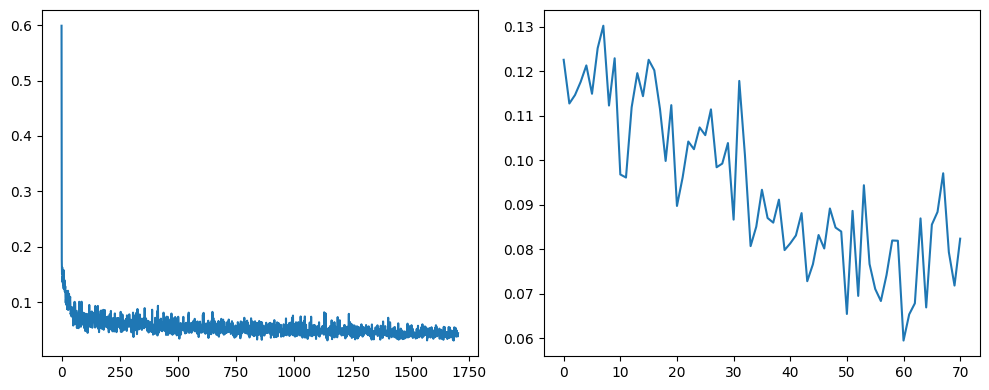

In [15]:
t_loss_list, v_loss_list = [], []
loop = tqdm(range(run.config['epochs']), unit="epoch")
early_stopping = EarlyStopper(patience=10)
best_vloss = 1_000_000.

run.config['early_stopping'] = str(early_stopping)
run.config['save_best'] = True

for epoch in loop:
    model.train()
    for batch_idx, (target, features) in enumerate(train_dataloader):
        target, features = target.to(device), features.to(device)
        
        train_probs = model(features)
        #print('Model resu: ', train_probs.shape)
        #print(features.shape, target.shape)
        #print(train_probs[0])
        #print(features)
        #print('Target : ', target.shape)

        #target = target[0:, None, None]
        #train_loss = F.mse_loss(target, train_probs)
        train_loss = F.l1_loss(target, train_probs)
        #train_loss = F.binary_cross_entropy(train_probs, labels.view(train_probs.shape))
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        # log metrics to wandb
        # run.log({"loss": train_loss})
        
        t_loss_list.append(train_loss.item())
    
    model.eval()
    running_vloss = 0.0
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, (vlabels, vinputs) in enumerate(validation_dataloader):
            #vinputs, vlabels = vdata
            vlabels, vinputs = vlabels.to(device), vinputs.to(device)
            voutputs = model(vinputs)
            vloss = F.l1_loss(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1) # TODO: ricontrollare
    v_loss_list.append(avg_vloss.item())
    
    loop.set_description(f"Epoch [{epoch}/{run.config['epochs']}]")
    loop.set_postfix(loss=t_loss_list[-1], val_loss=v_loss_list[-1])
    
    run.log({"loss": t_loss_list[-1], "val_loss": v_loss_list[-1]})
    
    print(
            f"Epoch {epoch+1:02d}/{run.config['epochs']:02d}"
            f" | Train Loss {t_loss_list[-1]:.3f}"
            f" | Val Loss {v_loss_list[-1]:.3f}"
        )
    
    # save model when improves loss
    if avg_vloss < best_vloss:
        print(f"\tSaving model (improve loss) {best_vloss} -> {avg_vloss}")
        best_vloss = avg_vloss
        model_path = f"ufcn_b{run.config['batch_size']}_e{run.config['epochs']}.model"
        torch.save(model.state_dict(), model_path)

    # check for early stopping
    if early_stopping.early_stop(v_loss_list[-1]):
        print(f"\tEarly Stopping @ epoch {epoch} loss: {t_loss_list[-1]} val_loss: {v_loss_list[-1]}")
        break

wandb.finish()

# plot training/validation loss
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(t_loss_list)
axes[1].plot(v_loss_list)
fig.tight_layout()


In [1]:
wandb.finish()

NameError: name 'wandb' is not defined

### GPU Empy Memory Tests

In [31]:
torch.cuda.empty_cache()
target = None
features = None
t_loss_list = None
train_probs = None
train_loss = None
model = None
torch.cuda.empty_cache()

In [30]:
import gc

model.cpu()
# del model, checkpoint
del model
gc.collect()
torch.cuda.empty_cache()